In [1]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dropout
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.layers import concatenate
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

def SegNet(input_tensor=None, input_shape=None):

    # img_input = Input(shape=input_shape)
    # x = img_input

    # Encoder

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
                                              kernel_initializer = 'he_normal')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
                                              kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.5)(x)


    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', 
                                               kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    
    
    #Decoder
    
    
    # Deconv Block 1
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', 
                                                      kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', 
                                                      kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', 
                                                      kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    
    
    # Deconv Block 2
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', 
                                                     kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', 
                                                     kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4, kernel_size=3, activation='relu', padding='same',
                                                    kernel_initializer = 'he_normal')(x)
    x = Dropout(0.25)(x)


    model = Model(img_input, x)
    
    return model

In [2]:


def plotSamplesOneHots(labels_of_samples, output_file=False):
    '''
    labels_of_samples of shape (num_samples, x, y, num_onehots)
    '''
    if len(labels_of_samples.shape) != 4:
        print("Incorrect input size - should be (num_samples, x, y, num_onehots)")
    num_samples = labels_of_samples.shape[0]
    print(num_samples)
    num_onehots = labels_of_samples.shape[-1]
    print(num_onehots)
    figure_size = (4*num_onehots, 4*num_samples)
    fig, ax = plt.subplots(num_samples, num_onehots, sharex=True, sharey=True, figsize=figure_size)
    for i in range(num_samples):
        for j in range(num_onehots):
            ax[i, j].imshow(labels_of_samples[i,...,j], aspect="auto")
    fig.tight_layout()
    plt.show()
    if output_file == True:
        fig.savefig(output_file)



def oneHotEncode(initial_array):
    '''
    One hot encode the labels
    '''
    allowed_max_class_num = 3
    output_shape = list(initial_array.shape)
    output_shape[-1] = initial_array.max()
    output_array_dims = list(initial_array.shape)
    output_array_dims.append(4)
    output_array = np.zeros(output_array_dims)
    for image_i in range(0, initial_array.shape[0]):
        for class_num in range(0, allowed_max_class_num):
            for x in range(0, initial_array.shape[1]):
                for y in range(0, initial_array.shape[2]):
                    if initial_array[image_i, x, y] == class_num:
                        output_array[image_i, x, y, class_num] = 1

        class_num = allowed_max_class_num
        for x in range(0, initial_array.shape[1]):
            for y in range(0, initial_array.shape[2]):
                if initial_array[image_i, x, y] >= allowed_max_class_num:
                    output_array[image_i, x, y, class_num] = 1
    return output_array


def findNearestNeighbourLabel(array):
    center = int(array.shape[0]/2)
    labels_count = np.zeros(5)
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            if (x != center) or (y != center):
                temp_label = array[x, y]
                labels_count[temp_label] += 1
    return labels_count.argmax()
    

def cleanLabelNearestNeighbour(label):
    '''
    Corrects incorrect labels in a single image based on a threshold on the number of 
    nearest neighbours with the same label
    '''
    x_length = label.shape[0]
    y_length = label.shape[1]
    num_of_classes = 4
    cleaned_labels = np.zeros((x_length, y_length, 4))
    for x in range(1,x_length-1):
        for y in range(1, y_length-1):
            temp_label = label[x,y]
            if temp_label >3: # if labeled as 4 or above
                temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                cleaned_labels[x, y, temp_label] = 1
            elif temp_label > 0:
                num_labels_in_3x3 = len(np.where(label[(x-1):(x+2), (y-1):(y+2)]==temp_label)[0])
                if num_labels_in_3x3 > 3:
                    cleaned_labels[x, y, temp_label] = 1
                else:
                    temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                    cleaned_labels[x, y, temp_label] = 1
        non_zero_array = cleaned_labels[..., 1:].sum(axis=2).astype('bool')
        cleaned_labels[..., 0] = np.ones((x_length, y_length), dtype='bool')^non_zero_array
    return cleaned_labels

def cleanLabelNearestNeighbour_alllabels(labels):    
    '''
    Cleans incorrect labels
    '''
    num_labels = labels.shape[0]
    num_of_classes = 4
    cleaned_dim = list(labels.shape)
    cleaned_dim.append(num_of_classes)
    cleaned_labels = np.zeros(cleaned_dim)
    for image_i in range(num_labels):
        print('Preprocessing image %d of %d' % (image_i, num_labels))
        cleaned_labels[image_i,...] = cleanLabelNearestNeighbour(labels[image_i, ...])
    return cleaned_labels


def label012Chromosomes(labels):
    '''
    Input array of (num_samples, x, y, 4)
    Returns array of (num_samples, x, y, 3) where chromosome A and chromosome B are merged
    '''
    labels[...,1] = labels[...,1:3].sum(axis=-1)
    return labels[...,[0,1,3]]
    

def makeXbyY(data, X, Y):
    '''
    Crop data to size X by Y
    '''
    if len(data.shape) < 3:
        print('Input should be of size (num_samples, x, y,...)')
    data_x_start = int((data.shape[1]-X)/2)
    data_y_start = int((data.shape[1]-Y)/2)
    arrayXbyY = data[:, (data_x_start):(data_x_start + X), (data_y_start):(data_y_start + Y),...]
    return arrayXbyY

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    if len(y_pred.shape) < 3 or (y_pred.shape[2]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[2]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)

def meanIOU(y_pred, y_true):
    '''
    Calculate the mean IOU, with the mean taken over classes
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)
	
def IOU(y_pred, y_true):
    '''
    Calculate the IOU for each class seperately
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return IUs

def globalAccuracy(y_pred, y_true):
    '''
    Calculate the global accuracy (ie. percent of pixels correctly labelled)
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    correct = y_pred & y_true
    num_correct = correct.sum()
    num_total = 1
    for dim in y_true.shape[0:-1]:
        num_total = num_total*dim
    return num_correct/num_total

In [3]:

# Load HD5F file
h5f = h5py.File('rcc_data_v1_preprocessed.h5','r')
xdata = h5f['rcc_data'][...,0]
labels = h5f['rcc_data'][...,1]
print(labels.shape)
h5f.close()

# Clean labels
labels = cleanLabelNearestNeighbour_alllabels(labels)

# Crop to 88x88 pixels and save processed numpy arrays
labels = makeXbyY(labels, 88, 88)
np.save('ydata_88x88_0123_onehot', labels)
xdata = makeXbyY(xdata, 88, 88).reshape((500,88,88, 1))
np.save('xdata_88x88', xdata)


(500, 94, 93)
Preprocessing image 0 of 500
Preprocessing image 1 of 500
Preprocessing image 2 of 500
Preprocessing image 3 of 500
Preprocessing image 4 of 500
Preprocessing image 5 of 500
Preprocessing image 6 of 500
Preprocessing image 7 of 500
Preprocessing image 8 of 500
Preprocessing image 9 of 500
Preprocessing image 10 of 500
Preprocessing image 11 of 500
Preprocessing image 12 of 500
Preprocessing image 13 of 500
Preprocessing image 14 of 500
Preprocessing image 15 of 500
Preprocessing image 16 of 500
Preprocessing image 17 of 500
Preprocessing image 18 of 500
Preprocessing image 19 of 500
Preprocessing image 20 of 500
Preprocessing image 21 of 500
Preprocessing image 22 of 500
Preprocessing image 23 of 500
Preprocessing image 24 of 500
Preprocessing image 25 of 500
Preprocessing image 26 of 500
Preprocessing image 27 of 500
Preprocessing image 28 of 500
Preprocessing image 29 of 500
Preprocessing image 30 of 500
Preprocessing image 31 of 500
Preprocessing image 32 of 500
Prepro

(500, 88, 88, 1)
13/13 [==============================] - 2s 146ms/step - loss: 0.5533 - val_loss: 31208.1250
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelseg/savedmodel_0epoch\assets
4
4


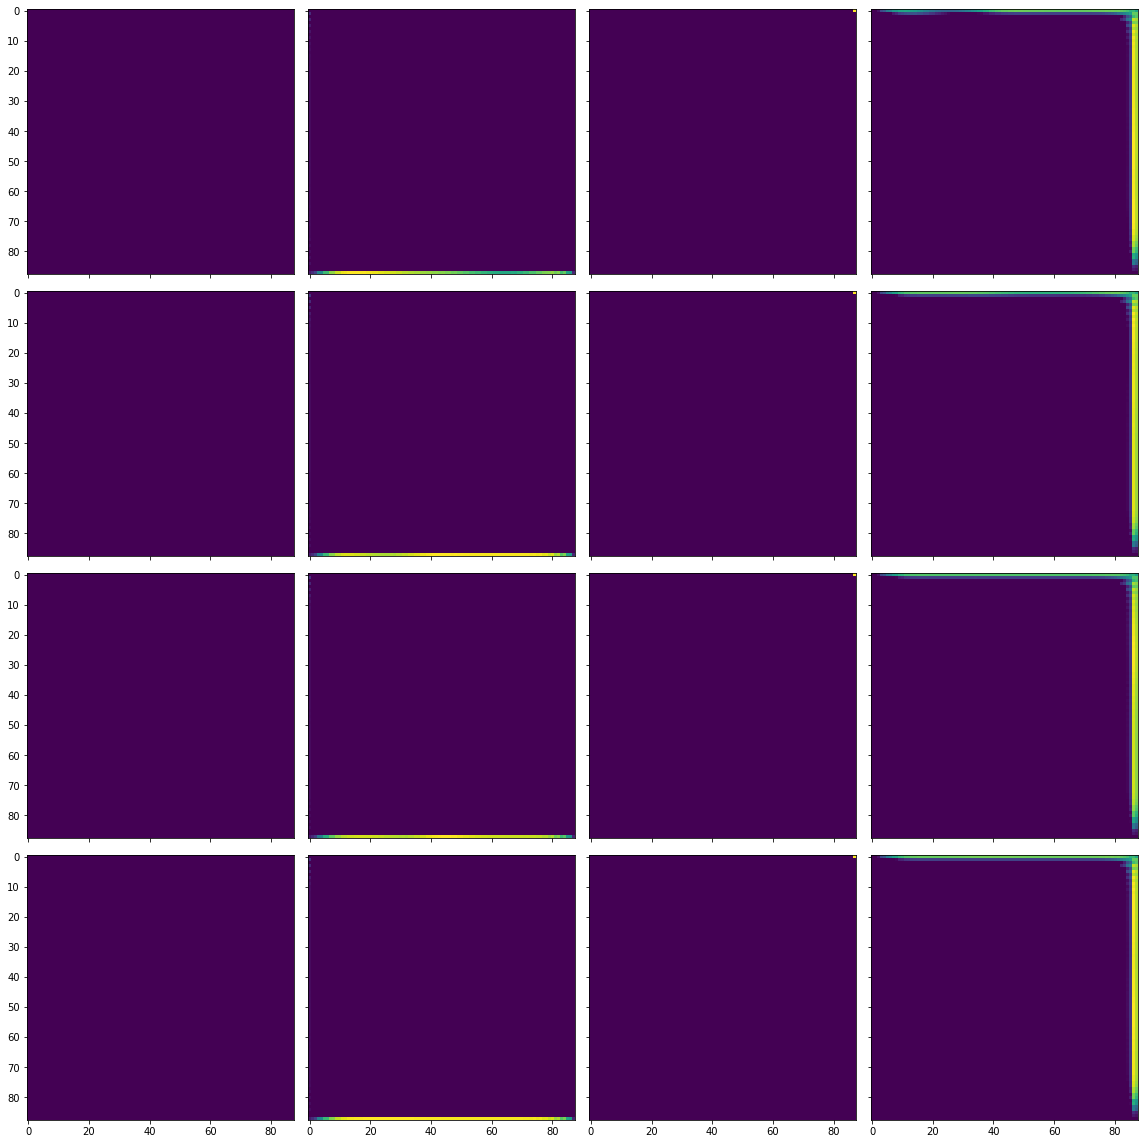

Training IOU: [0.0, 0.0030232780217033977, 0.0, 0.0]
Training accuracy: 0.00048037190082644626
Testing IOU: [0.0, 0.0026221340893819957, 0.0, 0.0]
Testing accuracy: 0.00041322314049586776
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.1265 - val_loss: 11609.2129
INFO:tensorflow:Assets written to: modelseg/savedmodel_1epoch\assets
4
4


Training IOU: [0.0, 0.006770479493688991, 0.0, 0.0]
Training accuracy: 0.0012225594008264463
Testing IOU: [0.0, 0.005865588070185539, 0.0, 0.0]
Testing accuracy: 0.0010524276859504133
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.1099 - val_loss: 592.3022
INFO:tensorflow:Assets written to: modelseg/savedmodel_2epoch\assets
4
4


Training IOU: [0.0, 0.006067806112427942, 0.0, 0.0]
Training accuracy: 0.0010272469008264463
Testing IOU: [0.0, 0.005177088694129304, 0.0, 0.0]
Testing accuracy: 0.0008703512396694215
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.1059 - val_loss: 35.1726
INFO:tensorflow:Assets written to: modelseg/savedmodel_3epoch\assets
4
4


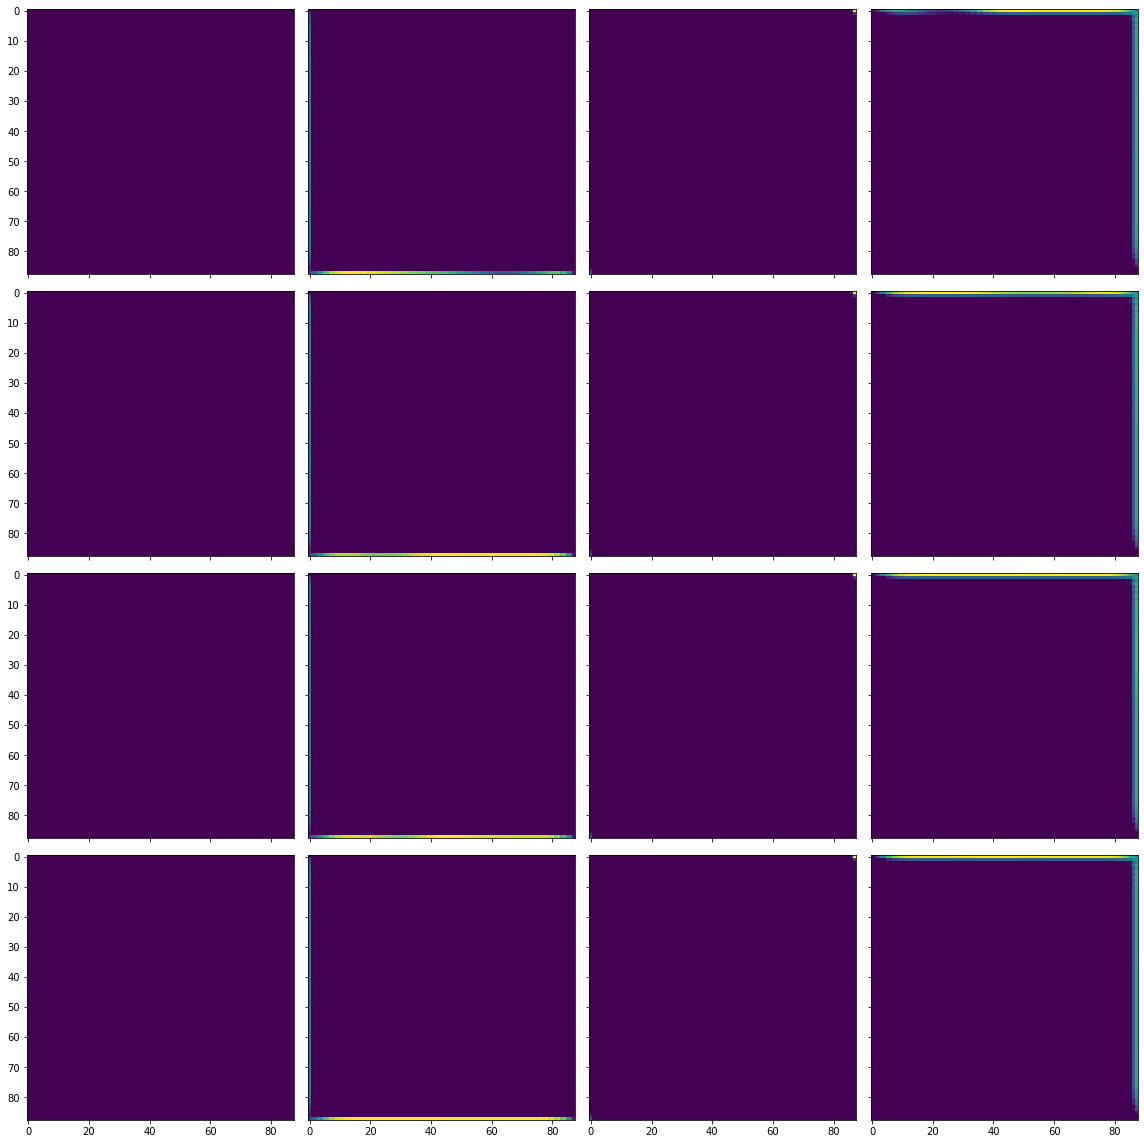

Training IOU: [0.0, 0.0033771651986555895, 0.0, 0.0]
Training accuracy: 0.0005404183884297521
Testing IOU: [0.0, 0.002902698615323322, 0.0, 0.0006951417316752916]
Testing accuracy: 0.0005074896694214876
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.1032 - val_loss: 1.7669
INFO:tensorflow:Assets written to: modelseg/savedmodel_4epoch\assets
4
4


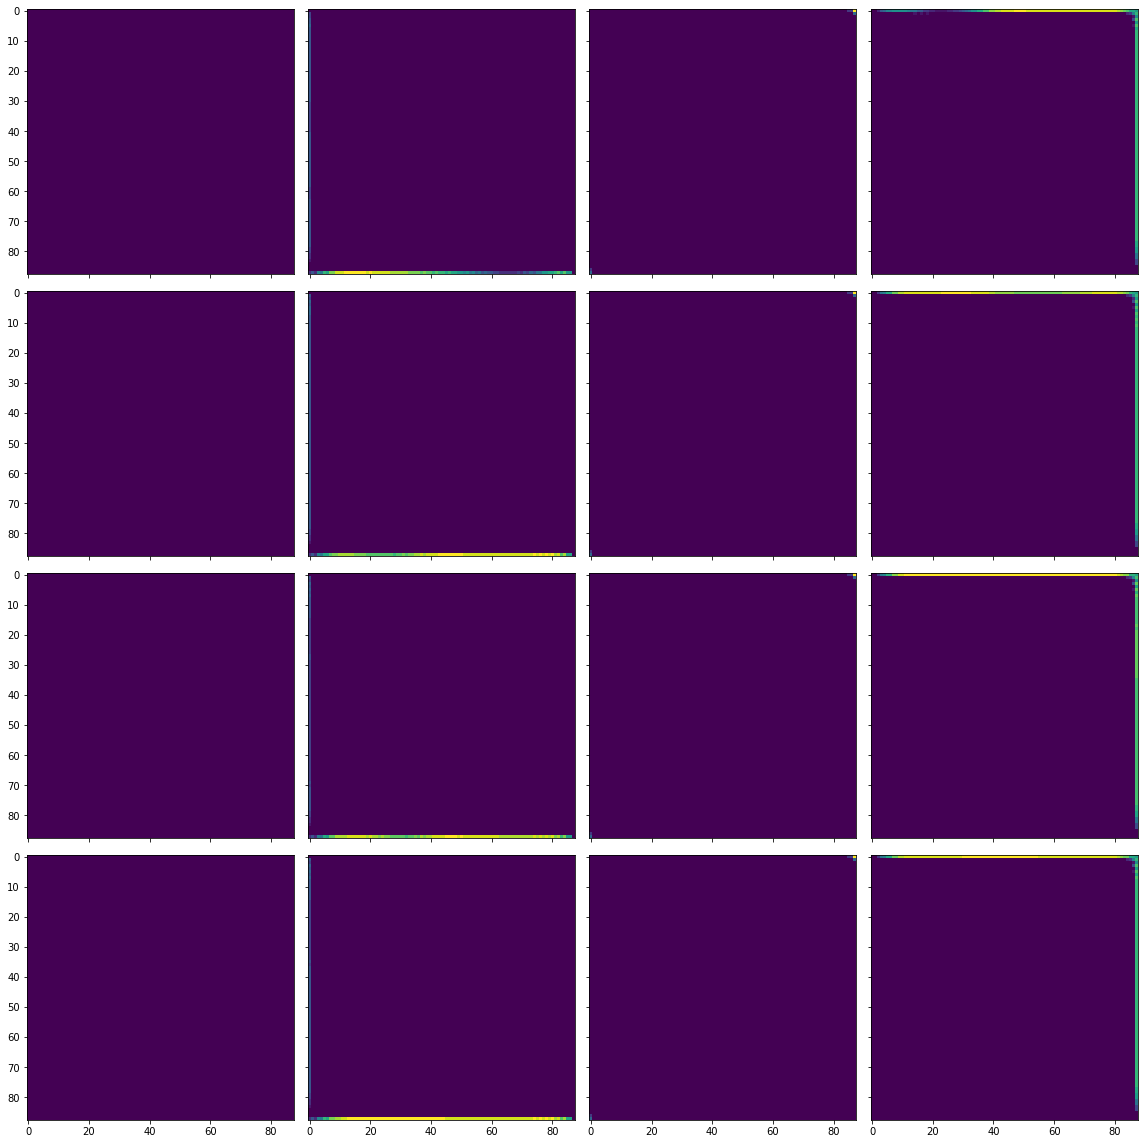

Training IOU: [9.023878083797536e-07, 0.0033685515430923424, 0.0, 0.0003147409866821363]
Training accuracy: 0.0005539772727272727
Testing IOU: [1.7604889934228131e-06, 0.0026850567208030686, 0.0, 5.628729032984352e-05]
Testing accuracy: 0.00042871900826446283
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.1014 - val_loss: 0.3631
INFO:tensorflow:Assets written to: modelseg/savedmodel_5epoch\assets
4
4


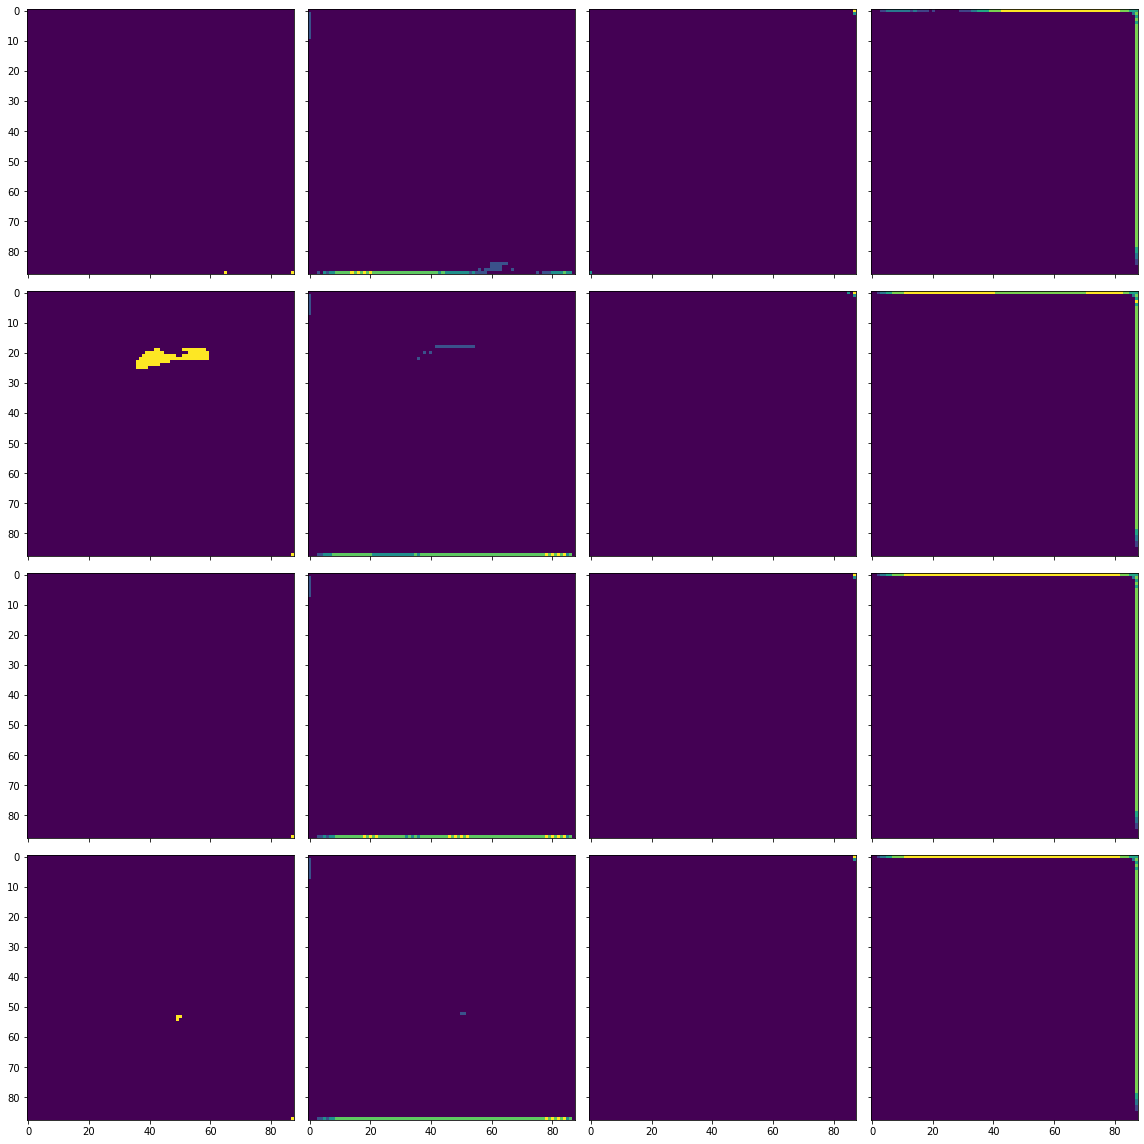

Training IOU: [0.00020948616422724158, 0.006423950589633815, 0.0, 0.0017078083751423173]
Training accuracy: 0.0012012525826446282
Testing IOU: [0.00019174274807817475, 0.003920443679479824, 0.0, 2.862622734949761e-05]
Testing accuracy: 0.0007244318181818182
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.1002 - val_loss: 0.2639
INFO:tensorflow:Assets written to: modelseg/savedmodel_6epoch\assets
4
4


Training IOU: [0.0004875201579475446, 0.01191671148406932, 0.0005091439501314142, 0.031215420637880336]
Training accuracy: 0.0038252195247933884
Testing IOU: [0.0003214920039843927, 0.009073977632821672, 2.415079758009008e-05, 0.01069078947368421]
Testing accuracy: 0.002053202479338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0990 - val_loss: 0.2486
INFO:tensorflow:Assets written to: modelseg/savedmodel_7epoch\assets
4
4


Training IOU: [0.002773450958998507, 0.051777107076895354, 0.008157380428317294, 0.14386346858851645]
Training accuracy: 0.01780152376033058
Testing IOU: [0.002054430106356266, 0.04235459107011137, 0.0021348192640301047, 0.10882800608828005]
Testing accuracy: 0.012546487603305786
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0980 - val_loss: 0.2266
INFO:tensorflow:Assets written to: modelseg/savedmodel_8epoch\assets
4
4


Training IOU: [0.0681027902637605, 0.224901302782568, 0.0225095003212143, 0.24627295468633909]
Training accuracy: 0.10507909349173554
Testing IOU: [0.06823829802117855, 0.20147292606170716, 0.010211759647425562, 0.21730841048017768]
Testing accuracy: 0.09784349173553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0967 - val_loss: 0.0618
INFO:tensorflow:Assets written to: modelseg/savedmodel_9epoch\assets
4
4


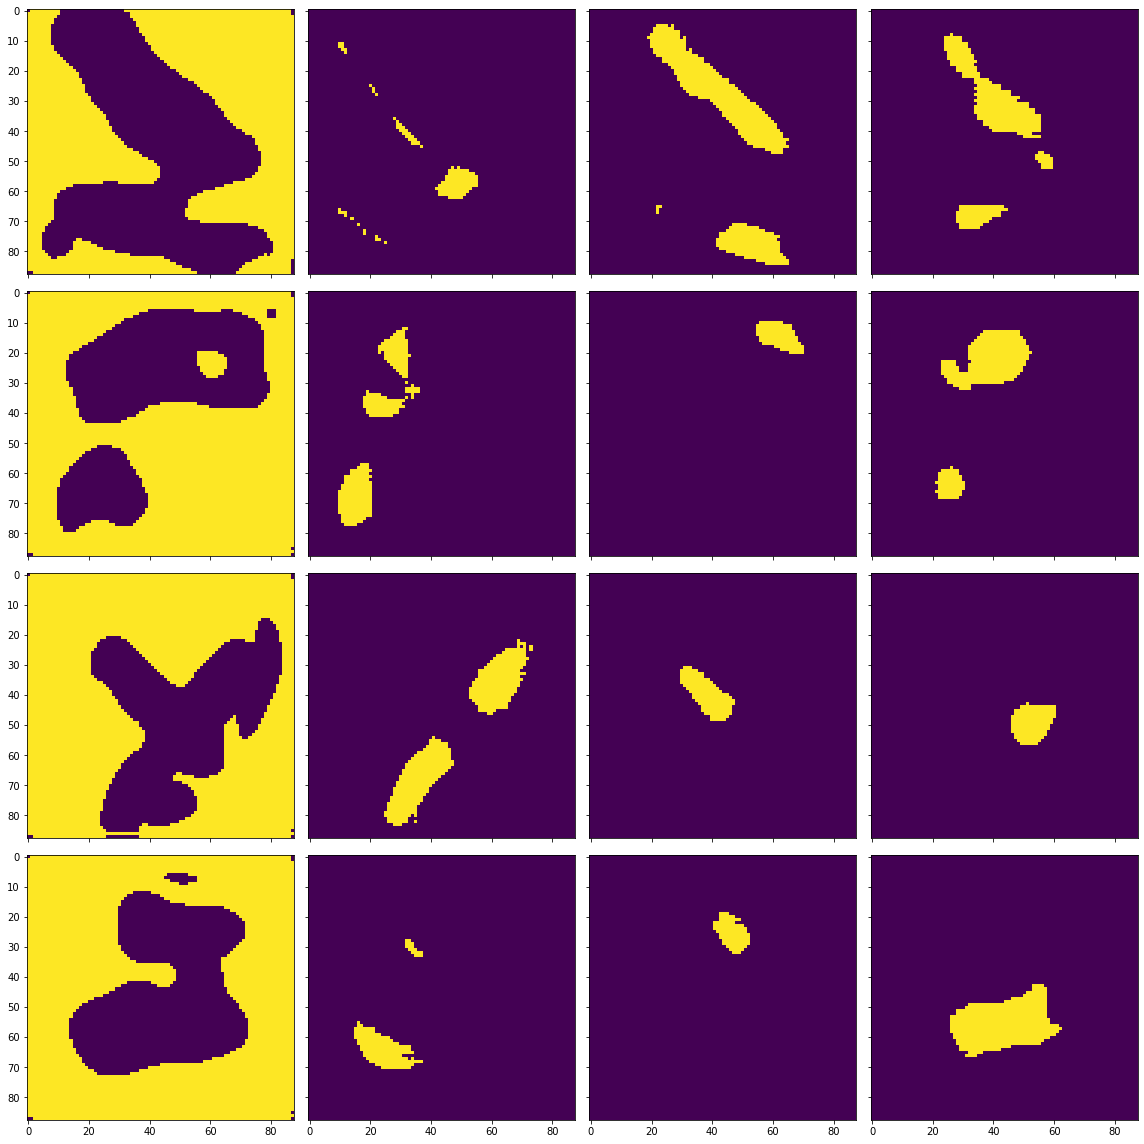

Training IOU: [0.9200051567847359, 0.2617410372136592, 0.12028020887919055, 0.2814142622596123]
Training accuracy: 0.7438759039256199
Testing IOU: [0.9360526669724423, 0.21049081066850947, 0.07232048206215477, 0.24646182760486374]
Testing accuracy: 0.753592458677686
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0964 - val_loss: 0.0656
INFO:tensorflow:Assets written to: modelseg/savedmodel_10epoch\assets
4
4


Training IOU: [0.9334410728419671, 0.2949751539524149, 0.2729056982199778, 0.25897523141483675]
Training accuracy: 0.7745144628099173
Testing IOU: [0.9386934257344457, 0.23309515158855112, 0.20021993559029141, 0.22385313427842596]
Testing accuracy: 0.7733225723140496
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0958 - val_loss: 0.0623
INFO:tensorflow:Assets written to: modelseg/savedmodel_11epoch\assets
4
4


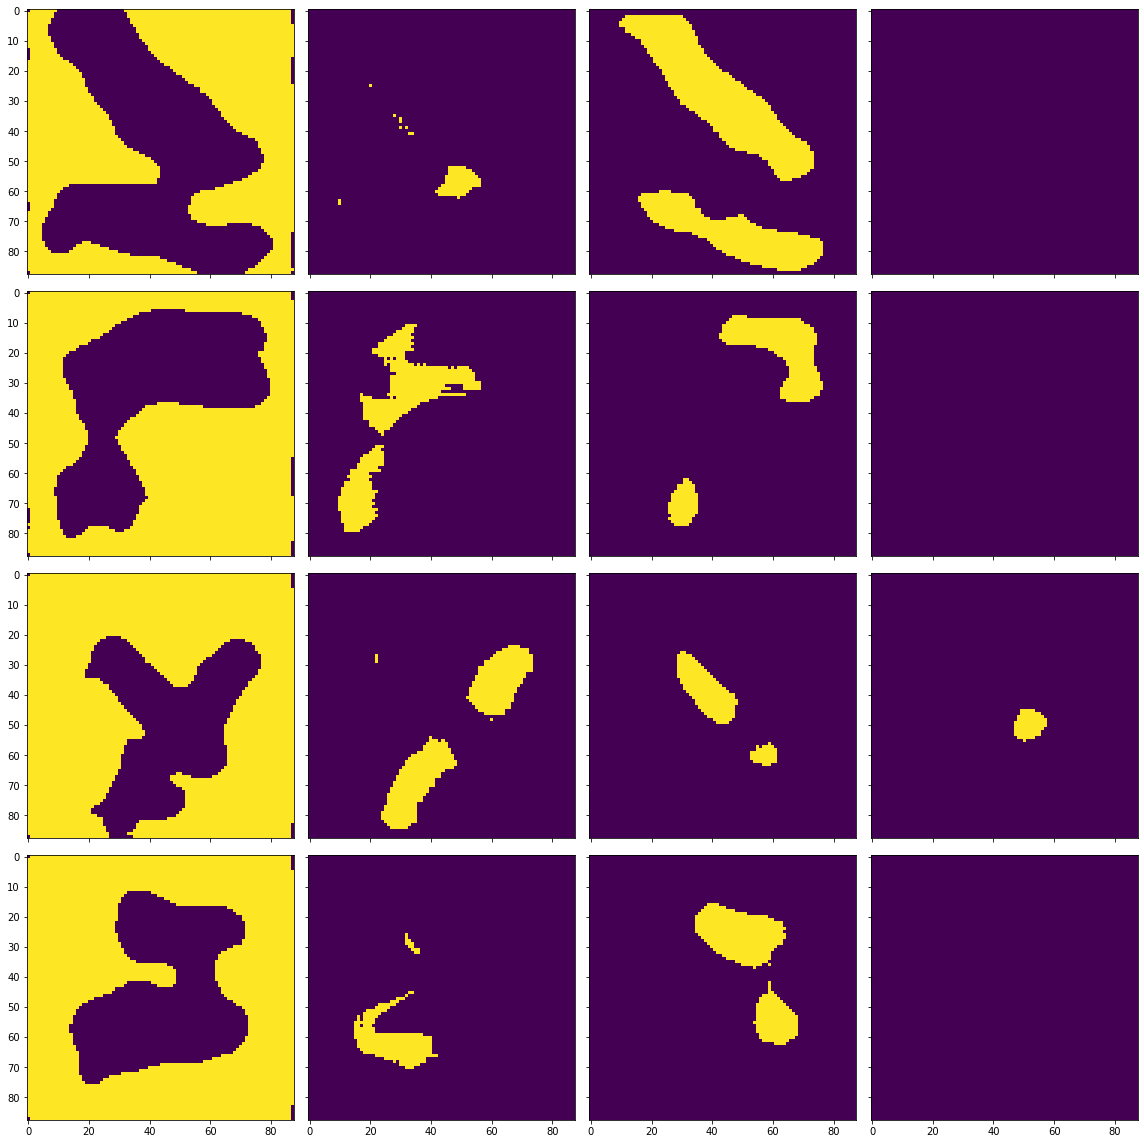

Training IOU: [0.930619997346659, 0.30780023969899817, 0.2961308697939675, 0.07503818737270876]
Training accuracy: 0.7723066244834711
Testing IOU: [0.9448810862232985, 0.24709144806043412, 0.23557058047493404, 0.06389189189189189]
Testing accuracy: 0.7801988636363636
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0956 - val_loss: 0.0705
INFO:tensorflow:Assets written to: modelseg/savedmodel_12epoch\assets
4
4


Training IOU: [0.9496231243254535, 0.28933499014482816, 0.30461960948590844, 0.17897056997392277]
Training accuracy: 0.7958803589876033
Testing IOU: [0.9532029490971701, 0.21602890458203317, 0.2289419303467496, 0.11767488306091343]
Testing accuracy: 0.7929558367768595
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0949 - val_loss: 0.0716
INFO:tensorflow:Assets written to: modelseg/savedmodel_13epoch\assets
4
4


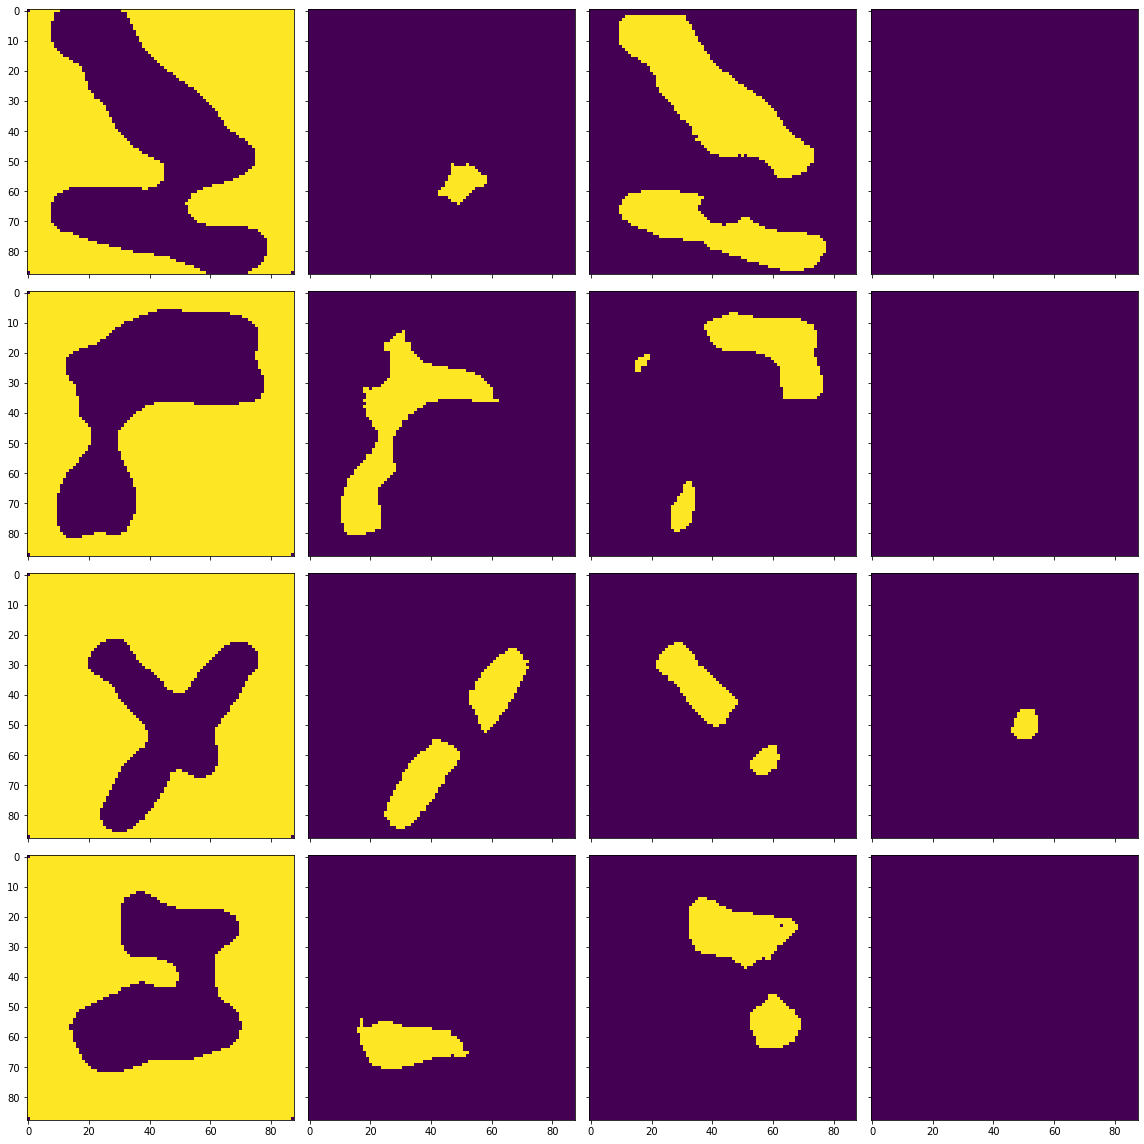

Training IOU: [0.9491329818546319, 0.34554643993123824, 0.3598750446034724, 0.08955641688199828]
Training accuracy: 0.8209581611570248
Testing IOU: [0.9507731585975842, 0.26769676408774984, 0.266336167452935, 0.04369336816943688]
Testing accuracy: 0.8136337809917356
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0943 - val_loss: 0.0661
INFO:tensorflow:Assets written to: modelseg/savedmodel_14epoch\assets
4
4


Training IOU: [0.9645325251995436, 0.35149955284228557, 0.399823545043848, 0.3142985913331991]
Training accuracy: 0.8329790805785124
Testing IOU: [0.9653292783183129, 0.2657406821489591, 0.2906436571979147, 0.2294200986858176]
Testing accuracy: 0.8193814566115702
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0938 - val_loss: 0.0653
INFO:tensorflow:Assets written to: modelseg/savedmodel_15epoch\assets
4
4


Training IOU: [0.967974243163524, 0.40462438756771996, 0.35081347645273686, 0.004561526037801737]
Training accuracy: 0.8254096720041322
Testing IOU: [0.9679589390053648, 0.32076914115968197, 0.23926092125954052, 0.0]
Testing accuracy: 0.815807076446281
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0935 - val_loss: 0.0597
INFO:tensorflow:Assets written to: modelseg/savedmodel_16epoch\assets
4
4


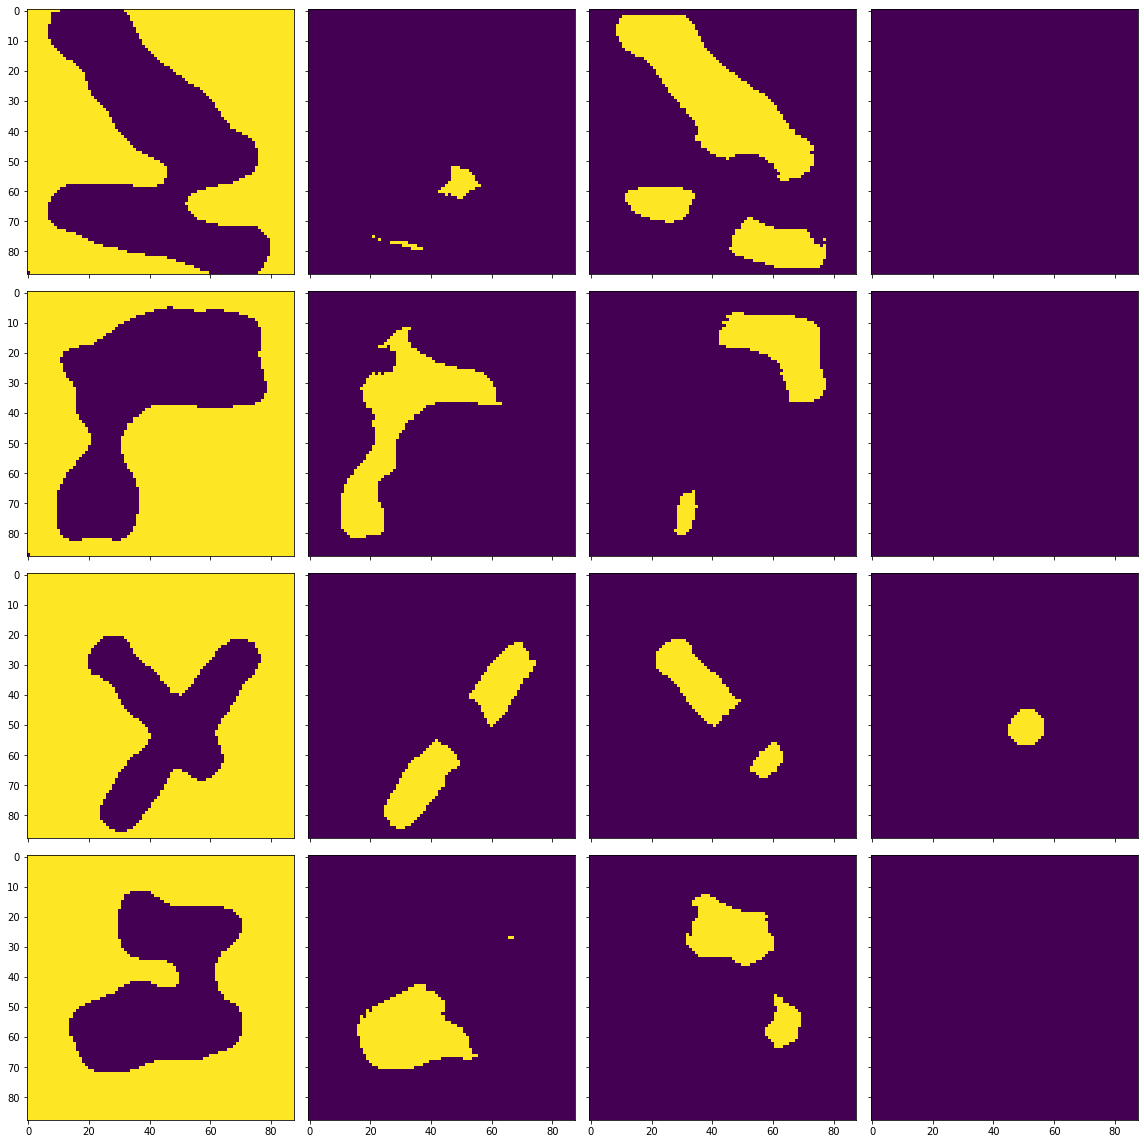

Training IOU: [0.9686434564513028, 0.39719902649091454, 0.3737556582169074, 0.1493473652494862]
Training accuracy: 0.8285140108471074
Testing IOU: [0.9683883981311272, 0.30390671271546915, 0.26140756461760023, 0.10128055878928988]
Testing accuracy: 0.8162073863636363
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0924 - val_loss: 0.0596
INFO:tensorflow:Assets written to: modelseg/savedmodel_17epoch\assets
4
4


Training IOU: [0.9702317604350876, 0.475701318053226, 0.35995371486427846, 0.026048714479025712]
Training accuracy: 0.8388913997933884
Testing IOU: [0.9696084292980495, 0.3810261613557835, 0.24312601809510725, 0.009654017857142858]
Testing accuracy: 0.8264785640495868
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0921 - val_loss: 0.0602
INFO:tensorflow:Assets written to: modelseg/savedmodel_18epoch\assets
4
4


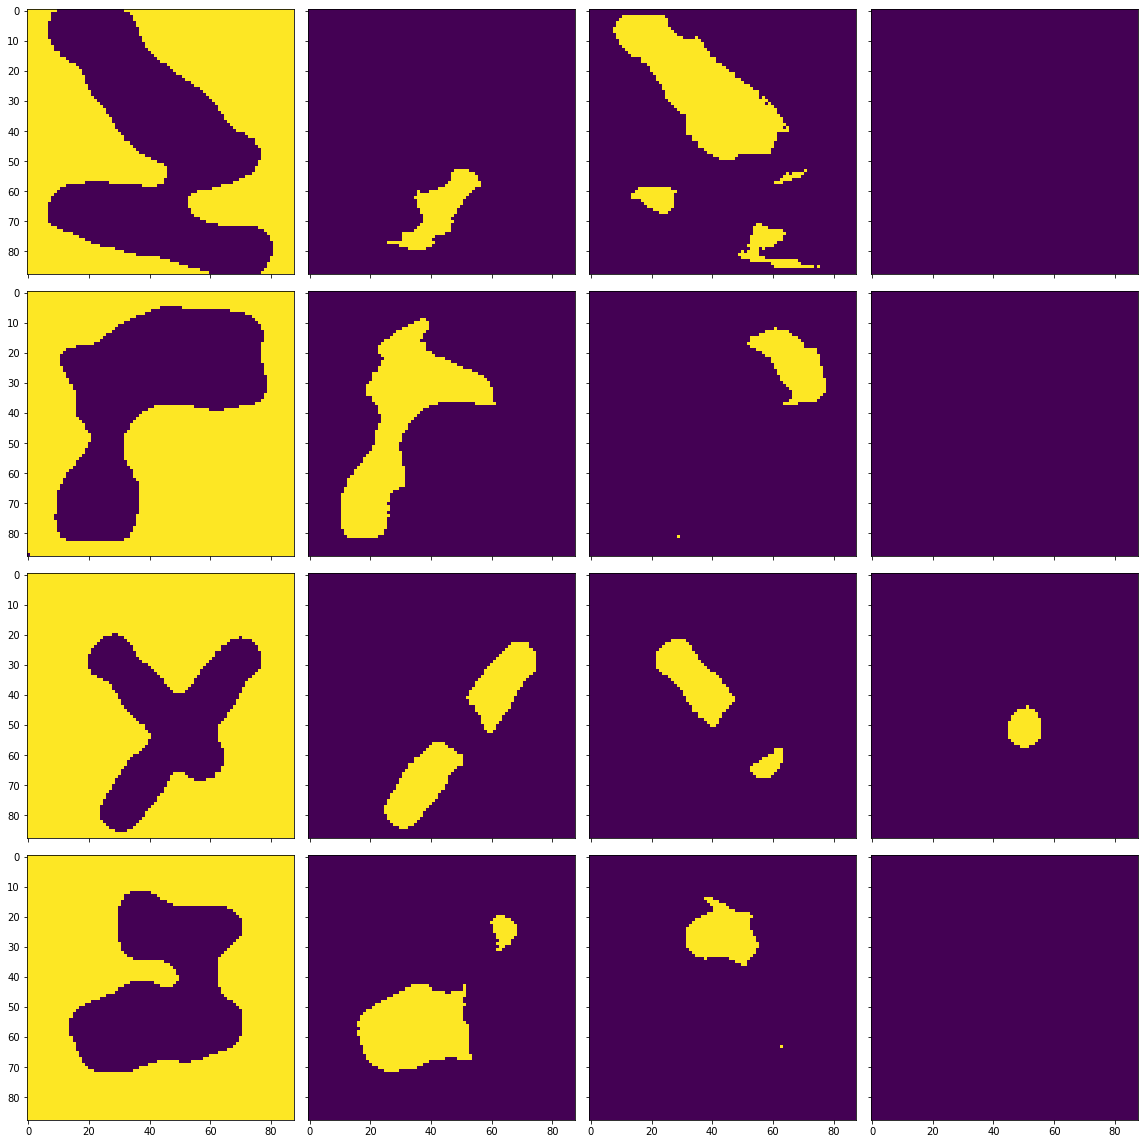

Training IOU: [0.9716832798413094, 0.45606340456435096, 0.3180256948746229, 0.08022154141363483]
Training accuracy: 0.8266370738636364
Testing IOU: [0.9706109915826169, 0.35242274953567254, 0.20431132568652172, 0.04218043854265469]
Testing accuracy: 0.8142910640495867
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0926 - val_loss: 0.0596
INFO:tensorflow:Assets written to: modelseg/savedmodel_19epoch\assets
4
4


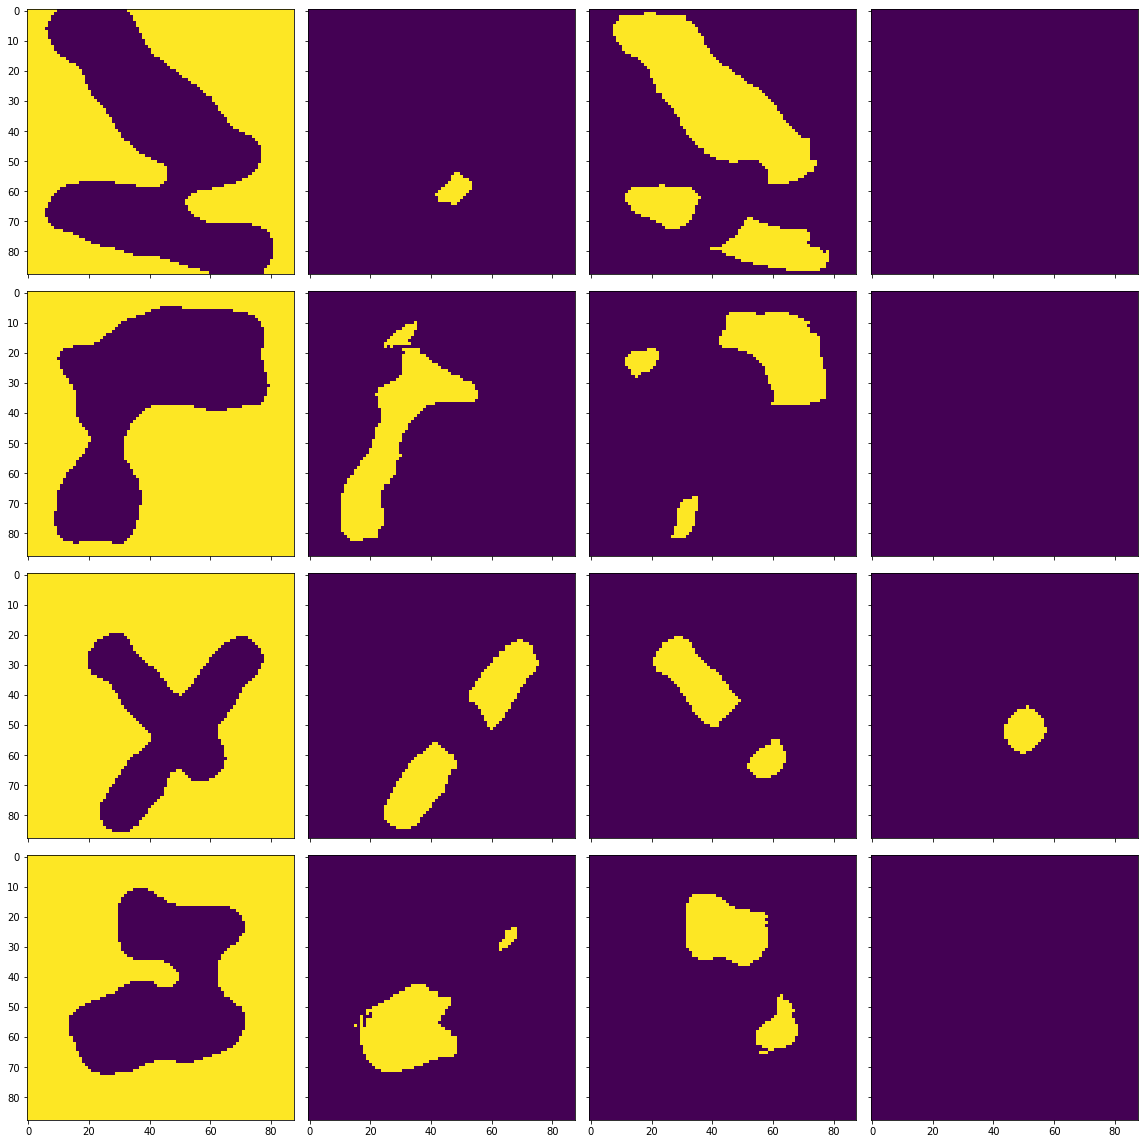

Training IOU: [0.9710664298654734, 0.4256963398993719, 0.4391975440722363, 0.18396267173593708]
Training accuracy: 0.8387215909090909
Testing IOU: [0.9701661028017257, 0.3123422785745061, 0.3080757369289249, 0.12721533008418254]
Testing accuracy: 0.8211105371900826
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0915 - val_loss: 0.0541
INFO:tensorflow:Assets written to: modelseg/savedmodel_20epoch\assets
4
4


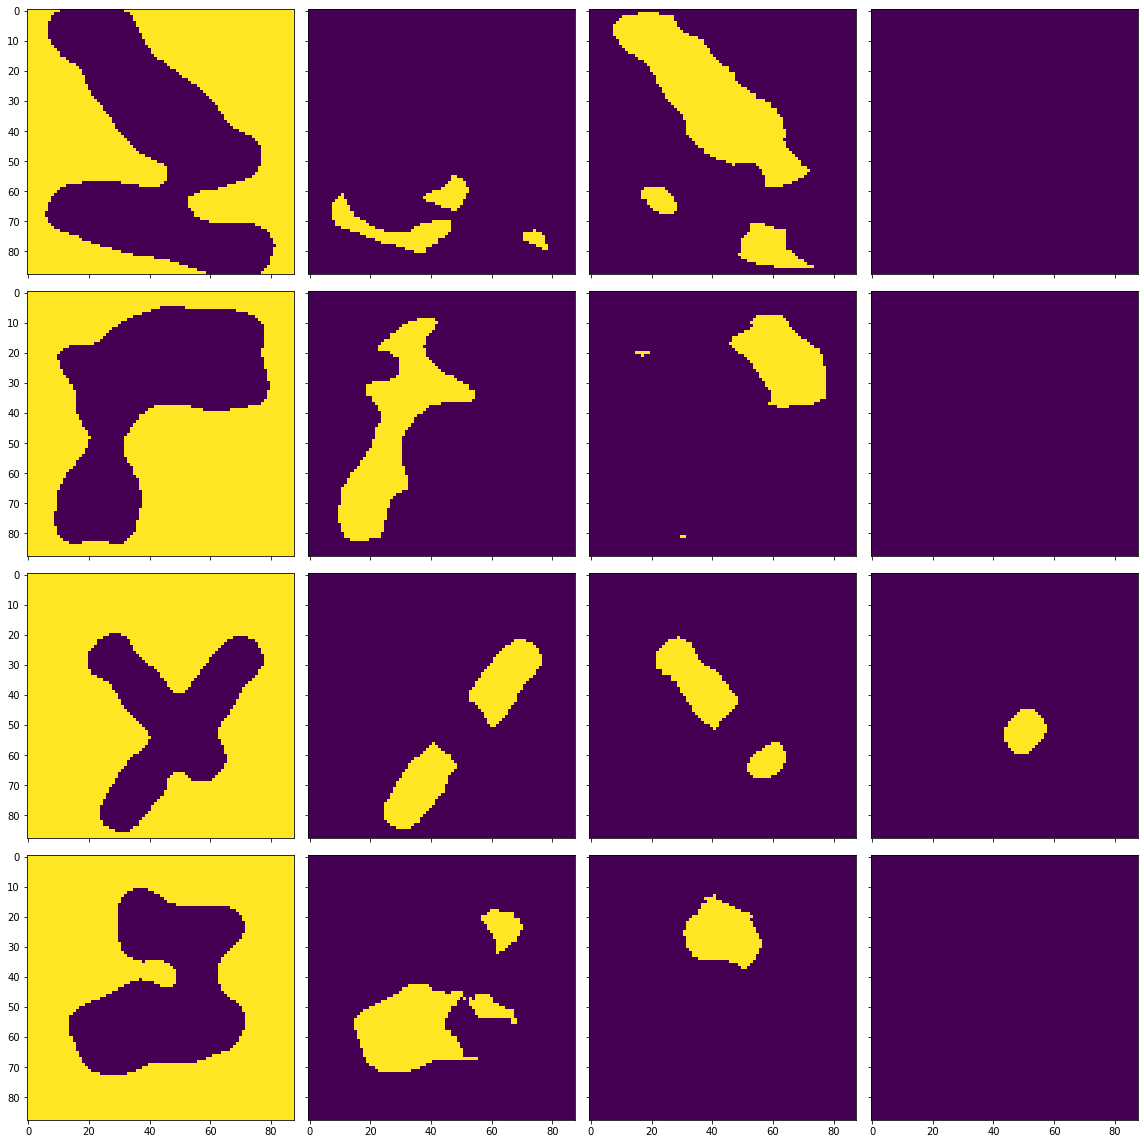

Training IOU: [0.9705788599592843, 0.5101112088039498, 0.3799644980306733, 0.2019147835087114]
Training accuracy: 0.8429987732438017
Testing IOU: [0.9700184927133838, 0.3961173307189354, 0.24531184470672818, 0.1441716091125769]
Testing accuracy: 0.8260640495867768
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0911 - val_loss: 0.0566
INFO:tensorflow:Assets written to: modelseg/savedmodel_21epoch\assets
4
4


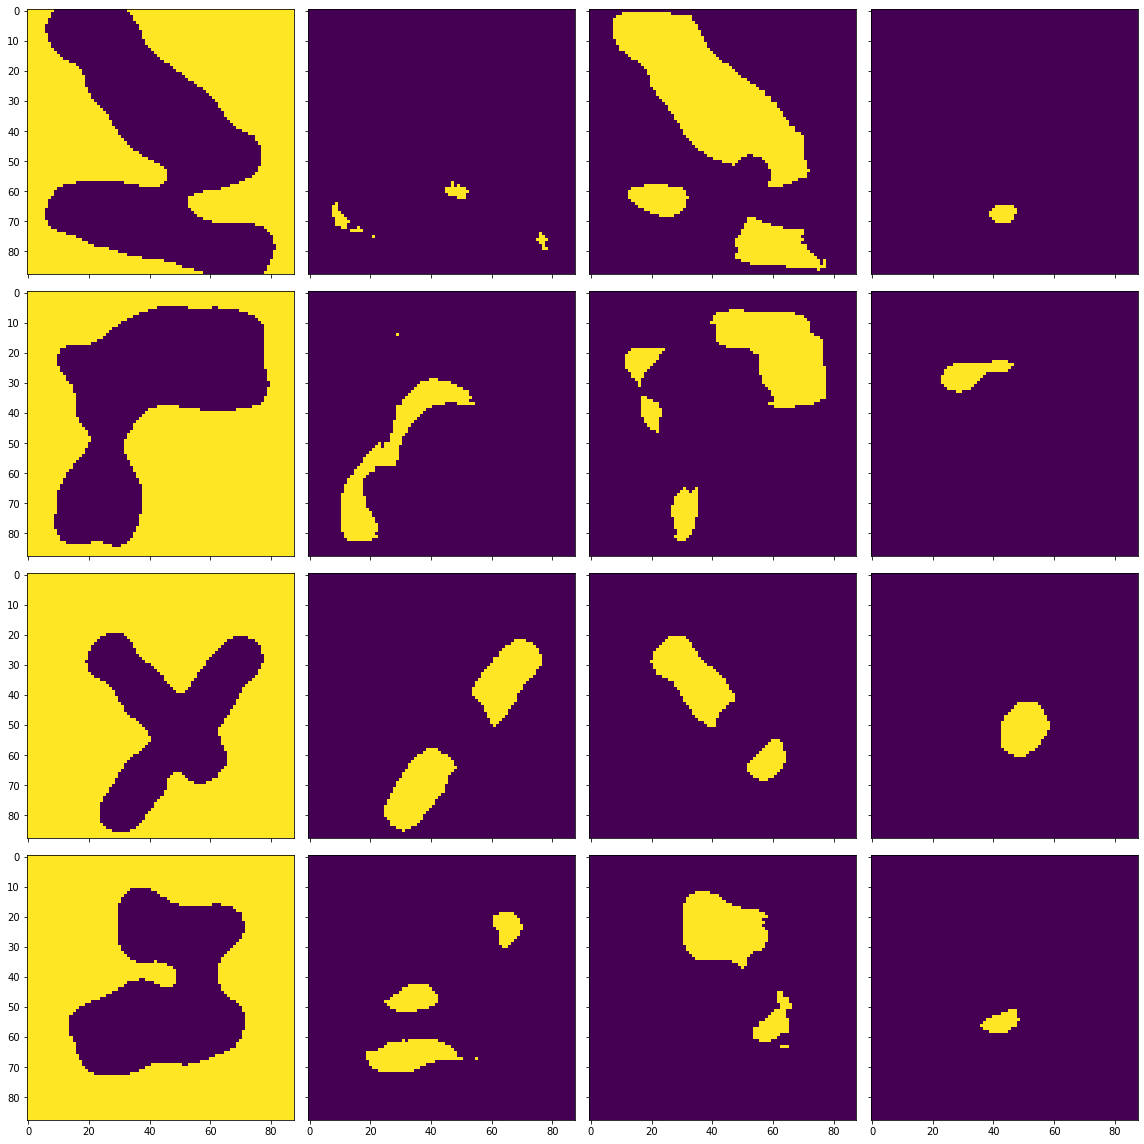

Training IOU: [0.9675794260150529, 0.3743035710835199, 0.4841931016575064, 0.377840853479495]
Training accuracy: 0.8380956224173554
Testing IOU: [0.9675544802642144, 0.25742558222394973, 0.33332480665762837, 0.2761702772307226]
Testing accuracy: 0.814349173553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0908 - val_loss: 0.0589
INFO:tensorflow:Assets written to: modelseg/savedmodel_22epoch\assets
4
4


Training IOU: [0.9683057109812695, 0.45321661212307035, 0.4554083930445791, 0.1194671484387754]
Training accuracy: 0.8353241219008265
Testing IOU: [0.968521052070611, 0.3377736528907572, 0.30167359072025307, 0.0843031349184253]
Testing accuracy: 0.8165173037190082
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0900 - val_loss: 0.0559
INFO:tensorflow:Assets written to: modelseg/savedmodel_23epoch\assets
4
4


Training IOU: [0.971155009612756, 0.5017905624184135, 0.4309673092557434, 0.04958812939828706]
Training accuracy: 0.8380252453512397
Testing IOU: [0.9709648426251538, 0.37725187337513383, 0.2778859418262222, 0.02354385181879045]
Testing accuracy: 0.8193698347107438
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0896 - val_loss: 0.0548
INFO:tensorflow:Assets written to: modelseg/savedmodel_24epoch\assets
4
4


Training IOU: [0.966364508531154, 0.460755764737751, 0.4587821351702451, 0.1848821246743701]
Training accuracy: 0.8321858858471074
Testing IOU: [0.966931029475316, 0.3242400253324889, 0.3062275709916581, 0.12382541006394217]
Testing accuracy: 0.8111931818181818
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0893 - val_loss: 0.0534
INFO:tensorflow:Assets written to: modelseg/savedmodel_25epoch\assets
4
4


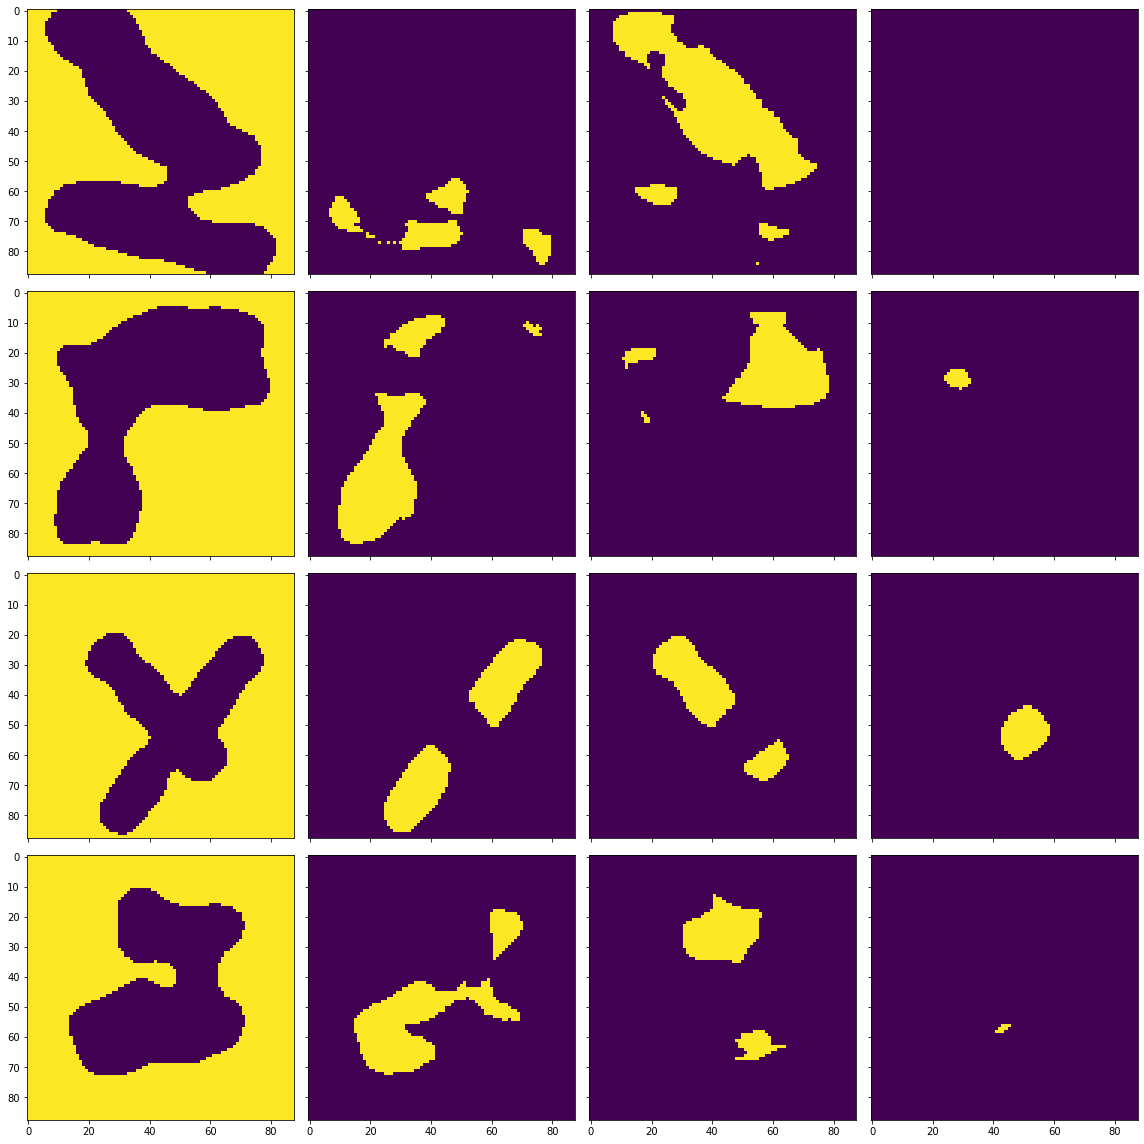

Training IOU: [0.9689235119983246, 0.5386927397320939, 0.4003689432447349, 0.3762528514951641]
Training accuracy: 0.8508697055785124
Testing IOU: [0.9685511293146529, 0.4281302739775216, 0.24150470602615817, 0.3118423161155921]
Testing accuracy: 0.830911673553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0895 - val_loss: 0.0531
INFO:tensorflow:Assets written to: modelseg/savedmodel_26epoch\assets
4
4


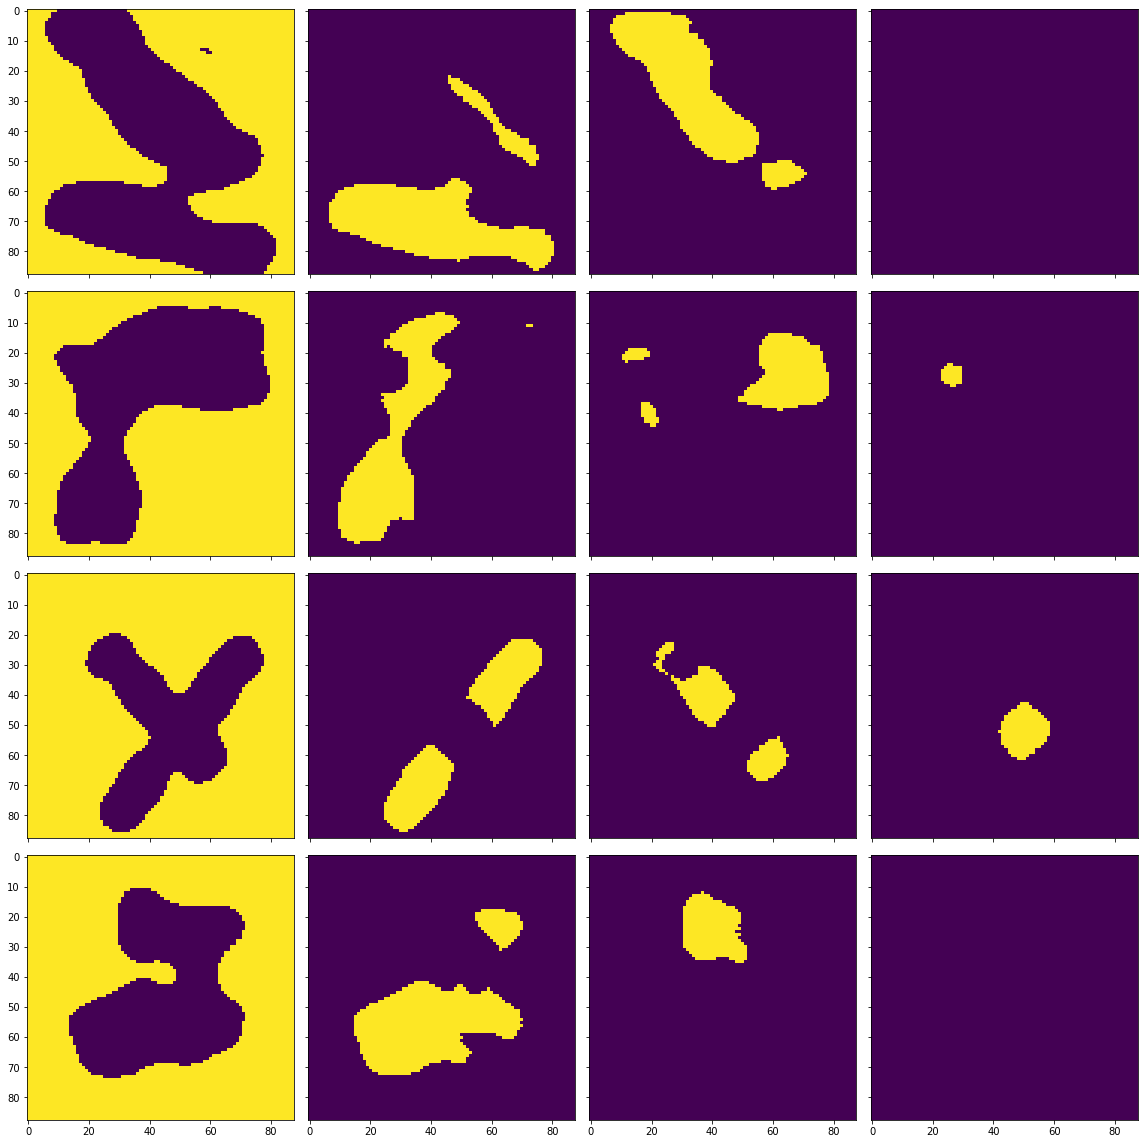

Training IOU: [0.9689664556874058, 0.5689854513922343, 0.3916438440471428, 0.3783130530399693]
Training accuracy: 0.8540957515495867
Testing IOU: [0.9686151514146059, 0.44006526651697725, 0.24788517107081537, 0.2922064018841666]
Testing accuracy: 0.8325800619834711
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0895 - val_loss: 0.0756
INFO:tensorflow:Assets written to: modelseg/savedmodel_27epoch\assets
4
4


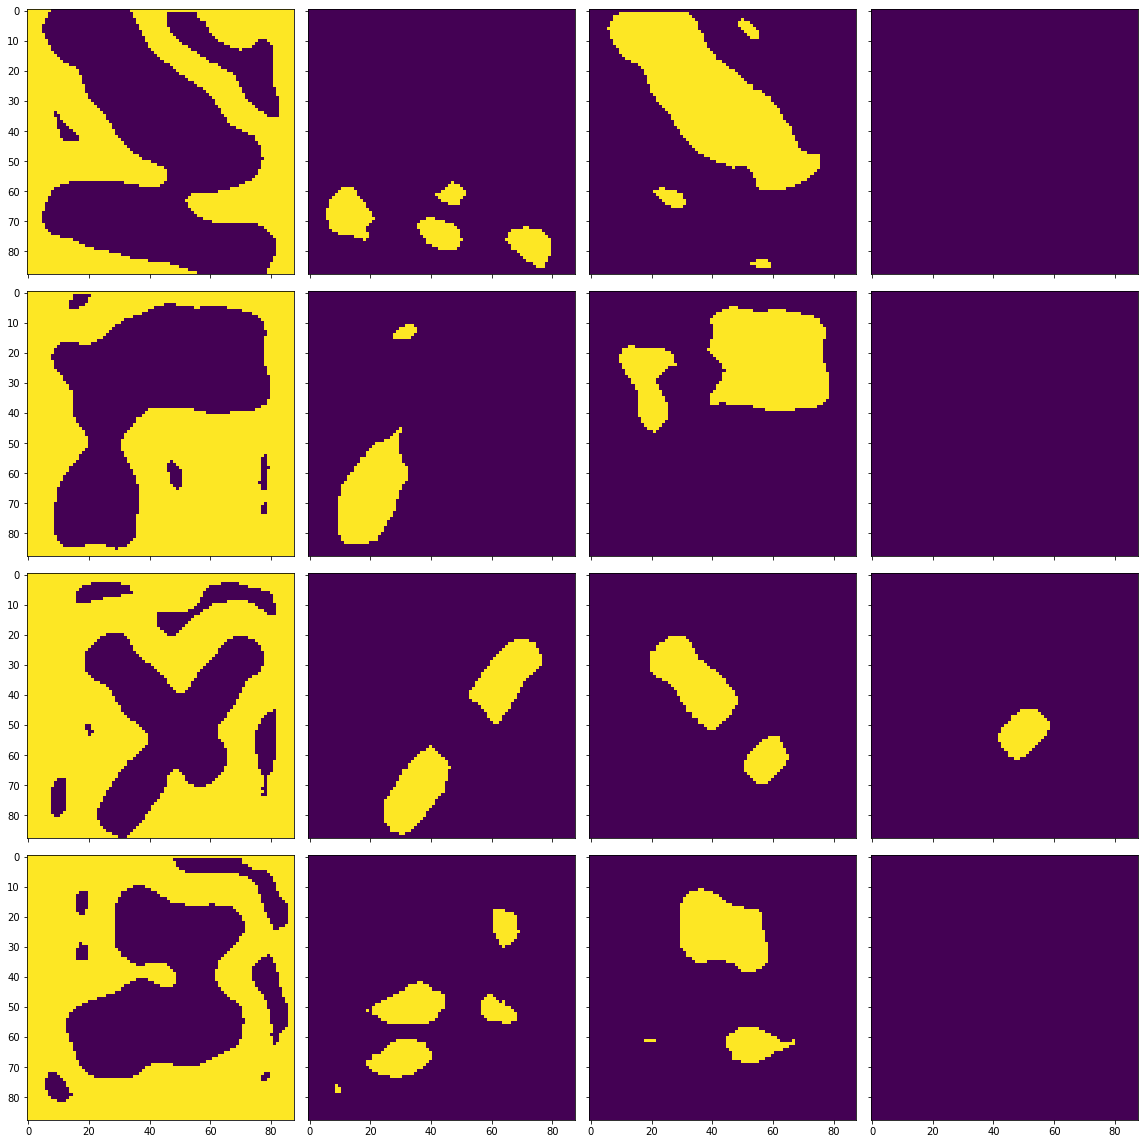

Training IOU: [0.8585024353569218, 0.47141068229283173, 0.5203212591634325, 0.27409758032526776]
Training accuracy: 0.7753147598140496
Testing IOU: [0.85918148493408, 0.3273773470623864, 0.349682466248896, 0.21751642504208069]
Testing accuracy: 0.7464682334710744
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0896 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelseg/savedmodel_28epoch\assets
4
4


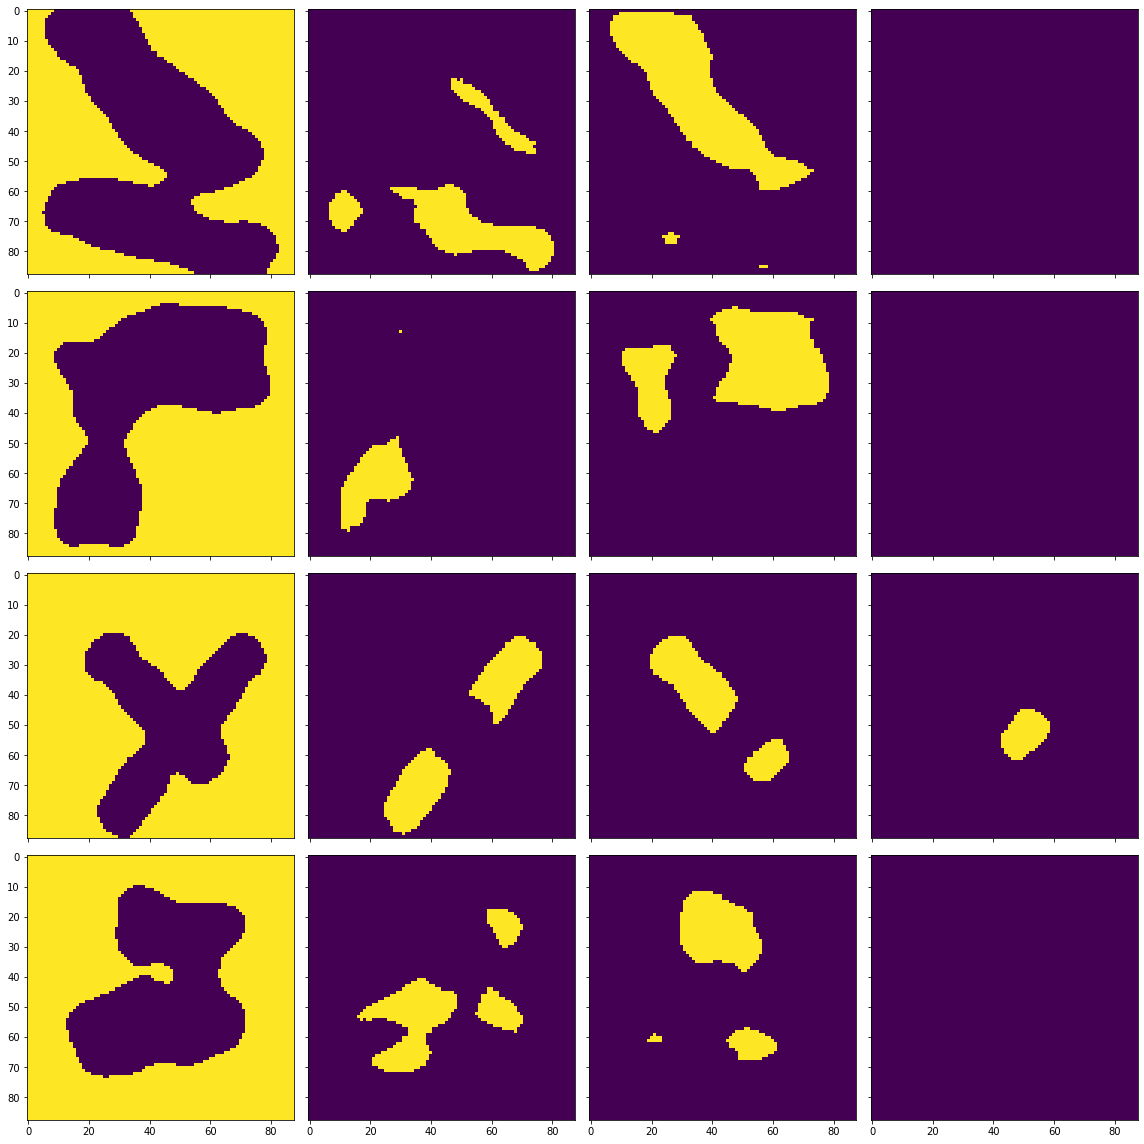

Training IOU: [0.9519467318370812, 0.4376149951524292, 0.5183390258506819, 0.18119360353147382]
Training accuracy: 0.8276598011363636
Testing IOU: [0.9560793430337806, 0.2860884225688704, 0.34365262219397436, 0.12568002664594205]
Testing accuracy: 0.8014759814049587
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0889 - val_loss: 0.0569
INFO:tensorflow:Assets written to: modelseg/savedmodel_29epoch\assets
4
4


Training IOU: [0.9592556937117694, 0.49840059132844633, 0.4721331989979037, 0.5116878287201827]
Training accuracy: 0.8450009684917356
Testing IOU: [0.9613231382628988, 0.37054941924866286, 0.2982720937754212, 0.42763793658828403]
Testing accuracy: 0.8197843491735537
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0884 - val_loss: 0.0551
INFO:tensorflow:Assets written to: modelseg/savedmodel_30epoch\assets
4
4


Training IOU: [0.9672221398300324, 0.5817058600581407, 0.3626308885100901, 0.456764010416147]
Training accuracy: 0.8518927556818182
Testing IOU: [0.9677336339795594, 0.469883634034376, 0.20741248544597873, 0.3645790342550557]
Testing accuracy: 0.8328150826446281
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0877 - val_loss: 0.0541
INFO:tensorflow:Assets written to: modelseg/savedmodel_31epoch\assets
4
4


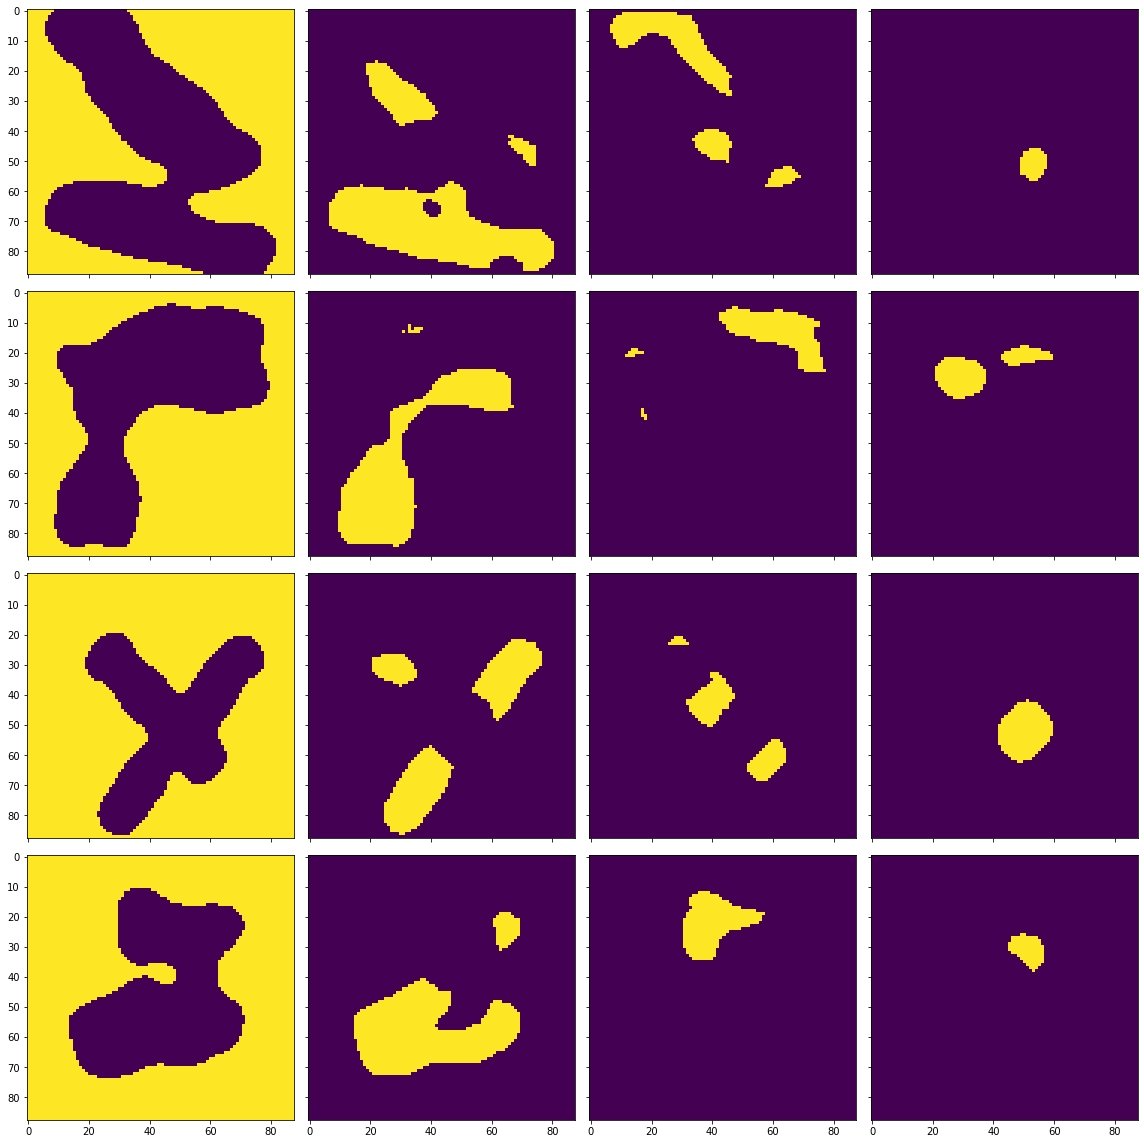

Training IOU: [0.9663672131678039, 0.551079887395867, 0.2697868293253137, 0.5225178122009145]
Training accuracy: 0.8390292484504133
Testing IOU: [0.966782347420471, 0.45385902974219533, 0.16860620355124384, 0.454302172631197]
Testing accuracy: 0.825676652892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0880 - val_loss: 0.0567
INFO:tensorflow:Assets written to: modelseg/savedmodel_32epoch\assets
4
4


Training IOU: [0.9645805165197129, 0.5264537368108658, 0.30510650714911003, 0.5310096093217987]
Training accuracy: 0.833619576446281
Testing IOU: [0.9645210650158268, 0.41180666470250743, 0.1933377822266711, 0.472775793052985]
Testing accuracy: 0.8166322314049587
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0871 - val_loss: 0.0543
INFO:tensorflow:Assets written to: modelseg/savedmodel_33epoch\assets
4
4


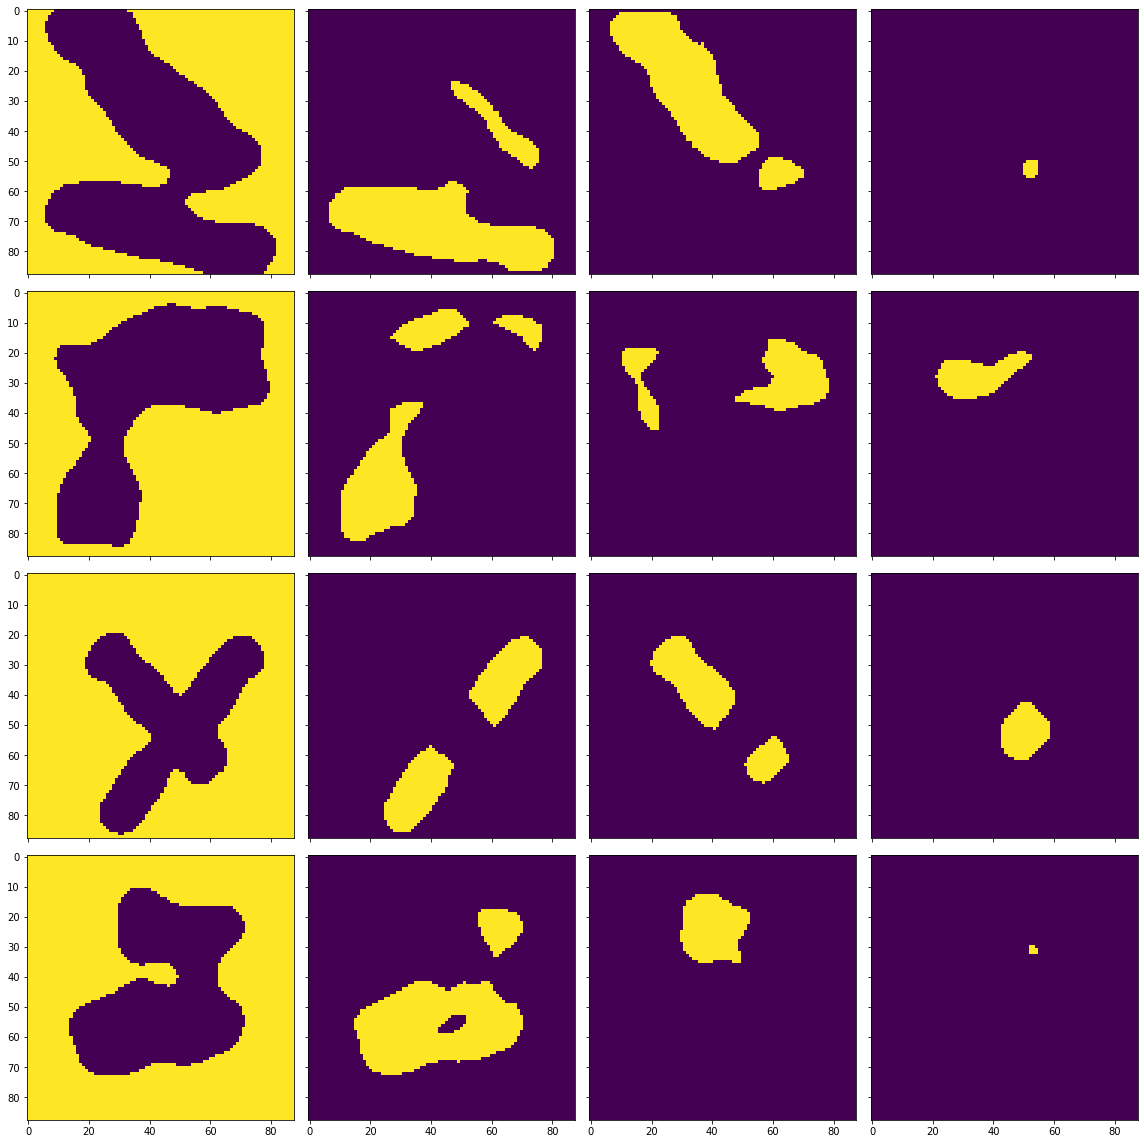

Training IOU: [0.9693482430752061, 0.5829967267575358, 0.4656947021051121, 0.49371651054315563]
Training accuracy: 0.8701823992768595
Testing IOU: [0.9688722684817084, 0.44298236074559016, 0.2937317710698679, 0.4487034949267193]
Testing accuracy: 0.844269111570248
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0875 - val_loss: 0.0526
INFO:tensorflow:Assets written to: modelseg/savedmodel_34epoch\assets
4
4


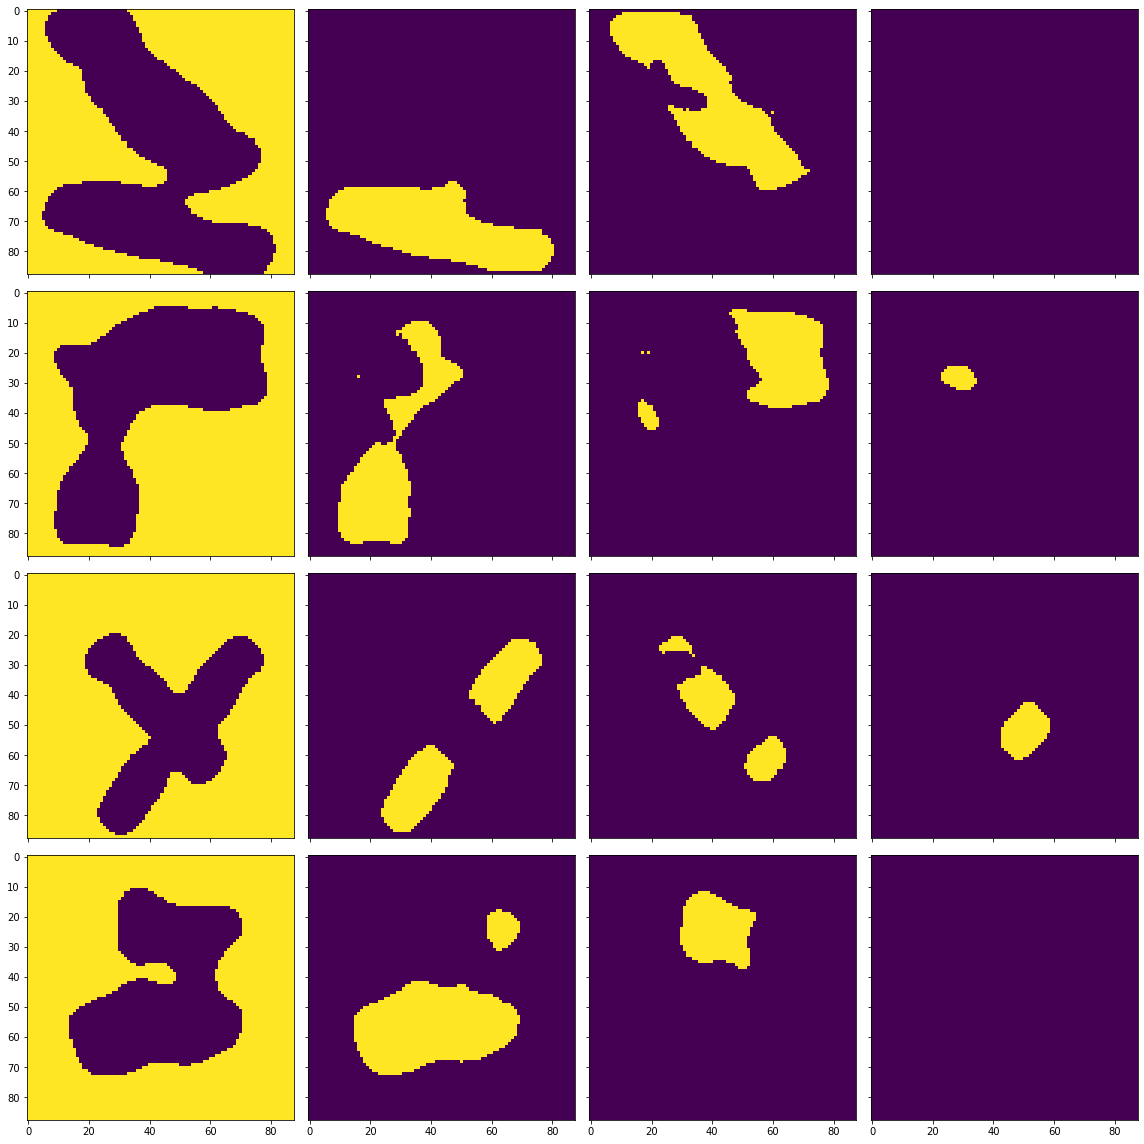

Training IOU: [0.9713384554988503, 0.600687868695444, 0.4779501096977921, 0.3994312440754591]
Training accuracy: 0.8701320377066115
Testing IOU: [0.970924919226179, 0.4631150557101014, 0.3019376230442441, 0.30482560917343526]
Testing accuracy: 0.8438132747933884
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0867 - val_loss: 0.0586
INFO:tensorflow:Assets written to: modelseg/savedmodel_35epoch\assets
4
4


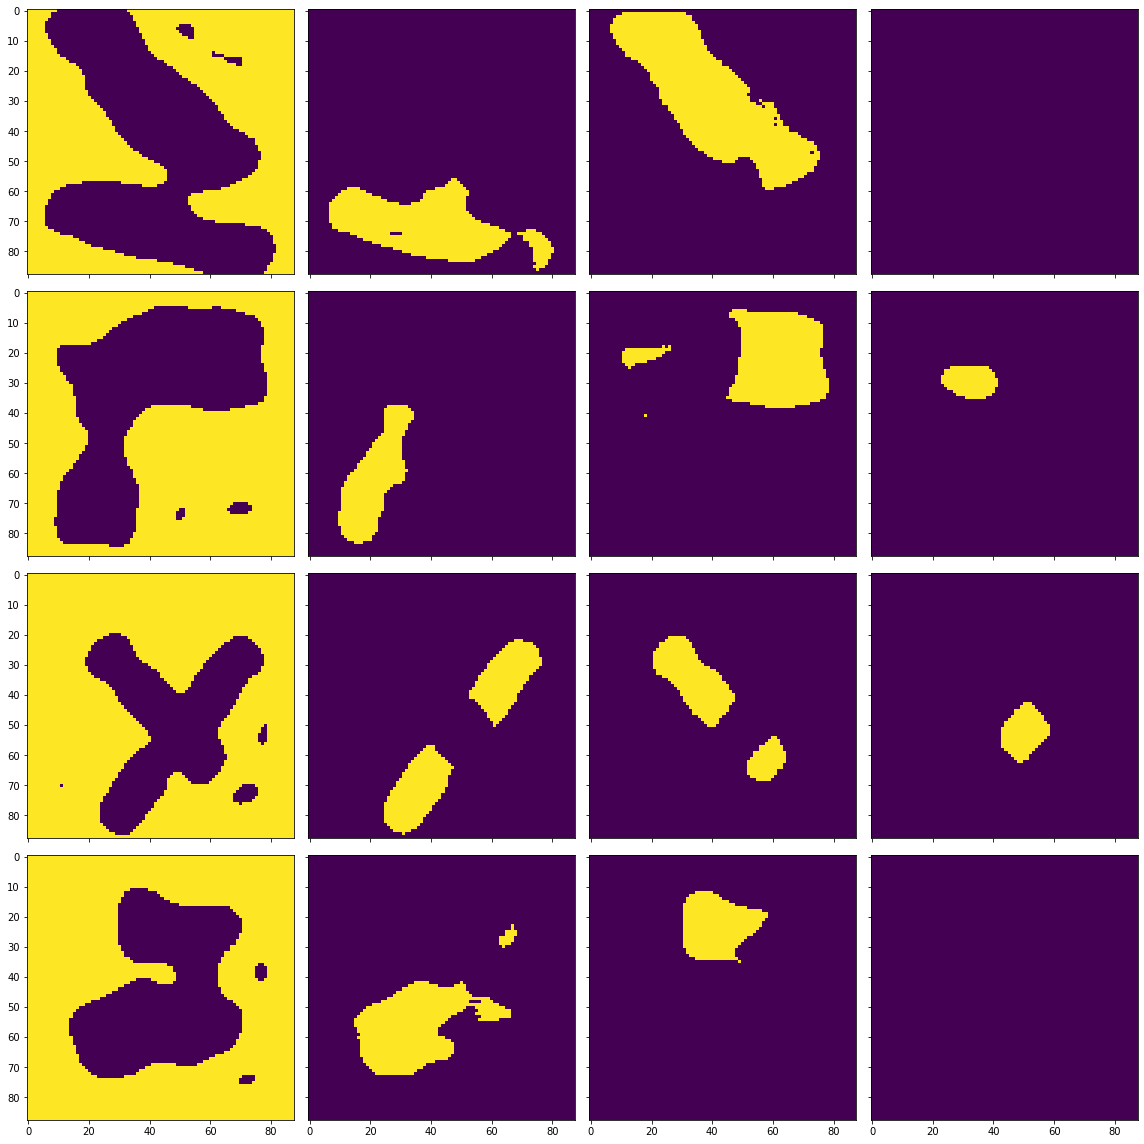

Training IOU: [0.94251534215425, 0.5117447198471501, 0.5350661669612582, 0.4008779029948322]
Training accuracy: 0.8382315340909091
Testing IOU: [0.9406247817280157, 0.3306846604846428, 0.35161336721484393, 0.29844940587200935]
Testing accuracy: 0.8032838326446281
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0867 - val_loss: 0.0528
INFO:tensorflow:Assets written to: modelseg/savedmodel_36epoch\assets
4
4


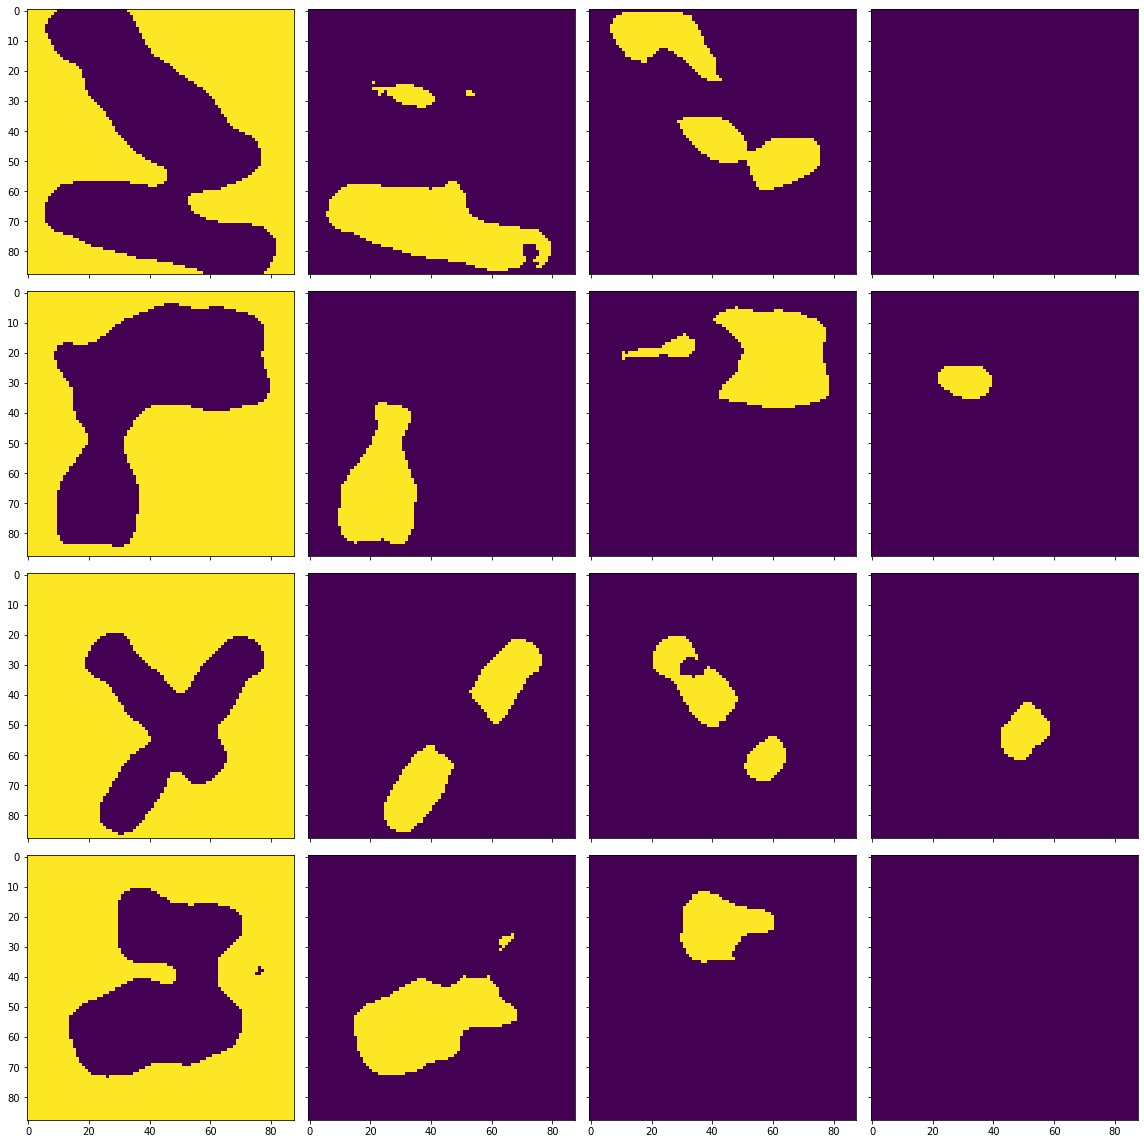

Training IOU: [0.9598455137444558, 0.6070363025602192, 0.490253679733162, 0.40776326699834164]
Training accuracy: 0.8641961518595042
Testing IOU: [0.9588987206990784, 0.46214719843191177, 0.30681736078856375, 0.328537936913896]
Testing accuracy: 0.8361634814049587
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0870 - val_loss: 0.0499
INFO:tensorflow:Assets written to: modelseg/savedmodel_37epoch\assets
4
4


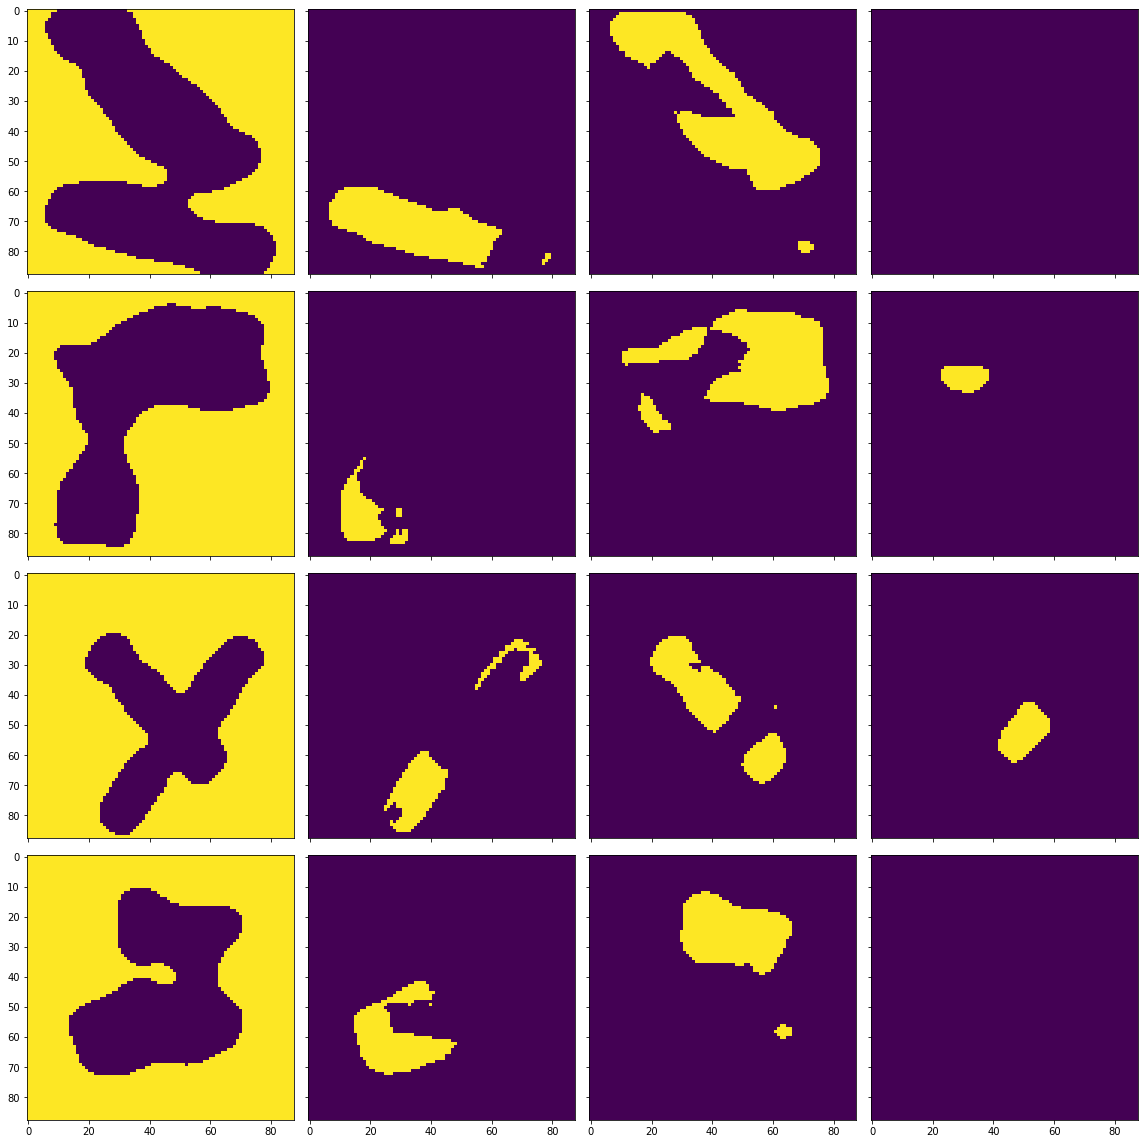

Training IOU: [0.9708831387074711, 0.28985932946279, 0.5804942535797093, 0.4420151234413341]
Training accuracy: 0.8353183109504132
Testing IOU: [0.9707957204363504, 0.2365364873912073, 0.4102227696262183, 0.34885742037728135]
Testing accuracy: 0.8192394111570248
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0870 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_38epoch\assets
4
4


Training IOU: [0.9721500705319839, 0.6301782724317936, 0.37641909125134554, 0.43164915654762515]
Training accuracy: 0.8727618155991735
Testing IOU: [0.9715168872900003, 0.5136812111367056, 0.21992960844698636, 0.36410793817133874]
Testing accuracy: 0.8528060433884298
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0855 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_39epoch\assets
4
4


Training IOU: [0.9653570166366614, 0.5564667785432987, 0.5223334325481906, 0.36898317939553876]
Training accuracy: 0.8575112990702479
Testing IOU: [0.9641153512575888, 0.39674405057112944, 0.33498965623051263, 0.27131495227995756]
Testing accuracy: 0.8273811983471074
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0852 - val_loss: 0.0553
INFO:tensorflow:Assets written to: modelseg/savedmodel_40epoch\assets
4
4


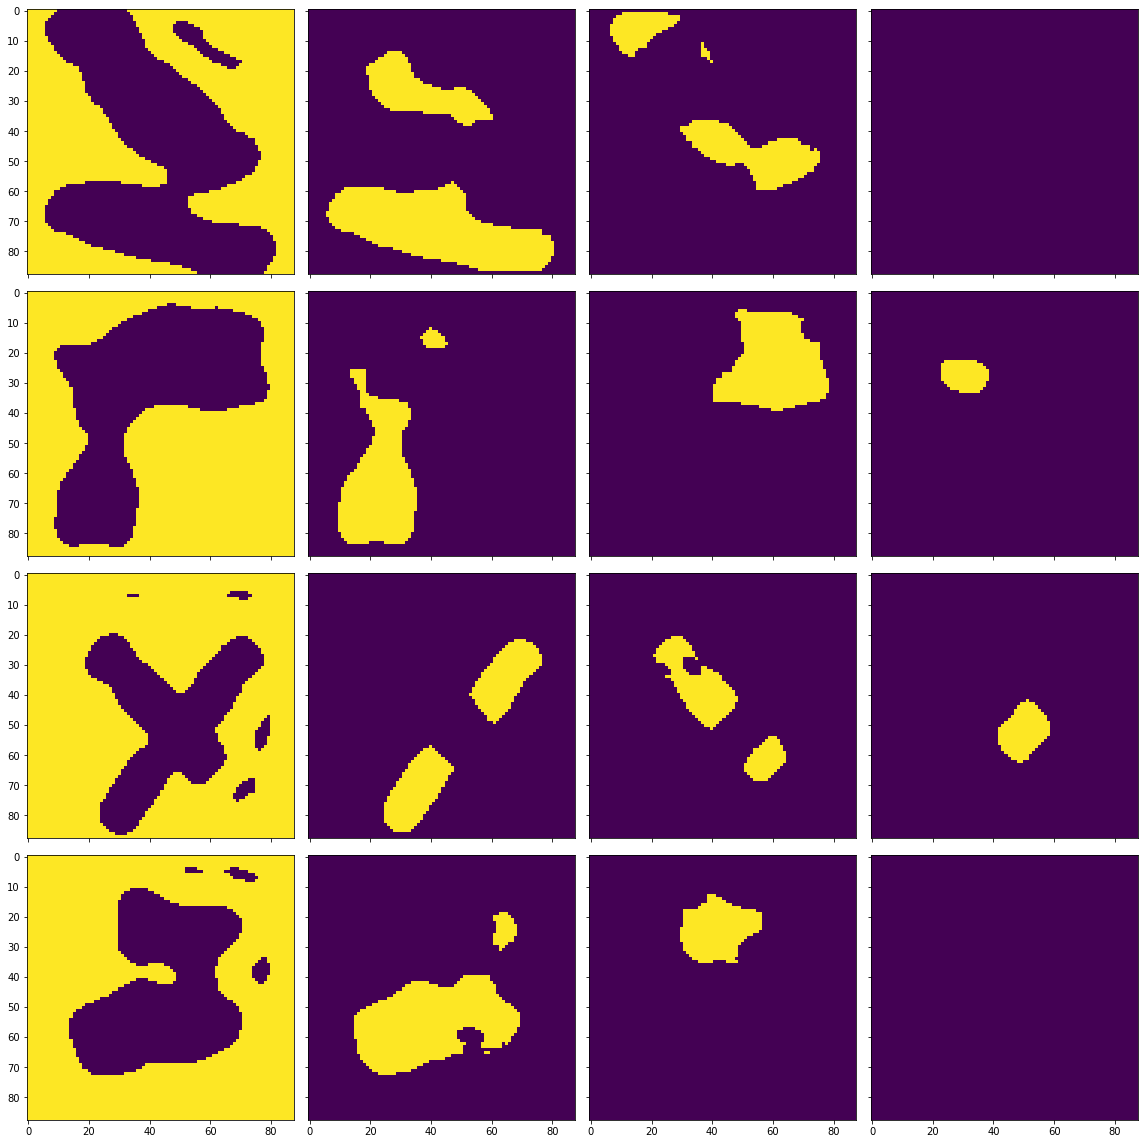

Training IOU: [0.9430282828491057, 0.6055329583572847, 0.38813962713209044, 0.41573684373804326]
Training accuracy: 0.847787319214876
Testing IOU: [0.9413779864225755, 0.4918867302816949, 0.2282110838561226, 0.321545965433146]
Testing accuracy: 0.8260033574380166
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0854 - val_loss: 0.0488
INFO:tensorflow:Assets written to: modelseg/savedmodel_41epoch\assets
4
4


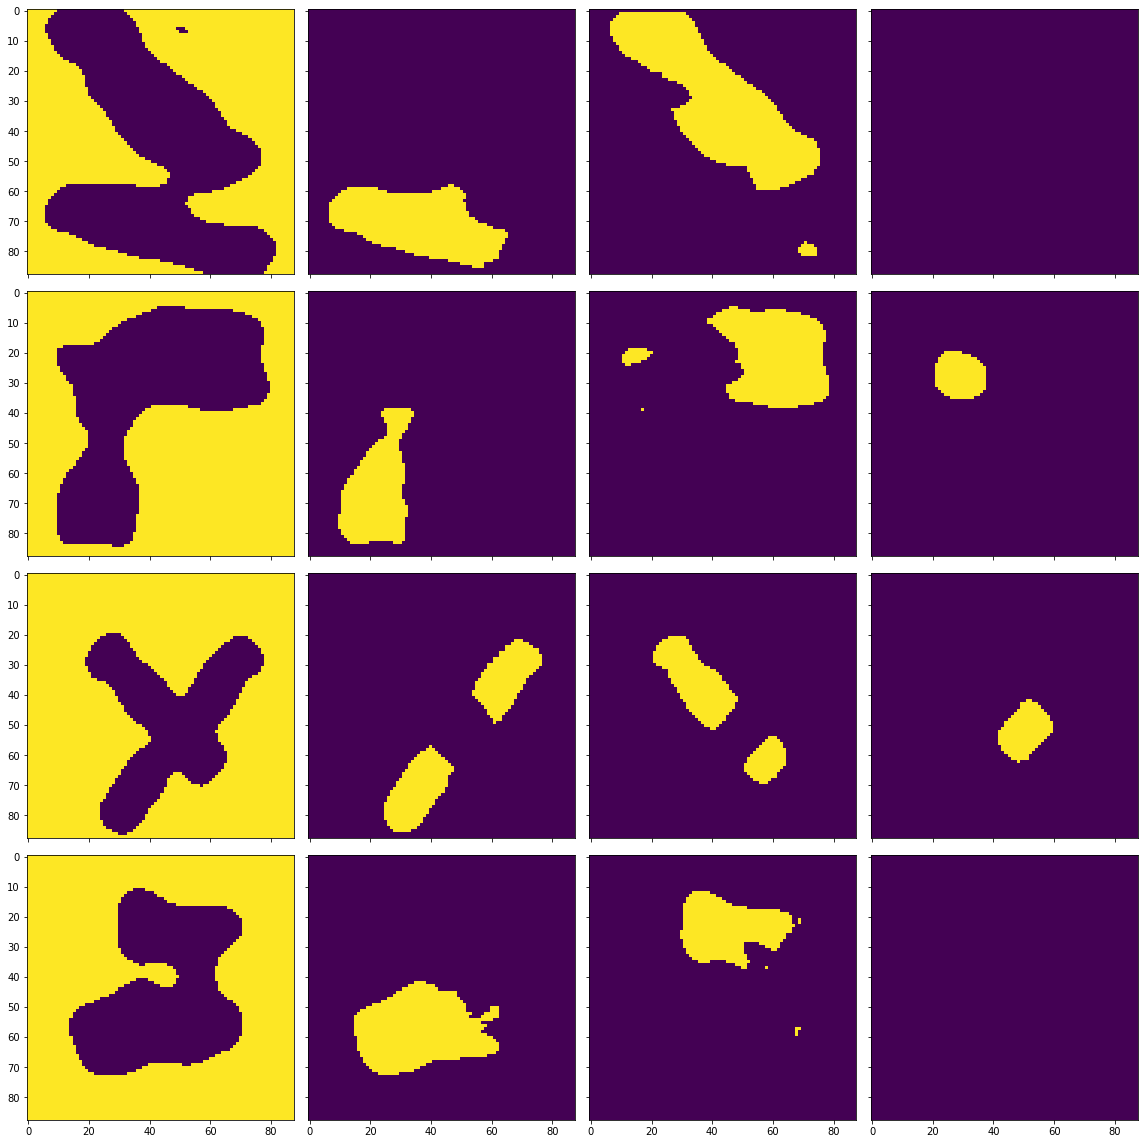

Training IOU: [0.9736280032810052, 0.5650527255433428, 0.5926096285789285, 0.5089289218572157]
Training accuracy: 0.8827763429752066
Testing IOU: [0.9725946719219102, 0.39989156031755024, 0.40203142057050645, 0.4179163378058406]
Testing accuracy: 0.8502246900826447
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0858 - val_loss: 0.0487
INFO:tensorflow:Assets written to: modelseg/savedmodel_42epoch\assets
4
4


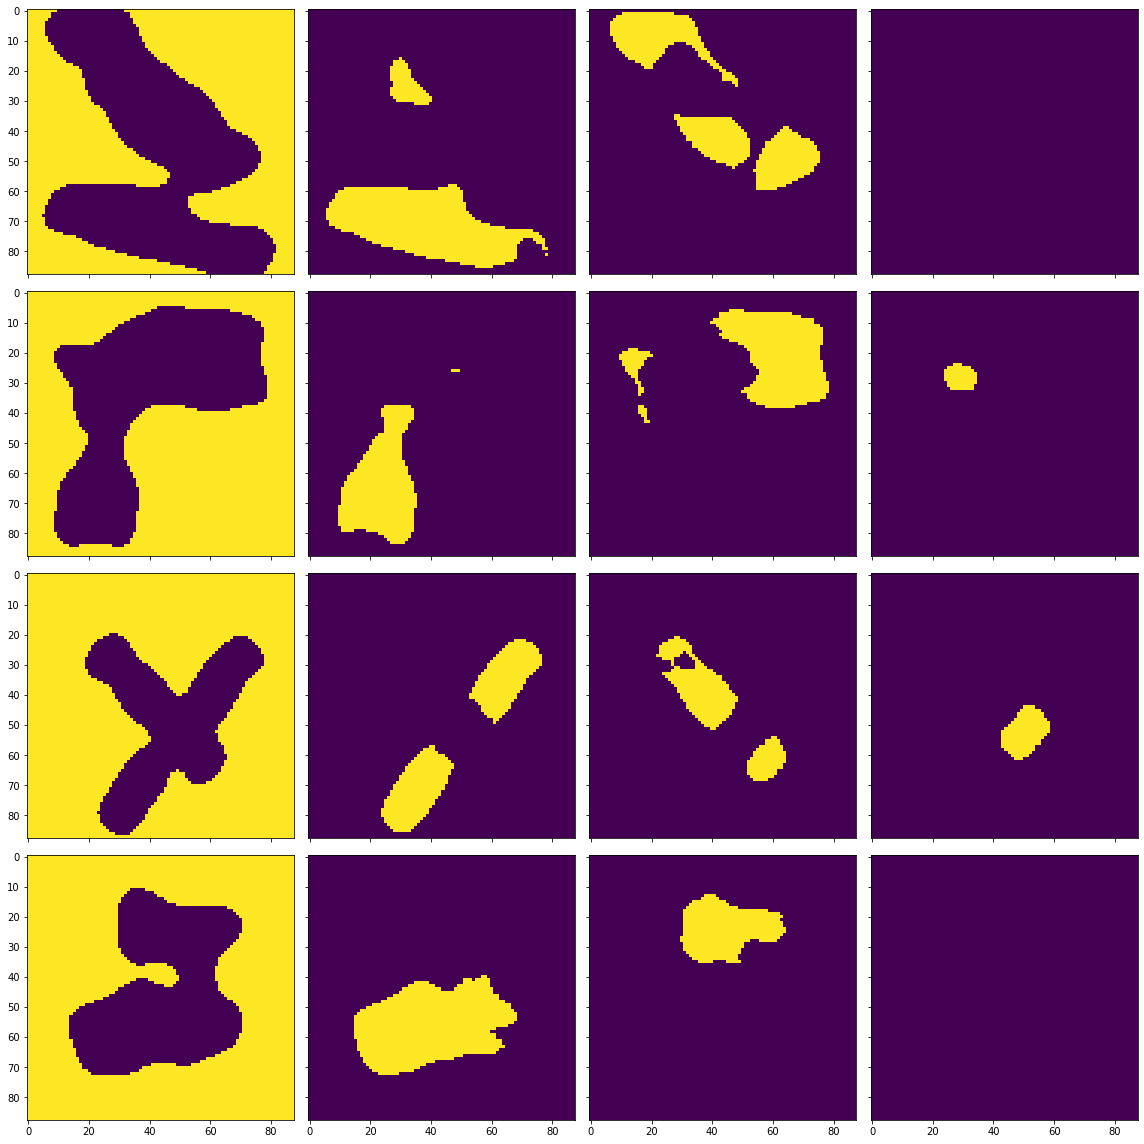

Training IOU: [0.9735081047303407, 0.6173471635185166, 0.5173054252127547, 0.3144308943089431]
Training accuracy: 0.8713391012396694
Testing IOU: [0.9725105614656386, 0.4517461682587462, 0.3153807562867117, 0.25281540721397094]
Testing accuracy: 0.8415069731404958
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0848 - val_loss: 0.0529
INFO:tensorflow:Assets written to: modelseg/savedmodel_43epoch\assets
4
4


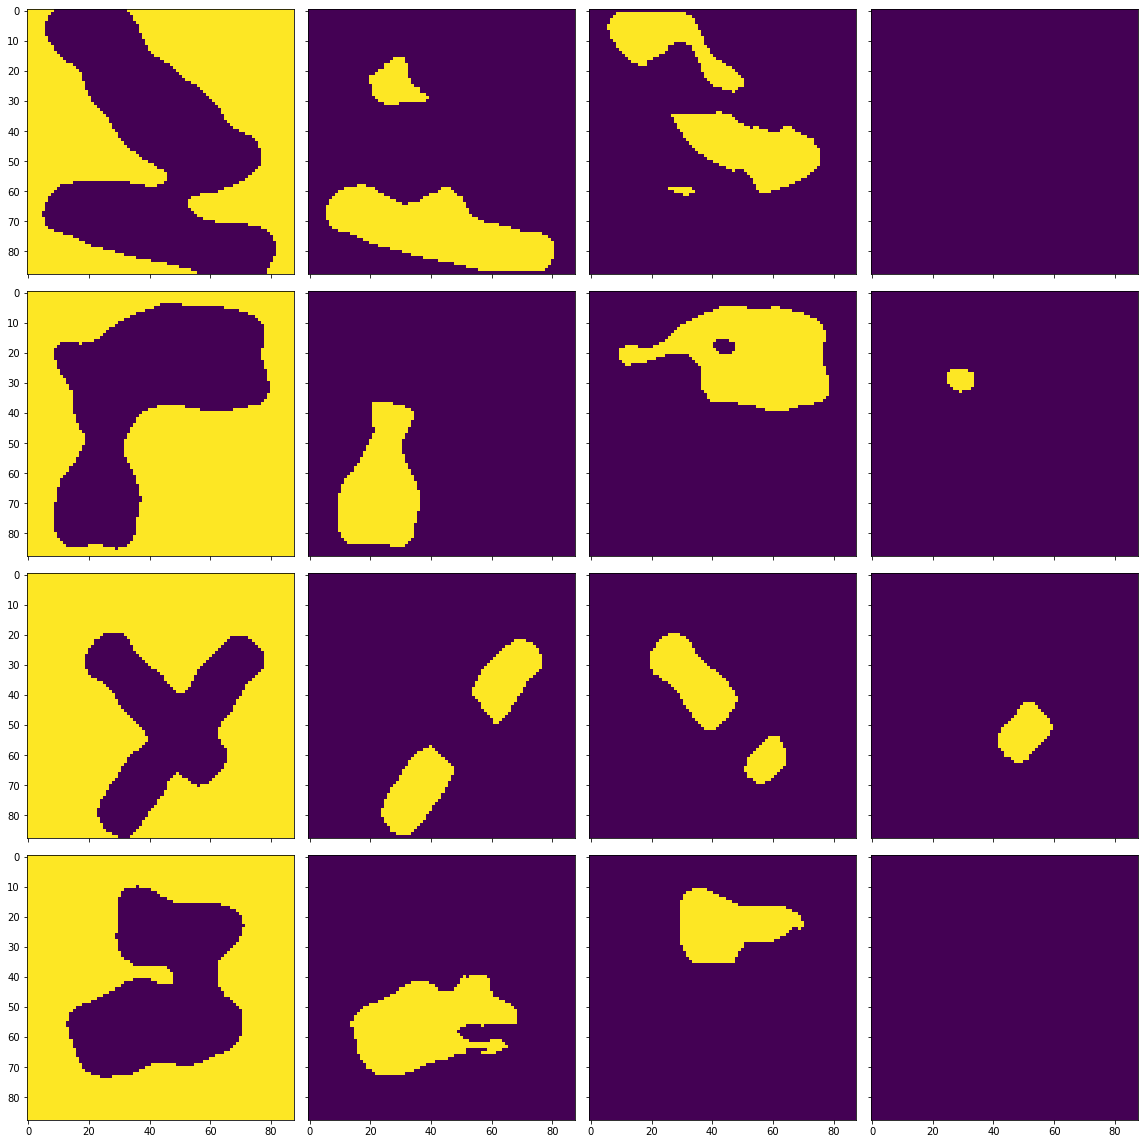

Training IOU: [0.9608150230380733, 0.5930072925697384, 0.5449884123725484, 0.37865689406753117]
Training accuracy: 0.8665873579545454
Testing IOU: [0.9617680627363527, 0.43796638275420213, 0.34215653016719166, 0.3049315502933559]
Testing accuracy: 0.8364617768595042
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0853 - val_loss: 0.0499
INFO:tensorflow:Assets written to: modelseg/savedmodel_44epoch\assets
4
4


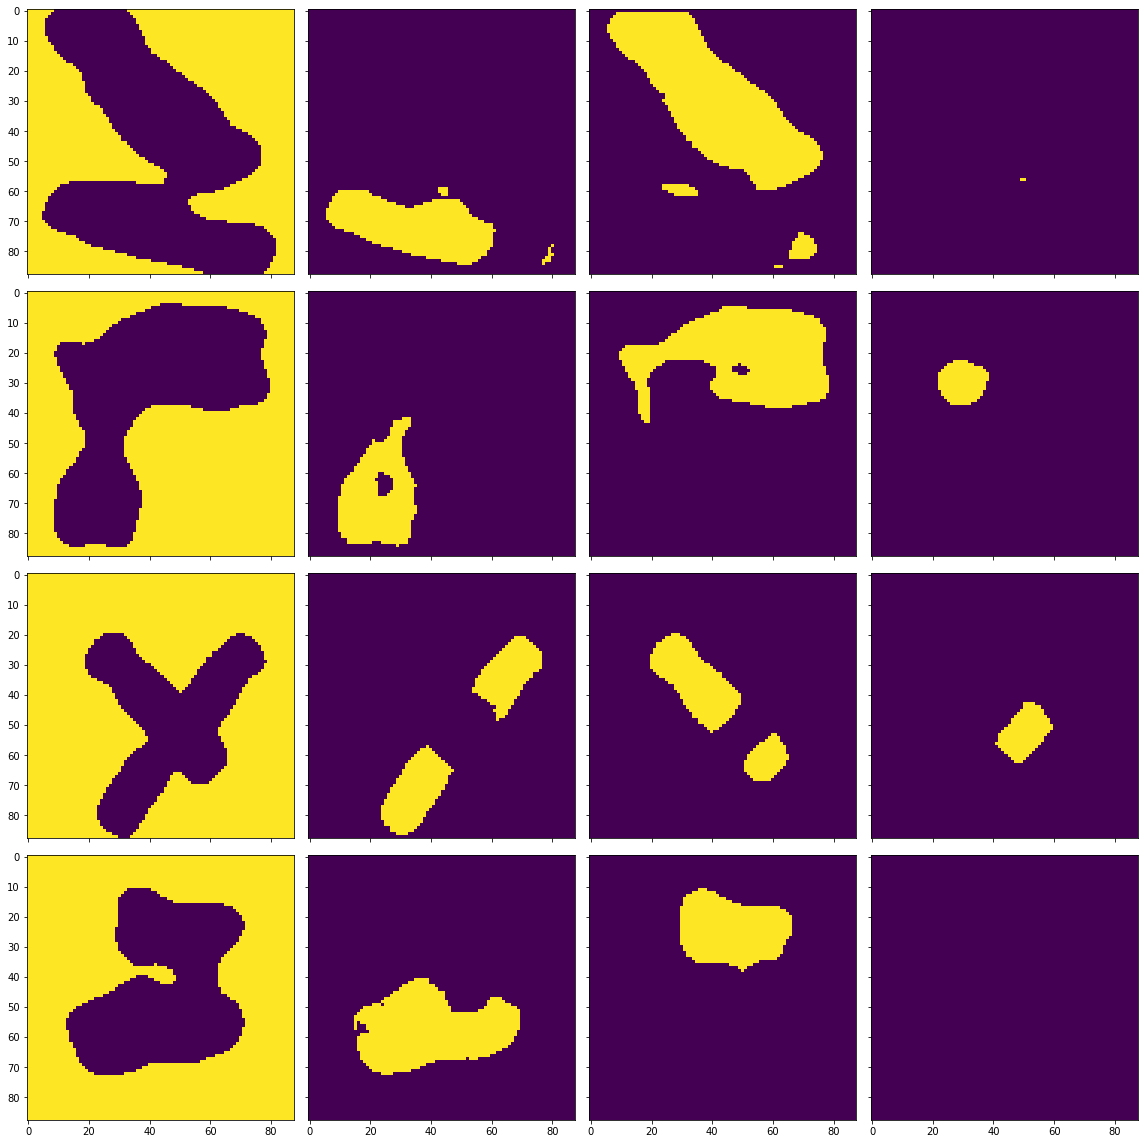

Training IOU: [0.9633986386792615, 0.5443668926935645, 0.6190152100088946, 0.4665084997939139]
Training accuracy: 0.8706414643595042
Testing IOU: [0.9648793725479197, 0.3695514383227694, 0.3962104644110782, 0.36620873487799877]
Testing accuracy: 0.8343737086776859
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0847 - val_loss: 0.0506
INFO:tensorflow:Assets written to: modelseg/savedmodel_45epoch\assets
4
4


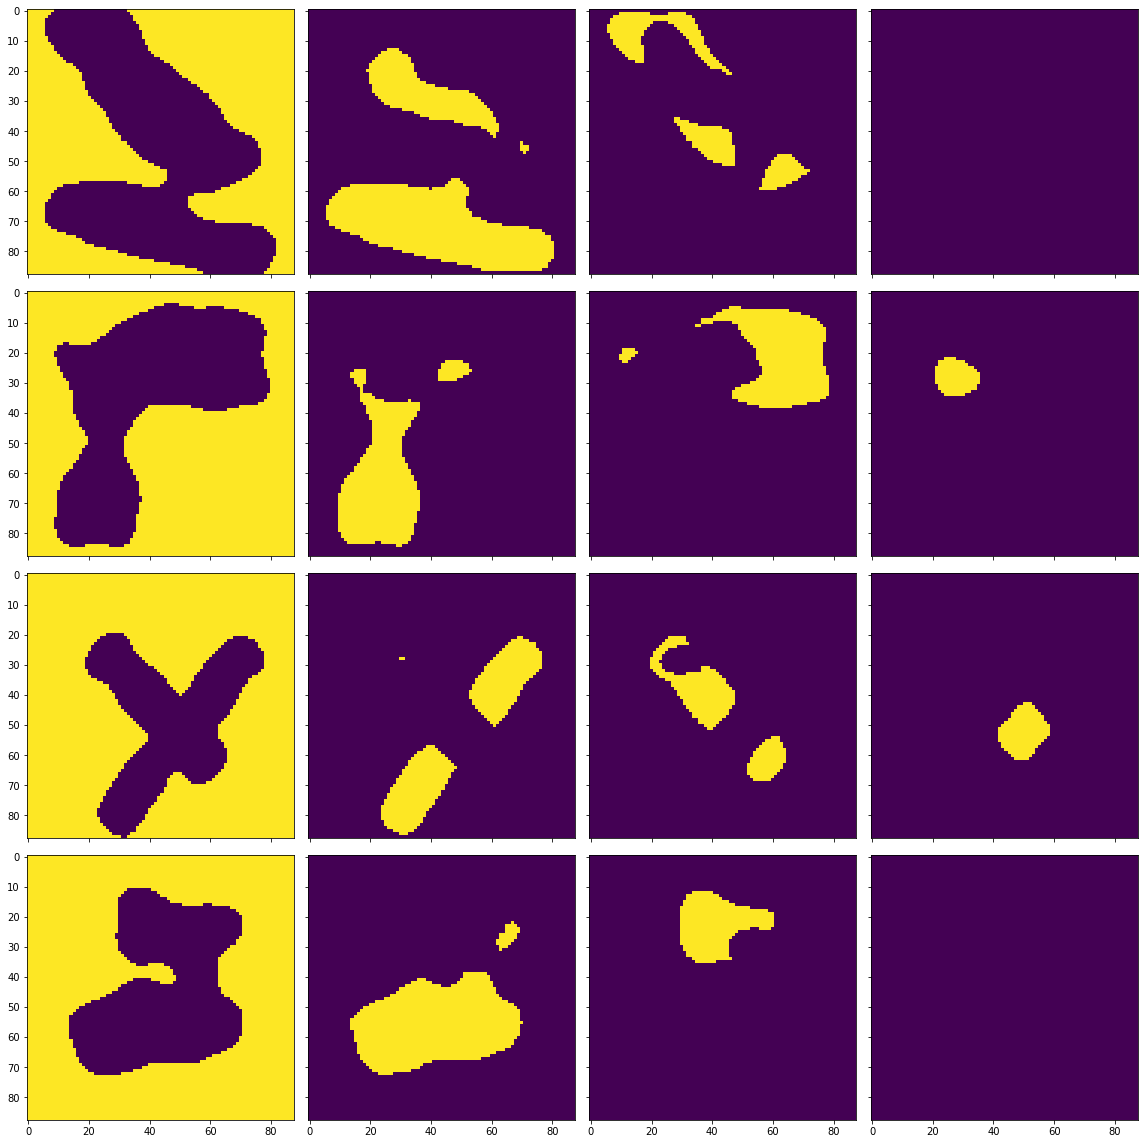

Training IOU: [0.9694755712912125, 0.6657409089222344, 0.48928128598573956, 0.4608711835316742]
Training accuracy: 0.8817771823347107
Testing IOU: [0.9698704434316306, 0.5063198139720673, 0.3060558875515529, 0.350833202737293]
Testing accuracy: 0.8537357954545455
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0847 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_46epoch\assets
4
4


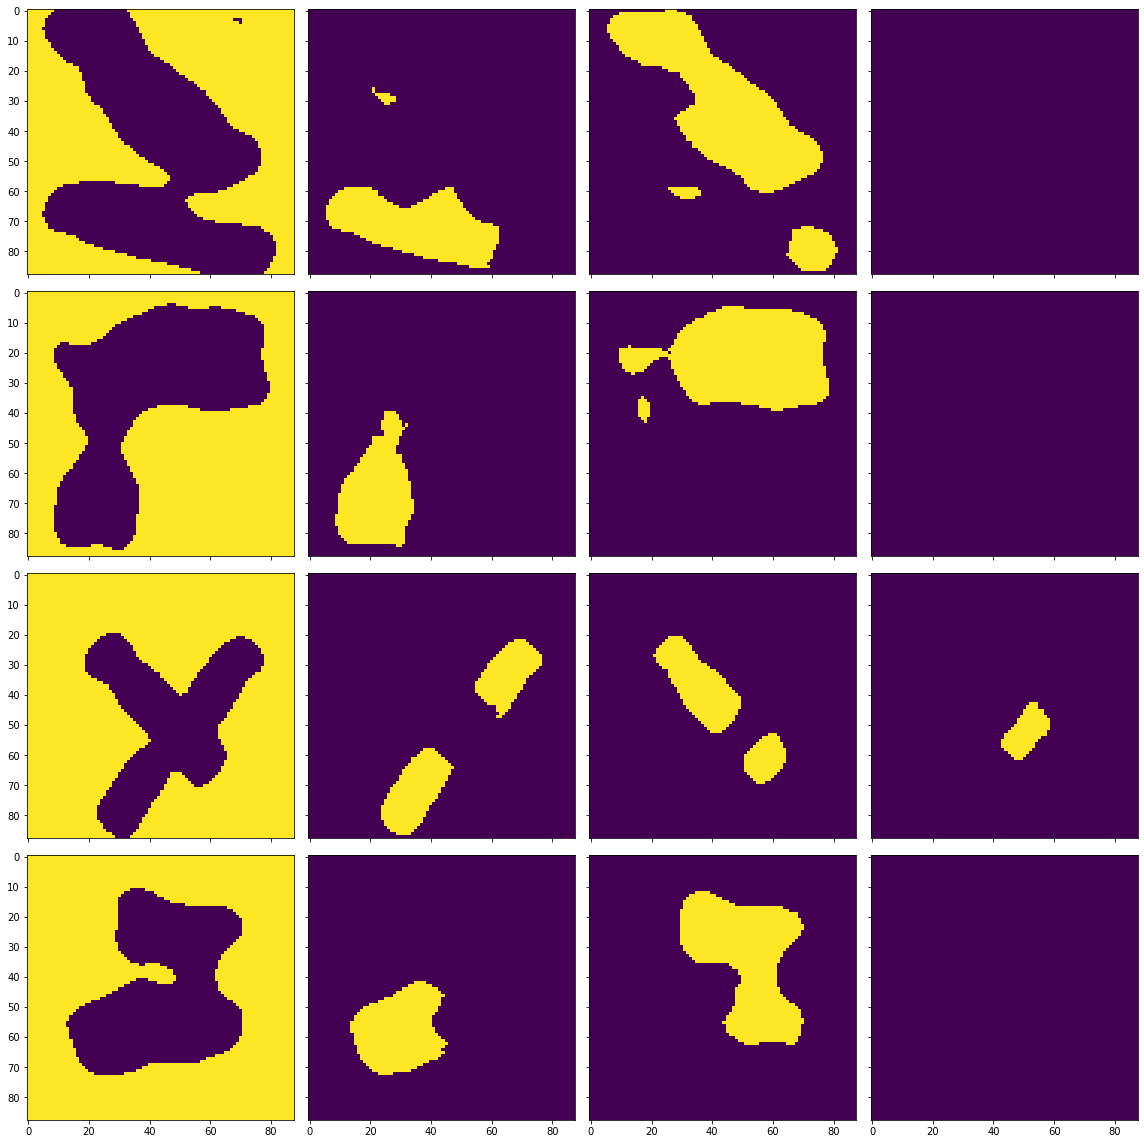

Training IOU: [0.9689011723623643, 0.5577581401067048, 0.558428090328534, 0.20723620885114757]
Training accuracy: 0.871524083161157
Testing IOU: [0.969160685380256, 0.4378136454449636, 0.389375747640778, 0.1924747529590618]
Testing accuracy: 0.8491335227272727
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0858 - val_loss: 0.0724
INFO:tensorflow:Assets written to: modelseg/savedmodel_47epoch\assets
4
4


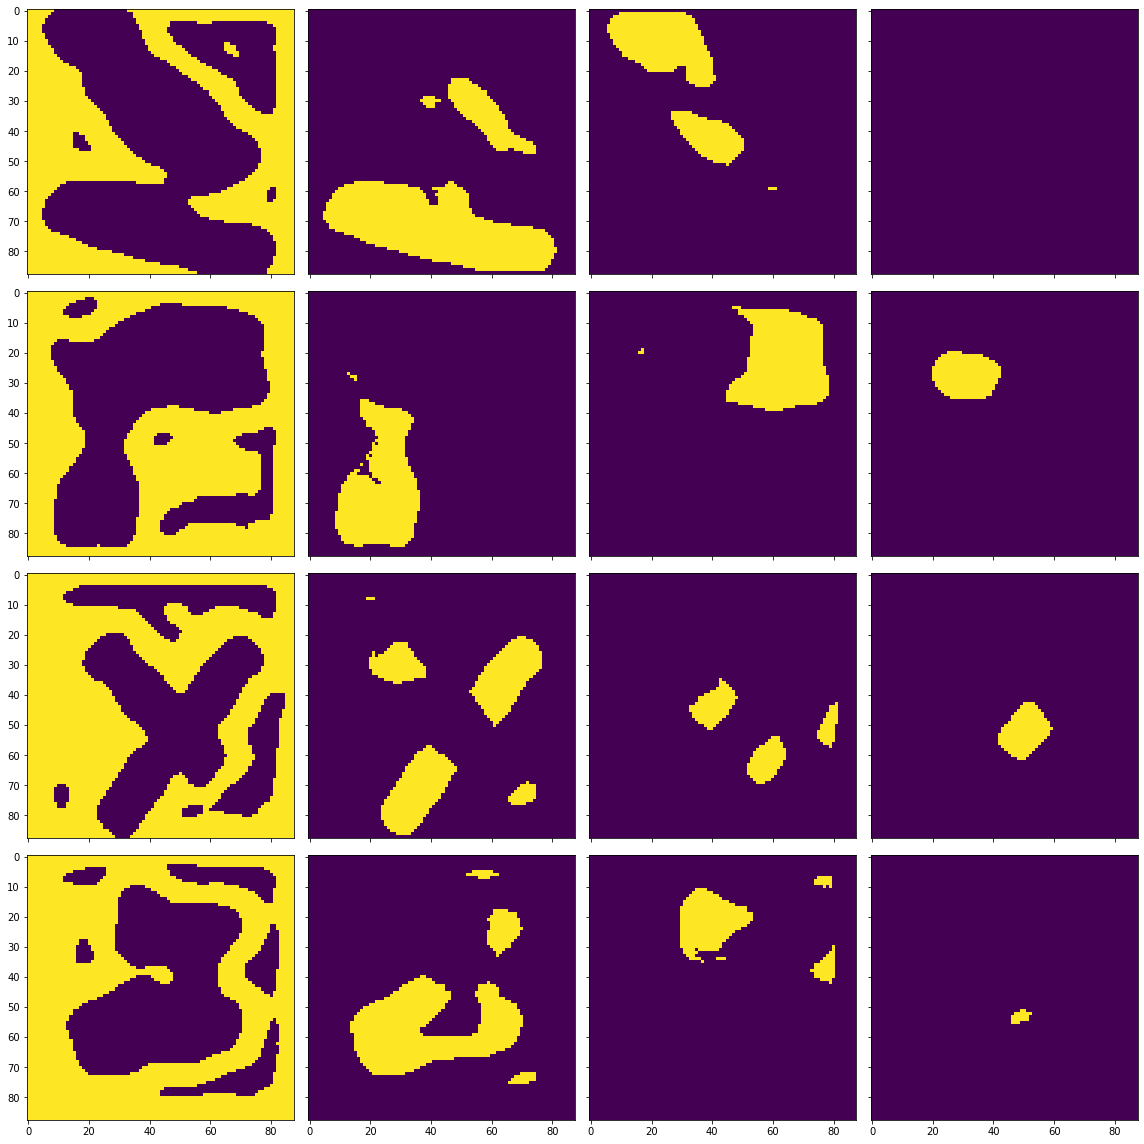

Training IOU: [0.7994921937966416, 0.5835216975977169, 0.426653185135867, 0.5290966316212415]
Training accuracy: 0.7423602143595042
Testing IOU: [0.7983979481385708, 0.4325607352003247, 0.27016677331626937, 0.4270584215920738]
Testing accuracy: 0.7109452479338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0846 - val_loss: 0.0548
INFO:tensorflow:Assets written to: modelseg/savedmodel_48epoch\assets
4
4


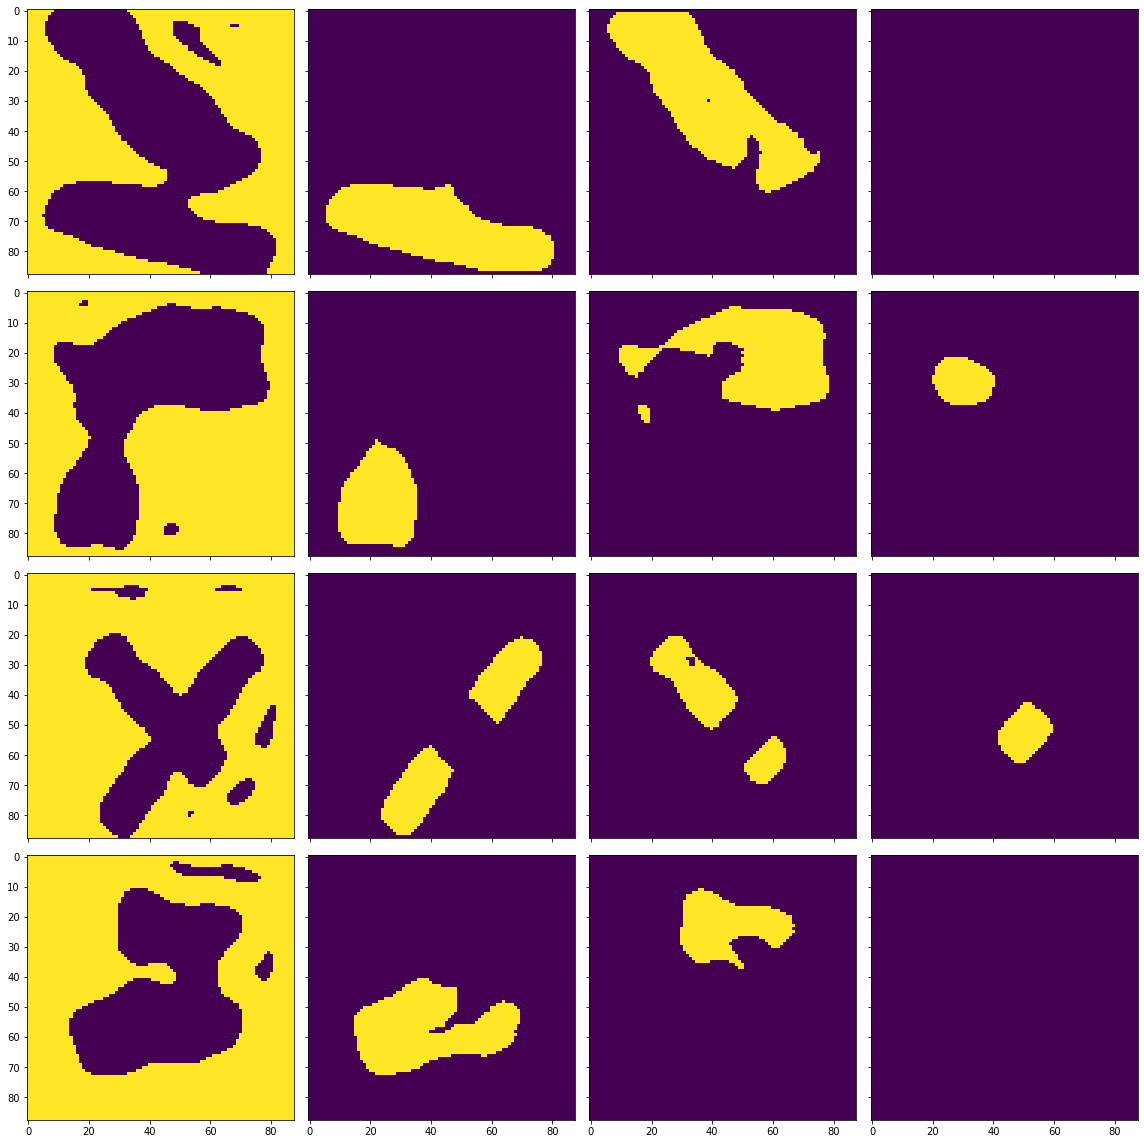

Training IOU: [0.946122900022936, 0.5531812132165734, 0.6190985988400136, 0.5450019688361366]
Training accuracy: 0.8659220041322314
Testing IOU: [0.9449792447028568, 0.3692477894103196, 0.41239258254183625, 0.43385970666791623]
Testing accuracy: 0.8279080578512397
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0841 - val_loss: 0.0877
INFO:tensorflow:Assets written to: modelseg/savedmodel_49epoch\assets
4
4


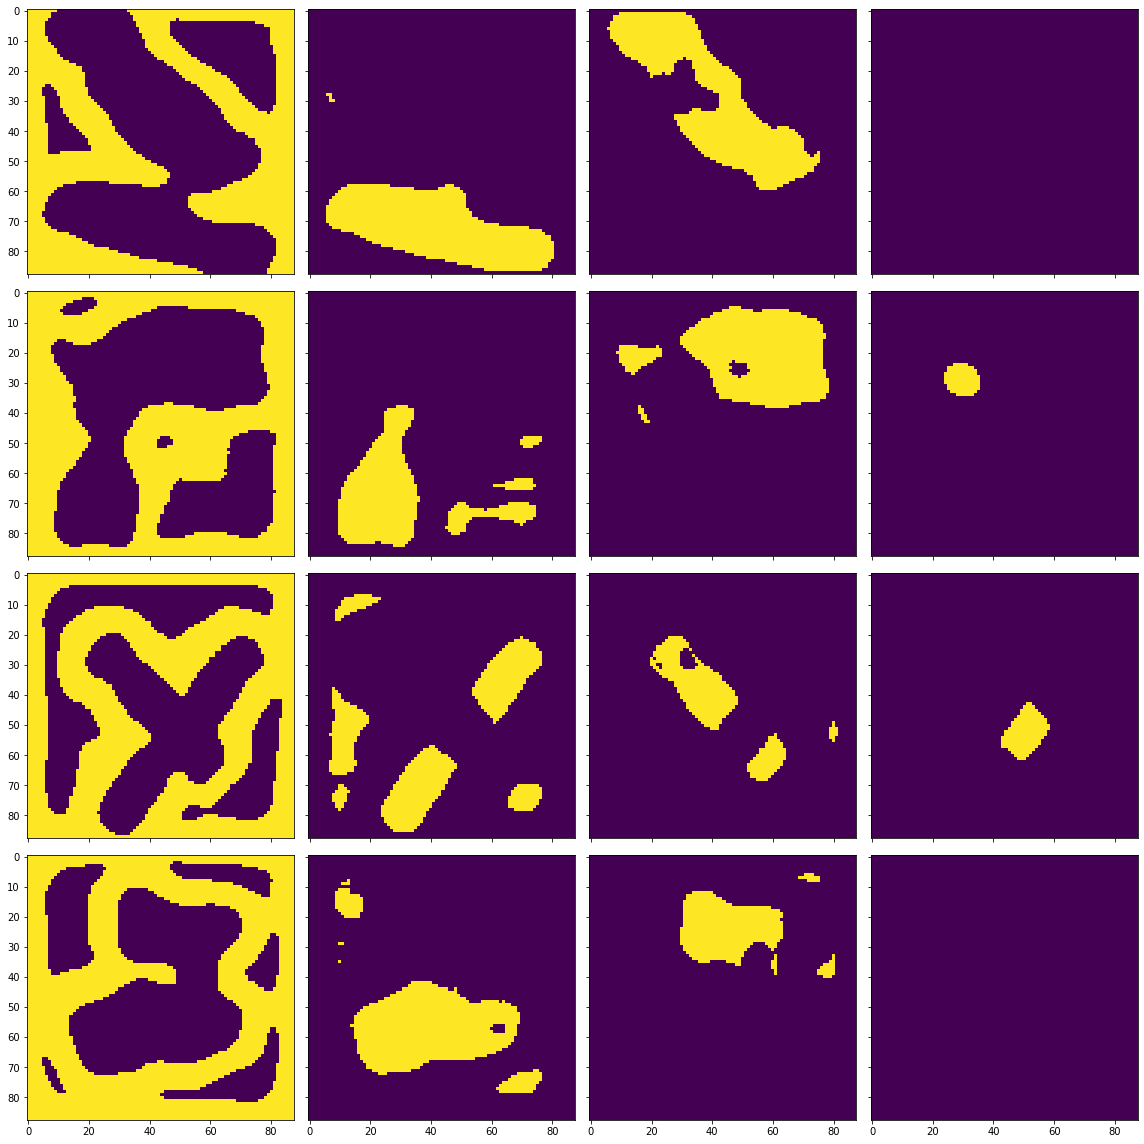

Training IOU: [0.6979807690153028, 0.48086835628974434, 0.5535190298955457, 0.40566891251822756]
Training accuracy: 0.6822879003099174
Testing IOU: [0.6827990463583551, 0.337740995598537, 0.3559040107651478, 0.3230272017236736]
Testing accuracy: 0.6328357438016529
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0832 - val_loss: 0.1288
INFO:tensorflow:Assets written to: modelseg/savedmodel_50epoch\assets
4
4


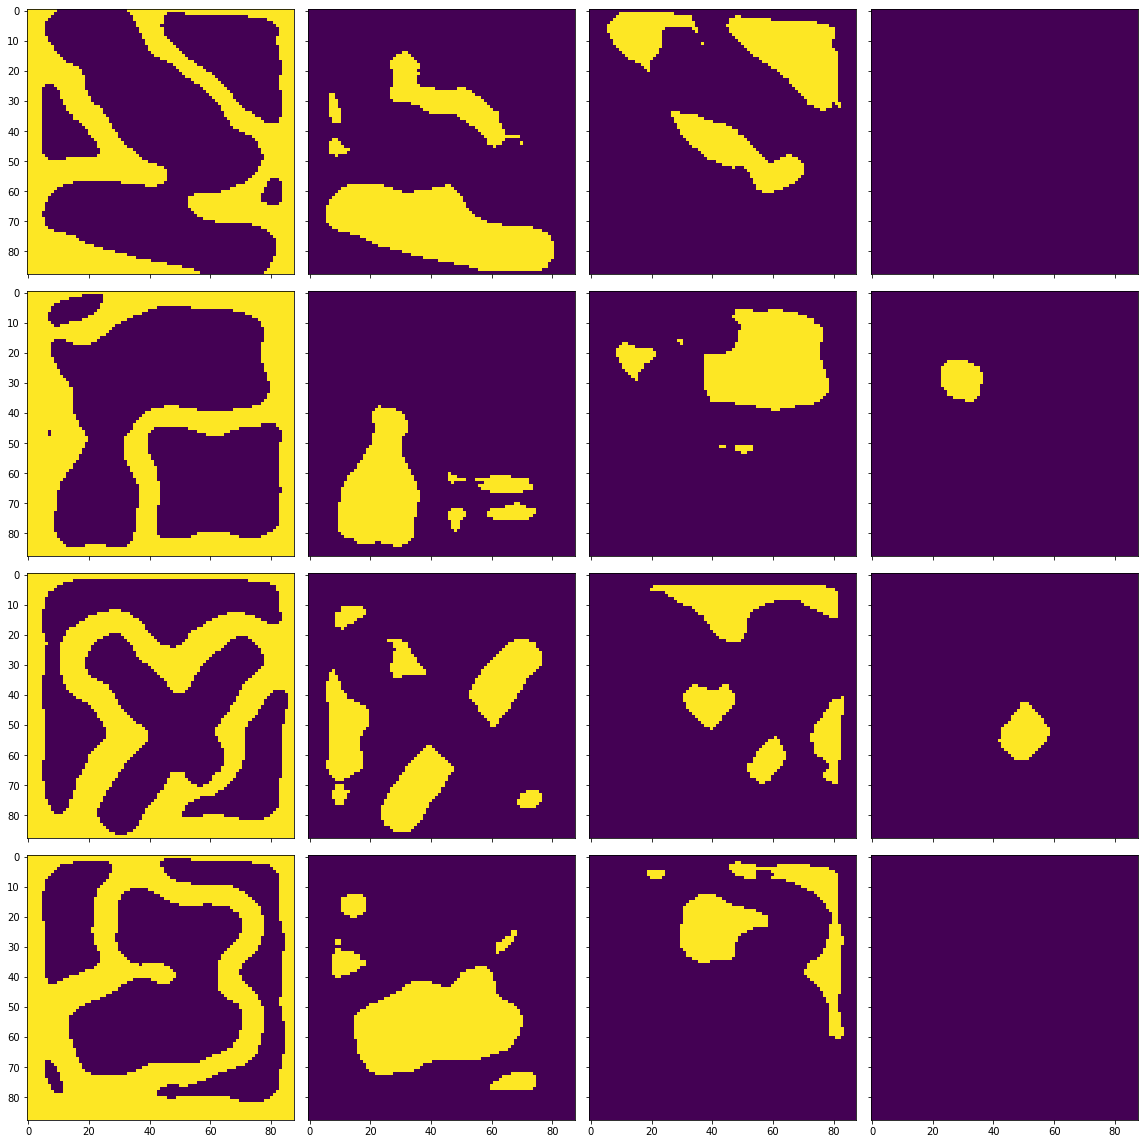

Training IOU: [0.5826645106363117, 0.5003444542859955, 0.23951299413408994, 0.4178933903707432]
Training accuracy: 0.5883803589876033
Testing IOU: [0.5643928934684362, 0.3824135356495282, 0.15844865032578342, 0.3314544004254188]
Testing accuracy: 0.5460201446280992
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0835 - val_loss: 0.0621
INFO:tensorflow:Assets written to: modelseg/savedmodel_51epoch\assets
4
4


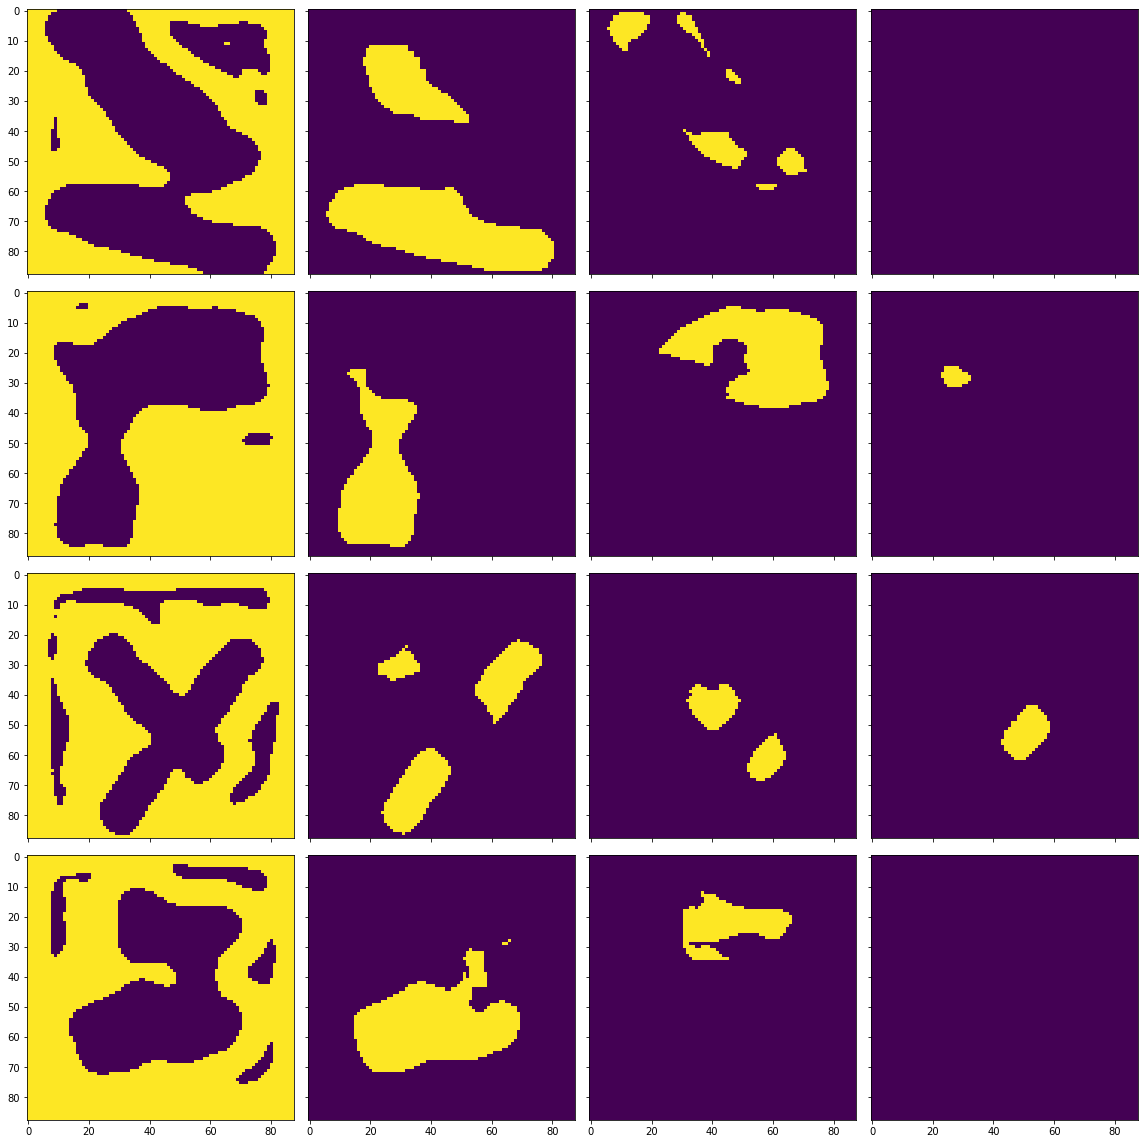

Training IOU: [0.8756341380300598, 0.6073588404960499, 0.4119592066453354, 0.32551997005827943]
Training accuracy: 0.7943511105371901
Testing IOU: [0.8773984389938637, 0.4828627357502474, 0.2734995859814391, 0.26379338350749904]
Testing accuracy: 0.777239152892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0832 - val_loss: 0.0496
INFO:tensorflow:Assets written to: modelseg/savedmodel_52epoch\assets
4
4


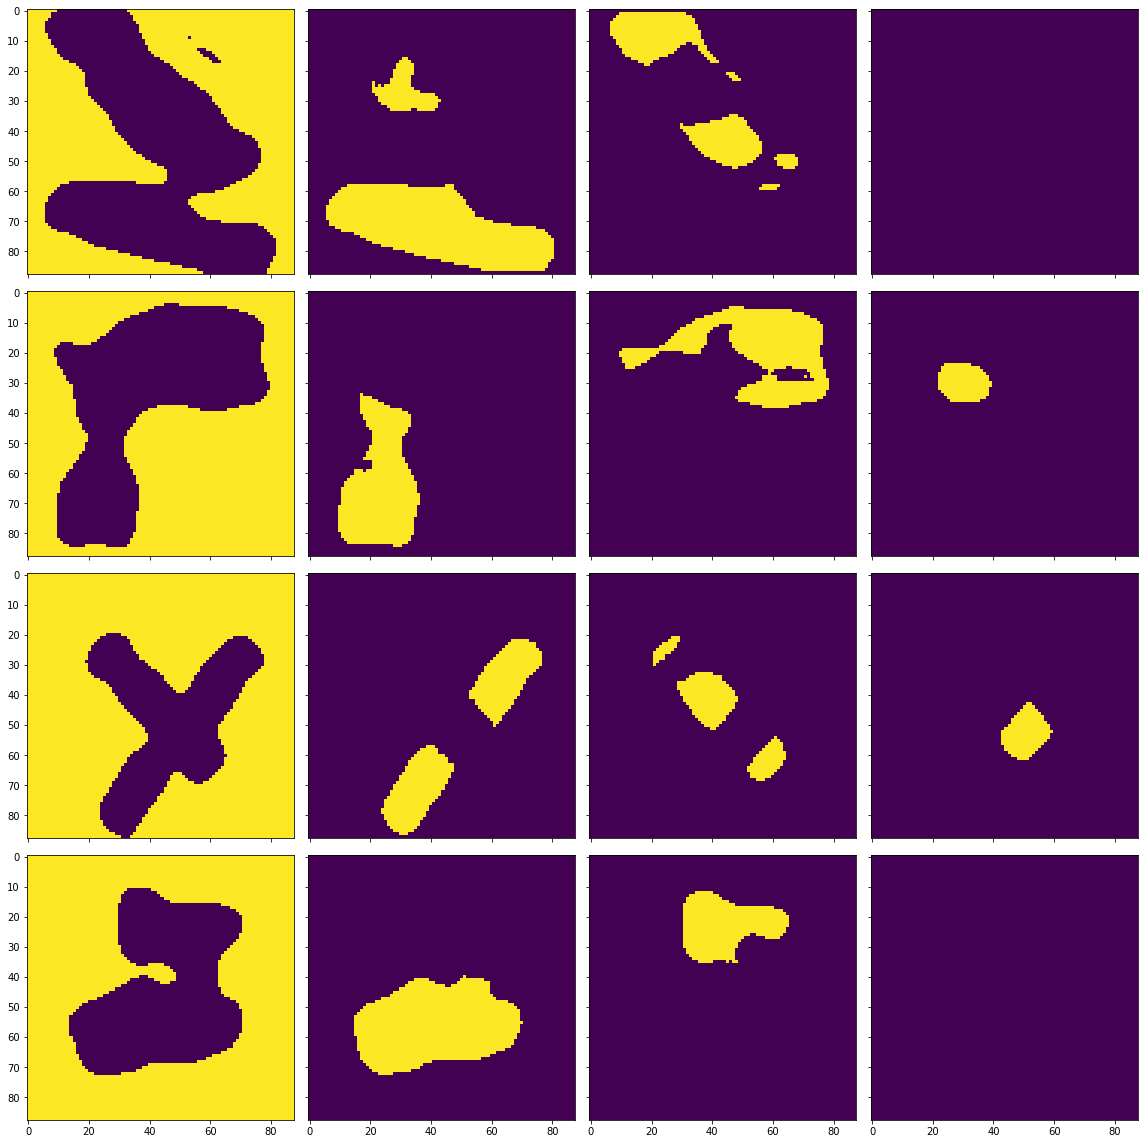

Training IOU: [0.9689905886164939, 0.6460026655947873, 0.5287391362757965, 0.4868706811451135]
Training accuracy: 0.8768185046487603
Testing IOU: [0.9675046808629555, 0.4525594692270349, 0.34596348551126443, 0.36694560669456067]
Testing accuracy: 0.8437202995867769
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0827 - val_loss: 0.0875
INFO:tensorflow:Assets written to: modelseg/savedmodel_53epoch\assets
4
4


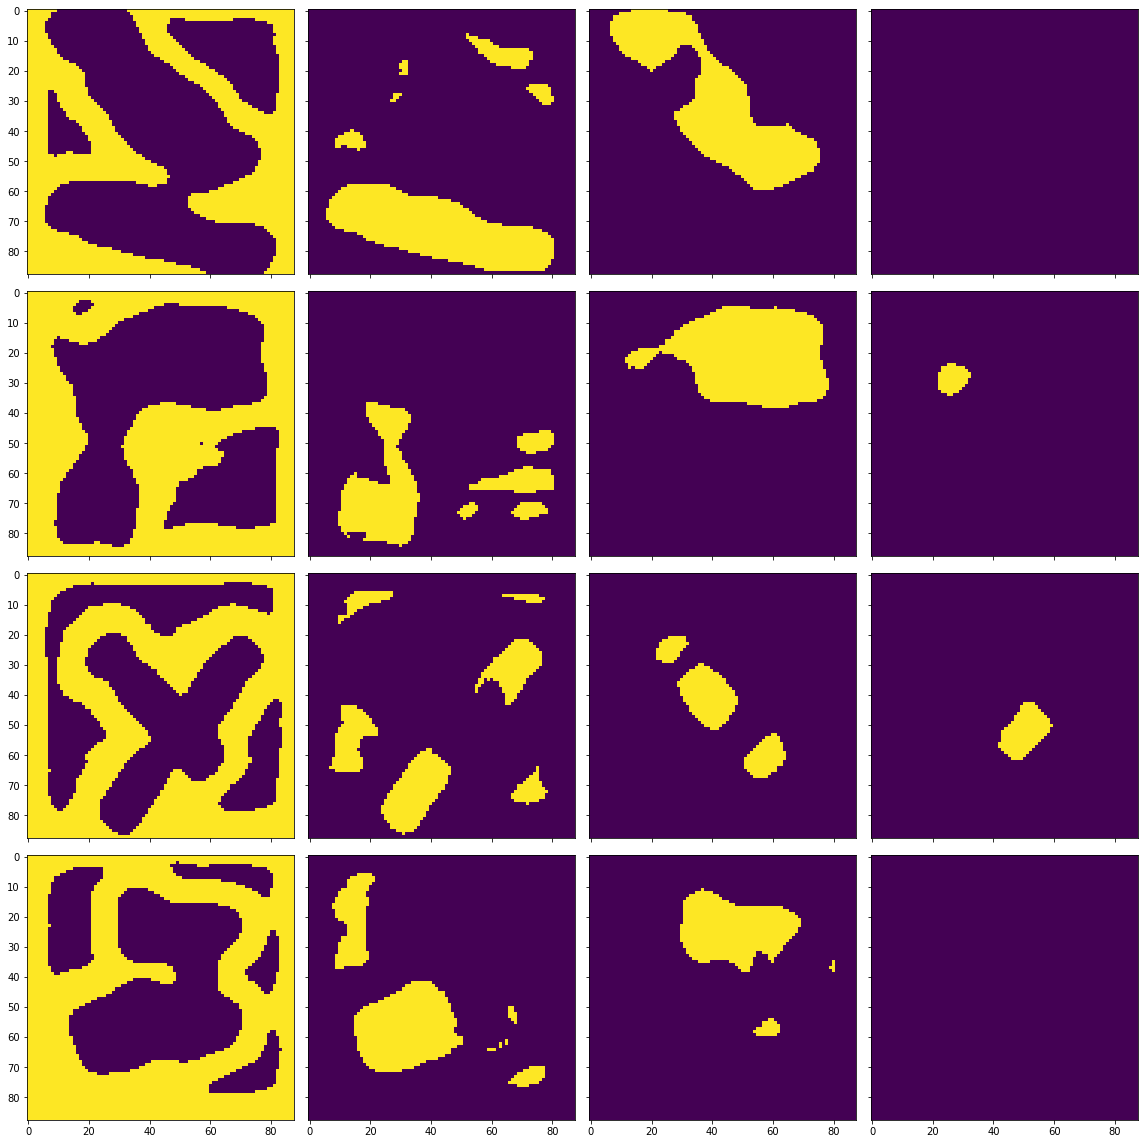

Training IOU: [0.7003365600818422, 0.4128743459845528, 0.617195192138471, 0.47211598601441623]
Training accuracy: 0.6836570247933884
Testing IOU: [0.680608258977206, 0.28339708044336265, 0.3759919647462289, 0.33775310926097235]
Testing accuracy: 0.6263533057851239
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0829 - val_loss: 0.0494
INFO:tensorflow:Assets written to: modelseg/savedmodel_54epoch\assets
4
4


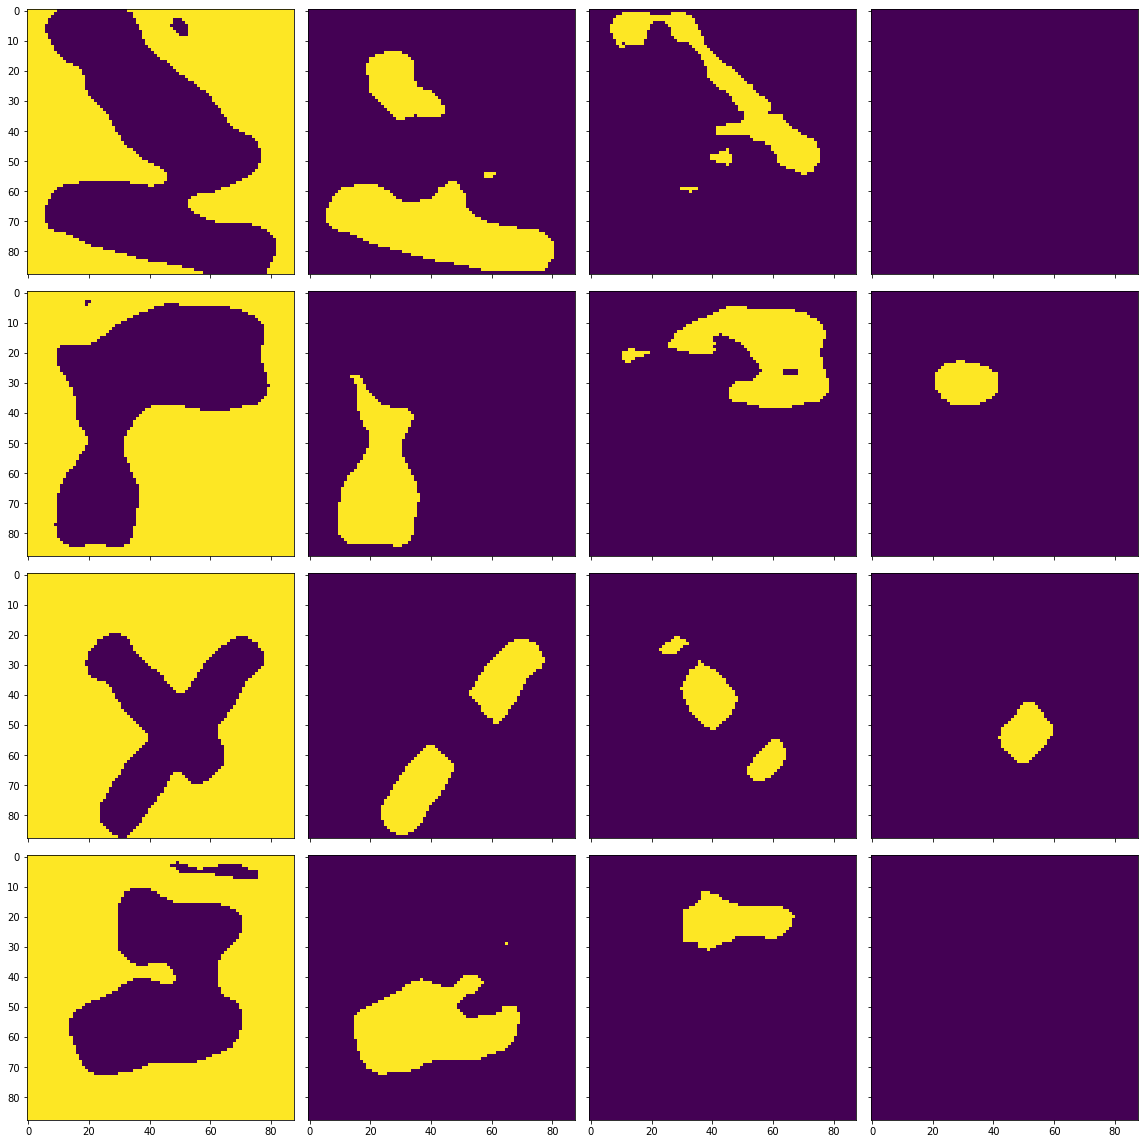

Training IOU: [0.9680047157655801, 0.6712877775313718, 0.46745220613427085, 0.5810050610524732]
Training accuracy: 0.8817429622933884
Testing IOU: [0.9693901260838195, 0.4967178669758006, 0.29364088433470387, 0.4698834196891192]
Testing accuracy: 0.8533974690082644
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0822 - val_loss: 0.0694
INFO:tensorflow:Assets written to: modelseg/savedmodel_55epoch\assets
4
4


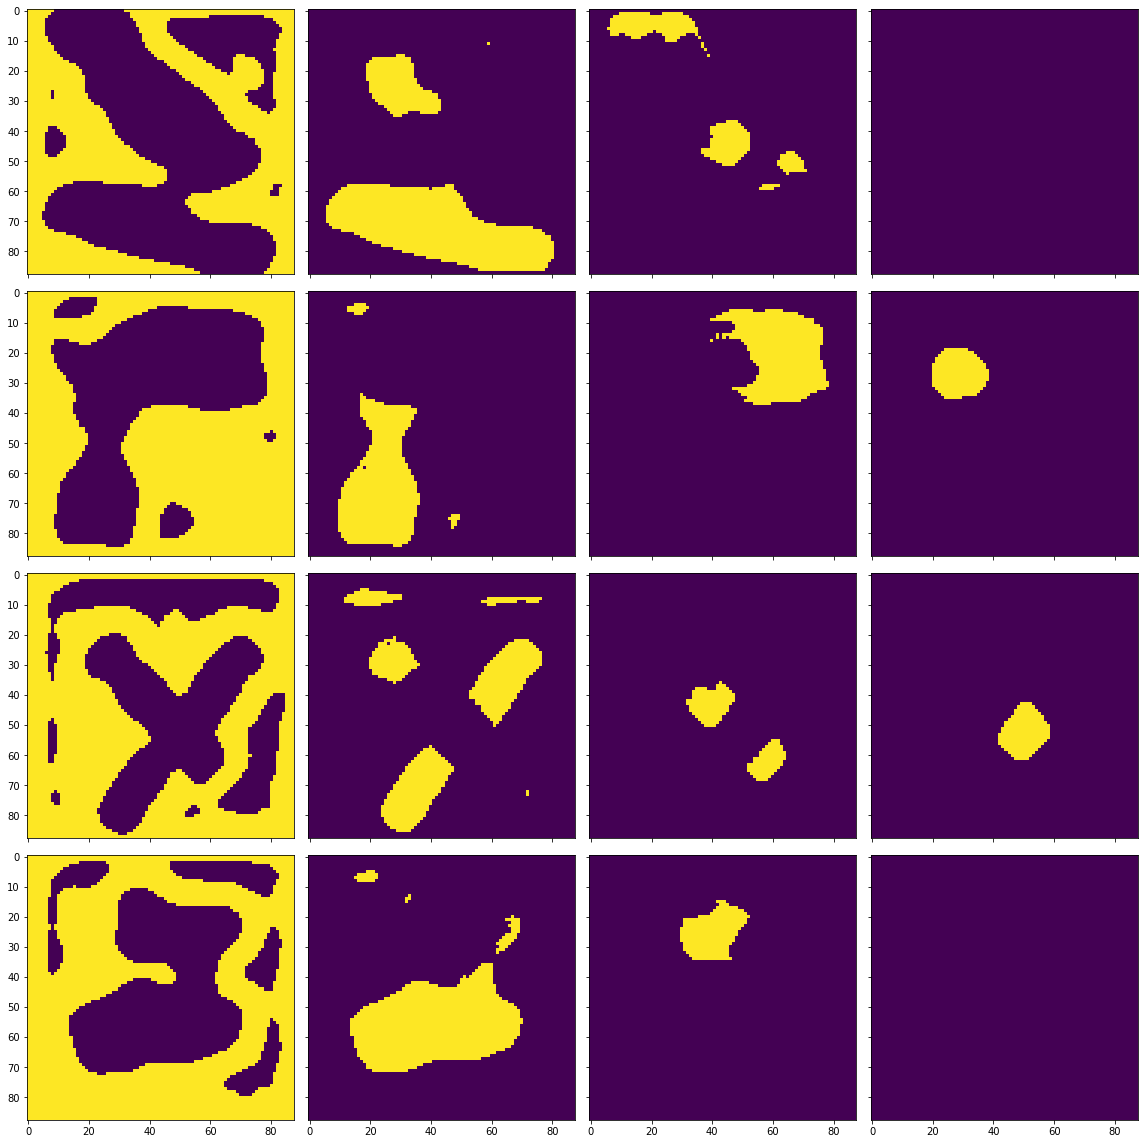

Training IOU: [0.8266115443219504, 0.6568000438852853, 0.33636208877729074, 0.4852905073649755]
Training accuracy: 0.7636935046487603
Testing IOU: [0.8302237796652467, 0.5062618901967638, 0.21180915443511986, 0.36050172921075724]
Testing accuracy: 0.7451355888429753
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0822 - val_loss: 0.0718
INFO:tensorflow:Assets written to: modelseg/savedmodel_56epoch\assets
4
4


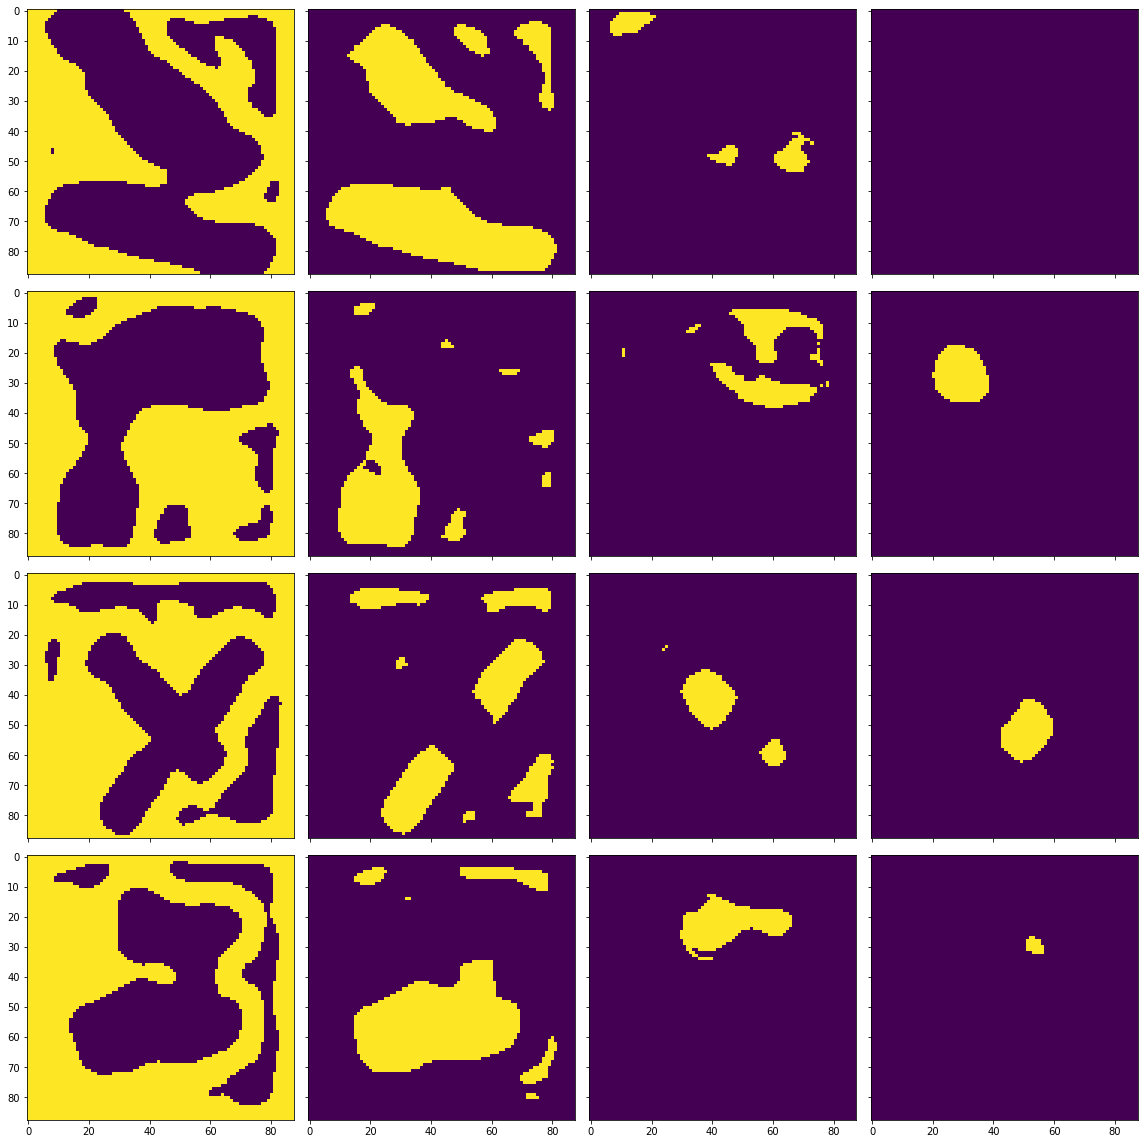

Training IOU: [0.824871932447333, 0.5464197914946094, 0.3249882237067489, 0.5740015071590052]
Training accuracy: 0.7634549328512397
Testing IOU: [0.8276964906623907, 0.45578071428141026, 0.2069689813343022, 0.457328300497146]
Testing accuracy: 0.7472869318181818
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0826 - val_loss: 0.1334
INFO:tensorflow:Assets written to: modelseg/savedmodel_57epoch\assets
4
4


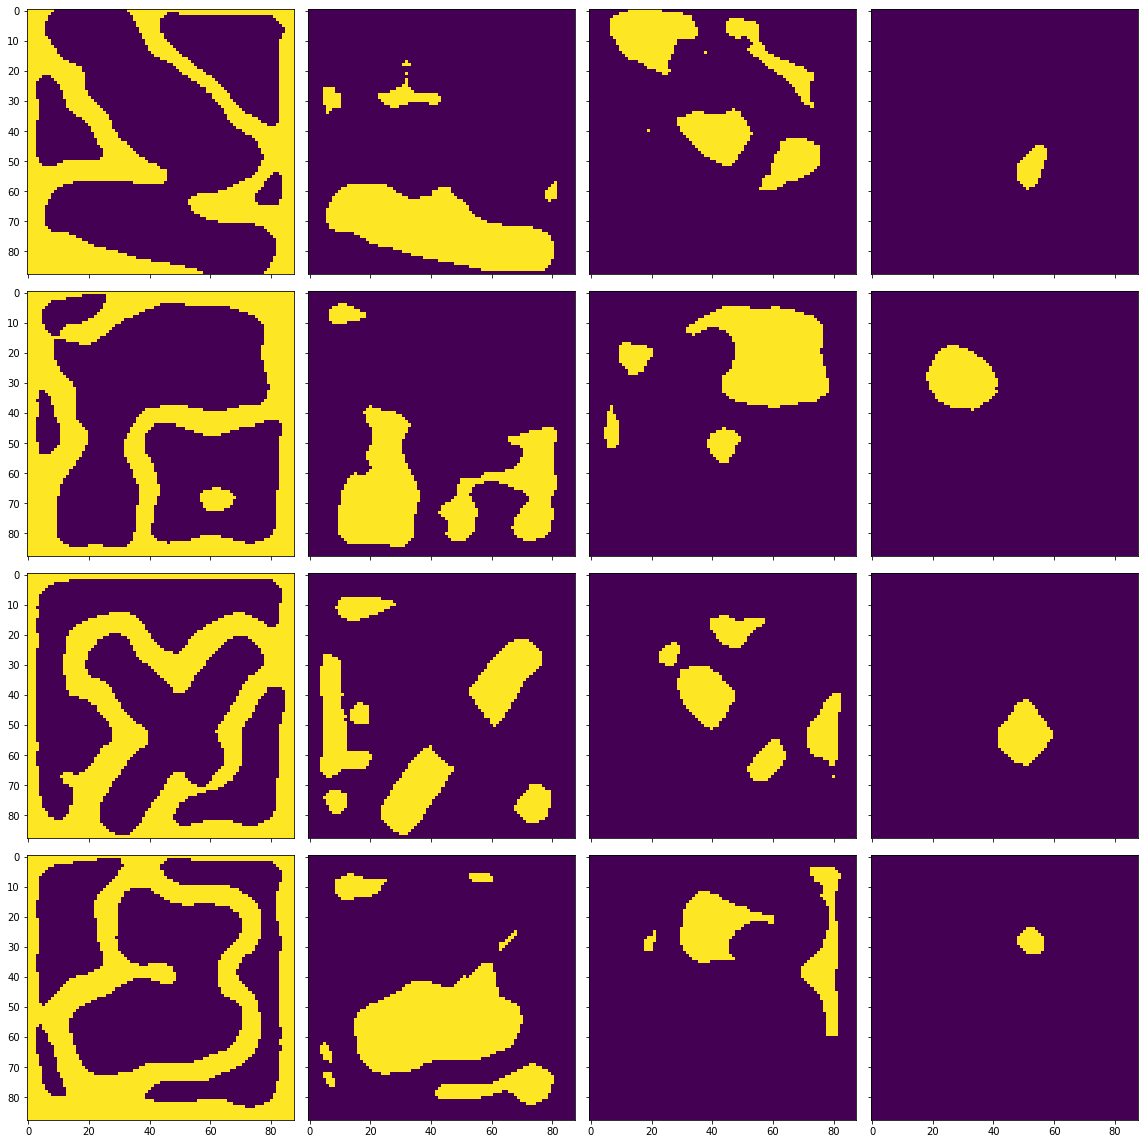

Training IOU: [0.531454341485304, 0.4662130441914264, 0.29203200757107595, 0.5810639328112738]
Training accuracy: 0.5646461776859504
Testing IOU: [0.5195941462051622, 0.3498633130106883, 0.17383909817061205, 0.4667310322632553]
Testing accuracy: 0.5198127582644628
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0825 - val_loss: 0.0721
INFO:tensorflow:Assets written to: modelseg/savedmodel_58epoch\assets
4
4


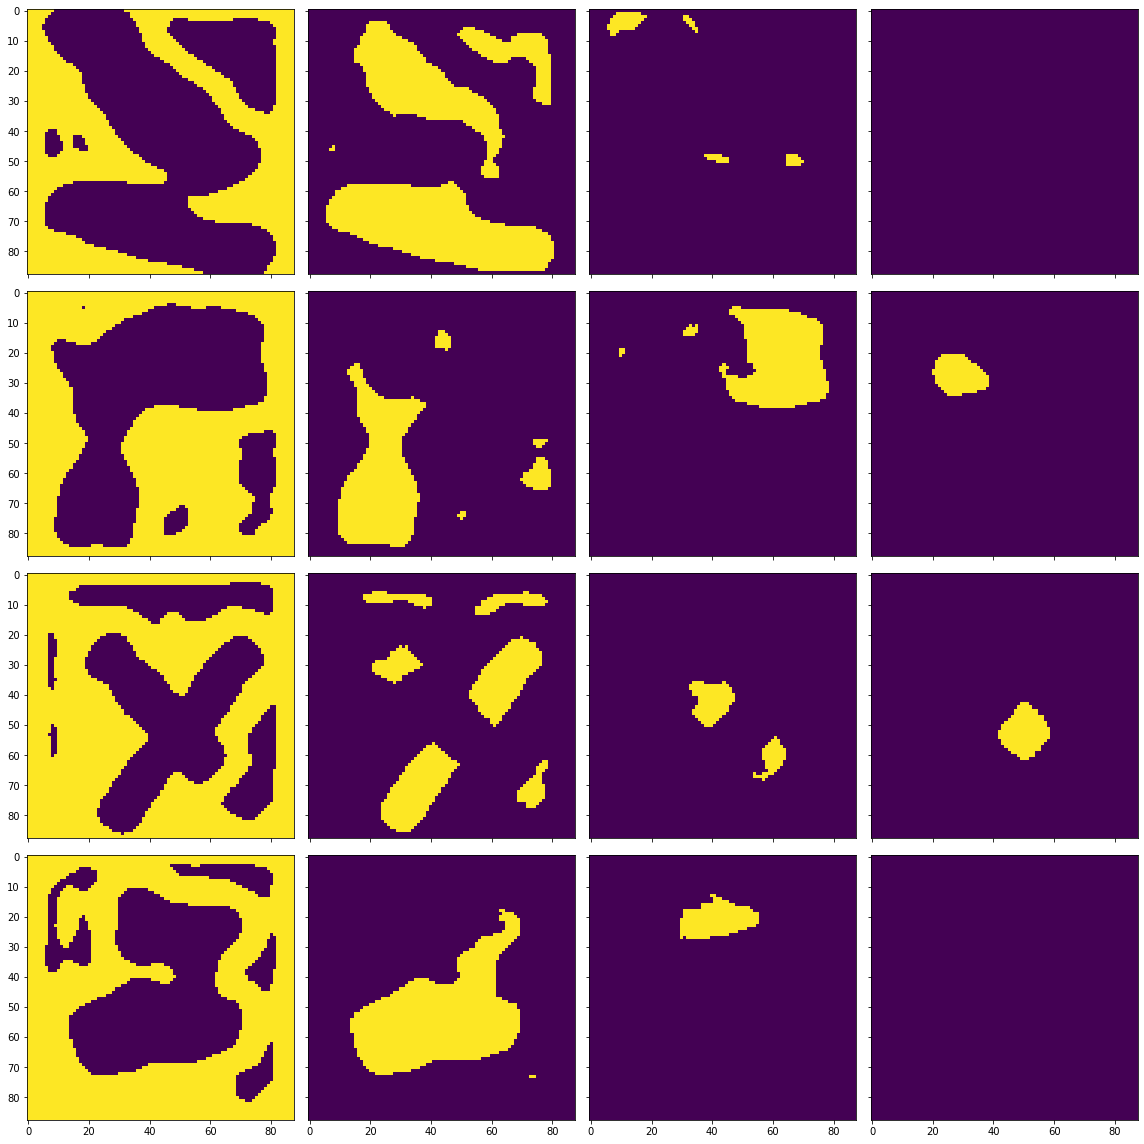

Training IOU: [0.806529485167787, 0.634643165195195, 0.4053856188270372, 0.49856831621537506]
Training accuracy: 0.7618123708677685
Testing IOU: [0.7998847201844477, 0.48237314050104646, 0.25484031110375643, 0.3845119933829611]
Testing accuracy: 0.7302014462809917
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0814 - val_loss: 0.0769
INFO:tensorflow:Assets written to: modelseg/savedmodel_59epoch\assets
4
4


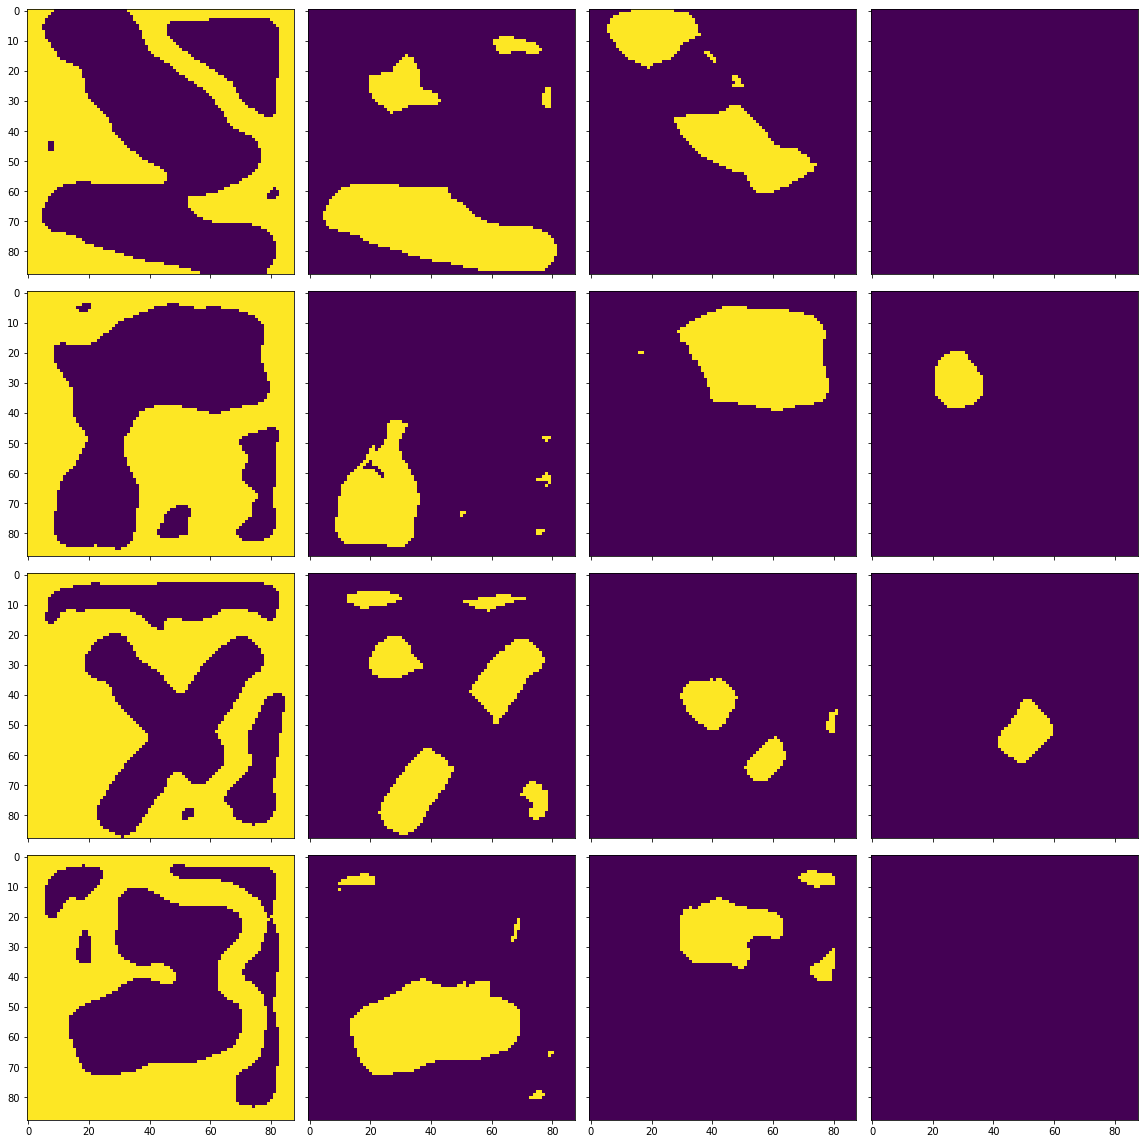

Training IOU: [0.7821493899767745, 0.59896558660601, 0.5318028356037312, 0.5645089878685912]
Training accuracy: 0.7533745480371901
Testing IOU: [0.7762909085820341, 0.43407459897320466, 0.3170162102756663, 0.4237586916070904]
Testing accuracy: 0.7096255165289256
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0817 - val_loss: 0.0685
INFO:tensorflow:Assets written to: modelseg/savedmodel_60epoch\assets
4
4


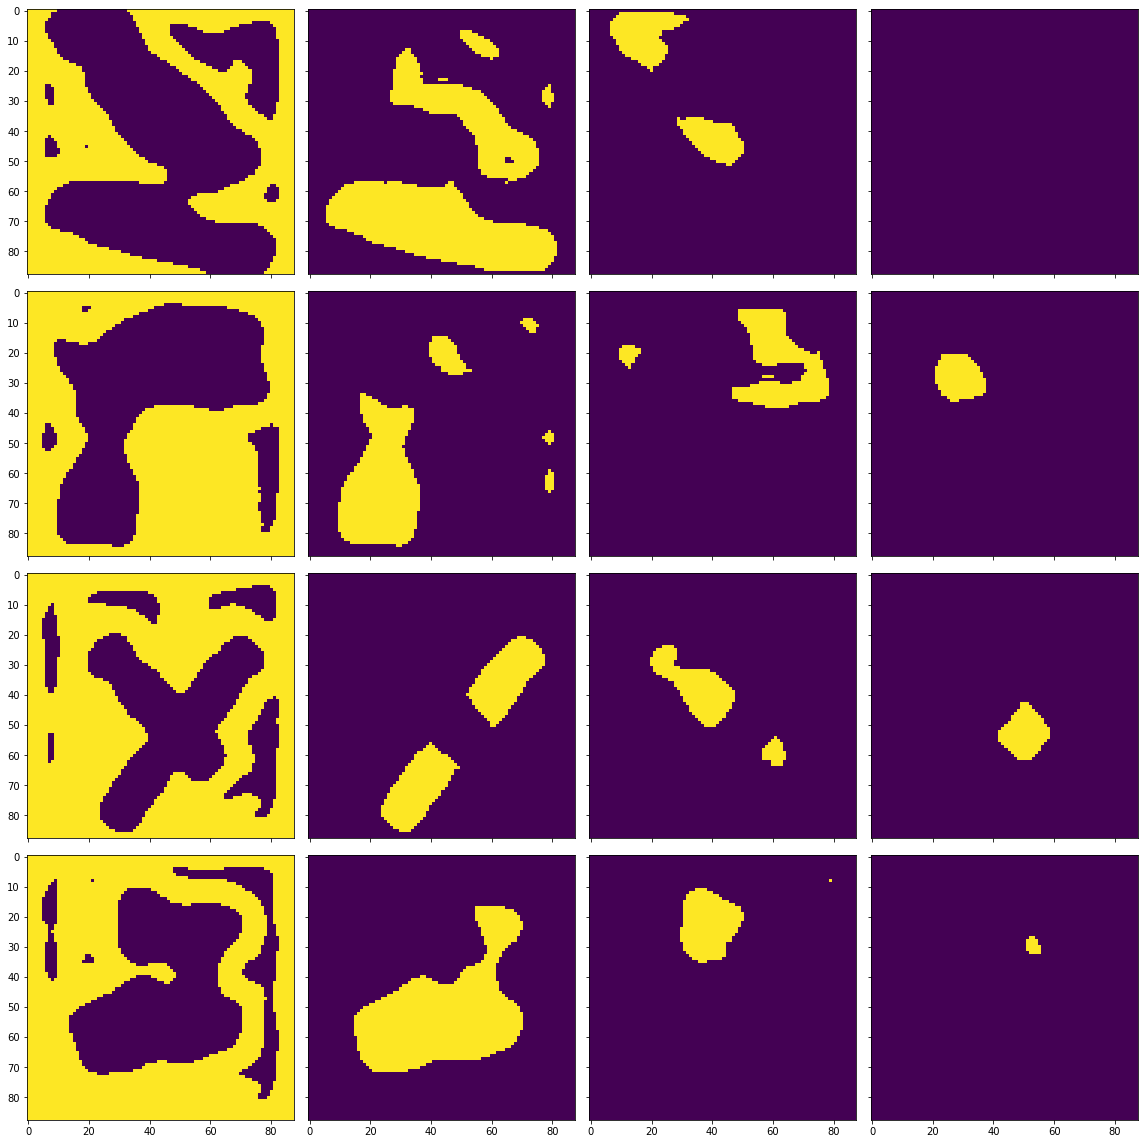

Training IOU: [0.8479749372803916, 0.6552984274481772, 0.3733204199681778, 0.4969402892817406]
Training accuracy: 0.7894366606404959
Testing IOU: [0.8473500503746231, 0.504791546689271, 0.2373013348542848, 0.39591335074512213]
Testing accuracy: 0.7653189566115702
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0812 - val_loss: 0.0542
INFO:tensorflow:Assets written to: modelseg/savedmodel_61epoch\assets
4
4


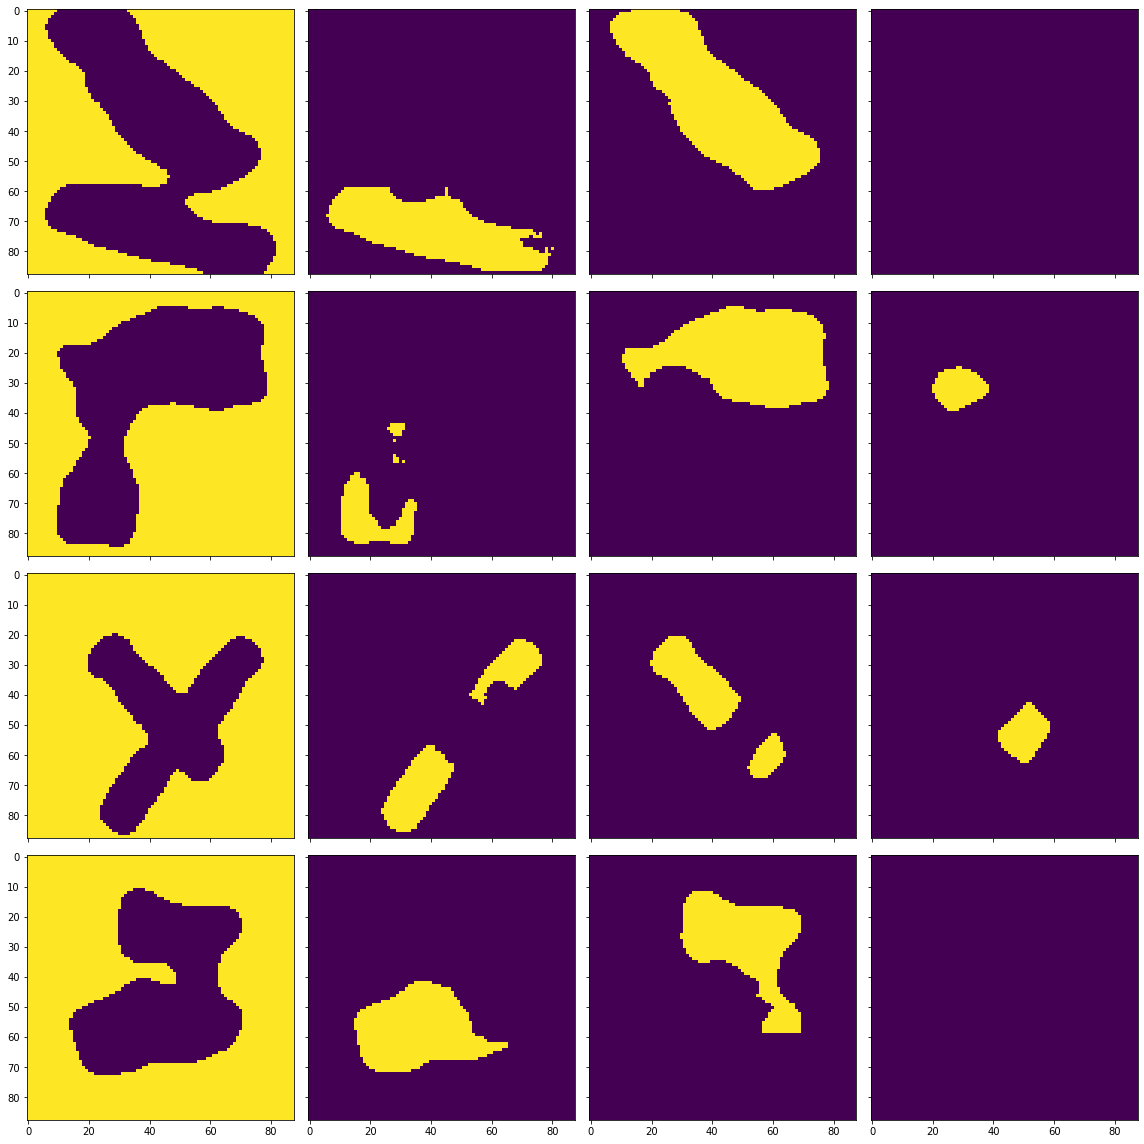

Training IOU: [0.9751509276539883, 0.41348872983852397, 0.6383855544295067, 0.5486084025881812]
Training accuracy: 0.8777631069214876
Testing IOU: [0.9731474075877178, 0.23174702676348186, 0.4180384562180108, 0.4080236278611863]
Testing accuracy: 0.8380668904958678
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0809 - val_loss: 0.0489
INFO:tensorflow:Assets written to: modelseg/savedmodel_62epoch\assets
4
4


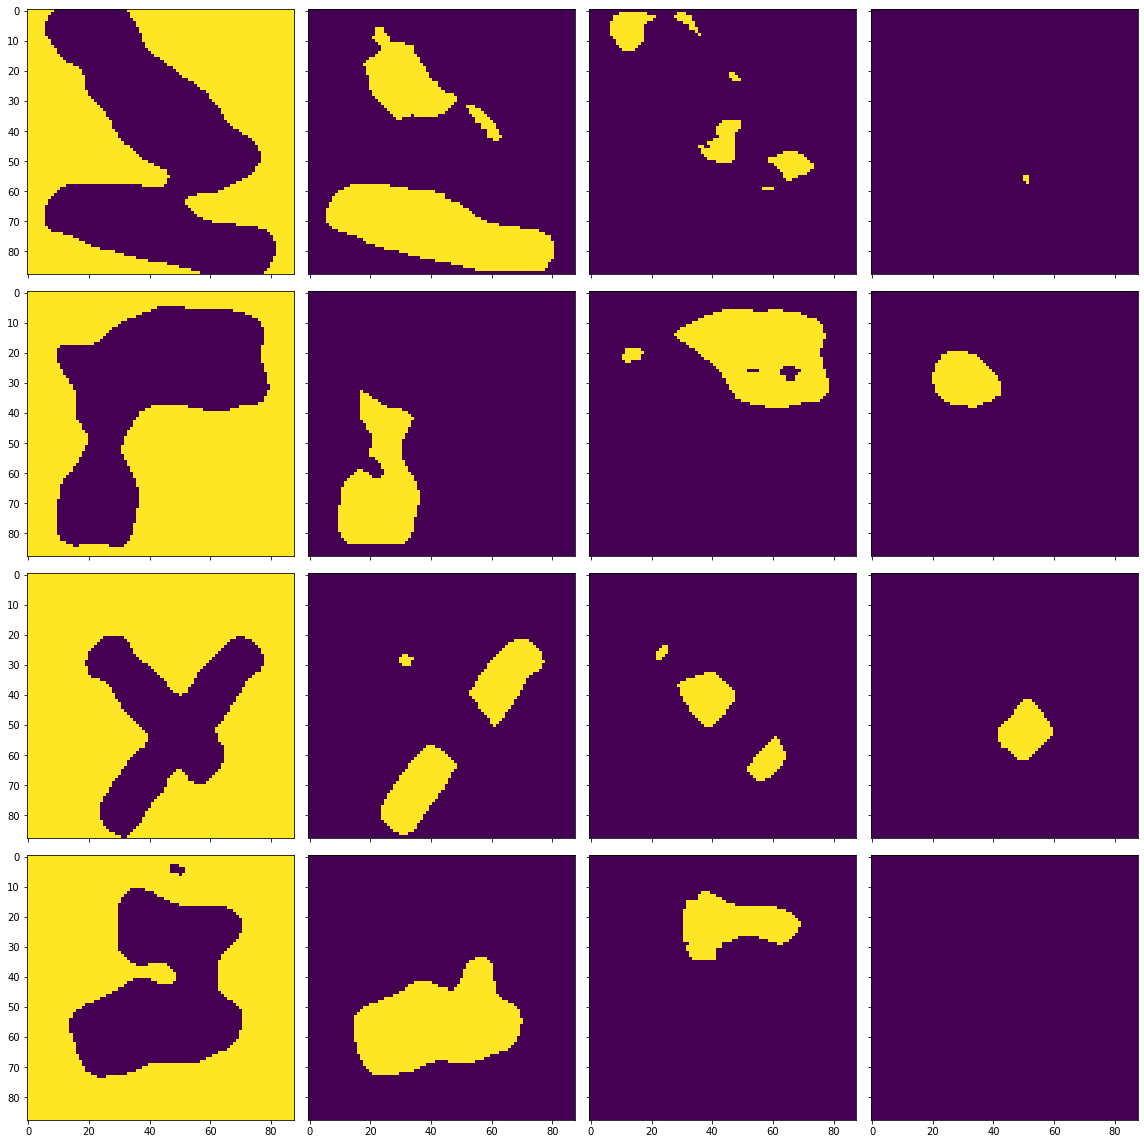

Training IOU: [0.9732301199114674, 0.6981258015858292, 0.4545456981755033, 0.6099044309296264]
Training accuracy: 0.8892142303719008
Testing IOU: [0.9727984218239992, 0.5164839059520687, 0.2660434897905065, 0.4781420765027322]
Testing accuracy: 0.8598075929752066
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0804 - val_loss: 0.0480
INFO:tensorflow:Assets written to: modelseg/savedmodel_63epoch\assets
4
4


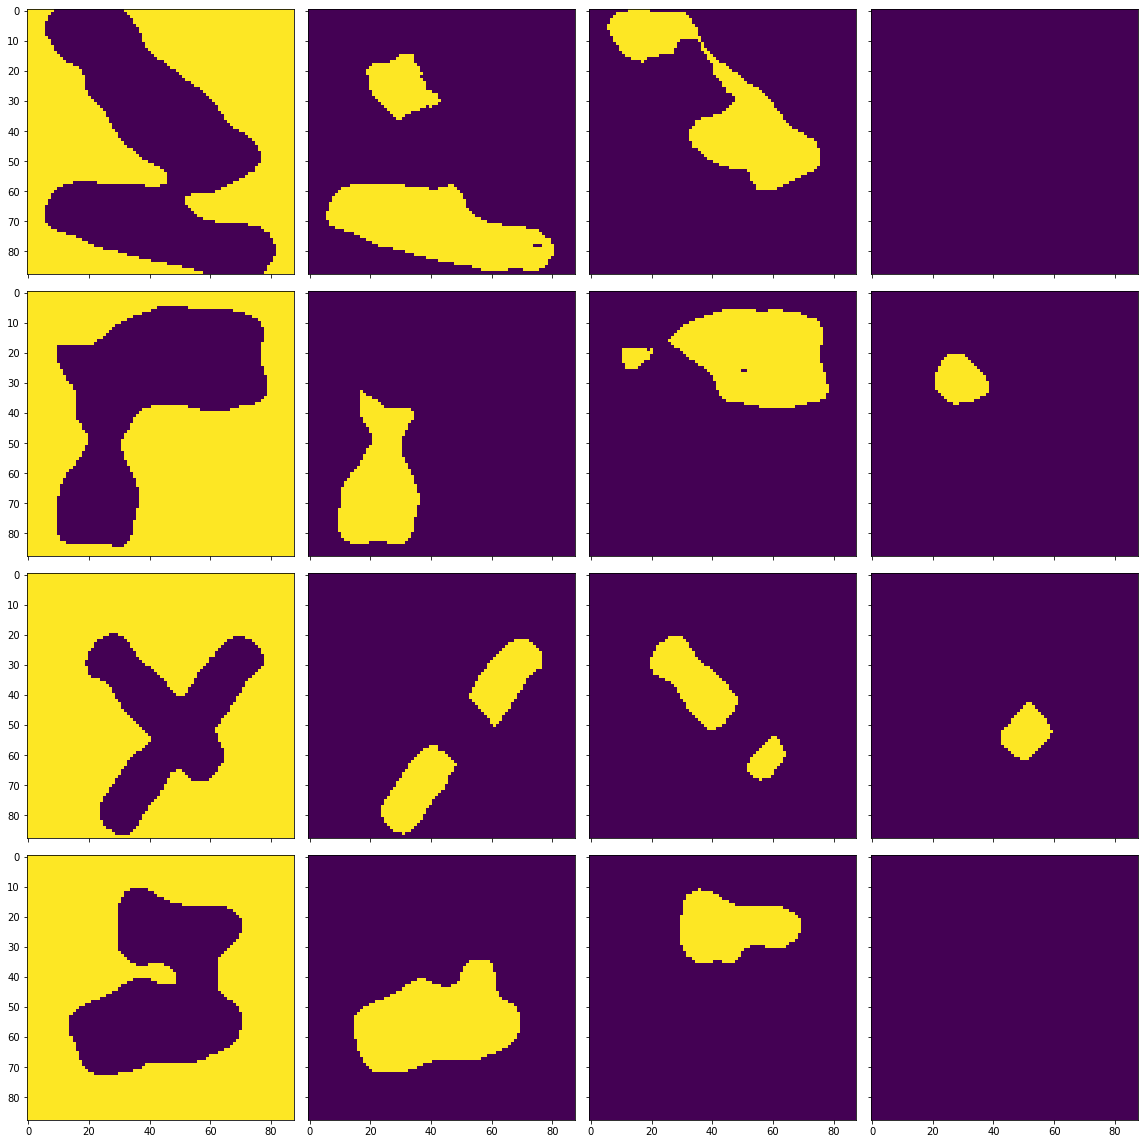

Training IOU: [0.974900953673352, 0.7052684842313475, 0.595400741697745, 0.5618937456877309]
Training accuracy: 0.9034636492768595
Testing IOU: [0.9736006407019865, 0.4990306603946127, 0.3482677231728905, 0.4389542094557722]
Testing accuracy: 0.8643078512396695
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0802 - val_loss: 0.0529
INFO:tensorflow:Assets written to: modelseg/savedmodel_64epoch\assets
4
4


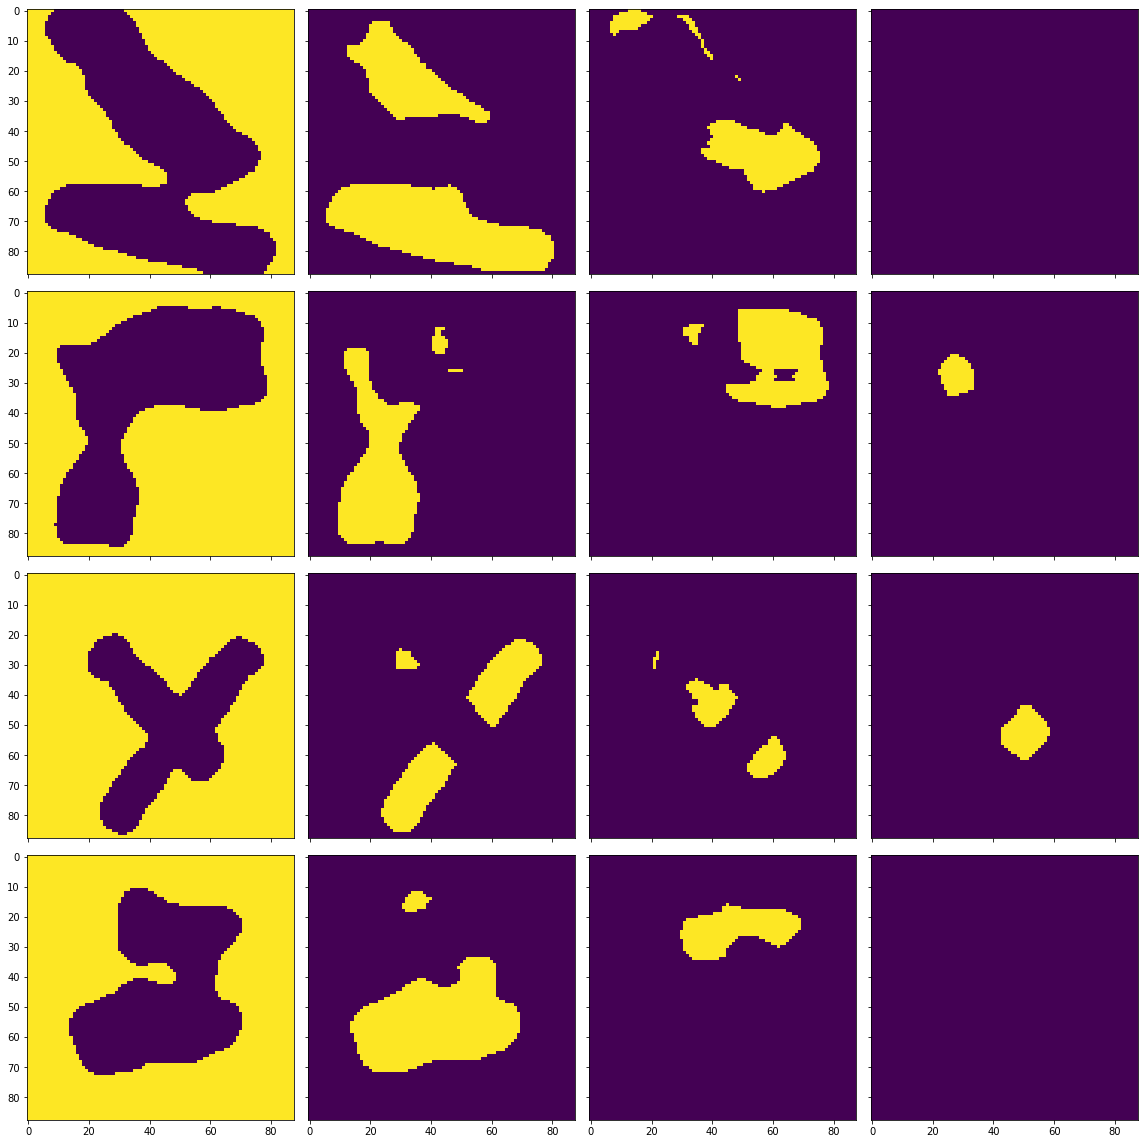

Training IOU: [0.9746766253273109, 0.6510834114703353, 0.3692514257463725, 0.4392987520163002]
Training accuracy: 0.8799786931818182
Testing IOU: [0.9732936084605626, 0.525603684980369, 0.21126220598516113, 0.349054576708208]
Testing accuracy: 0.8605836776859505
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0810 - val_loss: 0.0489
INFO:tensorflow:Assets written to: modelseg/savedmodel_65epoch\assets
4
4


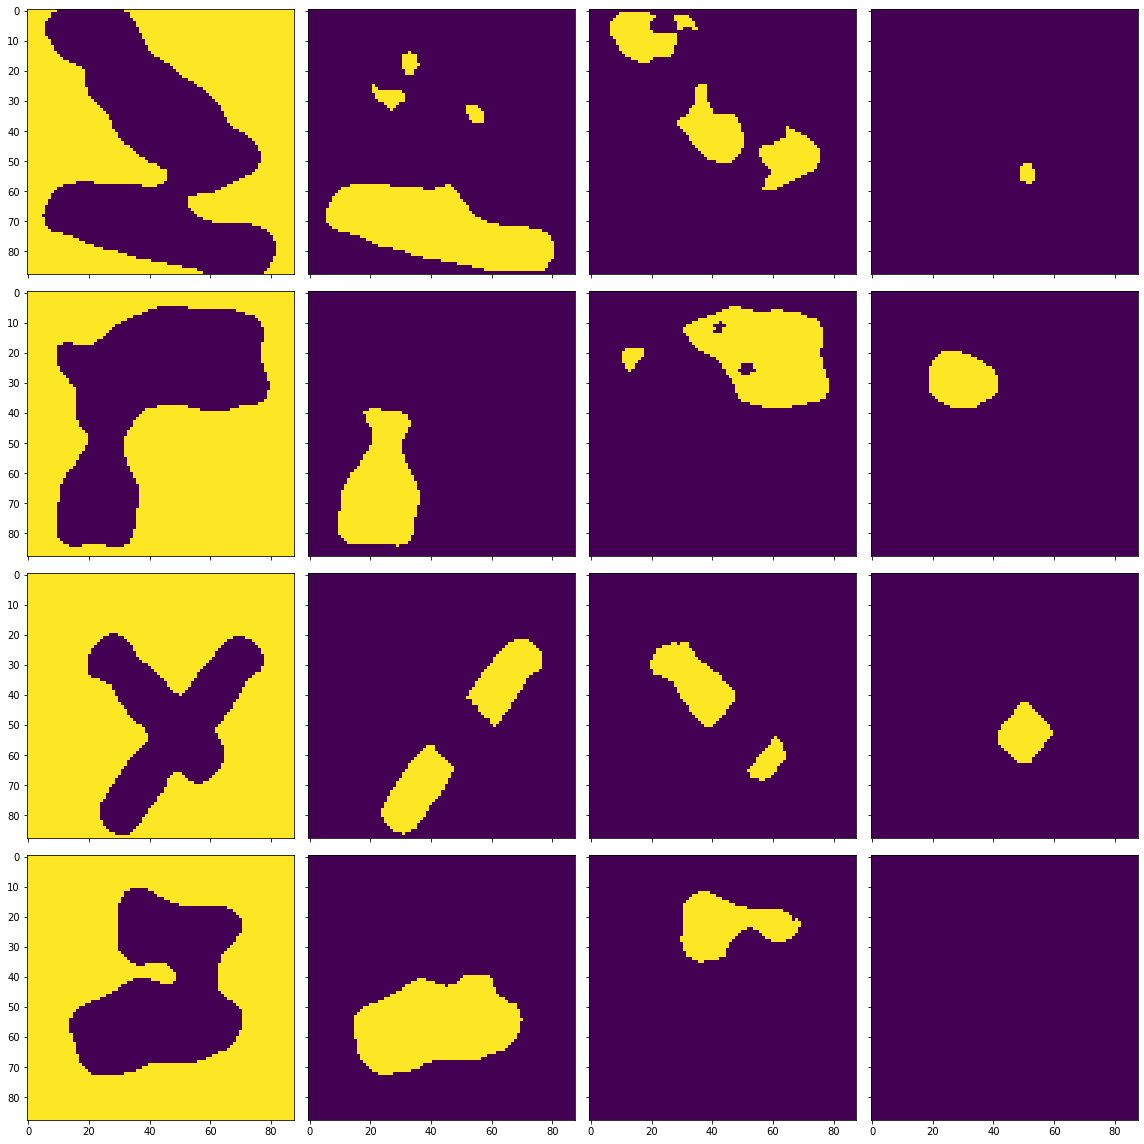

Training IOU: [0.9732758609096822, 0.6937900628163558, 0.5178100281485323, 0.5790285052232447]
Training accuracy: 0.8876517303719008
Testing IOU: [0.9724968294423133, 0.4665033101829642, 0.3110977197645514, 0.42534333300866856]
Testing accuracy: 0.8501136363636363
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0805 - val_loss: 0.0533
INFO:tensorflow:Assets written to: modelseg/savedmodel_66epoch\assets
4
4


Training IOU: [0.9550163912617091, 0.6763403111696425, 0.43277339089166256, 0.6213258051809195]
Training accuracy: 0.8735349948347108
Testing IOU: [0.9578009320812282, 0.5002192681924078, 0.27360633965908965, 0.488758152049984]
Testing accuracy: 0.8472998450413223
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0810 - val_loss: 0.0493
INFO:tensorflow:Assets written to: modelseg/savedmodel_67epoch\assets
4
4


Training IOU: [0.9705609704477348, 0.7141033227079635, 0.6378747302462234, 0.6331148549745005]
Training accuracy: 0.9071151859504132
Testing IOU: [0.9707616552949364, 0.4878690784312288, 0.35707805380279106, 0.4955155950203025]
Testing accuracy: 0.8623941115702479
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0806 - val_loss: 0.0489
INFO:tensorflow:Assets written to: modelseg/savedmodel_68epoch\assets
4
4


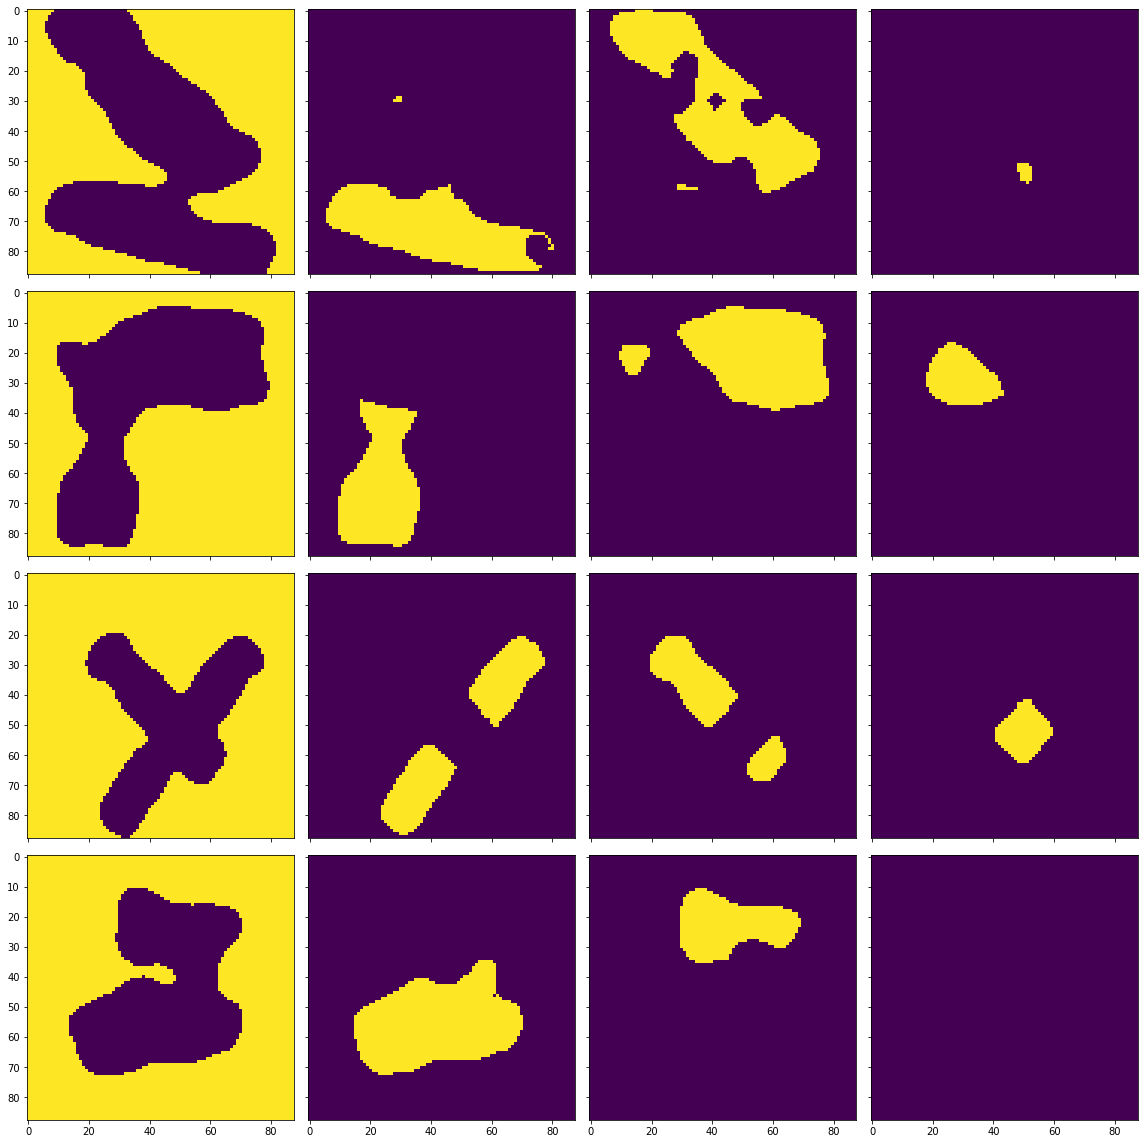

Training IOU: [0.9708227519361037, 0.7358071977625723, 0.6945903620080792, 0.630595960056541]
Training accuracy: 0.9143714488636364
Testing IOU: [0.9709658754201985, 0.460614533537777, 0.3725851150040519, 0.486744951516769]
Testing accuracy: 0.8586105371900826
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0793 - val_loss: 0.0495
INFO:tensorflow:Assets written to: modelseg/savedmodel_69epoch\assets
4
4


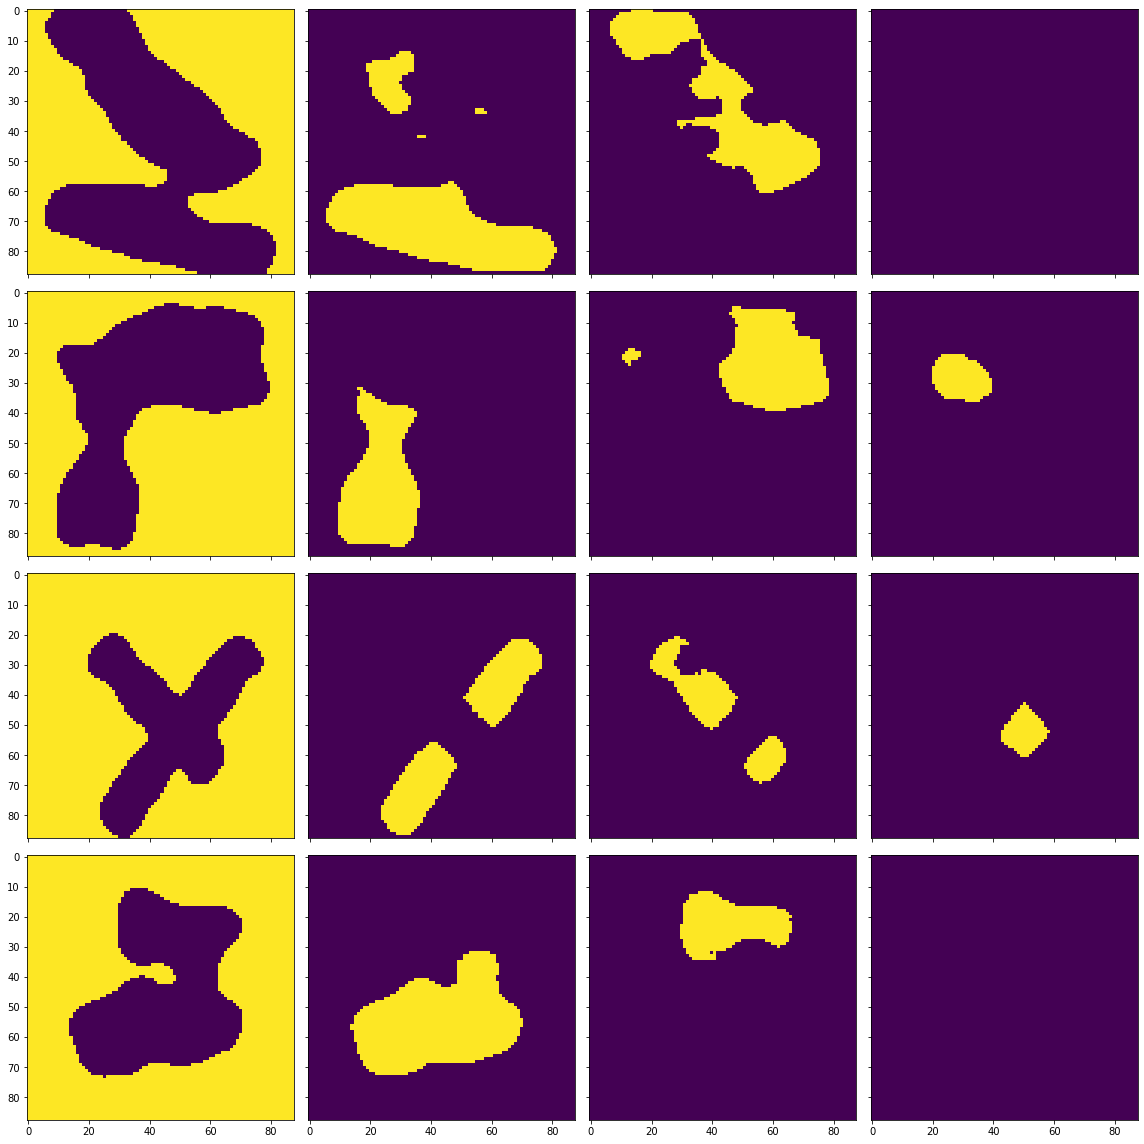

Training IOU: [0.9728859314582696, 0.7469286492418038, 0.5774905632694437, 0.4506541479044912]
Training accuracy: 0.9047759555785124
Testing IOU: [0.9718070551338401, 0.5240694188656925, 0.30079591530259797, 0.3353049706967658]
Testing accuracy: 0.863516270661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0796 - val_loss: 0.0662
INFO:tensorflow:Assets written to: modelseg/savedmodel_70epoch\assets
4
4


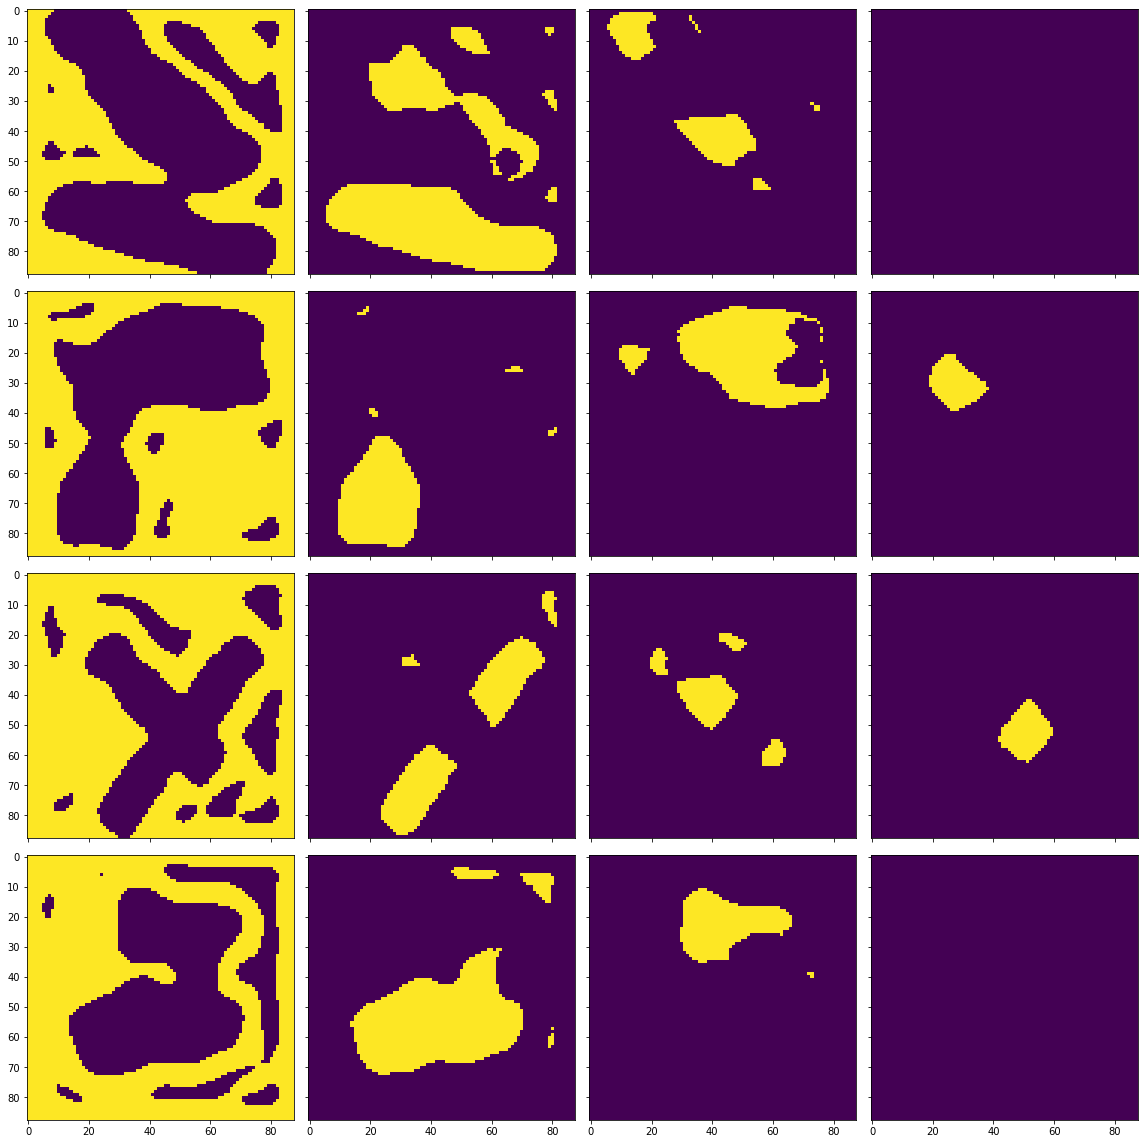

Training IOU: [0.8615263579060688, 0.674363834153891, 0.4446847059012436, 0.5510028363047001]
Training accuracy: 0.8066896952479339
Testing IOU: [0.8674465164668957, 0.4893357148485724, 0.2451021535063501, 0.37878939971893194]
Testing accuracy: 0.7752530991735537
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0790 - val_loss: 0.0647
INFO:tensorflow:Assets written to: modelseg/savedmodel_71epoch\assets
4
4


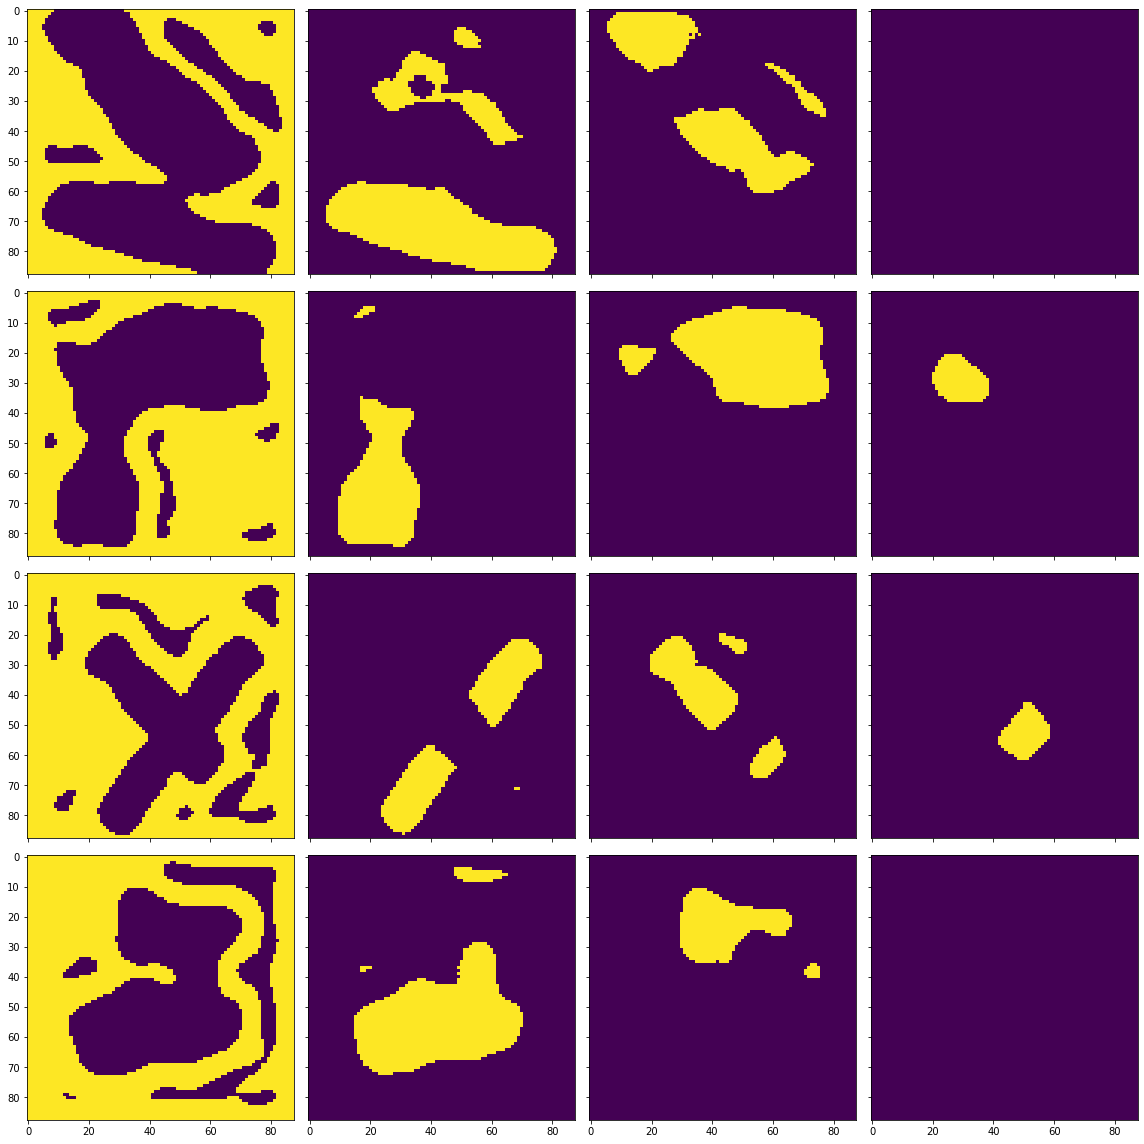

Training IOU: [0.8686955221588682, 0.69419086728313, 0.5765964205187488, 0.553849152611925]
Training accuracy: 0.8272985537190083
Testing IOU: [0.874044981314567, 0.49522444432367807, 0.3171052631578947, 0.4154081632653061]
Testing accuracy: 0.7905074896694215
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0788 - val_loss: 0.0536
INFO:tensorflow:Assets written to: modelseg/savedmodel_72epoch\assets
4
4


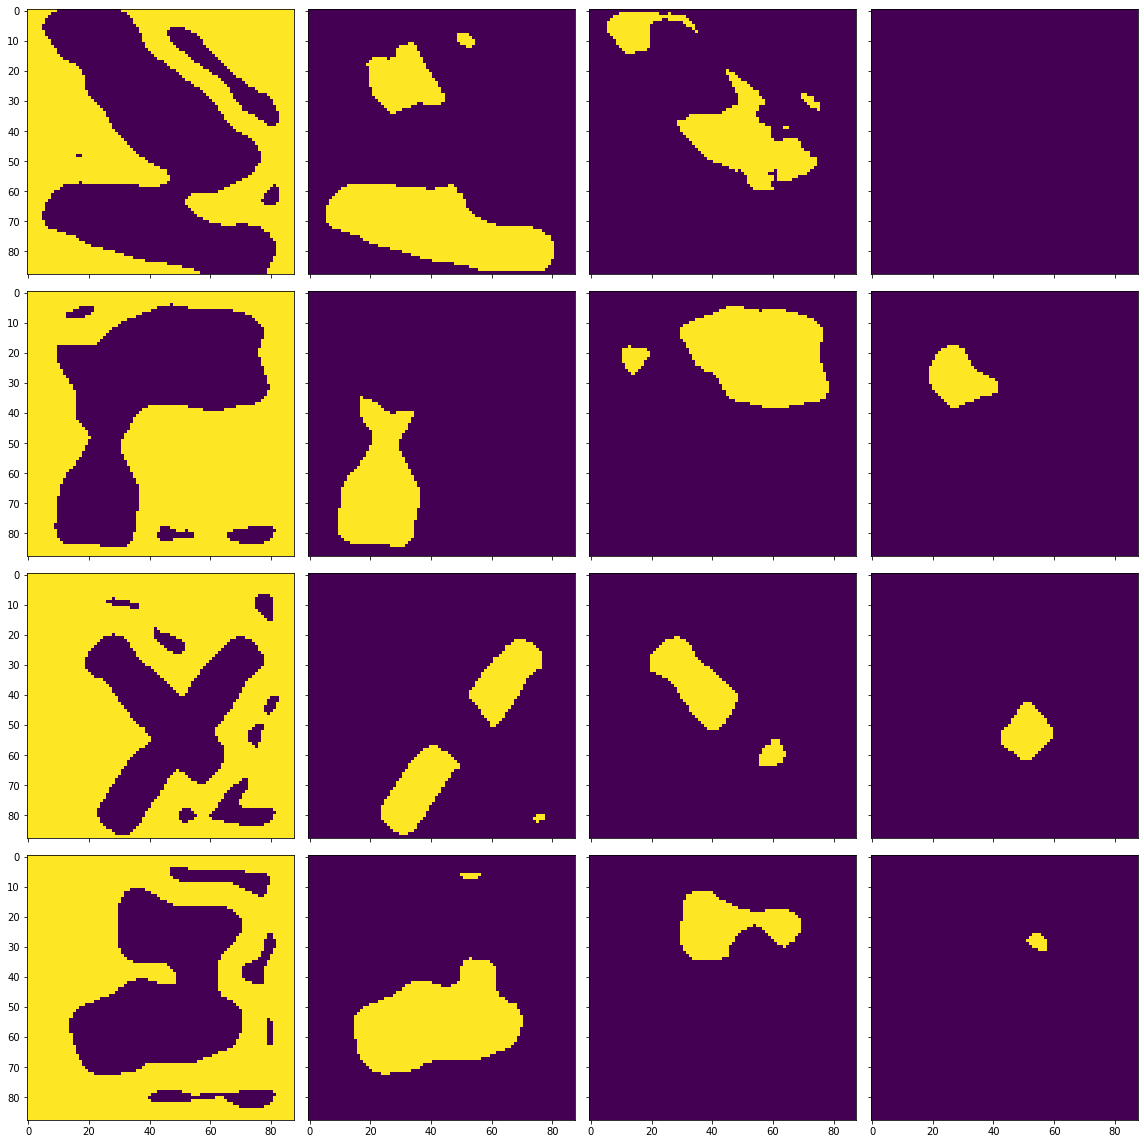

Training IOU: [0.9354792949400956, 0.713813898556632, 0.5722557918693666, 0.6164677341096555]
Training accuracy: 0.8752631069214876
Testing IOU: [0.9387048085276027, 0.486969206540435, 0.30818922365190266, 0.4531638699172283]
Testing accuracy: 0.8336402376033057
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0783 - val_loss: 0.0506
INFO:tensorflow:Assets written to: modelseg/savedmodel_73epoch\assets
4
4


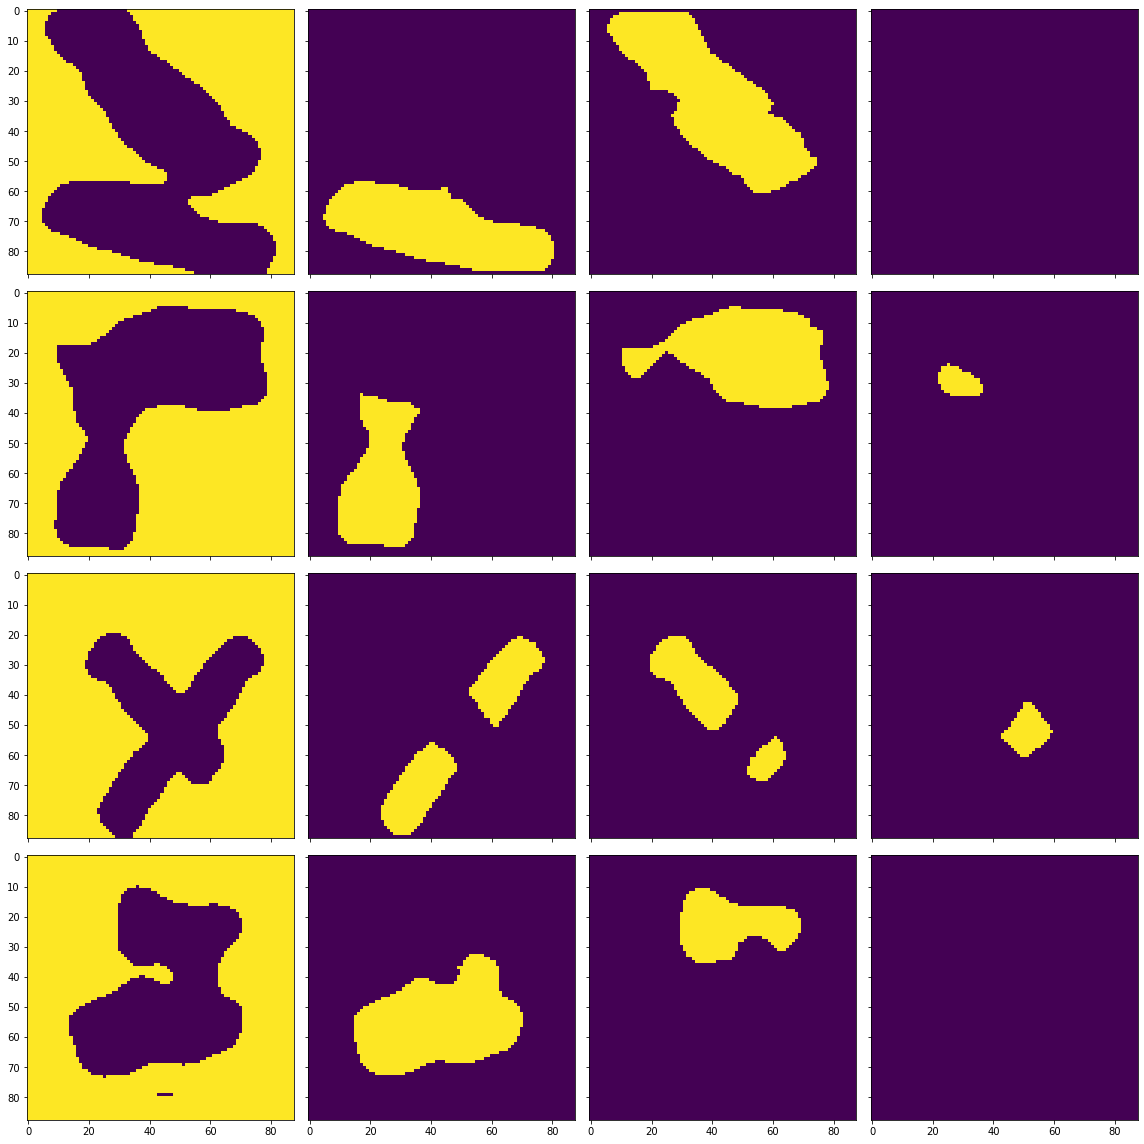

Training IOU: [0.9682800420302139, 0.773816626783845, 0.7230319098867309, 0.44263665594855306]
Training accuracy: 0.9157893207644628
Testing IOU: [0.9688060782235468, 0.49830863922664237, 0.38481175481126006, 0.32741777922500814]
Testing accuracy: 0.8628848140495867
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0783 - val_loss: 0.1109
INFO:tensorflow:Assets written to: modelseg/savedmodel_74epoch\assets
4
4


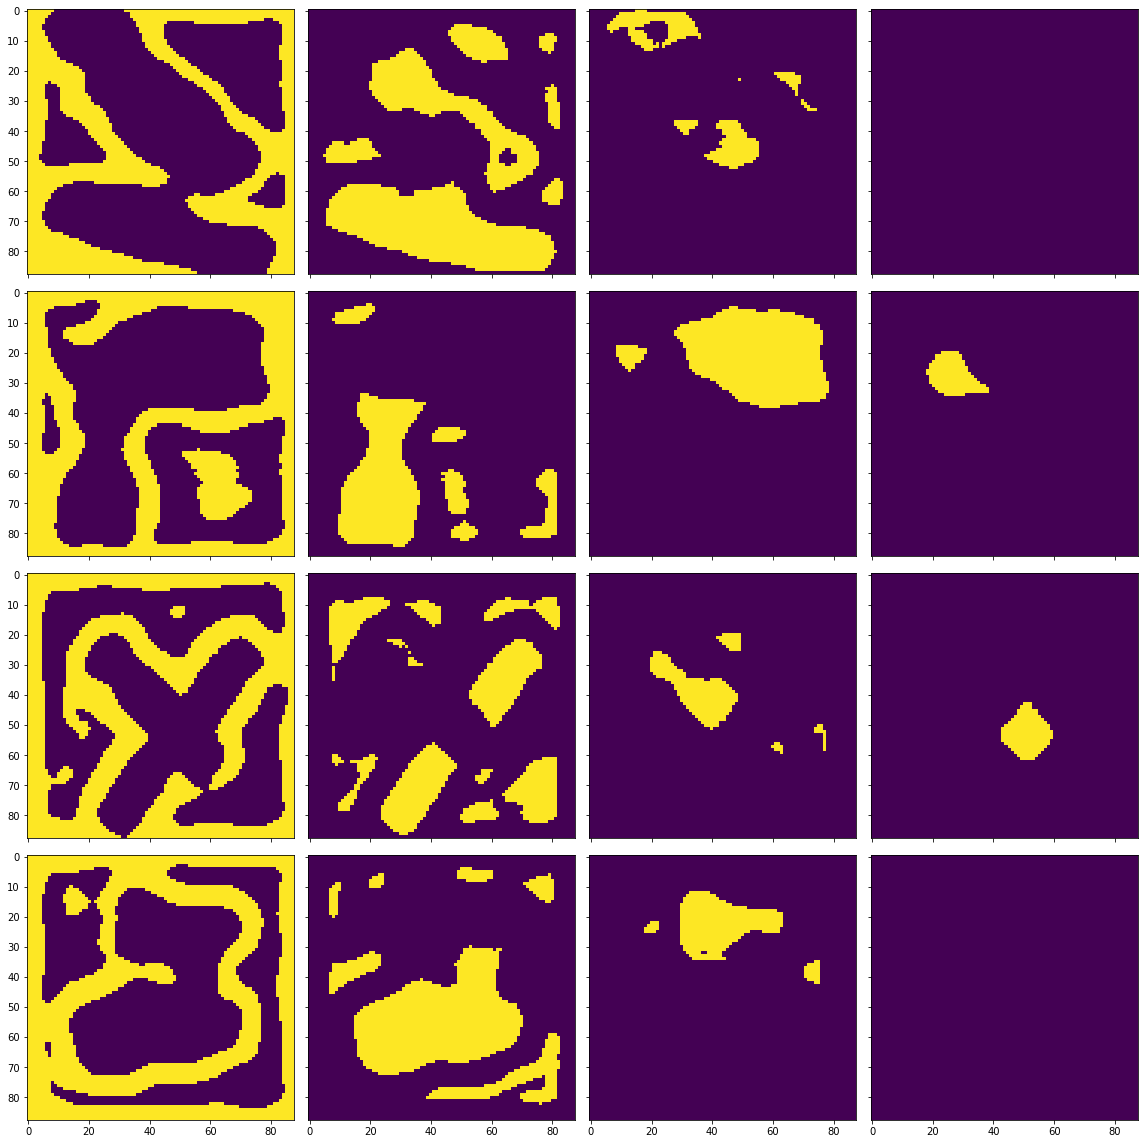

Training IOU: [0.5825861260602417, 0.527641601081279, 0.44291990519855523, 0.5645561762880199]
Training accuracy: 0.6130626936983471
Testing IOU: [0.5729340376304186, 0.3868679754382136, 0.2321364147619957, 0.4138849068195781]
Testing accuracy: 0.563099173553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0776 - val_loss: 0.0662
INFO:tensorflow:Assets written to: modelseg/savedmodel_75epoch\assets
4
4


Training IOU: [0.8443925743583872, 0.720577674292523, 0.682595403752899, 0.5049859184312089]
Training accuracy: 0.8237406379132232
Testing IOU: [0.8476628605716969, 0.49128091204590213, 0.3365447755068538, 0.37444248521937556]
Testing accuracy: 0.7741257747933884
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0768 - val_loss: 0.0637
INFO:tensorflow:Assets written to: modelseg/savedmodel_76epoch\assets
4
4


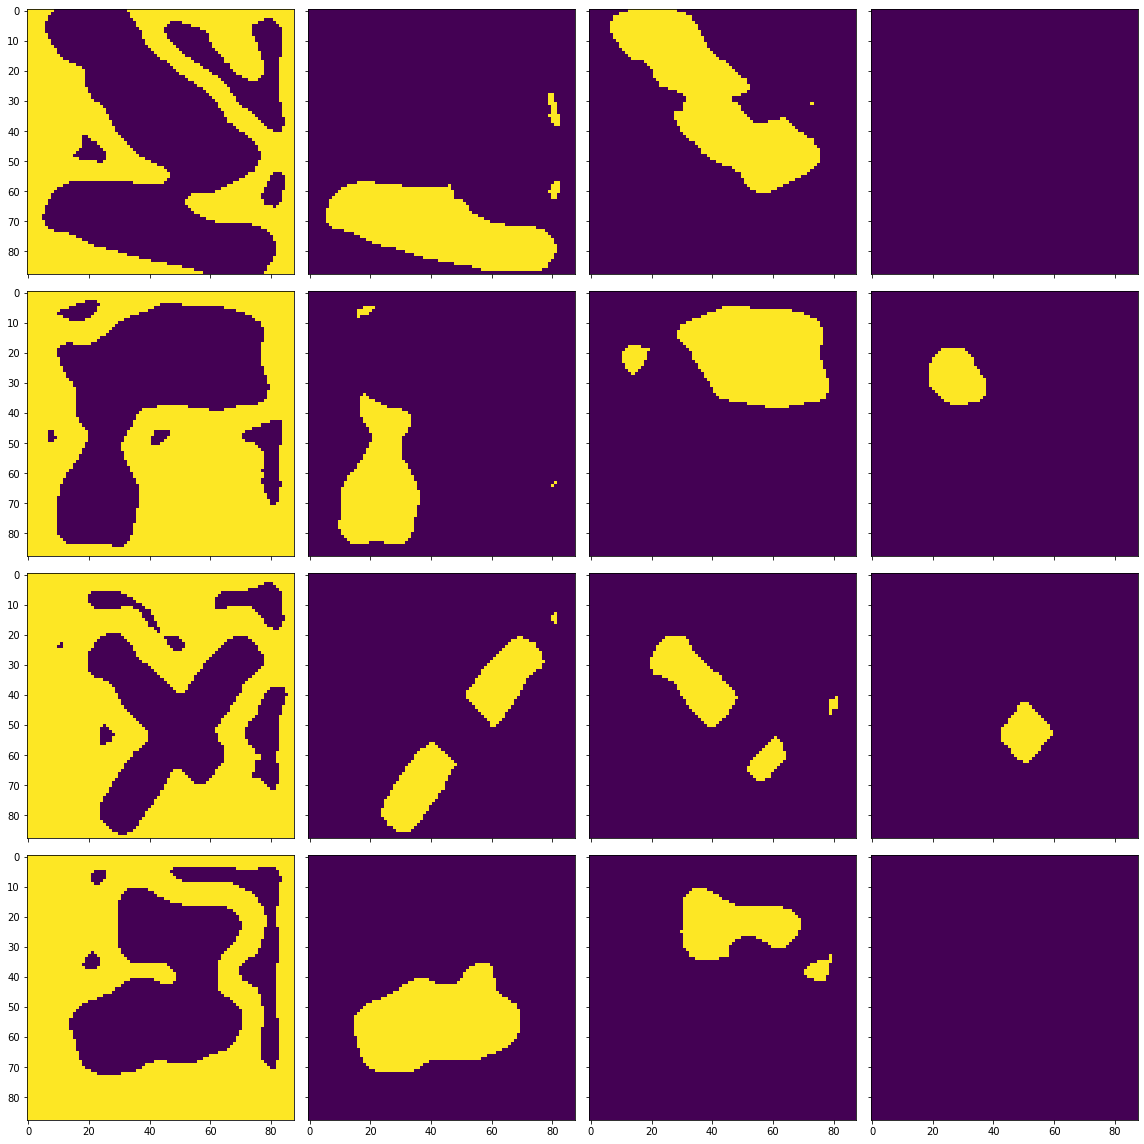

Training IOU: [0.8614628551166889, 0.7470895336706143, 0.693841857538054, 0.6452656659051467]
Training accuracy: 0.8383603434917355
Testing IOU: [0.8611665990362226, 0.4471903108023867, 0.36340188078965063, 0.46688294133549607]
Testing accuracy: 0.776485020661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0775 - val_loss: 0.0558
INFO:tensorflow:Assets written to: modelseg/savedmodel_77epoch\assets
4
4


Training IOU: [0.9427411951531579, 0.7533021500791939, 0.6077834640098881, 0.613560474276688]
Training accuracy: 0.8900206611570248
Testing IOU: [0.9445673644022251, 0.49963512201653665, 0.2752447084413955, 0.4212001967535662]
Testing accuracy: 0.8404377582644628
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0771 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_78epoch\assets
4
4


Training IOU: [0.9717041970681068, 0.6275137515697129, 0.6870673026601074, 0.5826819785153119]
Training accuracy: 0.8993817794421488
Testing IOU: [0.9718704405168852, 0.41157354349498404, 0.3910247538911493, 0.399592252803262]
Testing accuracy: 0.8530165289256199
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0778 - val_loss: 0.0523
INFO:tensorflow:Assets written to: modelseg/savedmodel_79epoch\assets
4
4


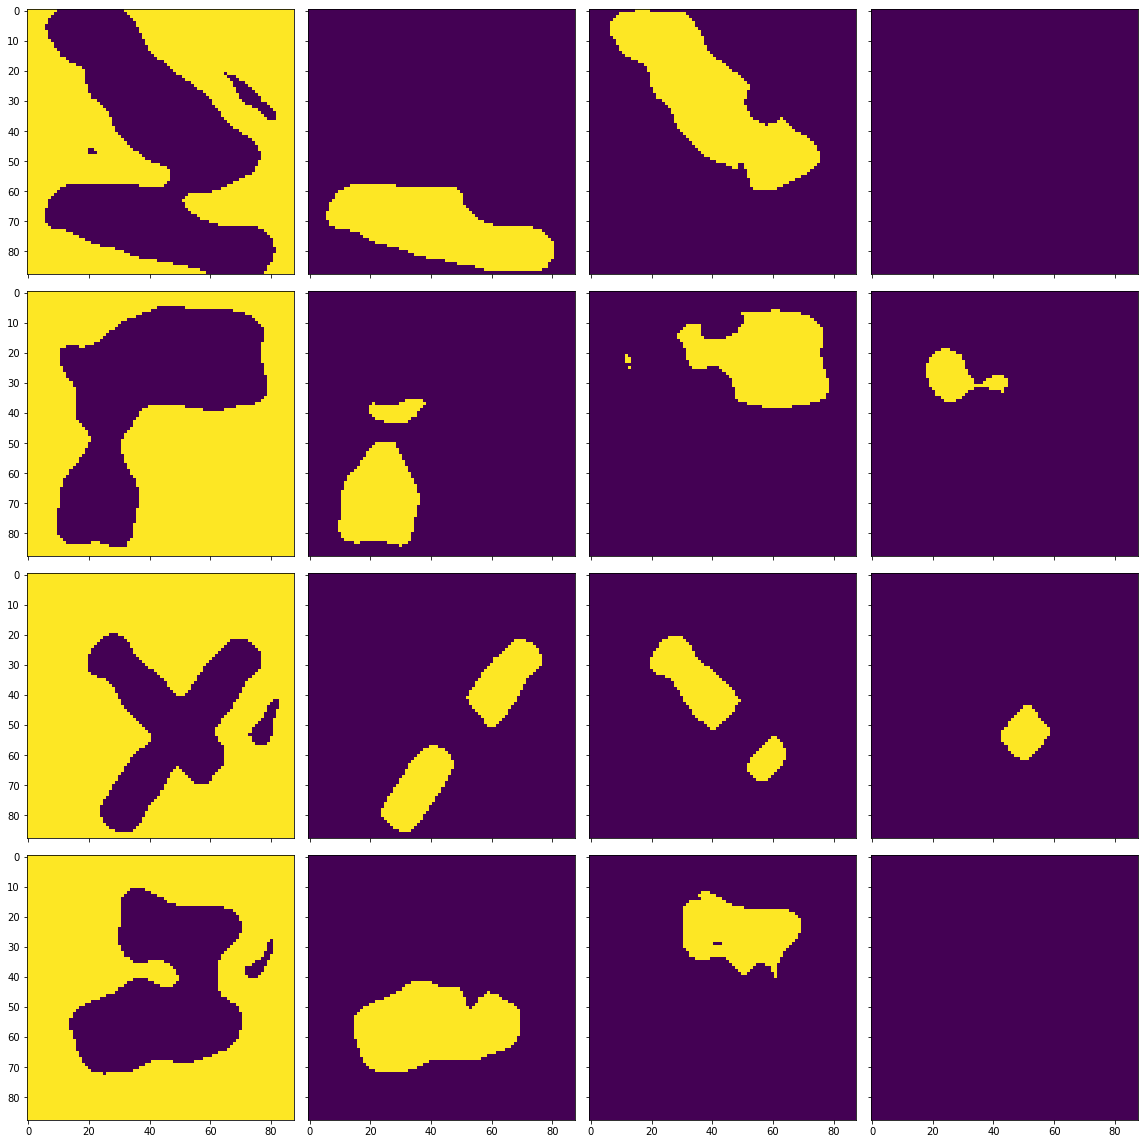

Training IOU: [0.9617514205317274, 0.7579064234734337, 0.6305051301230854, 0.5844515767486882]
Training accuracy: 0.9072627195247934
Testing IOU: [0.9610904245641819, 0.48567946808434825, 0.3145841080947068, 0.4410556334283919]
Testing accuracy: 0.8553809400826446
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0772 - val_loss: 0.0511
INFO:tensorflow:Assets written to: modelseg/savedmodel_80epoch\assets
4
4


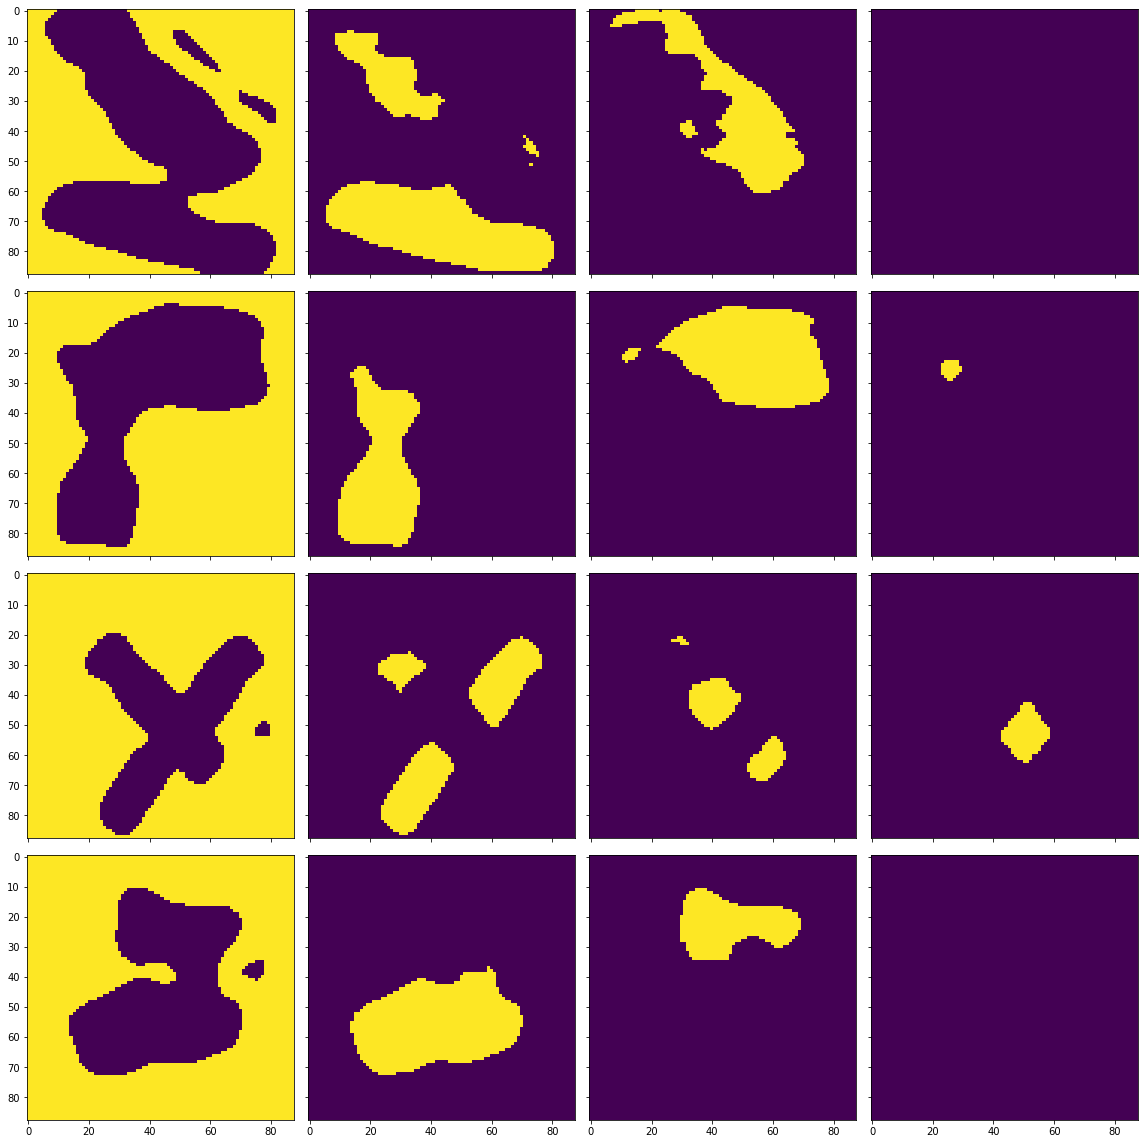

Training IOU: [0.9606471670055101, 0.7402454618243526, 0.6216782218273548, 0.525143731209452]
Training accuracy: 0.9026623837809917
Testing IOU: [0.9622724254813573, 0.5169146377600595, 0.3460686373053806, 0.375131274942239]
Testing accuracy: 0.8608496900826447
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0773 - val_loss: 0.0503
INFO:tensorflow:Assets written to: modelseg/savedmodel_81epoch\assets
4
4


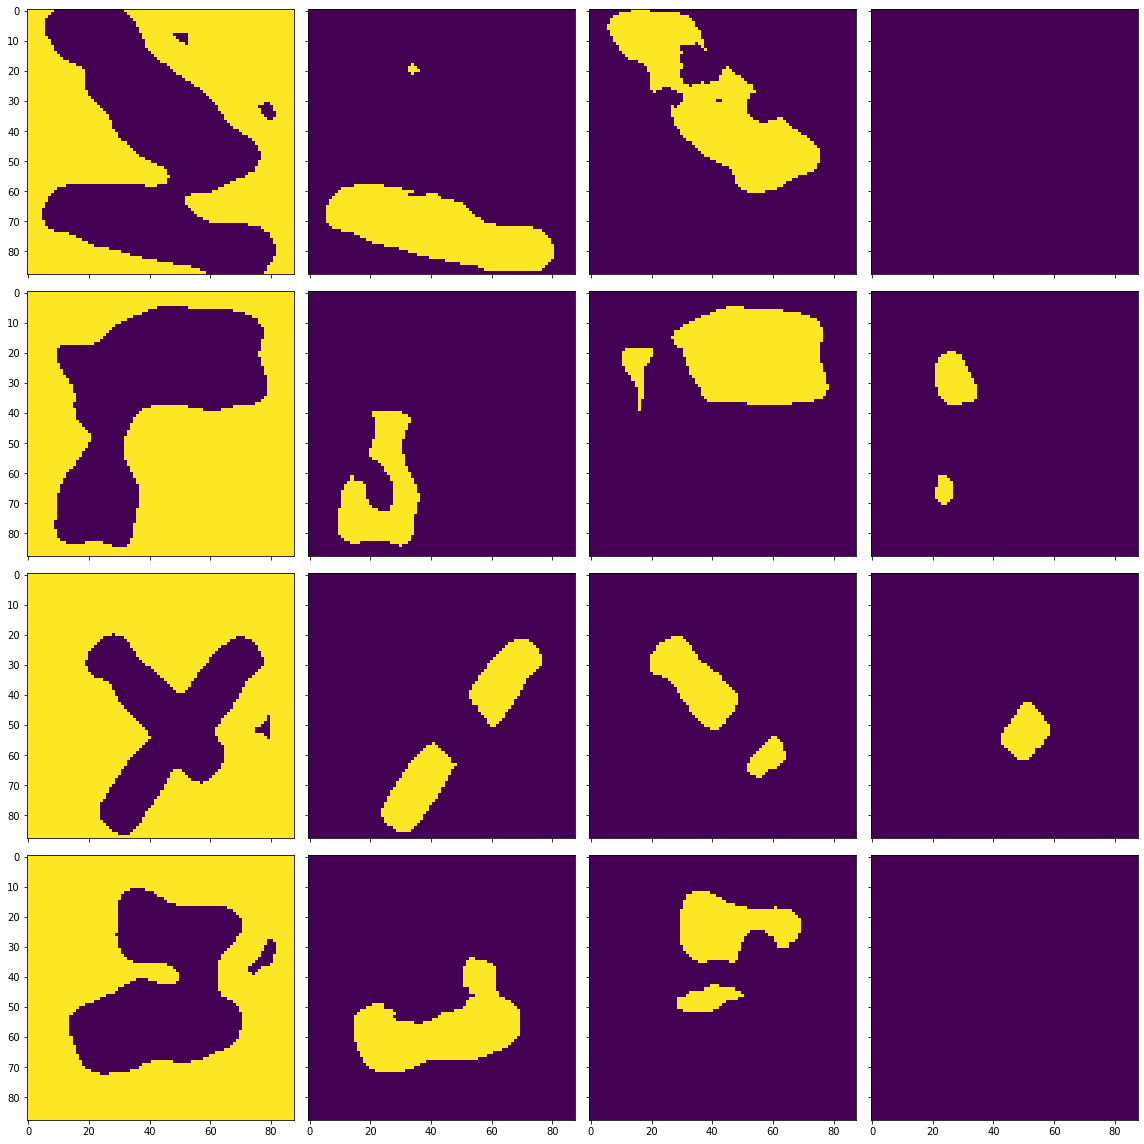

Training IOU: [0.9701582525044794, 0.740735744994262, 0.632026840570309, 0.5760126249342451]
Training accuracy: 0.9067100335743802
Testing IOU: [0.9695611100382574, 0.5005728197049979, 0.30065539403051444, 0.4018400281534362]
Testing accuracy: 0.8569137396694215
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0769 - val_loss: 0.0551
INFO:tensorflow:Assets written to: modelseg/savedmodel_82epoch\assets
4
4


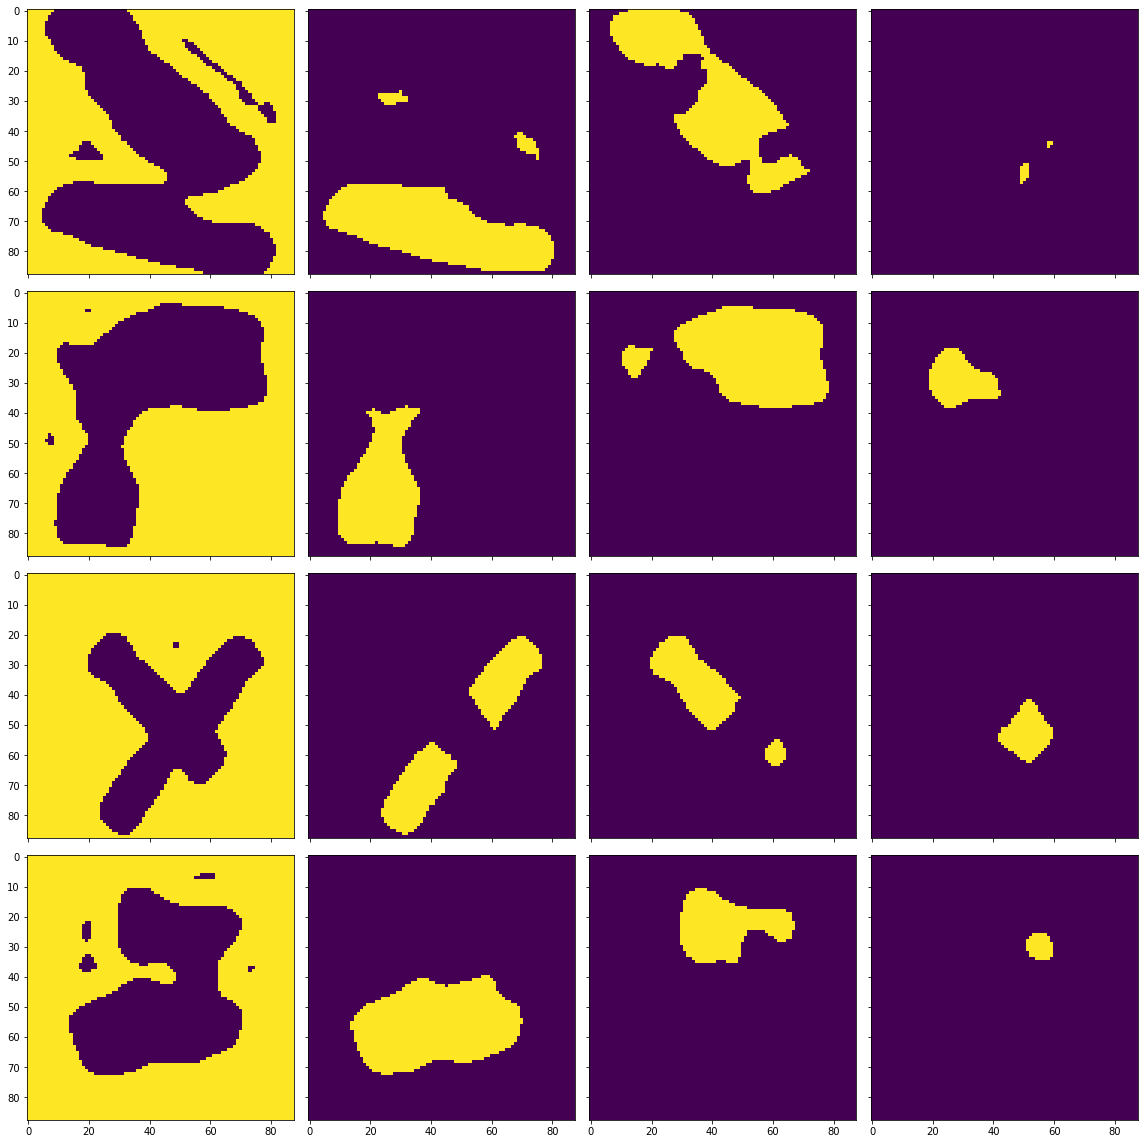

Training IOU: [0.9569617619255185, 0.7261268151920959, 0.6933516838615652, 0.6720537090817826]
Training accuracy: 0.9065379648760331
Testing IOU: [0.9550427943759452, 0.4460020729715824, 0.3639484639820058, 0.46343951043464615]
Testing accuracy: 0.8471926652892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0767 - val_loss: 0.0509
INFO:tensorflow:Assets written to: modelseg/savedmodel_83epoch\assets
4
4


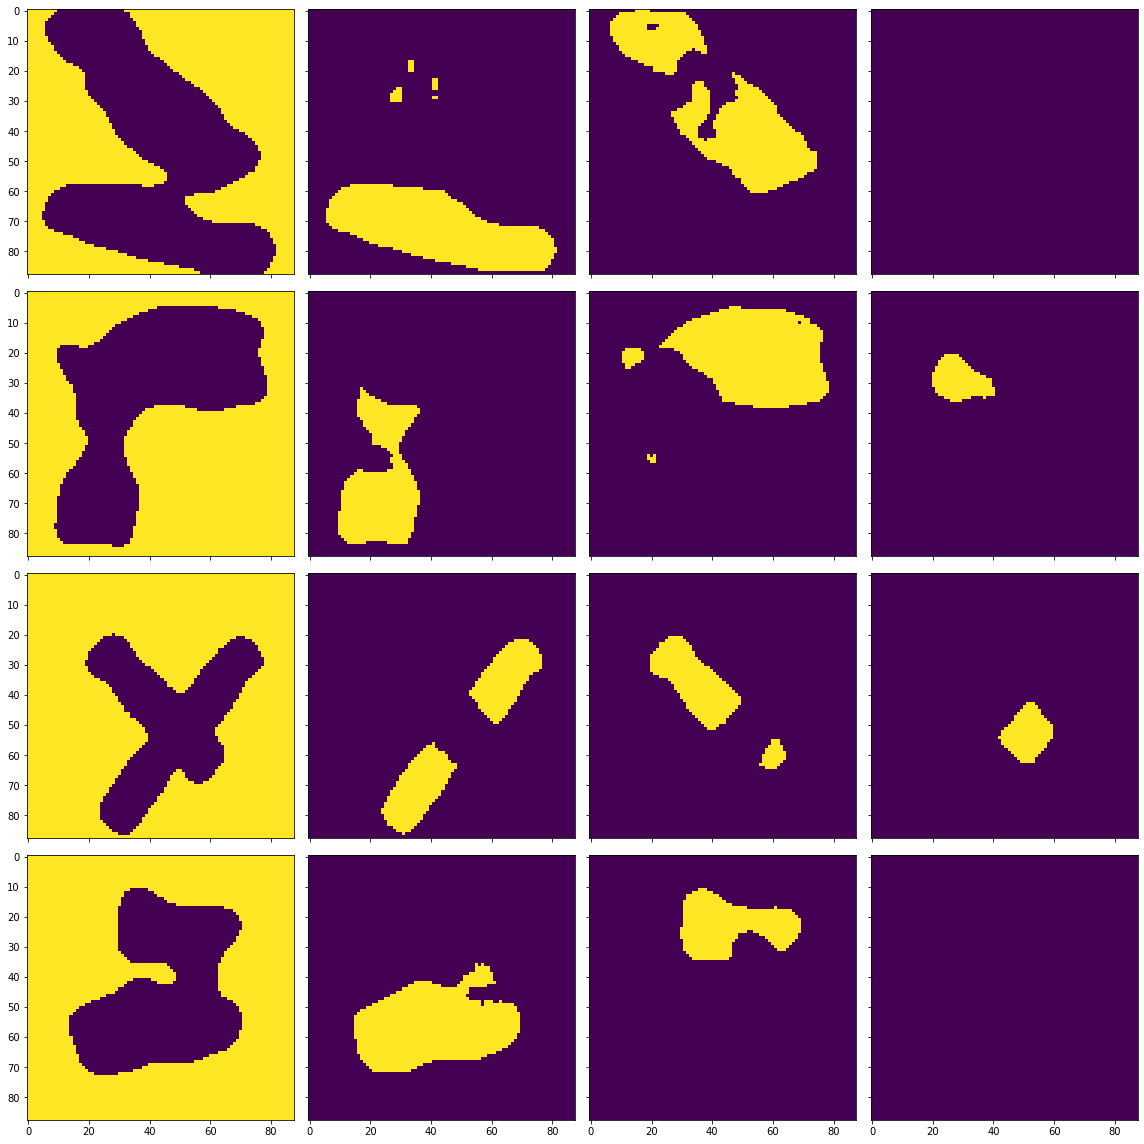

Training IOU: [0.9752649796830993, 0.7314166370624133, 0.7420656602713208, 0.6414245332000077]
Training accuracy: 0.9208942407024794
Testing IOU: [0.9731921415633273, 0.43709289837043447, 0.36488767817062173, 0.4432956822736382]
Testing accuracy: 0.8562900309917355
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0757 - val_loss: 0.0527
INFO:tensorflow:Assets written to: modelseg/savedmodel_84epoch\assets
4
4


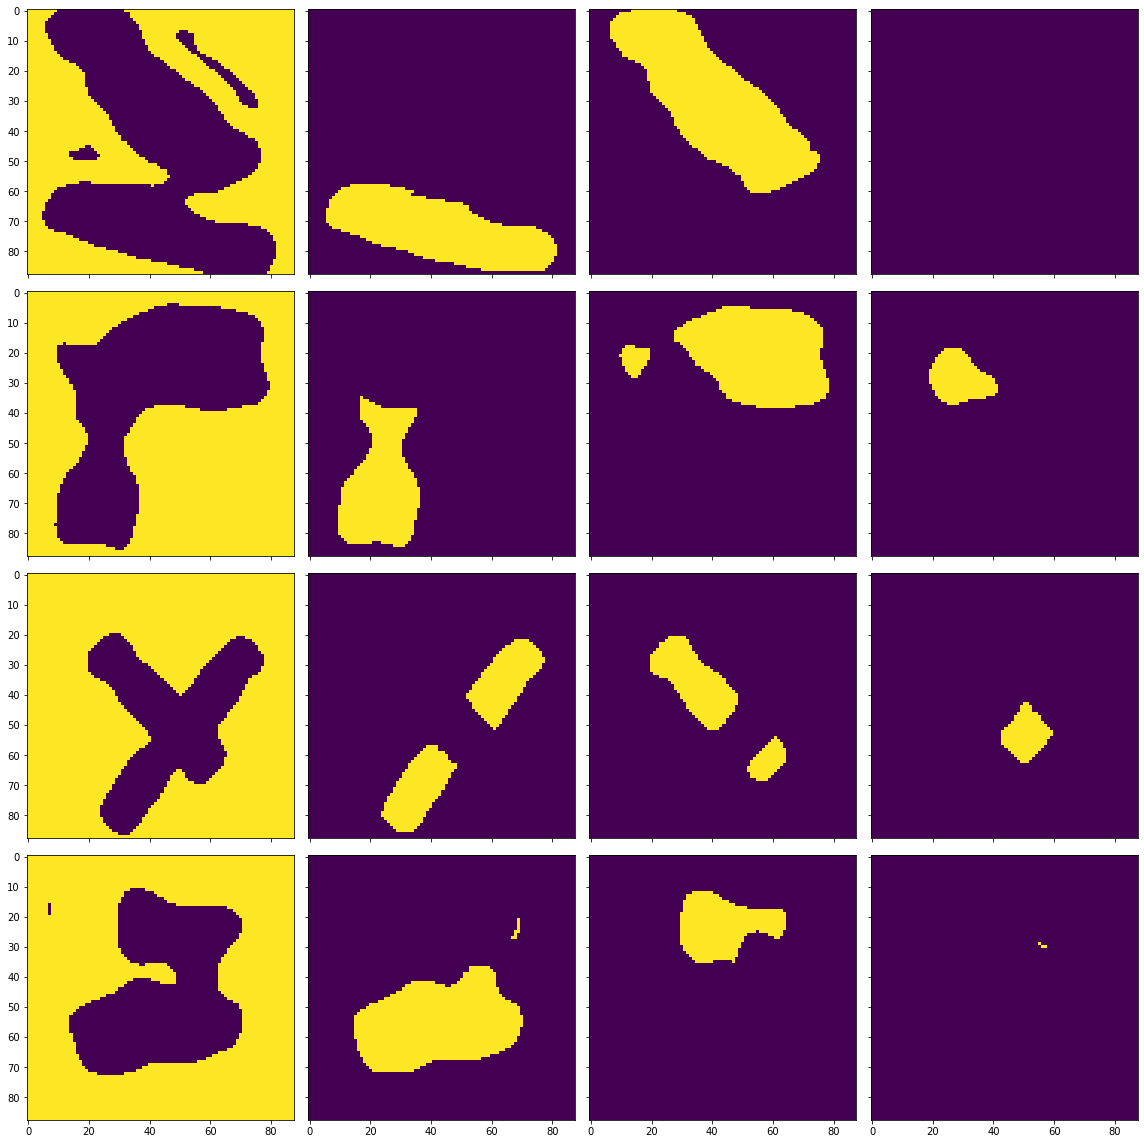

Training IOU: [0.9625477062879509, 0.7934094836632536, 0.7650182974830323, 0.6722641044592265]
Training accuracy: 0.9228163739669422
Testing IOU: [0.9598683373228473, 0.47665363911215985, 0.3545199011693625, 0.458128078817734]
Testing accuracy: 0.8529261363636363
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0758 - val_loss: 0.0492
INFO:tensorflow:Assets written to: modelseg/savedmodel_85epoch\assets
4
4


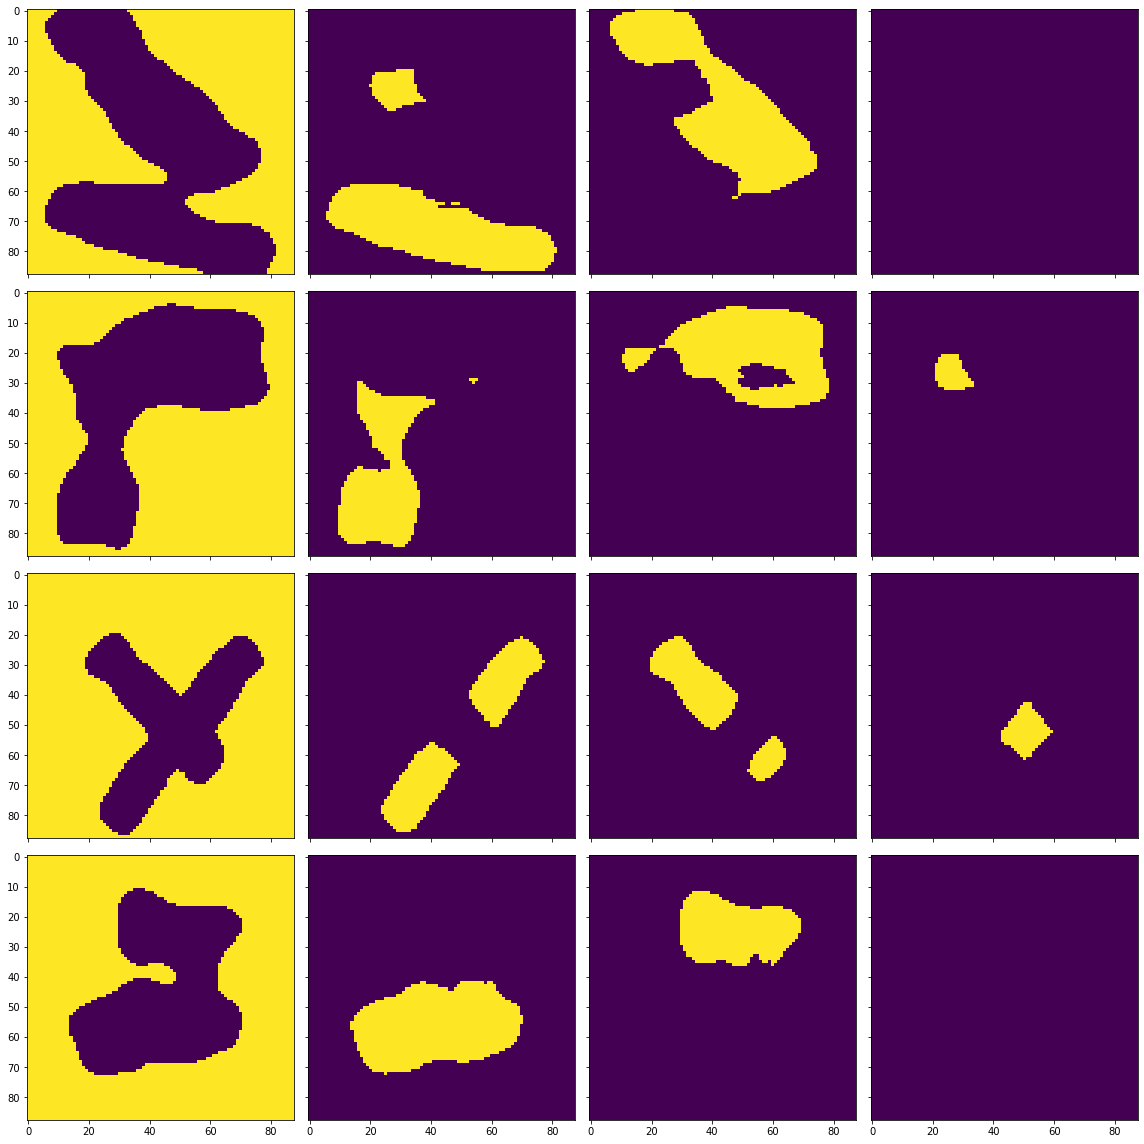

Training IOU: [0.9756159776494738, 0.7919873473182513, 0.7103792869701527, 0.5692772361169988]
Training accuracy: 0.9261376549586777
Testing IOU: [0.9737219277444553, 0.5268254200962015, 0.3492964777087948, 0.3988519187838843]
Testing accuracy: 0.8716477272727273
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0758 - val_loss: 0.0471
INFO:tensorflow:Assets written to: modelseg/savedmodel_86epoch\assets
4
4


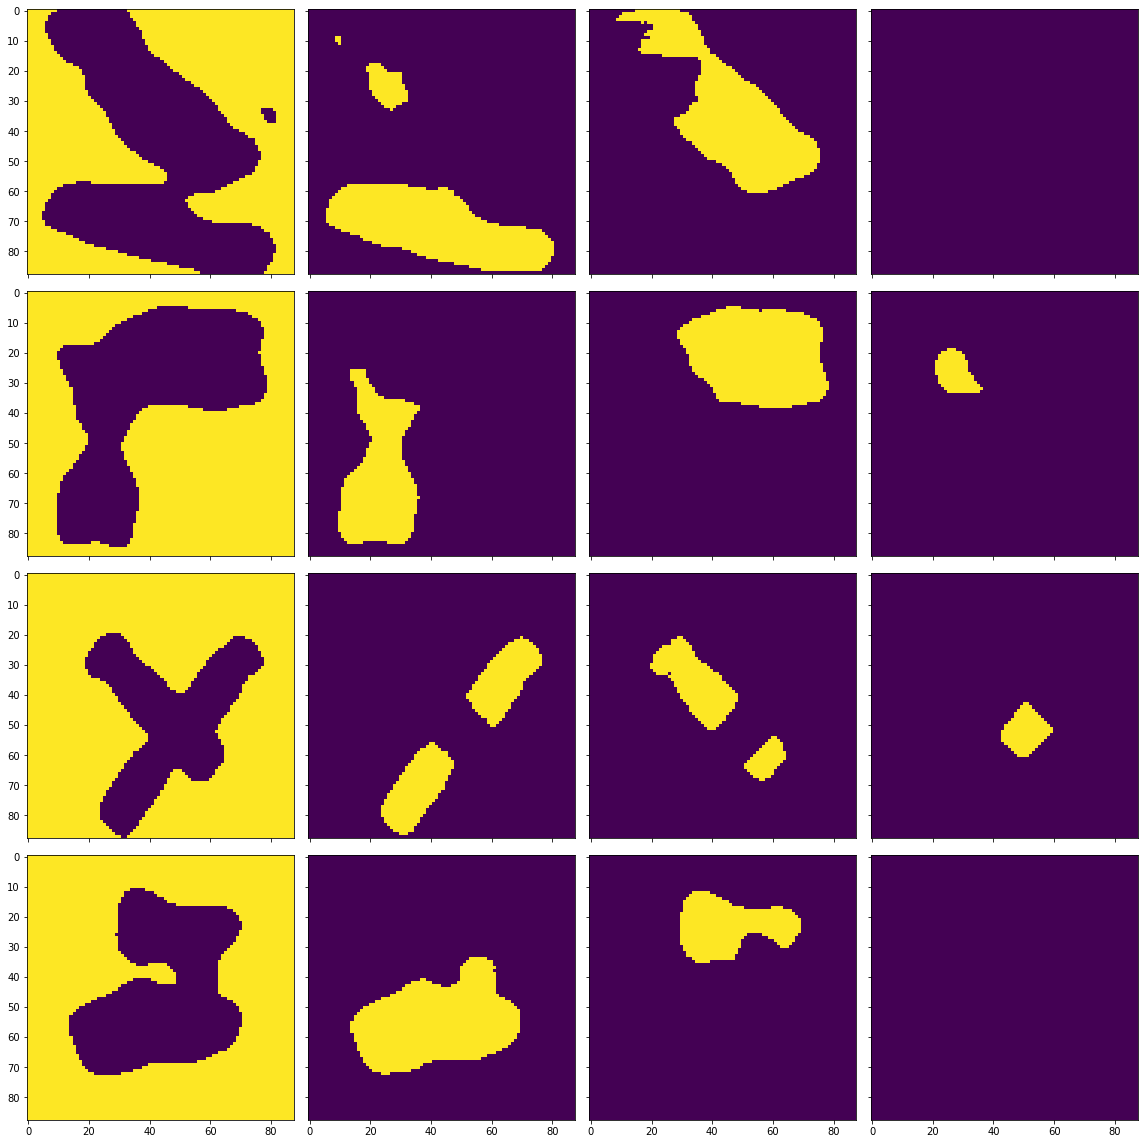

Training IOU: [0.9754651269566463, 0.8210236940261162, 0.7481094725940949, 0.5979787526136819]
Training accuracy: 0.9300235666322314
Testing IOU: [0.9733892362012294, 0.5125879196577479, 0.3338077766531714, 0.4329454990814452]
Testing accuracy: 0.8647339876033058
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0757 - val_loss: 0.0719
INFO:tensorflow:Assets written to: modelseg/savedmodel_87epoch\assets
4
4


Training IOU: [0.8042905620066563, 0.7815489794181013, 0.7515338445721259, 0.6485980543592786]
Training accuracy: 0.811365250516529
Testing IOU: [0.8003390331470099, 0.44734669202754307, 0.3678401258268955, 0.4751248559354591]
Testing accuracy: 0.7369034090909091
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0760 - val_loss: 0.0539
INFO:tensorflow:Assets written to: modelseg/savedmodel_88epoch\assets
4
4


Training IOU: [0.9518743733700882, 0.8068205703859072, 0.7810551878736123, 0.6845980654574971]
Training accuracy: 0.9176288094008265
Testing IOU: [0.9515500622543054, 0.4661736205475485, 0.3544435215946844, 0.48710340104998856]
Testing accuracy: 0.843801652892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0749 - val_loss: 0.0757
INFO:tensorflow:Assets written to: modelseg/savedmodel_89epoch\assets
4
4


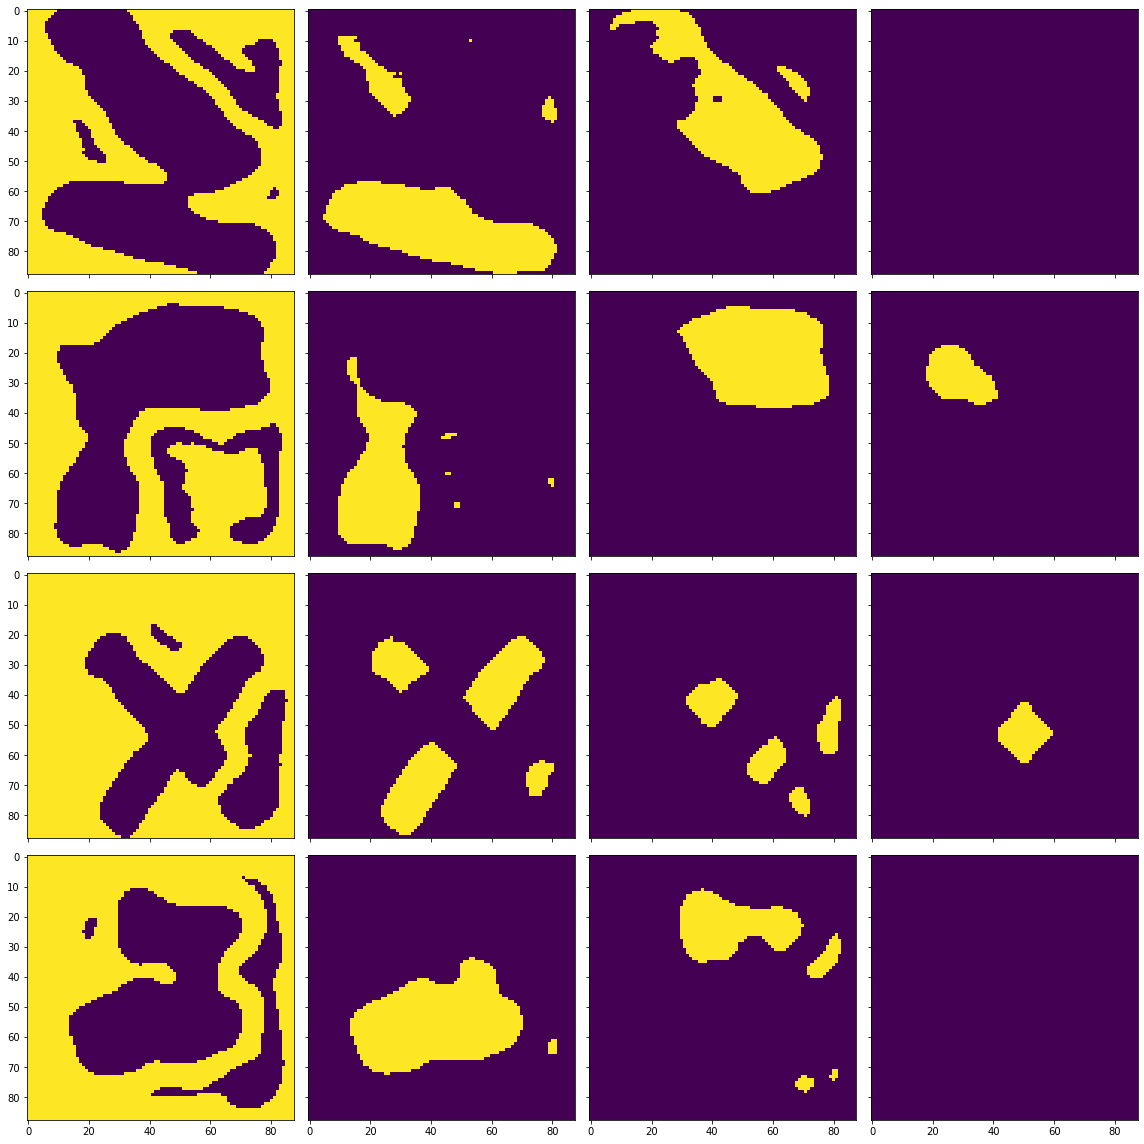

Training IOU: [0.8183975935773607, 0.7450382024930168, 0.551065396700707, 0.6527693917803807]
Training accuracy: 0.8088884943181818
Testing IOU: [0.8124345318557716, 0.5077573702667801, 0.2398619243551195, 0.4442579243606201]
Testing accuracy: 0.749997417355372
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0745 - val_loss: 0.0591
INFO:tensorflow:Assets written to: modelseg/savedmodel_90epoch\assets
4
4


Training IOU: [0.9027833193827014, 0.8379474882792208, 0.7564979700556355, 0.671941941011903]
Training accuracy: 0.8847559400826446
Testing IOU: [0.9016517381663262, 0.5165457937632387, 0.3544353937719637, 0.4592900832247067]
Testing accuracy: 0.8188365185950414
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0745 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelseg/savedmodel_91epoch\assets
4
4


Training IOU: [0.9752506296540867, 0.8136127020691704, 0.7827112277781335, 0.6442119915236632]
Training accuracy: 0.9342800878099173
Testing IOU: [0.9729314641039348, 0.4820581257413998, 0.37065529614058107, 0.4499373276510404]
Testing accuracy: 0.8652169421487603
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0749 - val_loss: 0.0564
INFO:tensorflow:Assets written to: modelseg/savedmodel_92epoch\assets
4
4


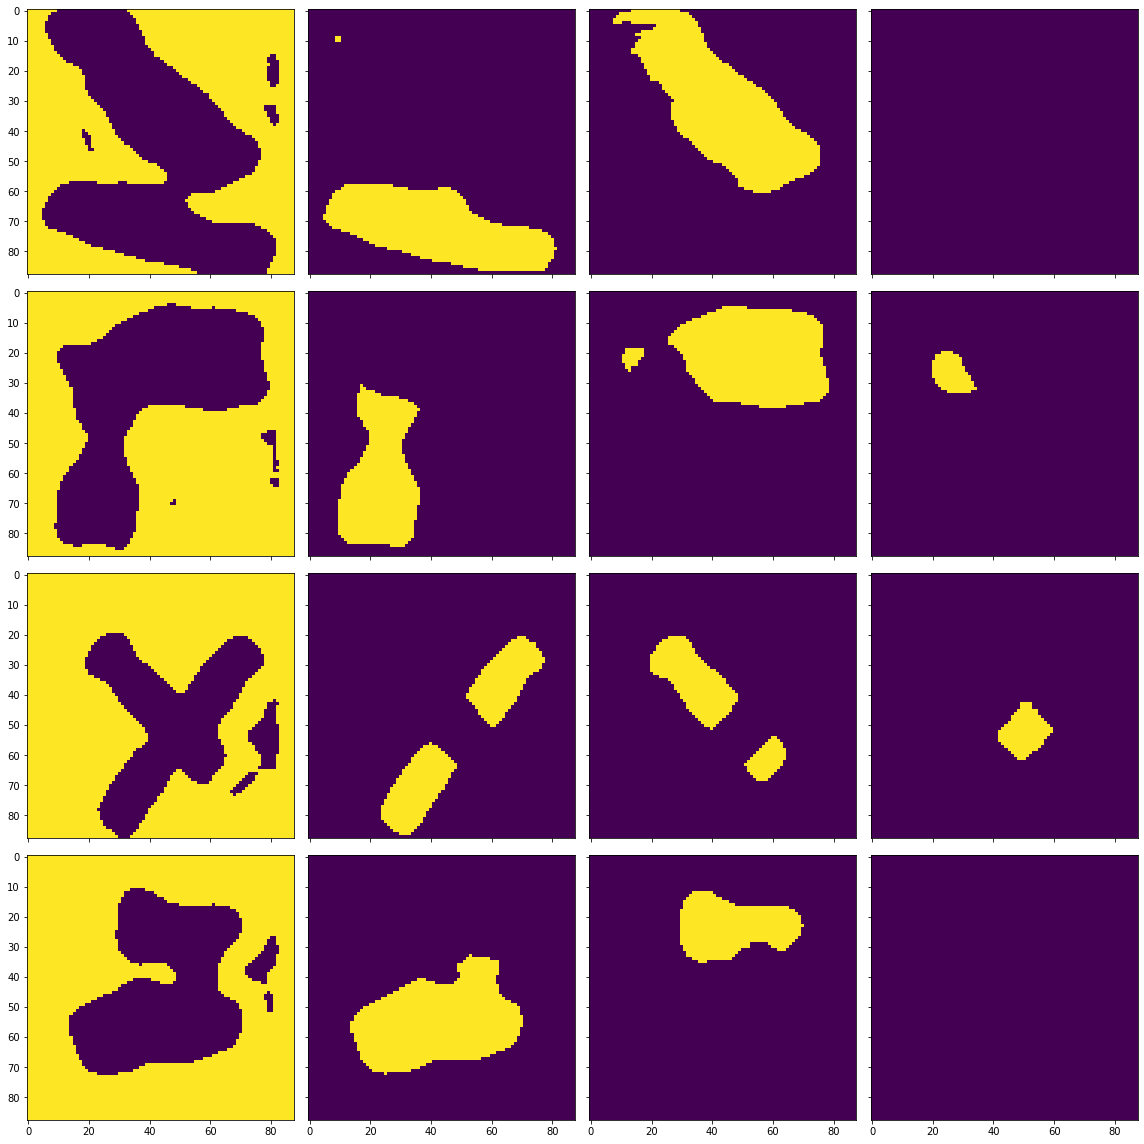

Training IOU: [0.9418637028307818, 0.7954446481198286, 0.7010667009381828, 0.493091389824726]
Training accuracy: 0.9032860924586776
Testing IOU: [0.9419635370080501, 0.5307653663724204, 0.3148631650159086, 0.3587938077832724]
Testing accuracy: 0.848410382231405
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0750 - val_loss: 0.0527
INFO:tensorflow:Assets written to: modelseg/savedmodel_93epoch\assets
4
4


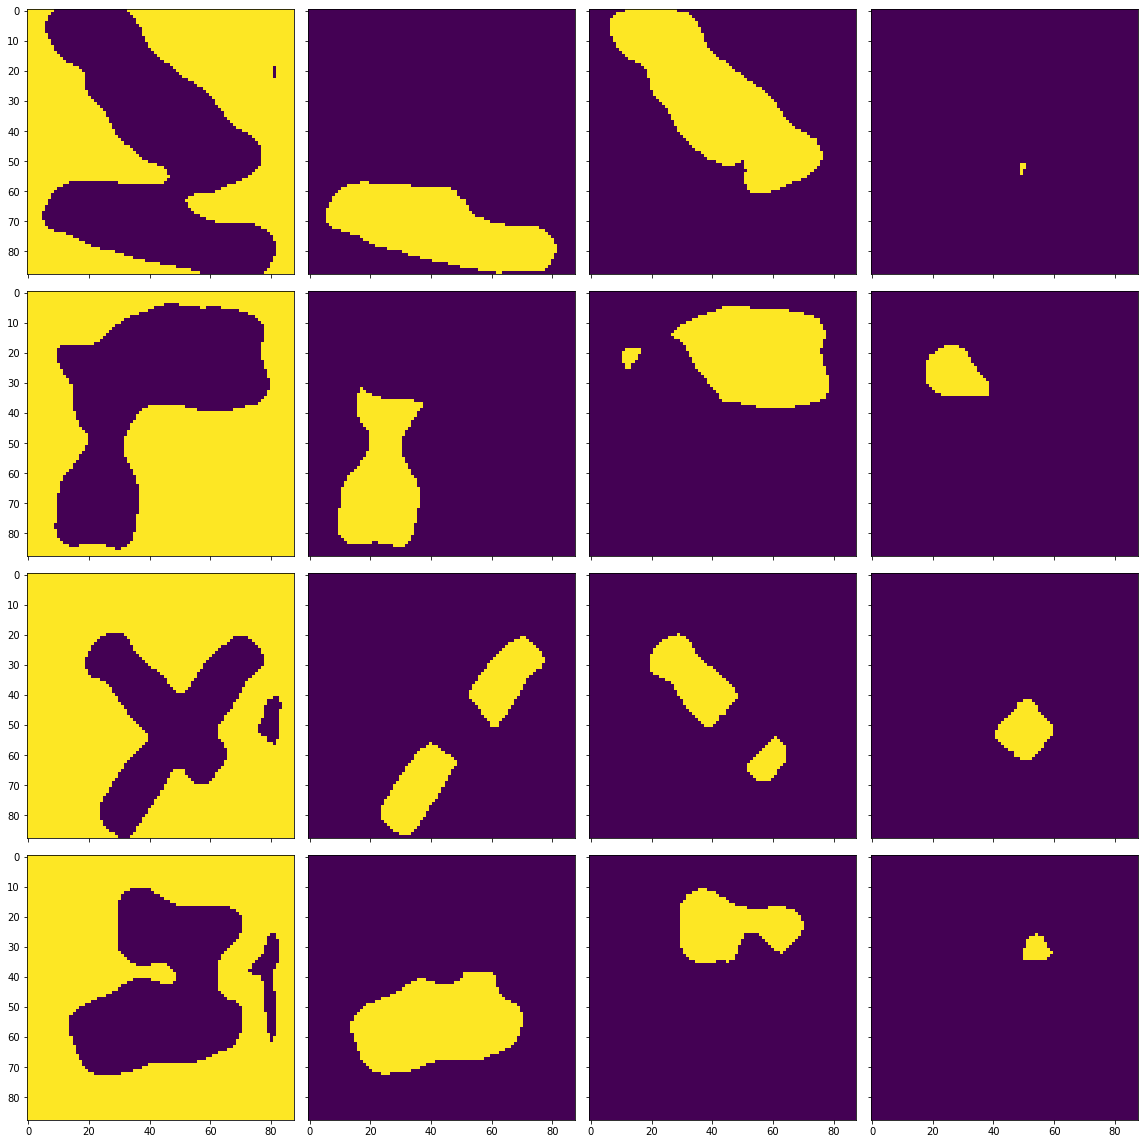

Training IOU: [0.9636244527357819, 0.8474352229969506, 0.7982706845609487, 0.6967288998611325]
Training accuracy: 0.9344463455578512
Testing IOU: [0.9634845356860045, 0.5194179905402253, 0.36457356120243095, 0.4554581447963801]
Testing accuracy: 0.8652543904958677
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0747 - val_loss: 0.1364
INFO:tensorflow:Assets written to: modelseg/savedmodel_94epoch\assets
4
4


Training IOU: [0.5597717961226704, 0.5356773584245689, 0.34604183296747154, 0.607395948742605]
Training accuracy: 0.6166716167355372
Testing IOU: [0.5379303481197205, 0.3863592436677682, 0.14774405553094078, 0.43419415833208935]
Testing accuracy: 0.5459504132231405
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0754 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelseg/savedmodel_95epoch\assets
4
4


Training IOU: [0.9739391412715063, 0.8348785490661773, 0.716205527172647, 0.5219258879343506]
Training accuracy: 0.9273366477272728
Testing IOU: [0.9719298000913589, 0.5262592842673869, 0.29301844104840774, 0.39192612137203164]
Testing accuracy: 0.8655539772727273
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0748 - val_loss: 0.0542
INFO:tensorflow:Assets written to: modelseg/savedmodel_96epoch\assets
4
4


Training IOU: [0.9640612588823769, 0.754695384897697, 0.8058304512688028, 0.6823480432972523]
Training accuracy: 0.9242038997933885
Testing IOU: [0.9604503860725271, 0.39732614330975774, 0.40993991167740534, 0.5007989472694803]
Testing accuracy: 0.8497172004132232
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0748 - val_loss: 0.0539
INFO:tensorflow:Assets written to: modelseg/savedmodel_97epoch\assets
4
4


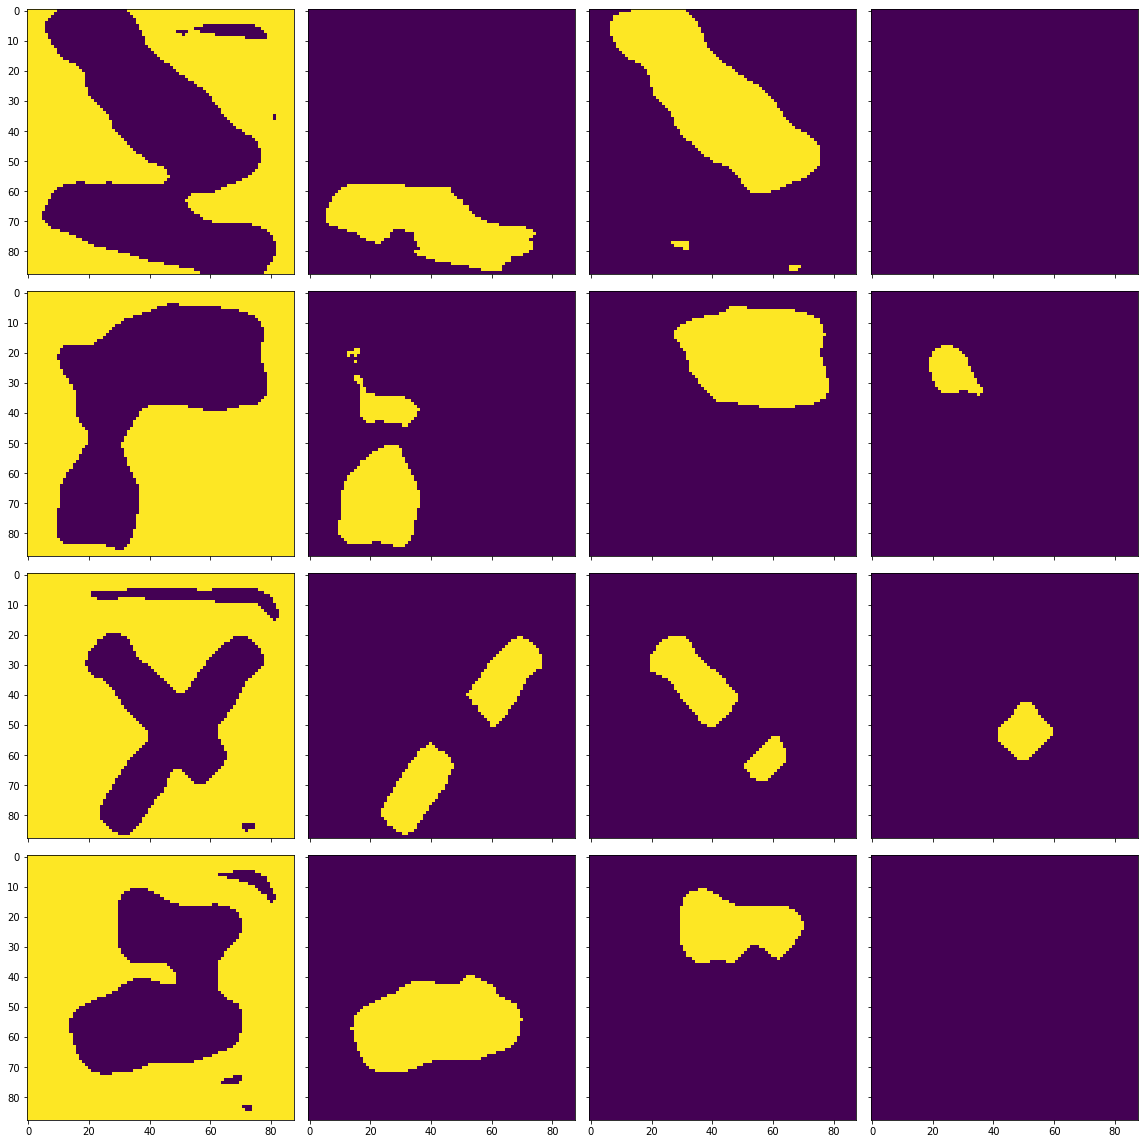

Training IOU: [0.9582514792024008, 0.7930865684264715, 0.8322217849398179, 0.7240425364934862]
Training accuracy: 0.9269908961776859
Testing IOU: [0.958760352621037, 0.39660789119949397, 0.4066796750918909, 0.48117625866882824]
Testing accuracy: 0.8466477272727273
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0750 - val_loss: 0.1511
INFO:tensorflow:Assets written to: modelseg/savedmodel_98epoch\assets
4
4


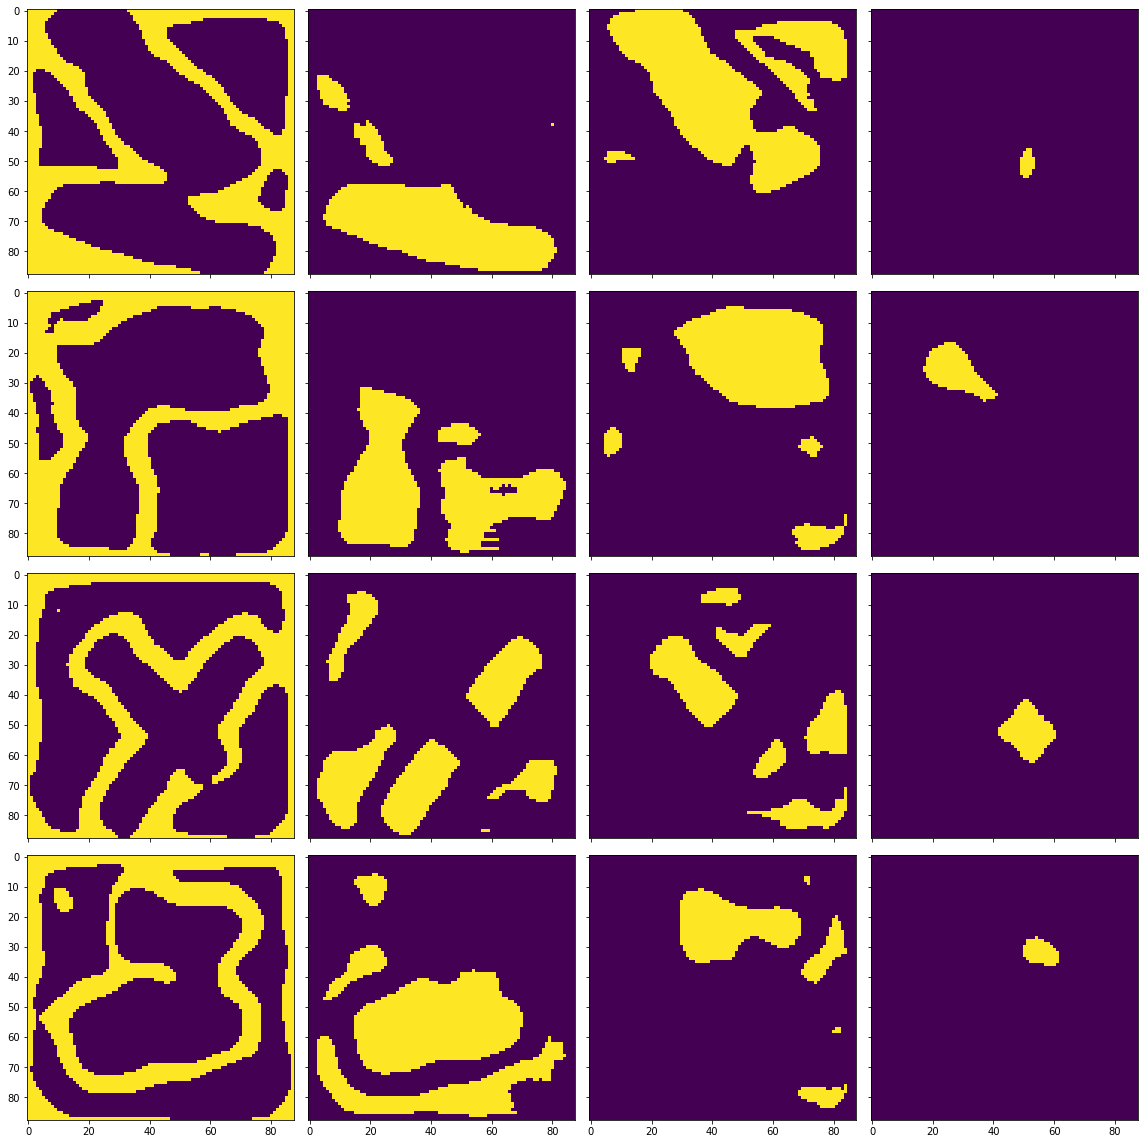

Training IOU: [0.43550917730699007, 0.4606729066531748, 0.5030510551890442, 0.672615379197408]
Training accuracy: 0.5491477272727273
Testing IOU: [0.41451562172363177, 0.26110205181915, 0.25467096534352024, 0.46140043228253336]
Testing accuracy: 0.44854080578512395
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0745 - val_loss: 0.1384
INFO:tensorflow:Assets written to: modelseg/savedmodel_99epoch\assets
4
4


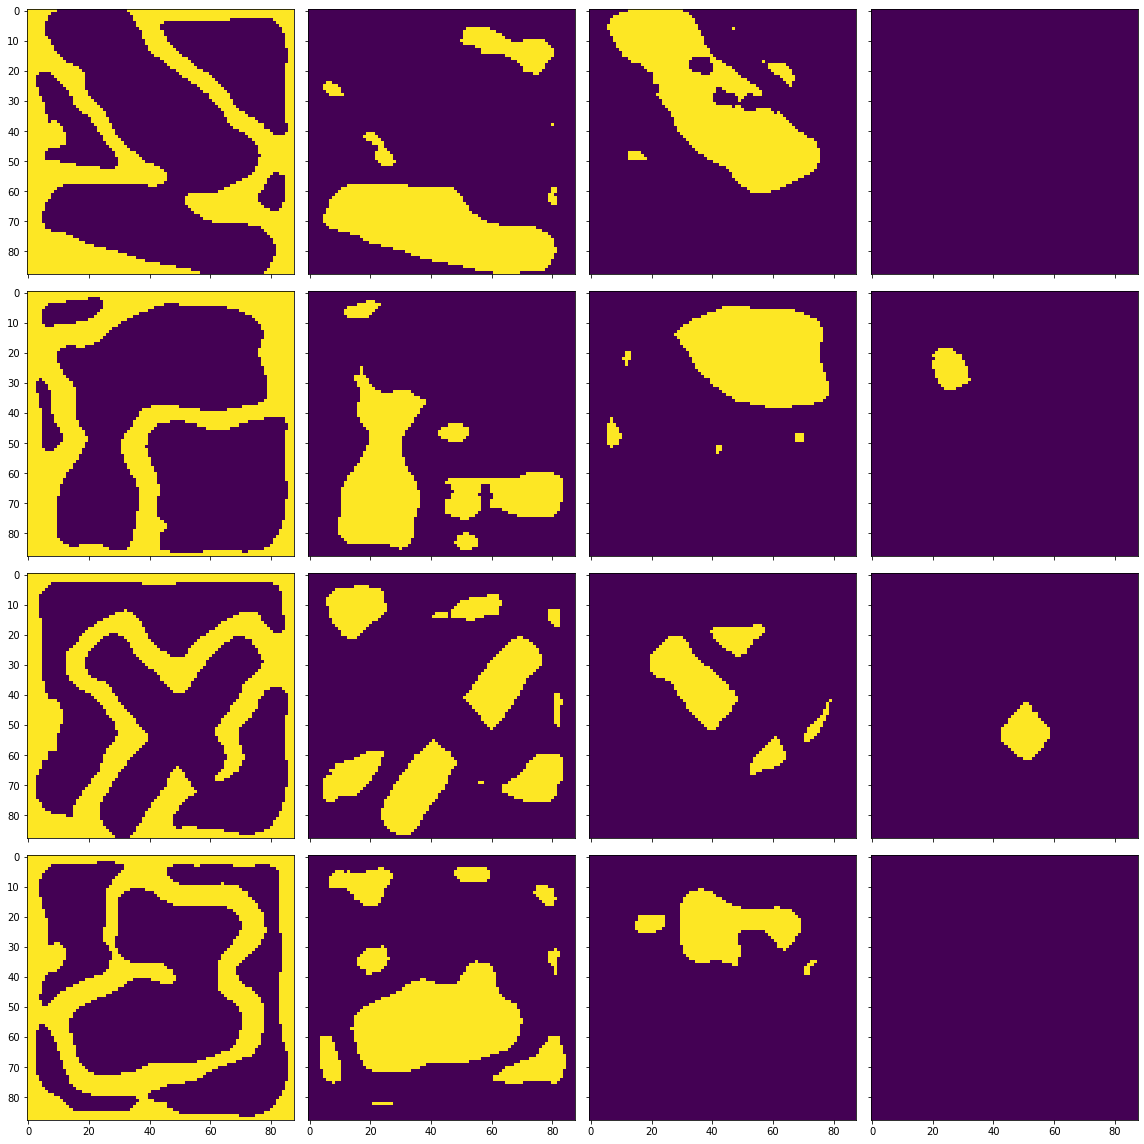

Training IOU: [0.49942514180955944, 0.5151690190696616, 0.6718736495879931, 0.5686759729272419]
Training accuracy: 0.5912971332644628
Testing IOU: [0.4772903628554838, 0.3384872270211283, 0.28013937282229967, 0.41642547033285093]
Testing accuracy: 0.5014901859504132
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0732 - val_loss: 0.1106
INFO:tensorflow:Assets written to: modelseg/savedmodel_100epoch\assets
4
4


Training IOU: [0.5704723095473925, 0.6007502892767842, 0.7535350951826661, 0.6930621891772121]
Training accuracy: 0.6483251549586777
Testing IOU: [0.547743305468168, 0.3708932184651328, 0.2981617831204608, 0.4702649839333116]
Testing accuracy: 0.5486880165289256
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0733 - val_loss: 0.0544
INFO:tensorflow:Assets written to: modelseg/savedmodel_101epoch\assets
4
4


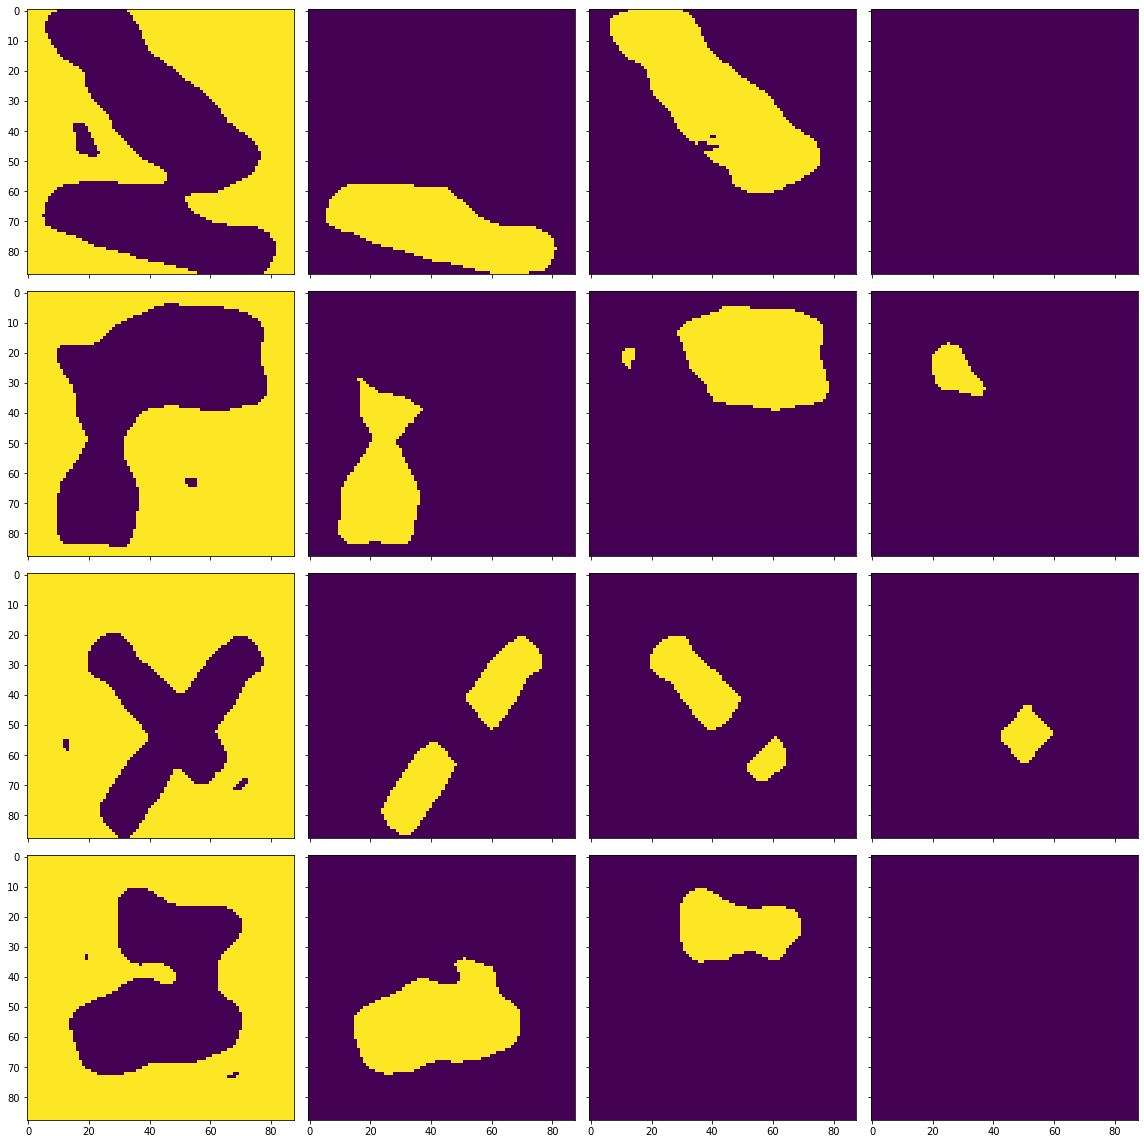

Training IOU: [0.9555125681972169, 0.8636753851360892, 0.8396322805882432, 0.6360853062679557]
Training accuracy: 0.9324435046487604
Testing IOU: [0.9510528765609229, 0.49382201173393653, 0.3589653722136548, 0.4275154623623473]
Testing accuracy: 0.851952479338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0727 - val_loss: 0.0509
INFO:tensorflow:Assets written to: modelseg/savedmodel_102epoch\assets
4
4


Training IOU: [0.975497048650924, 0.8541404296482871, 0.8452795069370502, 0.7015634925513822]
Training accuracy: 0.9464495092975207
Testing IOU: [0.9733574095397607, 0.4775957510472771, 0.3847210400061905, 0.47471965374778674]
Testing accuracy: 0.8667097107438017
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0730 - val_loss: 0.0514
INFO:tensorflow:Assets written to: modelseg/savedmodel_103epoch\assets
4
4


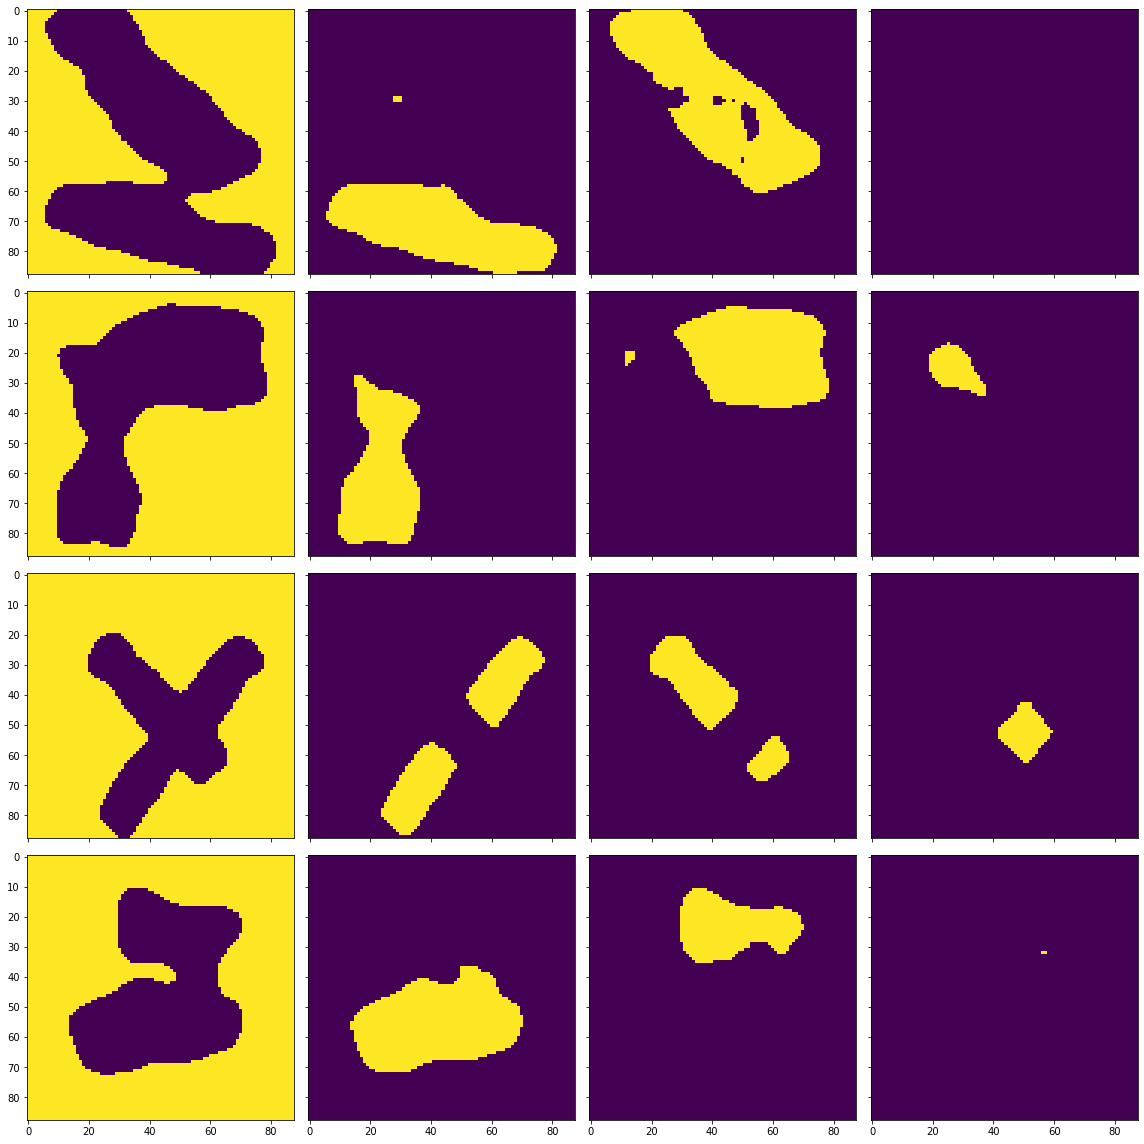

Training IOU: [0.9741779926992551, 0.8743672082029279, 0.8317329427784801, 0.7277339009688265]
Training accuracy: 0.947969395661157
Testing IOU: [0.9725277794262933, 0.4979282896840908, 0.3371572812346084, 0.47150666958233106]
Testing accuracy: 0.8663055268595041
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0722 - val_loss: 0.0492
INFO:tensorflow:Assets written to: modelseg/savedmodel_104epoch\assets
4
4


Training IOU: [0.9767374784521138, 0.8718005630510755, 0.8422370549832928, 0.7375043448036149]
Training accuracy: 0.9515263429752067
Testing IOU: [0.9741090843146178, 0.5283201595100762, 0.36392798553859335, 0.5051011355571328]
Testing accuracy: 0.8768633780991736
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0719 - val_loss: 0.0543
INFO:tensorflow:Assets written to: modelseg/savedmodel_105epoch\assets
4
4


Training IOU: [0.9509094332686246, 0.8562300392528022, 0.8598756666010957, 0.7263473053892215]
Training accuracy: 0.931365896177686
Testing IOU: [0.9466463122417575, 0.48899221453287195, 0.3415295334290505, 0.475925751436917]
Testing accuracy: 0.8460304752066116
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0721 - val_loss: 0.0526
INFO:tensorflow:Assets written to: modelseg/savedmodel_106epoch\assets
4
4


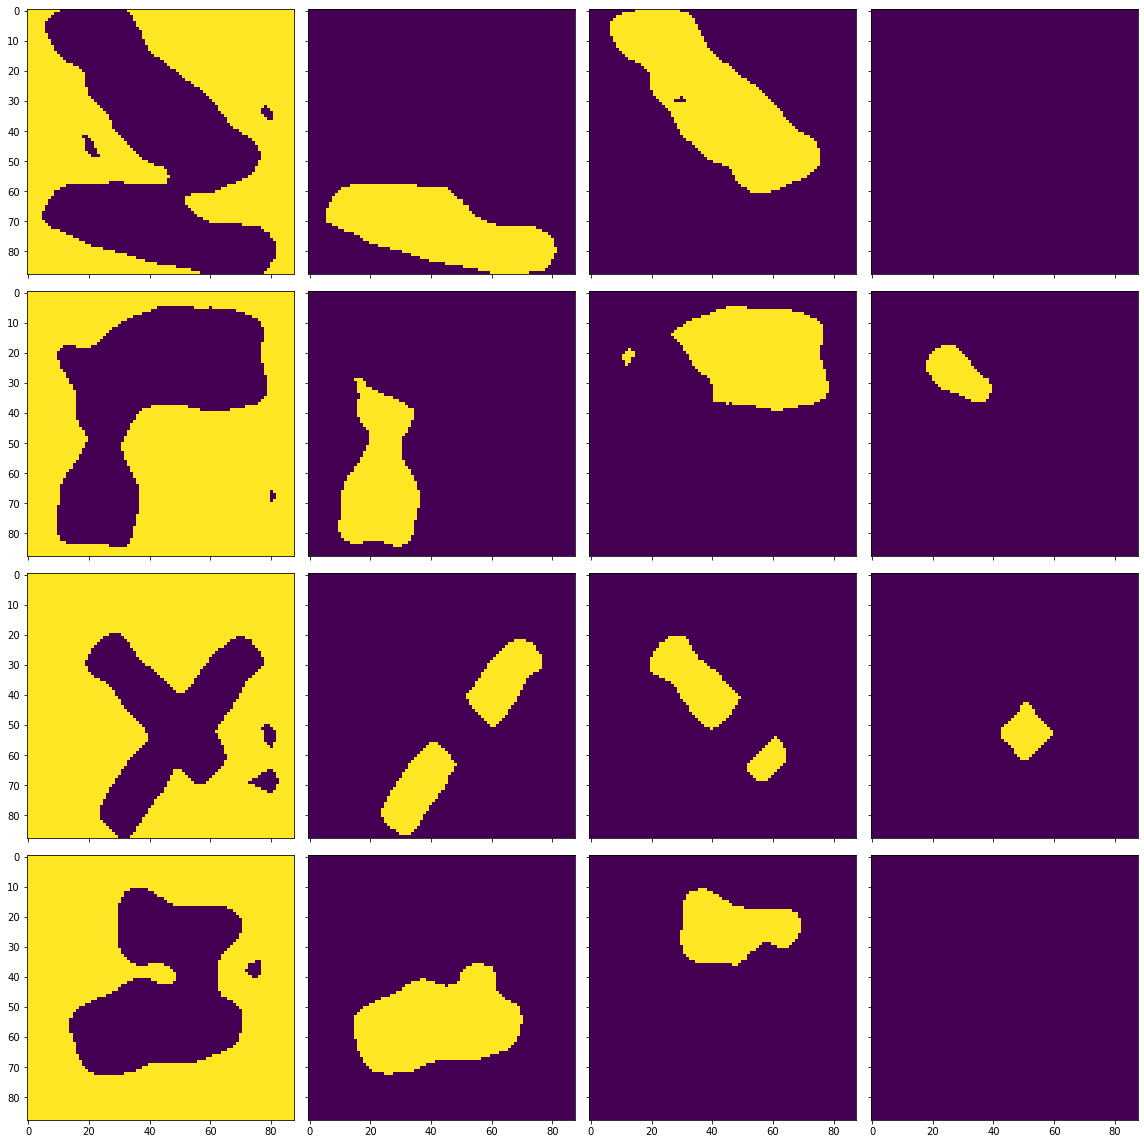

Training IOU: [0.9558499776979337, 0.8732125511103079, 0.8320569819770854, 0.7162516651296239]
Training accuracy: 0.9345522339876033
Testing IOU: [0.9516950142129874, 0.5119878603945371, 0.35818304364698433, 0.4757836102719033]
Testing accuracy: 0.8571138946280992
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0722 - val_loss: 0.0822
INFO:tensorflow:Assets written to: modelseg/savedmodel_107epoch\assets
4
4


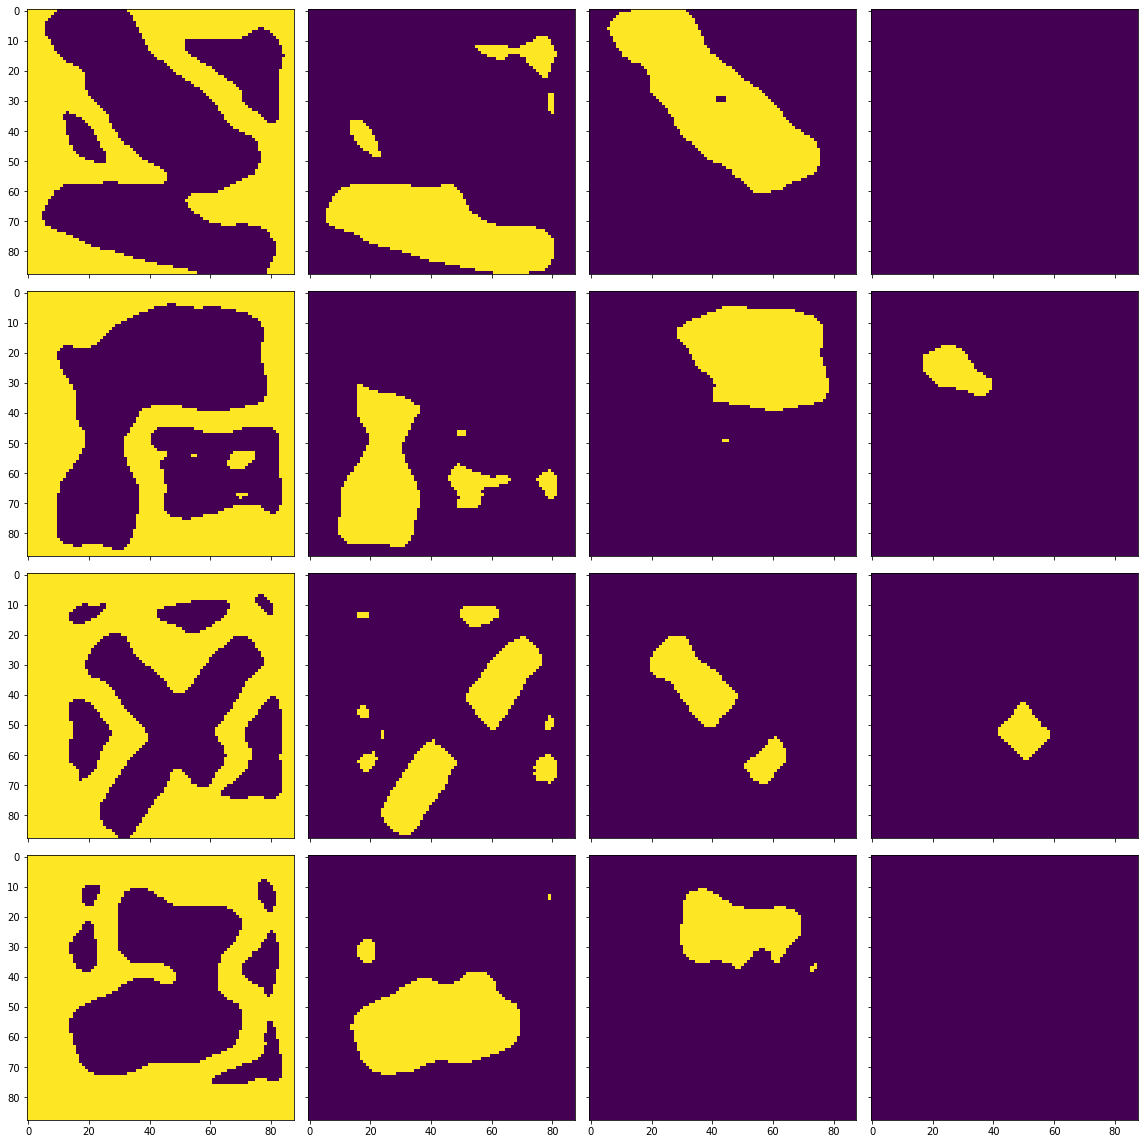

Training IOU: [0.7662105777206445, 0.7063515172998772, 0.8126275862977255, 0.6782904000662635]
Training accuracy: 0.7979216167355372
Testing IOU: [0.7373168198441169, 0.40999816357918417, 0.3285522275309284, 0.45824986563736747]
Testing accuracy: 0.6930449380165289
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0722 - val_loss: 0.0504
INFO:tensorflow:Assets written to: modelseg/savedmodel_108epoch\assets
4
4


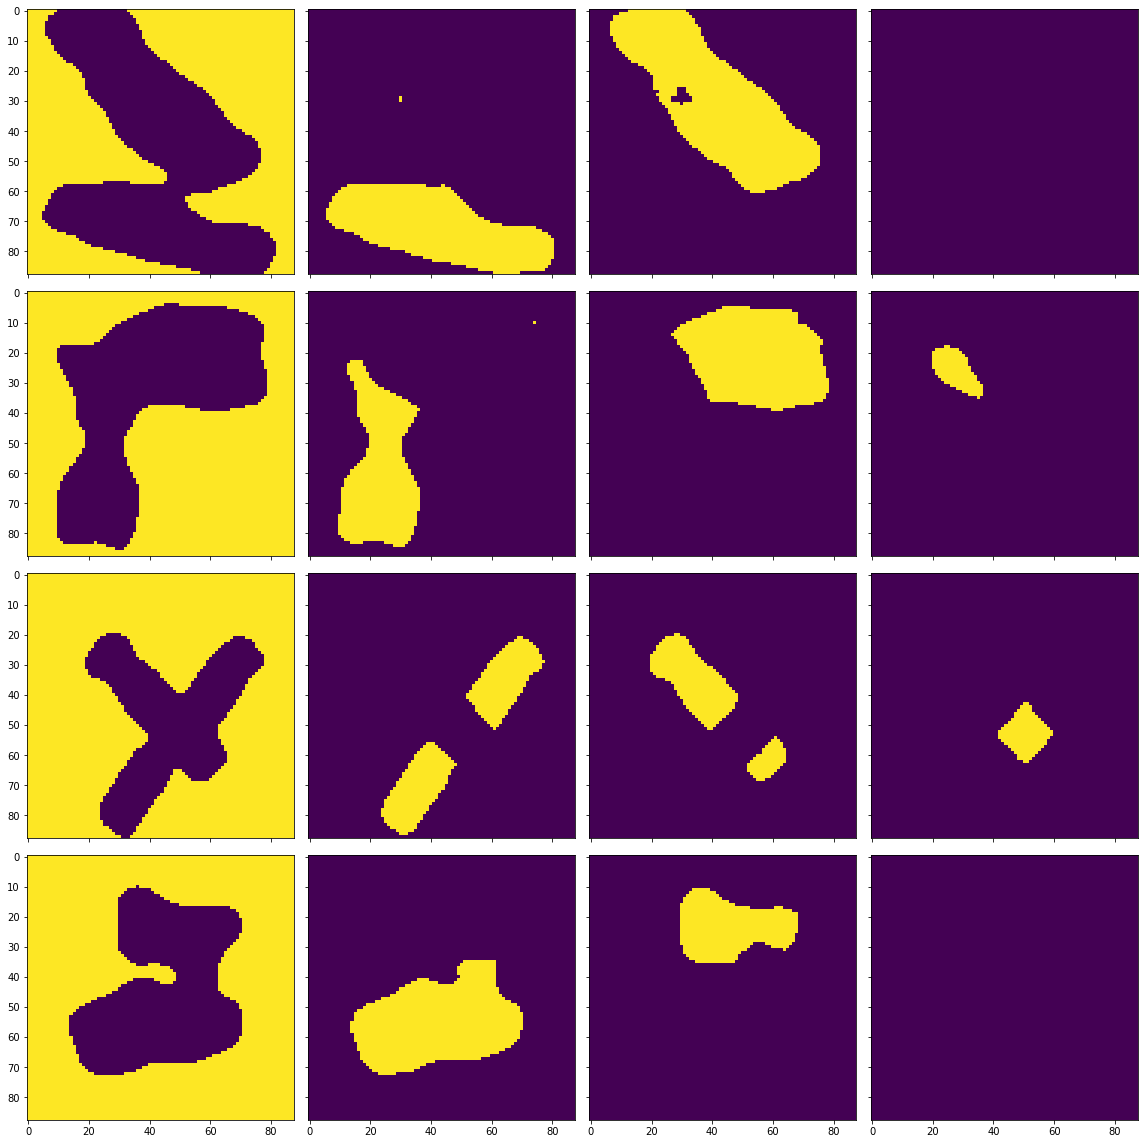

Training IOU: [0.9733330337381613, 0.8733671259183172, 0.8283743202662122, 0.7220645080189816]
Training accuracy: 0.9465799328512396
Testing IOU: [0.9719468861043575, 0.5146278254362017, 0.3355048859934853, 0.47416164053075993]
Testing accuracy: 0.8690999483471075
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0725 - val_loss: 0.0504
INFO:tensorflow:Assets written to: modelseg/savedmodel_109epoch\assets
4
4


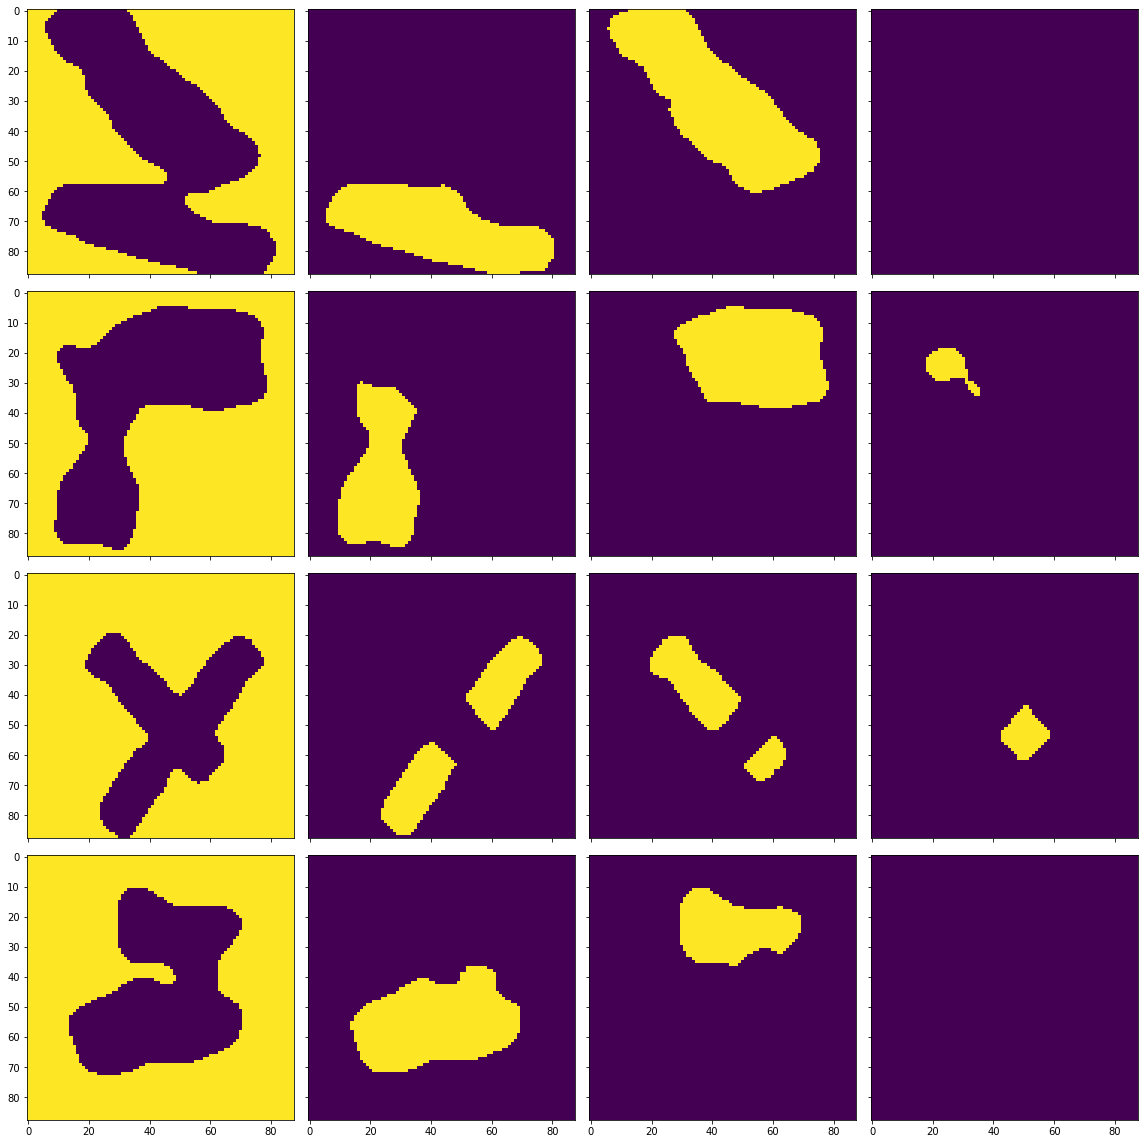

Training IOU: [0.9756669939991045, 0.8840309305195467, 0.8586728446671593, 0.6471316505683334]
Training accuracy: 0.951157347623967
Testing IOU: [0.9727128120159799, 0.516665047128559, 0.3495421245421245, 0.4208706265256306]
Testing accuracy: 0.8721255165289257
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0718 - val_loss: 0.0524
INFO:tensorflow:Assets written to: modelseg/savedmodel_110epoch\assets
4
4


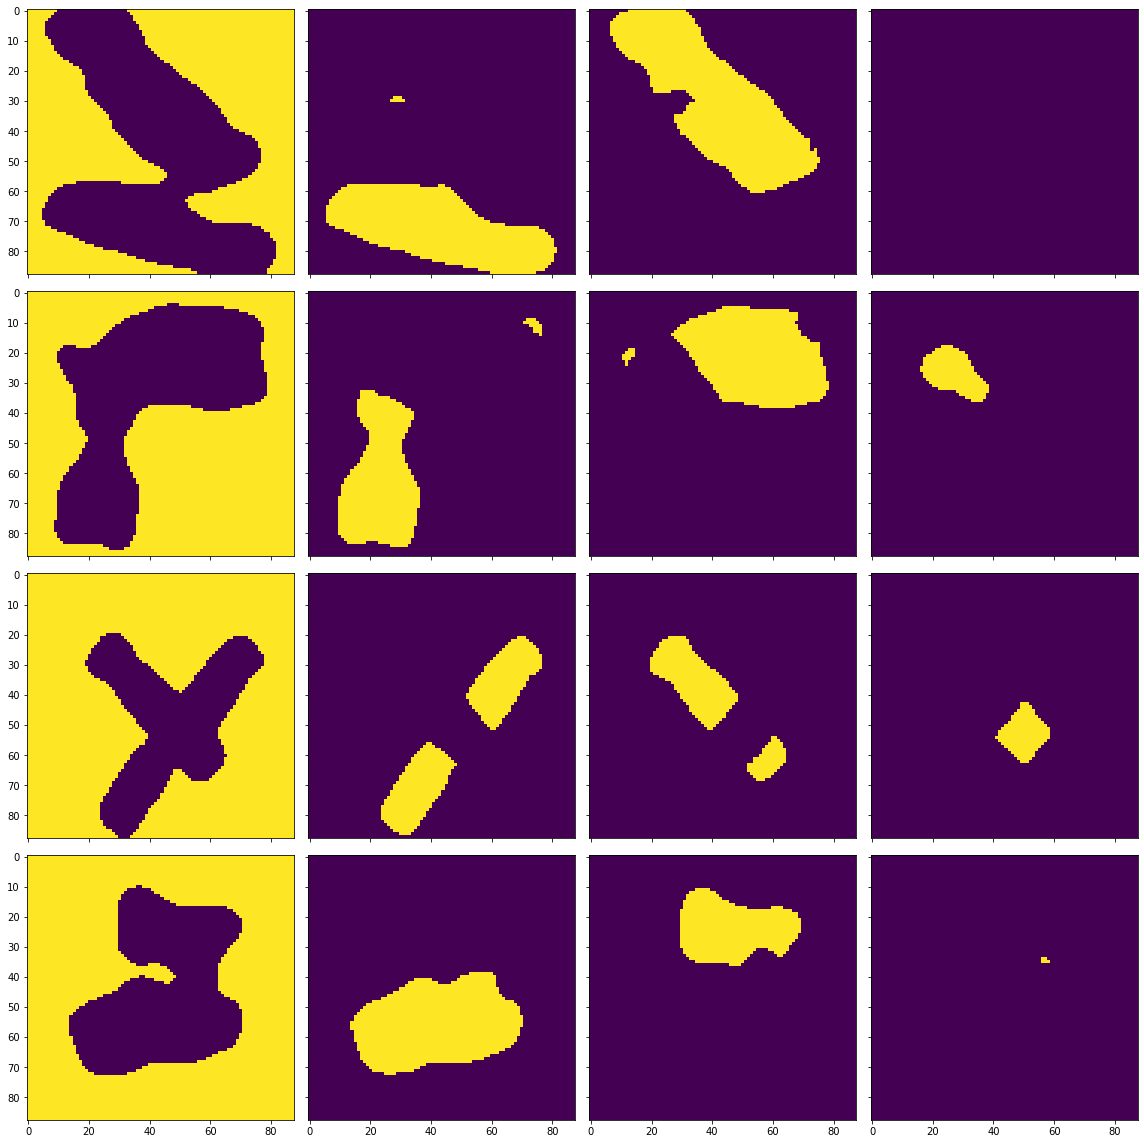

Training IOU: [0.974312695785325, 0.8776825937355893, 0.7993776283505519, 0.7460690051046557]
Training accuracy: 0.946223527892562
Testing IOU: [0.9724436211762444, 0.5326871937473846, 0.3133393017009848, 0.48560406473466317]
Testing accuracy: 0.8718001033057852
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0717 - val_loss: 0.0525
INFO:tensorflow:Assets written to: modelseg/savedmodel_111epoch\assets
4
4


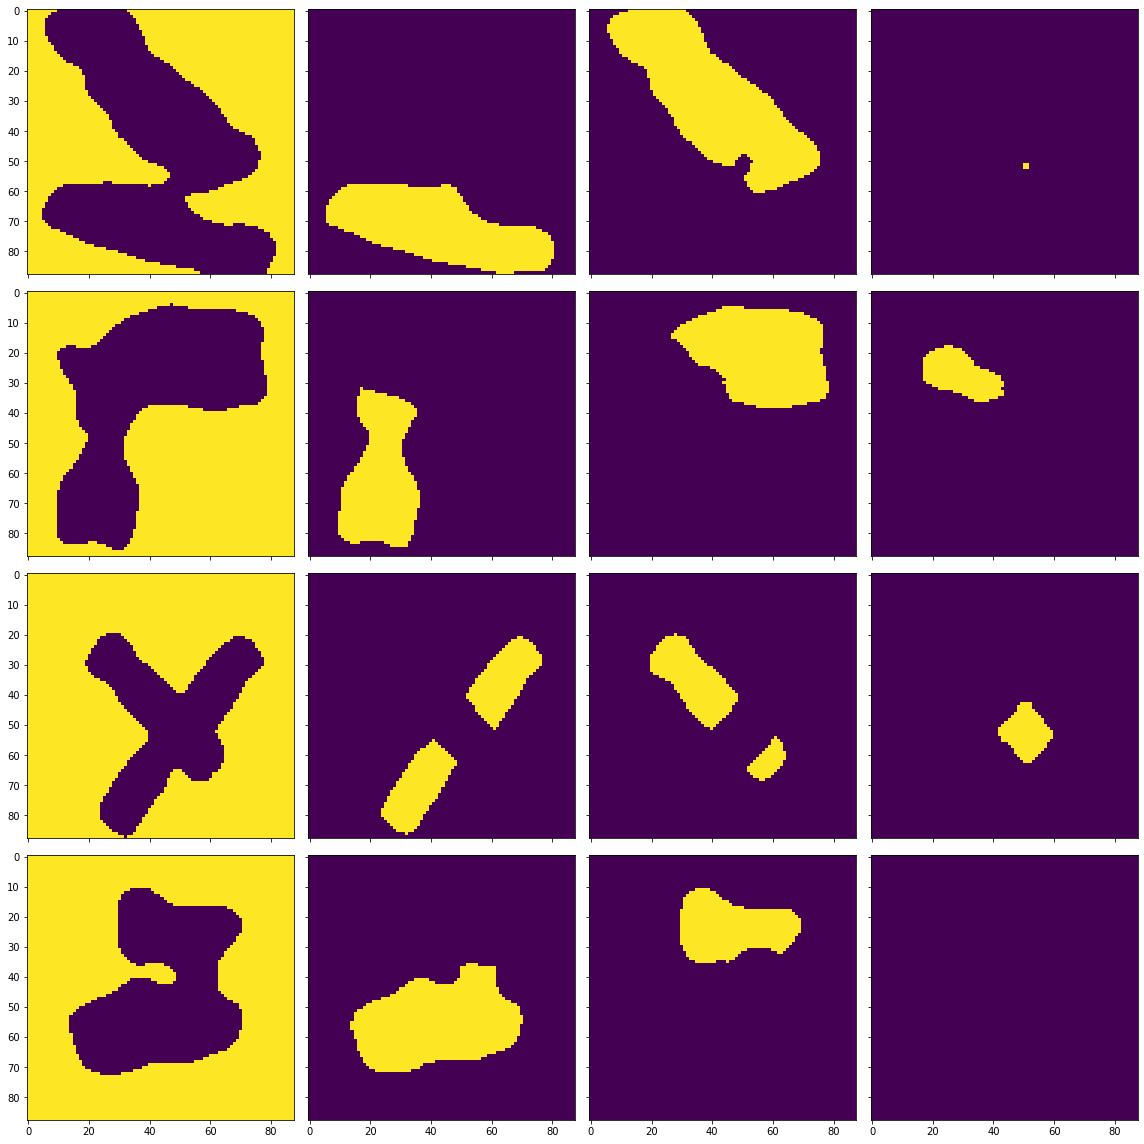

Training IOU: [0.9764019265088825, 0.8777405993226925, 0.8061216701015189, 0.7498686284813453]
Training accuracy: 0.9487984245867769
Testing IOU: [0.9737169935758079, 0.514064602960969, 0.29188165579752545, 0.4895828686147669]
Testing accuracy: 0.8689075413223141
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0719 - val_loss: 0.0500
INFO:tensorflow:Assets written to: modelseg/savedmodel_112epoch\assets
4
4


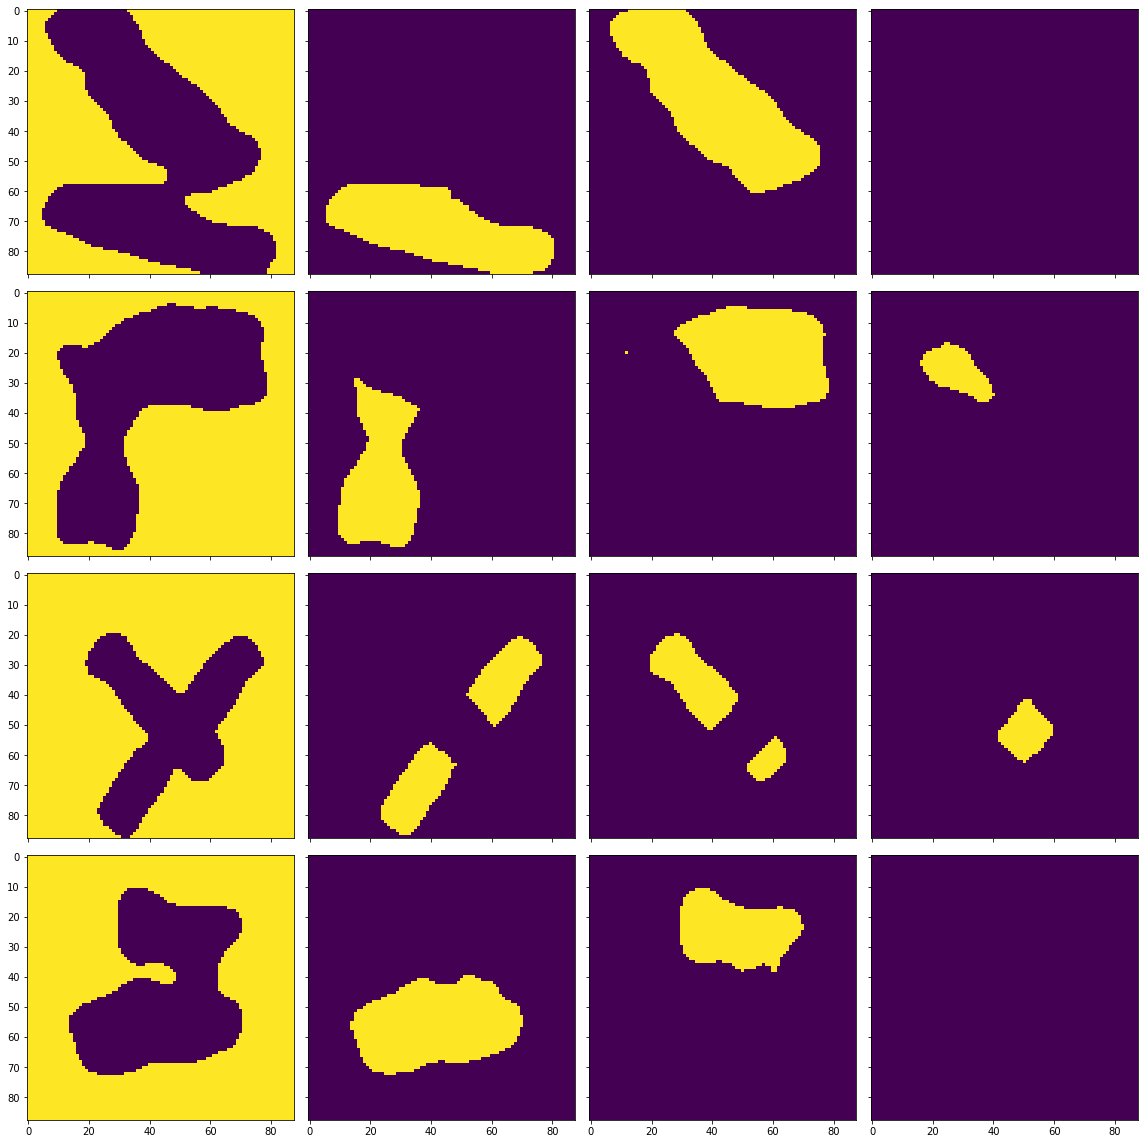

Training IOU: [0.9756335365818058, 0.8717050035025666, 0.882088718749747, 0.7671012201306644]
Training accuracy: 0.9543062370867769
Testing IOU: [0.9733720010545742, 0.4738796805573129, 0.4023016929807875, 0.4850489307720188]
Testing accuracy: 0.8705655991735537
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0726 - val_loss: 0.0523
INFO:tensorflow:Assets written to: modelseg/savedmodel_113epoch\assets
4
4


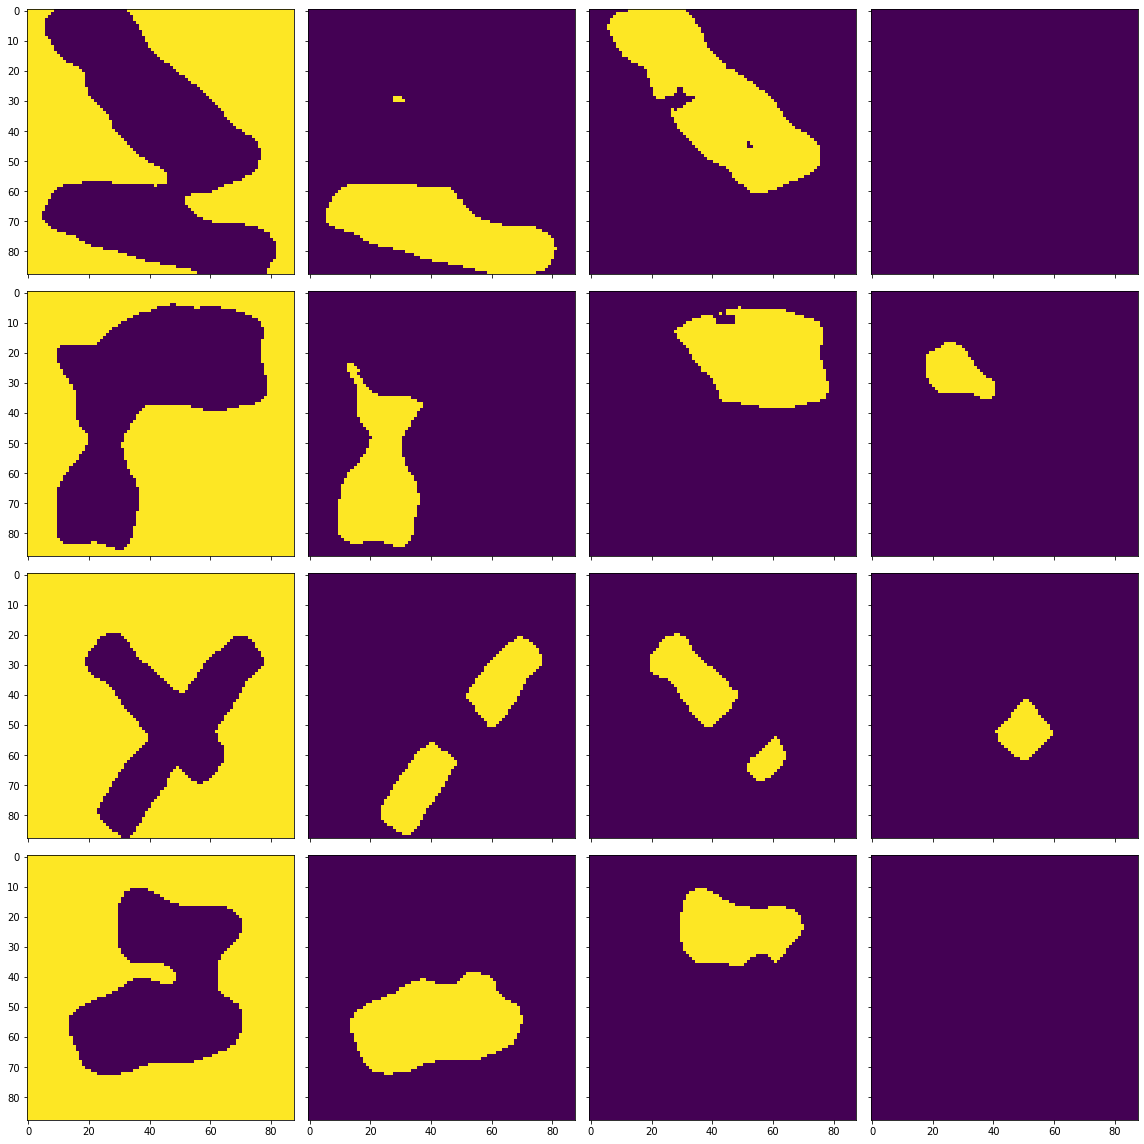

Training IOU: [0.9773513335091373, 0.8769721075374259, 0.8531875069612533, 0.7530460118056607]
Training accuracy: 0.9541877582644628
Testing IOU: [0.9740713894919518, 0.47098212659297745, 0.35953642449204276, 0.49920104887941985]
Testing accuracy: 0.8683367768595042
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0718 - val_loss: 0.0673
INFO:tensorflow:Assets written to: modelseg/savedmodel_114epoch\assets
4
4


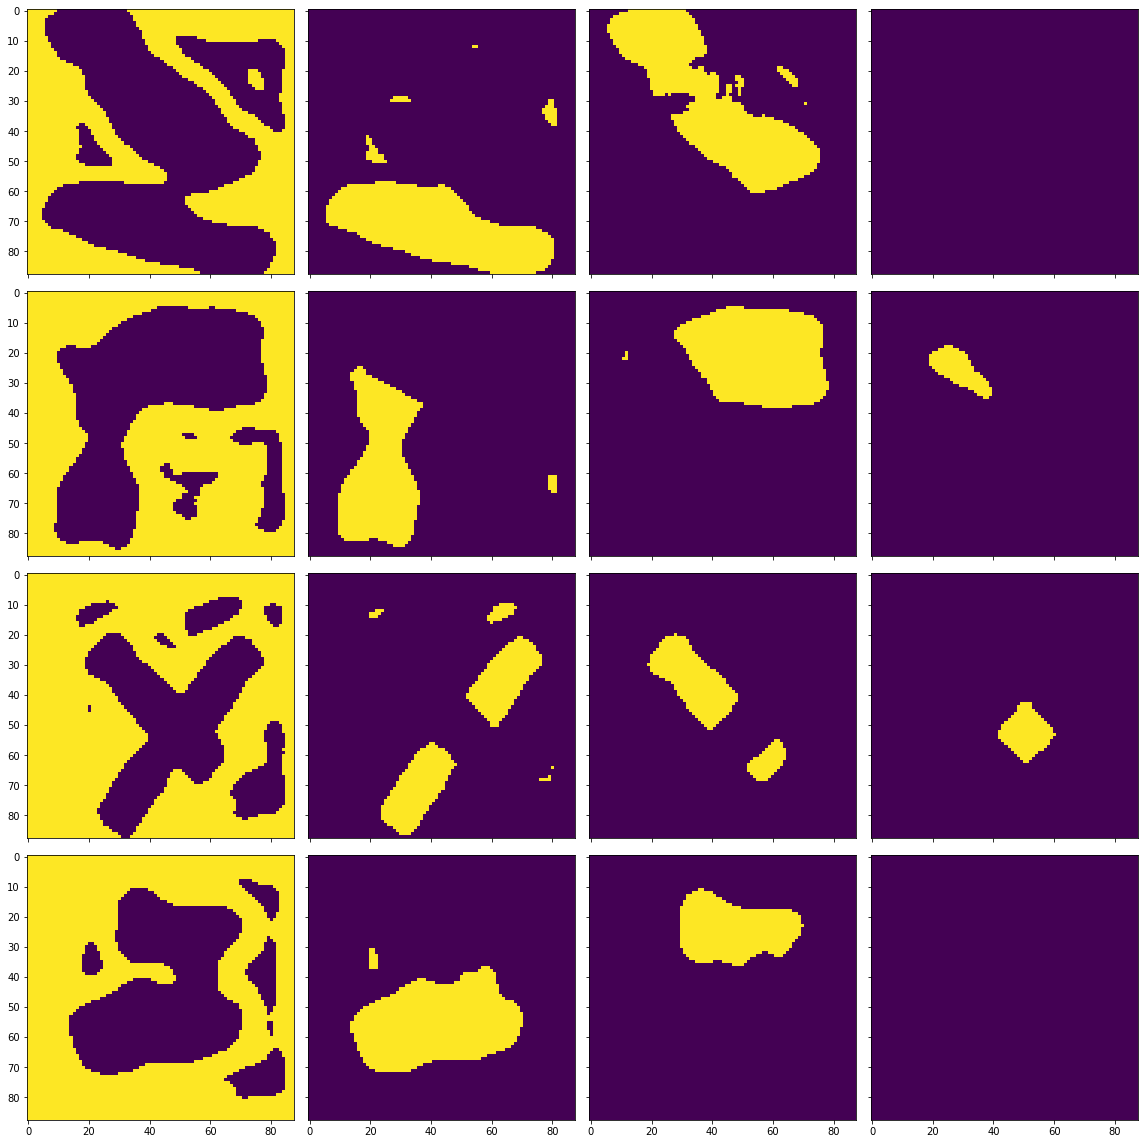

Training IOU: [0.8496810948046318, 0.8527519579998278, 0.8238674725910684, 0.7361594592674535]
Training accuracy: 0.8619334323347108
Testing IOU: [0.843348627854638, 0.5107445120338535, 0.3244294954721863, 0.4777582539535744]
Testing accuracy: 0.7777944214876034
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0715 - val_loss: 0.1027
INFO:tensorflow:Assets written to: modelseg/savedmodel_115epoch\assets
4
4


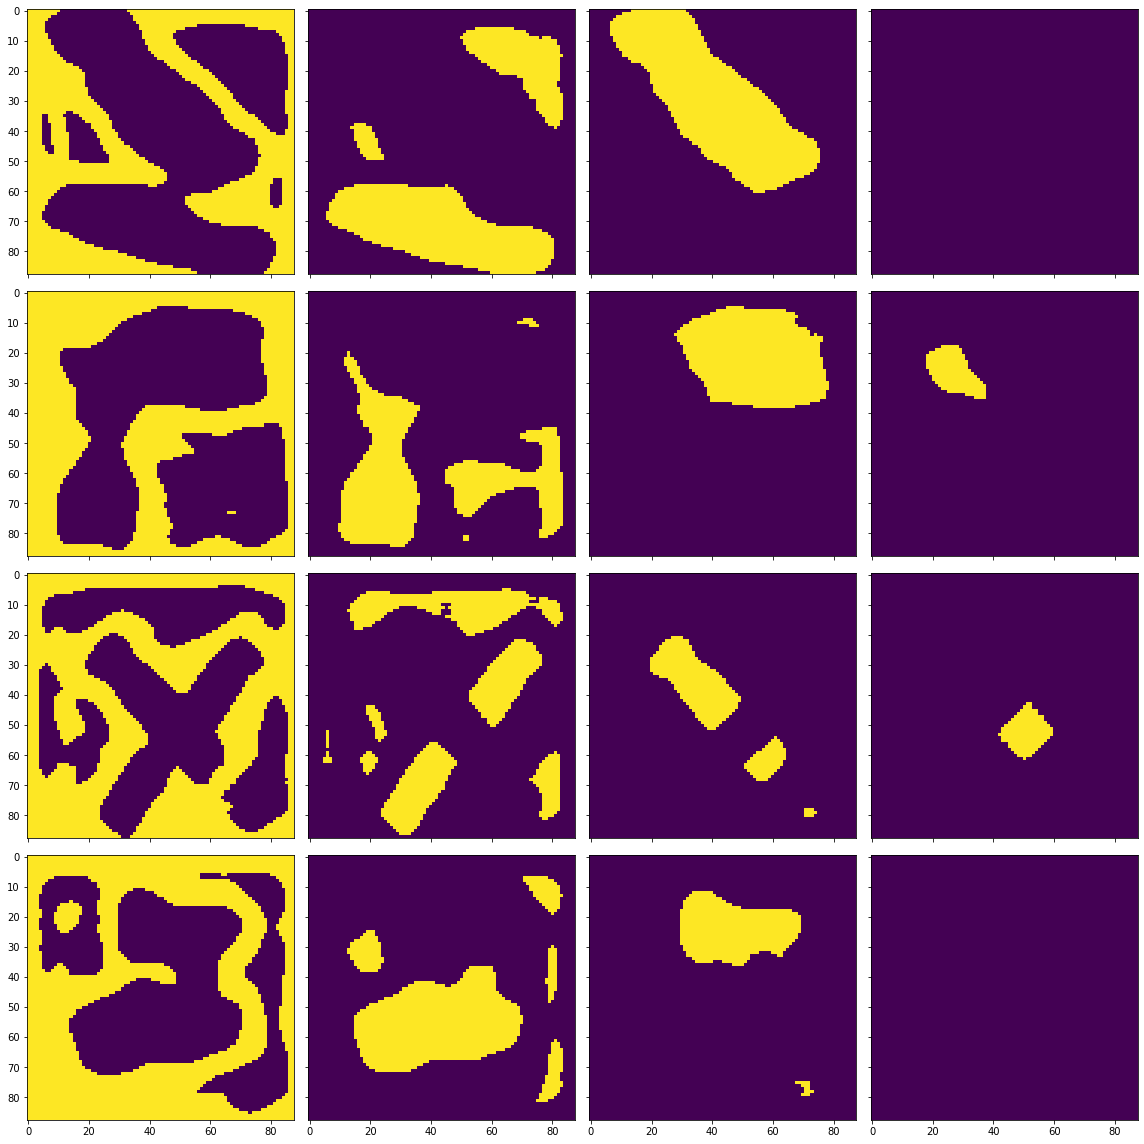

Training IOU: [0.6514863364492676, 0.5224138935125054, 0.8180528859611473, 0.7435763995183575]
Training accuracy: 0.7168998579545455
Testing IOU: [0.6274829193249174, 0.3049597246663179, 0.3365964758061294, 0.4854756550869625]
Testing accuracy: 0.6138623450413223
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0720 - val_loss: 0.0581
INFO:tensorflow:Assets written to: modelseg/savedmodel_116epoch\assets
4
4


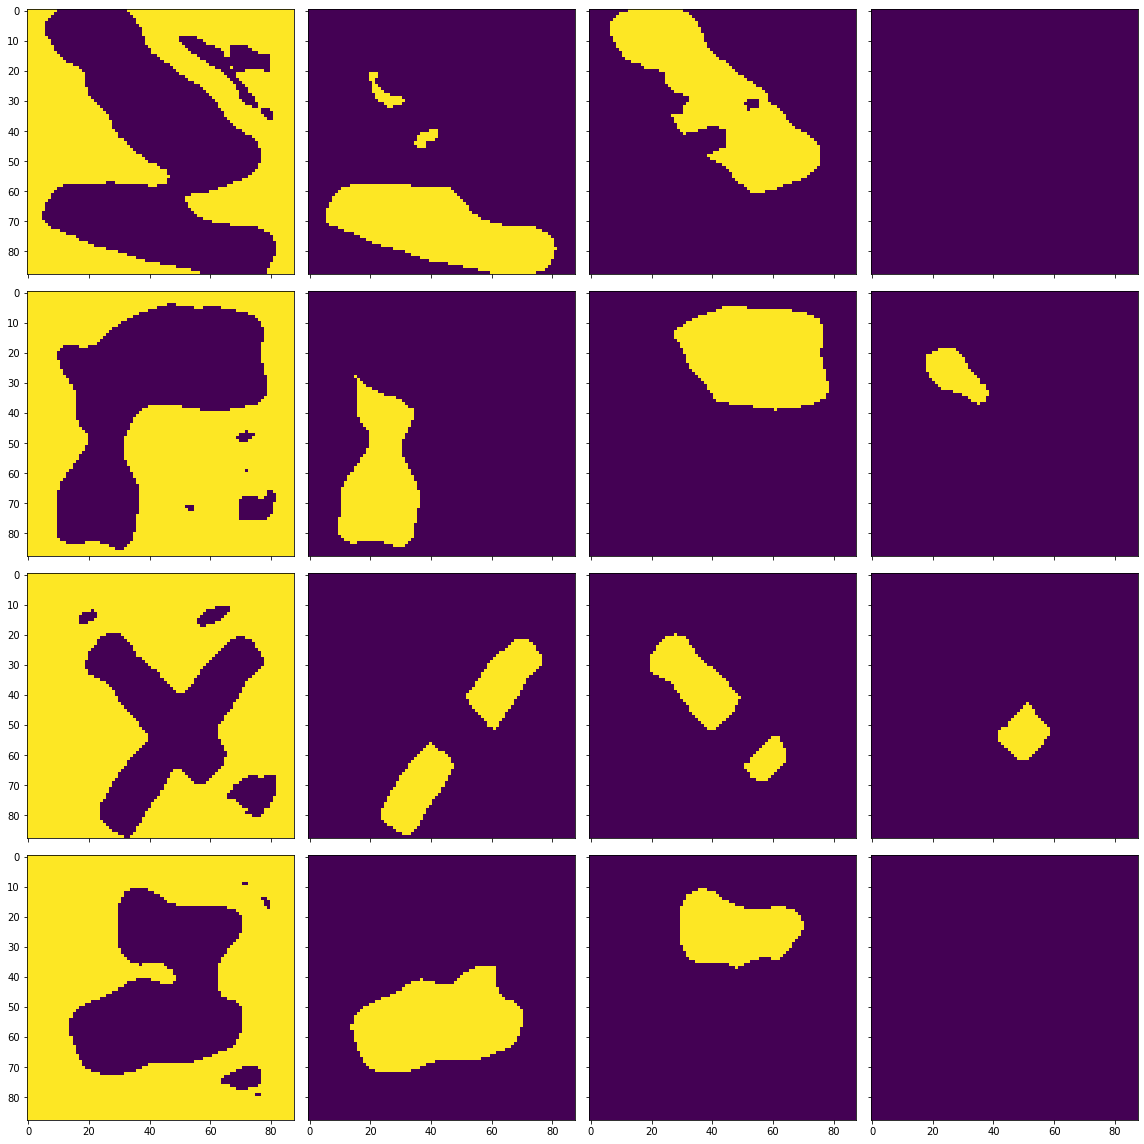

Training IOU: [0.9277895413638216, 0.886451723585274, 0.8728300929748164, 0.699699289229087]
Training accuracy: 0.9197875774793388
Testing IOU: [0.9244204415135112, 0.5197618849156733, 0.3675930781331935, 0.452617462997914]
Testing accuracy: 0.8393414256198347
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0712 - val_loss: 0.0501
INFO:tensorflow:Assets written to: modelseg/savedmodel_117epoch\assets
4
4


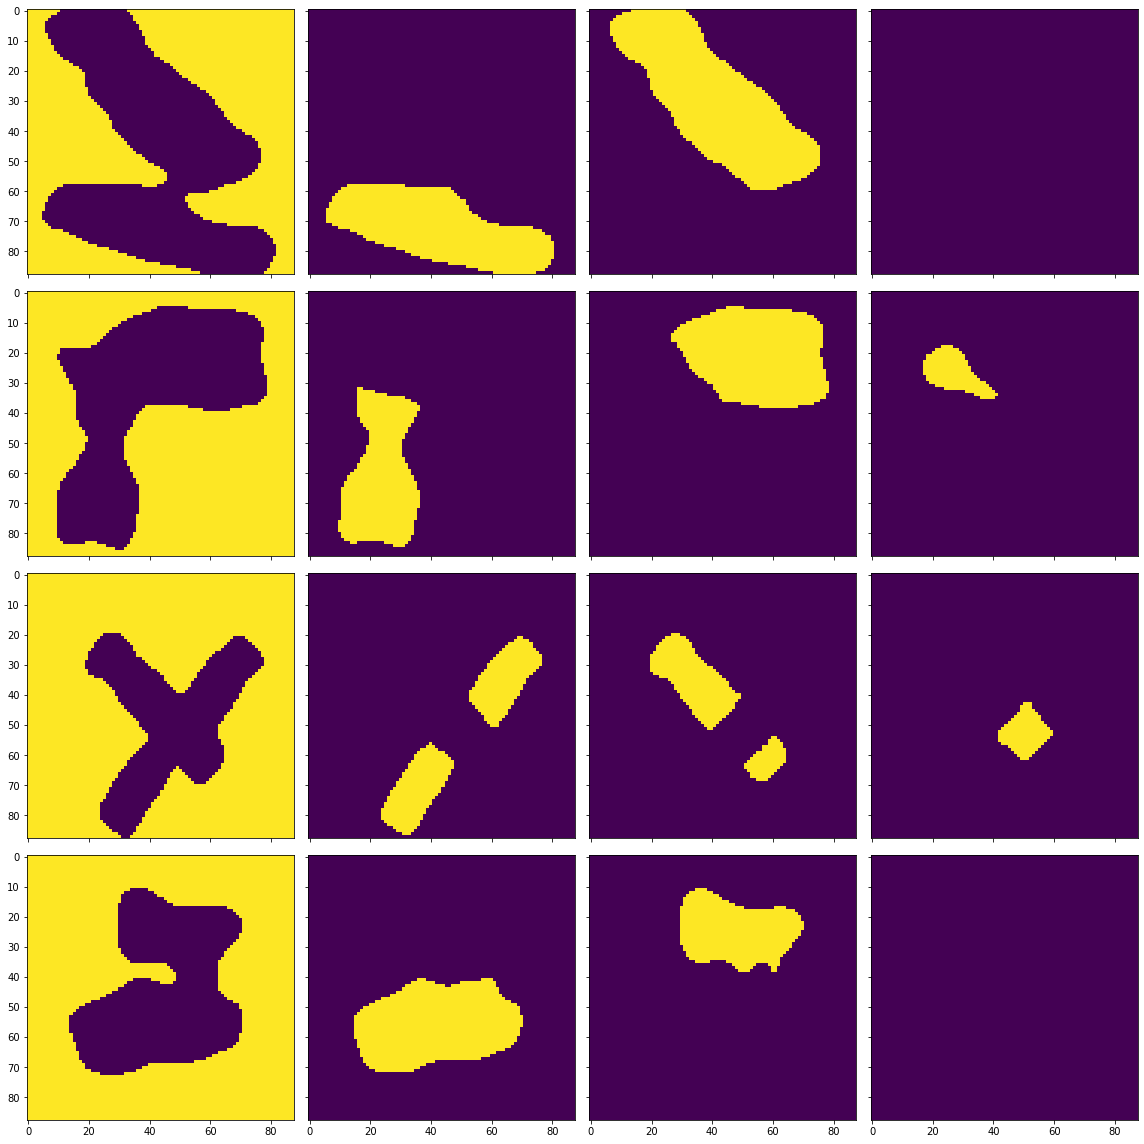

Training IOU: [0.9769347170798302, 0.8755905584362036, 0.8764330173711403, 0.7695714170951157]
Training accuracy: 0.9547756327479339
Testing IOU: [0.9740343964923597, 0.4809972274460541, 0.38513873276933086, 0.4890744667041668]
Testing accuracy: 0.8700723140495867
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0711 - val_loss: 0.0543
INFO:tensorflow:Assets written to: modelseg/savedmodel_118epoch\assets
4
4


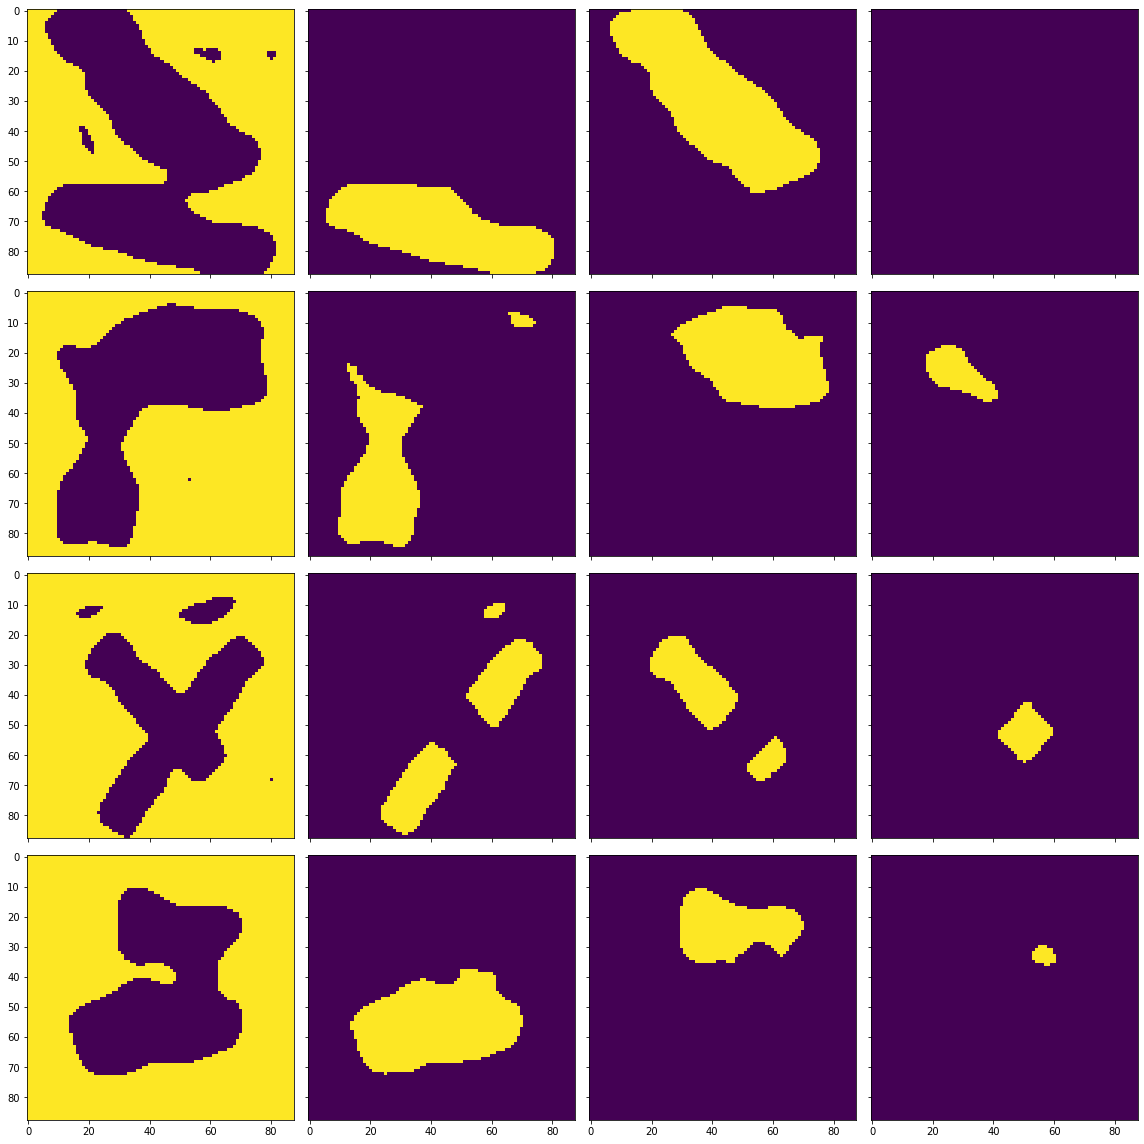

Training IOU: [0.9666365674709675, 0.8851527334107739, 0.864048650603917, 0.7736627580114047]
Training accuracy: 0.9487196539256199
Testing IOU: [0.9616806435349061, 0.5037878522912485, 0.3496772491068529, 0.48889295182374987]
Testing accuracy: 0.8631366219008264
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0707 - val_loss: 0.0587
INFO:tensorflow:Assets written to: modelseg/savedmodel_119epoch\assets
4
4


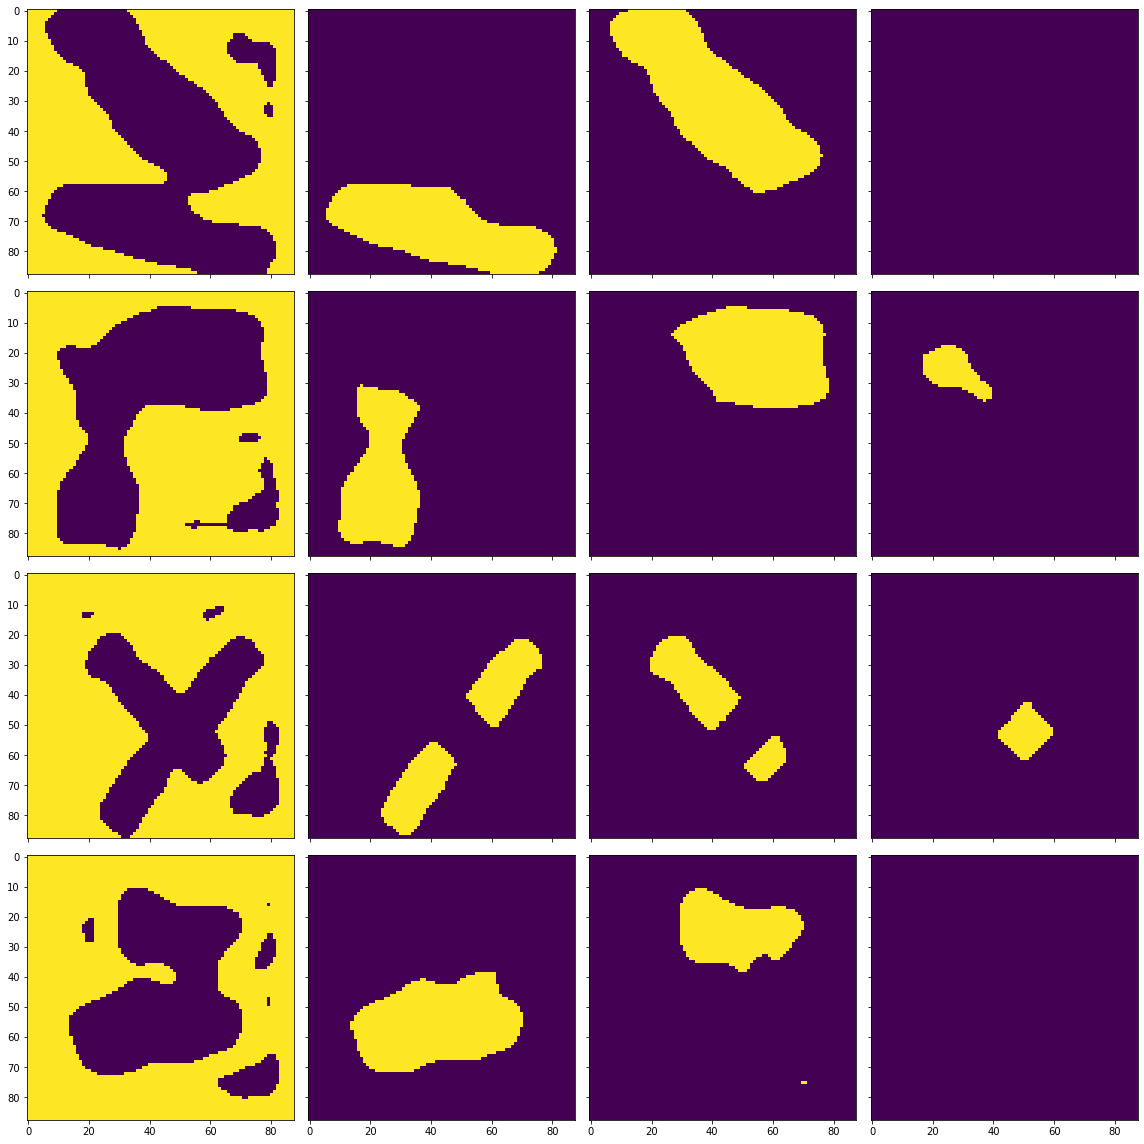

Training IOU: [0.9091158452547378, 0.8975000171906767, 0.8918278816619065, 0.7731406784712302]
Training accuracy: 0.911302298553719
Testing IOU: [0.9058581128704718, 0.4888031000101592, 0.3859317414004914, 0.4918420320756466]
Testing accuracy: 0.8231004648760331
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0709 - val_loss: 0.0497
INFO:tensorflow:Assets written to: modelseg/savedmodel_120epoch\assets
4
4


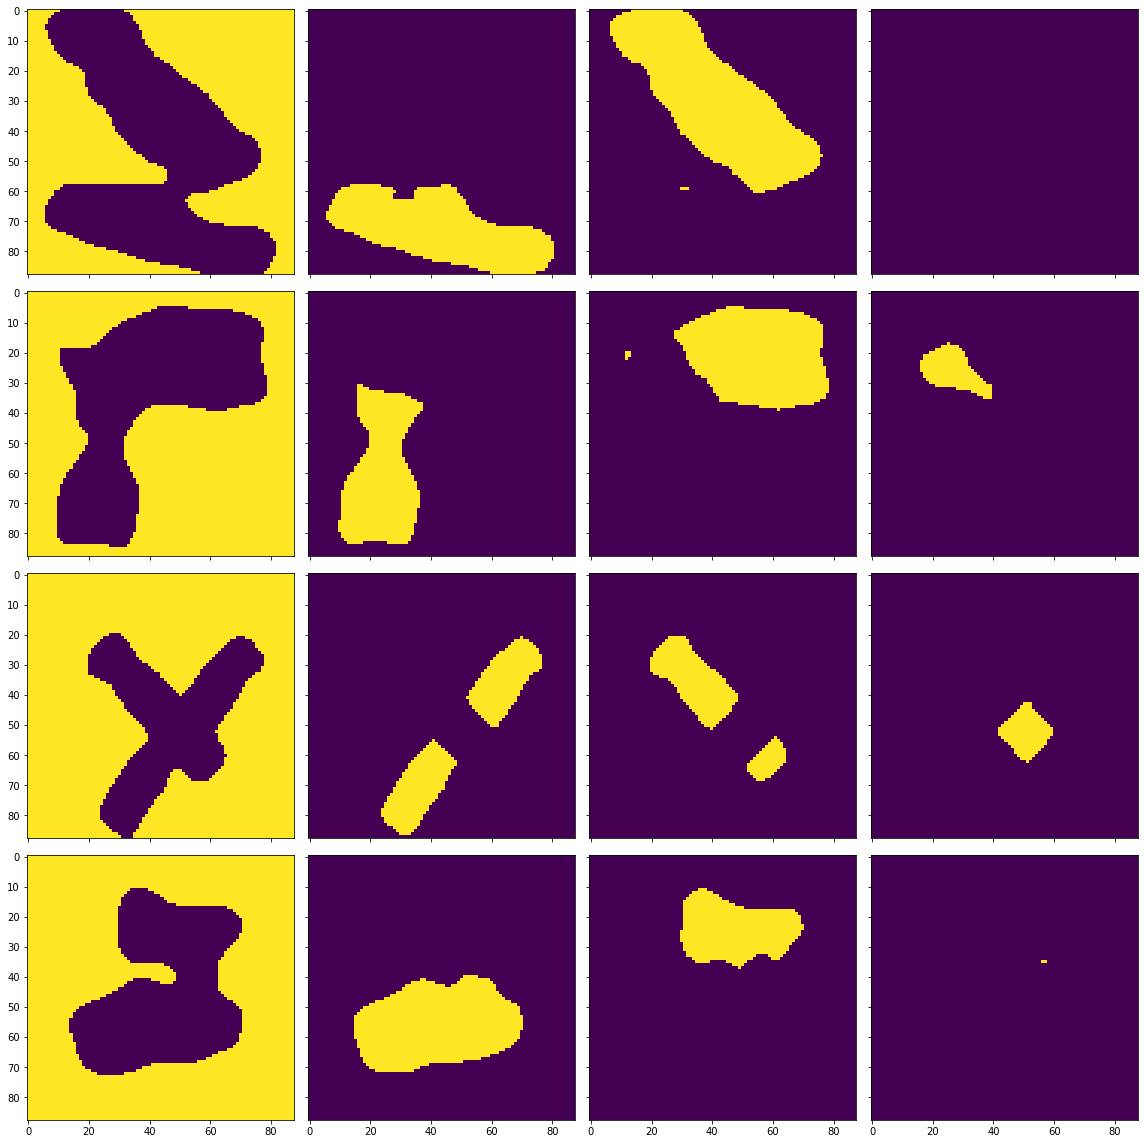

Training IOU: [0.9780617858881957, 0.8945581910190706, 0.8788216114115569, 0.76833179872712]
Training accuracy: 0.9584336260330578
Testing IOU: [0.9743780474845786, 0.483144727229354, 0.3931898675700647, 0.48540179388614313]
Testing accuracy: 0.872419938016529
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0531
INFO:tensorflow:Assets written to: modelseg/savedmodel_121epoch\assets
4
4


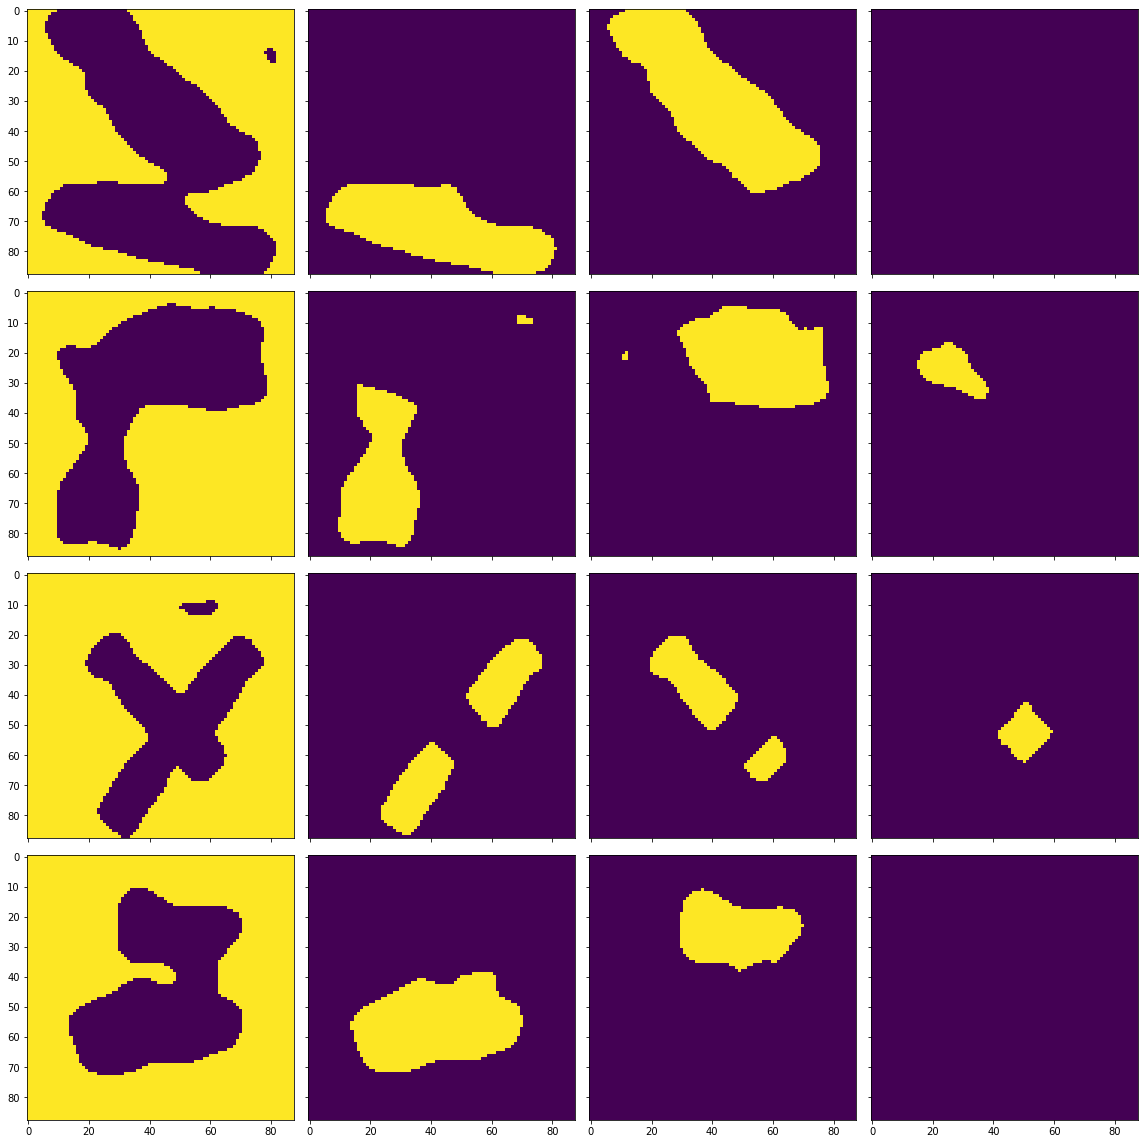

Training IOU: [0.9715145355294245, 0.8934893667577521, 0.8903290941362296, 0.7675583742303003]
Training accuracy: 0.9552760201446281
Testing IOU: [0.967070464600226, 0.5004320913925989, 0.3776866234952922, 0.49103402833341175]
Testing accuracy: 0.8703964359504133
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0707 - val_loss: 0.0513
INFO:tensorflow:Assets written to: modelseg/savedmodel_122epoch\assets
4
4


Training IOU: [0.9774385849336867, 0.8961222985115893, 0.9023097453963514, 0.7375668577140244]
Training accuracy: 0.9595896823347108
Testing IOU: [0.9742384430429848, 0.45261703204174564, 0.4152899197145406, 0.4597668058154599]
Testing accuracy: 0.8714178719008264
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0708 - val_loss: 0.0520
INFO:tensorflow:Assets written to: modelseg/savedmodel_123epoch\assets
4
4


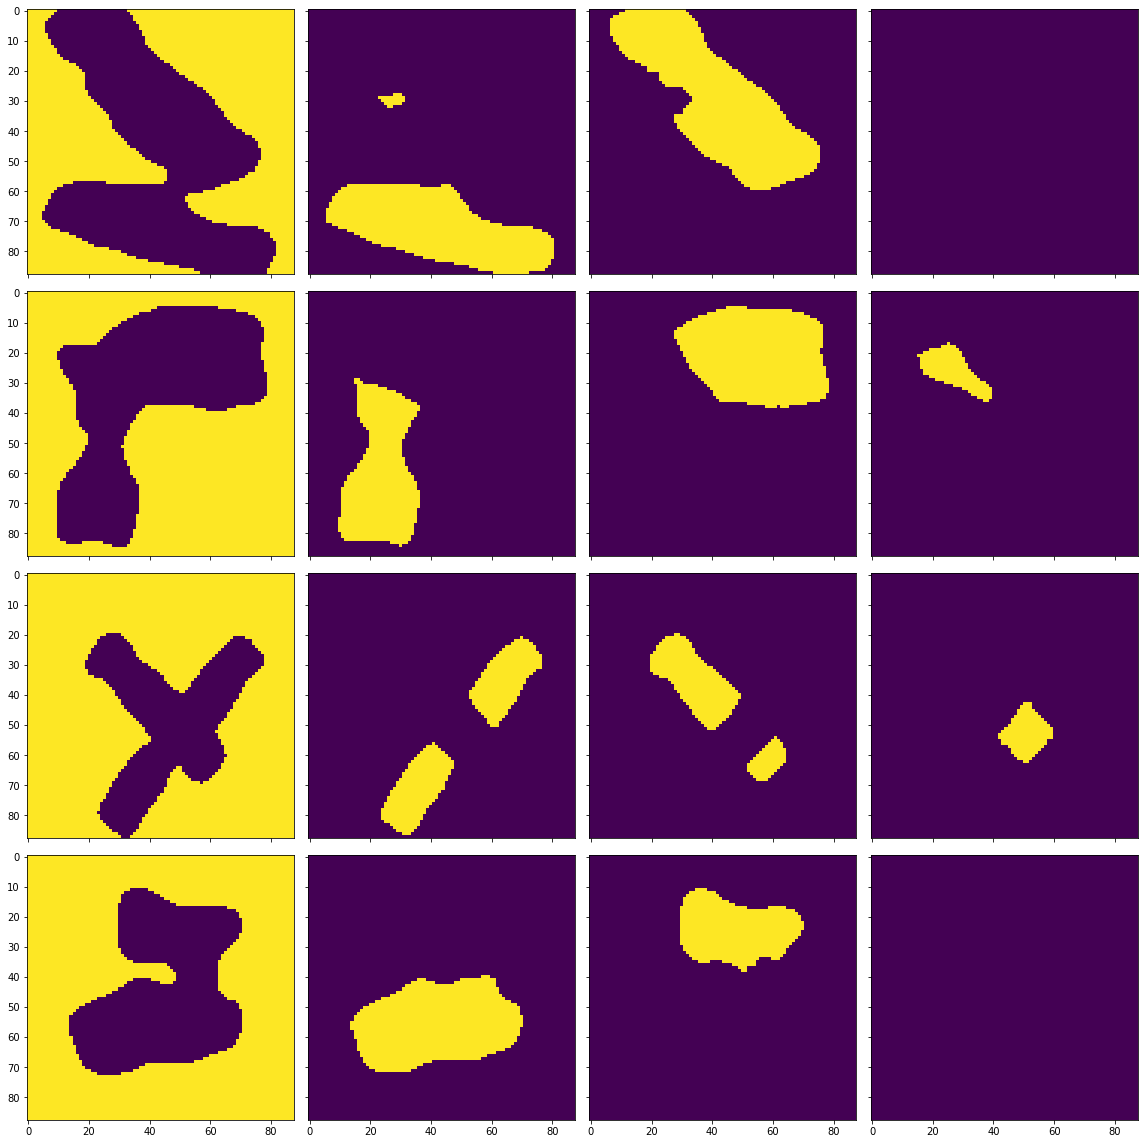

Training IOU: [0.9776812590224649, 0.8804312083353454, 0.8651414433886601, 0.7885777588747885]
Training accuracy: 0.9556488894628099
Testing IOU: [0.9742169997995102, 0.5129637688279967, 0.3335201851909522, 0.48721300759866004]
Testing accuracy: 0.872862861570248
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0708 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_124epoch\assets
4
4


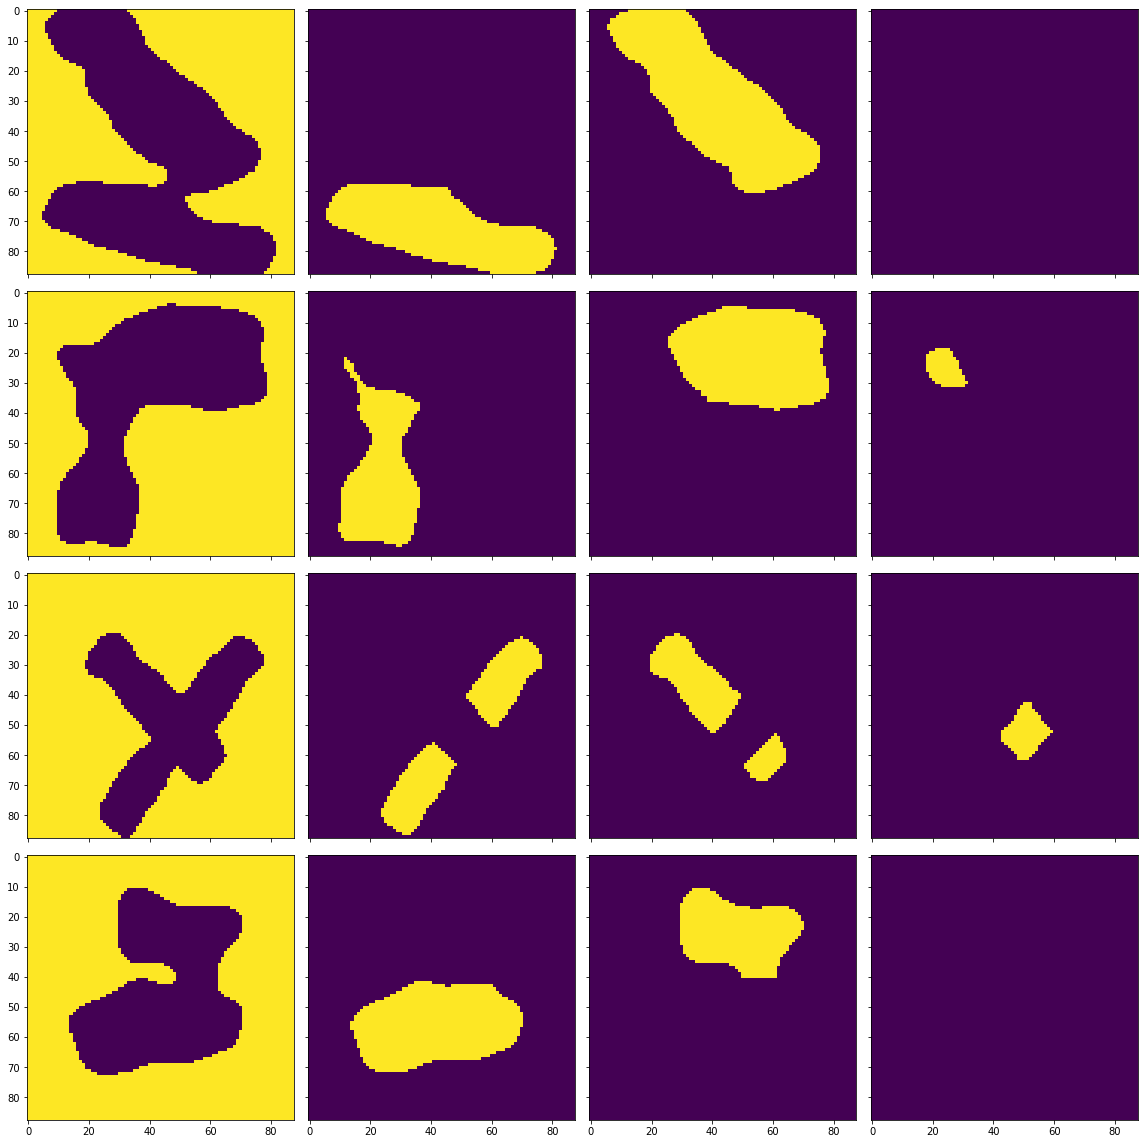

Training IOU: [0.9749513428826011, 0.8899726720460882, 0.9049983307738533, 0.7313706379642774]
Training accuracy: 0.9576798166322315
Testing IOU: [0.97144959221175, 0.49531824195207996, 0.4058688770805806, 0.46936651369636184]
Testing accuracy: 0.874505423553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0709 - val_loss: 0.0510
INFO:tensorflow:Assets written to: modelseg/savedmodel_125epoch\assets
4
4


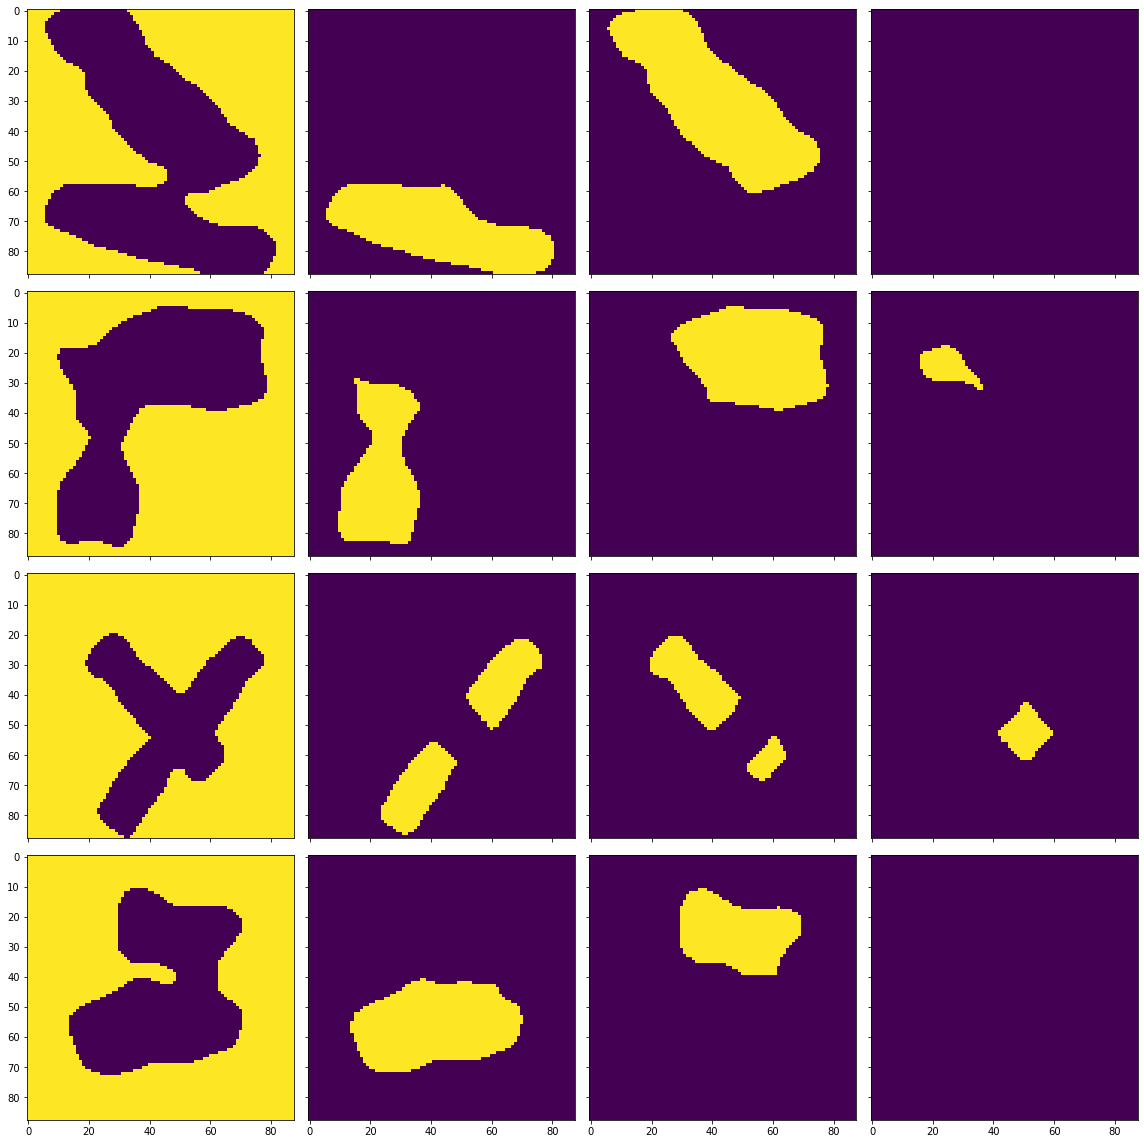

Training IOU: [0.9783952817436566, 0.8966962887927065, 0.8982365768271369, 0.7675753228120517]
Training accuracy: 0.9609223269628099
Testing IOU: [0.9745420406428588, 0.46156628957741386, 0.4197868910045666, 0.4795123117379871]
Testing accuracy: 0.8747210743801653
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0708 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_126epoch\assets
4
4


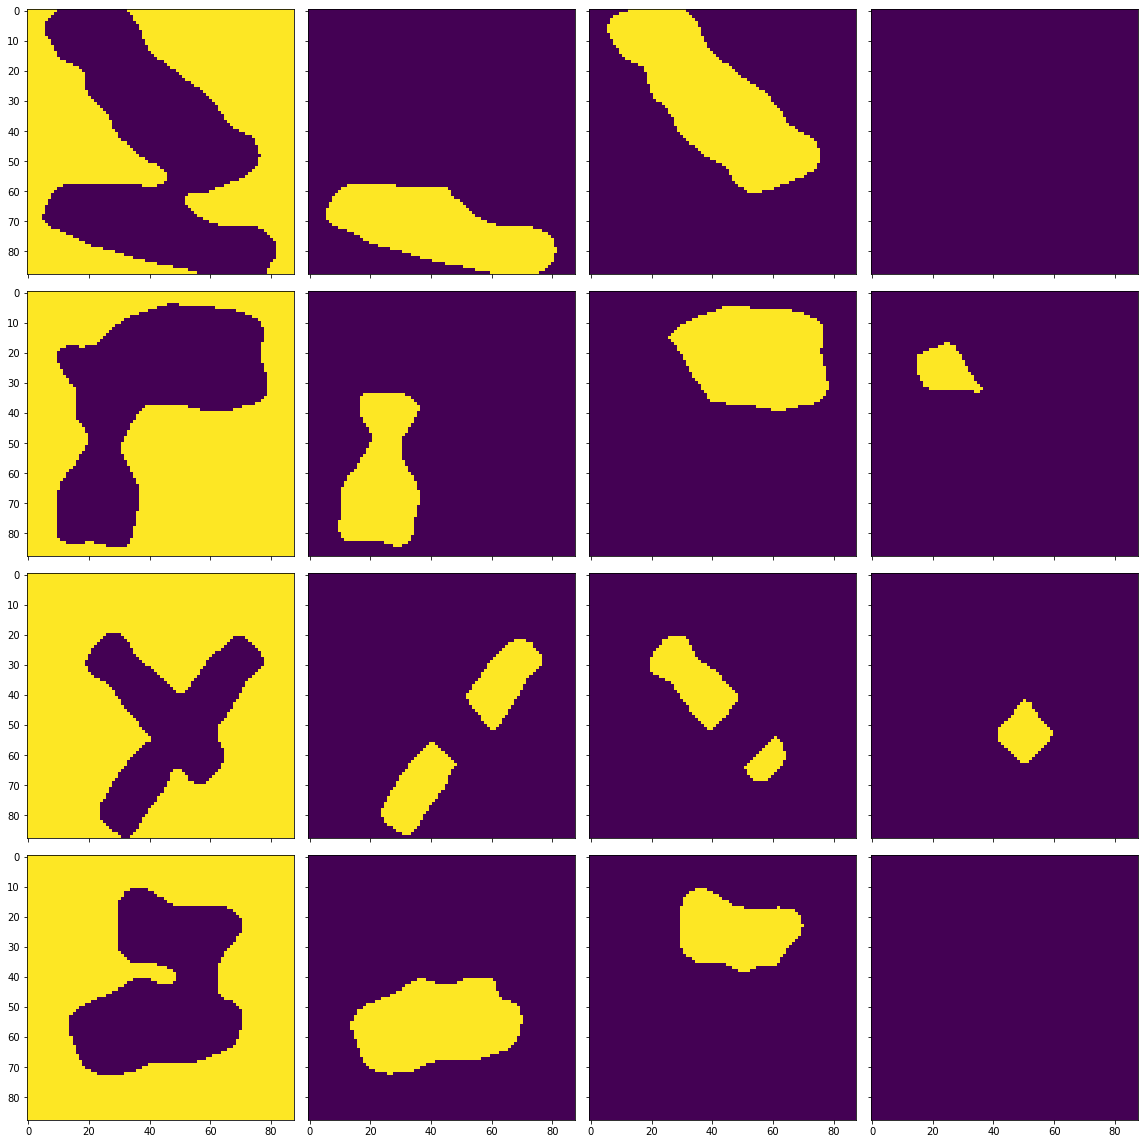

Training IOU: [0.9760890846135142, 0.8985439356677206, 0.8891682727463011, 0.7908935720527567]
Training accuracy: 0.9594289127066116
Testing IOU: [0.9722101129590816, 0.5116459738001226, 0.3703952918491142, 0.48814554512699615]
Testing accuracy: 0.8744666838842975
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0704 - val_loss: 0.0556
INFO:tensorflow:Assets written to: modelseg/savedmodel_127epoch\assets
4
4


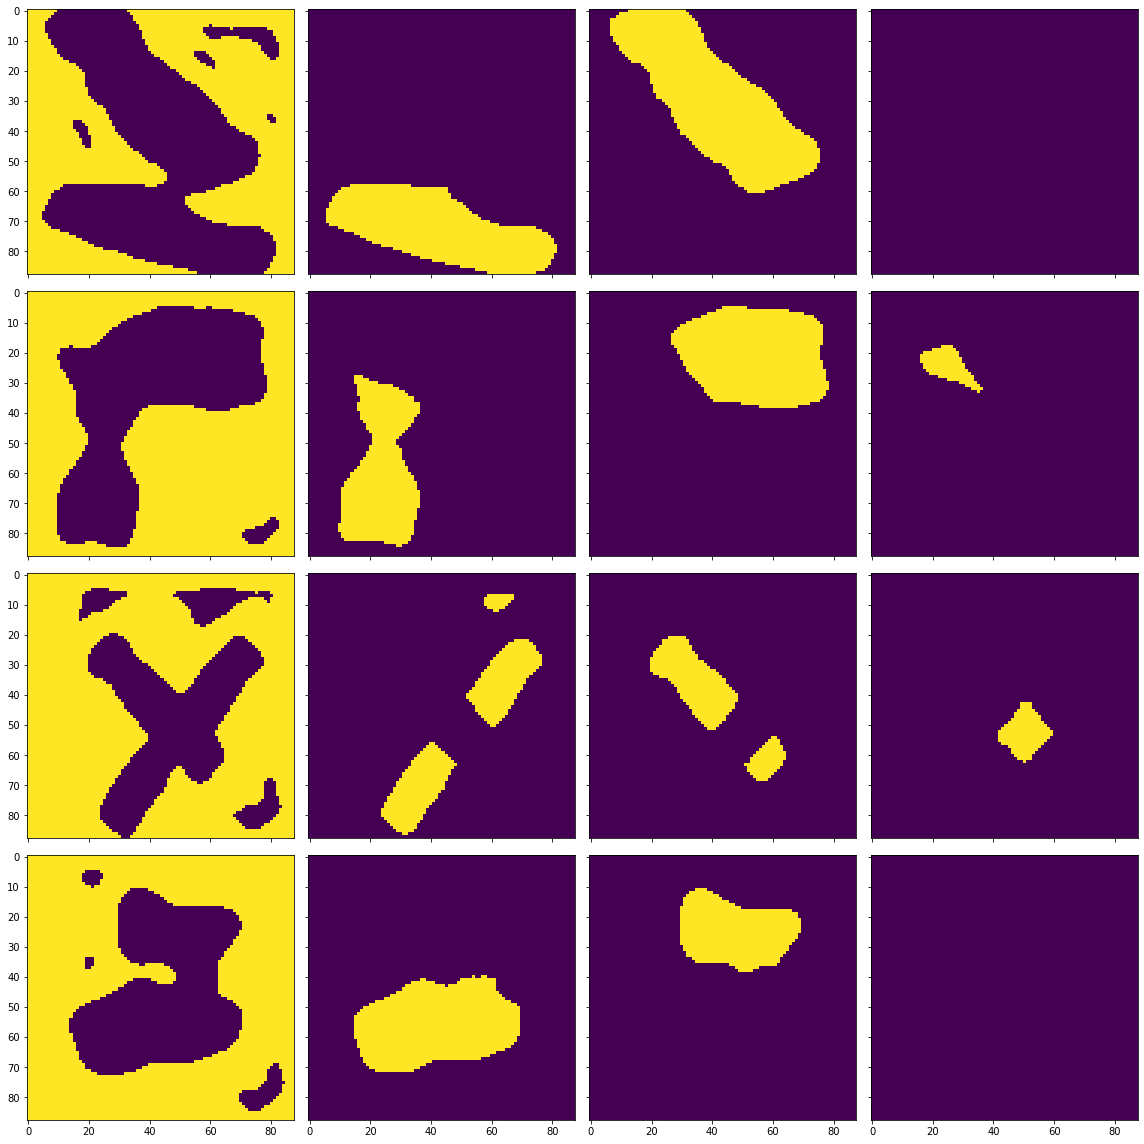

Training IOU: [0.9413895363715445, 0.88430163628846, 0.9008410296505031, 0.794909763998149]
Training accuracy: 0.9351620609504132
Testing IOU: [0.9355813904890604, 0.5019906575637801, 0.39496705800762866, 0.4975515521811402]
Testing accuracy: 0.8497481921487603
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0702 - val_loss: 0.0500
INFO:tensorflow:Assets written to: modelseg/savedmodel_128epoch\assets
4
4


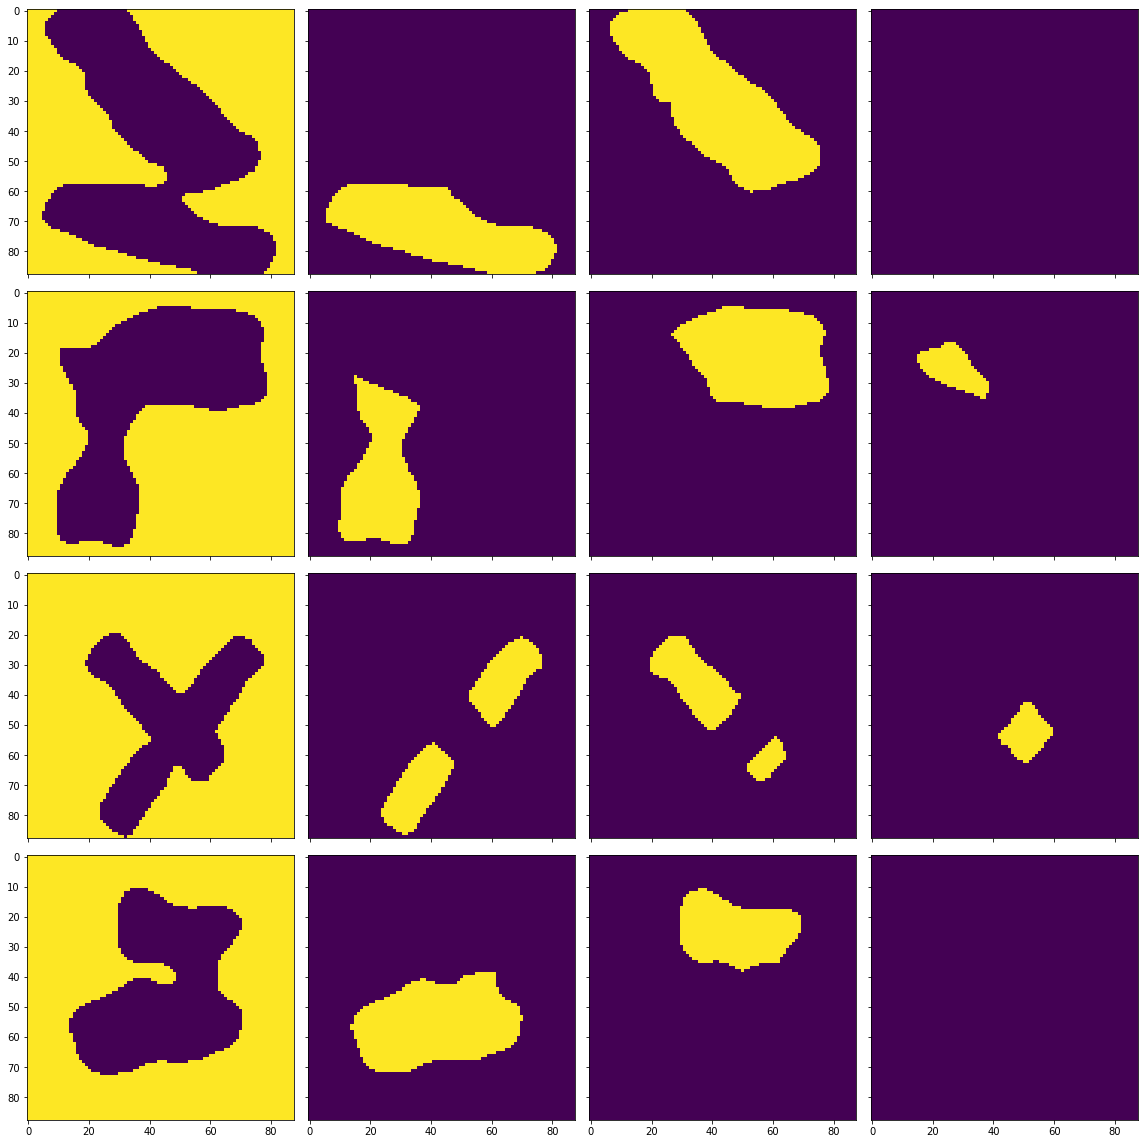

Training IOU: [0.9785509114450863, 0.8927747388668741, 0.8985634169028335, 0.7993535146228835]
Training accuracy: 0.9613303848140495
Testing IOU: [0.9741060934520855, 0.49138957050707494, 0.3903100813024, 0.4886137519345567]
Testing accuracy: 0.874688791322314
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_129epoch\assets
4
4


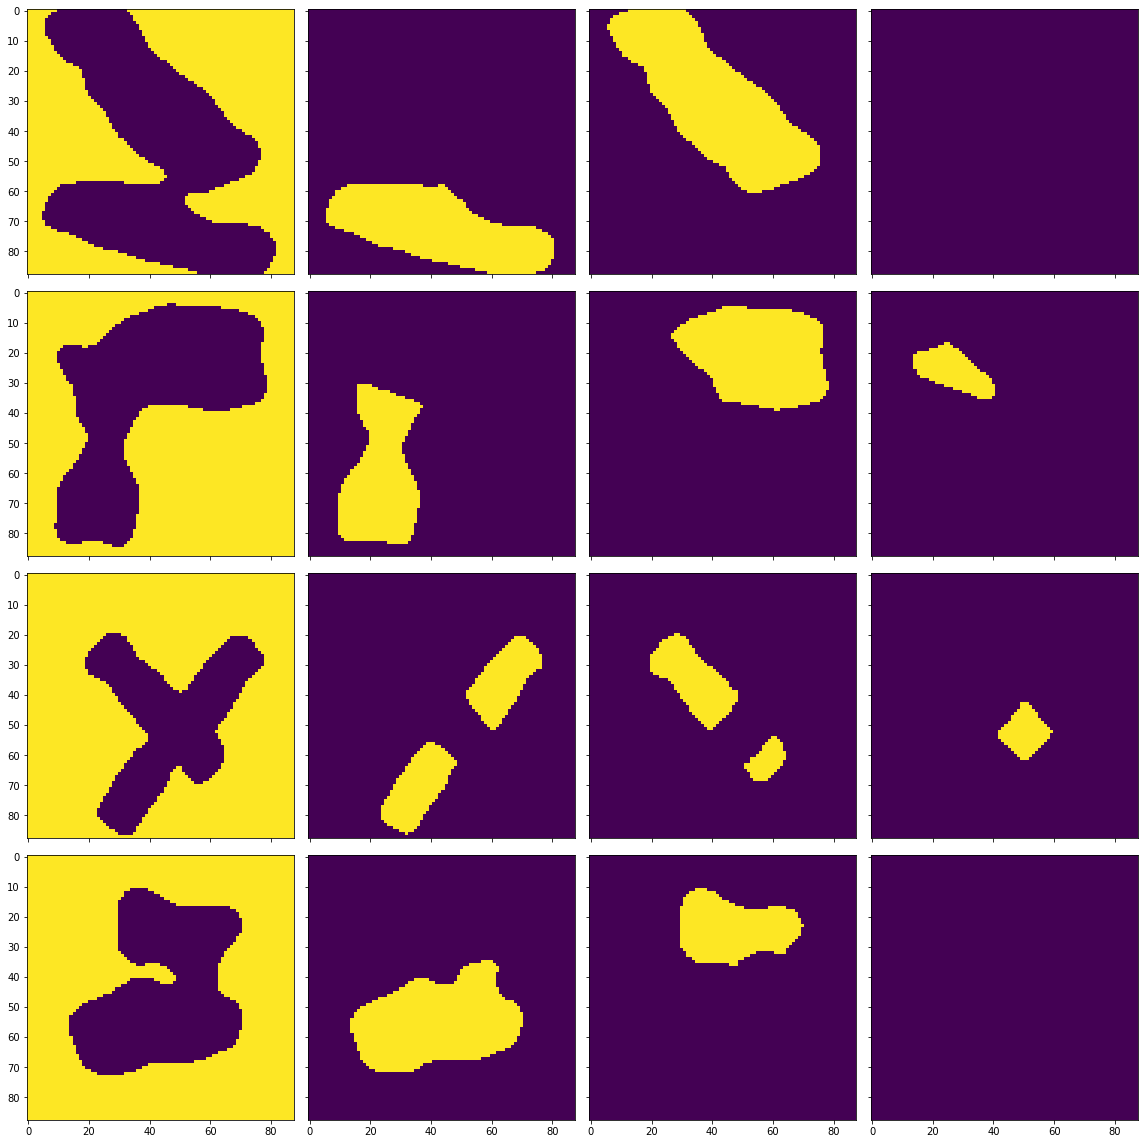

Training IOU: [0.9753395009298133, 0.9101408938308272, 0.8892923981214639, 0.7889308227841593]
Training accuracy: 0.9601058884297521
Testing IOU: [0.9727347226906027, 0.5320035479279688, 0.35640777099488535, 0.49866376772206367]
Testing accuracy: 0.8776394628099173
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0708 - val_loss: 0.0511
INFO:tensorflow:Assets written to: modelseg/savedmodel_130epoch\assets
4
4


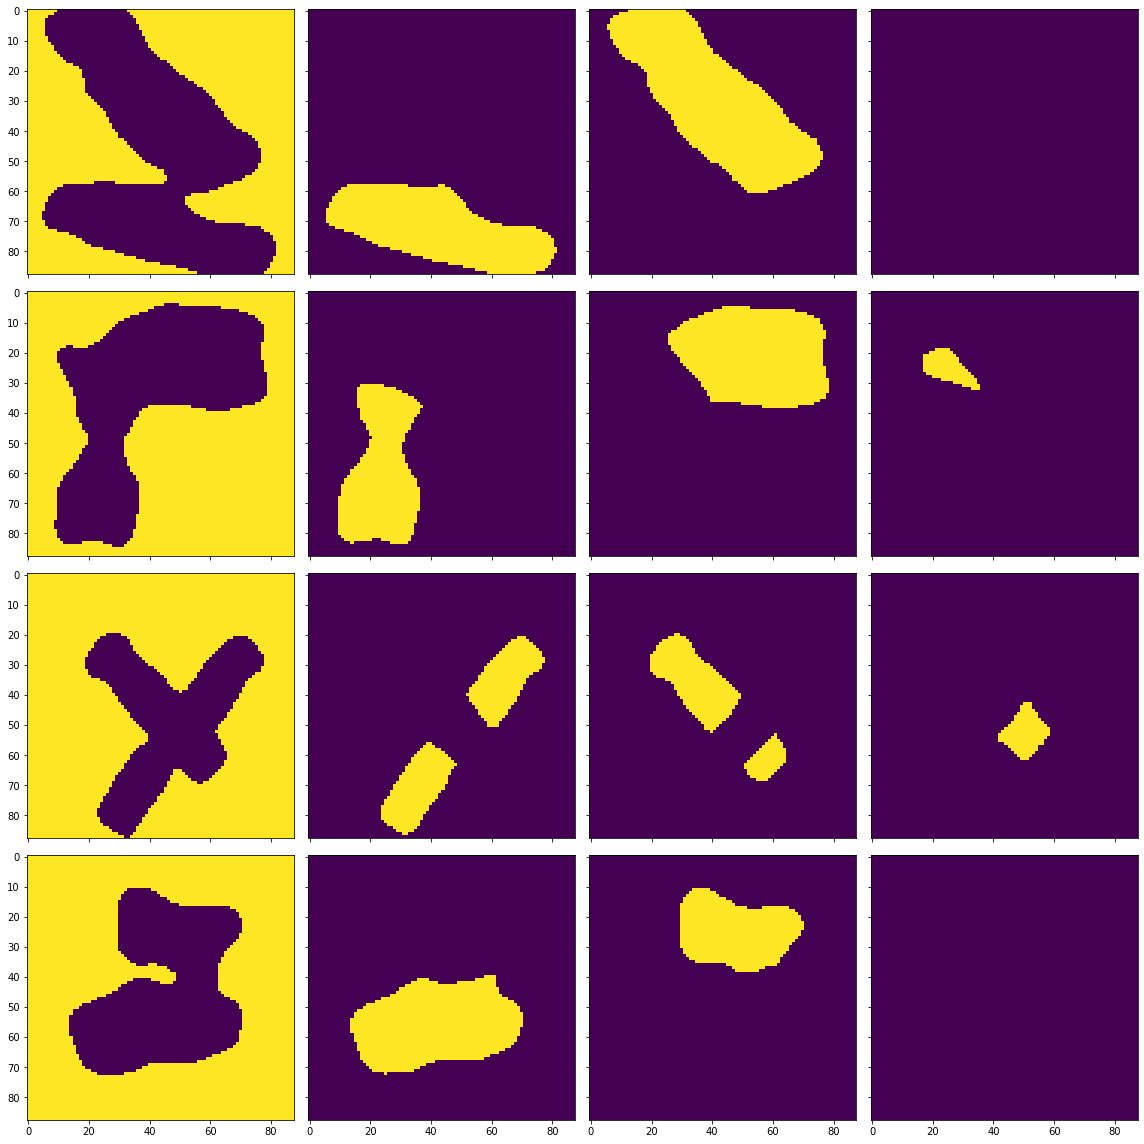

Training IOU: [0.974753930171153, 0.9068535035340413, 0.9089295829854409, 0.7397655506993941]
Training accuracy: 0.9596913739669422
Testing IOU: [0.9727343610686676, 0.5130013723078236, 0.3916890853189854, 0.4699065980720244]
Testing accuracy: 0.876457902892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0706 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_131epoch\assets
4
4


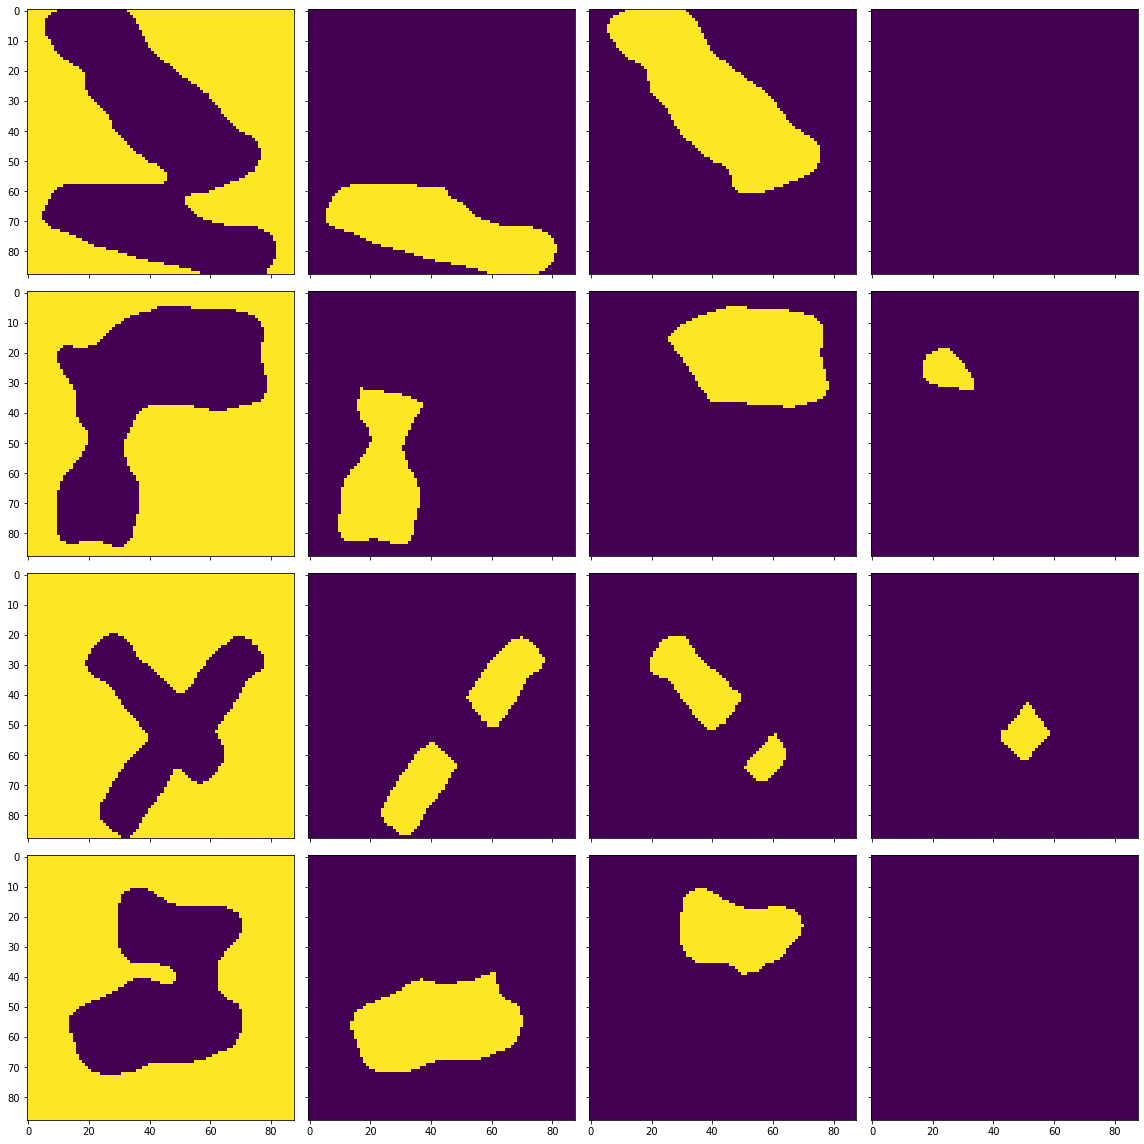

Training IOU: [0.9776138459101278, 0.9007221658129214, 0.8899526061222502, 0.6900565311781269]
Training accuracy: 0.9576326833677686
Testing IOU: [0.974241134652816, 0.5103702565678292, 0.3688955821303663, 0.4246629659000793]
Testing accuracy: 0.8748347107438017
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0702 - val_loss: 0.0499
INFO:tensorflow:Assets written to: modelseg/savedmodel_132epoch\assets
4
4


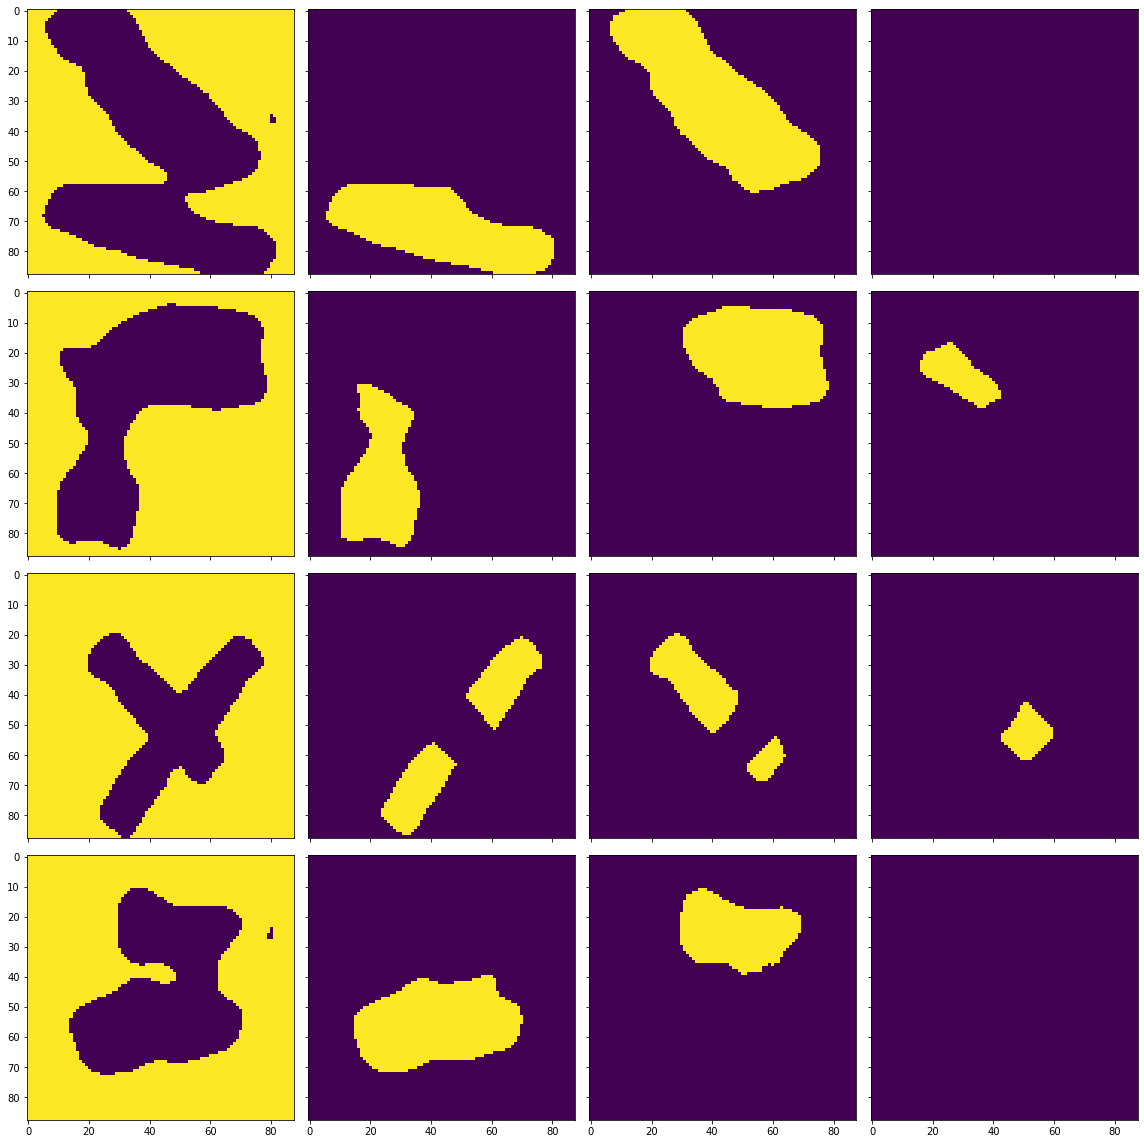

Training IOU: [0.9772561212313557, 0.8761495410995291, 0.8626542330089181, 0.7702521378647388]
Training accuracy: 0.954739152892562
Testing IOU: [0.9729470332487946, 0.5236176735290808, 0.35565815101456144, 0.4669417897480452]
Testing accuracy: 0.8759000516528925
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0703 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_133epoch\assets
4
4


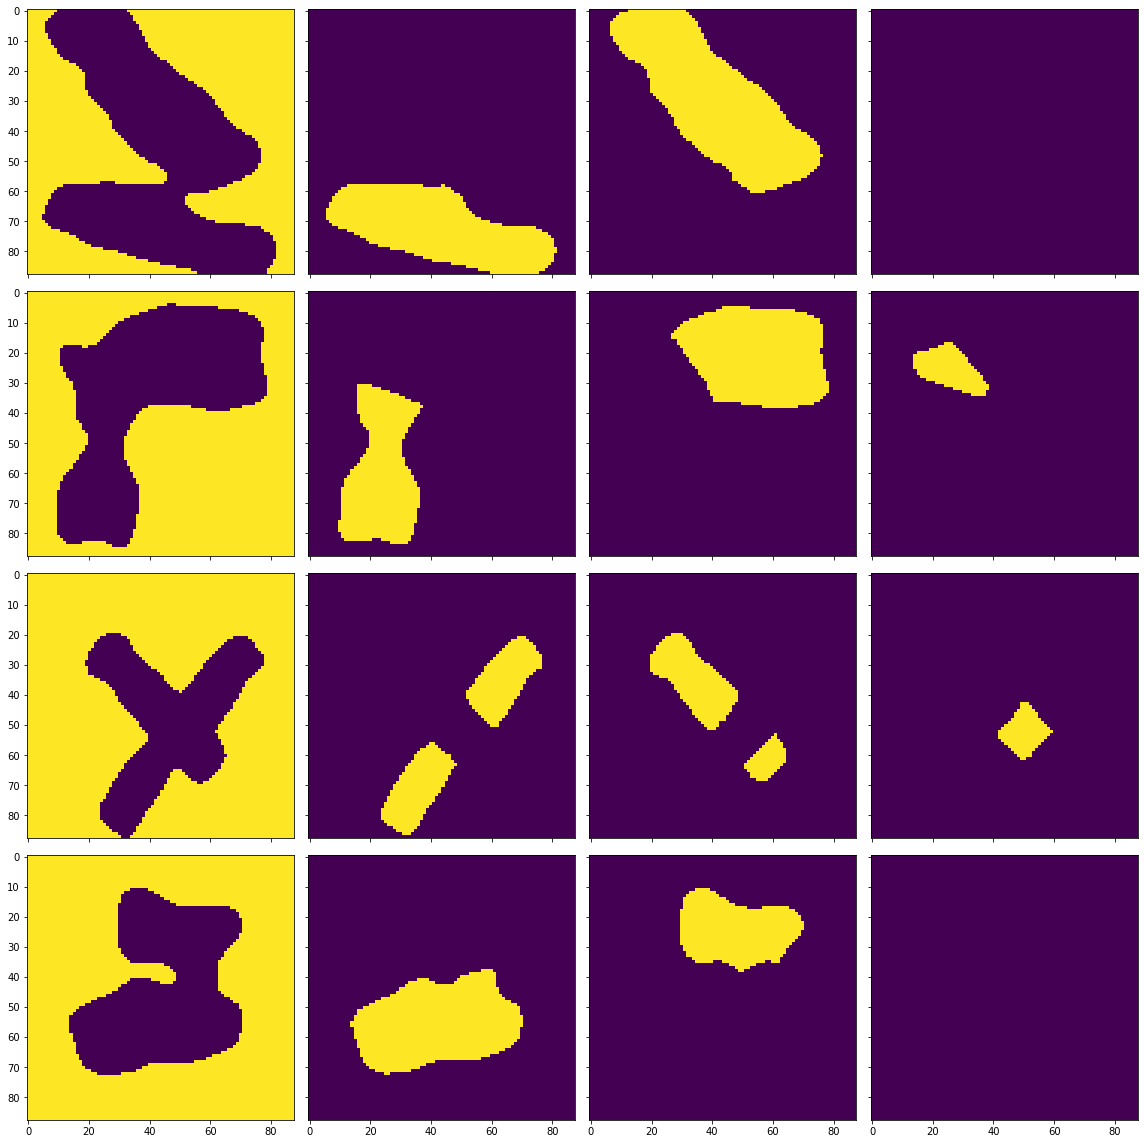

Training IOU: [0.9772630830224823, 0.9095946293203135, 0.9087095263743372, 0.759104772633078]
Training accuracy: 0.9620134943181818
Testing IOU: [0.9738635768754254, 0.5041065092914603, 0.3733601625535105, 0.4830724777269444]
Testing accuracy: 0.8751639979338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0700 - val_loss: 0.0545
INFO:tensorflow:Assets written to: modelseg/savedmodel_134epoch\assets
4
4


Training IOU: [0.9464612524155408, 0.8978159575964236, 0.8939232856404721, 0.8085723460012637]
Training accuracy: 0.9385953641528926
Testing IOU: [0.9424900080005717, 0.506217958479265, 0.39111207414484245, 0.4950539771444058]
Testing accuracy: 0.8538171487603305
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0703 - val_loss: 0.0527
INFO:tensorflow:Assets written to: modelseg/savedmodel_135epoch\assets
4
4


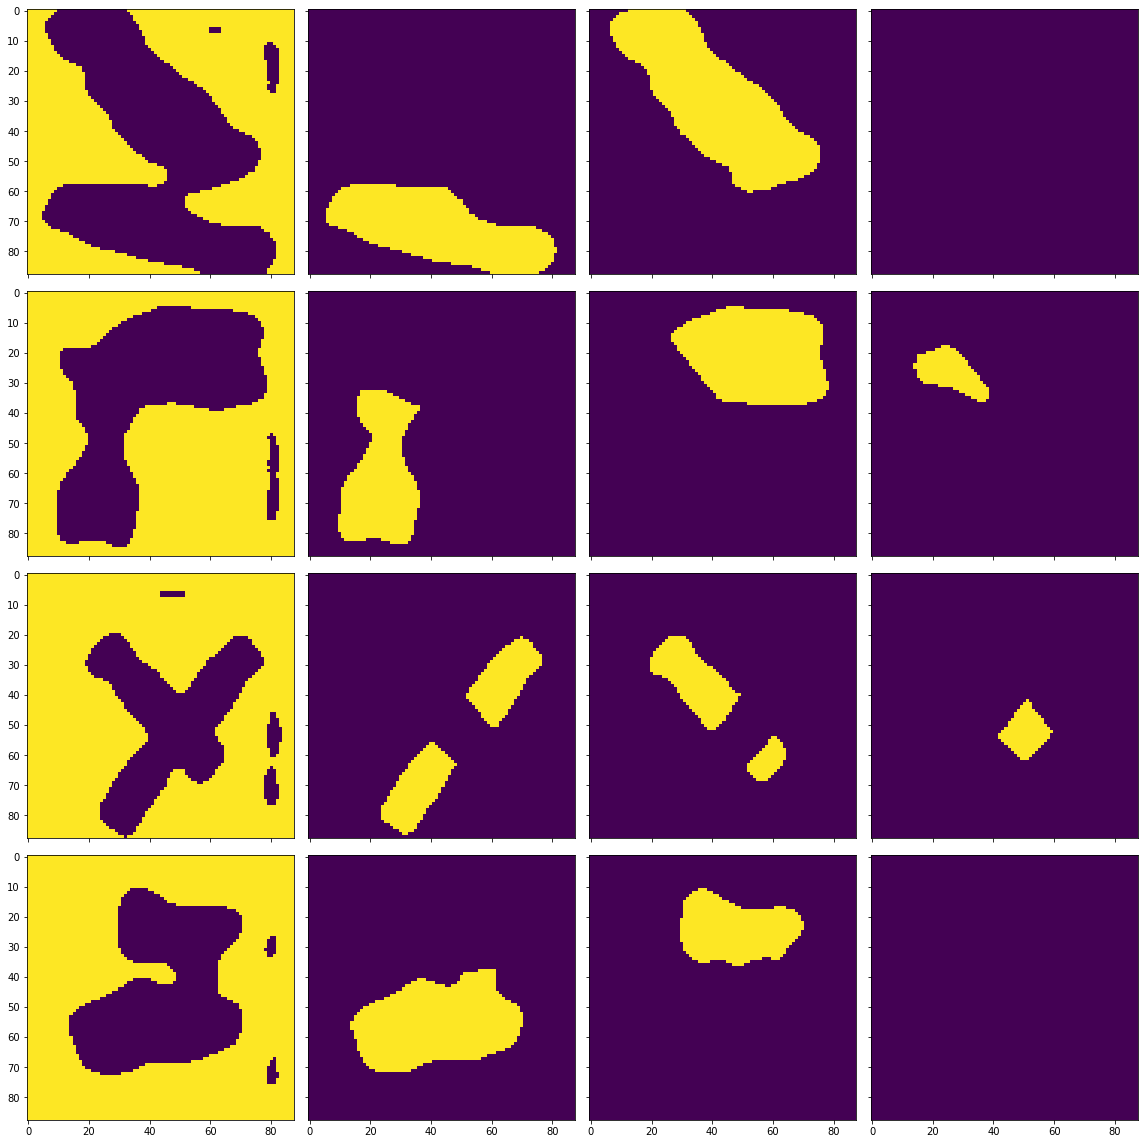

Training IOU: [0.9568566687693824, 0.8977638500588582, 0.881764089157578, 0.7918040802738215]
Training accuracy: 0.9441512784090909
Testing IOU: [0.952341051186596, 0.5216642337786326, 0.35039045597840646, 0.4925501953302444]
Testing accuracy: 0.8612319214876033
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0701 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_136epoch\assets
4
4


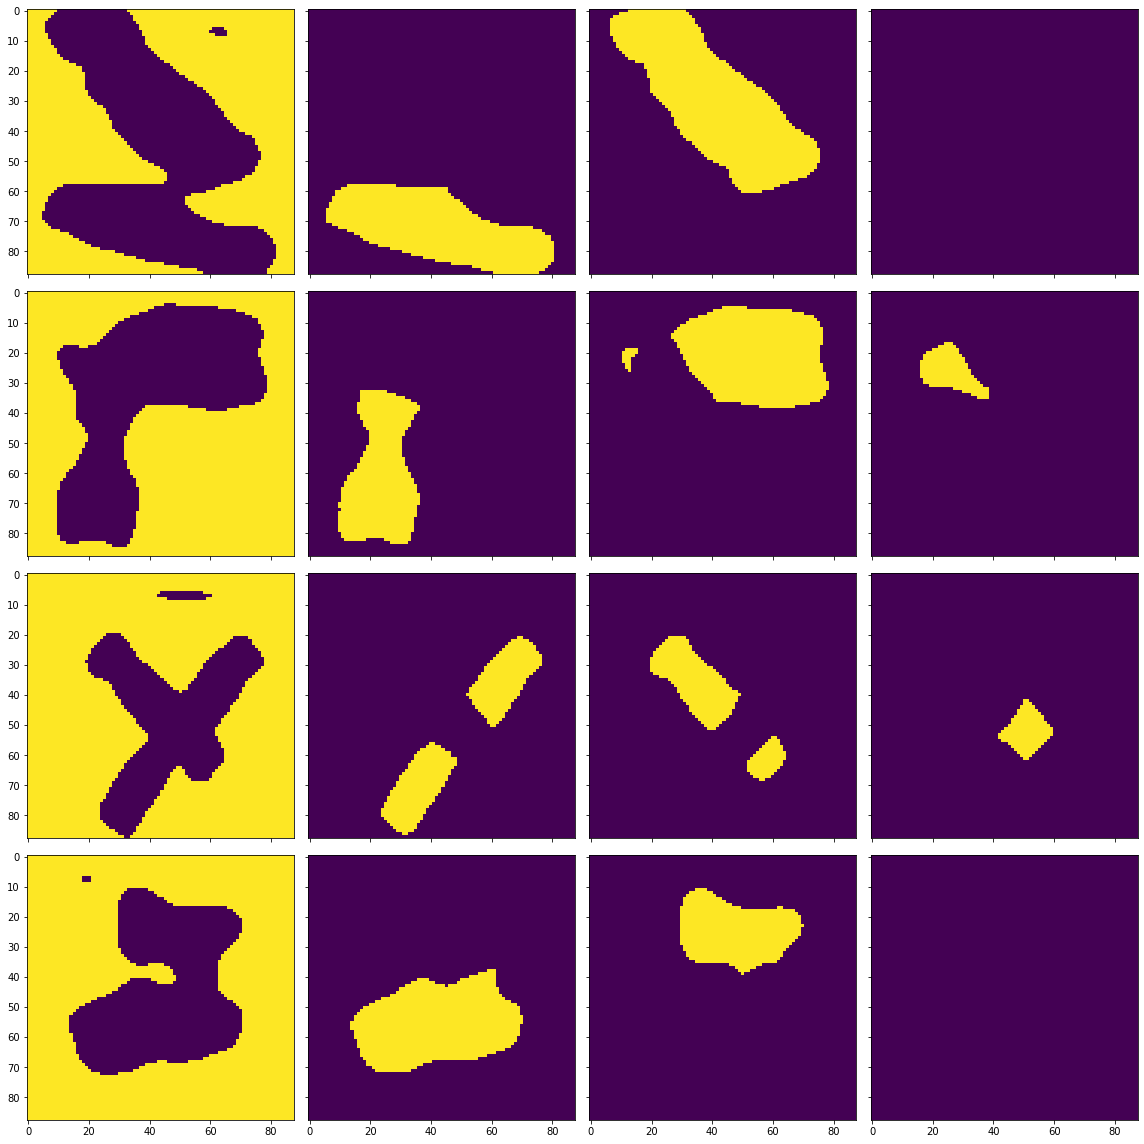

Training IOU: [0.9751653185631853, 0.892218906022587, 0.9006604419360337, 0.784217528687843]
Training accuracy: 0.9586721978305786
Testing IOU: [0.9699767966888247, 0.4863260420473275, 0.41490213816564425, 0.48418513223731235]
Testing accuracy: 0.8740934917355372
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0703 - val_loss: 0.0584
INFO:tensorflow:Assets written to: modelseg/savedmodel_137epoch\assets
4
4


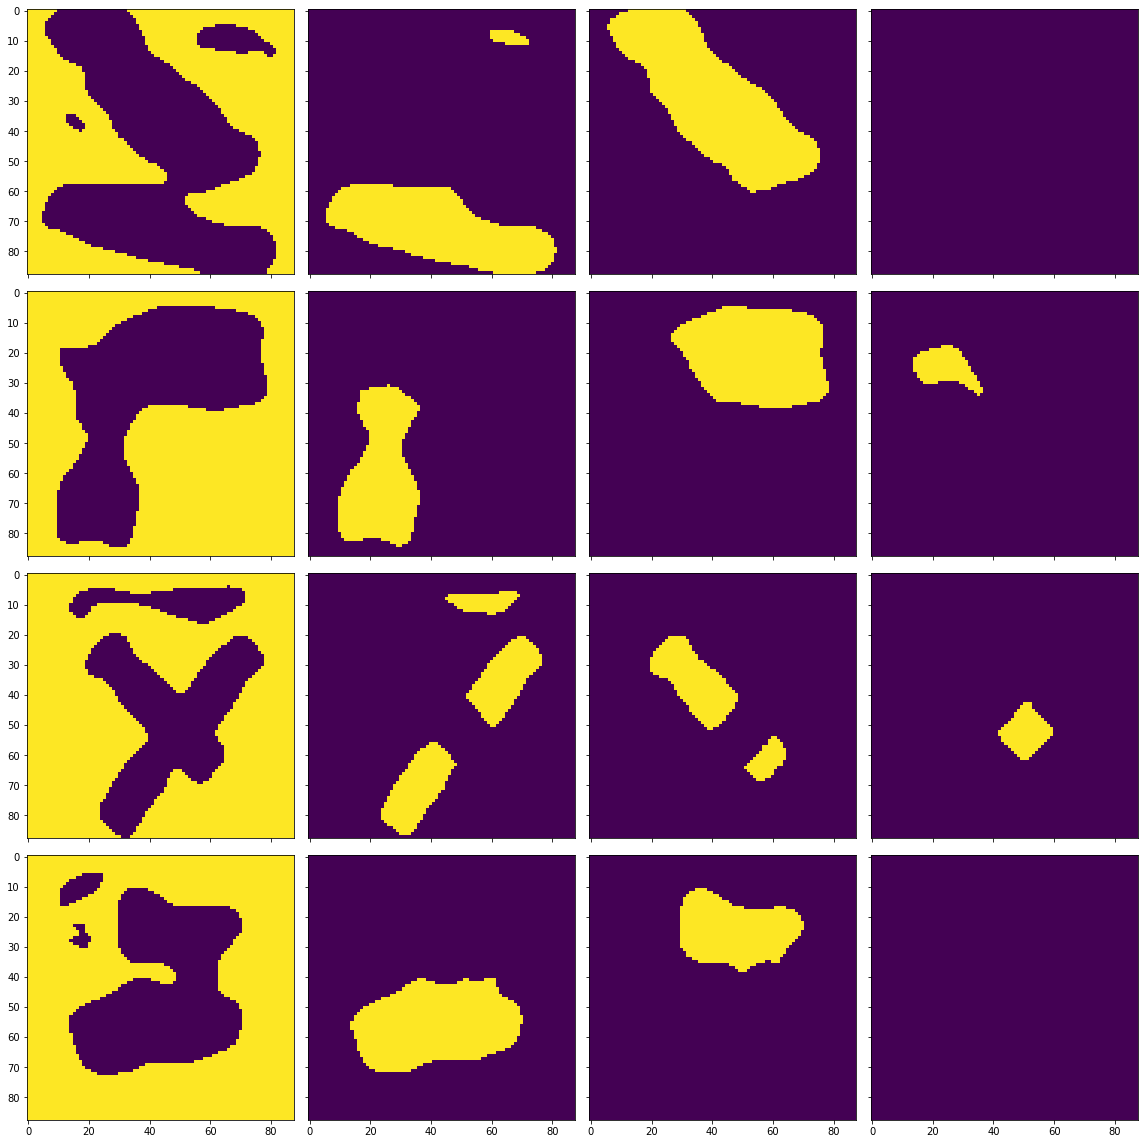

Training IOU: [0.9398529562317138, 0.8709956307931791, 0.8993820249146683, 0.7881809108578032]
Training accuracy: 0.933957257231405
Testing IOU: [0.9276291339887812, 0.4709336223394404, 0.38219448858571375, 0.4888198181480794]
Testing accuracy: 0.8397507747933884
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0498
INFO:tensorflow:Assets written to: modelseg/savedmodel_138epoch\assets
4
4


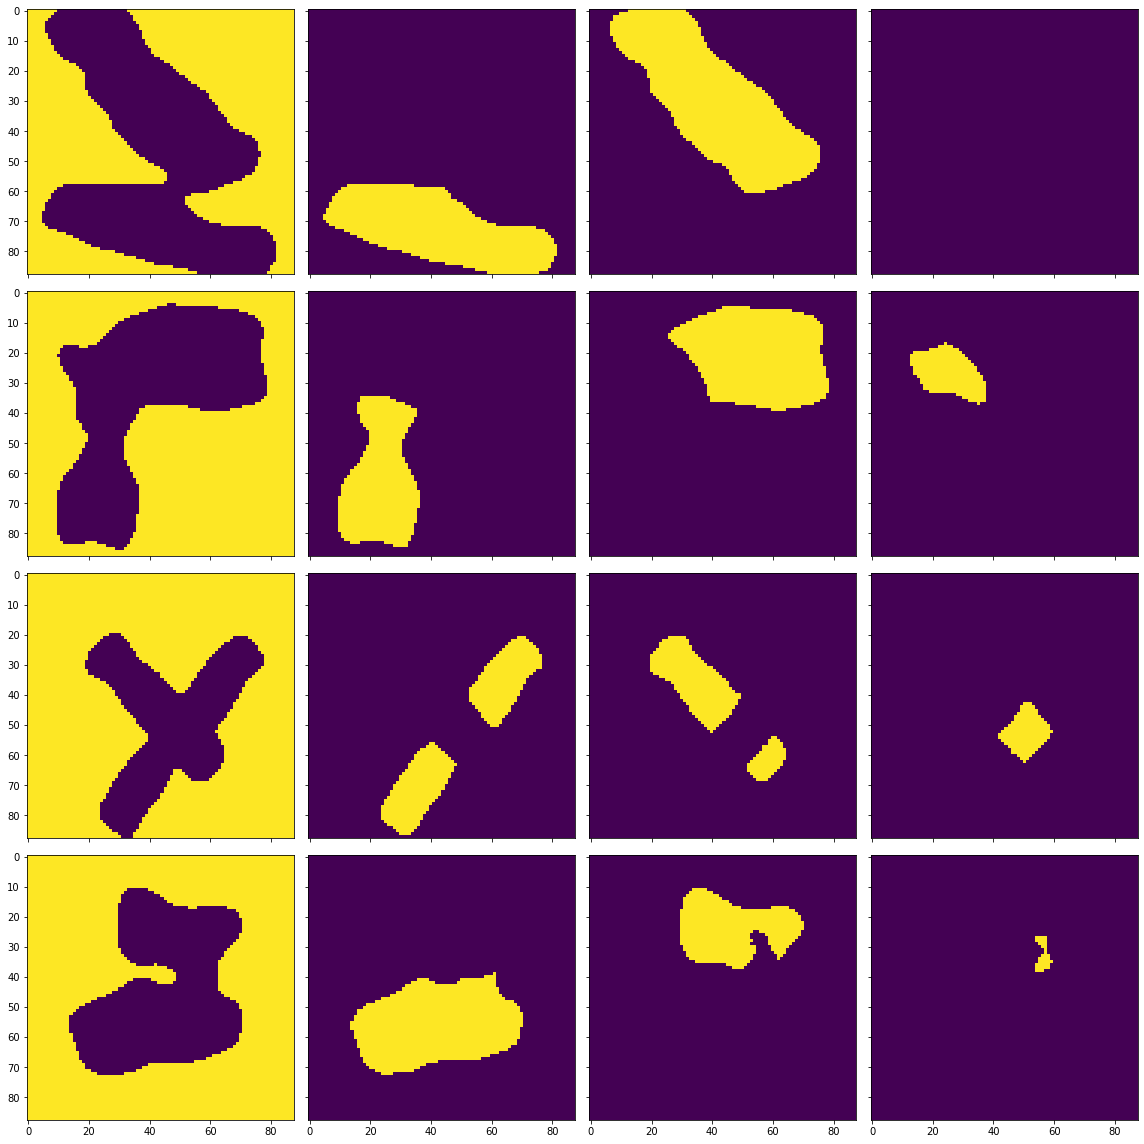

Training IOU: [0.9756051338704318, 0.8887581648182385, 0.8907184369036665, 0.8050516147549908]
Training accuracy: 0.9581459839876033
Testing IOU: [0.9732359800246639, 0.477039067854695, 0.41226390586061906, 0.47220326737044915]
Testing accuracy: 0.8737164256198348
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0499
INFO:tensorflow:Assets written to: modelseg/savedmodel_139epoch\assets
4
4


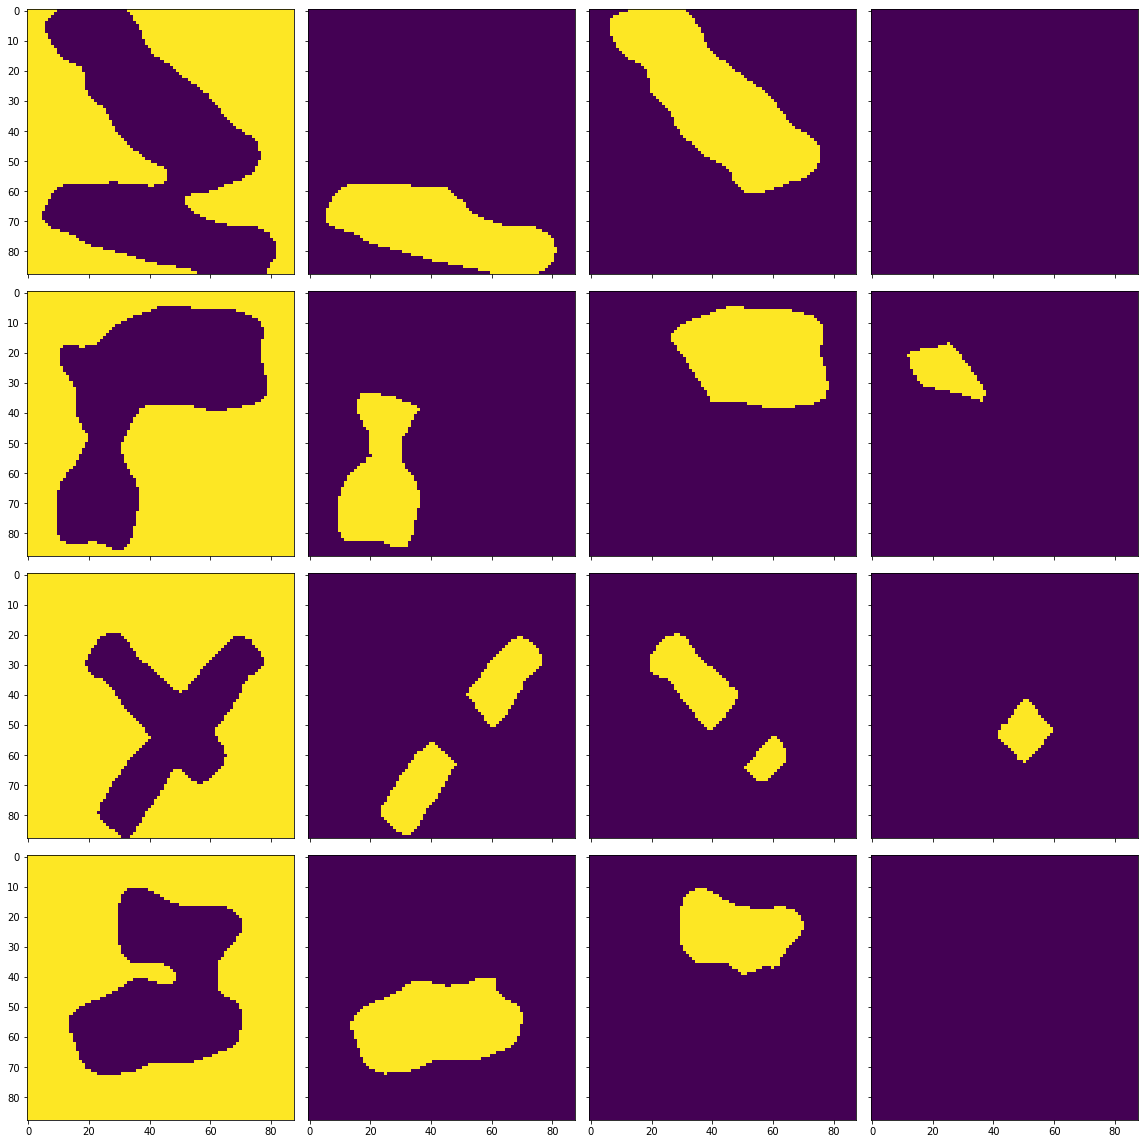

Training IOU: [0.9774921763109865, 0.8886180680300972, 0.8926714166492234, 0.7999815707835488]
Training accuracy: 0.9591748450413223
Testing IOU: [0.9743291341243944, 0.5104690206813953, 0.3680672608173441, 0.49669836238774434]
Testing accuracy: 0.8763119834710744
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_140epoch\assets
4
4


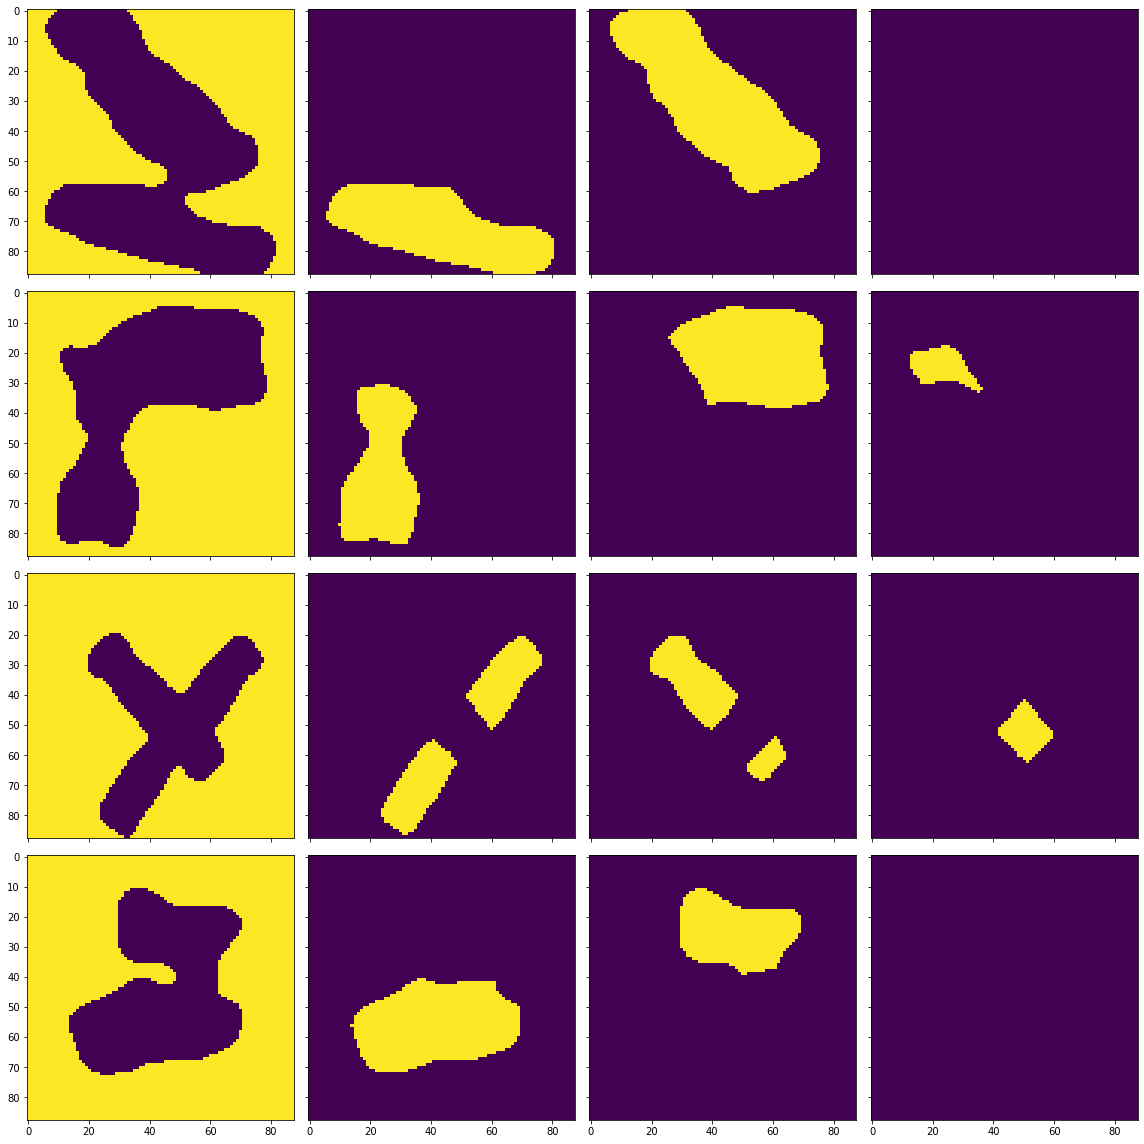

Training IOU: [0.979221166597471, 0.8930657820211991, 0.8924124497740683, 0.7938333625607328]
Training accuracy: 0.9612961647727273
Testing IOU: [0.9747051777105135, 0.45047607550814084, 0.4024439918533605, 0.48328115784220316]
Testing accuracy: 0.8722197830578512
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0705 - val_loss: 0.0524
INFO:tensorflow:Assets written to: modelseg/savedmodel_141epoch\assets
4
4


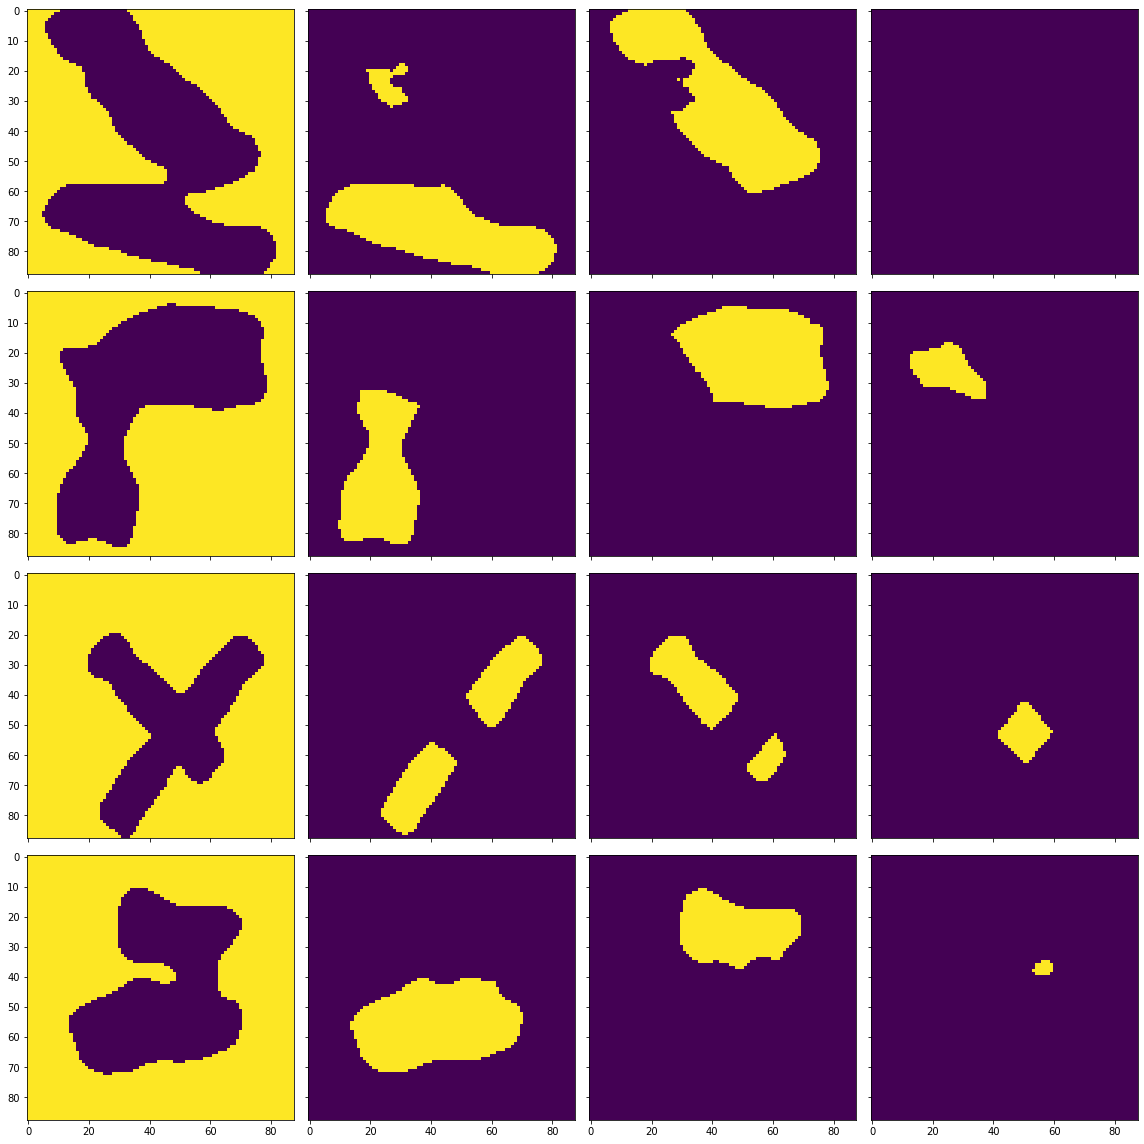

Training IOU: [0.9791410861693647, 0.886330843996258, 0.8335252432150057, 0.7892837114453225]
Training accuracy: 0.9558458161157025
Testing IOU: [0.9740456582272761, 0.5186781802750873, 0.2975773775430111, 0.48311183716720385]
Testing accuracy: 0.8734336260330579
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0704 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_142epoch\assets
4
4


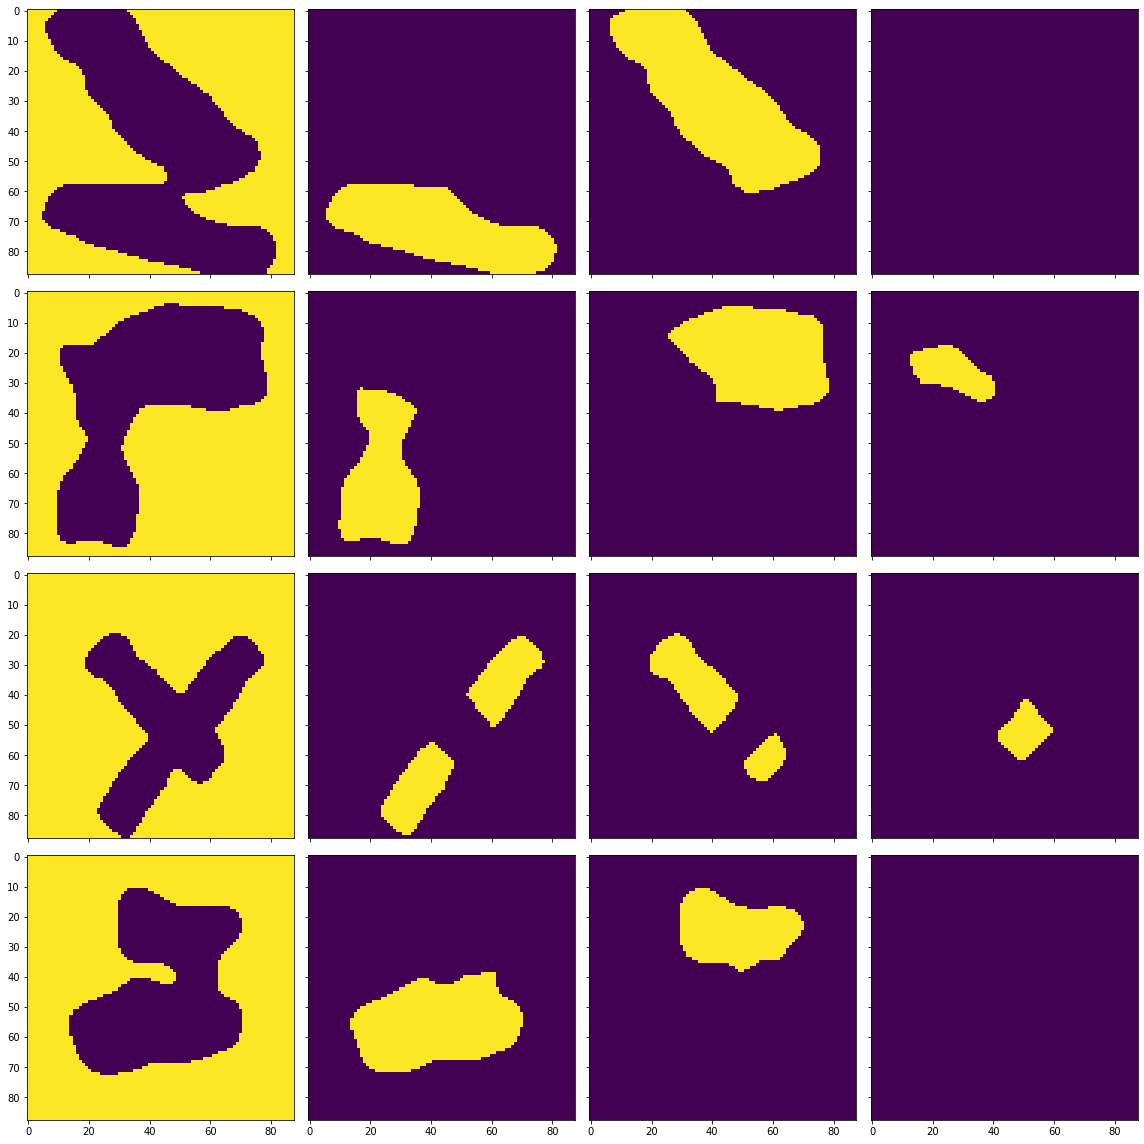

Training IOU: [0.9770564489325886, 0.8960426435113749, 0.9013712311388237, 0.7939331086336531]
Training accuracy: 0.9606030475206612
Testing IOU: [0.9733307975635672, 0.4855638121347666, 0.37597803837545196, 0.49554483014664935]
Testing accuracy: 0.8718194731404959
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0702 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_143epoch\assets
4
4


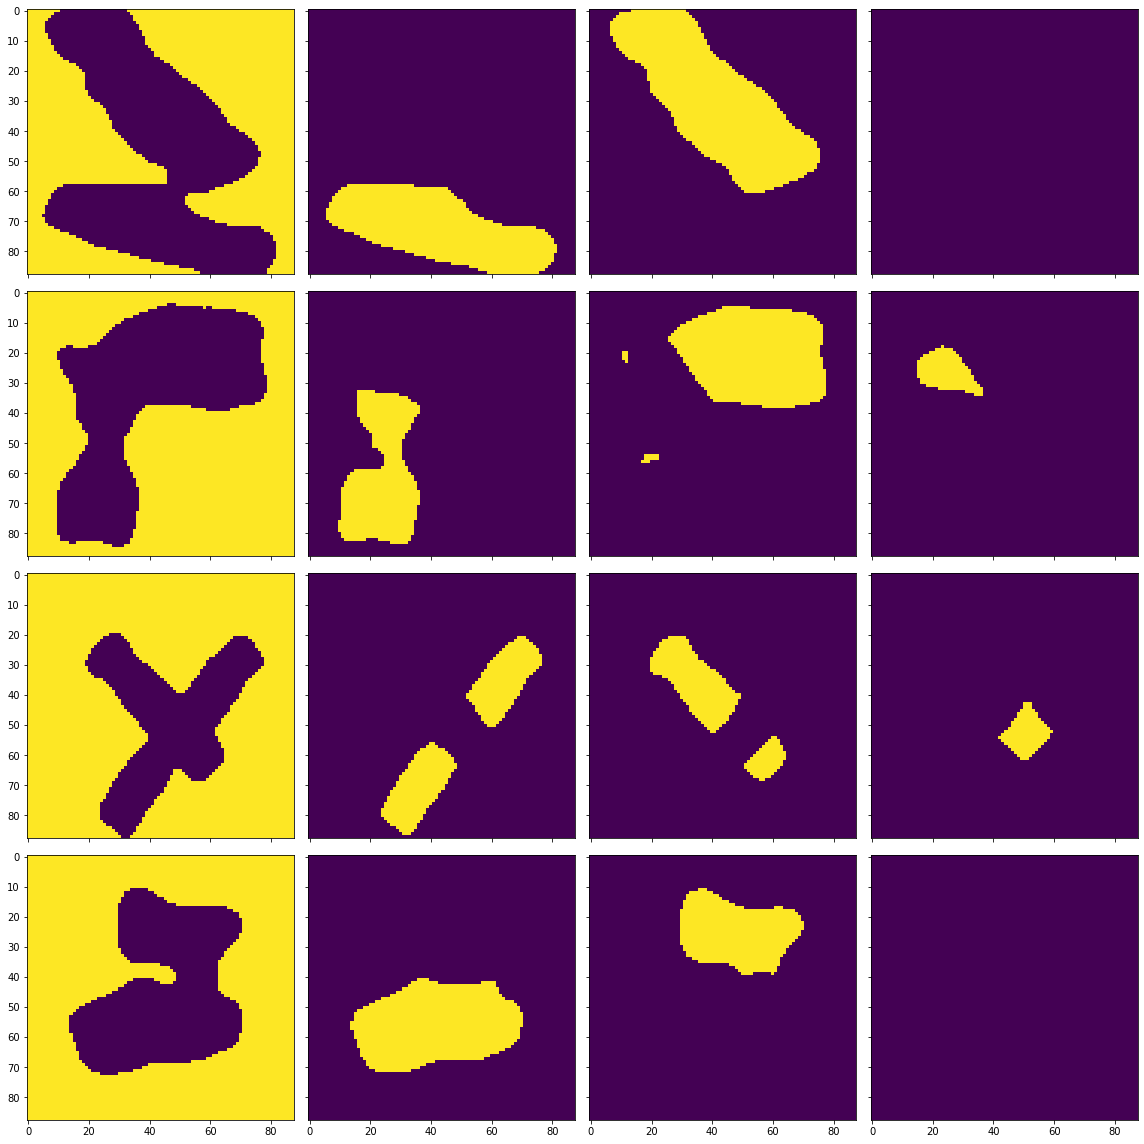

Training IOU: [0.9792968084820348, 0.9016606554878753, 0.9046585515027847, 0.7541262729991167]
Training accuracy: 0.9623524664256199
Testing IOU: [0.9746317426844419, 0.4824080327126732, 0.41594177003300825, 0.4606808588731877]
Testing accuracy: 0.8773618285123967
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0700 - val_loss: 0.0522
INFO:tensorflow:Assets written to: modelseg/savedmodel_144epoch\assets
4
4


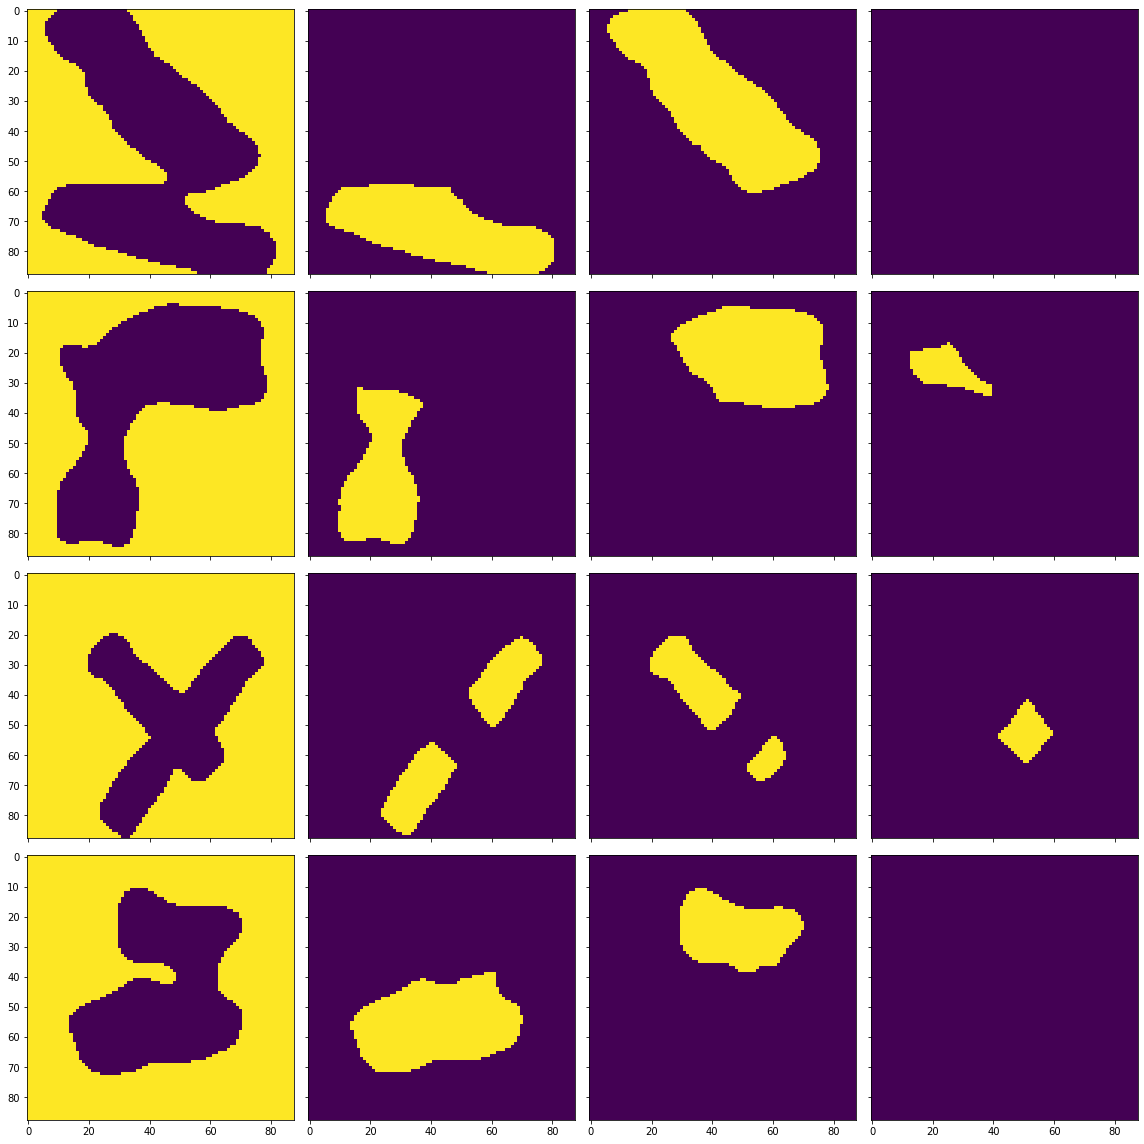

Training IOU: [0.979402823549032, 0.8964005890197821, 0.9053622548608046, 0.7825714738677799]
Training accuracy: 0.9620806430785124
Testing IOU: [0.9747232857640098, 0.45051222986694145, 0.40686387797550266, 0.47735715965201037]
Testing accuracy: 0.8722301136363636
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0534
INFO:tensorflow:Assets written to: modelseg/savedmodel_145epoch\assets
4
4


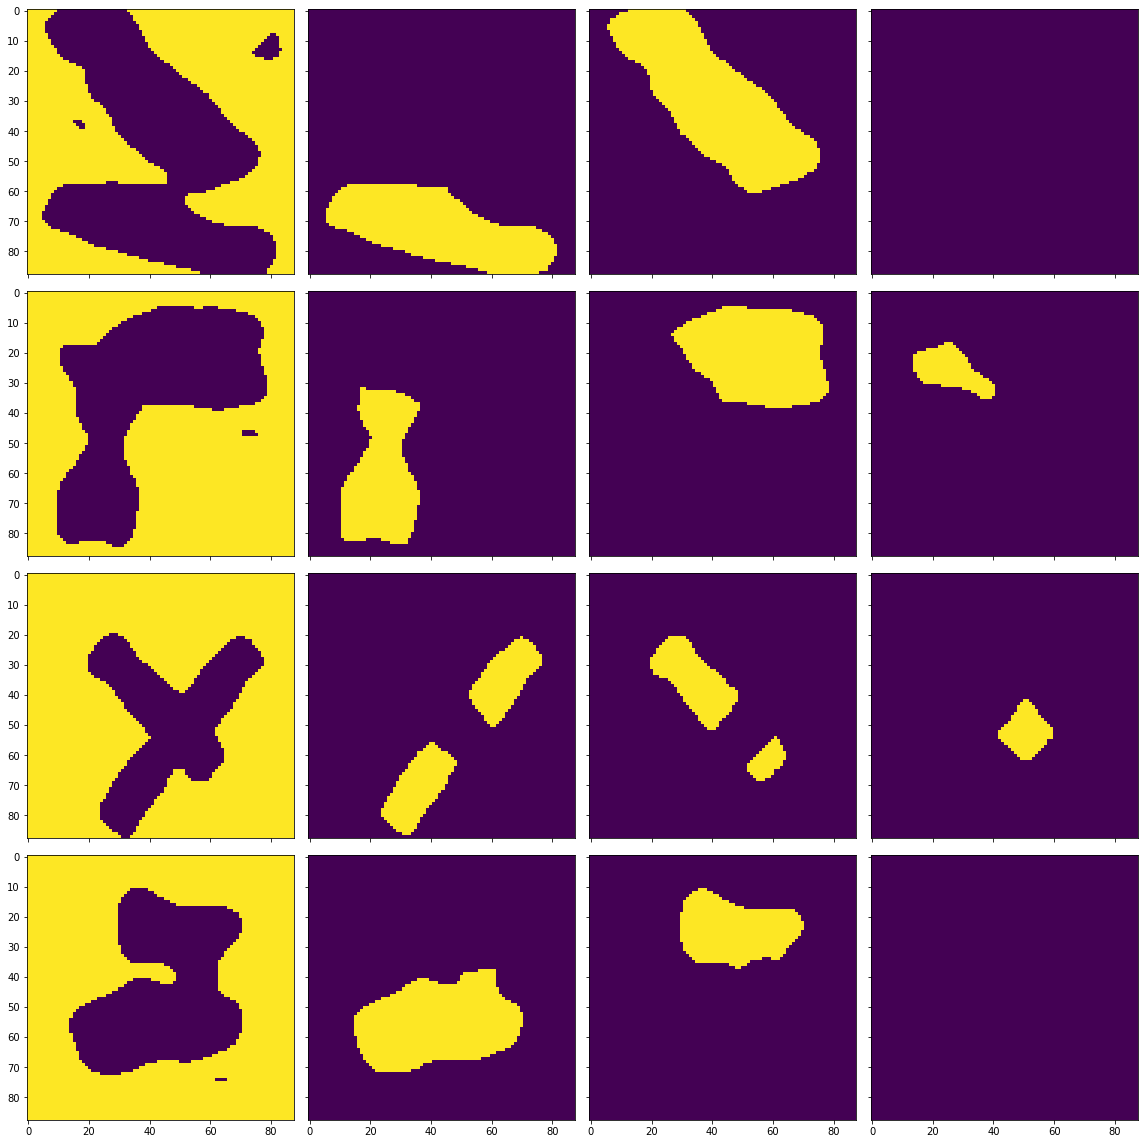

Training IOU: [0.9697199895664987, 0.9007914485788697, 0.8885340748915526, 0.821795989537925]
Training accuracy: 0.9556711647727273
Testing IOU: [0.965811341239352, 0.49789417040358747, 0.37215771769046374, 0.5068433818433818]
Testing accuracy: 0.8702530991735538
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0545
INFO:tensorflow:Assets written to: modelseg/savedmodel_146epoch\assets
4
4


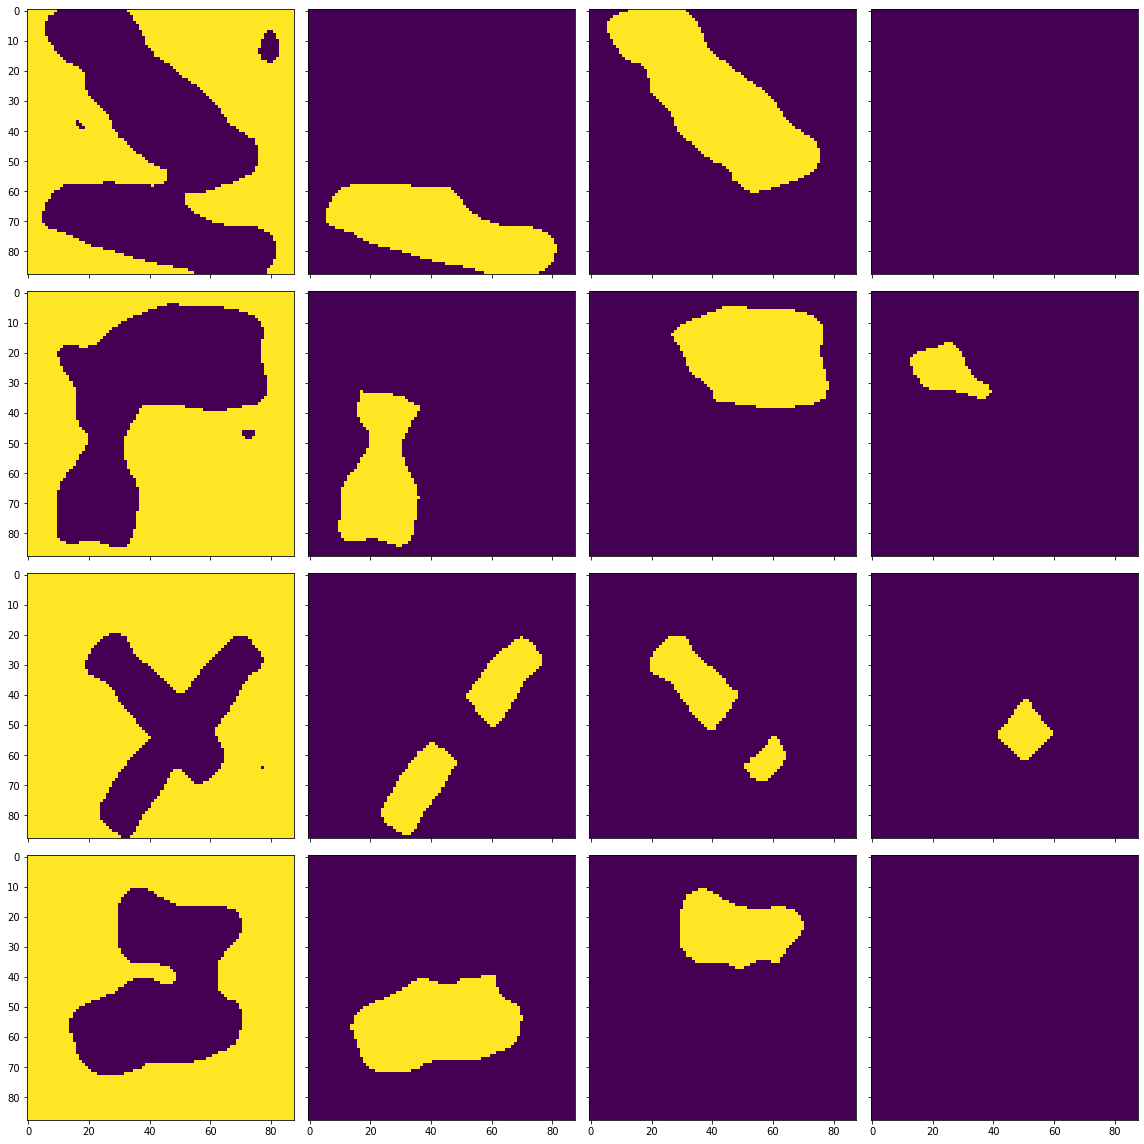

Training IOU: [0.968967230174069, 0.8977085949619561, 0.9074468316207938, 0.8202577926504306]
Training accuracy: 0.956159284607438
Testing IOU: [0.9654293232951674, 0.4514492483306599, 0.3990884331054416, 0.5024933367724186]
Testing accuracy: 0.864220041322314
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0522
INFO:tensorflow:Assets written to: modelseg/savedmodel_147epoch\assets
4
4


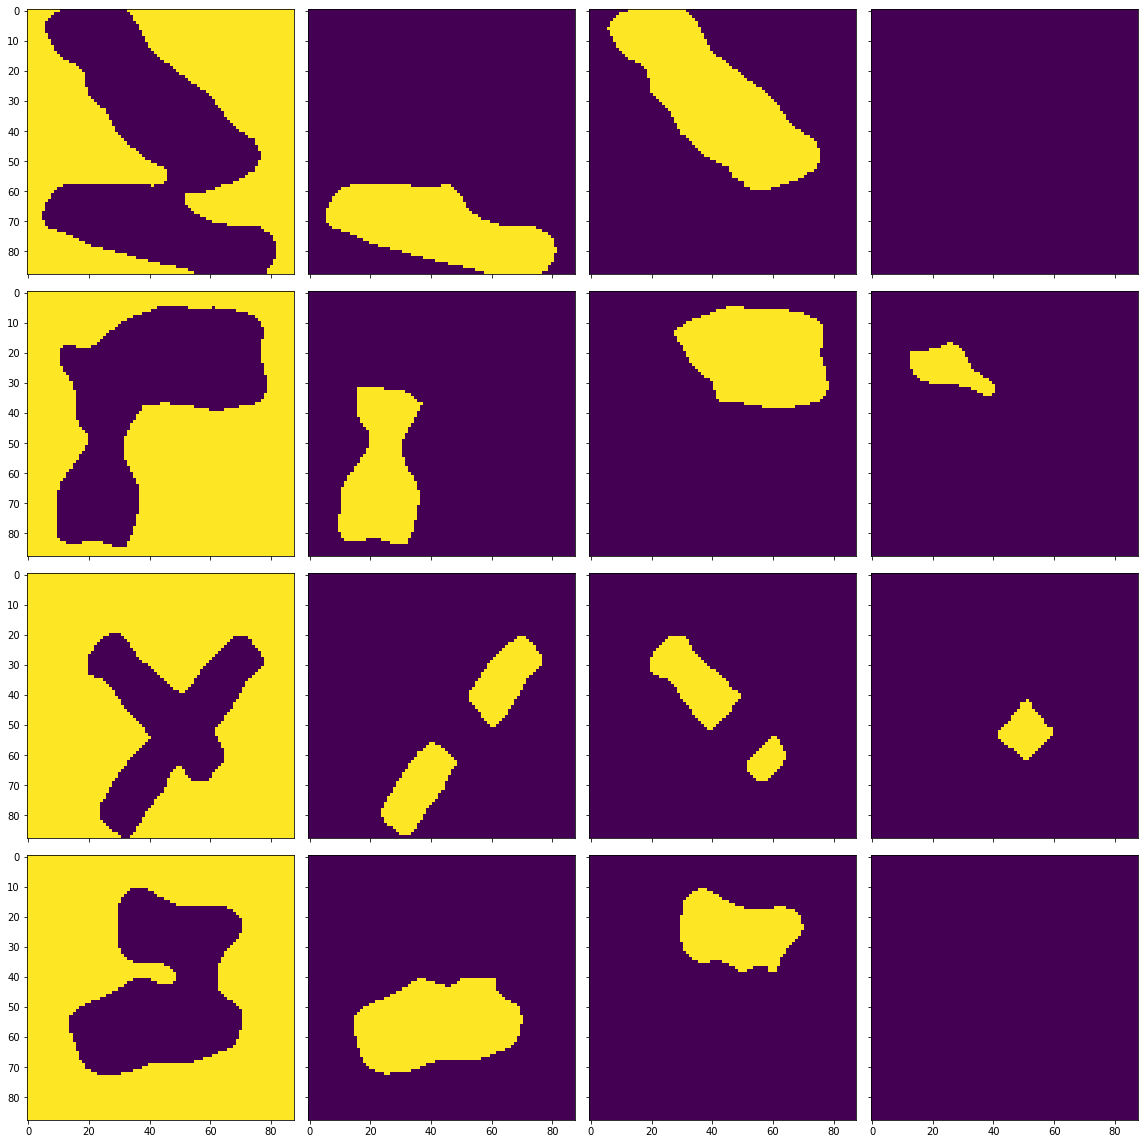

Training IOU: [0.9797487774217093, 0.9055920104251958, 0.9012016711803051, 0.7796715574669028]
Training accuracy: 0.9630258910123967
Testing IOU: [0.9749032397287928, 0.48513382411687495, 0.35899087596504214, 0.47680680207841286]
Testing accuracy: 0.8724638429752066
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0564
INFO:tensorflow:Assets written to: modelseg/savedmodel_148epoch\assets
4
4


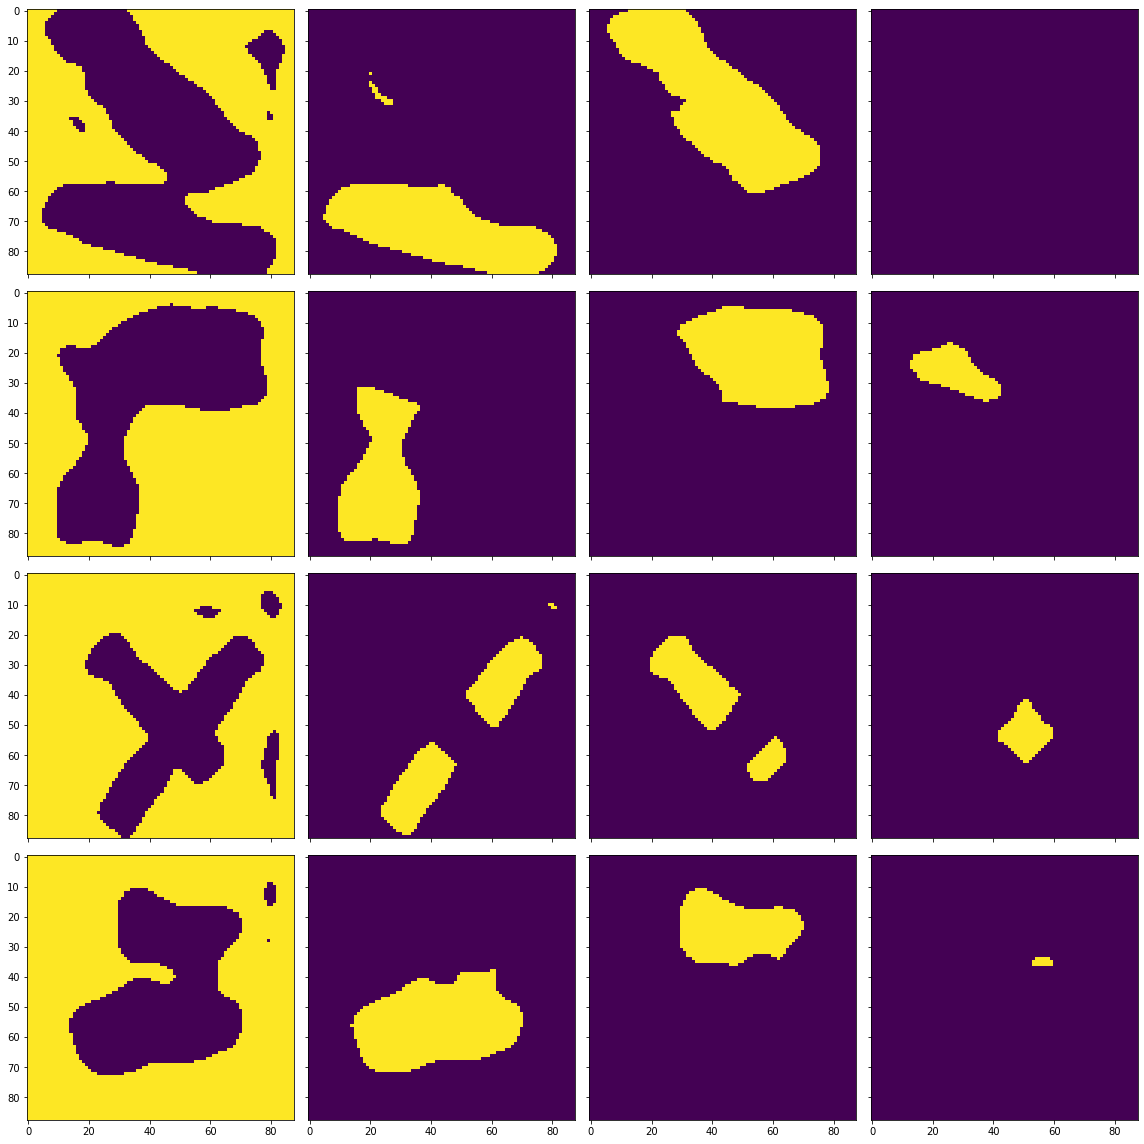

Training IOU: [0.9537986918947319, 0.9043585922274446, 0.8935408293491305, 0.8122654080501277]
Training accuracy: 0.9448150180785124
Testing IOU: [0.9510893172077055, 0.5177053341156885, 0.3445678565893475, 0.4875497790031071]
Testing accuracy: 0.8594770144628099
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0697 - val_loss: 0.0557
INFO:tensorflow:Assets written to: modelseg/savedmodel_149epoch\assets
4
4


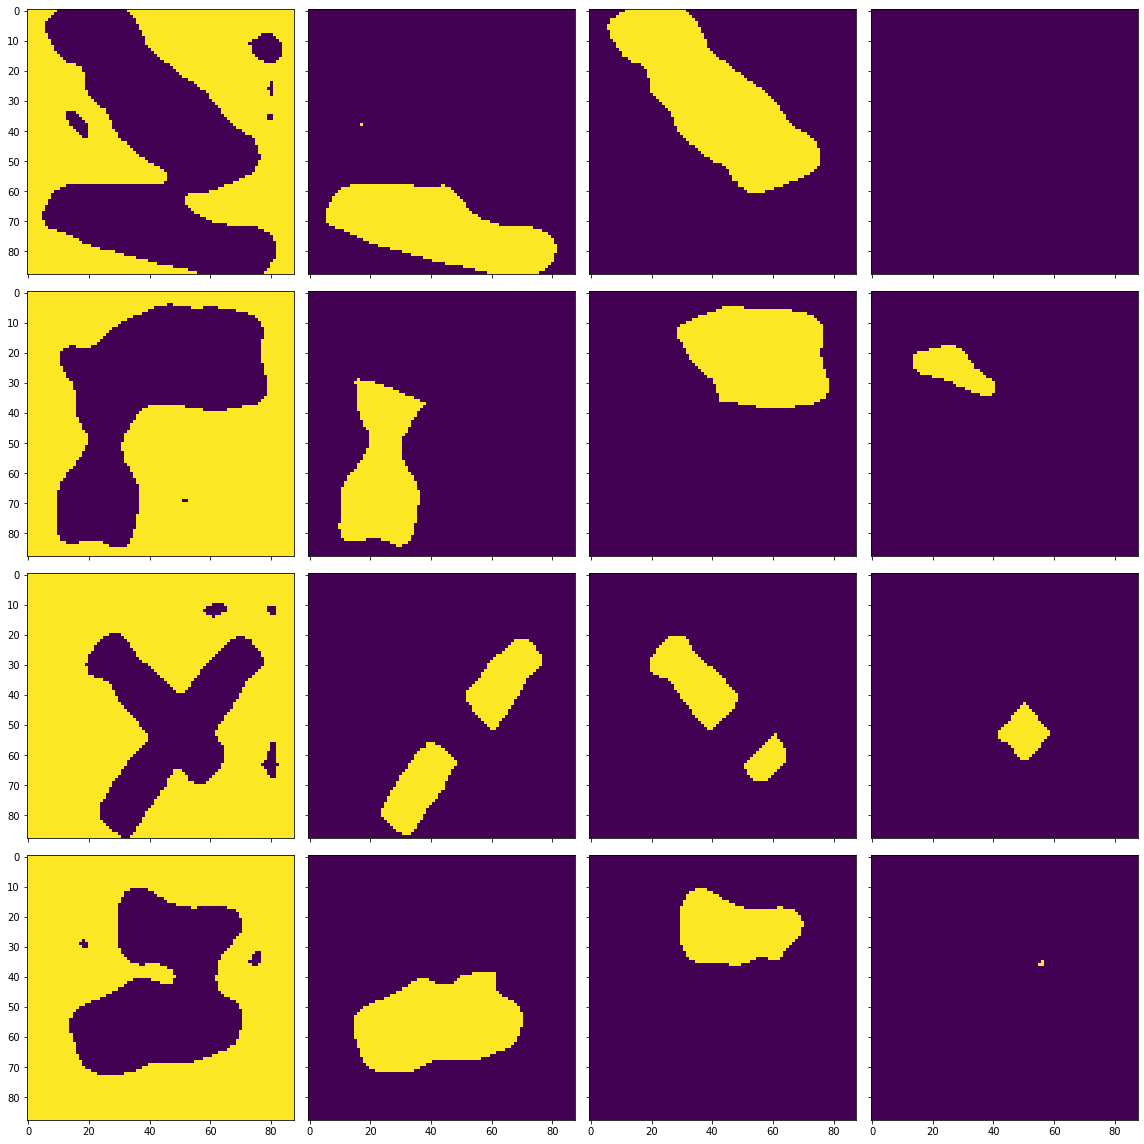

Training IOU: [0.9580112332814023, 0.9052282089830177, 0.8961126460576325, 0.7756946346190305]
Training accuracy: 0.9477966813016528
Testing IOU: [0.9541435779904524, 0.5263556029295464, 0.3706887822265427, 0.47917860553963704]
Testing accuracy: 0.8654739152892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0509
INFO:tensorflow:Assets written to: modelseg/savedmodel_150epoch\assets
4
4


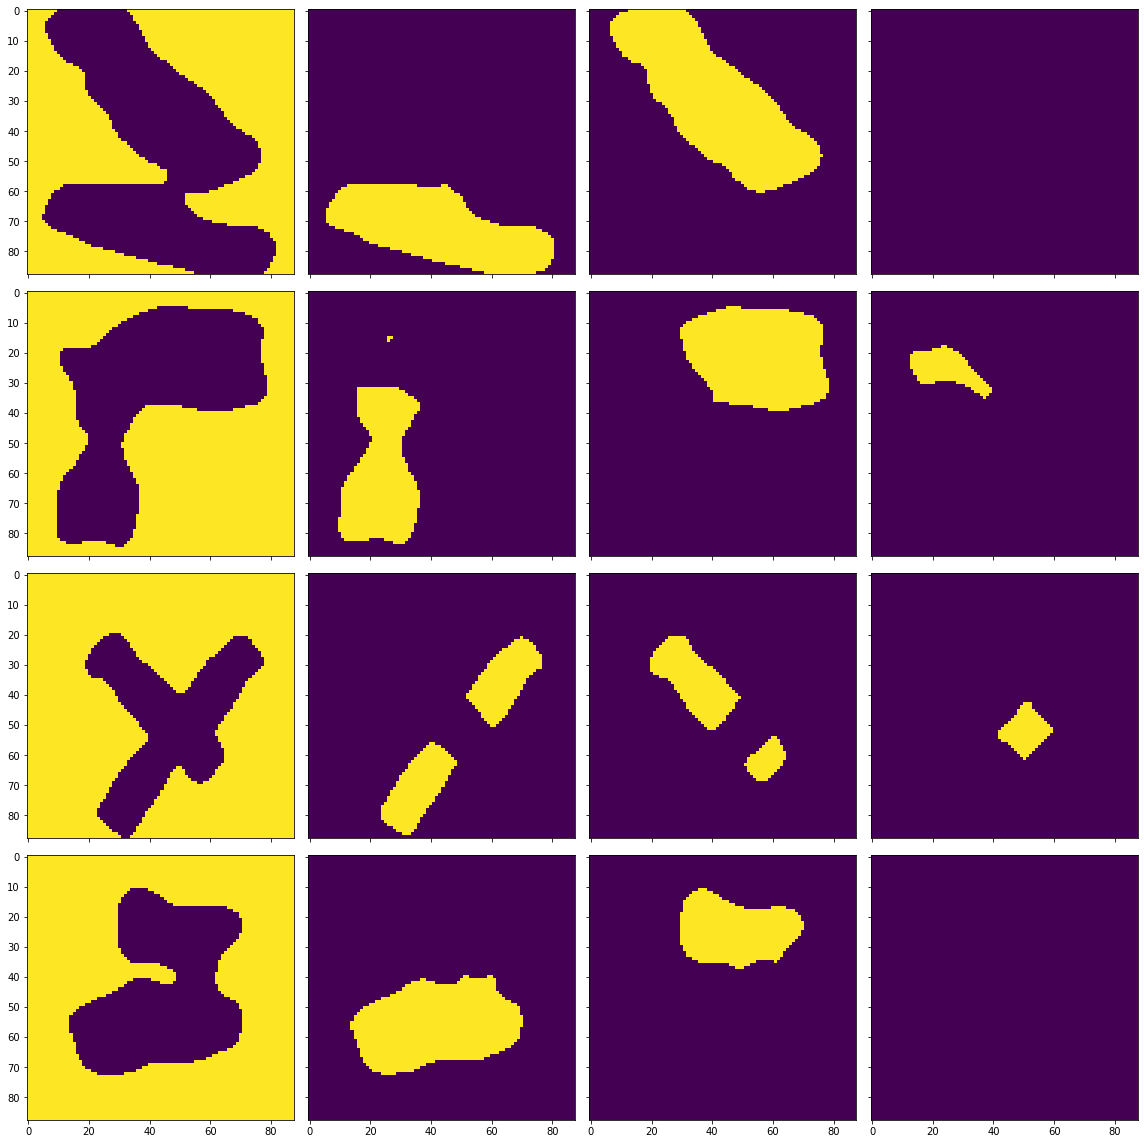

Training IOU: [0.9787528348029652, 0.9046150723822132, 0.9093615649474315, 0.7935628252631135]
Training accuracy: 0.9632825413223141
Testing IOU: [0.9742759332338627, 0.4820708972961904, 0.39453679491968624, 0.4809064788210214]
Testing accuracy: 0.8748514979338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0700 - val_loss: 0.0685
INFO:tensorflow:Assets written to: modelseg/savedmodel_151epoch\assets
4
4


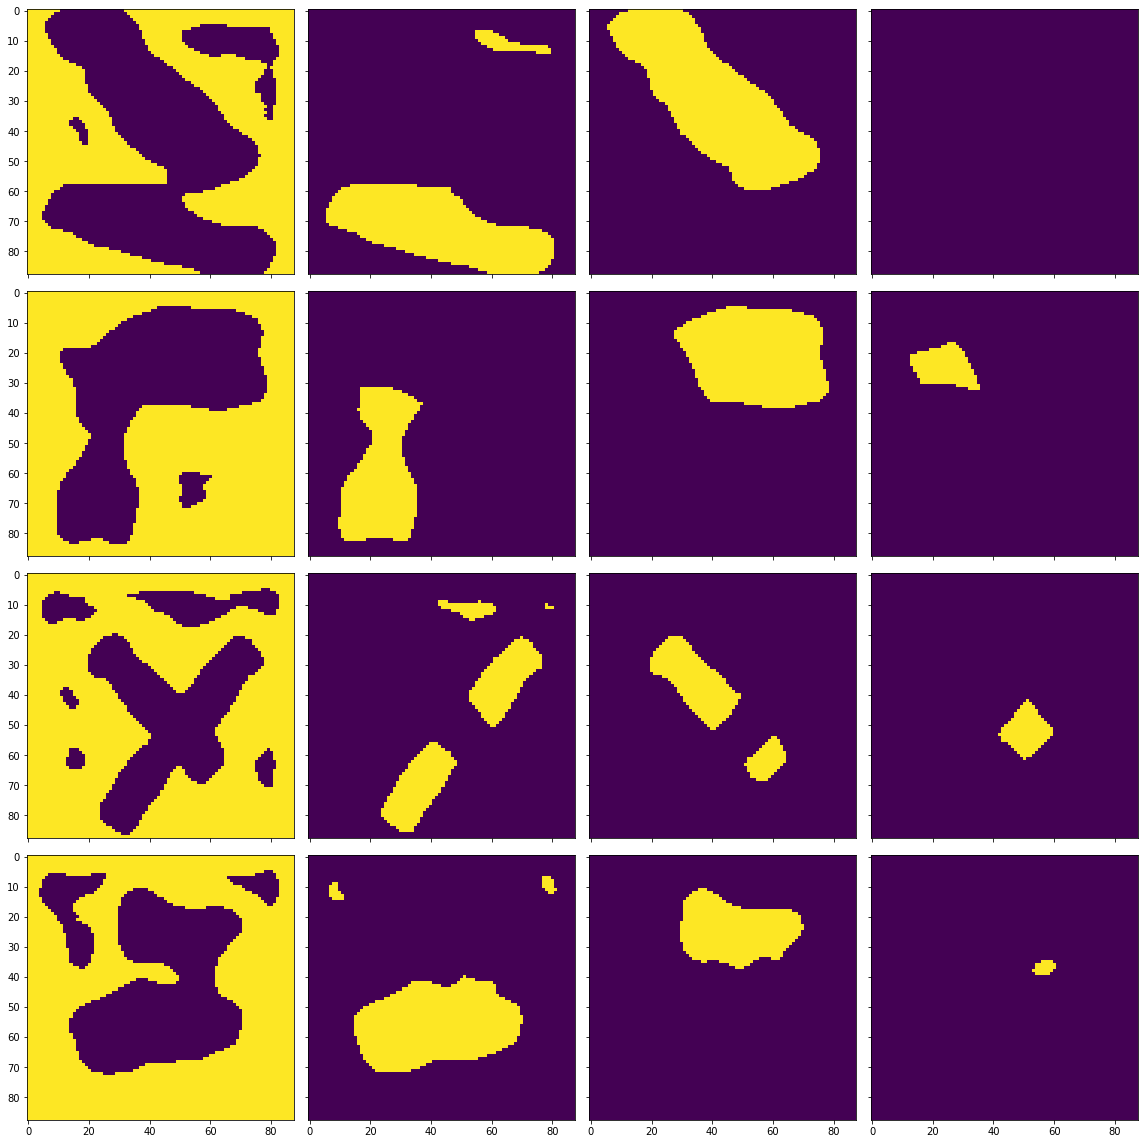

Training IOU: [0.8837266078707372, 0.8409191271641973, 0.8945673320581359, 0.7895542754762971]
Training accuracy: 0.8932954545454546
Testing IOU: [0.8732000423366353, 0.45436154881835955, 0.37129553707391355, 0.4739881863924743]
Testing accuracy: 0.7996900826446282
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0699 - val_loss: 0.0496
INFO:tensorflow:Assets written to: modelseg/savedmodel_152epoch\assets
4
4


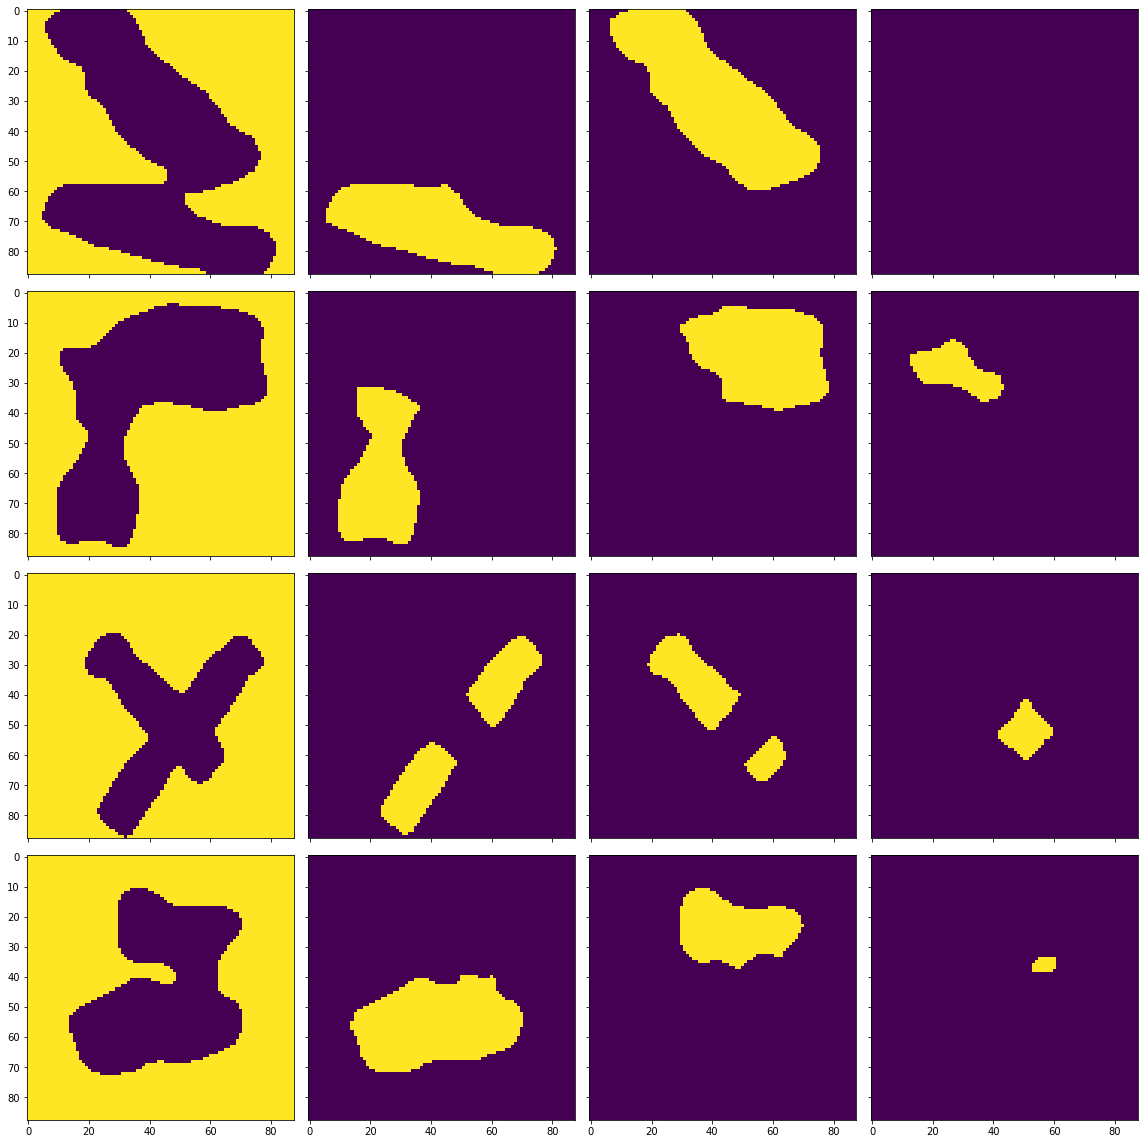

Training IOU: [0.9788132913450528, 0.902102530046026, 0.8869379213123856, 0.786948624542106]
Training accuracy: 0.9610501678719008
Testing IOU: [0.9740285757089054, 0.4968246540544154, 0.39624406805818124, 0.48945094584958687]
Testing accuracy: 0.8765276342975207
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0698 - val_loss: 0.0537
INFO:tensorflow:Assets written to: modelseg/savedmodel_153epoch\assets
4
4


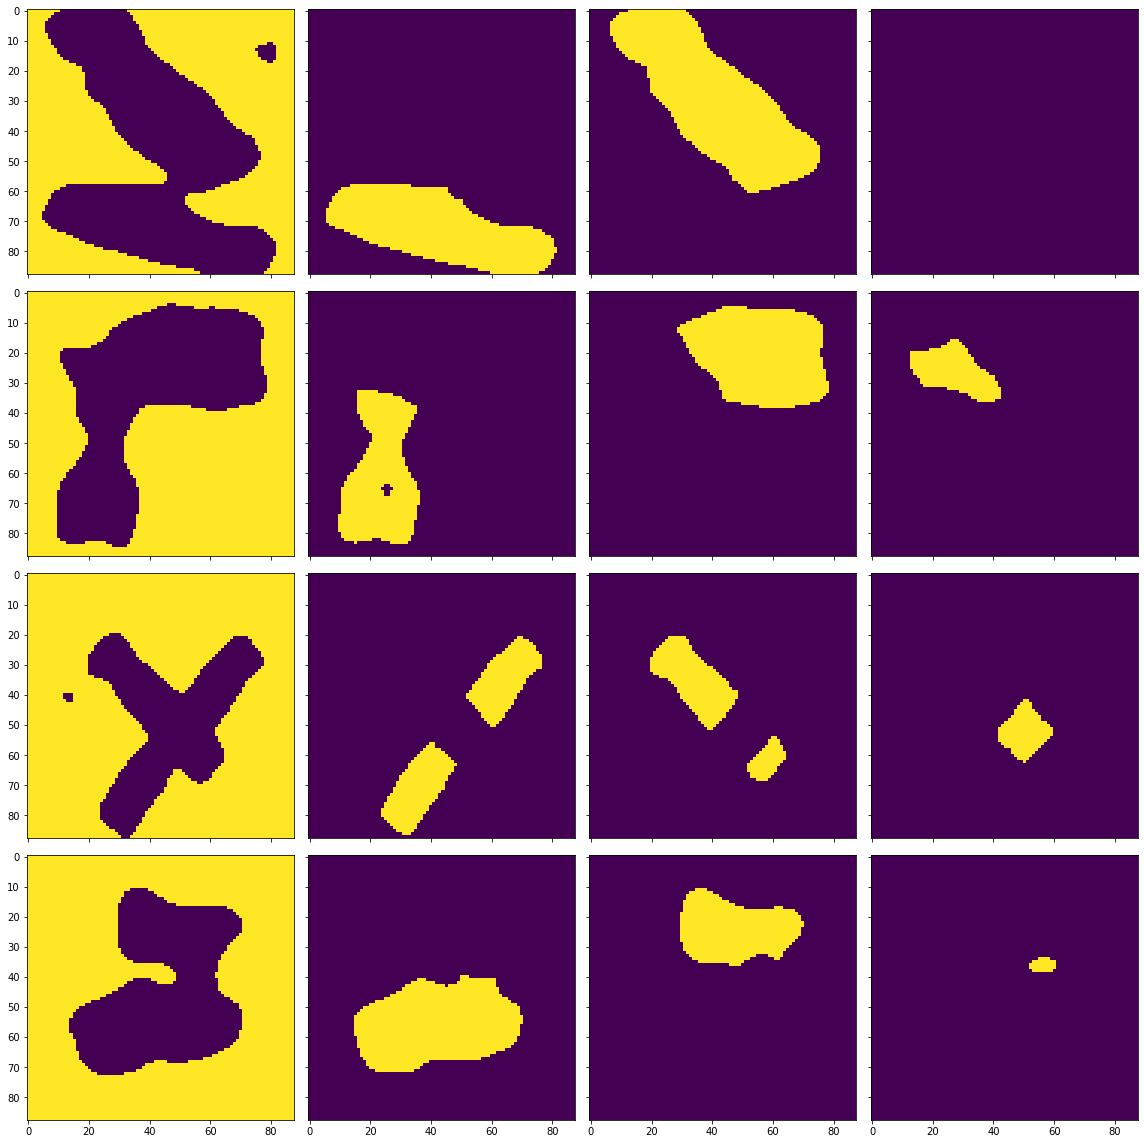

Training IOU: [0.9765369793321594, 0.8943810124001409, 0.8913376662759915, 0.8227761737135625]
Training accuracy: 0.9602521306818181
Testing IOU: [0.9713149821566459, 0.48569611735912394, 0.38342397729959804, 0.48459571119417666]
Testing accuracy: 0.8721965392561983
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0696 - val_loss: 0.0503
INFO:tensorflow:Assets written to: modelseg/savedmodel_154epoch\assets
4
4


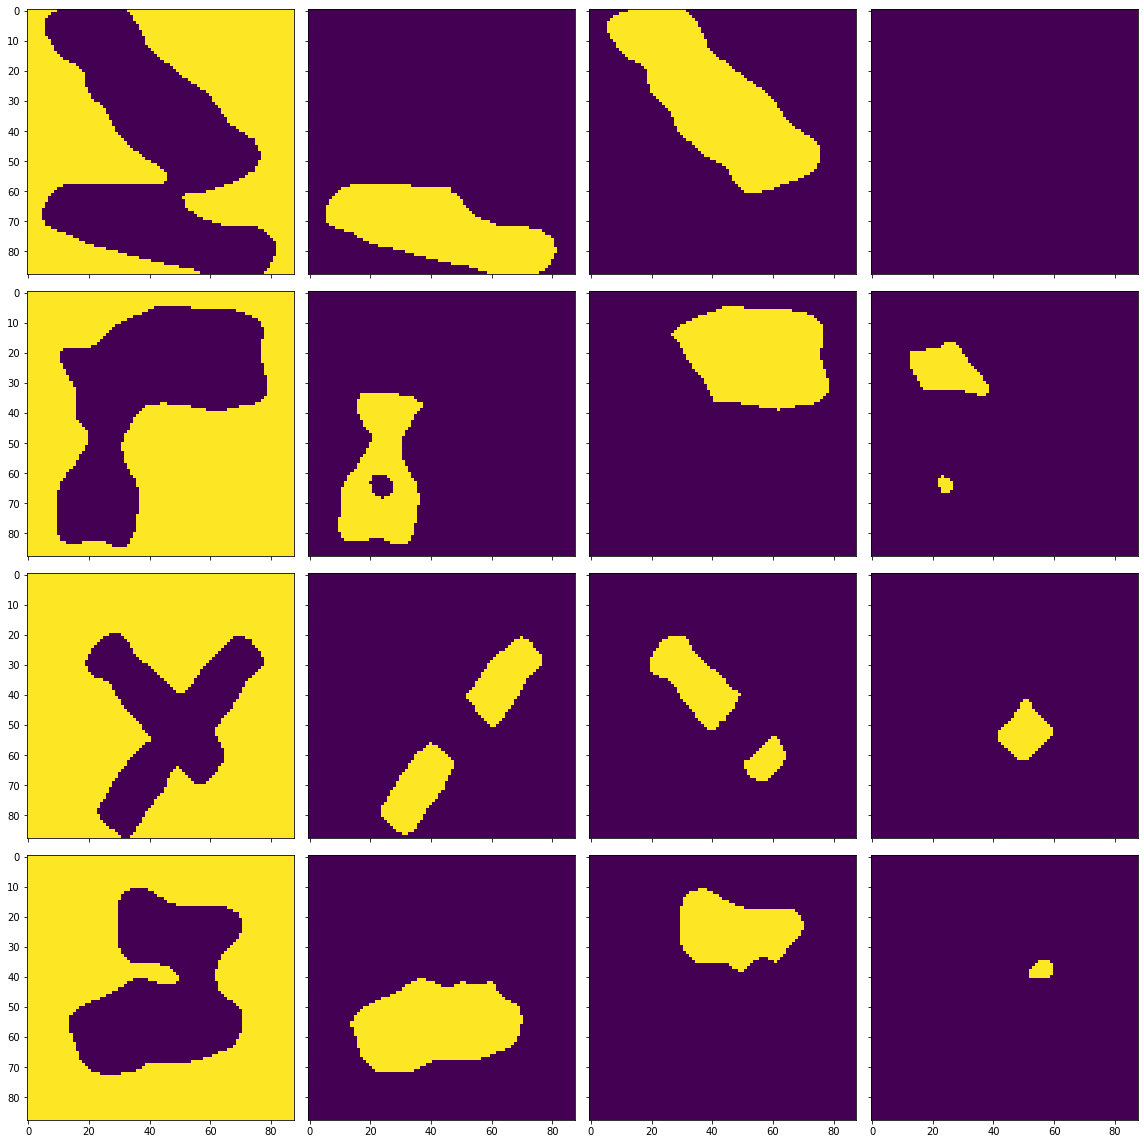

Training IOU: [0.9800497679543344, 0.9033196143889286, 0.9044168184942342, 0.832156265854896]
Training accuracy: 0.9651110537190083
Testing IOU: [0.9748060227393401, 0.51627067055988, 0.41104349650768907, 0.4993982653442337]
Testing accuracy: 0.8832928719008264
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0698 - val_loss: 0.0501
INFO:tensorflow:Assets written to: modelseg/savedmodel_155epoch\assets
4
4


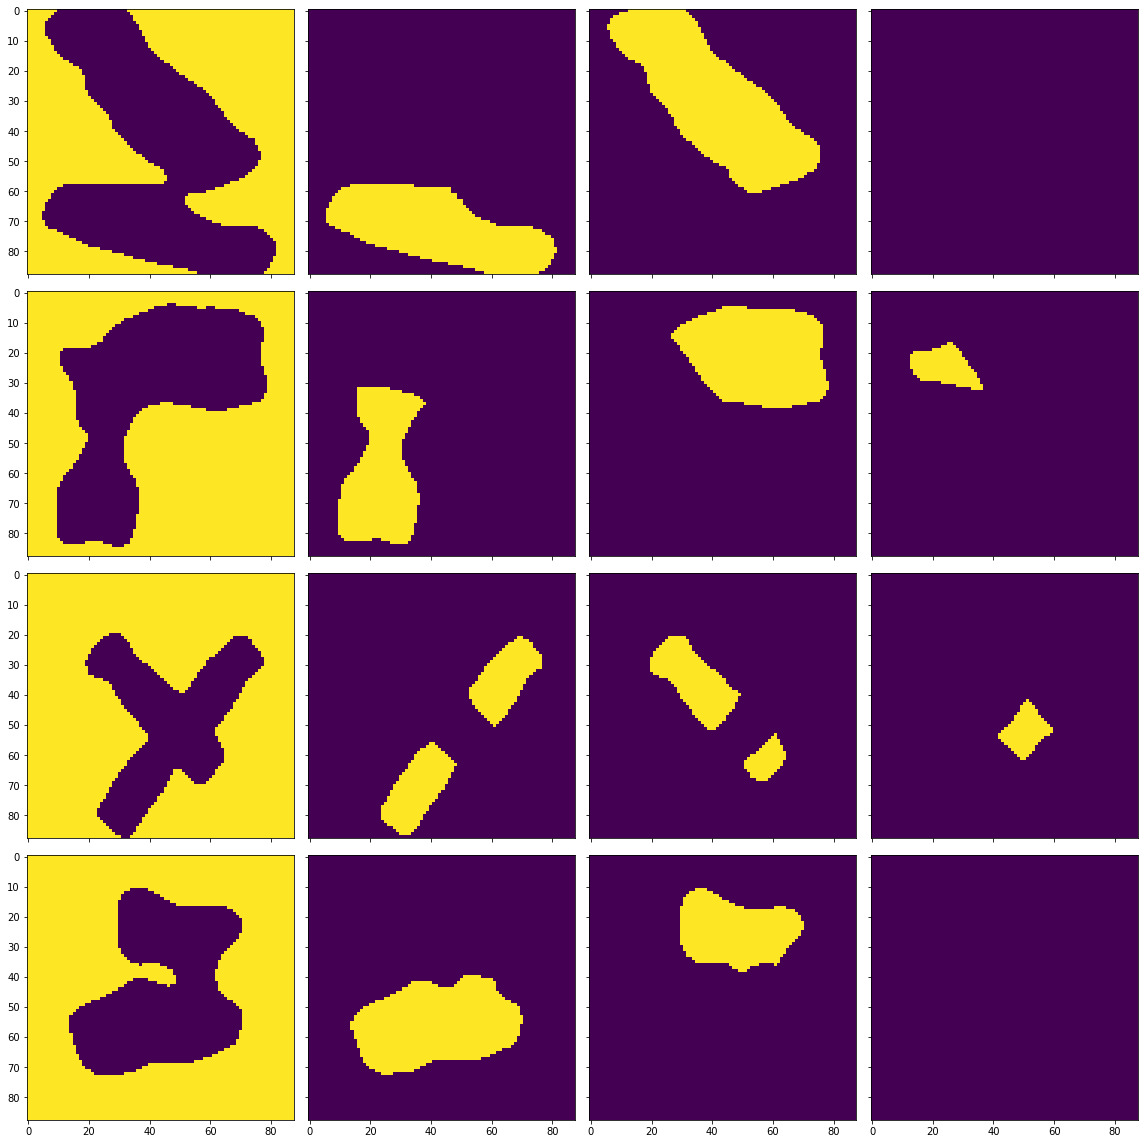

Training IOU: [0.9787375227344052, 0.9125906047695457, 0.9133384289394157, 0.7768748797125933]
Training accuracy: 0.9634119963842975
Testing IOU: [0.9743489167934926, 0.4834284318093623, 0.3844554322620211, 0.47886399850032807]
Testing accuracy: 0.8736014979338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0697 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_156epoch\assets
4
4


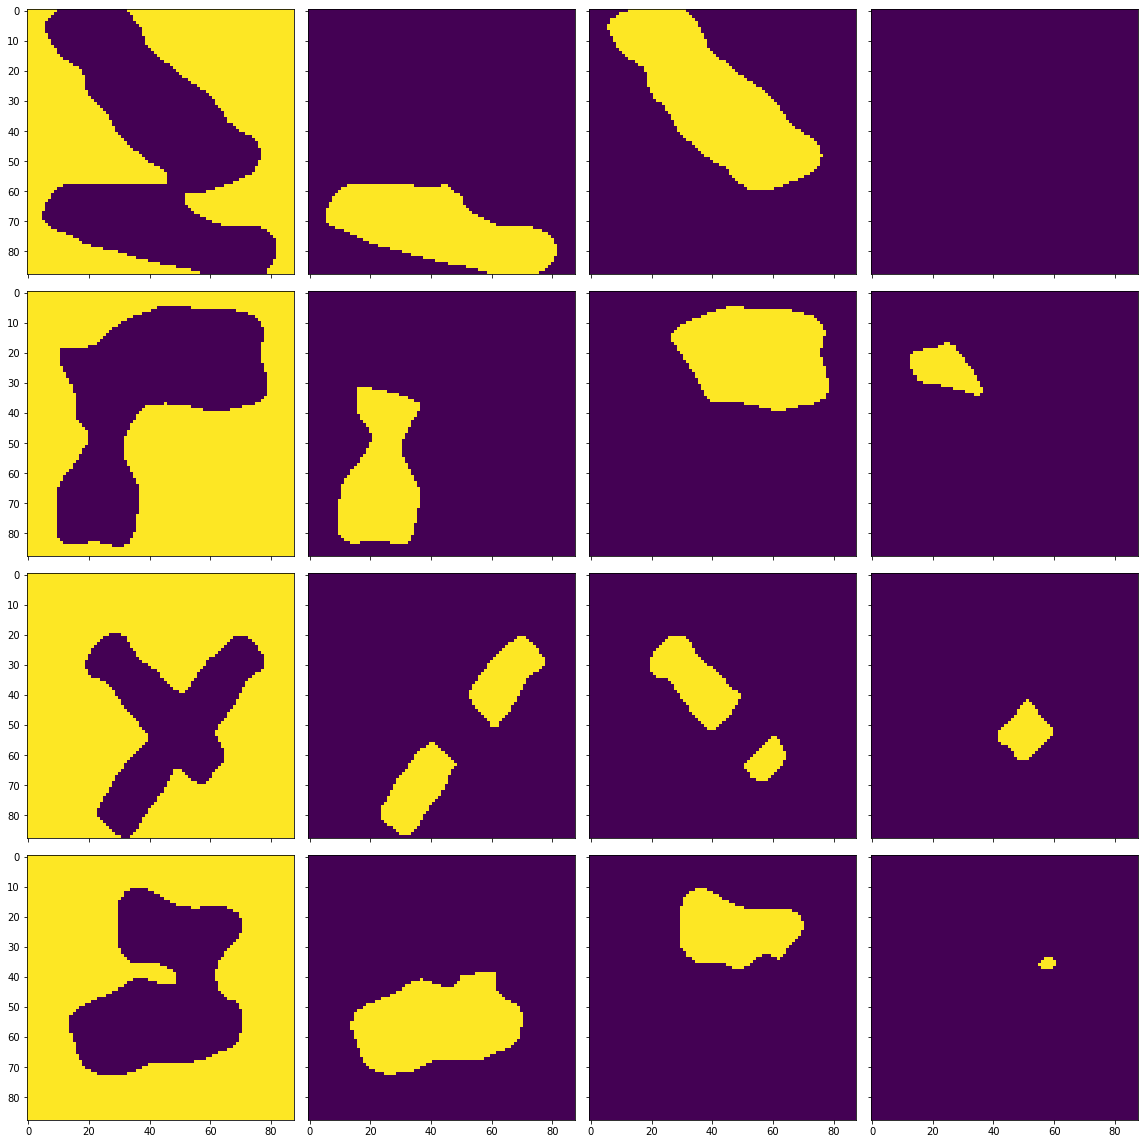

Training IOU: [0.9785426483337302, 0.9115174409073382, 0.9175447689706733, 0.8191404276814278]
Training accuracy: 0.9650009684917356
Testing IOU: [0.9739383737866194, 0.5097676404654308, 0.3943144138872635, 0.4834987306715901]
Testing accuracy: 0.8792510330578512
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0521
INFO:tensorflow:Assets written to: modelseg/savedmodel_157epoch\assets
4
4


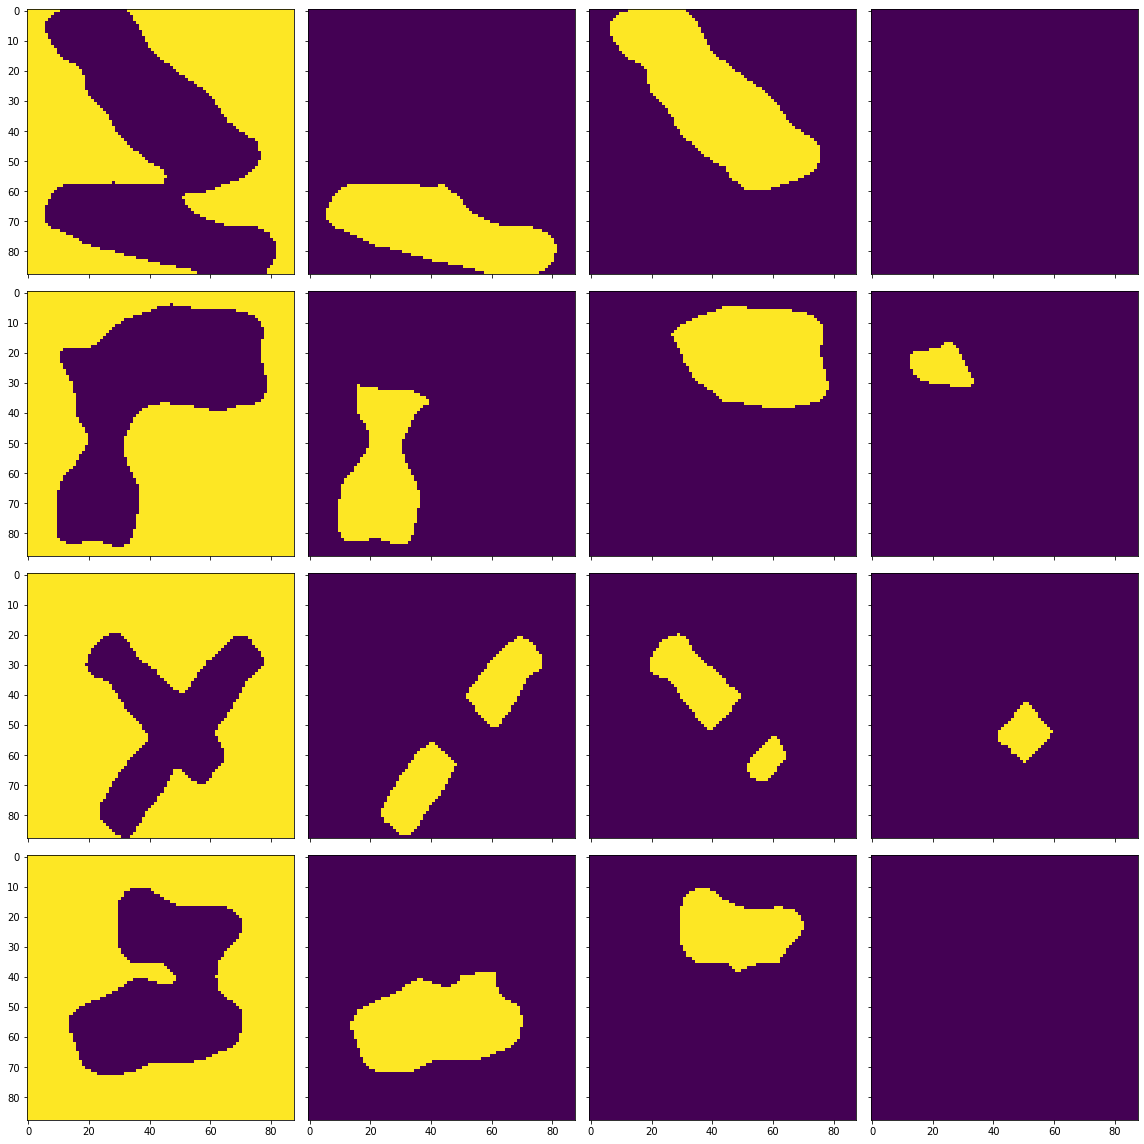

Training IOU: [0.9797170393474627, 0.9145173580838488, 0.896128234995649, 0.7903353015155714]
Training accuracy: 0.9637554881198347
Testing IOU: [0.9743335075797177, 0.532419463575196, 0.32044228068137415, 0.46497906357061286]
Testing accuracy: 0.877891270661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_158epoch\assets
4
4


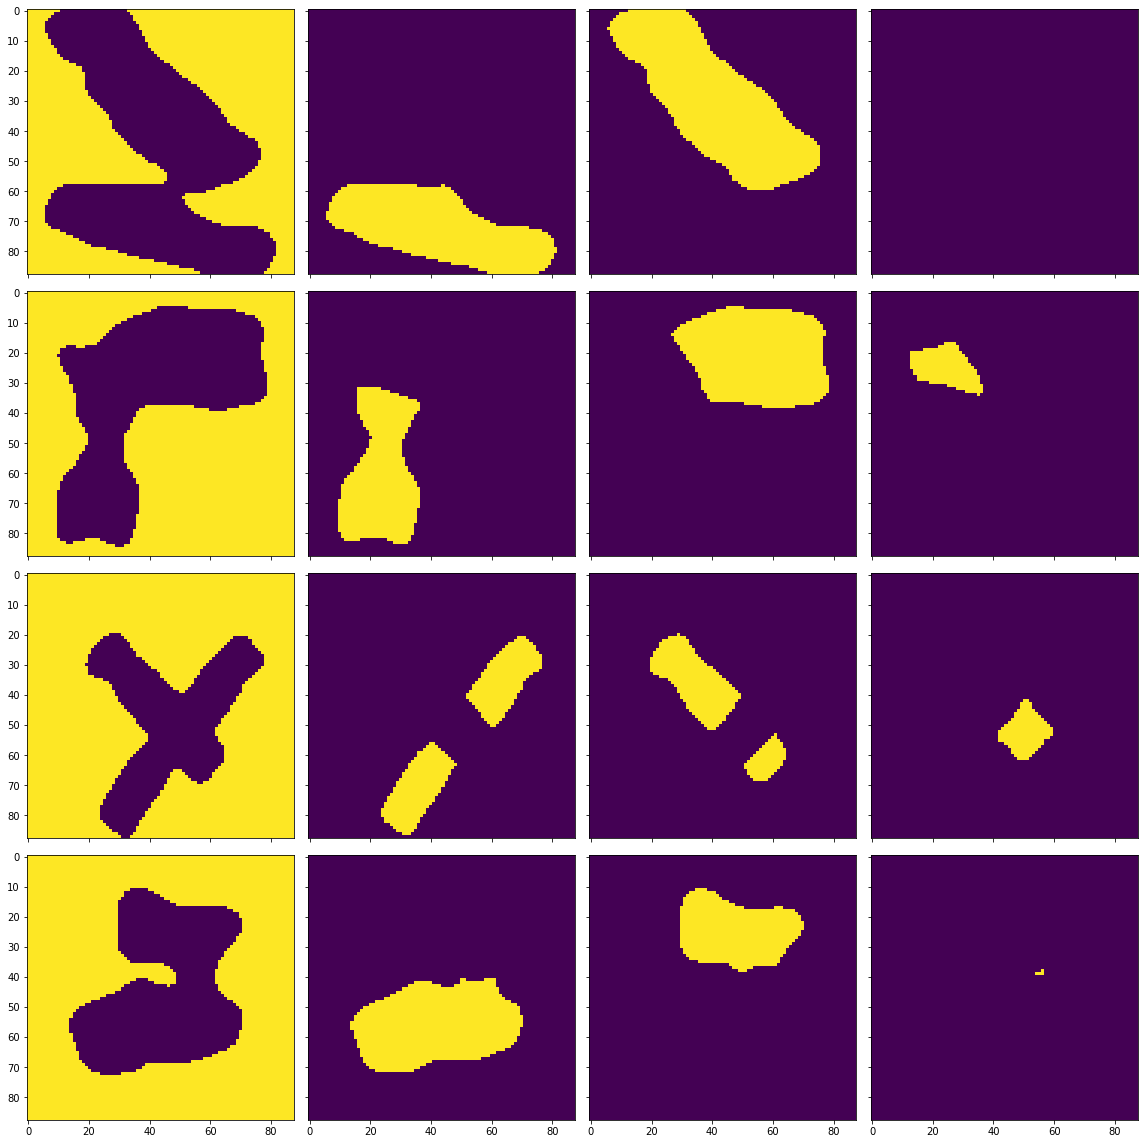

Training IOU: [0.9802092655519294, 0.9096713493470677, 0.9177501881727004, 0.8226309686940023]
Training accuracy: 0.9666858212809918
Testing IOU: [0.974858613436599, 0.5163869631826735, 0.3758291667496663, 0.4952482499652311]
Testing accuracy: 0.8808199896694214
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0516
INFO:tensorflow:Assets written to: modelseg/savedmodel_159epoch\assets
4
4


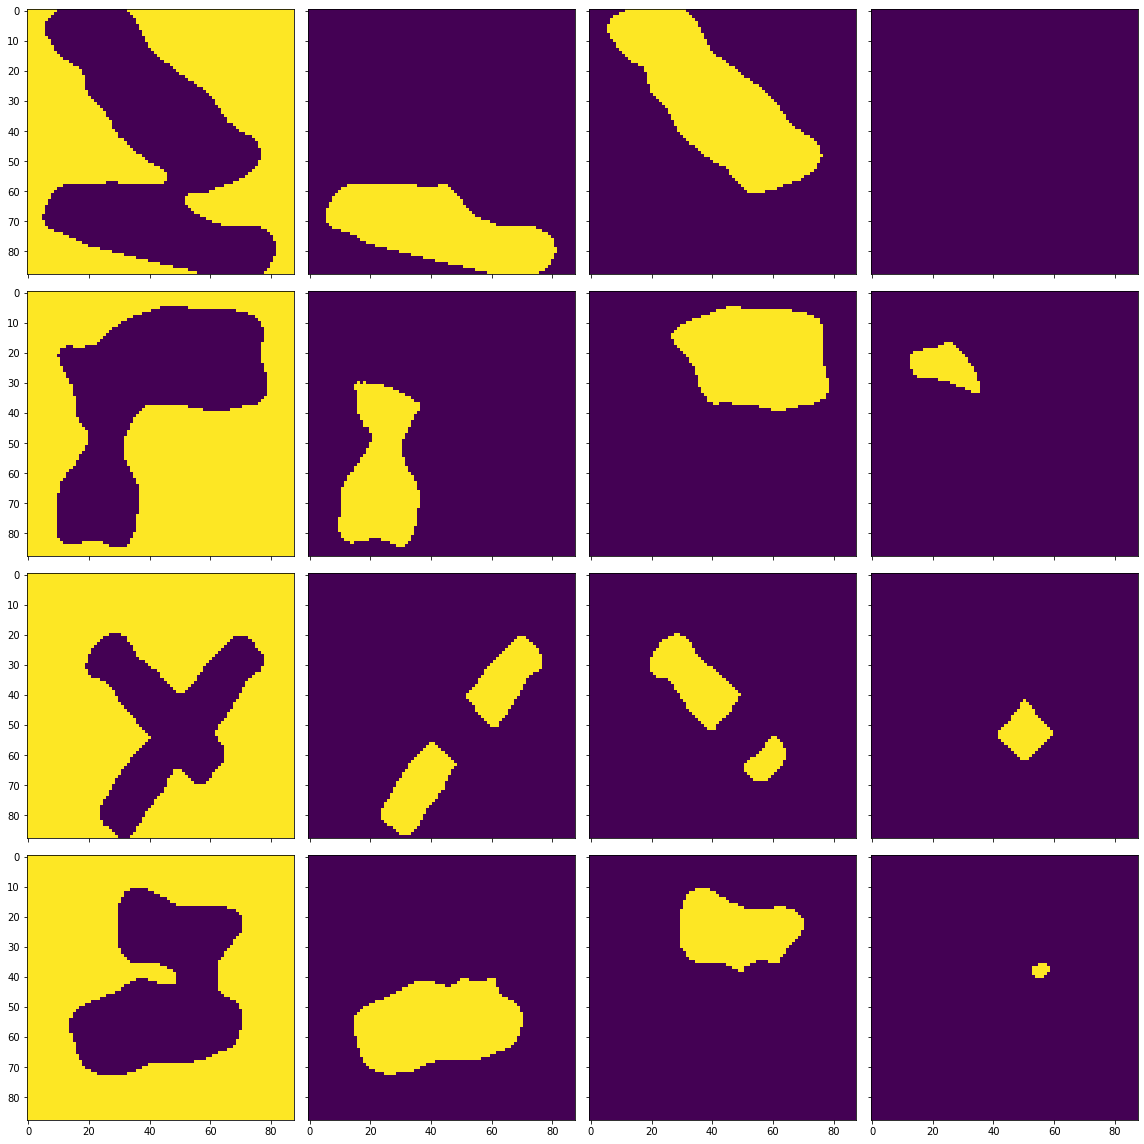

Training IOU: [0.9786092270999478, 0.9105555029897143, 0.916814557927243, 0.8074874254546998]
Training accuracy: 0.9646487603305786
Testing IOU: [0.9741347600444191, 0.5065434895297066, 0.38452737194155956, 0.4825152390118704]
Testing accuracy: 0.8780655991735538
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_160epoch\assets
4
4


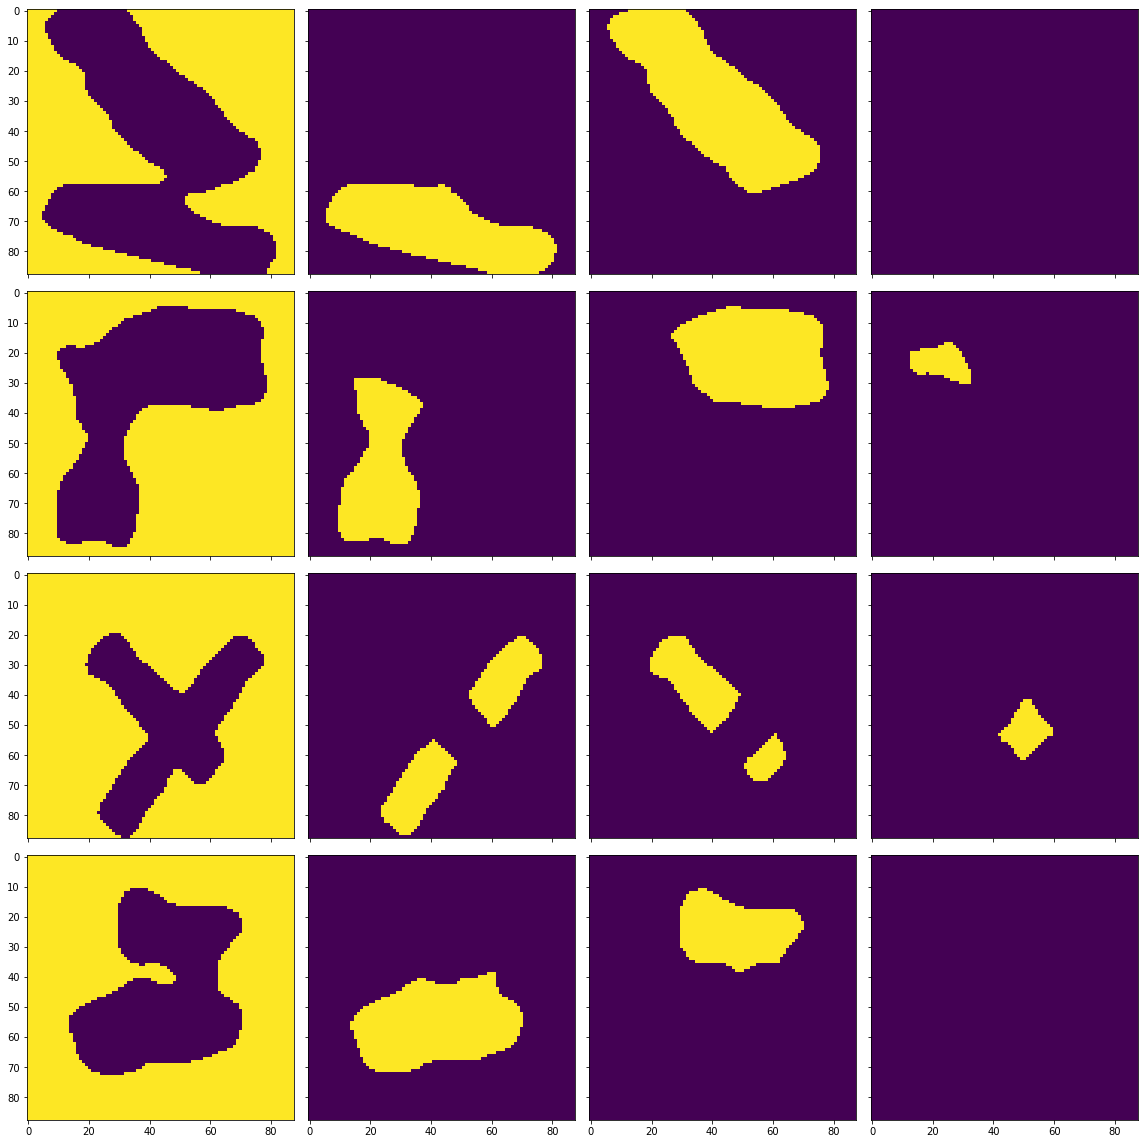

Training IOU: [0.9783759439954057, 0.9165636801734316, 0.9188951213148969, 0.7897766175967135]
Training accuracy: 0.9649916064049586
Testing IOU: [0.9734091875649258, 0.5128762459464973, 0.3968196140212682, 0.4607142857142857]
Testing accuracy: 0.8796926652892562
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0495
INFO:tensorflow:Assets written to: modelseg/savedmodel_161epoch\assets
4
4


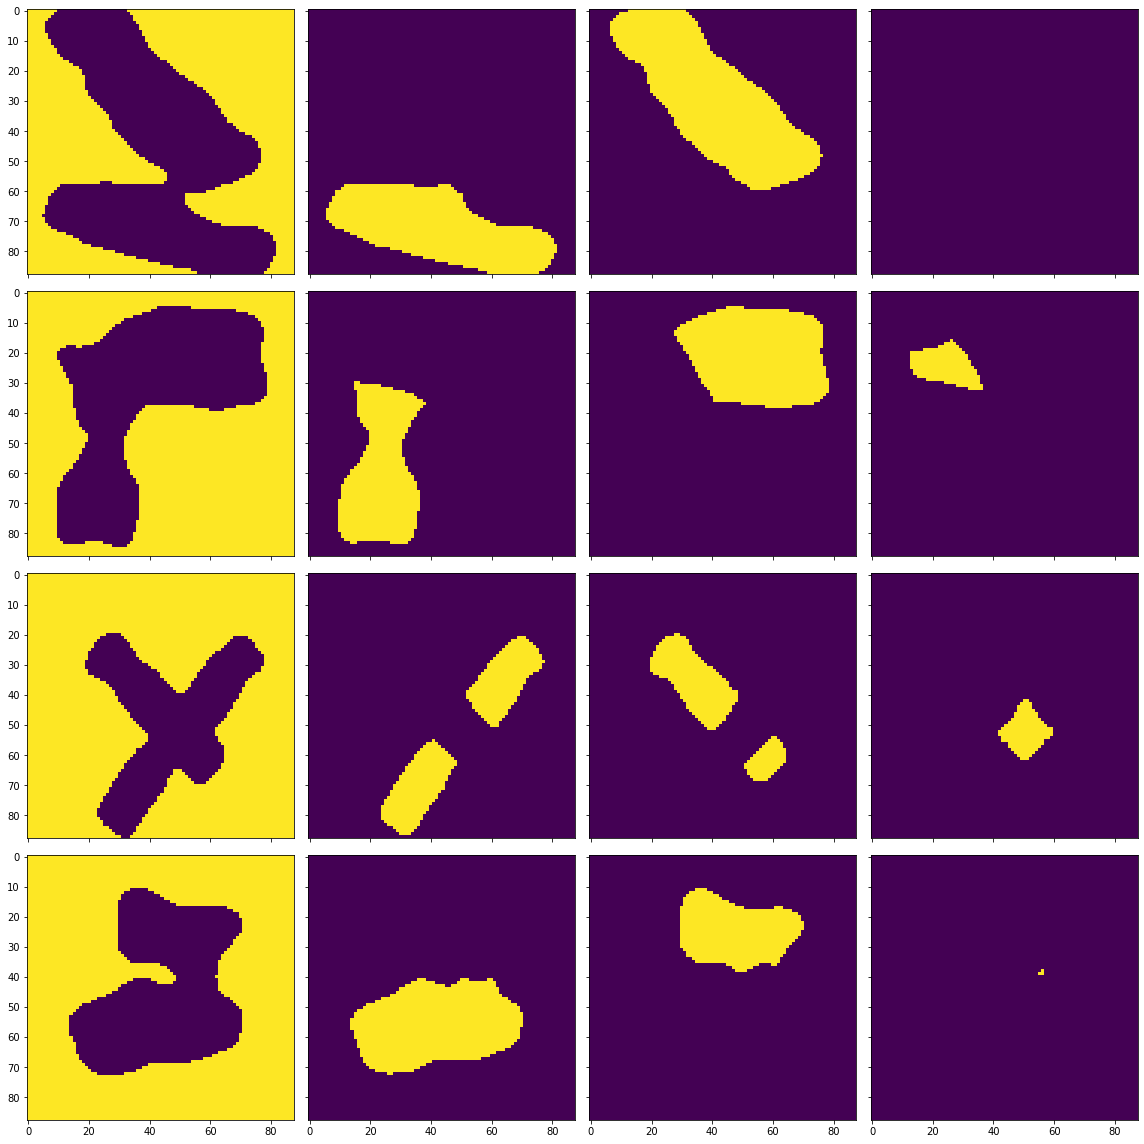

Training IOU: [0.9782874414349153, 0.9212575043276491, 0.9154927659018037, 0.8270512780006951]
Training accuracy: 0.9658396823347107
Testing IOU: [0.9739050922936785, 0.5156168034820581, 0.3877310574933418, 0.4917678216729199]
Testing accuracy: 0.8795803202479339
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_162epoch\assets
4
4


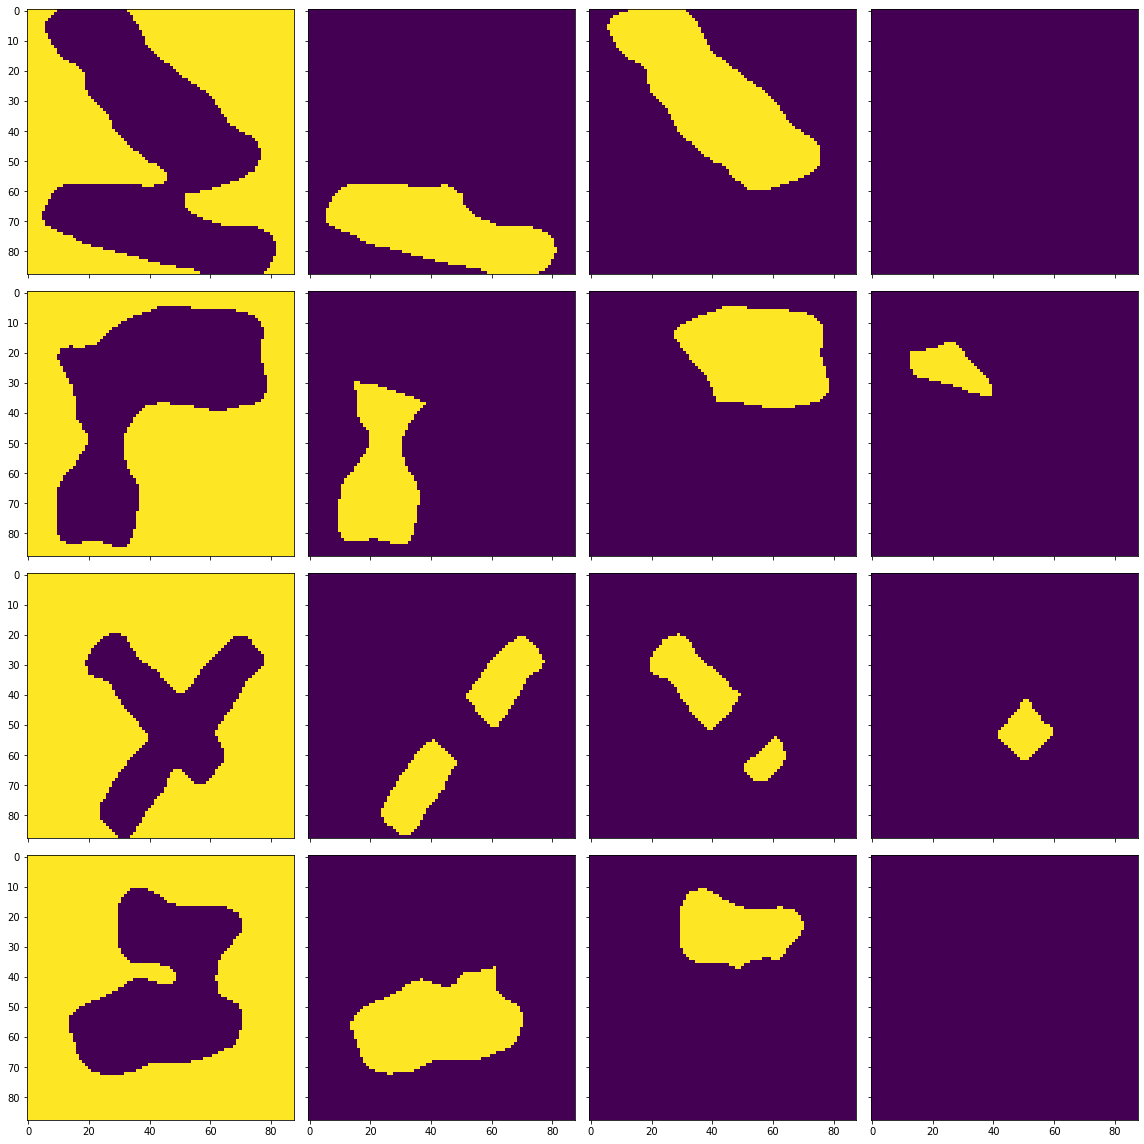

Training IOU: [0.980064688783403, 0.9159193161194807, 0.9096152692896902, 0.8153633203588452]
Training accuracy: 0.9662351497933884
Testing IOU: [0.9747339776868776, 0.4946236559139785, 0.4021087490246084, 0.4756375329373409]
Testing accuracy: 0.8795105888429752
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0690 - val_loss: 0.0497
INFO:tensorflow:Assets written to: modelseg/savedmodel_163epoch\assets
4
4


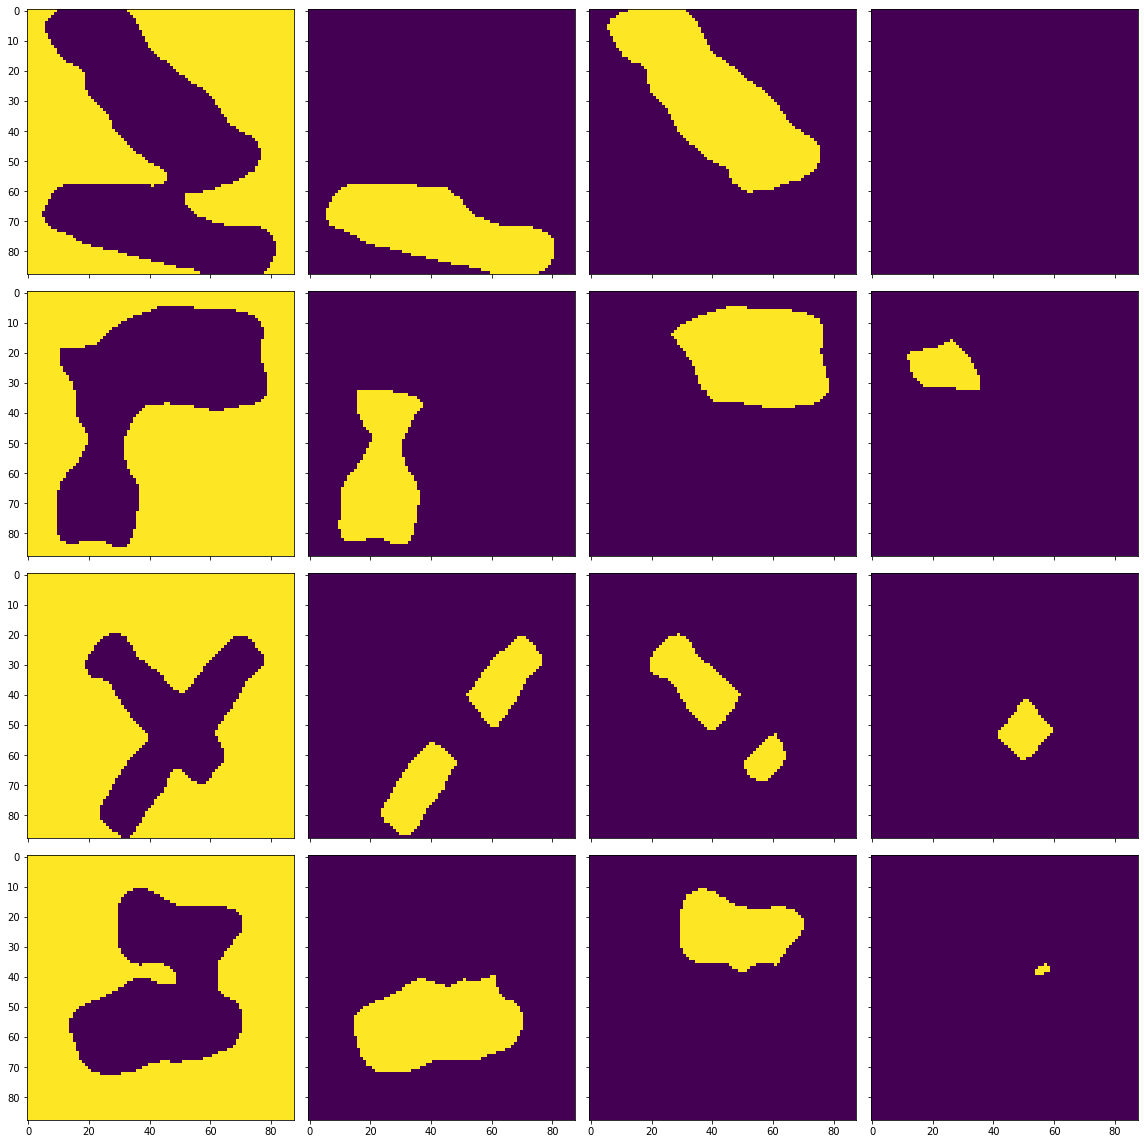

Training IOU: [0.9802052526035743, 0.9094179414052372, 0.9188653169157776, 0.8414778006284516]
Training accuracy: 0.9670932334710743
Testing IOU: [0.9747220945296502, 0.5118055606271955, 0.4102601649826719, 0.49628825700021706]
Testing accuracy: 0.8823811983471075
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_164epoch\assets
4
4


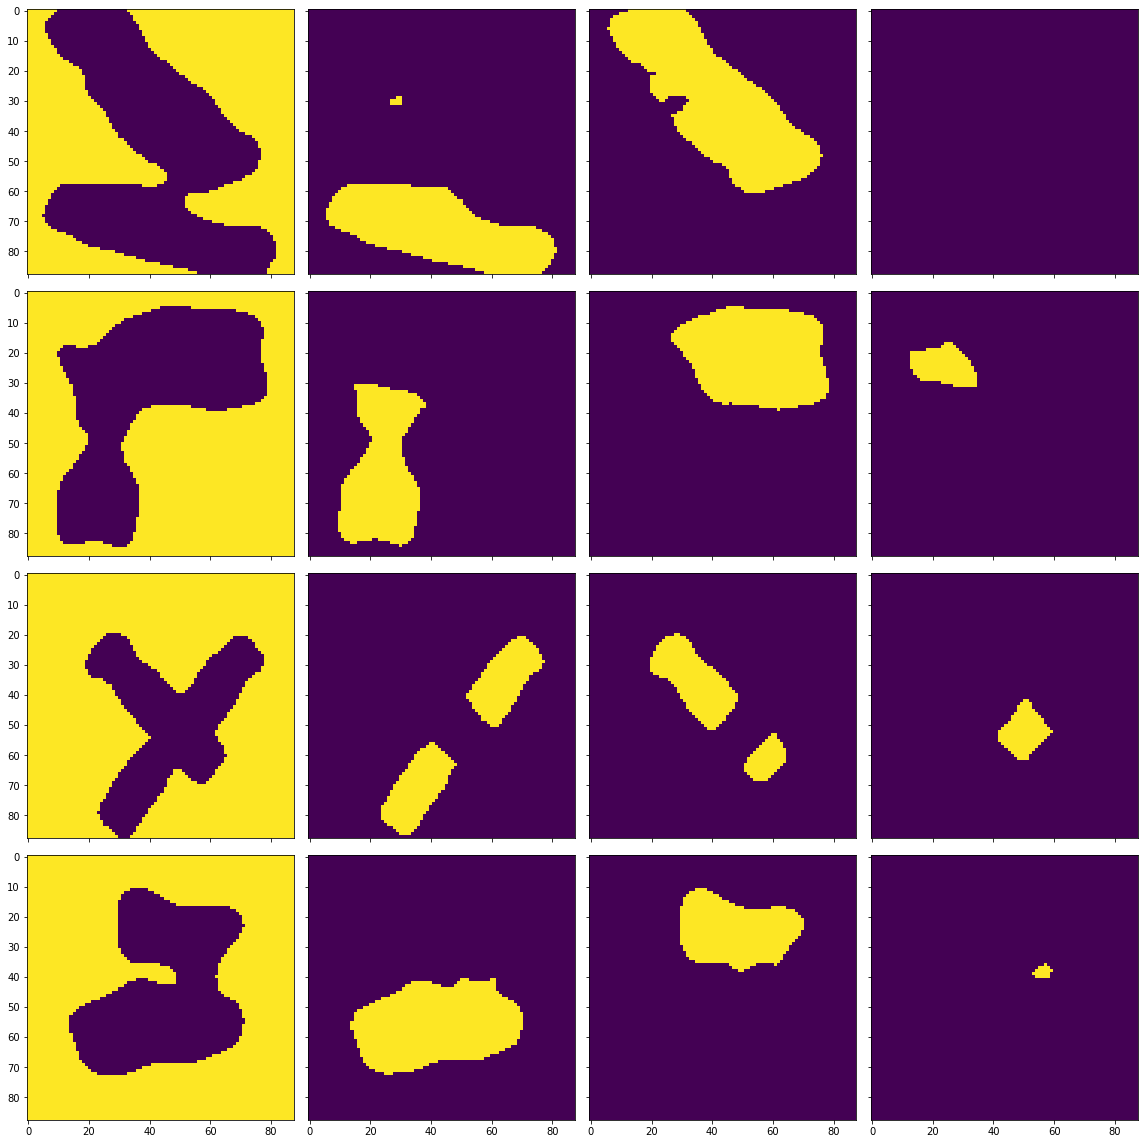

Training IOU: [0.9784341297008083, 0.9216243449759107, 0.918512077819743, 0.8229494684785595]
Training accuracy: 0.9667755681818182
Testing IOU: [0.9739125729983699, 0.5255410080727223, 0.3562609514742077, 0.48222690394011386]
Testing accuracy: 0.879923811983471
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_165epoch\assets
4
4


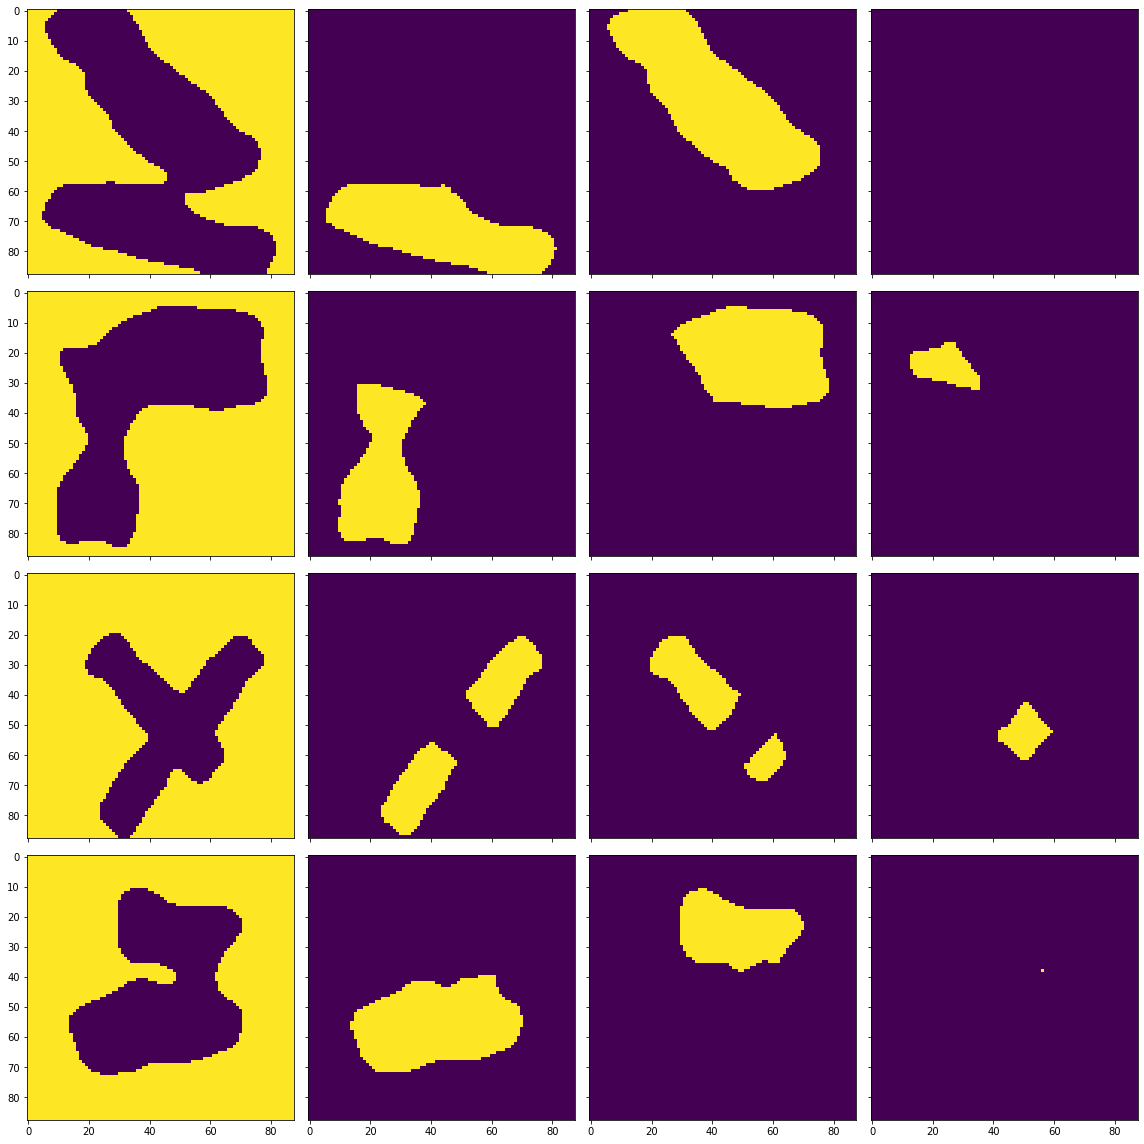

Training IOU: [0.9798762311889682, 0.9179033735061731, 0.913241685627478, 0.784669611098574]
Training accuracy: 0.9651029829545454
Testing IOU: [0.9745967123516863, 0.5192563821849701, 0.38020879984872463, 0.454218520796858]
Testing accuracy: 0.8800038739669421
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0511
INFO:tensorflow:Assets written to: modelseg/savedmodel_166epoch\assets
4
4


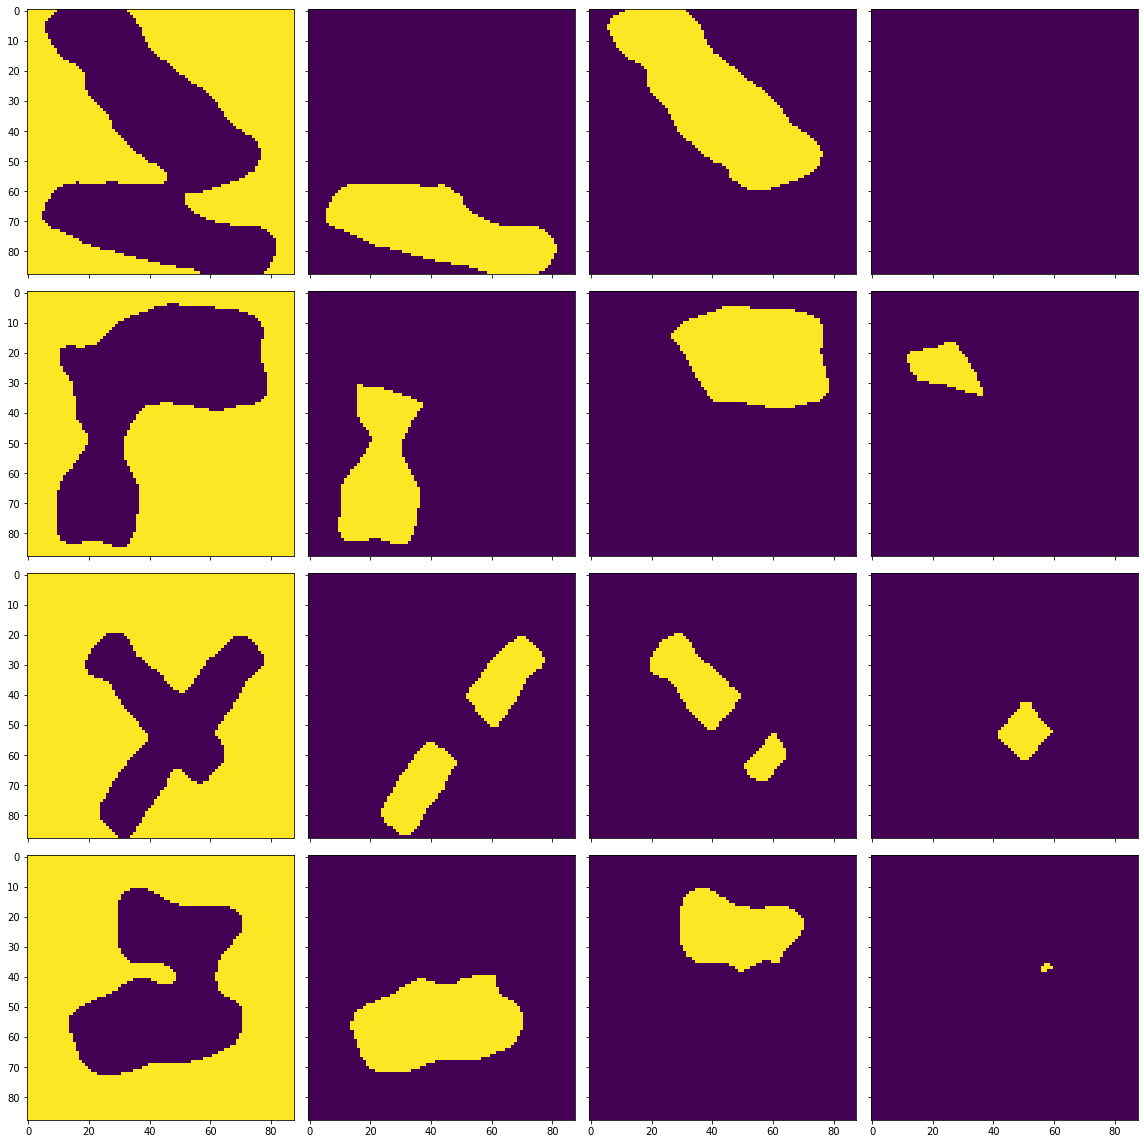

Training IOU: [0.9790858205016366, 0.9184927889217172, 0.9213858079580782, 0.8252759882329372]
Training accuracy: 0.9670341554752067
Testing IOU: [0.9741432071211236, 0.5123909502262444, 0.41535728006146755, 0.468404027518338]
Testing accuracy: 0.8819447314049587
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0691 - val_loss: 0.0525
INFO:tensorflow:Assets written to: modelseg/savedmodel_167epoch\assets
4
4


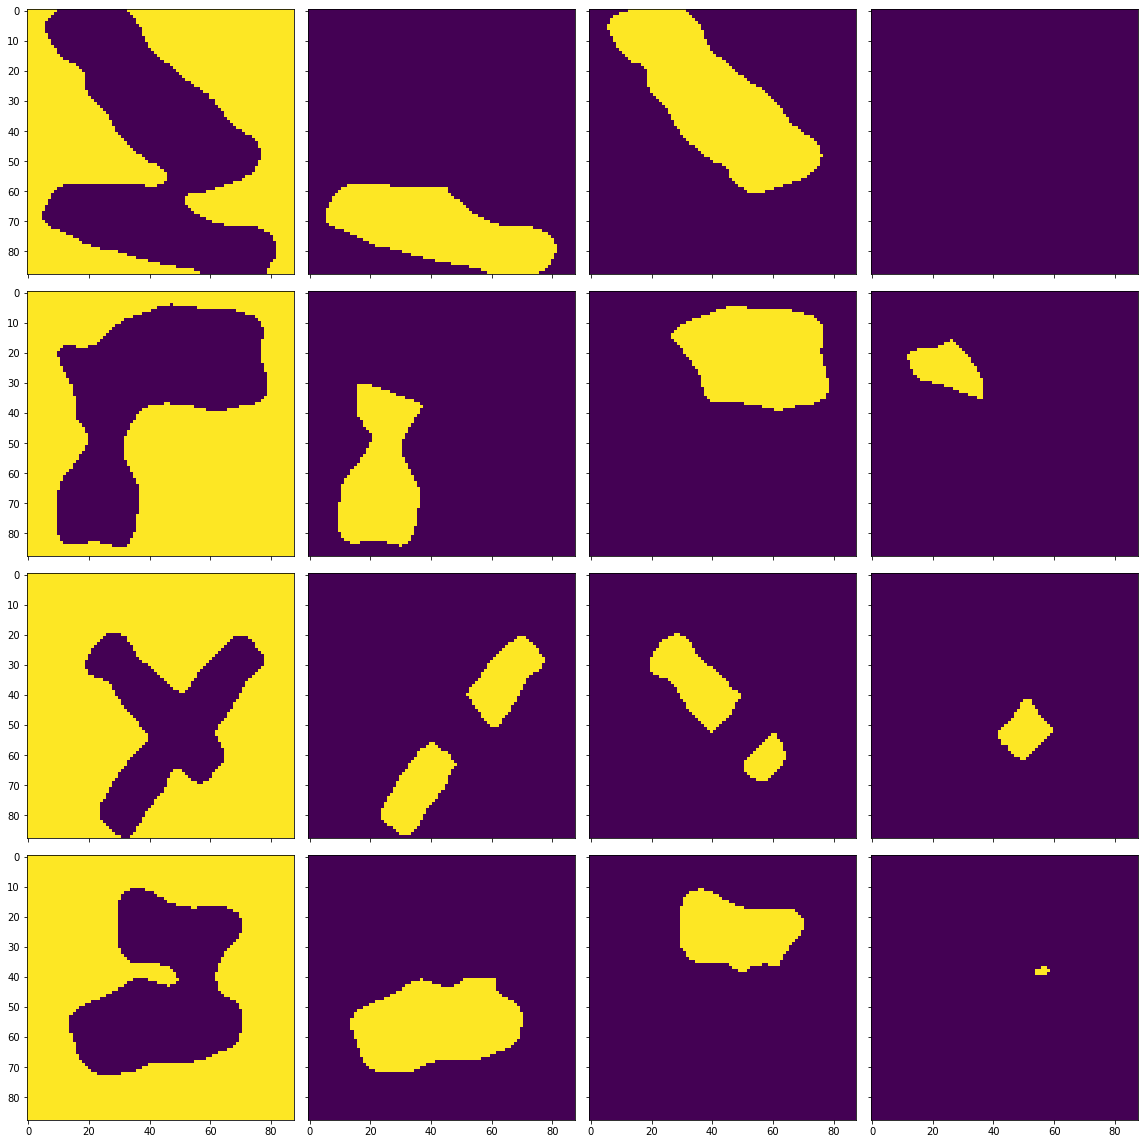

Training IOU: [0.9792060729245039, 0.9118214365008881, 0.9258400989590929, 0.8310088087248322]
Training accuracy: 0.9672908057851239
Testing IOU: [0.9742479394167608, 0.48094754503708936, 0.4184293459998002, 0.48325380390744577]
Testing accuracy: 0.8794085743801653
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0491
INFO:tensorflow:Assets written to: modelseg/savedmodel_168epoch\assets
4
4


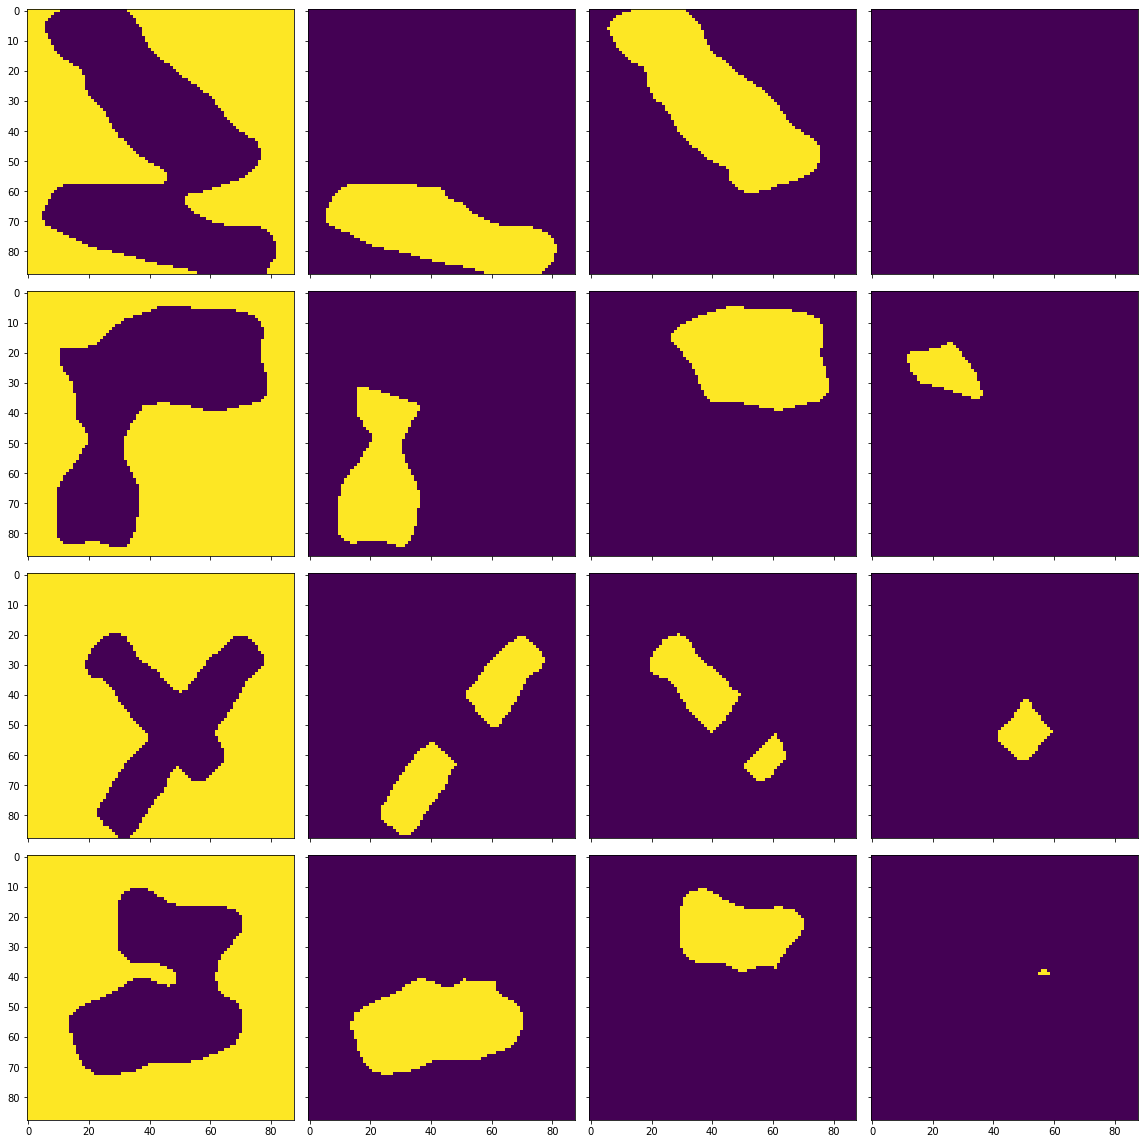

Training IOU: [0.9789180022237447, 0.9094712178202523, 0.9195553164199222, 0.8332827495264309]
Training accuracy: 0.9657221720041322
Testing IOU: [0.9740939688583667, 0.49552784535376637, 0.4077142092792173, 0.4723812804064236]
Testing accuracy: 0.8786053719008264
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0505
INFO:tensorflow:Assets written to: modelseg/savedmodel_169epoch\assets
4
4


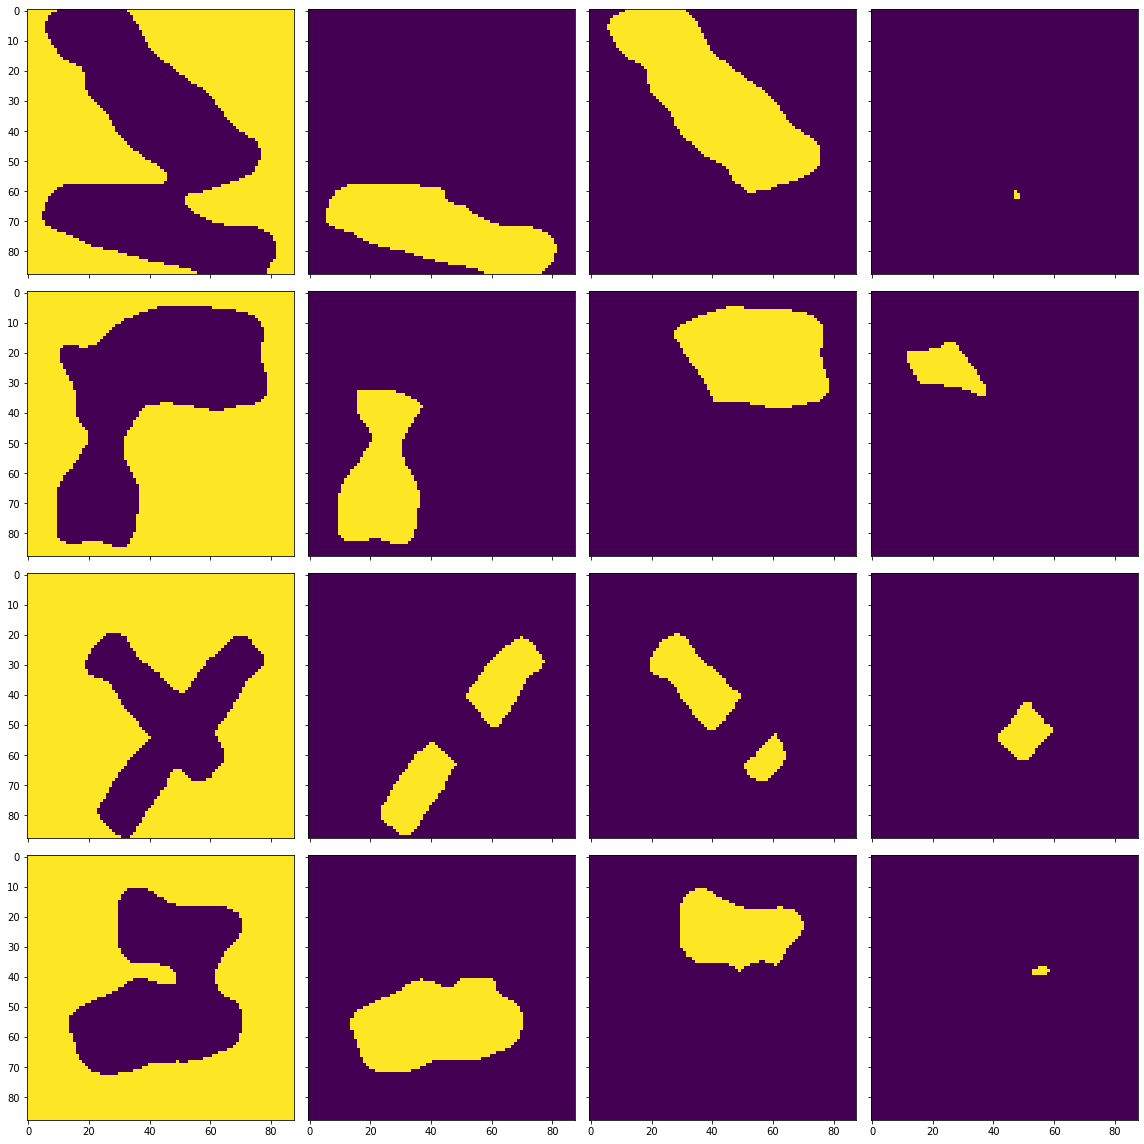

Training IOU: [0.9797717406871485, 0.9130896359771704, 0.913410845736136, 0.8252424101282975]
Training accuracy: 0.9655294421487604
Testing IOU: [0.9743184911394699, 0.5083728739324038, 0.4236804427831535, 0.47245097593157104]
Testing accuracy: 0.8822546487603306
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0691 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_170epoch\assets
4
4


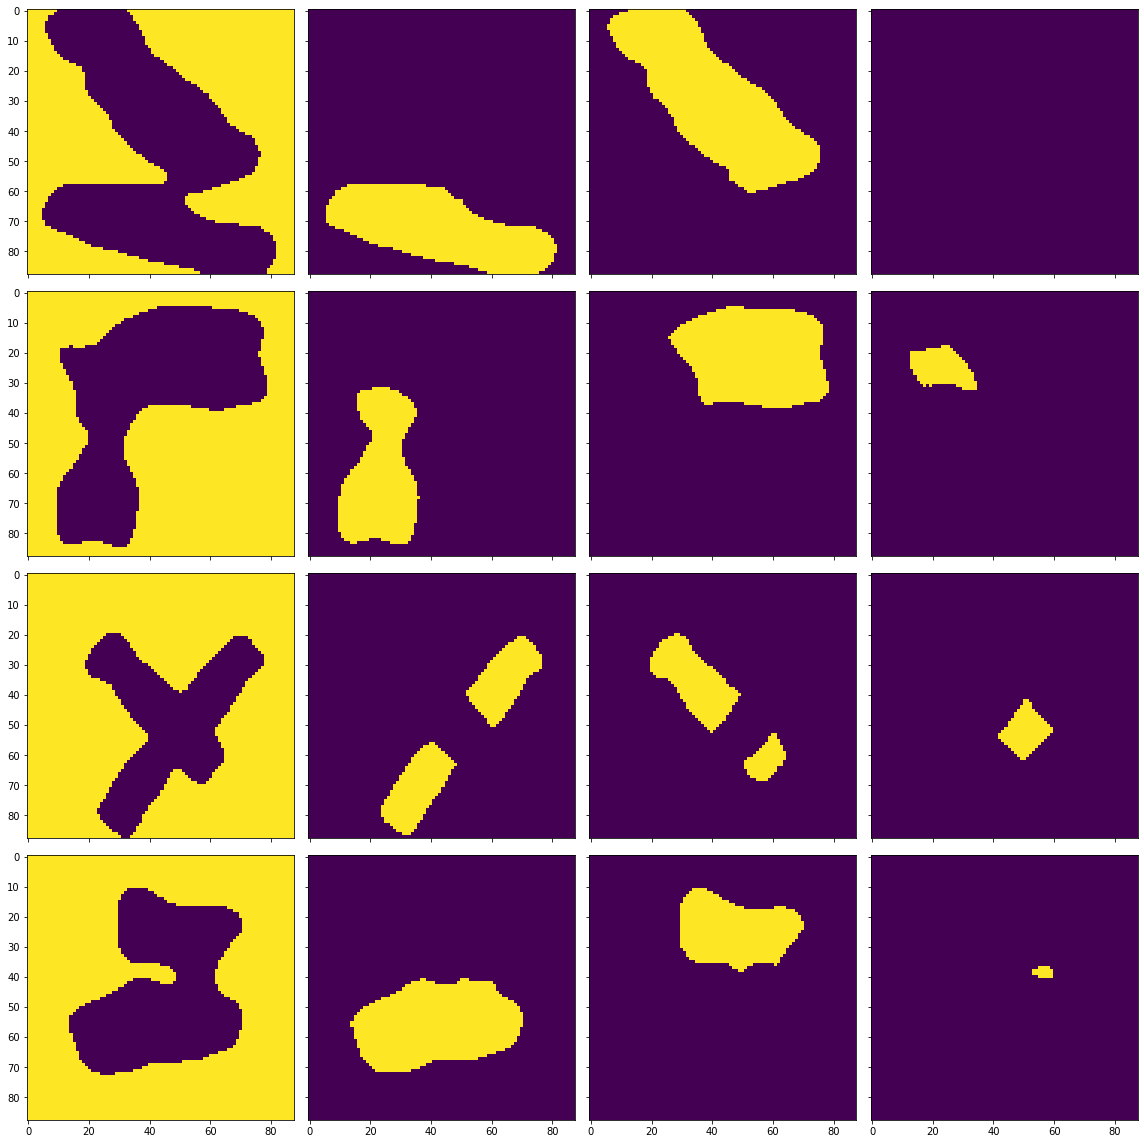

Training IOU: [0.9791736450050065, 0.9123187217122697, 0.9201126414473774, 0.7966298725537247]
Training accuracy: 0.9648837809917356
Testing IOU: [0.9739492298389275, 0.48405600128604204, 0.4064451025142879, 0.46388131441512226]
Testing accuracy: 0.8758664772727273
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0545
INFO:tensorflow:Assets written to: modelseg/savedmodel_171epoch\assets
4
4


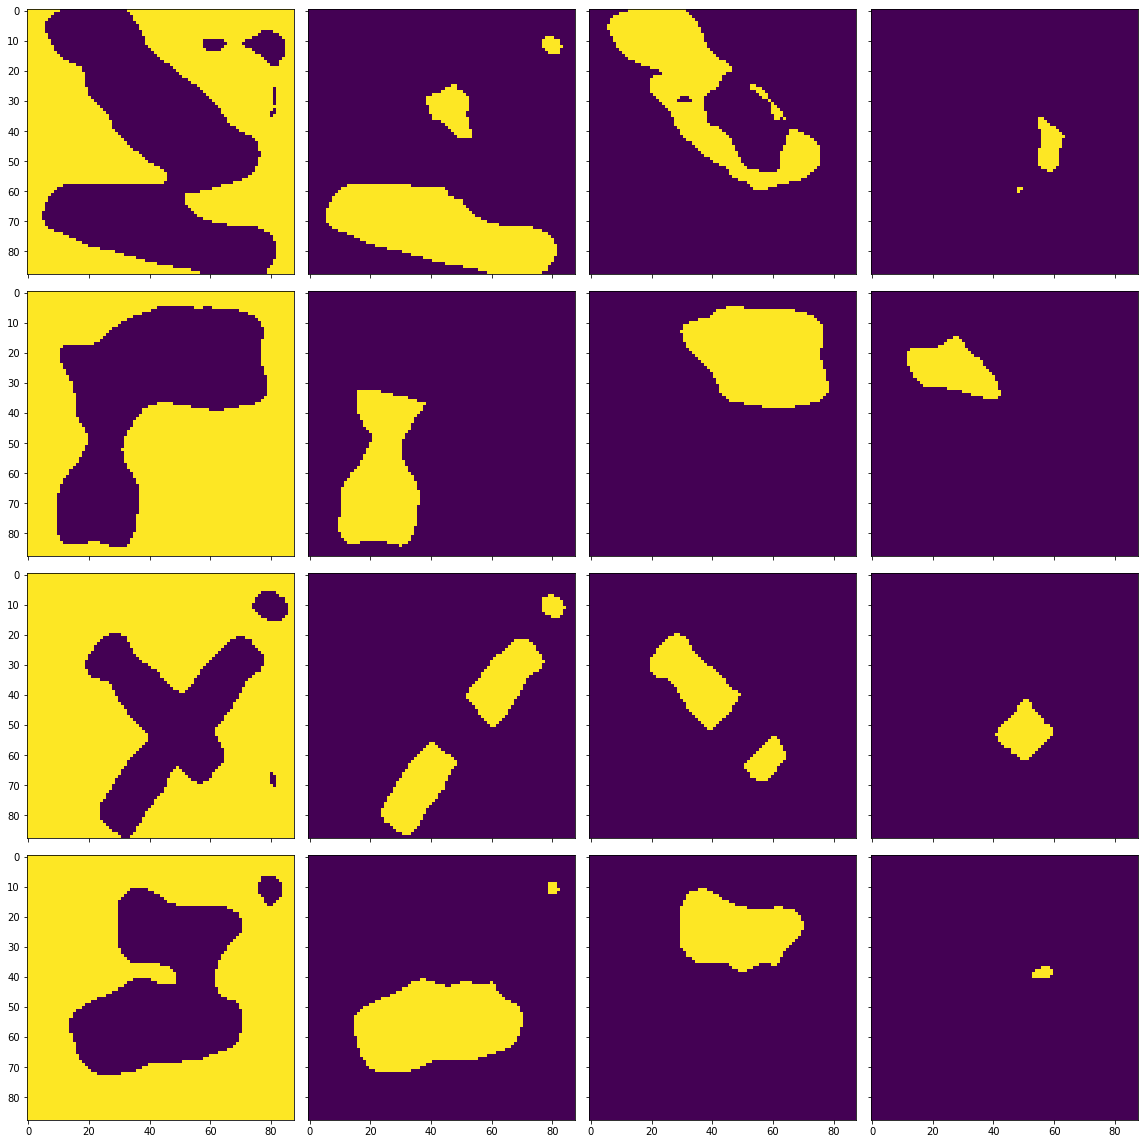

Training IOU: [0.9593916669882463, 0.8731513173244417, 0.9040057750718479, 0.8351650551518427]
Training accuracy: 0.9487477401859504
Testing IOU: [0.95574571062963, 0.4415529905561385, 0.41339698780161227, 0.48568628251725404]
Testing accuracy: 0.8581340392561984
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0505
INFO:tensorflow:Assets written to: modelseg/savedmodel_172epoch\assets
4
4


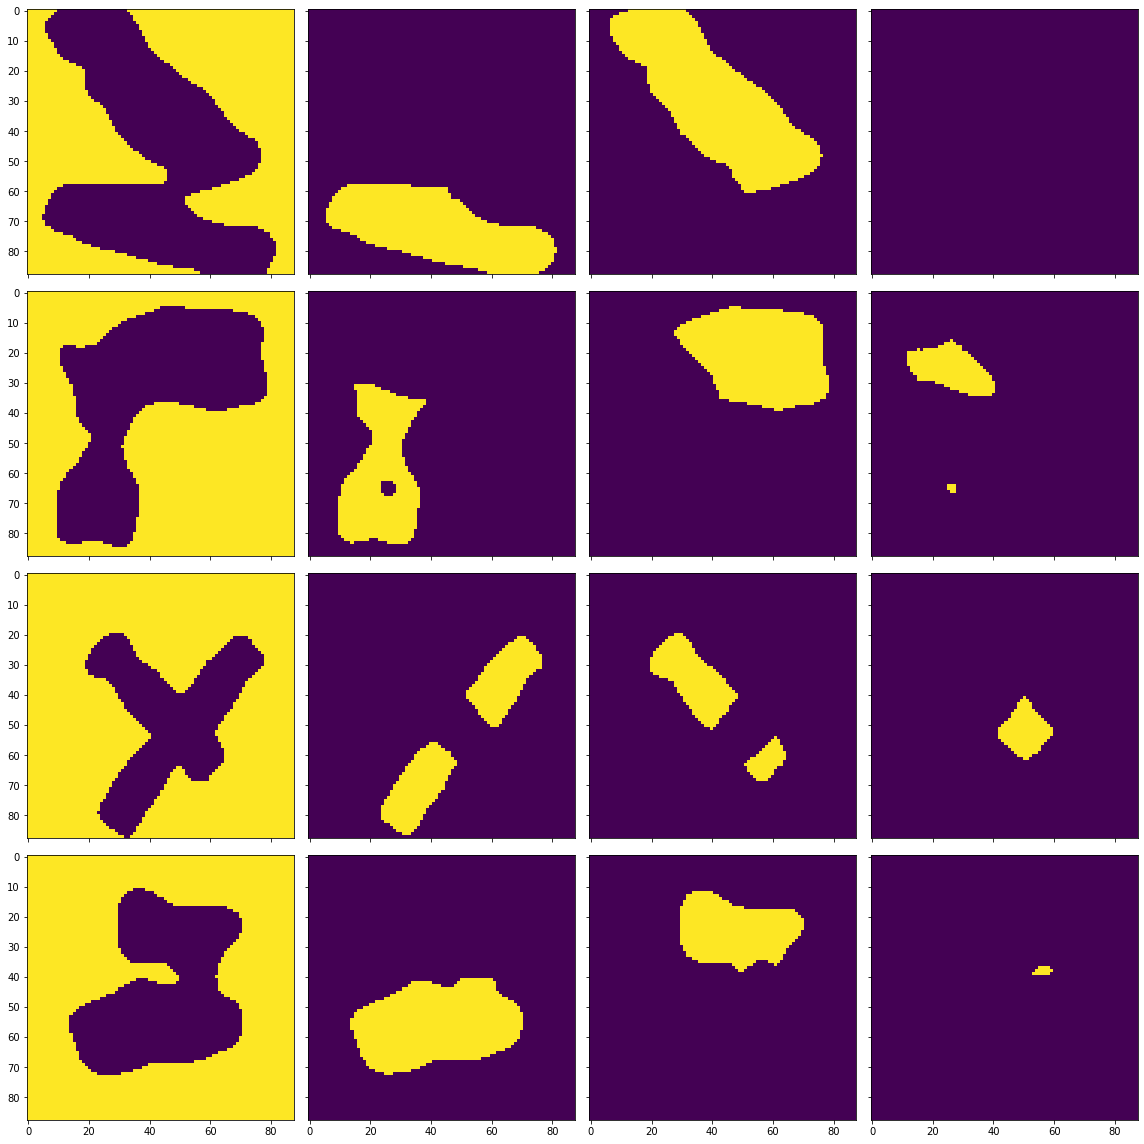

Training IOU: [0.9806582387472028, 0.9118576682697302, 0.8929026797537303, 0.8343480723330232]
Training accuracy: 0.9656663223140496
Testing IOU: [0.9745326252874044, 0.48043449326372767, 0.4116440815709399, 0.4903758400398241]
Testing accuracy: 0.8784375
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0695 - val_loss: 0.0510
INFO:tensorflow:Assets written to: modelseg/savedmodel_173epoch\assets
4
4


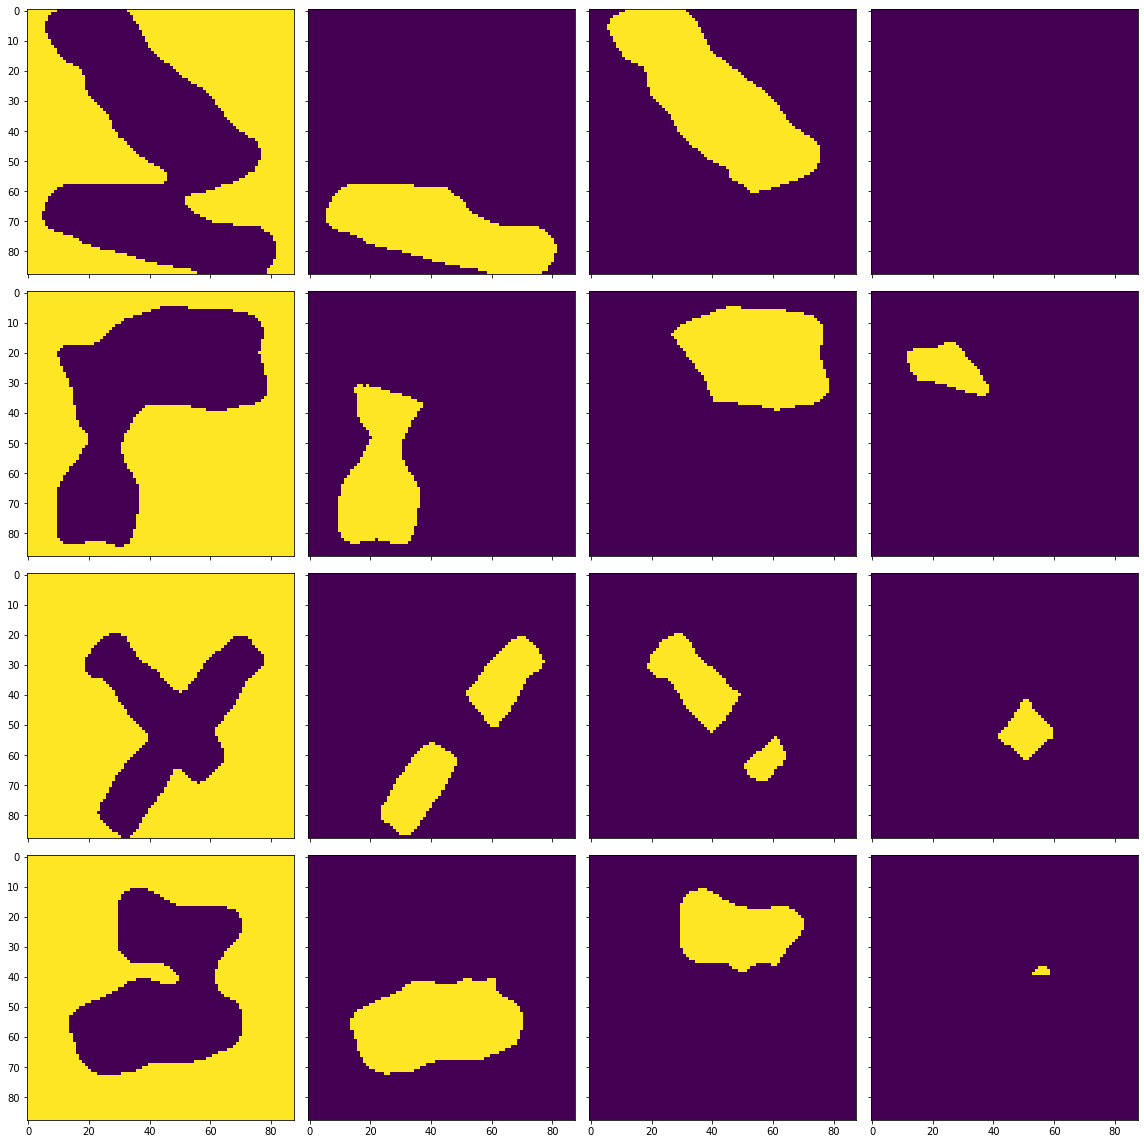

Training IOU: [0.9788738531924625, 0.9222246506010238, 0.9184033910279054, 0.8166345637689855]
Training accuracy: 0.9670034865702479
Testing IOU: [0.9741015951296839, 0.483874642251997, 0.3853288443323236, 0.4625625487765689]
Testing accuracy: 0.8751446280991736
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0487
INFO:tensorflow:Assets written to: modelseg/savedmodel_174epoch\assets
4
4


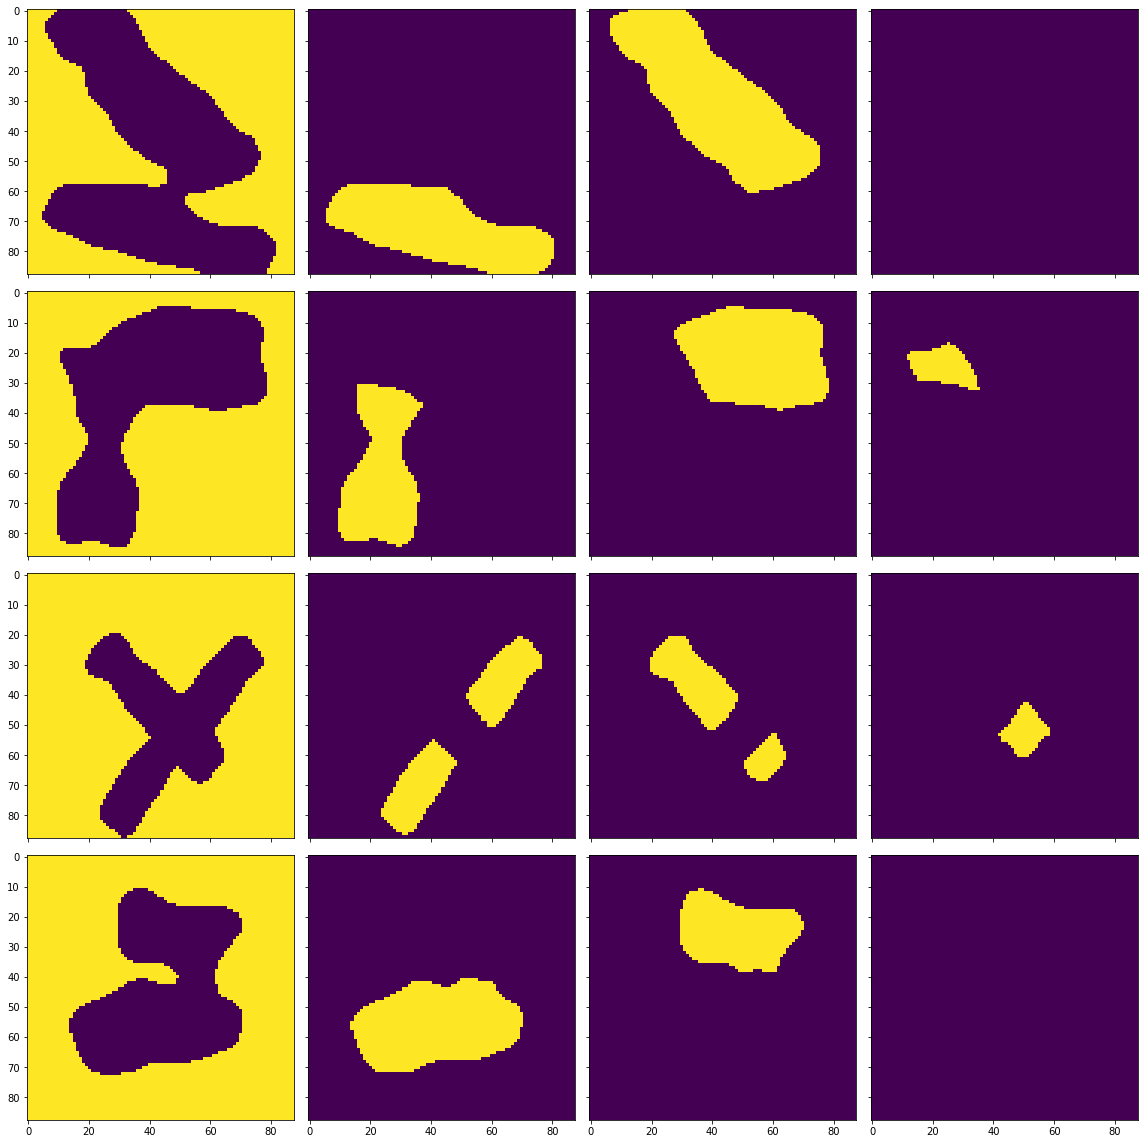

Training IOU: [0.981217317989793, 0.913936601871385, 0.9197603491745059, 0.7462904481744247]
Training accuracy: 0.9659701058884298
Testing IOU: [0.9750887450407183, 0.4949906257323647, 0.4119467053183187, 0.43492666764118304]
Testing accuracy: 0.8796681301652892
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0695 - val_loss: 0.0514
INFO:tensorflow:Assets written to: modelseg/savedmodel_175epoch\assets
4
4


Training IOU: [0.9796700179370303, 0.9216111665920543, 0.9101893145825898, 0.8174302007589409]
Training accuracy: 0.9663988248966943
Testing IOU: [0.9742739645754707, 0.5344279731436549, 0.34099768610201997, 0.47524521251751517]
Testing accuracy: 0.8805810950413223
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0636
INFO:tensorflow:Assets written to: modelseg/savedmodel_176epoch\assets
4
4


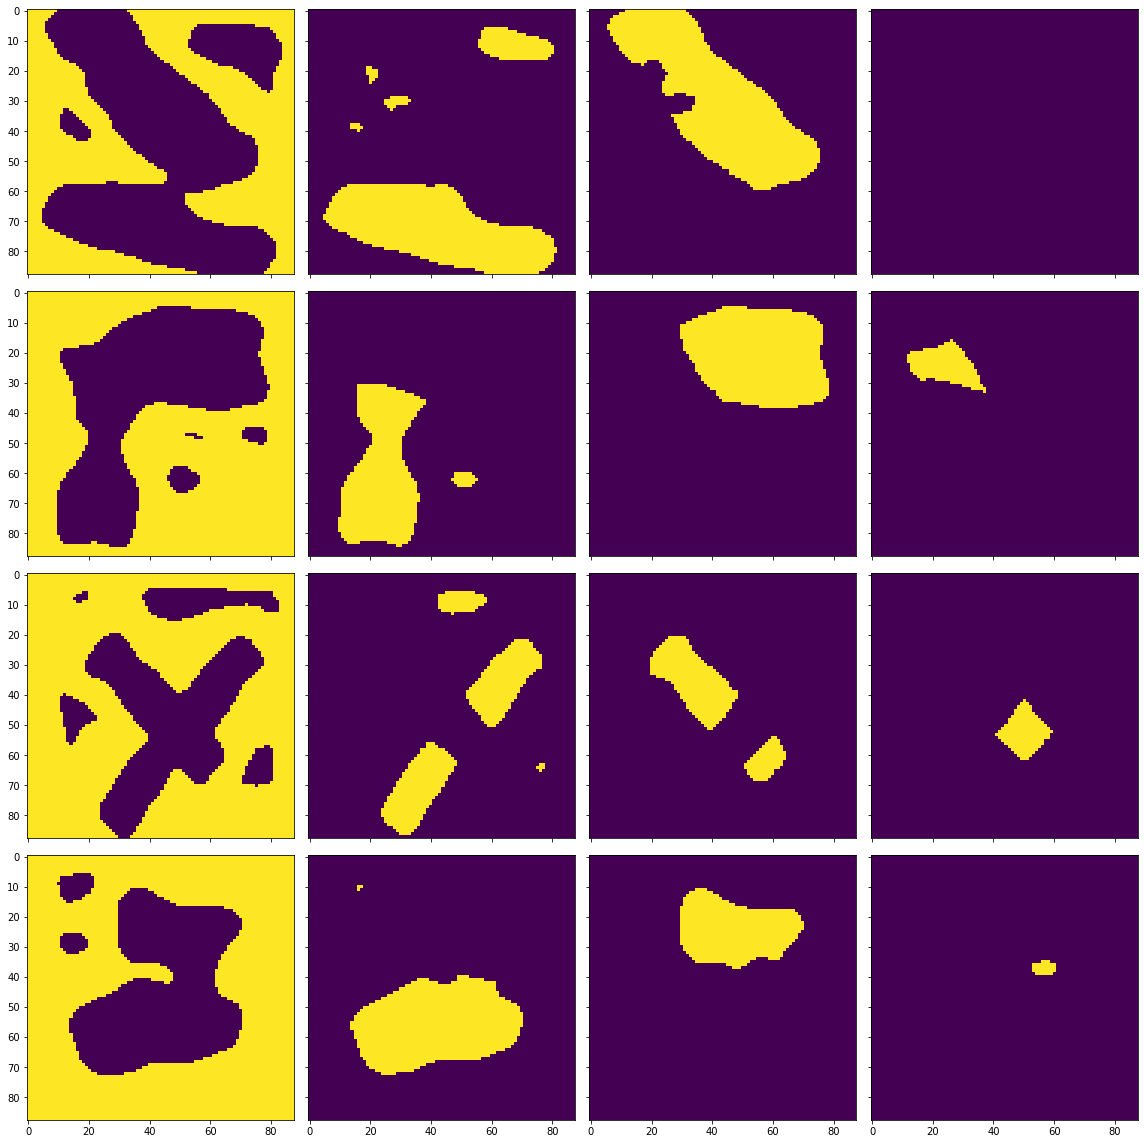

Training IOU: [0.8879975331494266, 0.8181887337090271, 0.8961512634166946, 0.7980880832295777]
Training accuracy: 0.8984265237603306
Testing IOU: [0.8787709283035702, 0.47760748281164617, 0.38321764799744695, 0.46423998536674593]
Testing accuracy: 0.8109969008264463
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0693 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_177epoch\assets
4
4


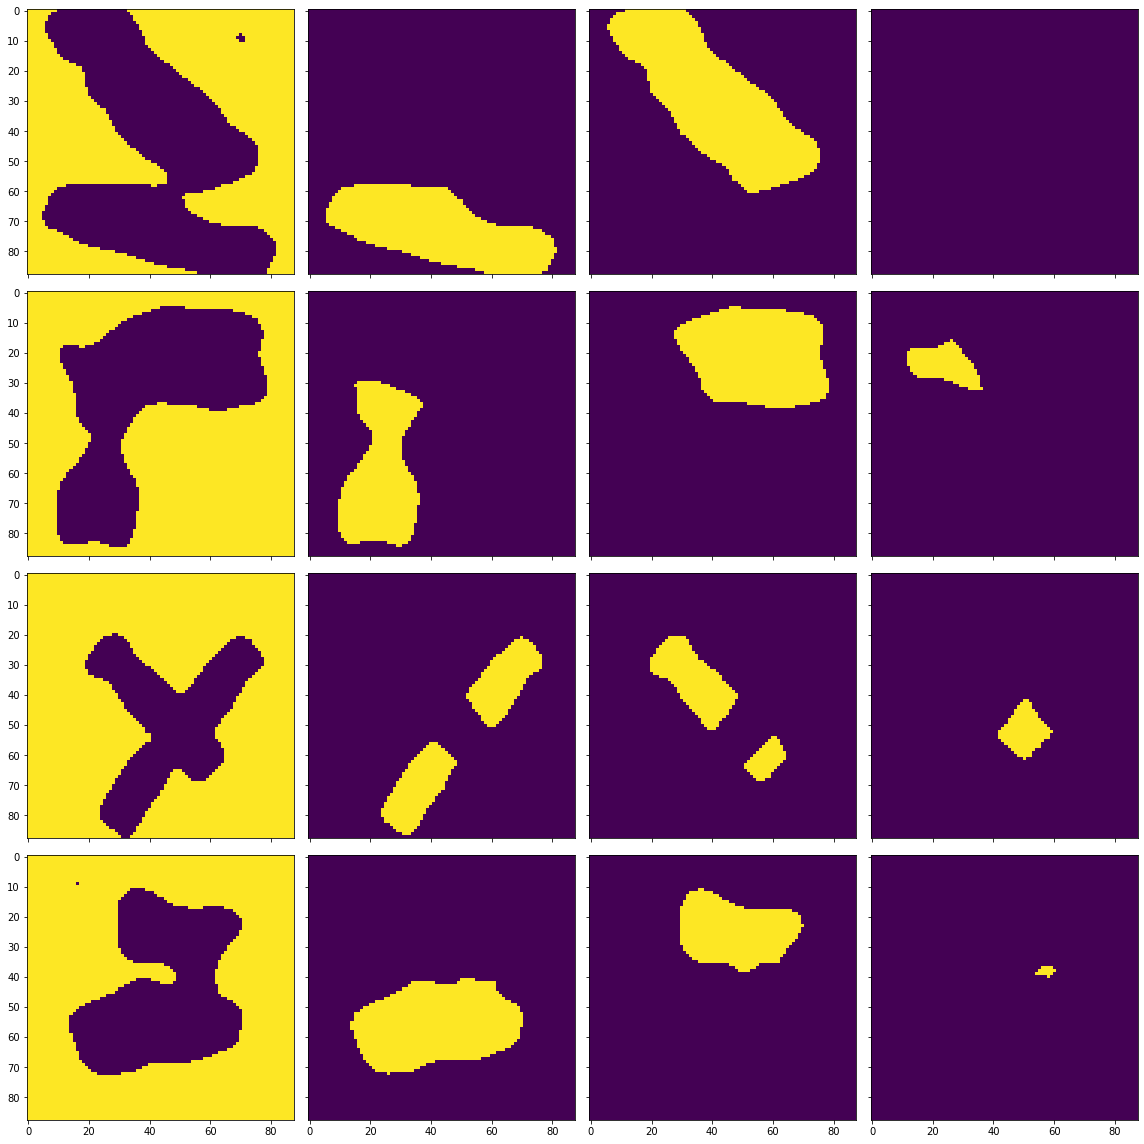

Training IOU: [0.9770731532371585, 0.9154456668525628, 0.9083928040642802, 0.8114094173305189]
Training accuracy: 0.9640912319214876
Testing IOU: [0.9703546067204577, 0.5004536005886092, 0.3925911070364428, 0.4668566356799178]
Testing accuracy: 0.8765728305785124
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0693 - val_loss: 0.0537
INFO:tensorflow:Assets written to: modelseg/savedmodel_178epoch\assets
4
4


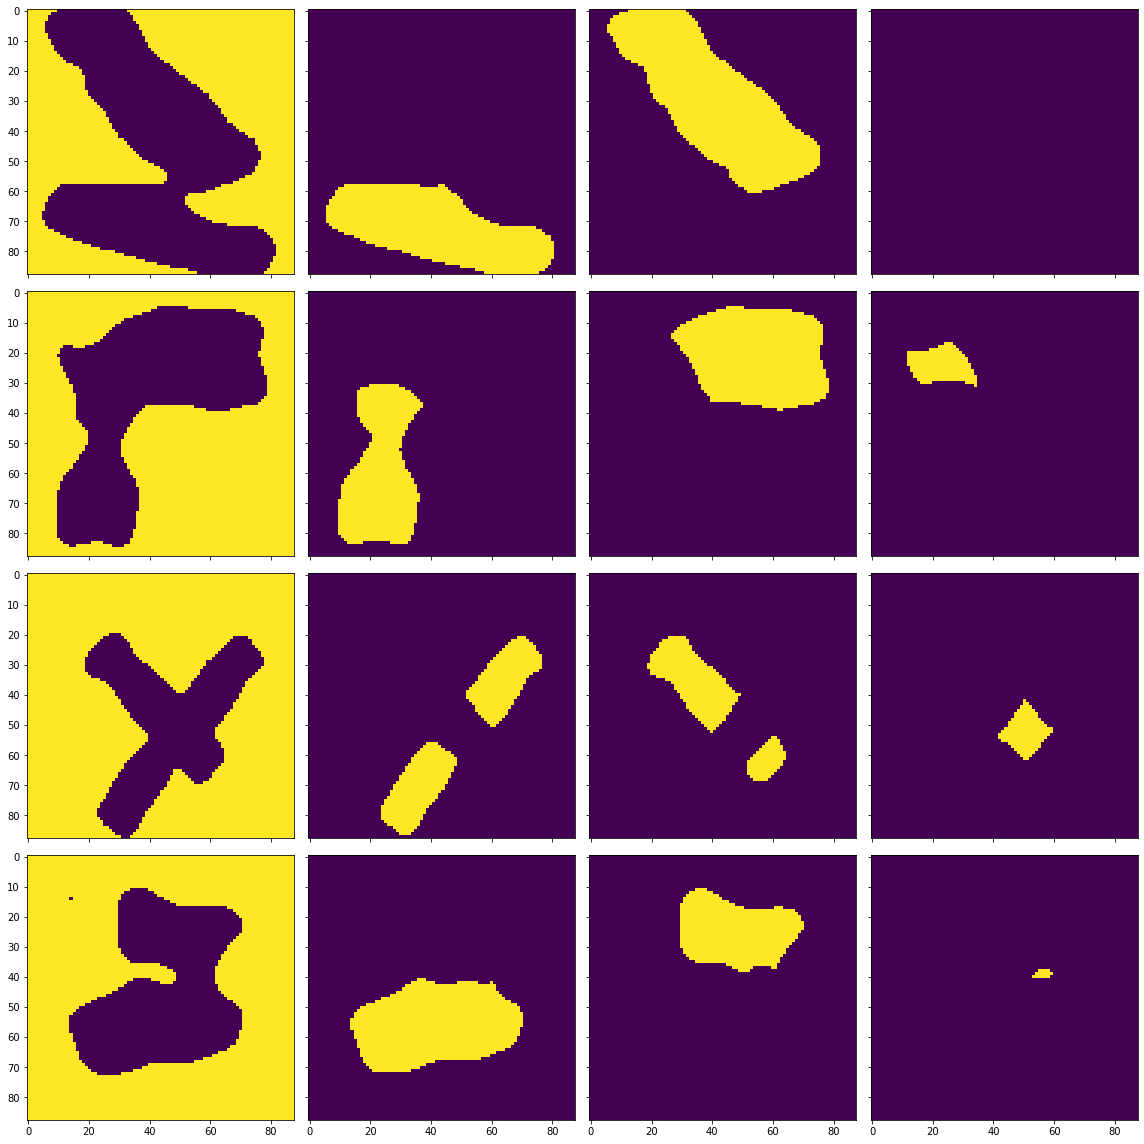

Training IOU: [0.9763322378614137, 0.9124159066607237, 0.9242401638343754, 0.800610278372591]
Training accuracy: 0.963529506714876
Testing IOU: [0.970928713057599, 0.44575306613104476, 0.42392125205072784, 0.44979789062862985]
Testing accuracy: 0.8708096590909091
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0692 - val_loss: 0.0500
INFO:tensorflow:Assets written to: modelseg/savedmodel_179epoch\assets
4
4


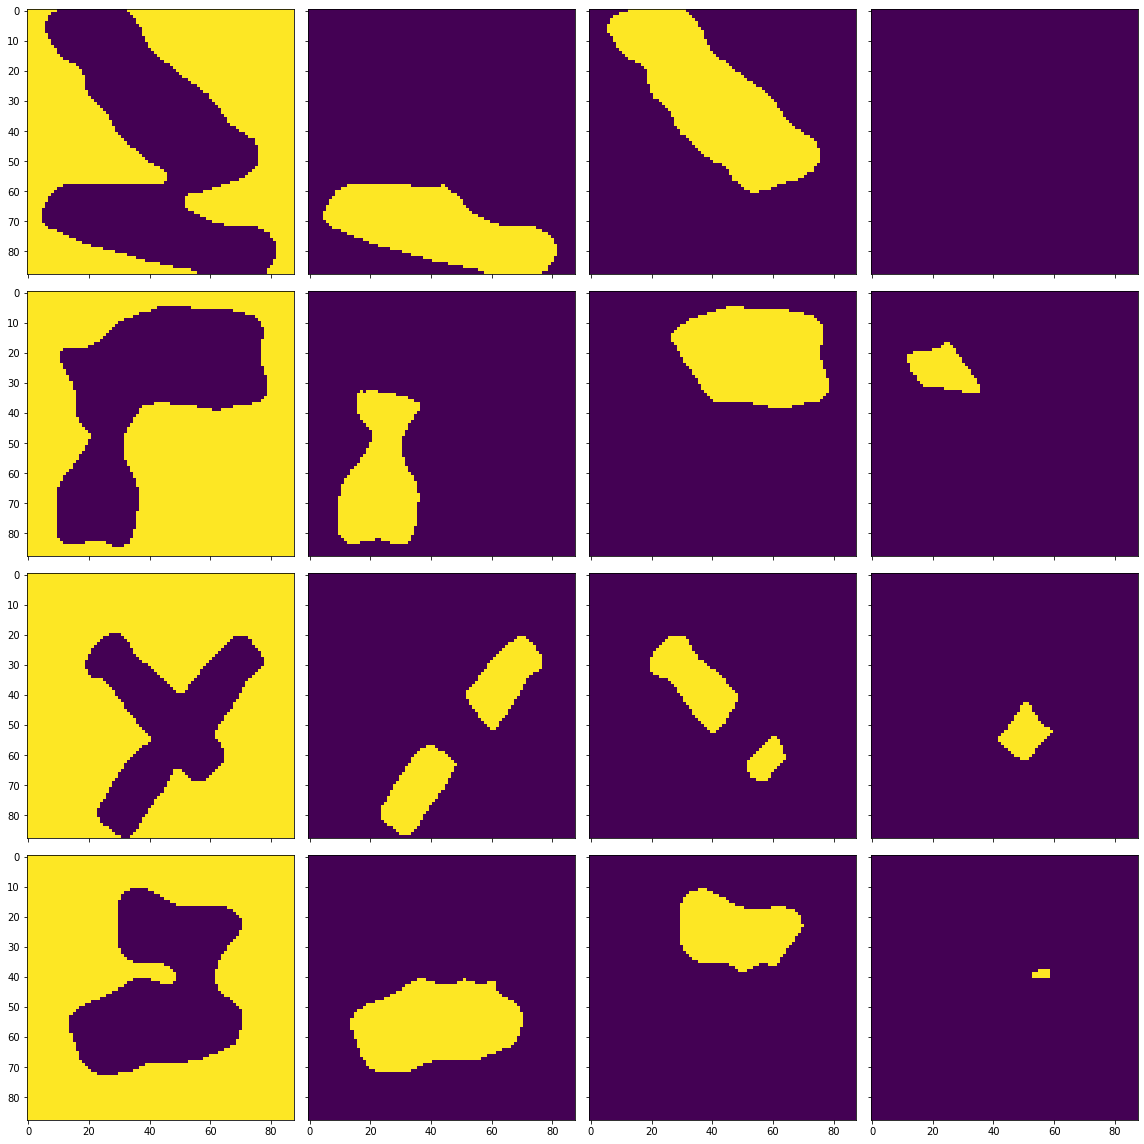

Training IOU: [0.9798786073644387, 0.910754767995674, 0.917352603108368, 0.7985143328783213]
Training accuracy: 0.9651065340909091
Testing IOU: [0.9742994193385509, 0.48868290895768457, 0.4069476801765688, 0.4491668894235053]
Testing accuracy: 0.8774586776859504
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelseg/savedmodel_180epoch\assets
4
4


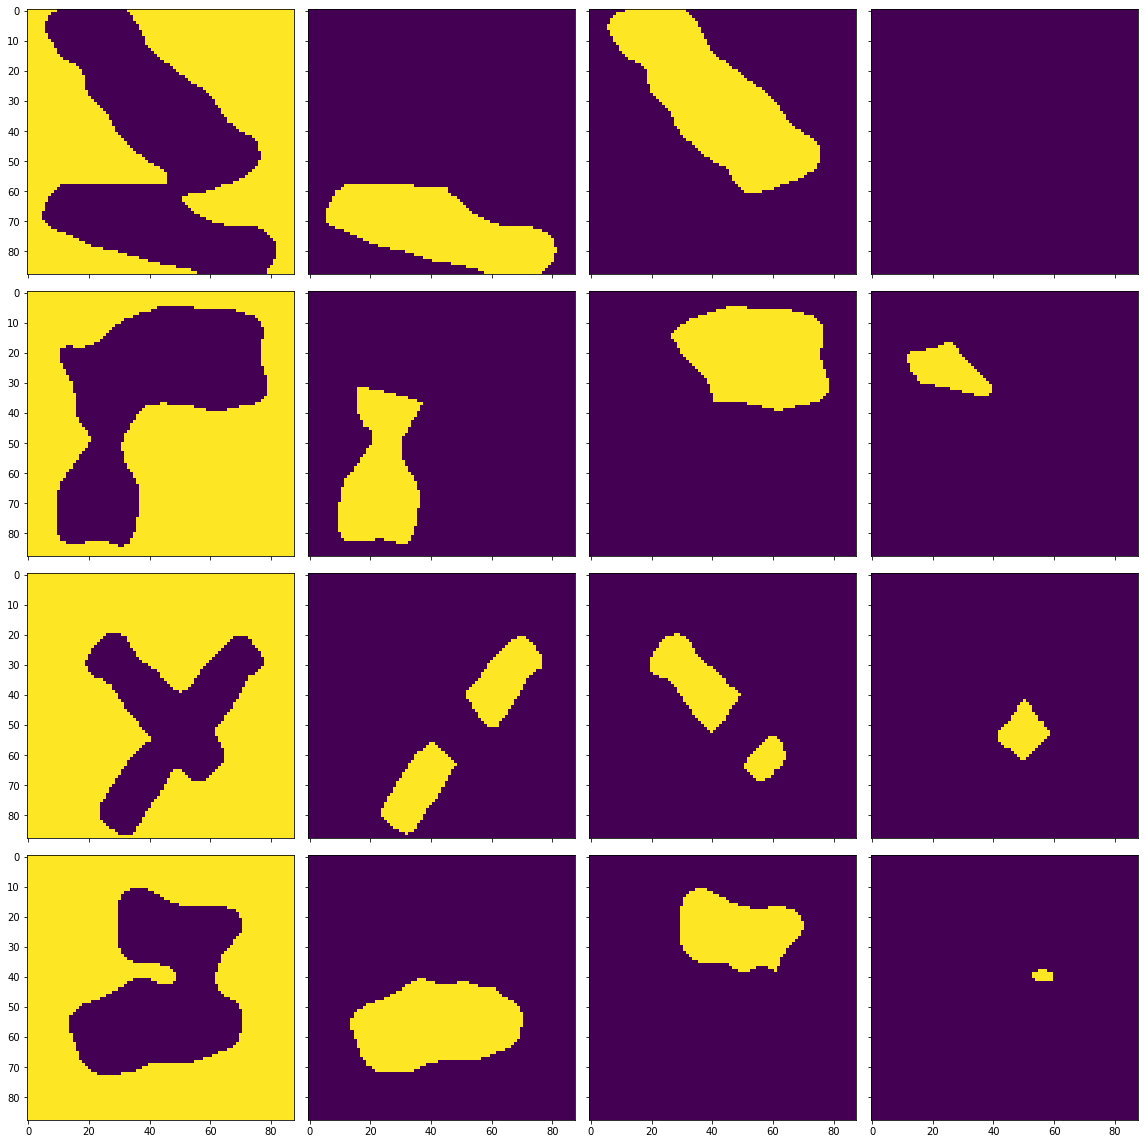

Training IOU: [0.9809340643310944, 0.907120570795414, 0.9248099640332788, 0.8282176804576069]
Training accuracy: 0.9669140625
Testing IOU: [0.974748872997383, 0.4679959302060713, 0.4294050707815558, 0.46981824614159995]
Testing accuracy: 0.8771138946280992
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0688 - val_loss: 0.0520
INFO:tensorflow:Assets written to: modelseg/savedmodel_181epoch\assets
4
4


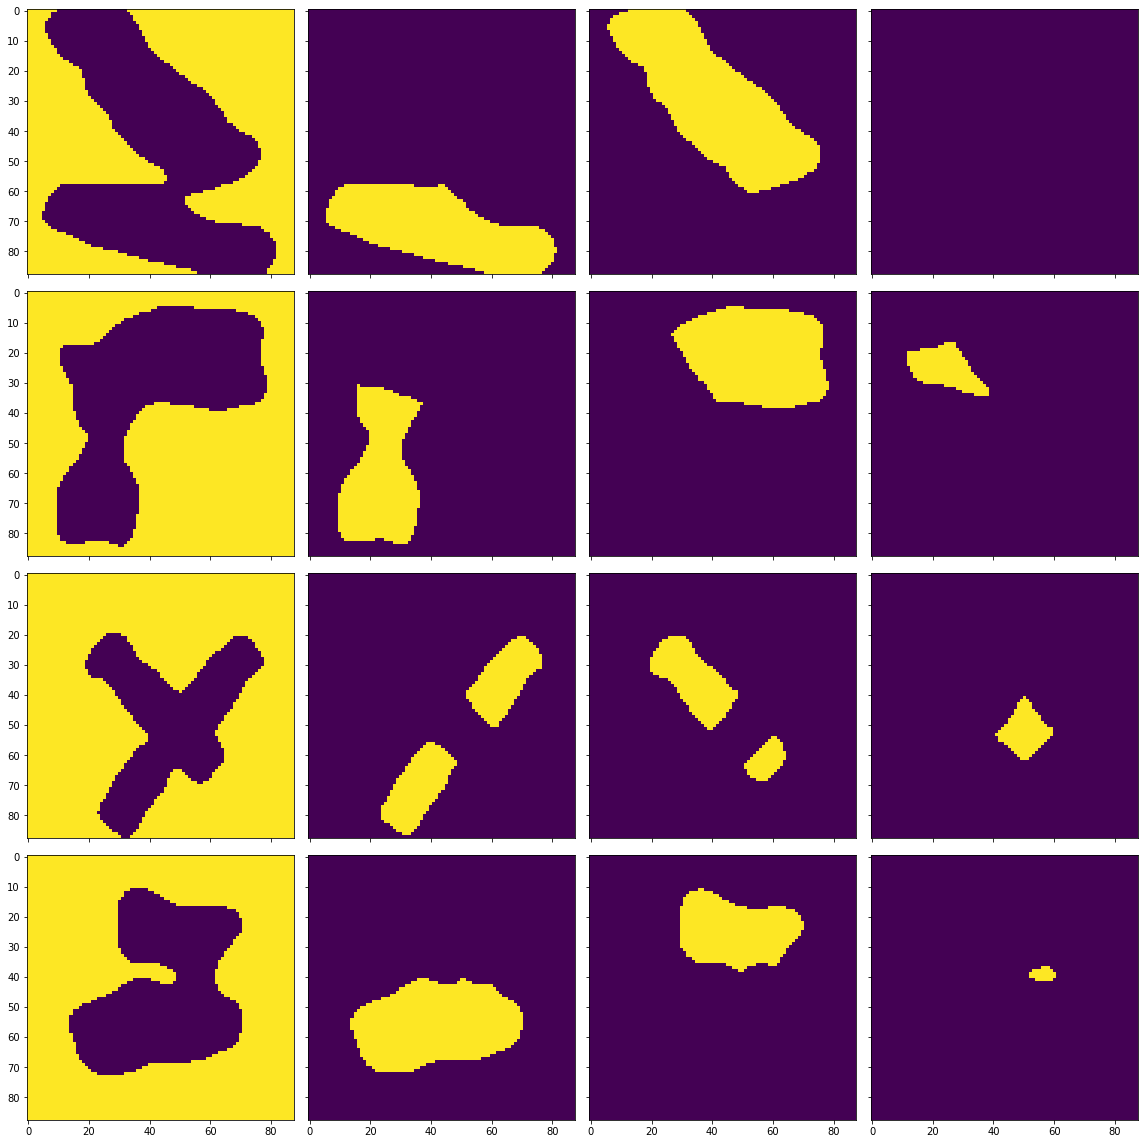

Training IOU: [0.9796136355466082, 0.9247071227471645, 0.9156109276493546, 0.8491176997964328]
Training accuracy: 0.9677414772727273
Testing IOU: [0.9743745377928474, 0.5258765285142301, 0.3530722374391889, 0.47730066936842586]
Testing accuracy: 0.8799405991735537
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0688 - val_loss: 0.0520
INFO:tensorflow:Assets written to: modelseg/savedmodel_182epoch\assets
4
4


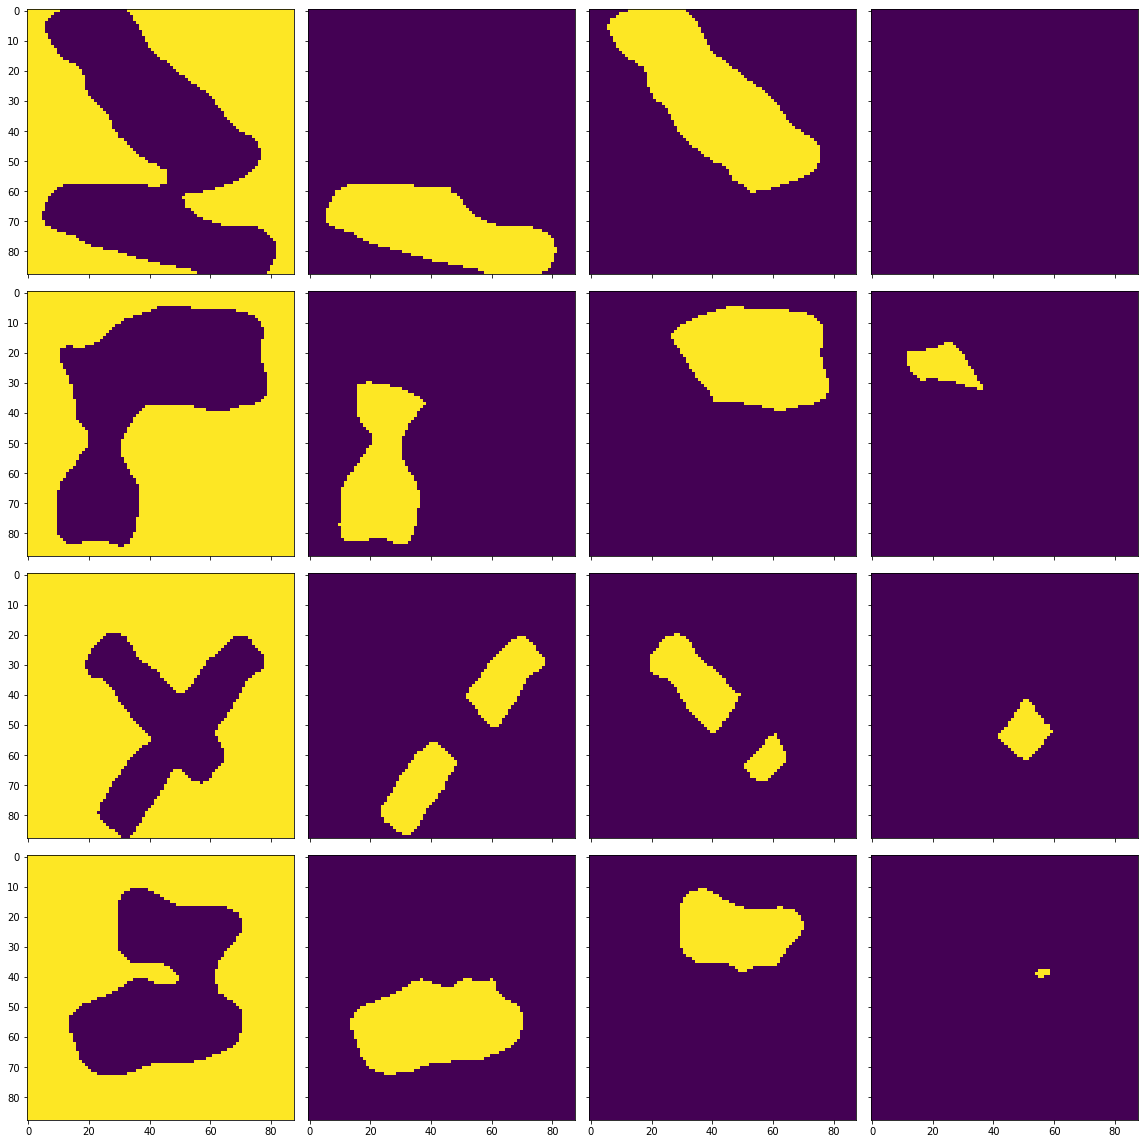

Training IOU: [0.9805176373789735, 0.9199655865435985, 0.9278778680766343, 0.8344919217687075]
Training accuracy: 0.9686989927685951
Testing IOU: [0.9746770368072607, 0.49011673497166697, 0.4236393400408336, 0.47184246265278407]
Testing accuracy: 0.880728305785124
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0688 - val_loss: 0.0523
INFO:tensorflow:Assets written to: modelseg/savedmodel_183epoch\assets
4
4


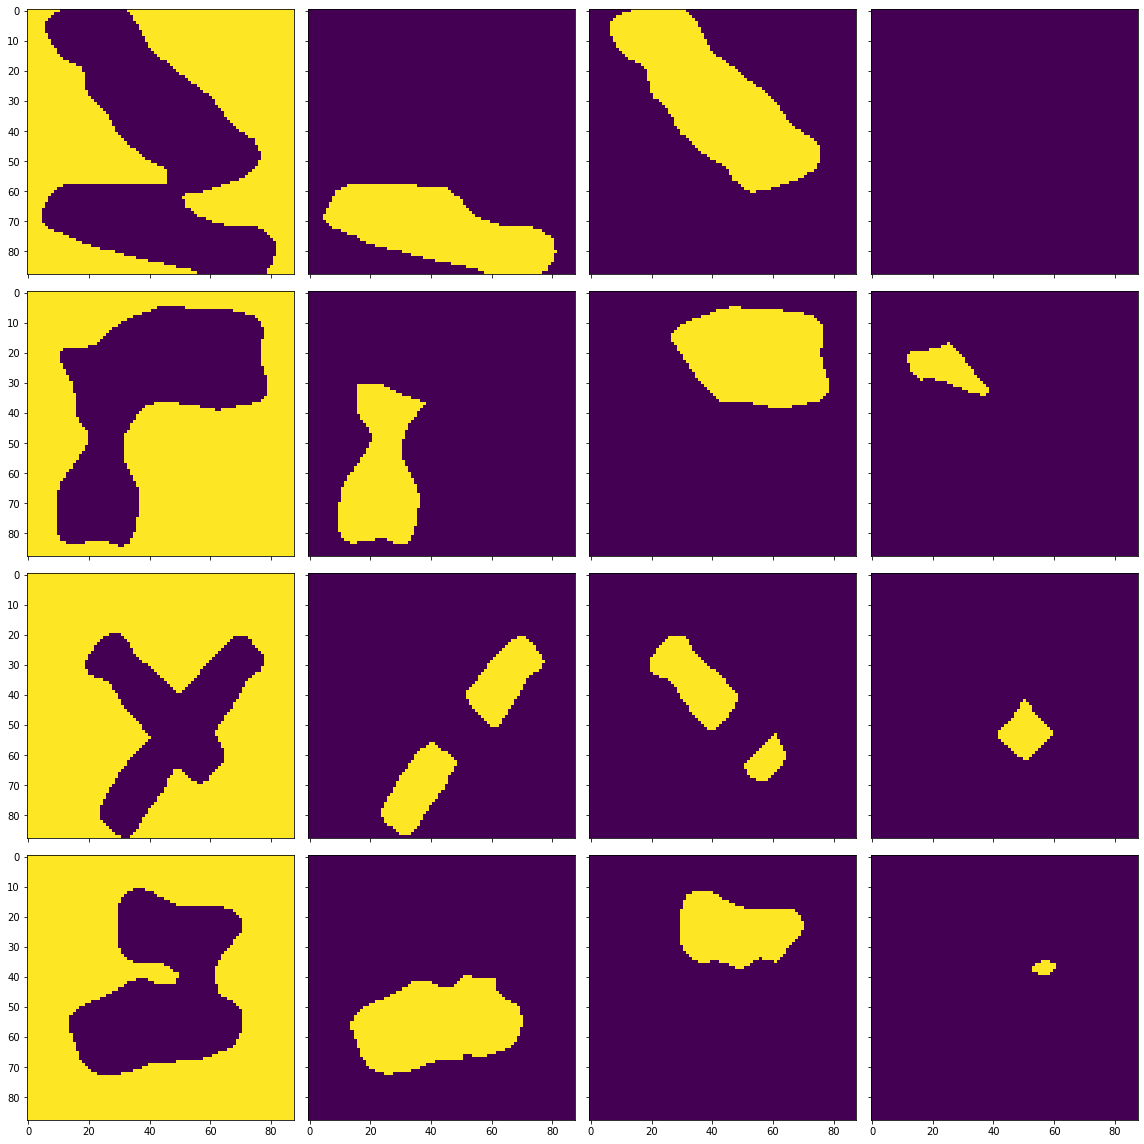

Training IOU: [0.9816864422173435, 0.9115169515478104, 0.9154030370801214, 0.8326052233517036]
Training accuracy: 0.967252388946281
Testing IOU: [0.9746879907071051, 0.47614762124179244, 0.38647060488016527, 0.4796773330956413]
Testing accuracy: 0.8760059400826447
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0519
INFO:tensorflow:Assets written to: modelseg/savedmodel_184epoch\assets
4
4


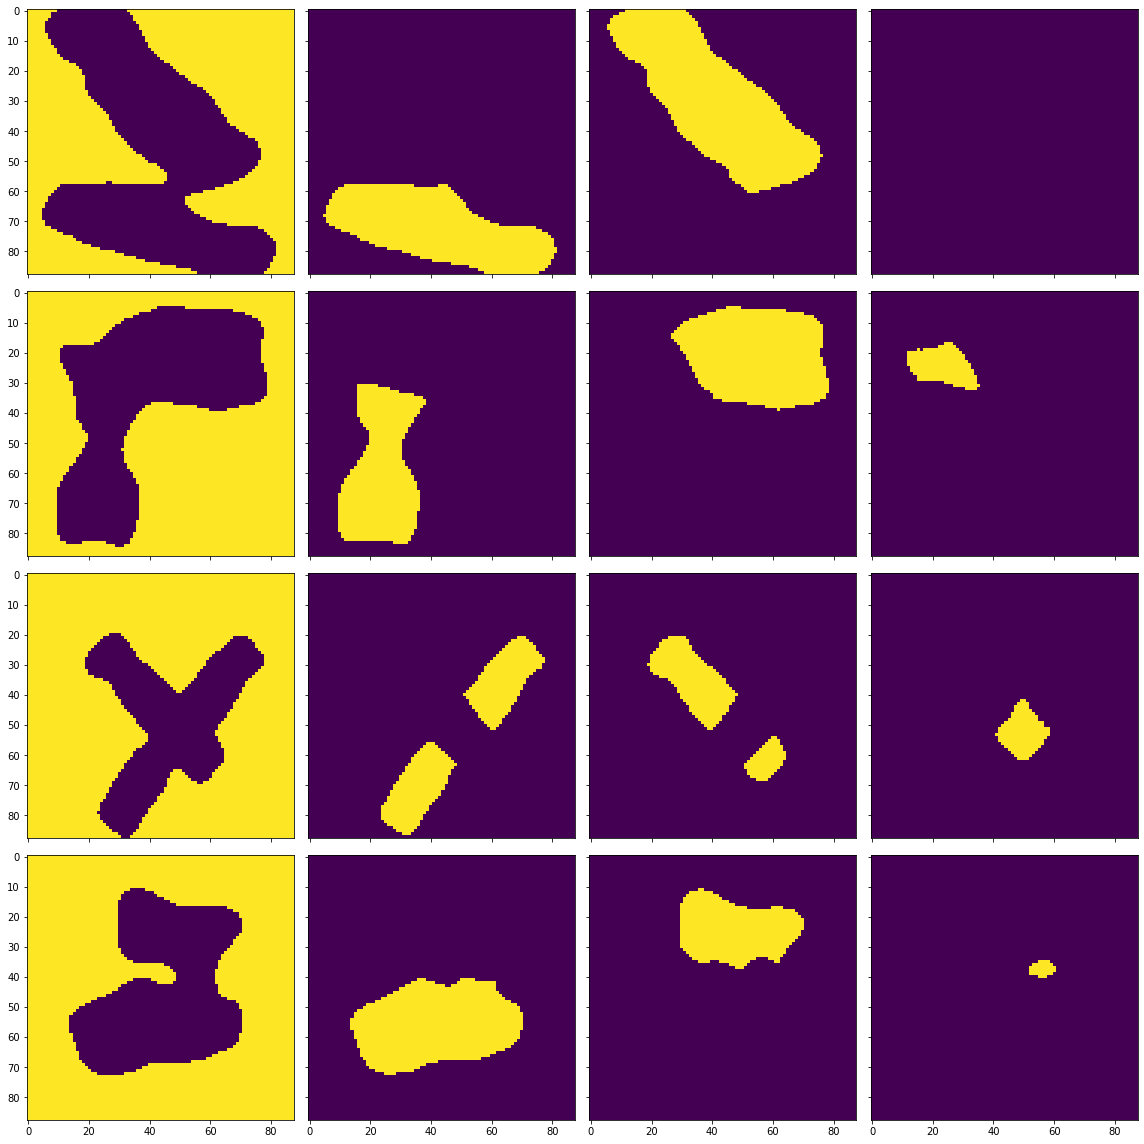

Training IOU: [0.979243567927956, 0.91407281233572, 0.9113791751948788, 0.8371960917973188]
Training accuracy: 0.9663681559917355
Testing IOU: [0.9738603127763215, 0.4919773478055687, 0.39130970315416463, 0.48054540820660946]
Testing accuracy: 0.8778551136363636
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_185epoch\assets
4
4


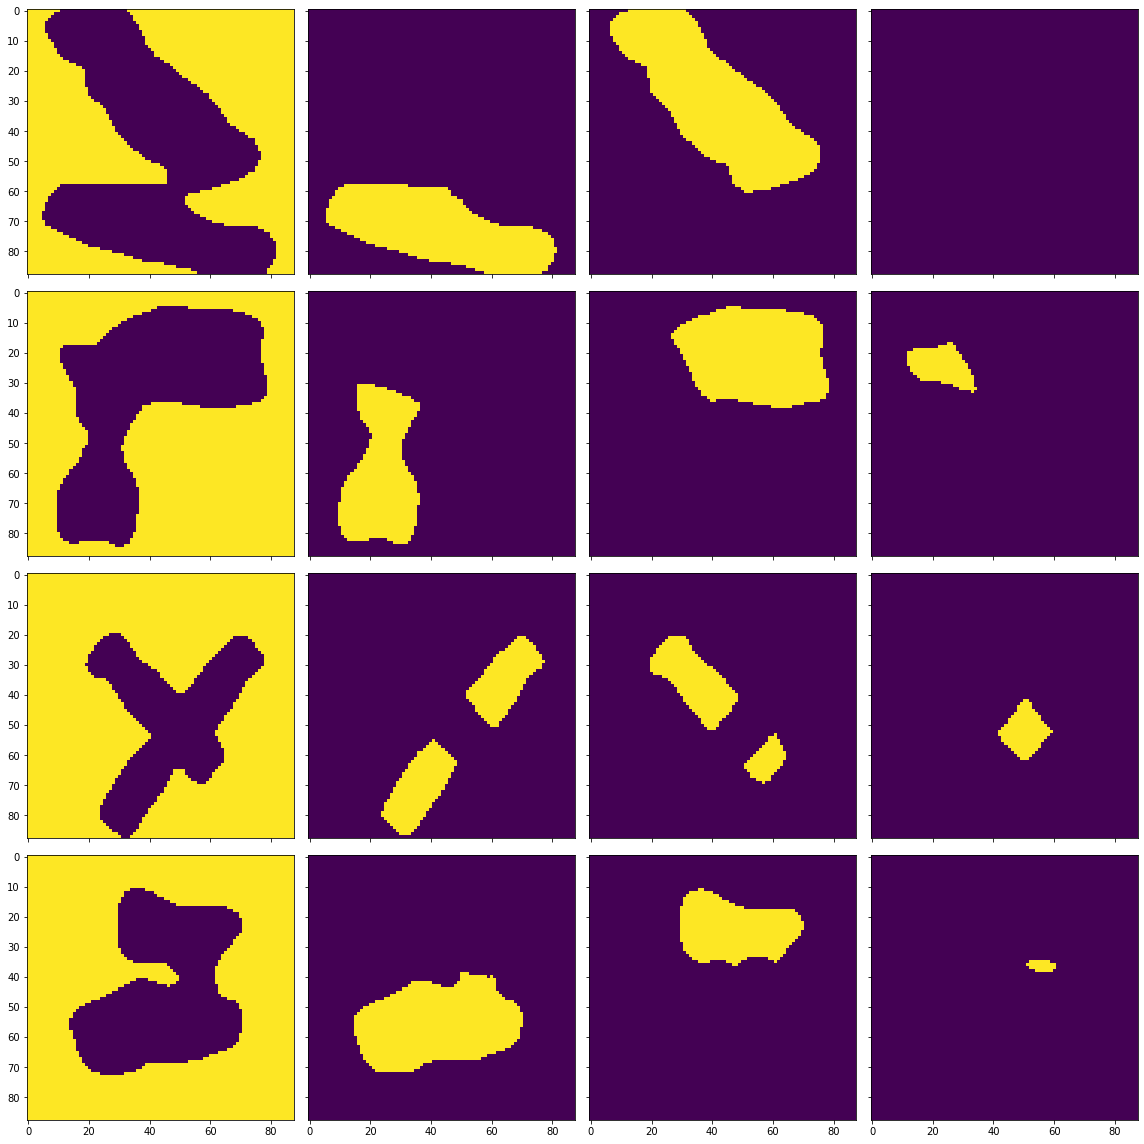

Training IOU: [0.9811906996516249, 0.9139686647999411, 0.9021729620961921, 0.8264363070473528]
Training accuracy: 0.9662590392561984
Testing IOU: [0.974366780851112, 0.5217328200485178, 0.3698168572295862, 0.46187175043327555]
Testing accuracy: 0.8809814049586777
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0510
INFO:tensorflow:Assets written to: modelseg/savedmodel_186epoch\assets
4
4


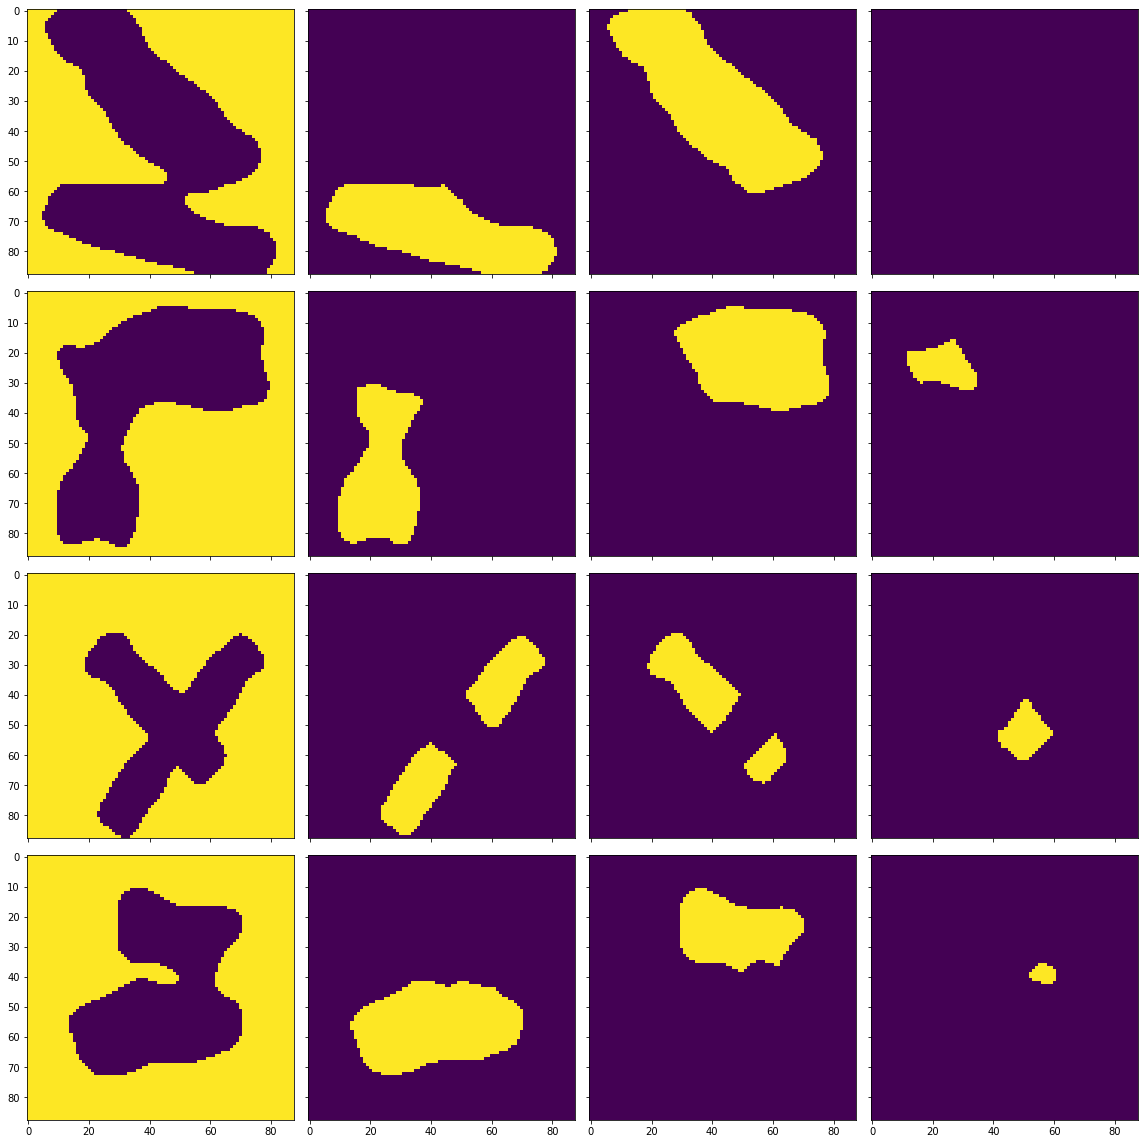

Training IOU: [0.9775150228141705, 0.9136518259706414, 0.924417866586717, 0.8402920781676823]
Training accuracy: 0.9659132877066116
Testing IOU: [0.9733102828055287, 0.44068809624152333, 0.43275146042632384, 0.48681612775852234]
Testing accuracy: 0.8731986053719009
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_187epoch\assets
4
4


Training IOU: [0.9810654888381438, 0.9140452643810395, 0.9069745193332713, 0.82710027100271]
Training accuracy: 0.9663607308884298
Testing IOU: [0.9745212517109023, 0.5120914666591985, 0.37112966926949864, 0.48626976660843074]
Testing accuracy: 0.8797326962809917
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_188epoch\assets
4
4


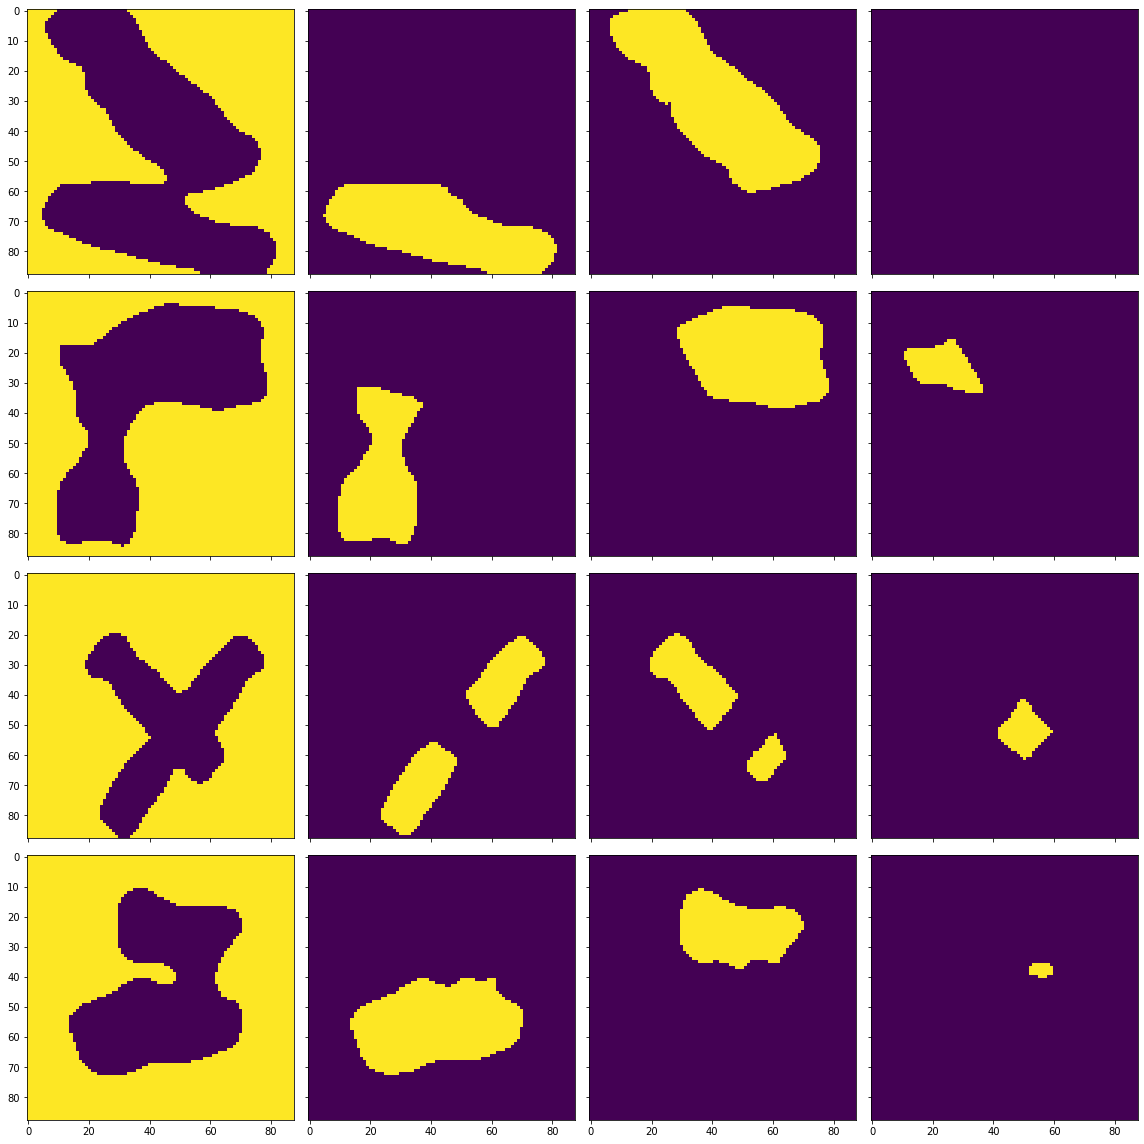

Training IOU: [0.979897635206158, 0.926947125124314, 0.9094211018250788, 0.8451951150598059]
Training accuracy: 0.9677108083677686
Testing IOU: [0.9740811812748692, 0.5263401010538883, 0.3933538719229504, 0.48655913978494625]
Testing accuracy: 0.8823088842975206
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0691 - val_loss: 0.0621
INFO:tensorflow:Assets written to: modelseg/savedmodel_189epoch\assets
4
4


Training IOU: [0.8895055676010739, 0.8603102327072416, 0.9055702097173375, 0.8361735089078234]
Training accuracy: 0.9010985924586777
Testing IOU: [0.8878035370021088, 0.4867101474982603, 0.3798774876052686, 0.48871164574616455]
Testing accuracy: 0.8150606921487603
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0527
INFO:tensorflow:Assets written to: modelseg/savedmodel_190epoch\assets
4
4


Training IOU: [0.9790493414988286, 0.9069617830576321, 0.8939903530647066, 0.8374896949711459]
Training accuracy: 0.9633974690082645
Testing IOU: [0.9730541213799629, 0.49571933937579804, 0.35066389219183514, 0.5061288359558376]
Testing accuracy: 0.8747998450413224
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_191epoch\assets
4
4


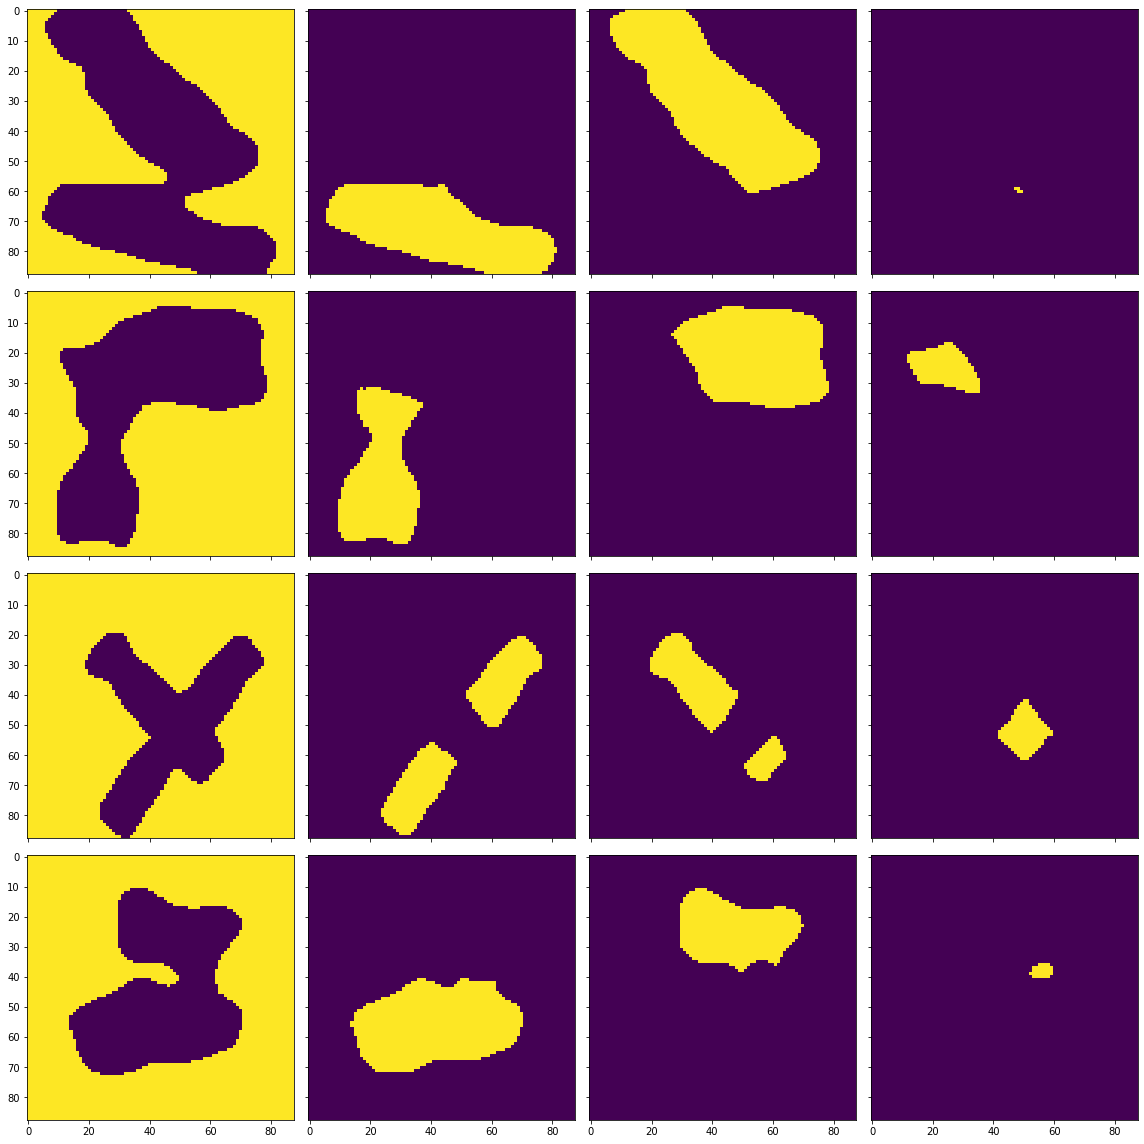

Training IOU: [0.9811669897336492, 0.9208921483280879, 0.908518169980413, 0.8483569742422027]
Training accuracy: 0.9681053073347108
Testing IOU: [0.9744325153107308, 0.498693748654274, 0.3933984211499713, 0.4894150068896405]
Testing accuracy: 0.8800684400826446
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0687 - val_loss: 0.0521
INFO:tensorflow:Assets written to: modelseg/savedmodel_192epoch\assets
4
4


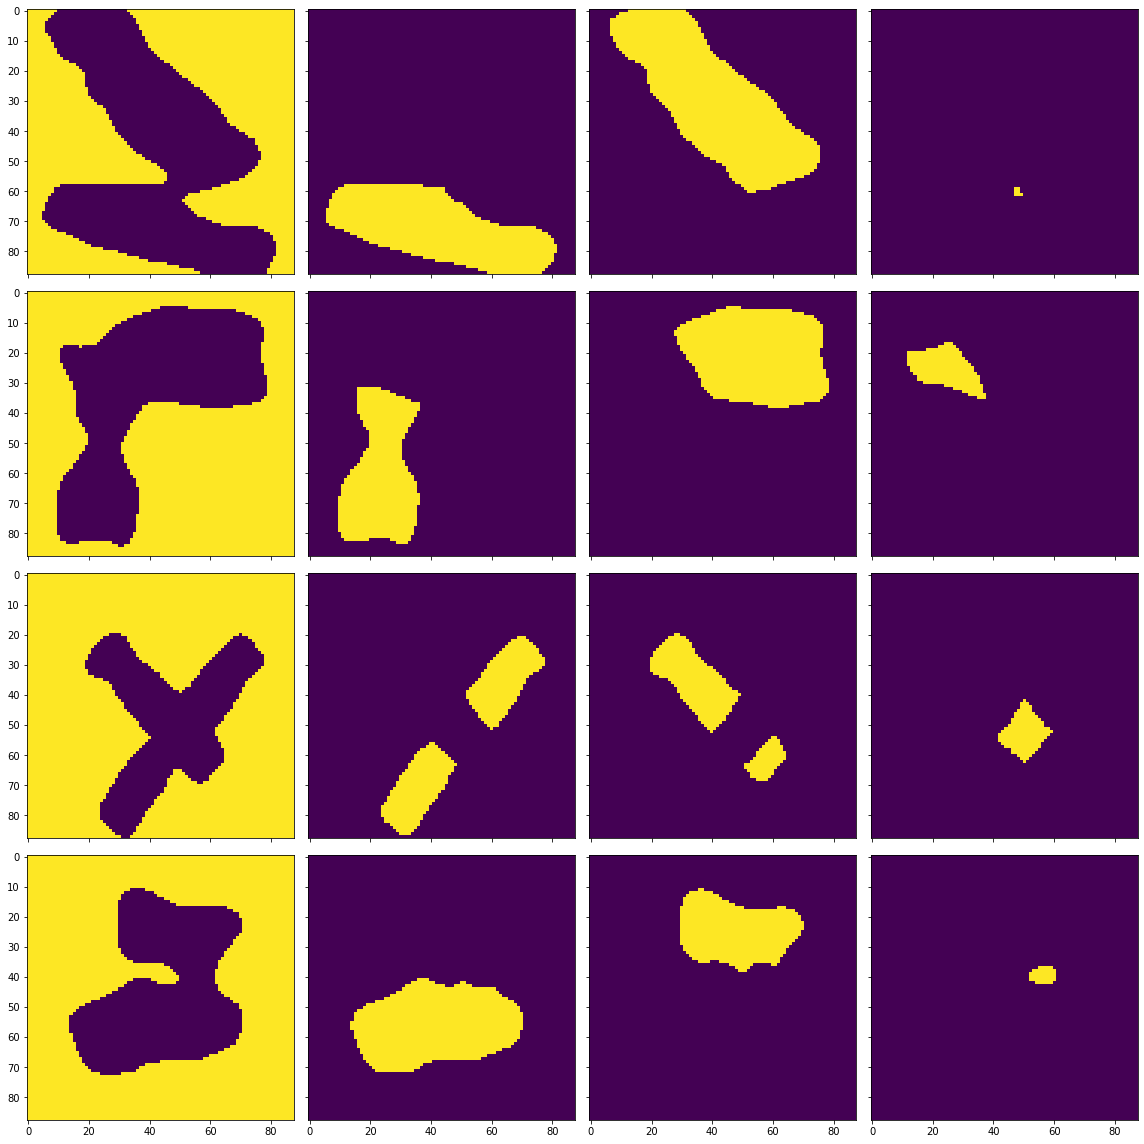

Training IOU: [0.9811753214281546, 0.921396613332779, 0.9148710374442712, 0.8356244360702723]
Training accuracy: 0.9678095945247934
Testing IOU: [0.9744527454156, 0.5145383745063061, 0.36495155995889333, 0.48119243159852987]
Testing accuracy: 0.8792239152892563
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0539
INFO:tensorflow:Assets written to: modelseg/savedmodel_193epoch\assets
4
4


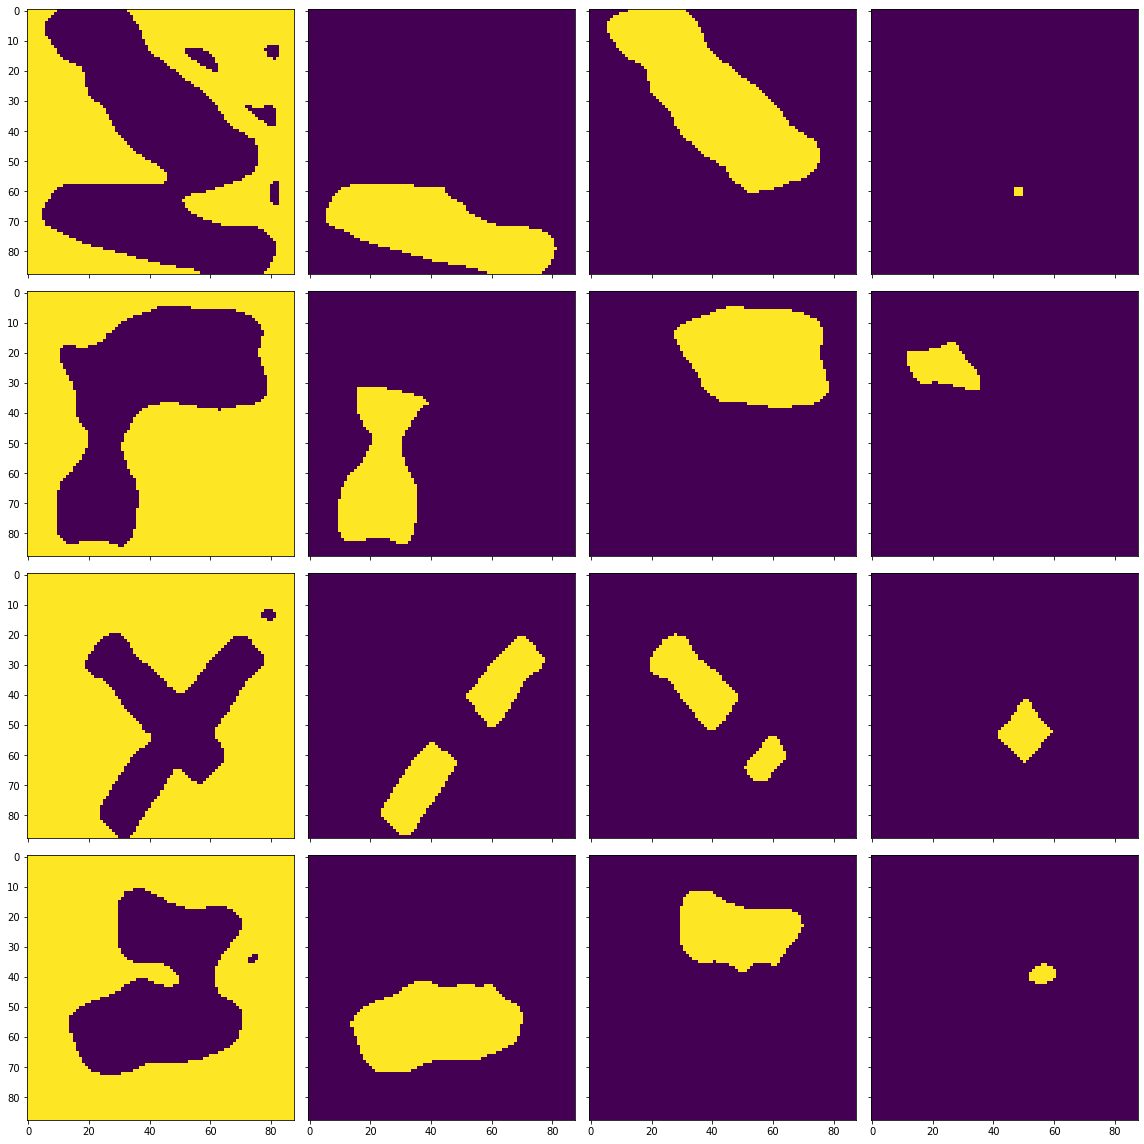

Training IOU: [0.9746013219548594, 0.8977725848031306, 0.9079196169115541, 0.8405360936393552]
Training accuracy: 0.960990444214876
Testing IOU: [0.9686868195618795, 0.4909576804803046, 0.4026939685989647, 0.47290950264195253]
Testing accuracy: 0.8758768078512397
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0505
INFO:tensorflow:Assets written to: modelseg/savedmodel_194epoch\assets
4
4


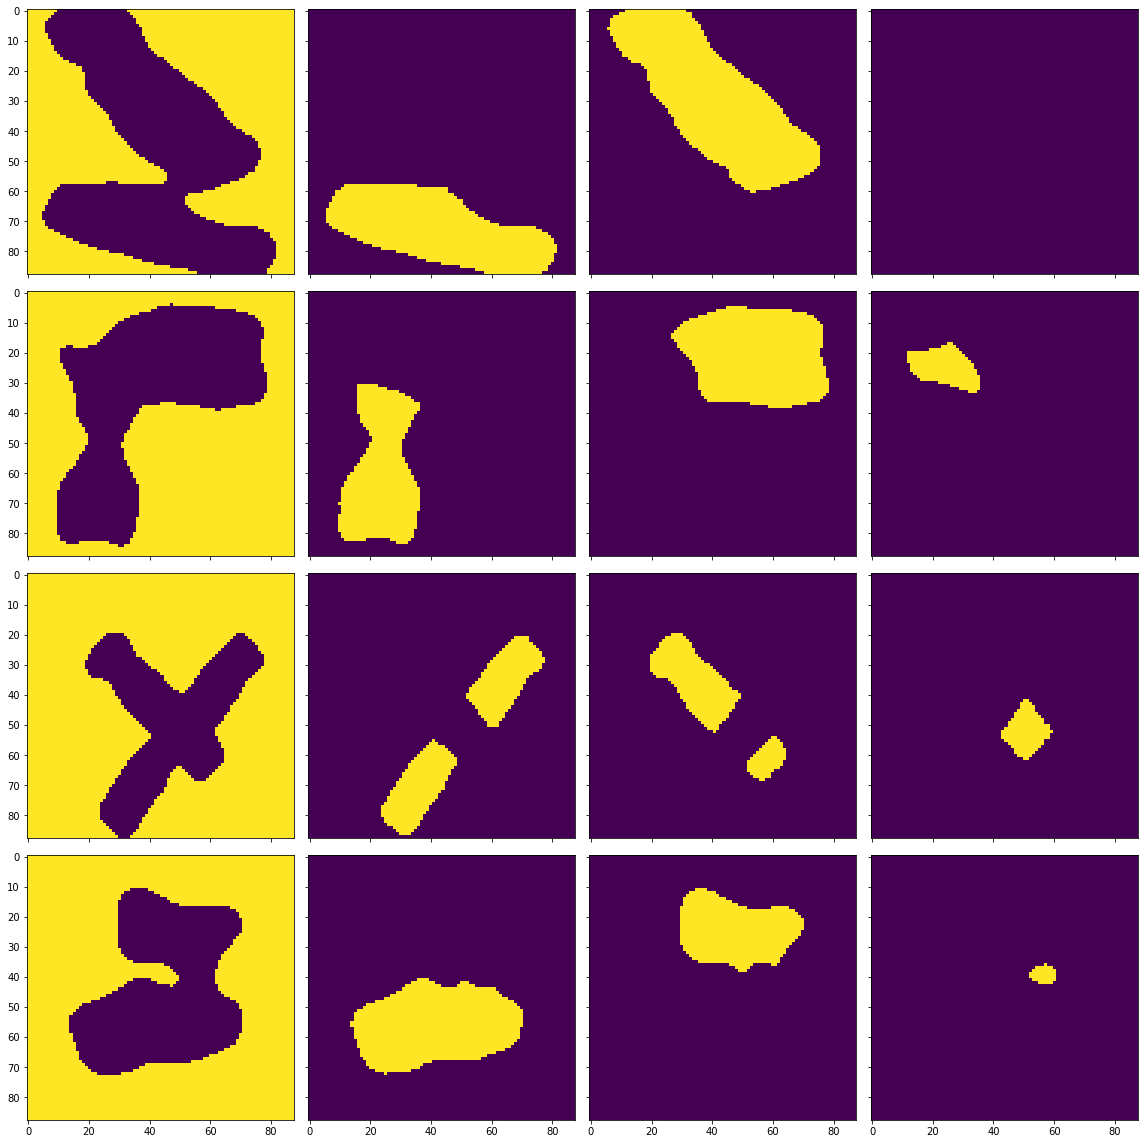

Training IOU: [0.9788593640877316, 0.9158893338823546, 0.9147124780841839, 0.8297852239087989]
Training accuracy: 0.9662961647727273
Testing IOU: [0.9735730399714303, 0.5164880283516293, 0.414651183096132, 0.47669343575418993]
Testing accuracy: 0.8835627582644628
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0522
INFO:tensorflow:Assets written to: modelseg/savedmodel_195epoch\assets
4
4


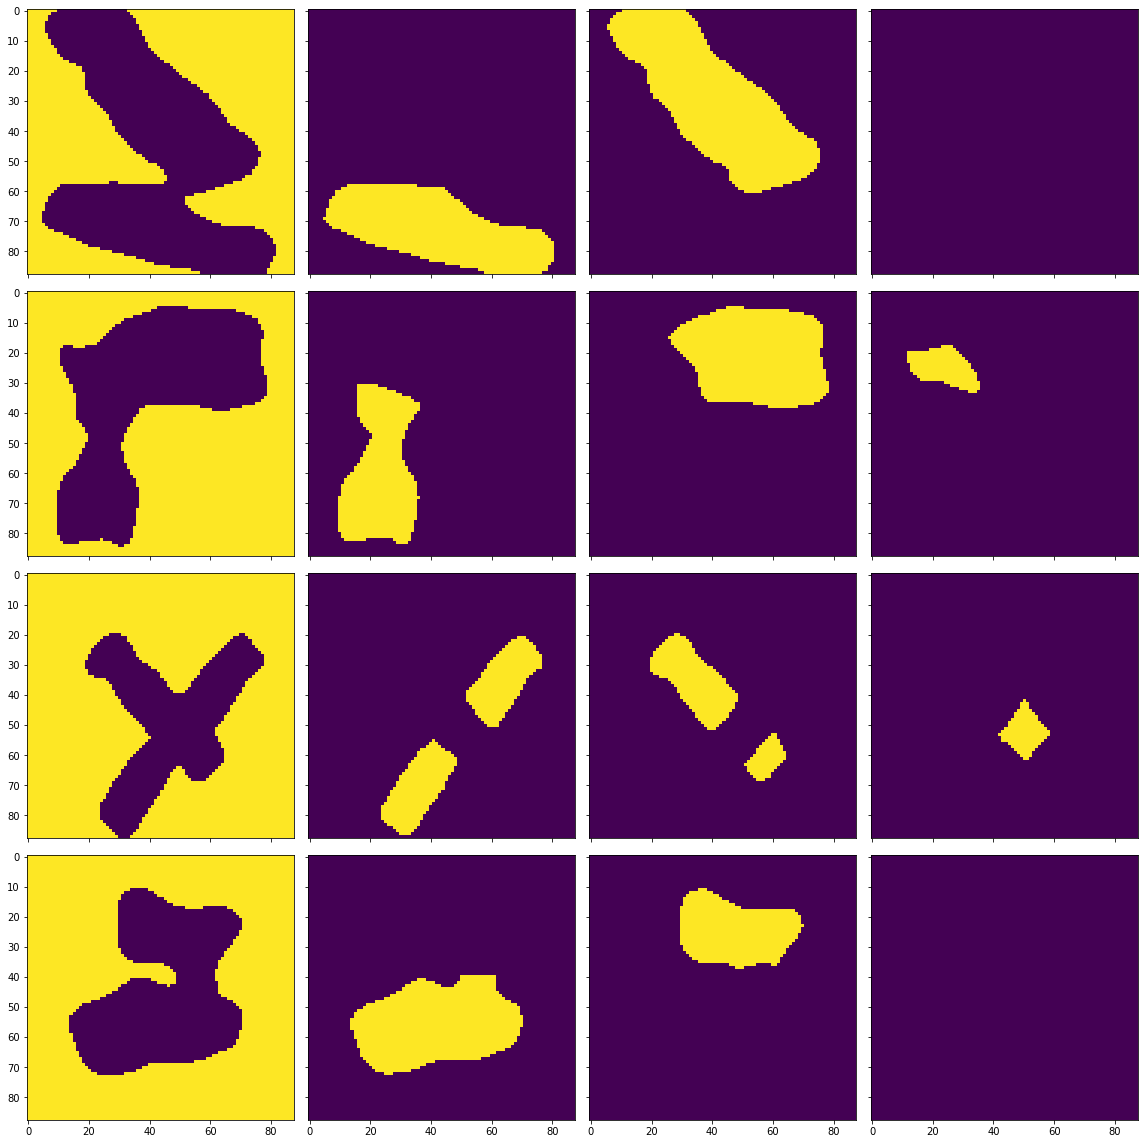

Training IOU: [0.9807826561282922, 0.9191628976478097, 0.9177869868824643, 0.7787163070963576]
Training accuracy: 0.9663720299586777
Testing IOU: [0.9745269286754003, 0.4796949351411251, 0.4015234149426657, 0.4537913581404068]
Testing accuracy: 0.8773514979338843
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0529
INFO:tensorflow:Assets written to: modelseg/savedmodel_196epoch\assets
4
4


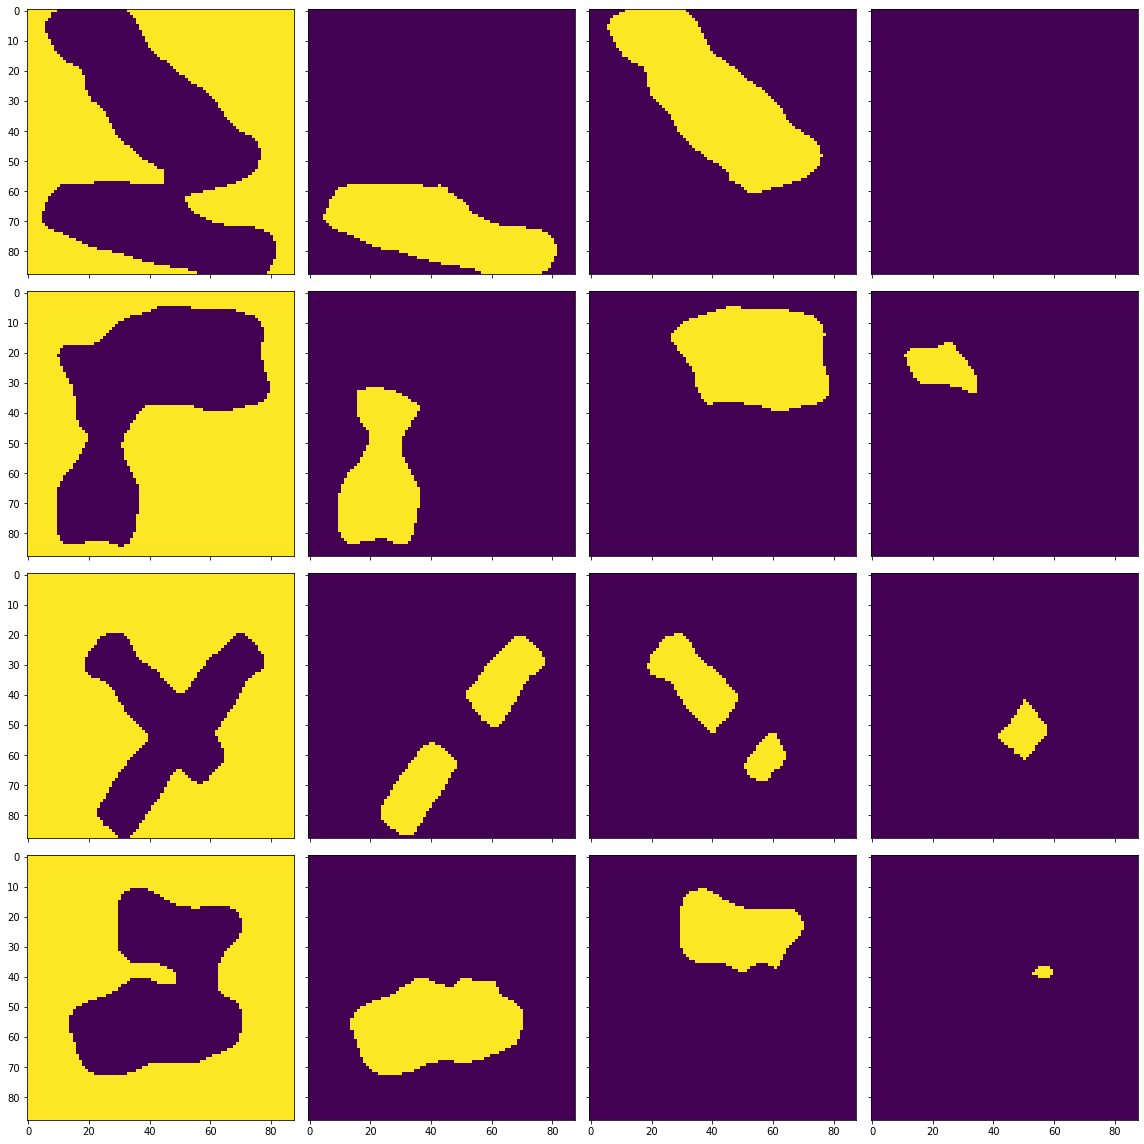

Training IOU: [0.9768247479821249, 0.9210411987945852, 0.9318719233001569, 0.7848117628049766]
Training accuracy: 0.9657764075413223
Testing IOU: [0.9725414445694166, 0.4397121994765876, 0.4354144151633552, 0.46735968718706783]
Testing accuracy: 0.8737822830578512
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0535
INFO:tensorflow:Assets written to: modelseg/savedmodel_197epoch\assets
4
4


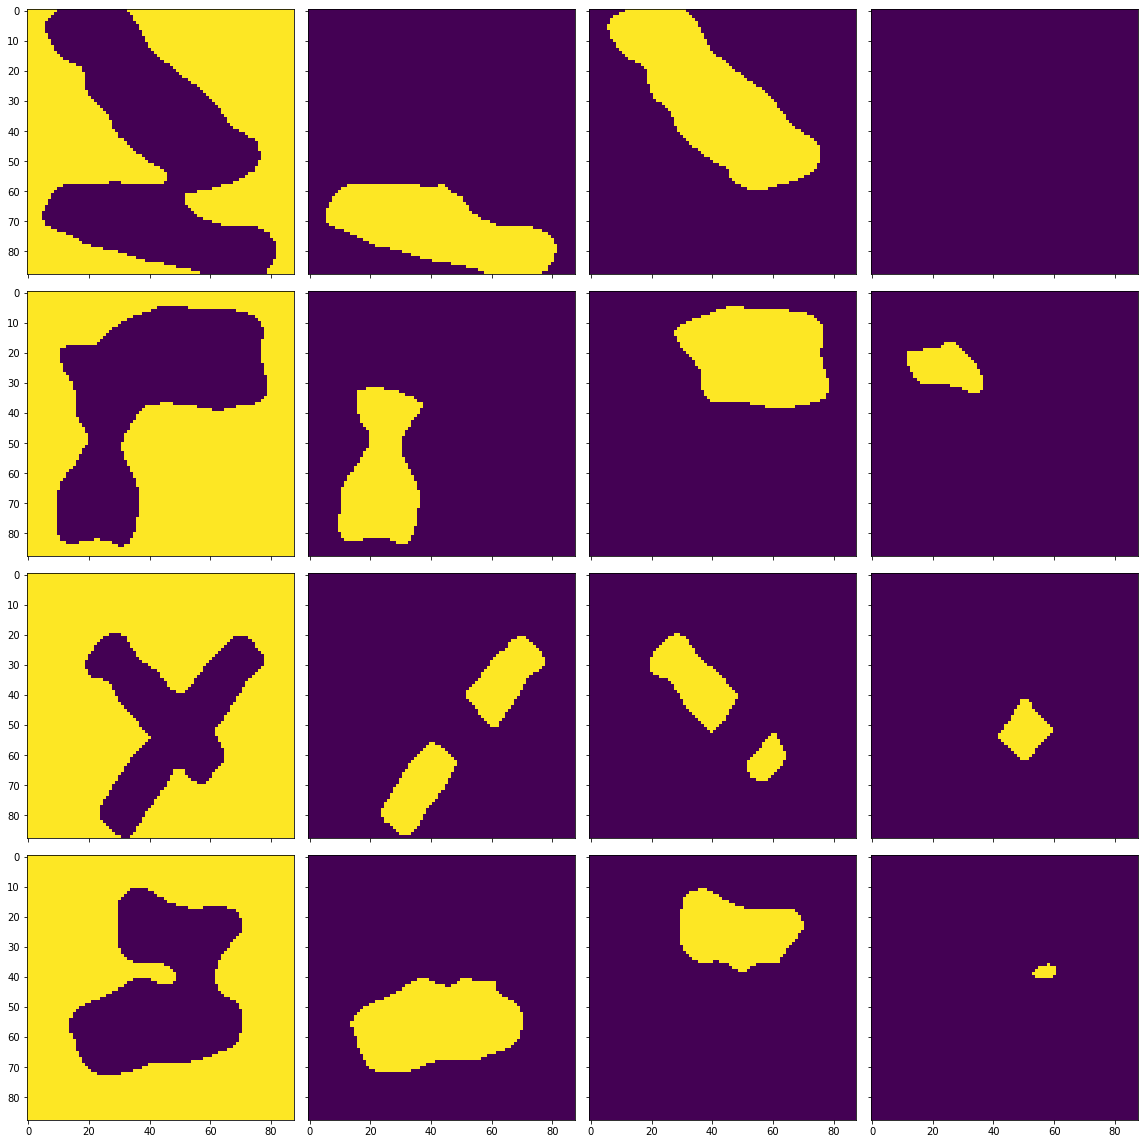

Training IOU: [0.9813977161641396, 0.9162161285689798, 0.9235413736329637, 0.8468532206969377]
Training accuracy: 0.9688455578512397
Testing IOU: [0.9745769645191557, 0.4822921480485653, 0.36327438698342374, 0.4986137197030677]
Testing accuracy: 0.8754506714876034
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0527
INFO:tensorflow:Assets written to: modelseg/savedmodel_198epoch\assets
4
4


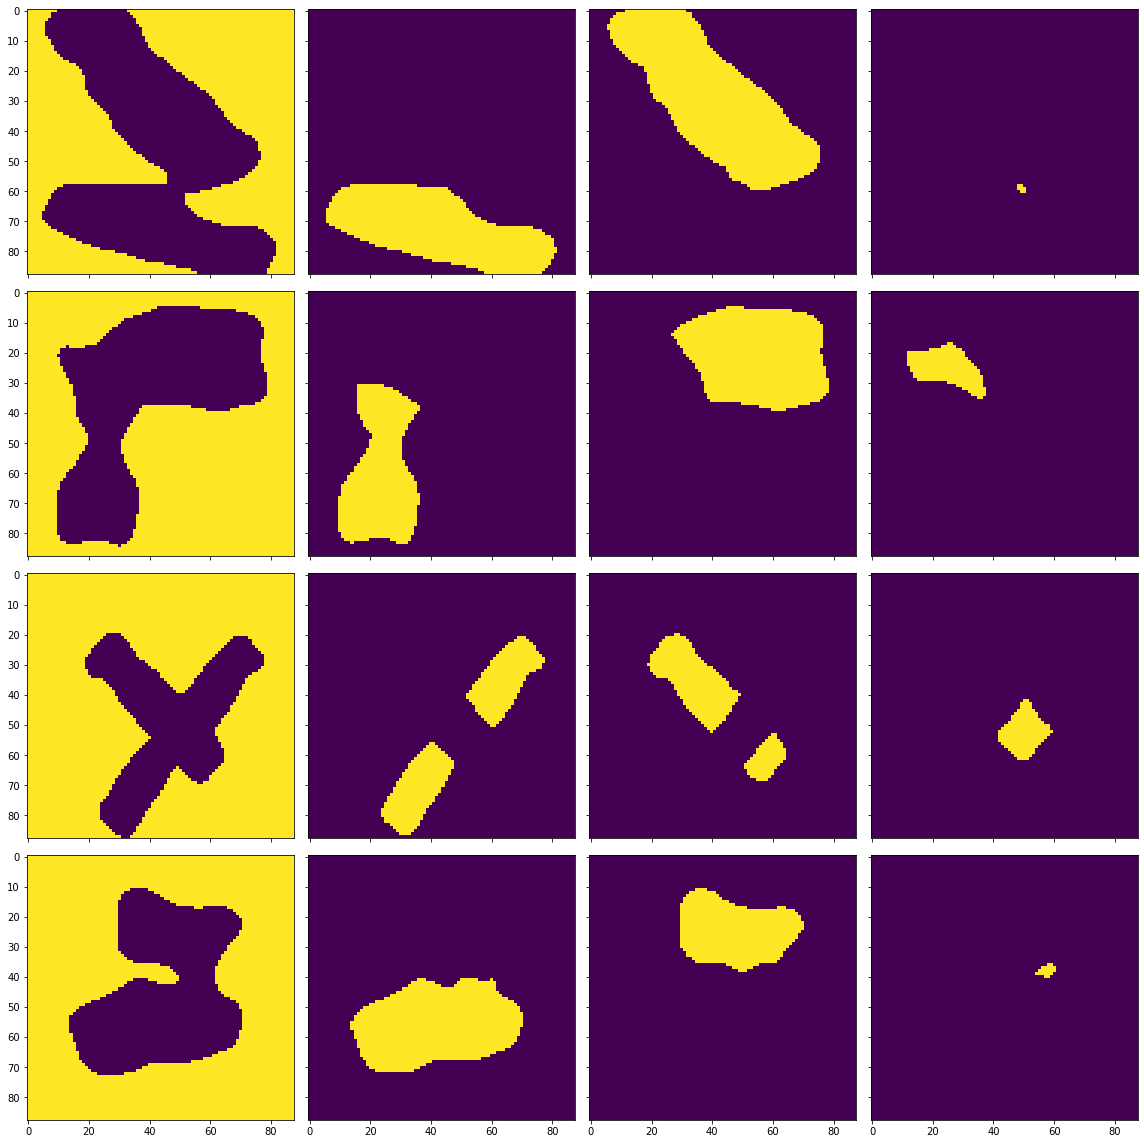

Training IOU: [0.9805895220333153, 0.915077180502303, 0.9242503273620325, 0.8346992505148729]
Training accuracy: 0.9679571280991736
Testing IOU: [0.9740120810023015, 0.5081010577230084, 0.3533886583679115, 0.4664469036967271]
Testing accuracy: 0.8774690082644628
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0691 - val_loss: 0.0513
INFO:tensorflow:Assets written to: modelseg/savedmodel_199epoch\assets
4
4


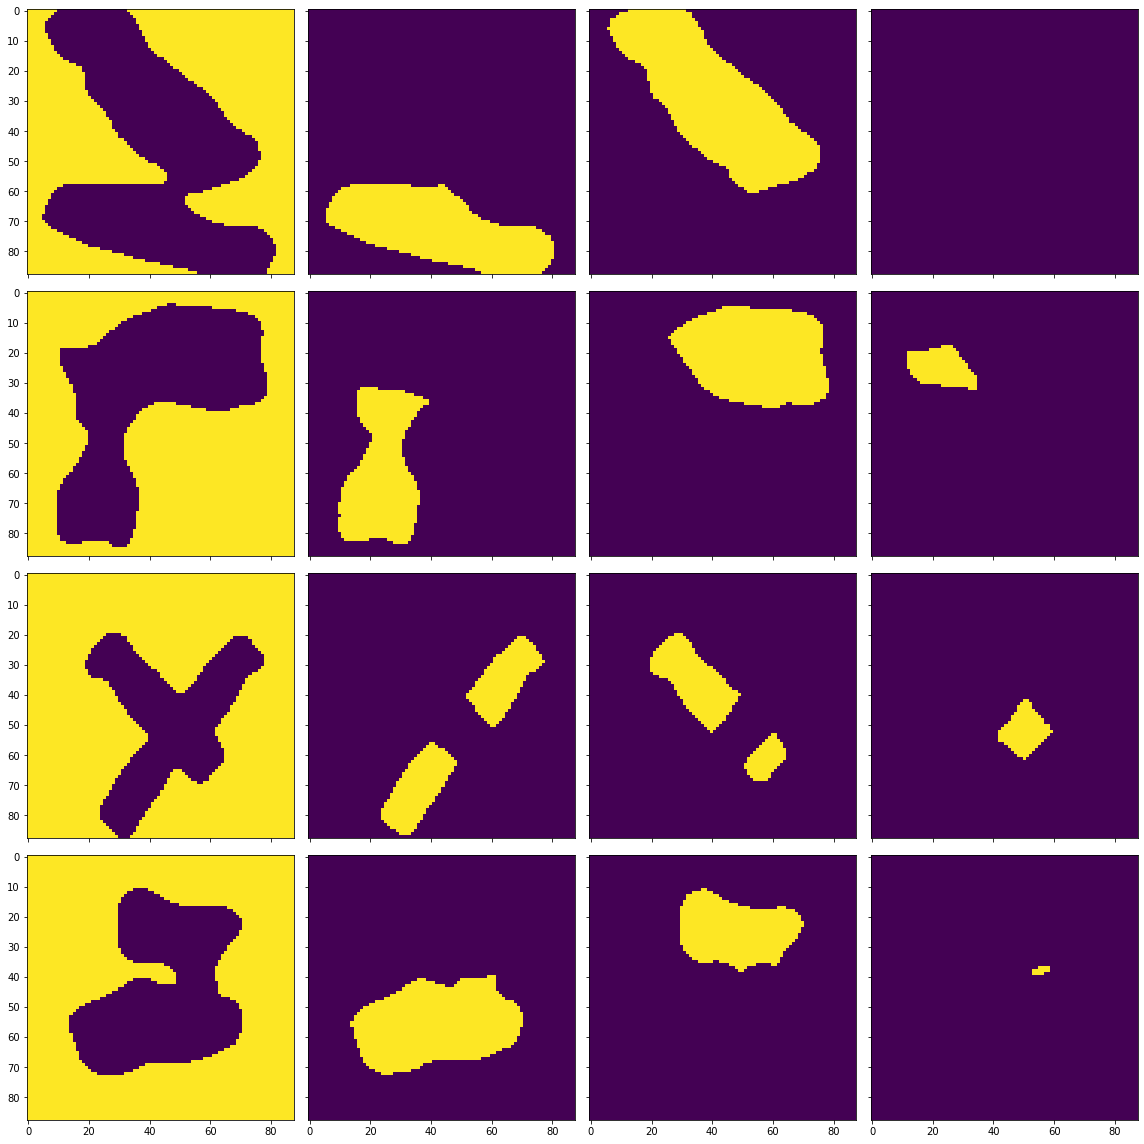

Training IOU: [0.980777948432999, 0.8997142792353569, 0.8921763071908761, 0.8169558066740941]
Training accuracy: 0.9642552298553719
Testing IOU: [0.974001591810362, 0.5265235101567344, 0.34046972688384336, 0.47533819906094554]
Testing accuracy: 0.880131714876033
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0694 - val_loss: 0.0537
INFO:tensorflow:Assets written to: modelseg/savedmodel_200epoch\assets
4
4


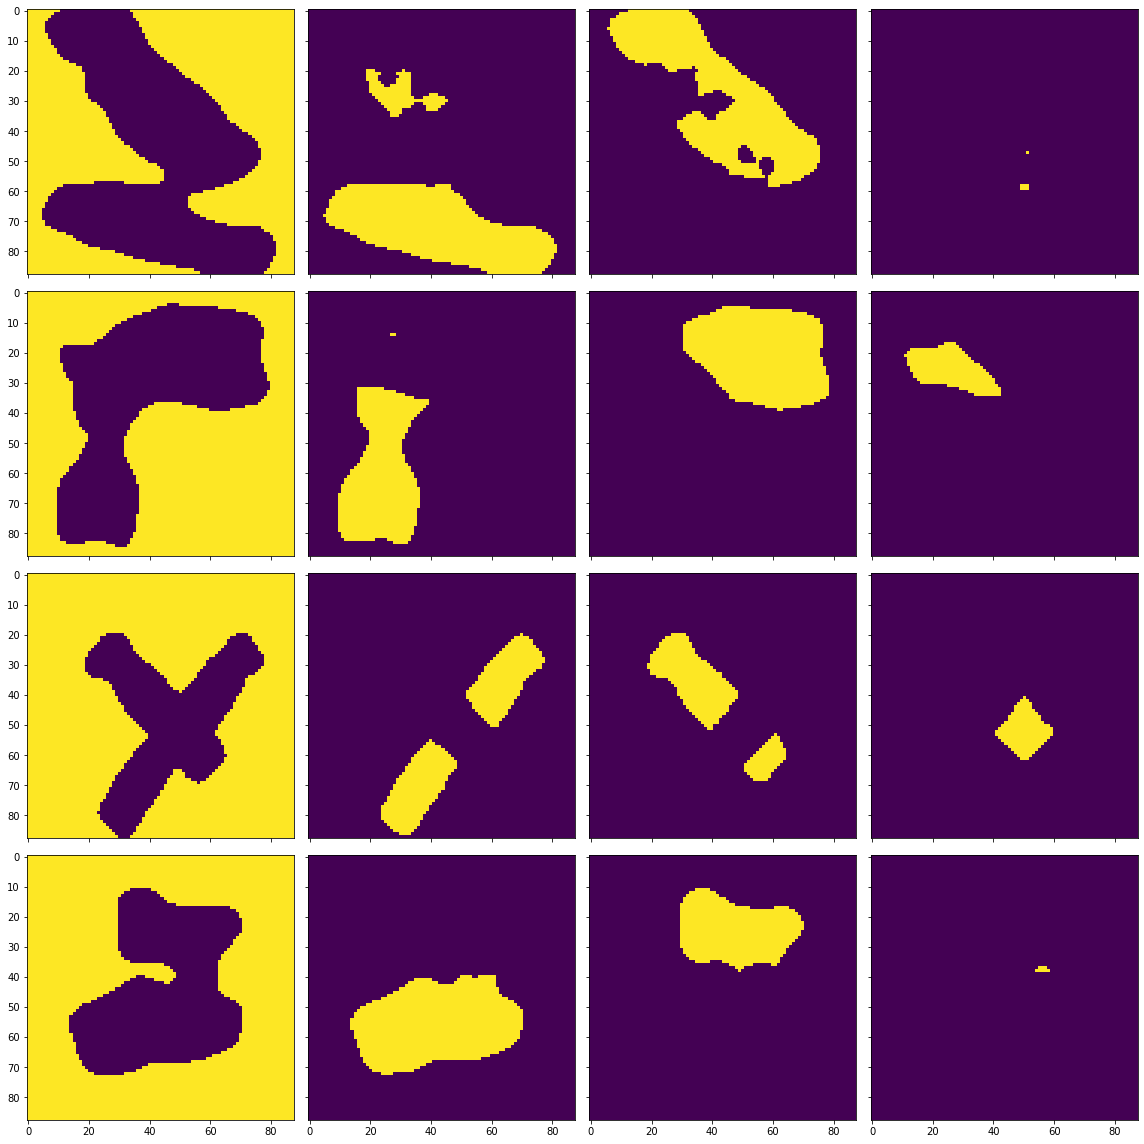

Training IOU: [0.9763845593564464, 0.9090418580931869, 0.8830157948562555, 0.80200291087143]
Training accuracy: 0.9617658832644628
Testing IOU: [0.9719975261103676, 0.477833289131323, 0.37698659578078164, 0.47294596879563444]
Testing accuracy: 0.8720467458677686
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0689 - val_loss: 0.0519
INFO:tensorflow:Assets written to: modelseg/savedmodel_201epoch\assets
4
4


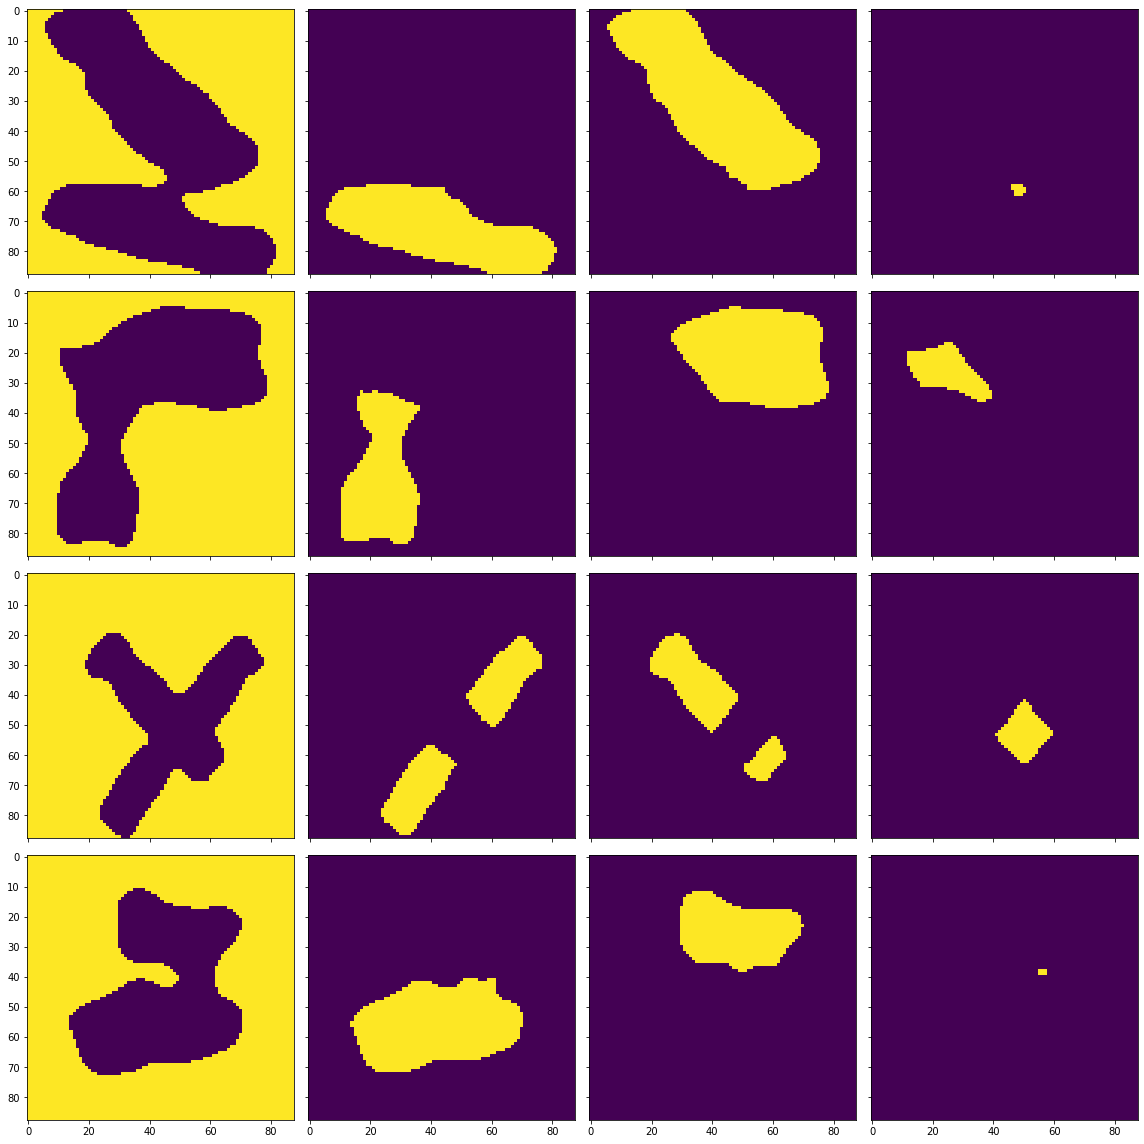

Training IOU: [0.9822955044515504, 0.896609519381647, 0.9151020274671514, 0.850100237870179]
Training accuracy: 0.9671048553719008
Testing IOU: [0.9748814012893808, 0.45040395478106926, 0.4037346721326278, 0.4873593073593074]
Testing accuracy: 0.8742600723140496
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0690 - val_loss: 0.0509
INFO:tensorflow:Assets written to: modelseg/savedmodel_202epoch\assets
4
4


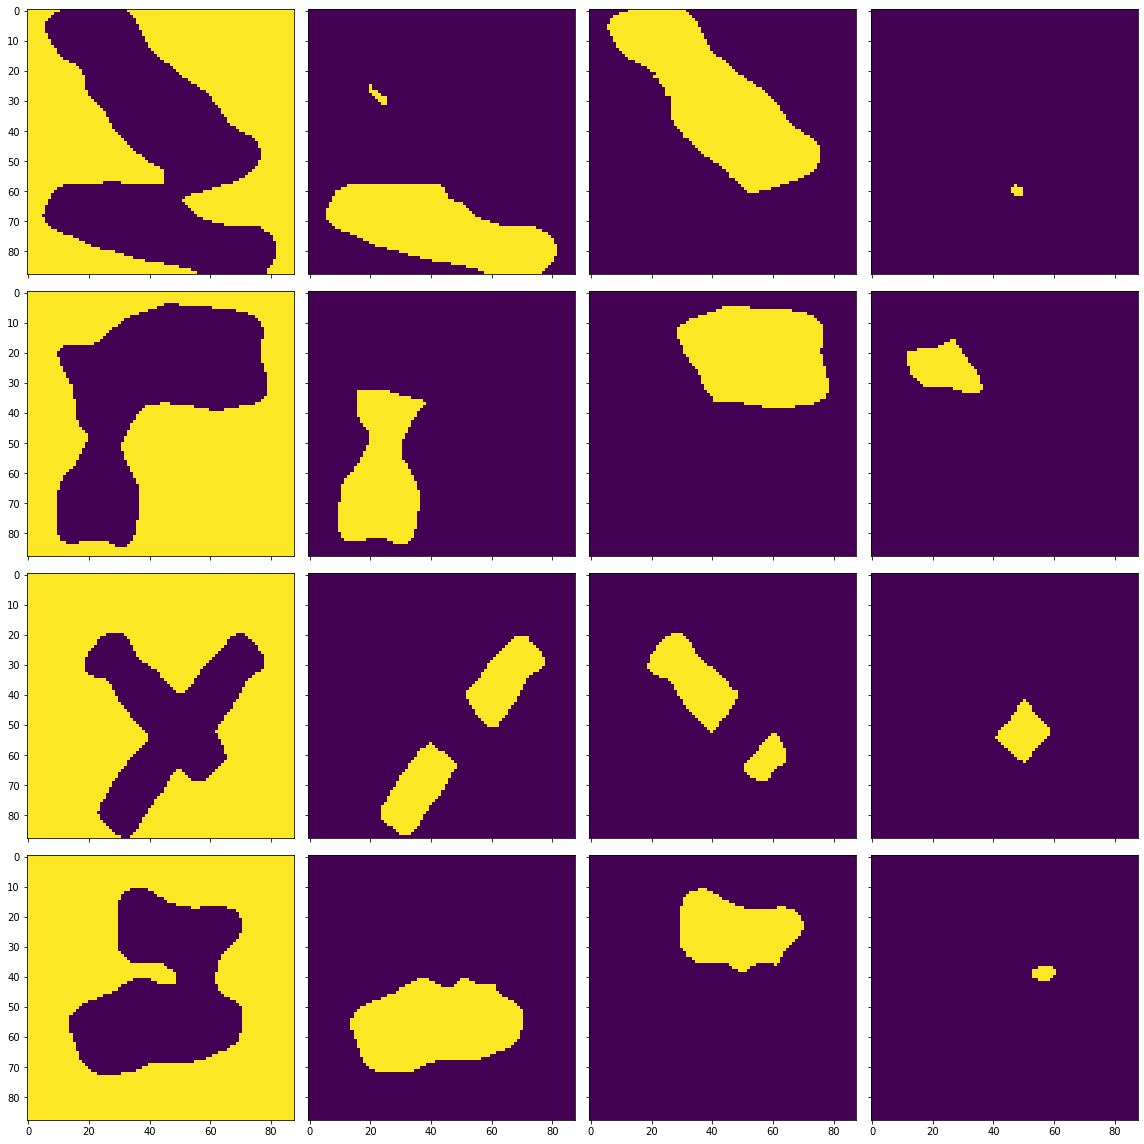

Training IOU: [0.9792319728074672, 0.9226429368835746, 0.92275033654344, 0.8518394298291584]
Training accuracy: 0.9677979726239669
Testing IOU: [0.9737617266026357, 0.5034245109370318, 0.3996845792131896, 0.46950573698146514]
Testing accuracy: 0.8787848657024794
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0685 - val_loss: 0.0511
INFO:tensorflow:Assets written to: modelseg/savedmodel_203epoch\assets
4
4


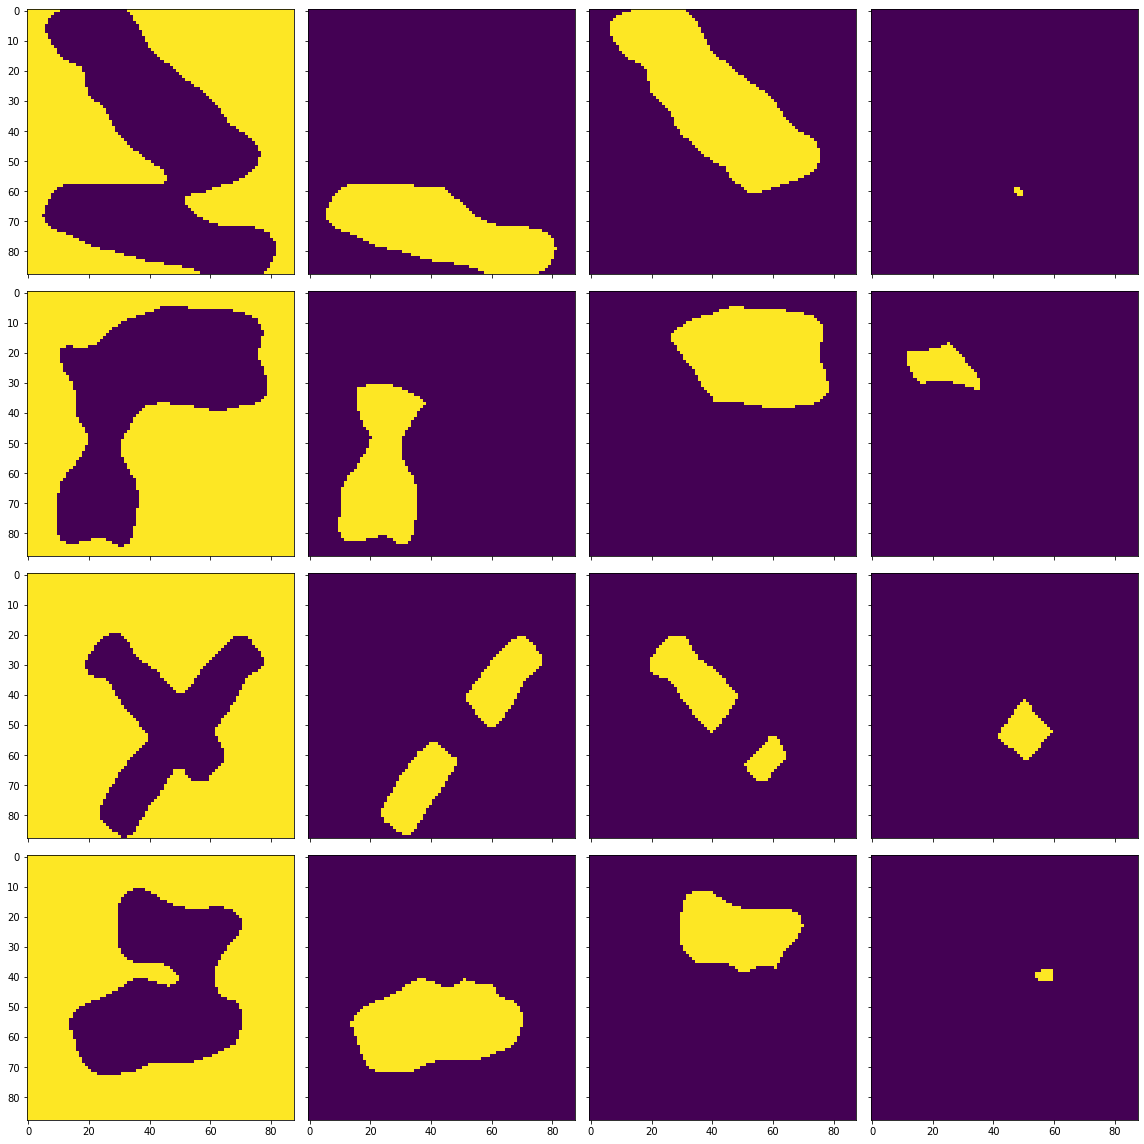

Training IOU: [0.9829407120858166, 0.9150130554314739, 0.9025460064711797, 0.813541900876883]
Training accuracy: 0.9674118672520661
Testing IOU: [0.9750418661533865, 0.5126889216483198, 0.36957237662791276, 0.4407891653779465]
Testing accuracy: 0.8808638946280992
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0685 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelseg/savedmodel_204epoch\assets
4
4


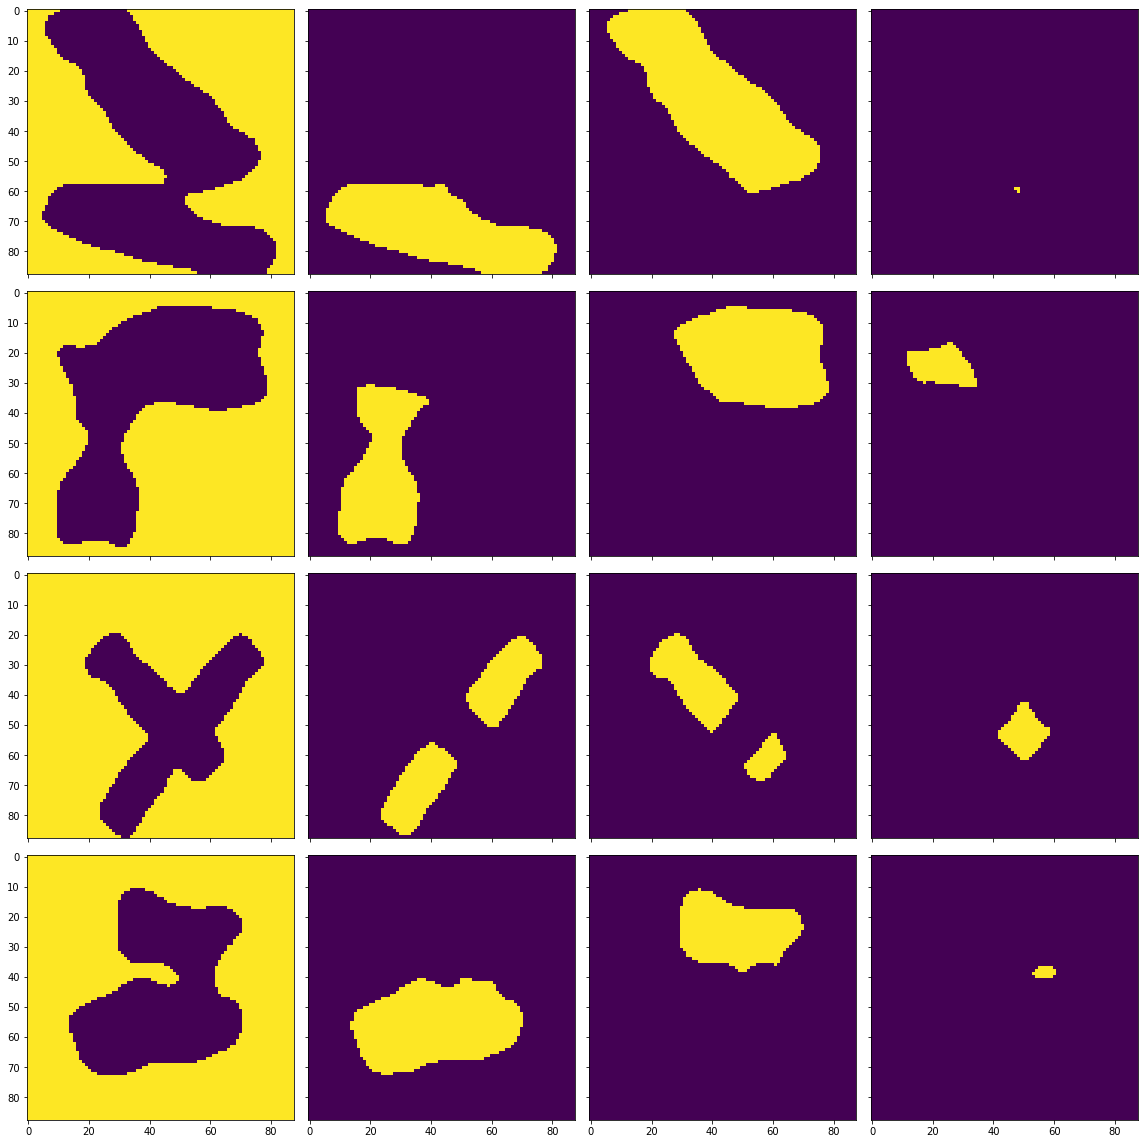

Training IOU: [0.9817276359233591, 0.9256200447832588, 0.9246899286194109, 0.8185499897947126]
Training accuracy: 0.9689427298553719
Testing IOU: [0.9747390309401156, 0.4983191714588161, 0.3993385736196319, 0.45820149493281975]
Testing accuracy: 0.8794201962809918
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0684 - val_loss: 0.0522
INFO:tensorflow:Assets written to: modelseg/savedmodel_205epoch\assets
4
4


Training IOU: [0.9805380120112428, 0.9284432118647588, 0.921374479260509, 0.8609044677005842]
Training accuracy: 0.9697659478305786
Testing IOU: [0.9742636291368562, 0.48995427862633956, 0.39974871544837415, 0.48238132161626607]
Testing accuracy: 0.8789165805785124
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0505
INFO:tensorflow:Assets written to: modelseg/savedmodel_206epoch\assets
4
4


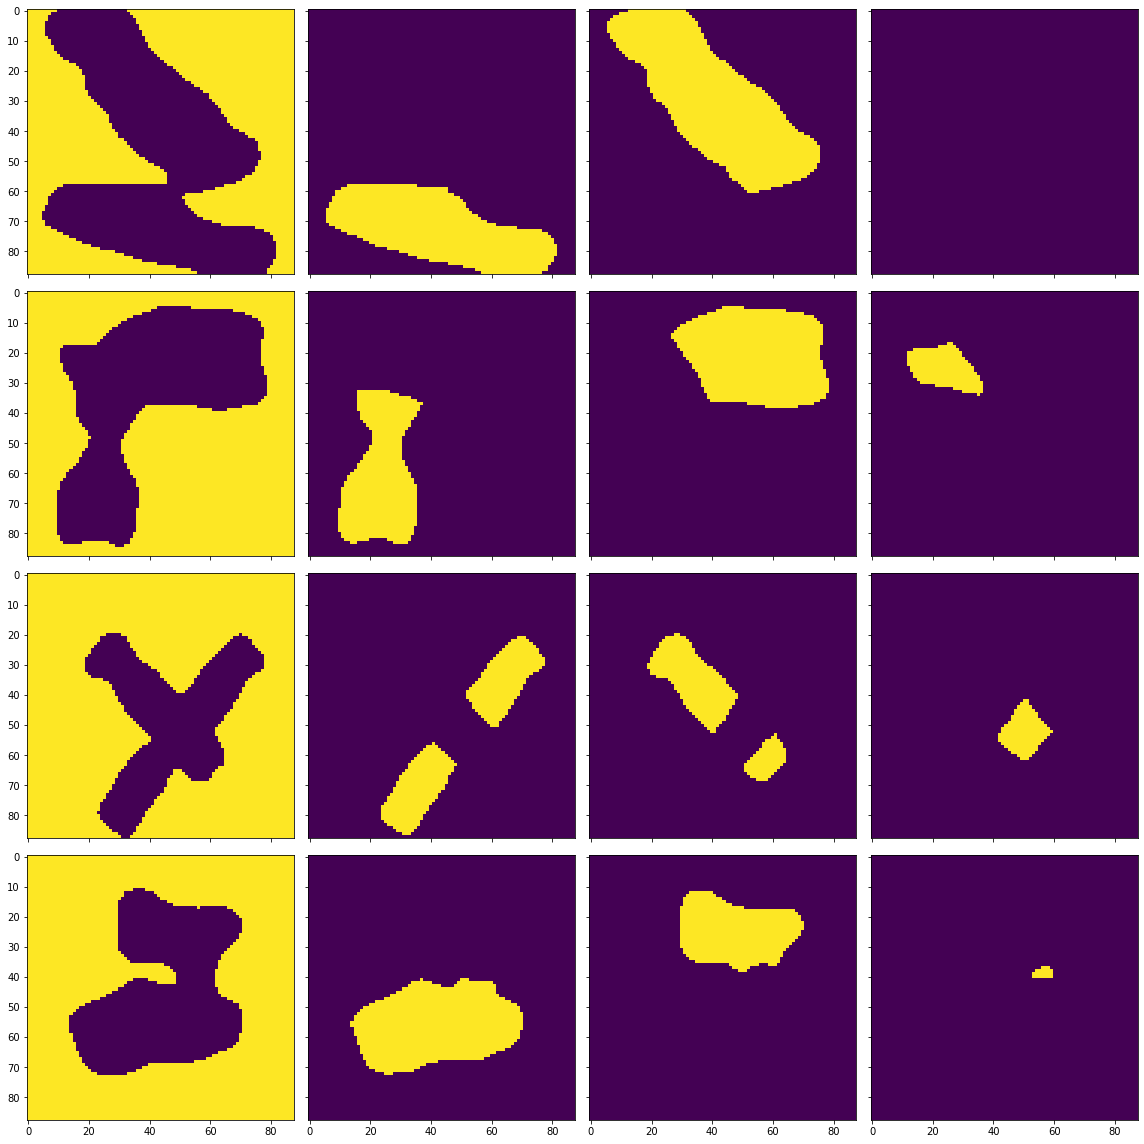

Training IOU: [0.9814717394947149, 0.9206132168391291, 0.9298439705489643, 0.8527097995024769]
Training accuracy: 0.9695877453512397
Testing IOU: [0.9746952558178434, 0.49964085411421566, 0.40731899064273663, 0.4758089233328955]
Testing accuracy: 0.8801872417355372
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0490
INFO:tensorflow:Assets written to: modelseg/savedmodel_207epoch\assets
4
4


Training IOU: [0.9795189268666108, 0.925459460834534, 0.9334323510449904, 0.862958355925536]
Training accuracy: 0.9692248837809917
Testing IOU: [0.9737512150599371, 0.5109796514735754, 0.4023198668833682, 0.48129084235968134]
Testing accuracy: 0.8806934400826446
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0686 - val_loss: 0.0522
INFO:tensorflow:Assets written to: modelseg/savedmodel_208epoch\assets
4
4


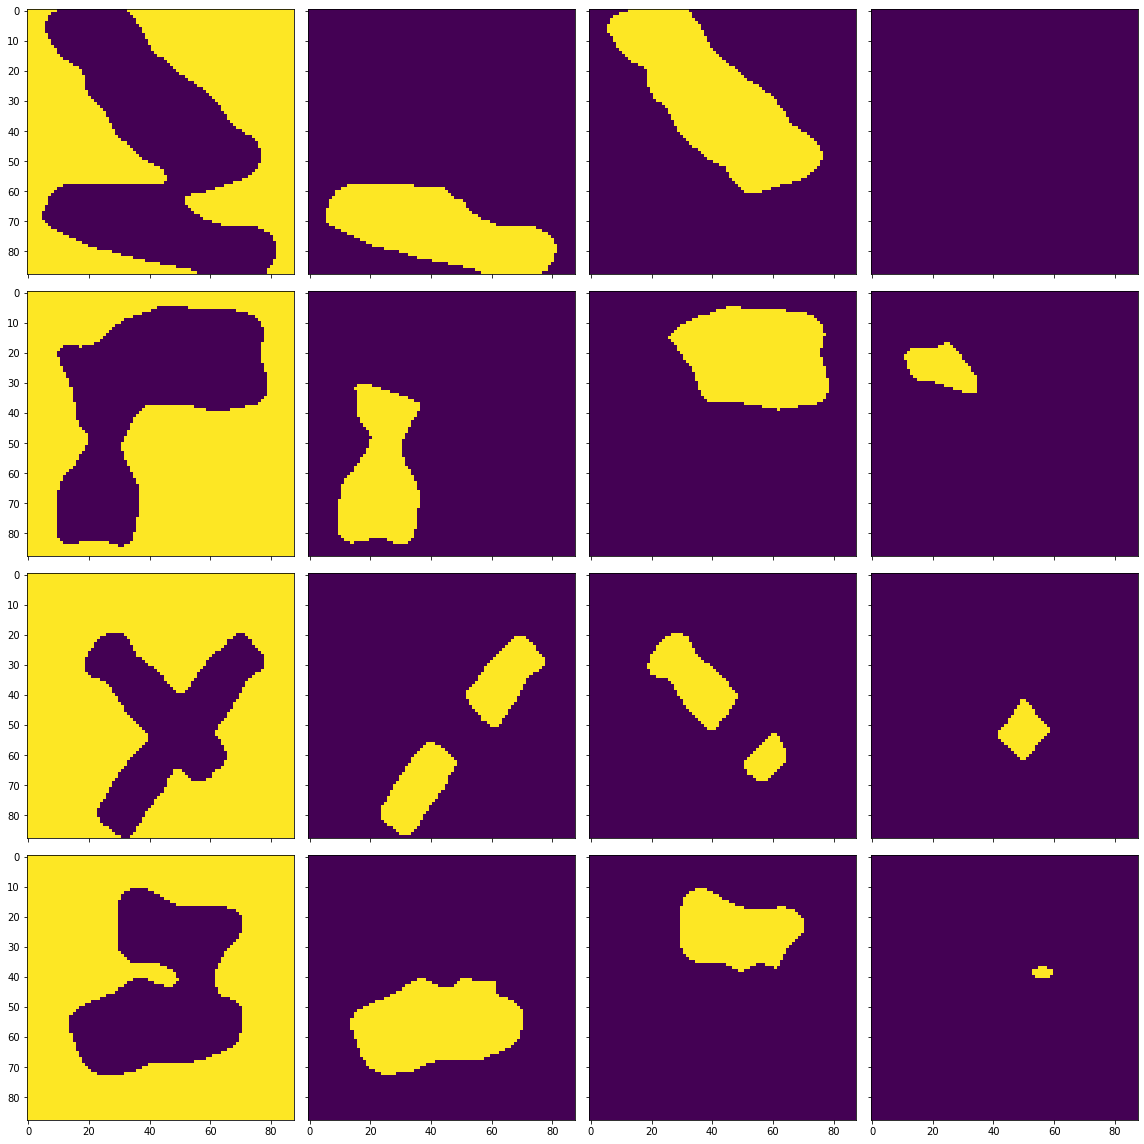

Training IOU: [0.9789345320106859, 0.9293594519335386, 0.9372585565133529, 0.8358530853997447]
Training accuracy: 0.9695667613636364
Testing IOU: [0.9738274001441911, 0.49819313030296497, 0.4040246521617331, 0.4767281740567337]
Testing accuracy: 0.8792032541322314
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_209epoch\assets
4
4


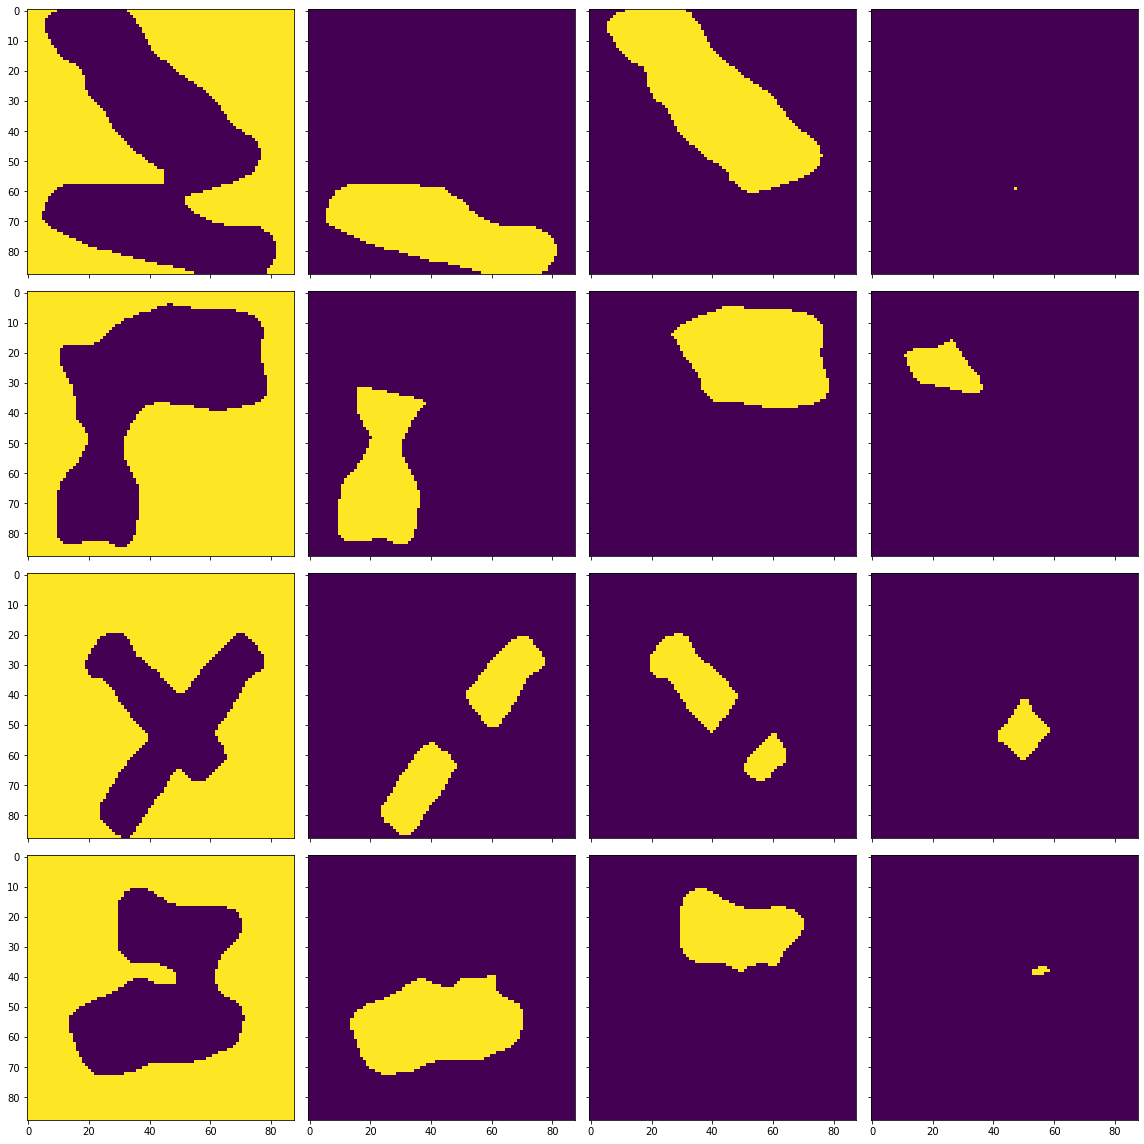

Training IOU: [0.9800718616521523, 0.9301356132620163, 0.936607873134227, 0.8346650607074108]
Training accuracy: 0.9698379390495868
Testing IOU: [0.9739730902898935, 0.5027531477534751, 0.4177162954279015, 0.47204137230456666]
Testing accuracy: 0.880860020661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0521
INFO:tensorflow:Assets written to: modelseg/savedmodel_210epoch\assets
4
4


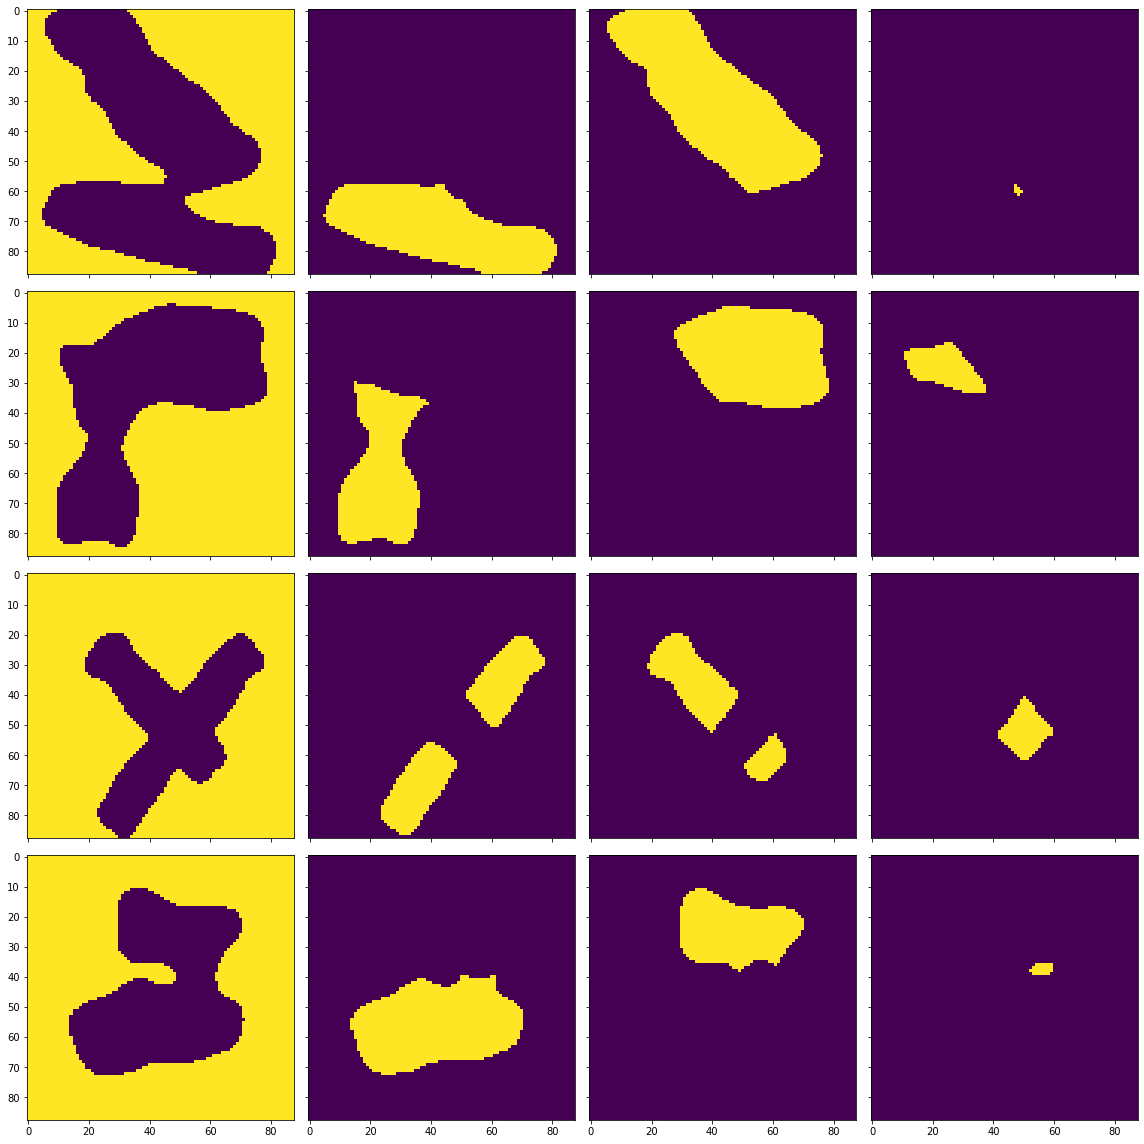

Training IOU: [0.9779533016490243, 0.930067034428183, 0.9296150145938983, 0.8703344769328041]
Training accuracy: 0.9695467458677686
Testing IOU: [0.9728561645750063, 0.5008705947903608, 0.3737429679074241, 0.4825762545096753]
Testing accuracy: 0.8768672520661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_211epoch\assets
4
4


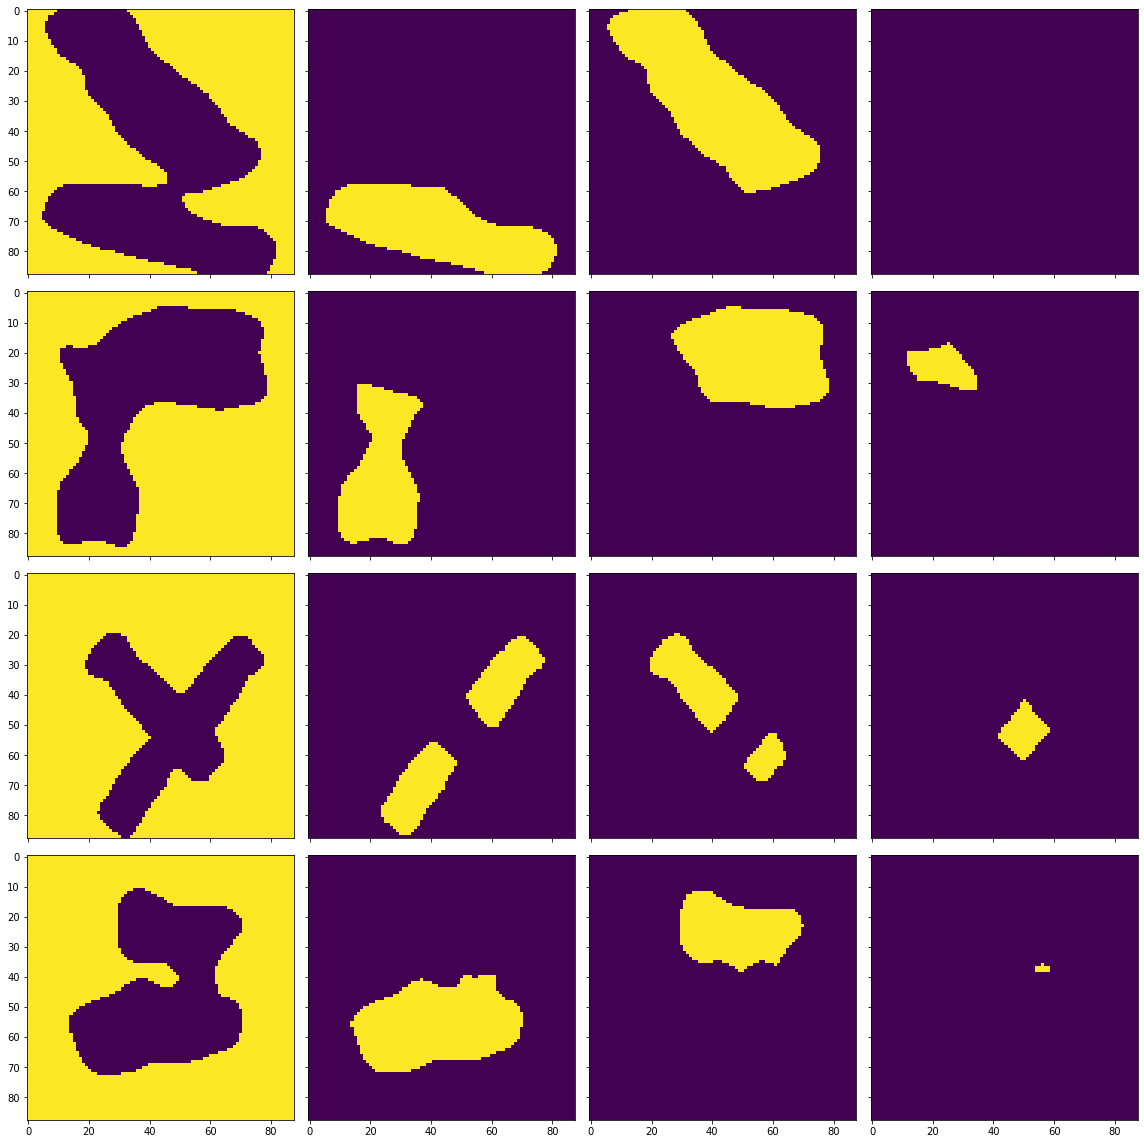

Training IOU: [0.9832117665630987, 0.9219240637649478, 0.920148344805879, 0.8106441790658]
Training accuracy: 0.969049909607438
Testing IOU: [0.9750090376941366, 0.5127648593426327, 0.3910974961092177, 0.44723476297968395]
Testing accuracy: 0.8816257747933884
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0682 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_212epoch\assets
4
4


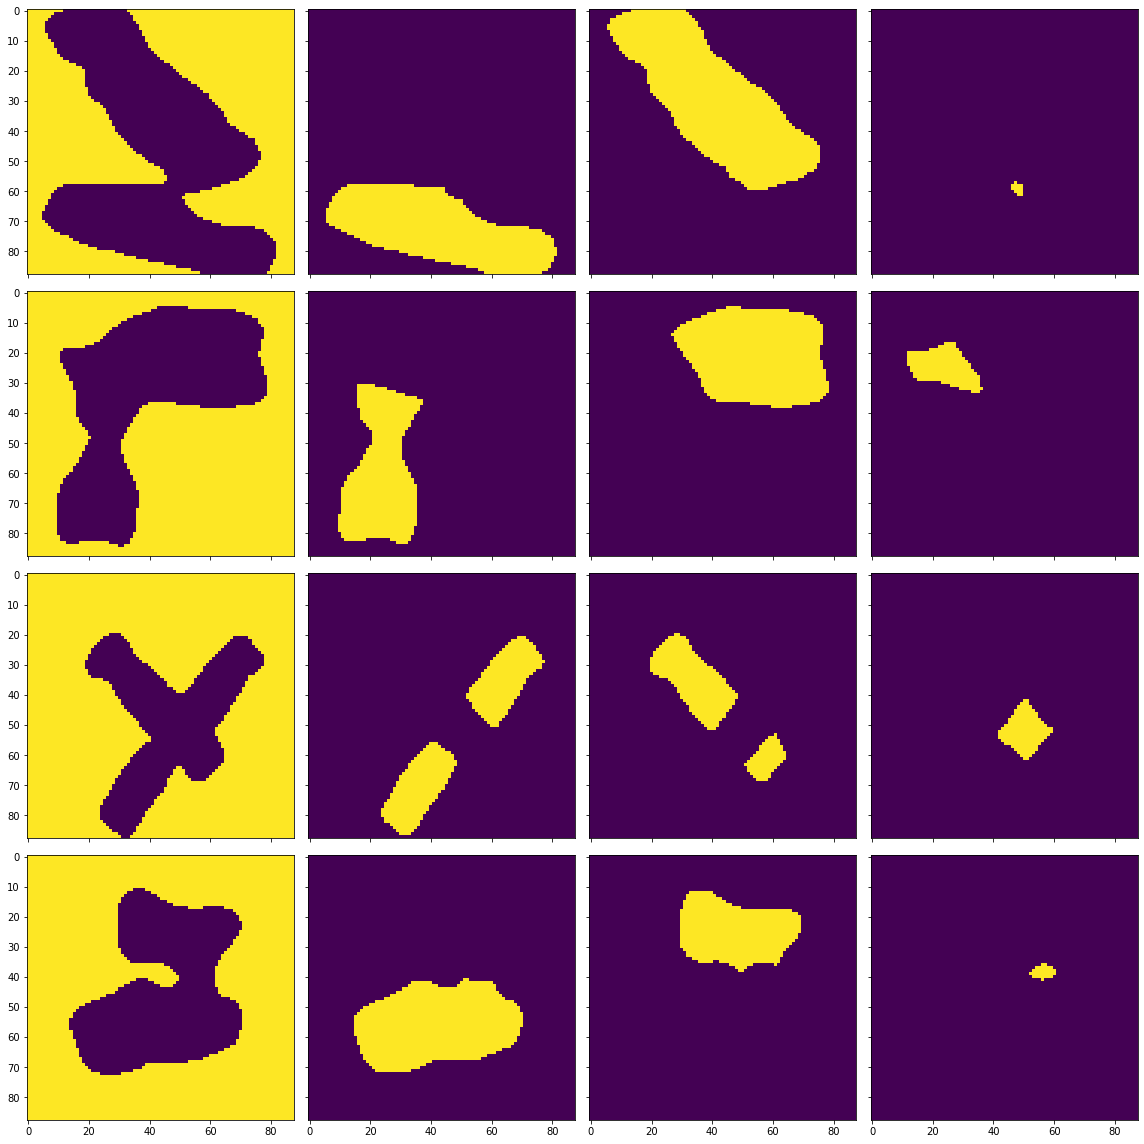

Training IOU: [0.9835606161105156, 0.9128102770009168, 0.9099575980647603, 0.8569209780669536]
Training accuracy: 0.9689233600206612
Testing IOU: [0.9747523497692765, 0.5082724345412689, 0.37820545115622956, 0.4722652744922098]
Testing accuracy: 0.8799819214876033
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0682 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_213epoch\assets
4
4


Training IOU: [0.9833686312897887, 0.9182369783140252, 0.9147577014039424, 0.8619775090176108]
Training accuracy: 0.9696074380165289
Testing IOU: [0.9747313929350044, 0.47922223368355904, 0.41422617706690695, 0.47413793103448276]
Testing accuracy: 0.879610020661157
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0549
INFO:tensorflow:Assets written to: modelseg/savedmodel_214epoch\assets
4
4


Training IOU: [0.9566203403400352, 0.9078993879828385, 0.9130151837886464, 0.86427648782332]
Training accuracy: 0.9501459194214876
Testing IOU: [0.9462455796633249, 0.48891122424454303, 0.4060277298332796, 0.49135909683022144]
Testing accuracy: 0.8600942665289256
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0521
INFO:tensorflow:Assets written to: modelseg/savedmodel_215epoch\assets
4
4


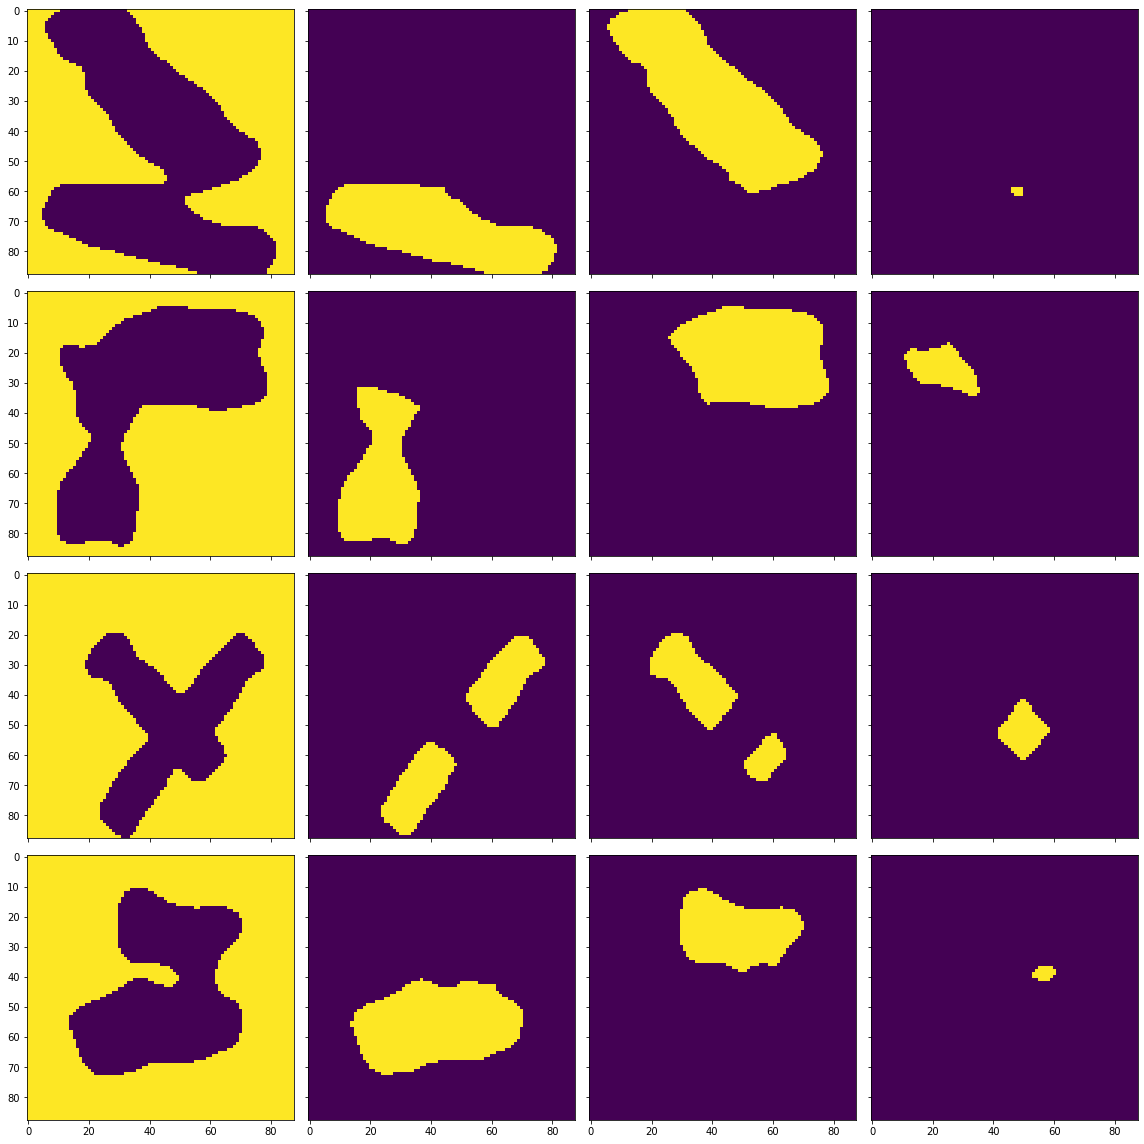

Training IOU: [0.9819168799304374, 0.9220013114085593, 0.927395395406319, 0.864240147731565]
Training accuracy: 0.9702124225206612
Testing IOU: [0.9744202979334179, 0.4469469276117039, 0.4354590603436909, 0.48388161968052174]
Testing accuracy: 0.8761789772727273
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0683 - val_loss: 0.0504
INFO:tensorflow:Assets written to: modelseg/savedmodel_216epoch\assets
4
4


Training IOU: [0.9832160886528593, 0.9163309143686502, 0.913909935198079, 0.8743974990328618]
Training accuracy: 0.9695599819214876
Testing IOU: [0.9746498952510931, 0.48399293440971664, 0.4046827852259272, 0.4955157903685128]
Testing accuracy: 0.8793259297520661
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0681 - val_loss: 0.0512
INFO:tensorflow:Assets written to: modelseg/savedmodel_217epoch\assets
4
4


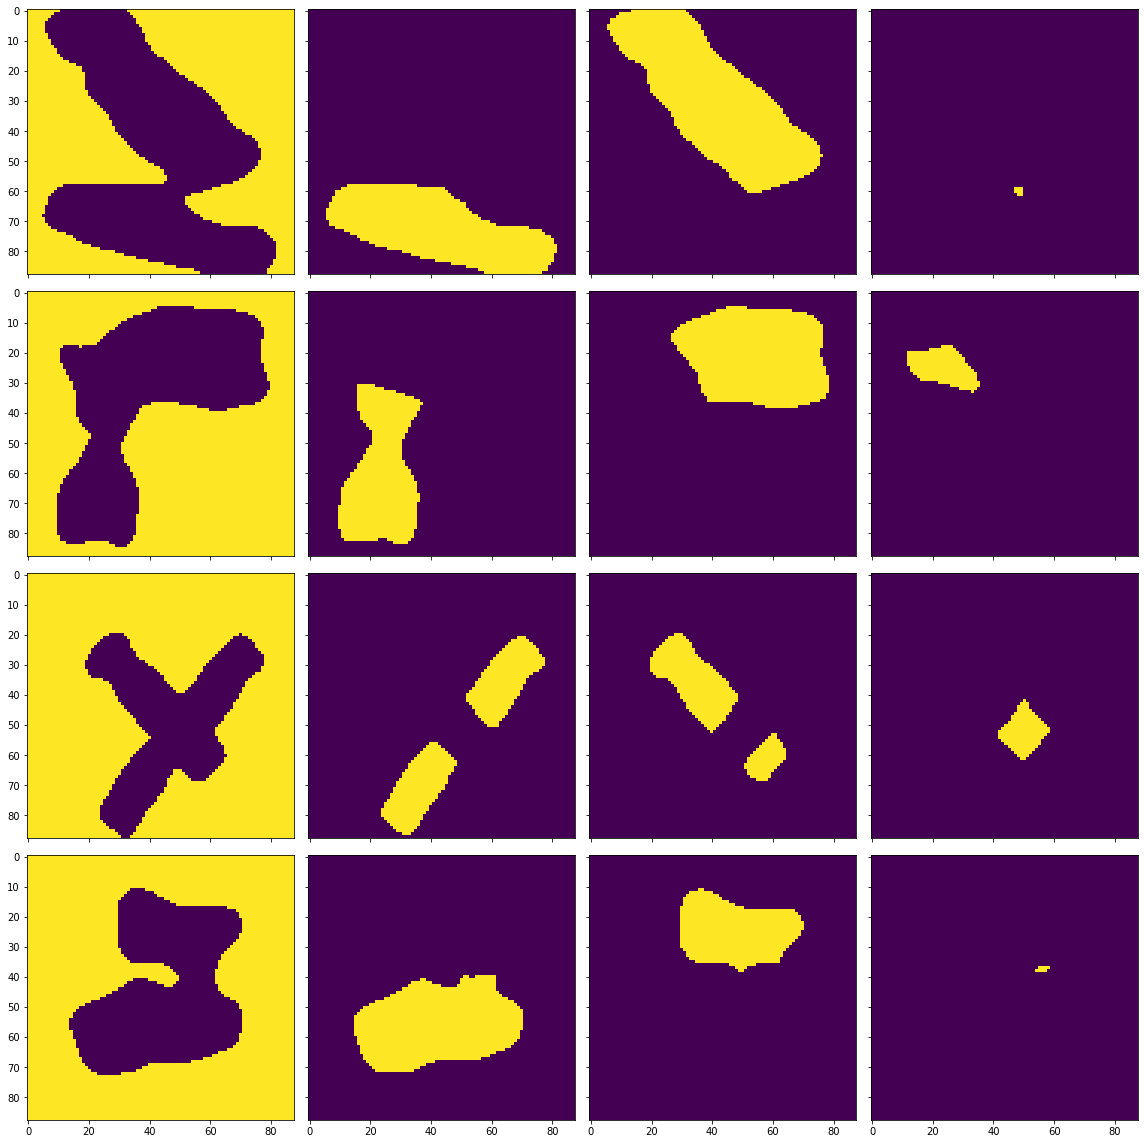

Training IOU: [0.983048785087349, 0.9204679909241499, 0.9279687521339507, 0.8377934322716436]
Training accuracy: 0.969753034607438
Testing IOU: [0.974763165493656, 0.48912780244376763, 0.4089356061313269, 0.47631265463209016]
Testing accuracy: 0.8796732954545454
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_218epoch\assets
4
4


Training IOU: [0.9833333333333333, 0.925196084335954, 0.9181405137592555, 0.8594096174540544]
Training accuracy: 0.9705223398760331
Testing IOU: [0.9749038476592058, 0.47739784503061705, 0.4083004245694051, 0.4940639269406393]
Testing accuracy: 0.8790198863636364
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0681 - val_loss: 0.0509
INFO:tensorflow:Assets written to: modelseg/savedmodel_219epoch\assets
4
4


Training IOU: [0.9838858416065741, 0.916293898531158, 0.9184839343399887, 0.8556397576691713]
Training accuracy: 0.9698208290289256
Testing IOU: [0.974616935588911, 0.50066013431057, 0.39022305121628975, 0.4783379894461443]
Testing accuracy: 0.8810821280991735
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0682 - val_loss: 0.0513
INFO:tensorflow:Assets written to: modelseg/savedmodel_220epoch\assets
4
4


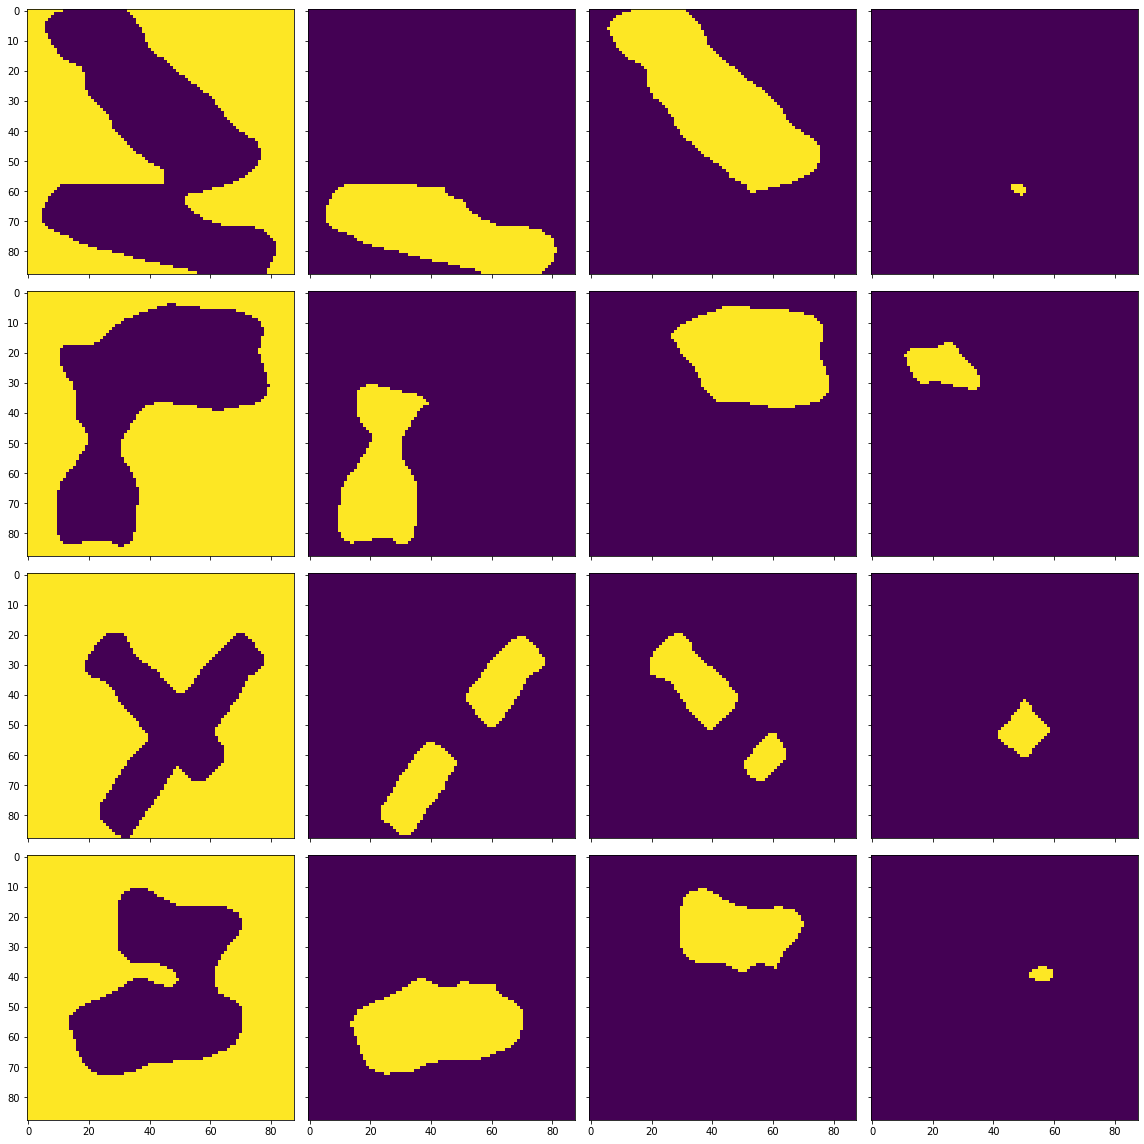

Training IOU: [0.982771170410176, 0.9271601277055174, 0.9306117100417416, 0.8257690939087116]
Training accuracy: 0.9700829674586777
Testing IOU: [0.9746517950699543, 0.49980689494356234, 0.4169188264702013, 0.47007551039433204]
Testing accuracy: 0.8819666838842976
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0518
INFO:tensorflow:Assets written to: modelseg/savedmodel_221epoch\assets
4
4


Training IOU: [0.9837054645450155, 0.9133685013583417, 0.920762547365313, 0.8573015228860078]
Training accuracy: 0.9702621384297521
Testing IOU: [0.9743392664743123, 0.49342010435584766, 0.394440962528251, 0.48496495591227673]
Testing accuracy: 0.8810743801652893
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0519
INFO:tensorflow:Assets written to: modelseg/savedmodel_222epoch\assets
4
4


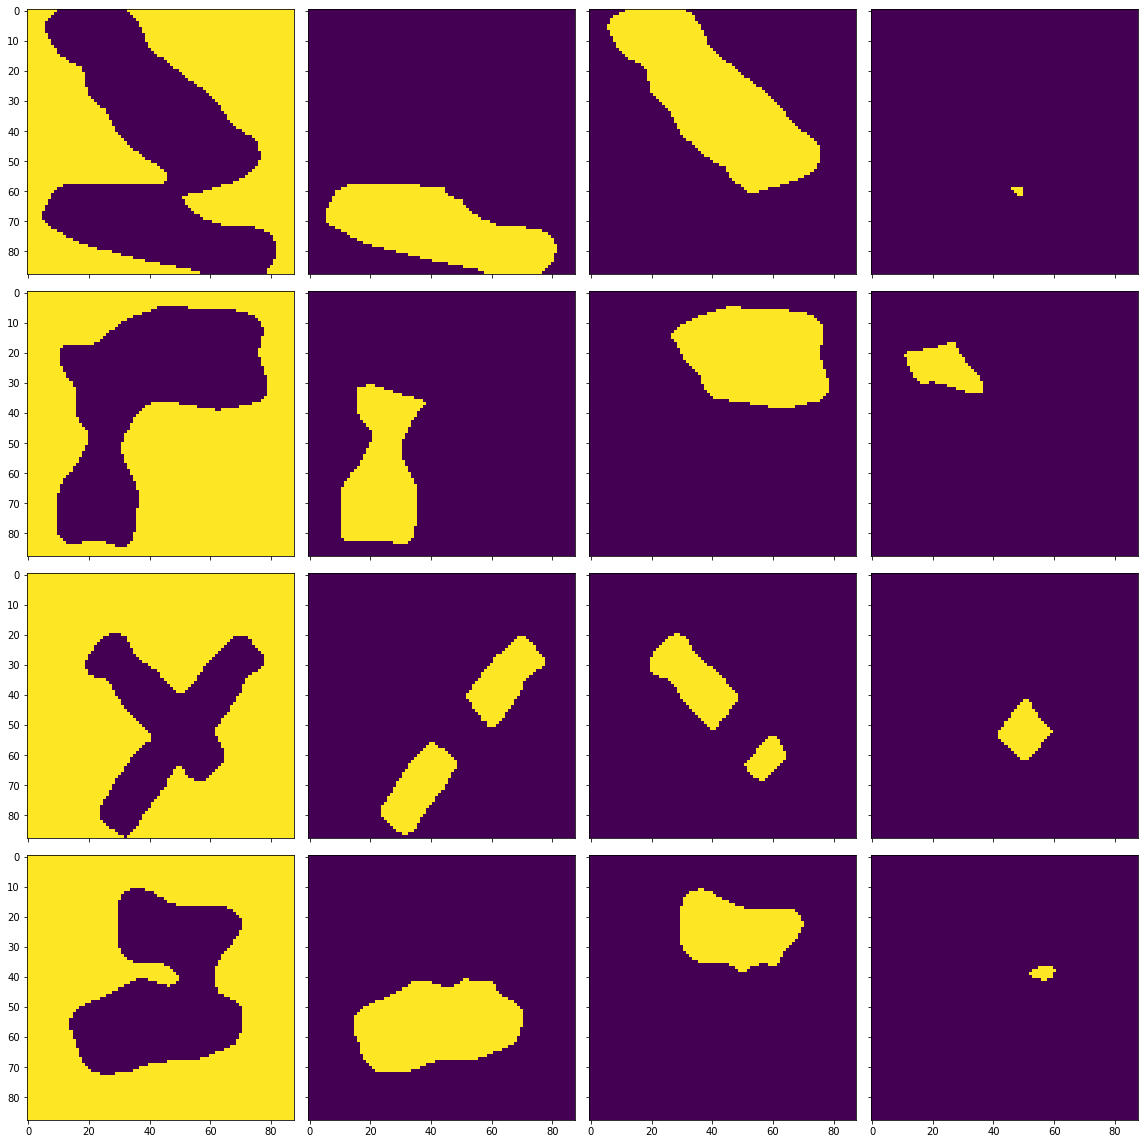

Training IOU: [0.9834998941236851, 0.918921493902439, 0.9245938881361963, 0.8731153650686092]
Training accuracy: 0.9710585614669421
Testing IOU: [0.9742809633605374, 0.49067608287606707, 0.39239734316780545, 0.49655475093263113]
Testing accuracy: 0.8799651342975207
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0521
INFO:tensorflow:Assets written to: modelseg/savedmodel_223epoch\assets
4
4


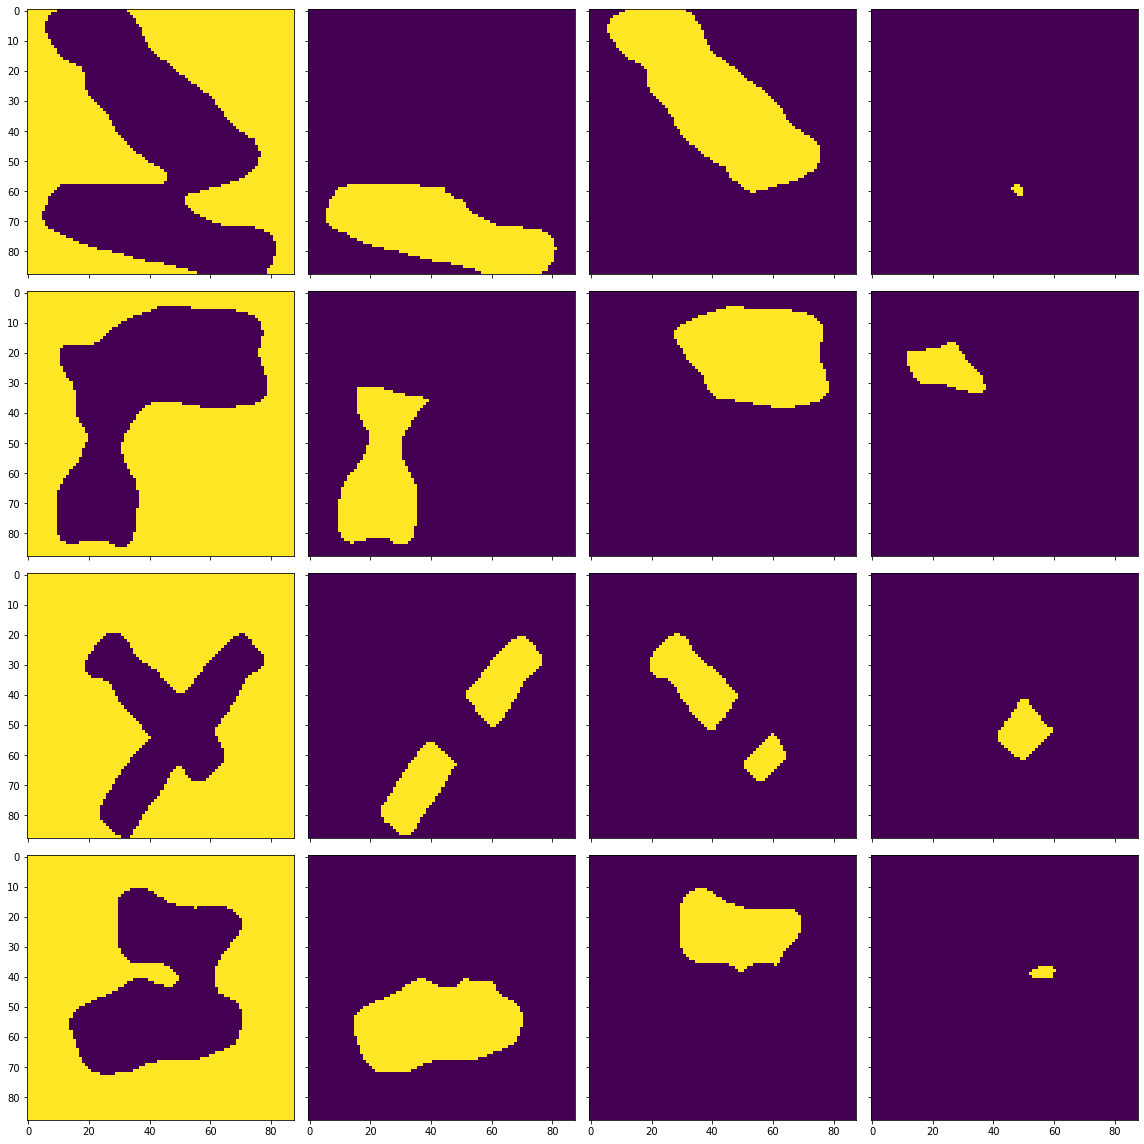

Training IOU: [0.9832657844993943, 0.9187462539551264, 0.9200322260647481, 0.884680967517841]
Training accuracy: 0.970350916838843
Testing IOU: [0.9744264643500393, 0.49731312729237154, 0.37748976807639834, 0.4982342807924203]
Testing accuracy: 0.8790870351239669
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0520
INFO:tensorflow:Assets written to: modelseg/savedmodel_224epoch\assets
4
4


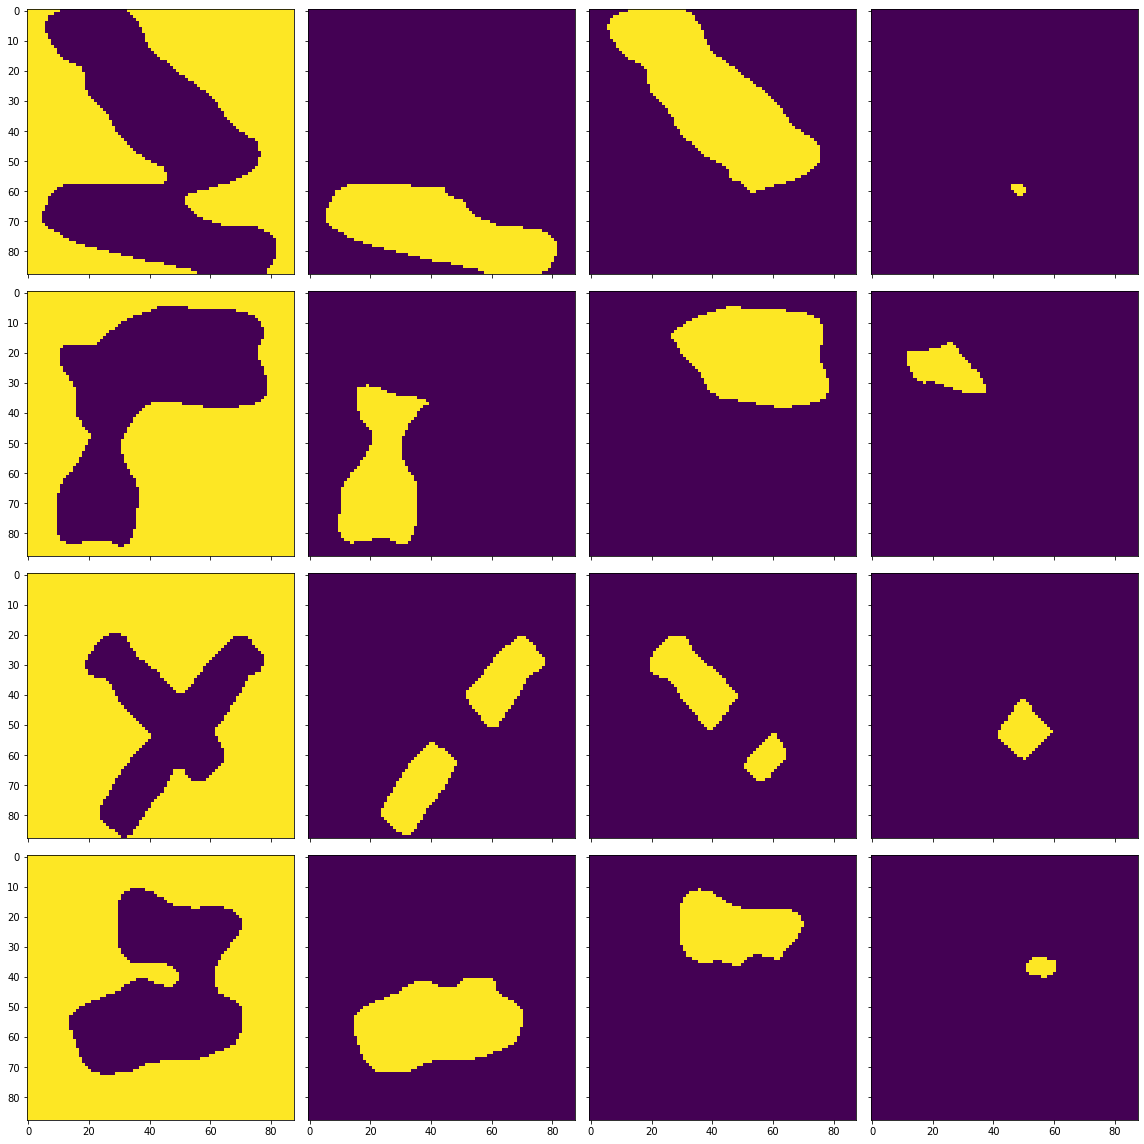

Training IOU: [0.9838323544074997, 0.9164143731775038, 0.9131921498084616, 0.87228474221408]
Training accuracy: 0.9695222107438016
Testing IOU: [0.9744493453318179, 0.51464095057689, 0.3470912994581331, 0.48655902704969595]
Testing accuracy: 0.879349173553719
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_225epoch\assets
4
4


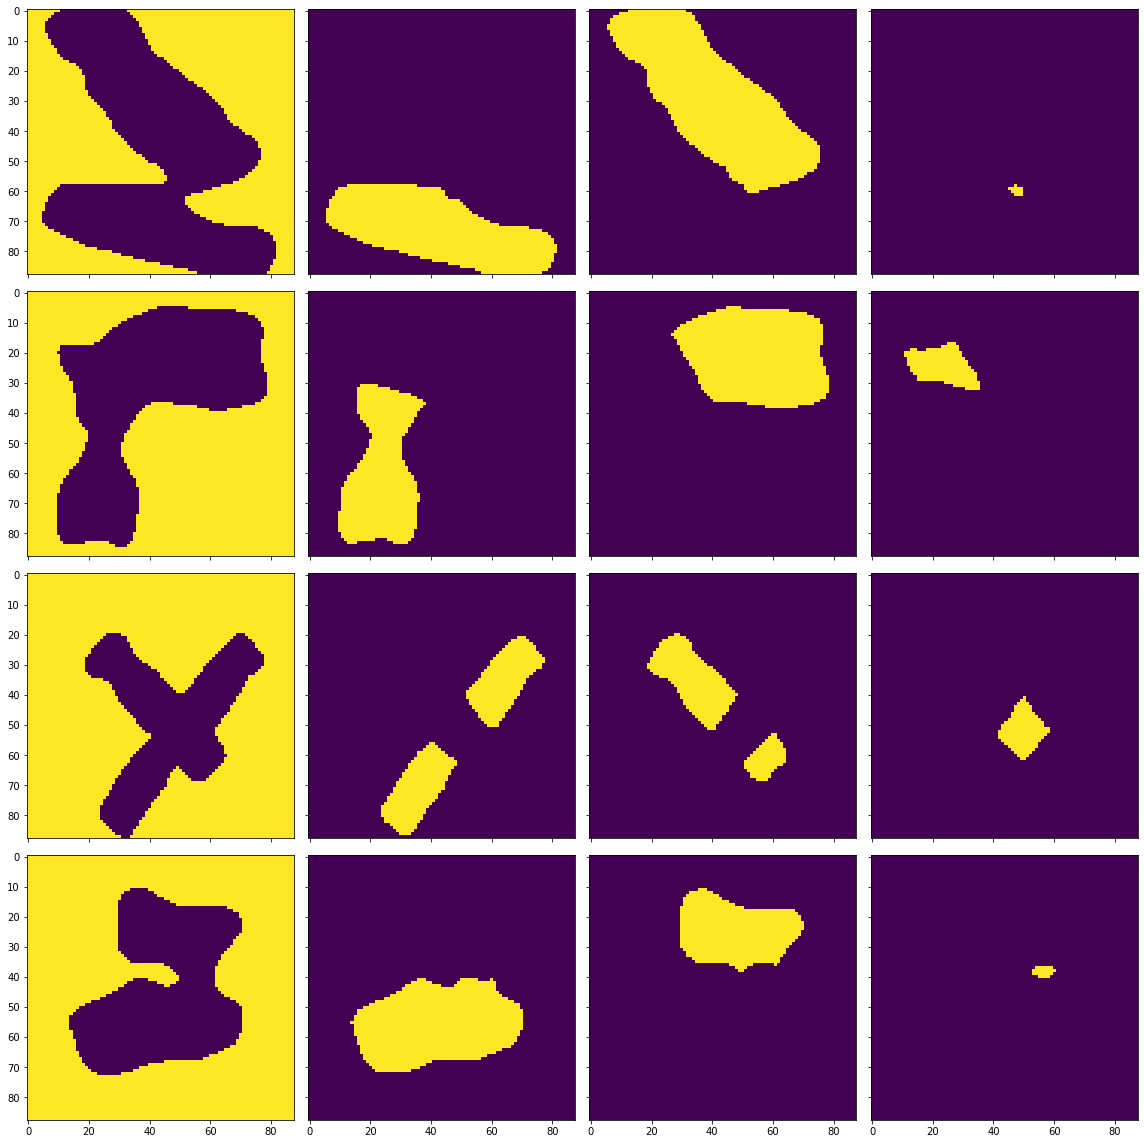

Training IOU: [0.9828798370415783, 0.9246346400252549, 0.9273440597104698, 0.8694802989130435]
Training accuracy: 0.9704978047520662
Testing IOU: [0.9745245446582347, 0.49642672792968323, 0.40644119646498983, 0.49383041320862425]
Testing accuracy: 0.8809220041322314
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0680 - val_loss: 0.0513
INFO:tensorflow:Assets written to: modelseg/savedmodel_226epoch\assets
4
4


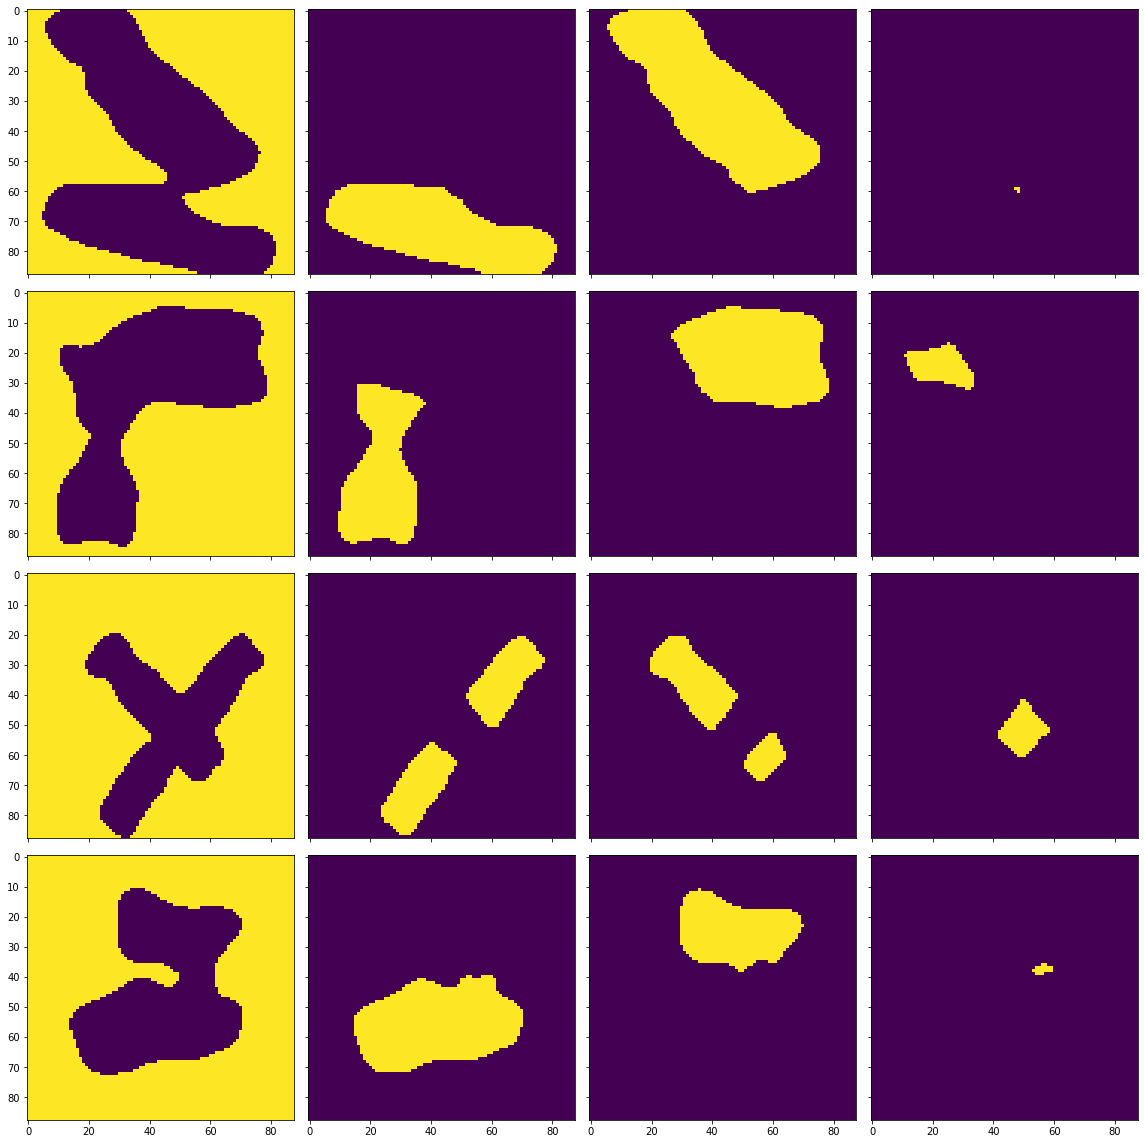

Training IOU: [0.9845182208596933, 0.9217771110915027, 0.9212293819439314, 0.8114787802713874]
Training accuracy: 0.9699912835743801
Testing IOU: [0.9745159045673899, 0.507926339945656, 0.3827789412165782, 0.4677762541964159]
Testing accuracy: 0.8818969524793389
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0490
INFO:tensorflow:Assets written to: modelseg/savedmodel_227epoch\assets
4
4


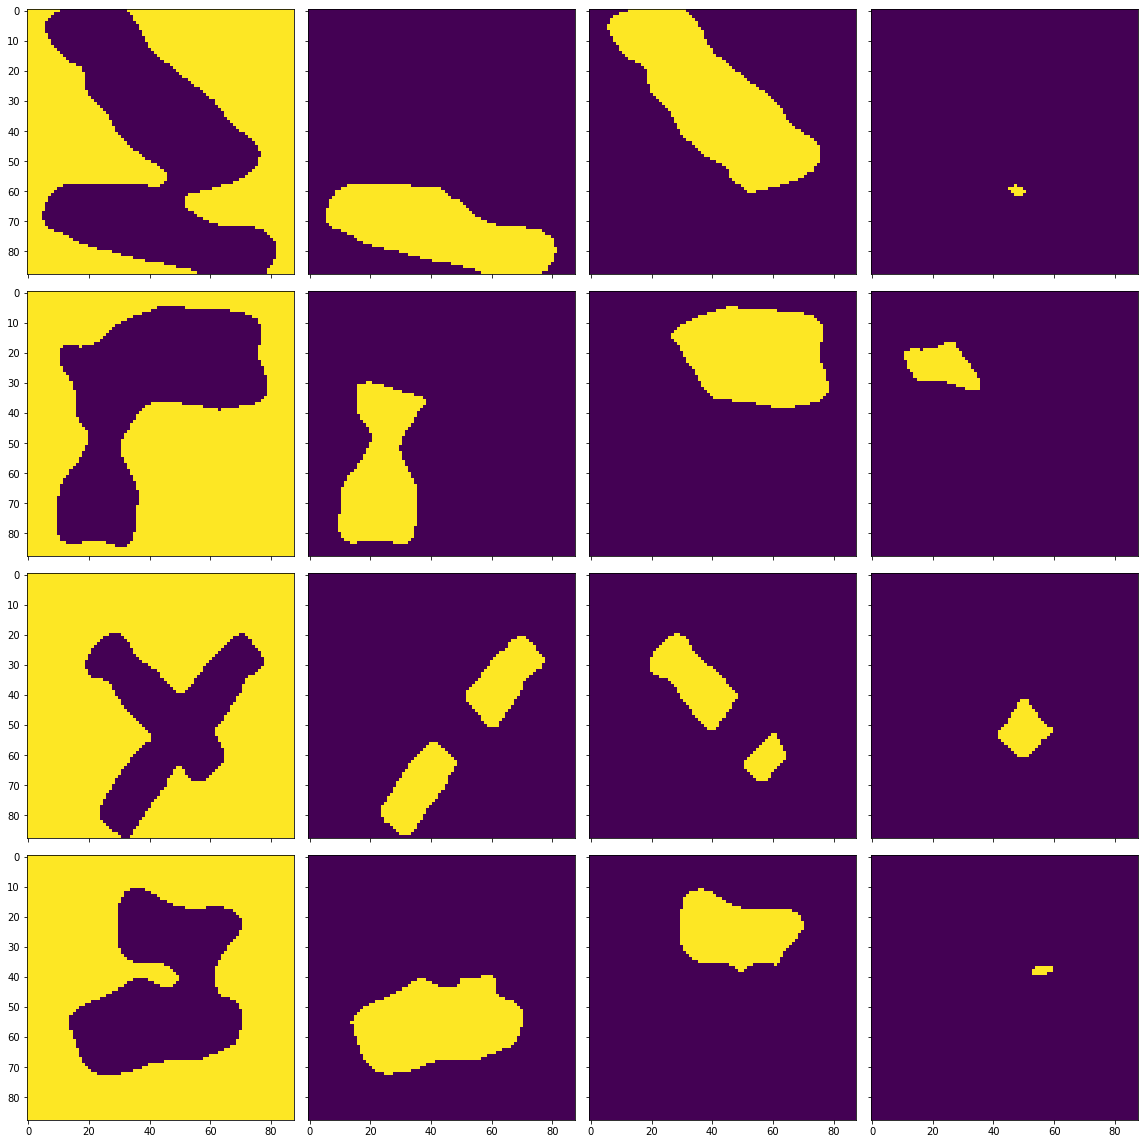

Training IOU: [0.9846376208274493, 0.9245459017458535, 0.9235887317768278, 0.8538171455507703]
Training accuracy: 0.9717668517561984
Testing IOU: [0.9748573670813988, 0.5097705550355938, 0.3901929181929182, 0.47367467970483046]
Testing accuracy: 0.8829777892561983
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0678 - val_loss: 0.0504
INFO:tensorflow:Assets written to: modelseg/savedmodel_228epoch\assets
4
4


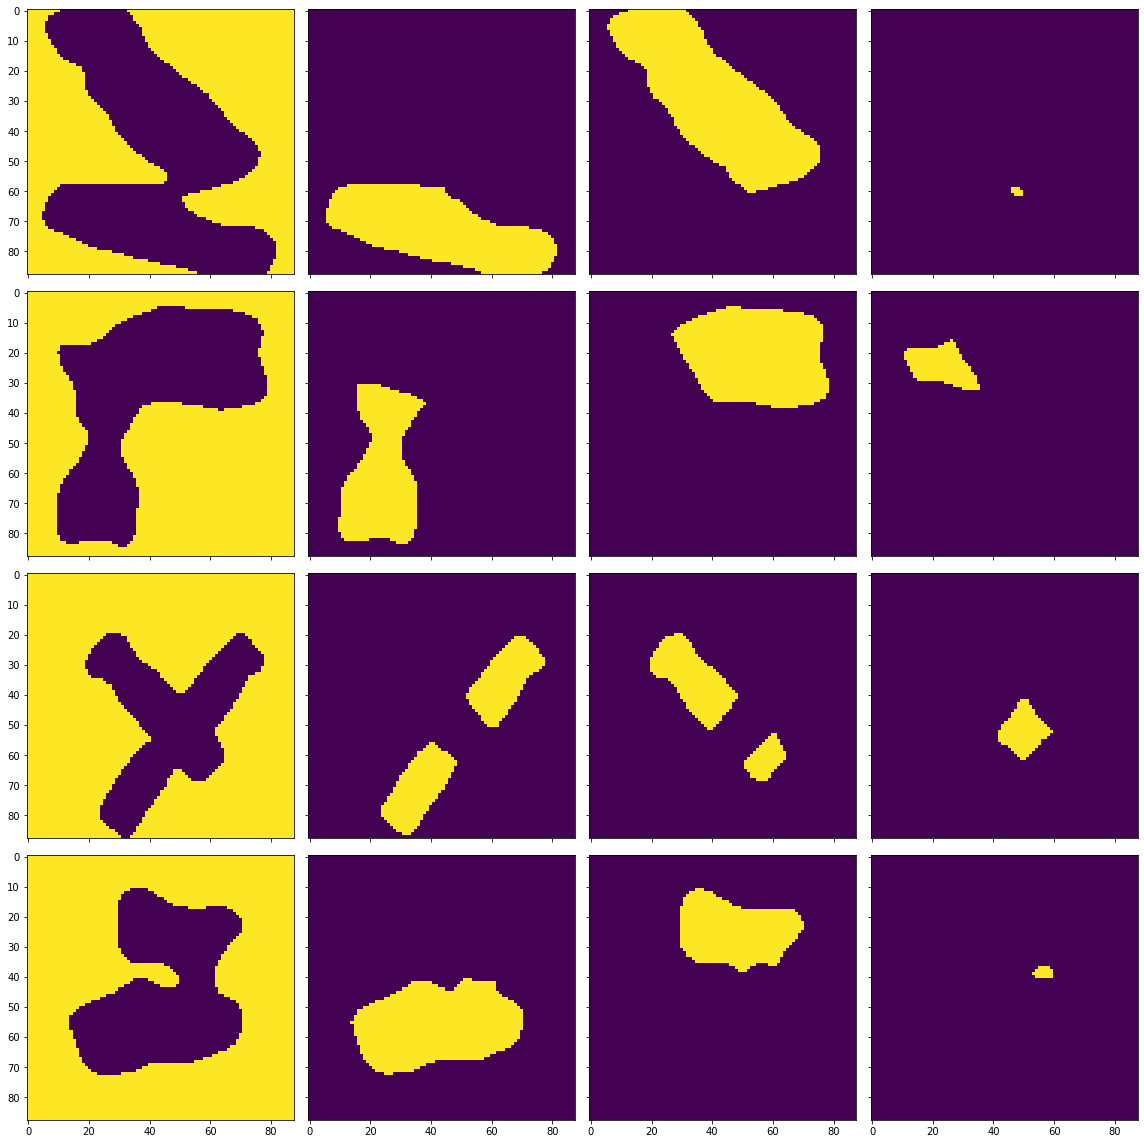

Training IOU: [0.9838288976816868, 0.9287703274671419, 0.9290489670541469, 0.8646170673644026]
Training accuracy: 0.9718950154958678
Testing IOU: [0.9747131835538275, 0.5098415269105916, 0.38591642178968705, 0.4806177537835207]
Testing accuracy: 0.8816361053719008
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelseg/savedmodel_229epoch\assets
4
4


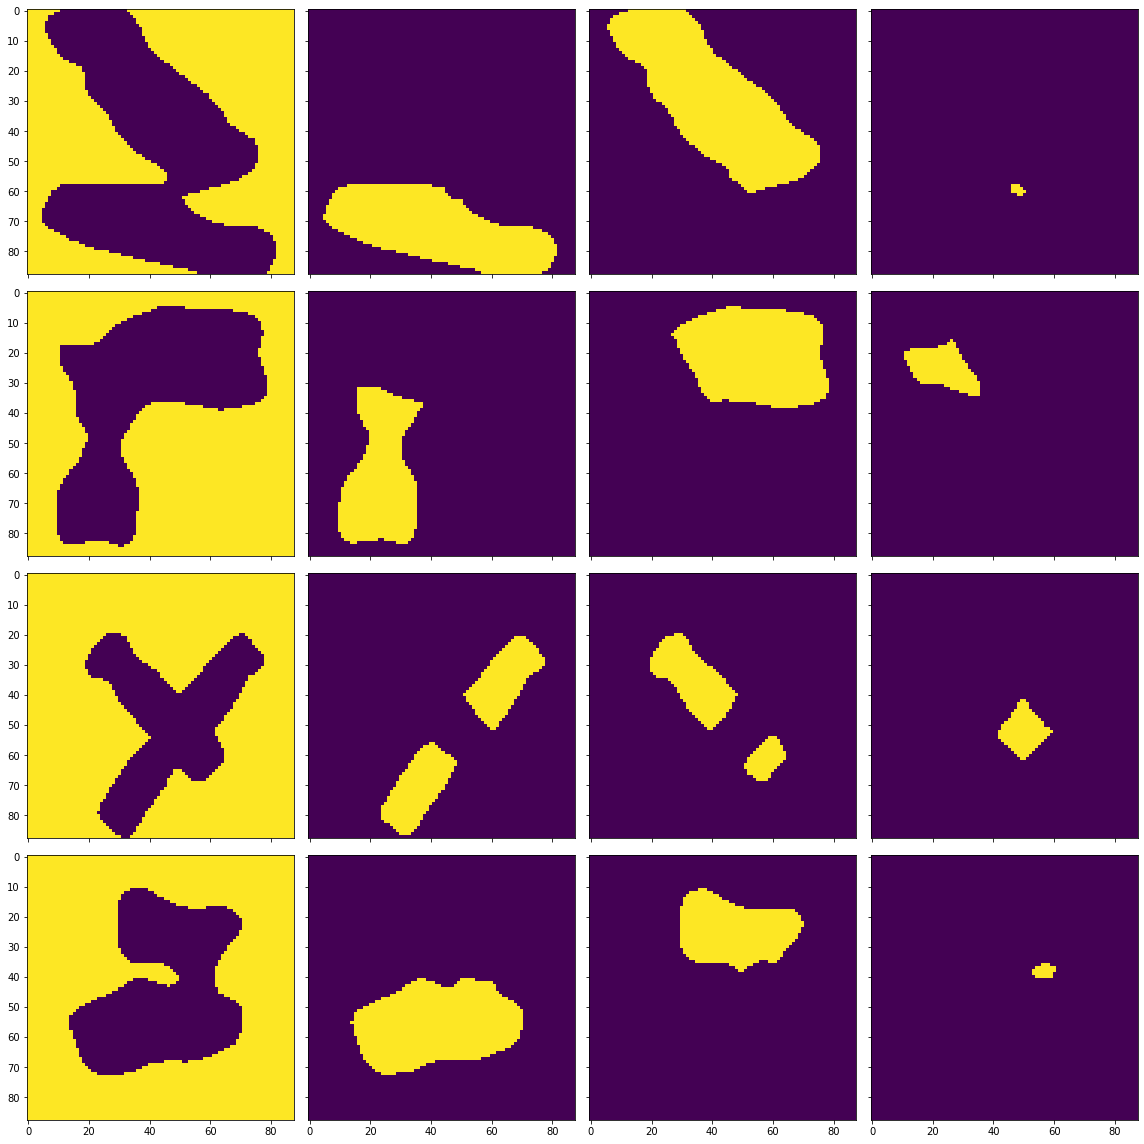

Training IOU: [0.9832935871932633, 0.9308914355902154, 0.9291607451402409, 0.8758591294155256]
Training accuracy: 0.9720351239669421
Testing IOU: [0.9746067227944095, 0.5135104426312164, 0.39402446751474385, 0.4908240845932011]
Testing accuracy: 0.8829842458677686
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0678 - val_loss: 0.0516
INFO:tensorflow:Assets written to: modelseg/savedmodel_230epoch\assets
4
4


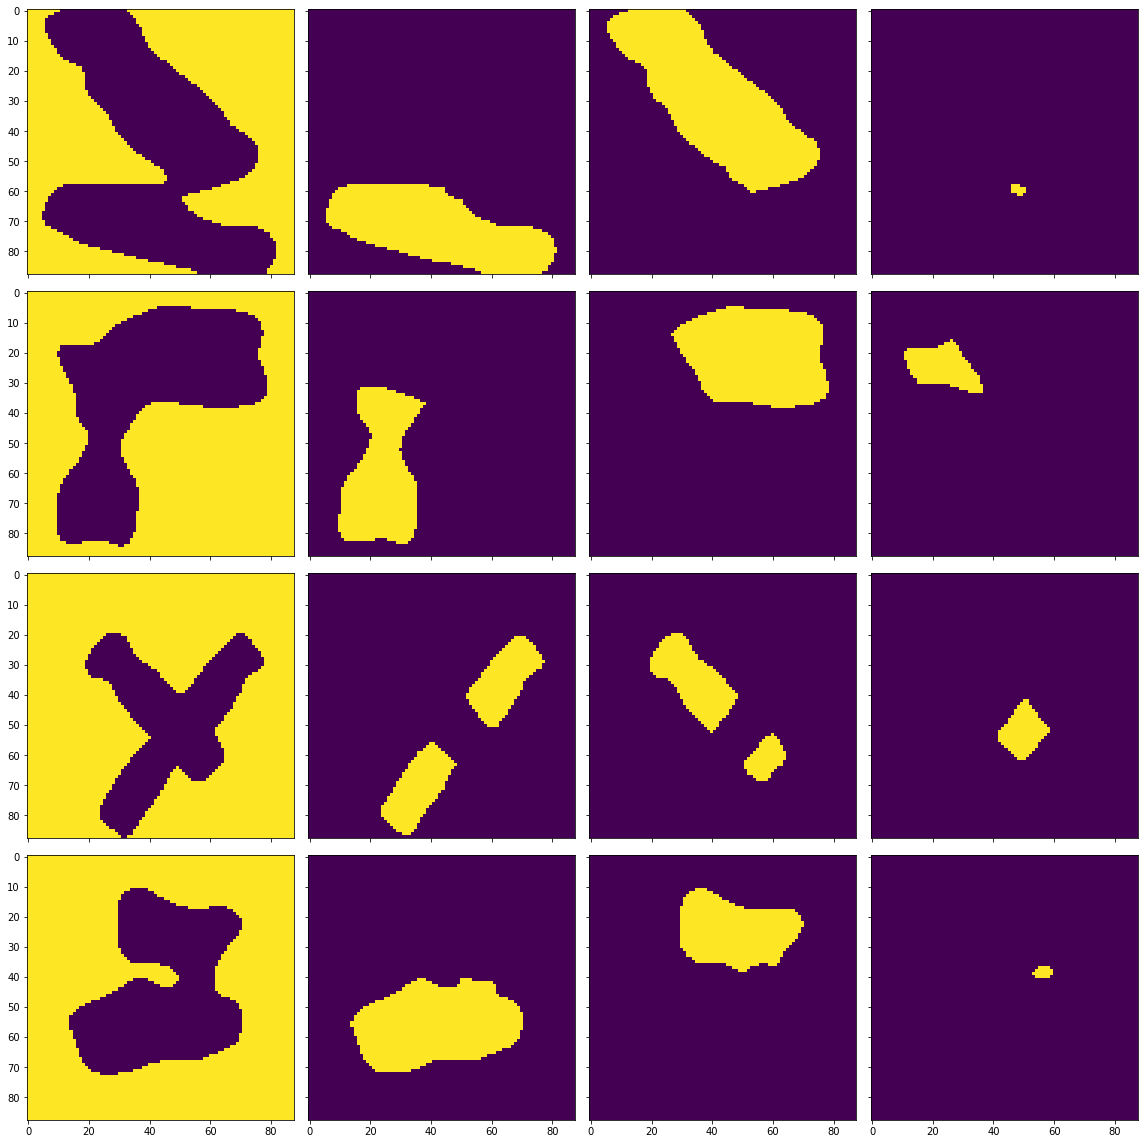

Training IOU: [0.9841649340093317, 0.9247223842987021, 0.9333716349310571, 0.8691642836487485]
Training accuracy: 0.9722640108471075
Testing IOU: [0.9747944748153403, 0.4703426292435818, 0.42210469216164903, 0.4871274011923162]
Testing accuracy: 0.8796410123966942
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_231epoch\assets
4
4


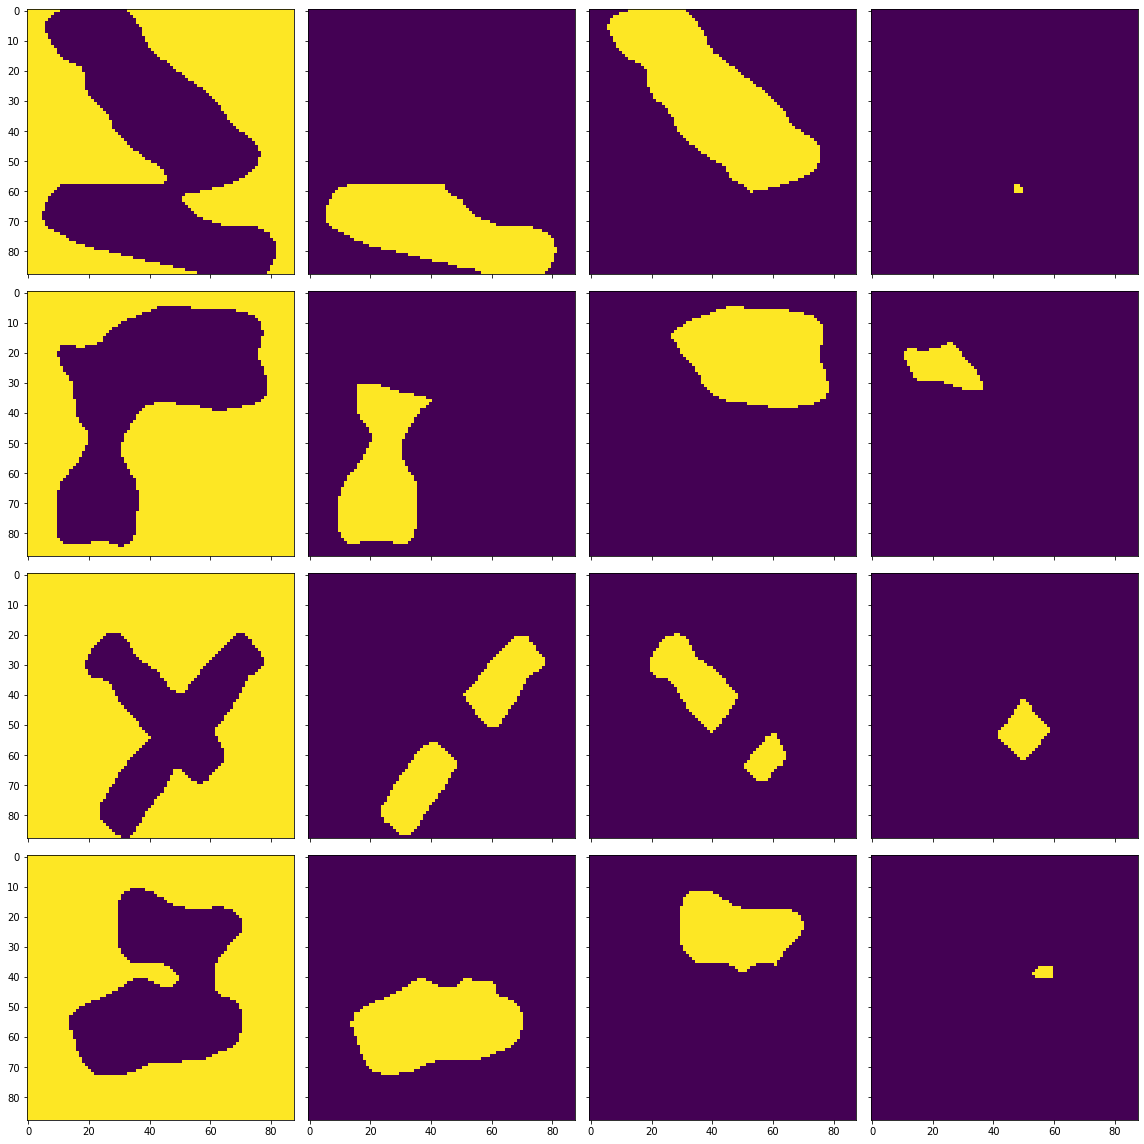

Training IOU: [0.9835791481017504, 0.9337738544985411, 0.9307192976694799, 0.8394491950354227]
Training accuracy: 0.9719773372933884
Testing IOU: [0.9743465676198301, 0.498782994185027, 0.3785904521893525, 0.484930750471633]
Testing accuracy: 0.8795338326446281
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0505
INFO:tensorflow:Assets written to: modelseg/savedmodel_232epoch\assets
4
4


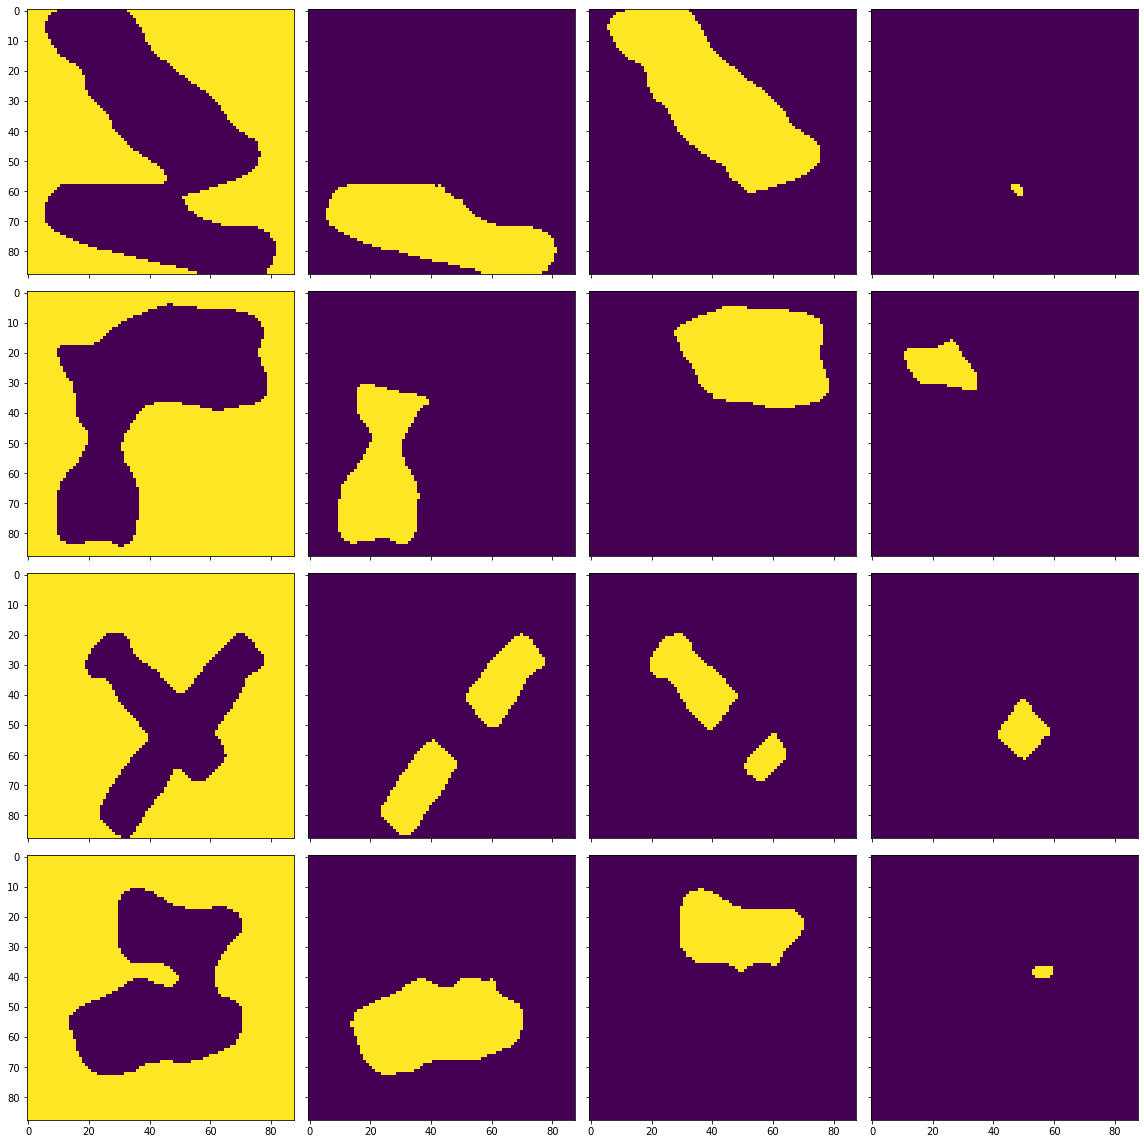

Training IOU: [0.9830976938283635, 0.9364772887368672, 0.9320577642995628, 0.8455045911016493]
Training accuracy: 0.9723921745867768
Testing IOU: [0.9743536156769315, 0.5187635929437519, 0.40223118045686995, 0.4808745663684499]
Testing accuracy: 0.8840392561983471
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0679 - val_loss: 0.0503
INFO:tensorflow:Assets written to: modelseg/savedmodel_233epoch\assets
4
4


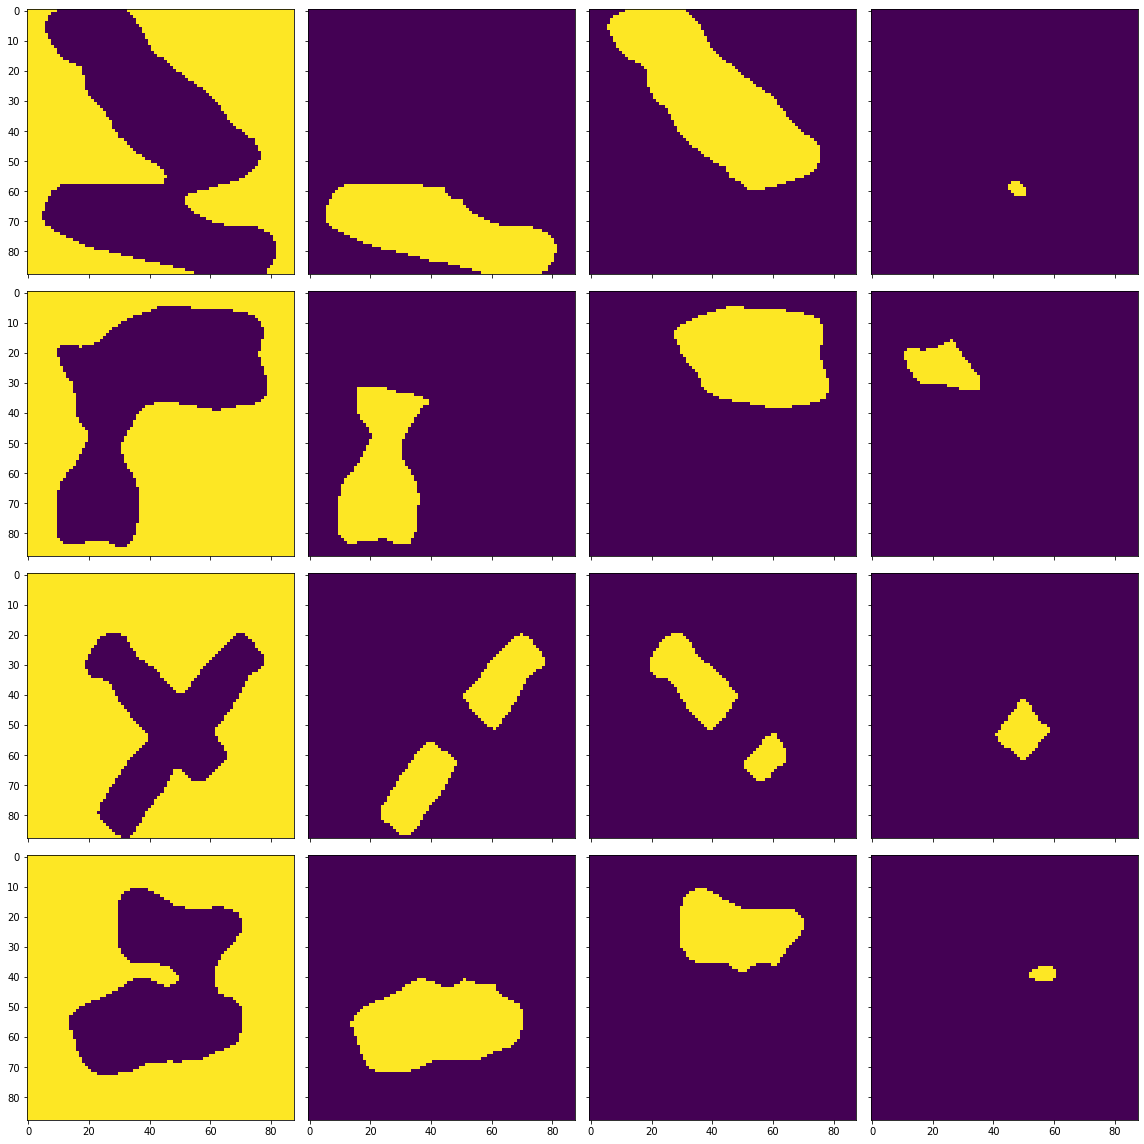

Training IOU: [0.9826327080400632, 0.9347318377105965, 0.9326783423549588, 0.8762096560496052]
Training accuracy: 0.9726129907024793
Testing IOU: [0.9743719337382469, 0.5193050460303177, 0.3796722026239645, 0.4700685178507032]
Testing accuracy: 0.8817755681818182
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0677 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_234epoch\assets
4
4


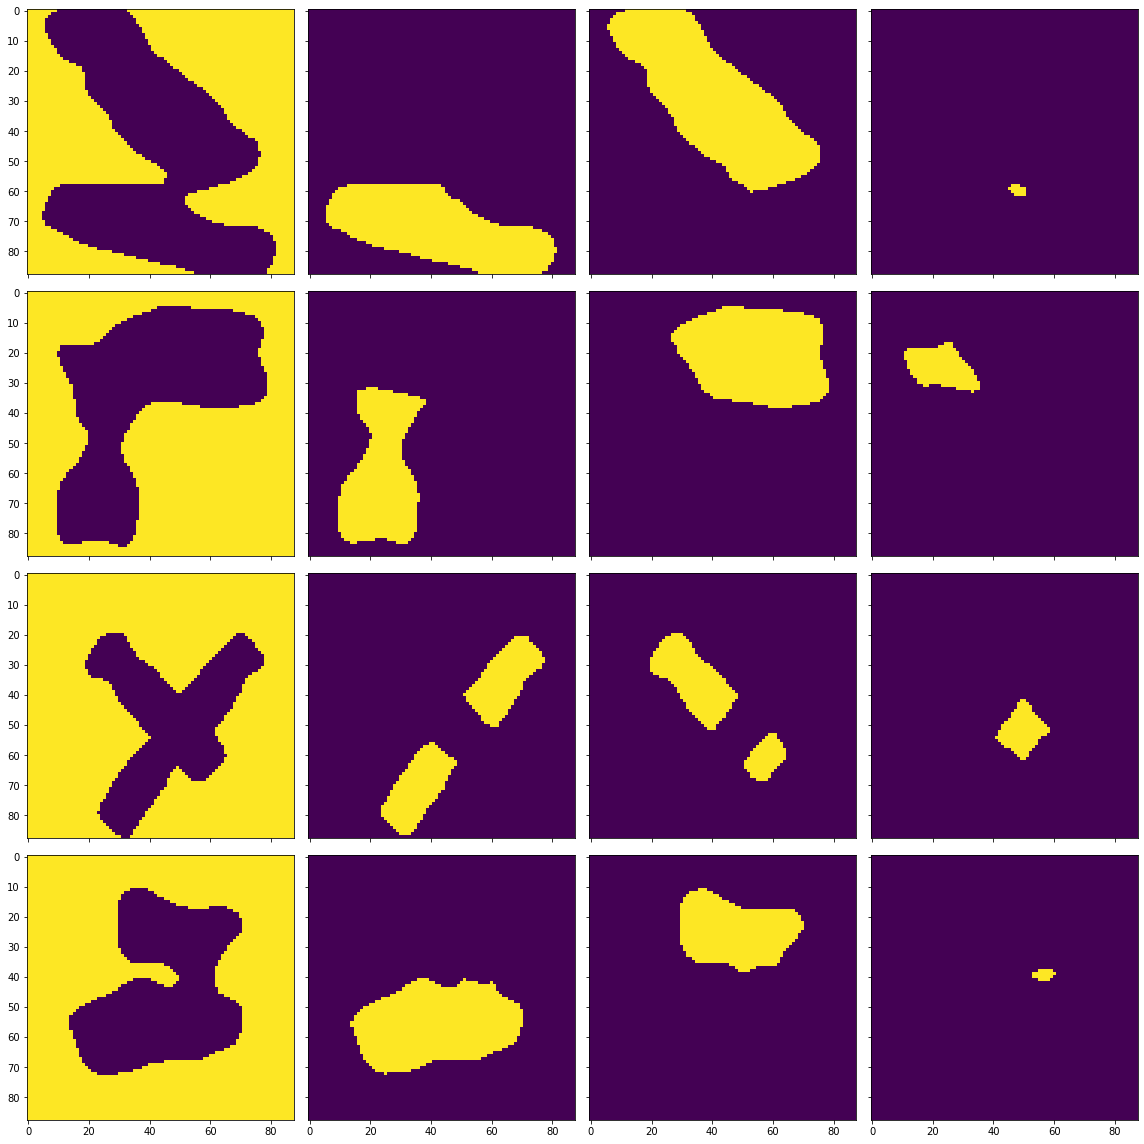

Training IOU: [0.9831957702208336, 0.9293352047977542, 0.9379186844504621, 0.858179745800985]
Training accuracy: 0.9721655475206612
Testing IOU: [0.9744112444989137, 0.48059618979726926, 0.4097269342918447, 0.47232134687528593]
Testing accuracy: 0.8791451446280992
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0506
INFO:tensorflow:Assets written to: modelseg/savedmodel_235epoch\assets
4
4


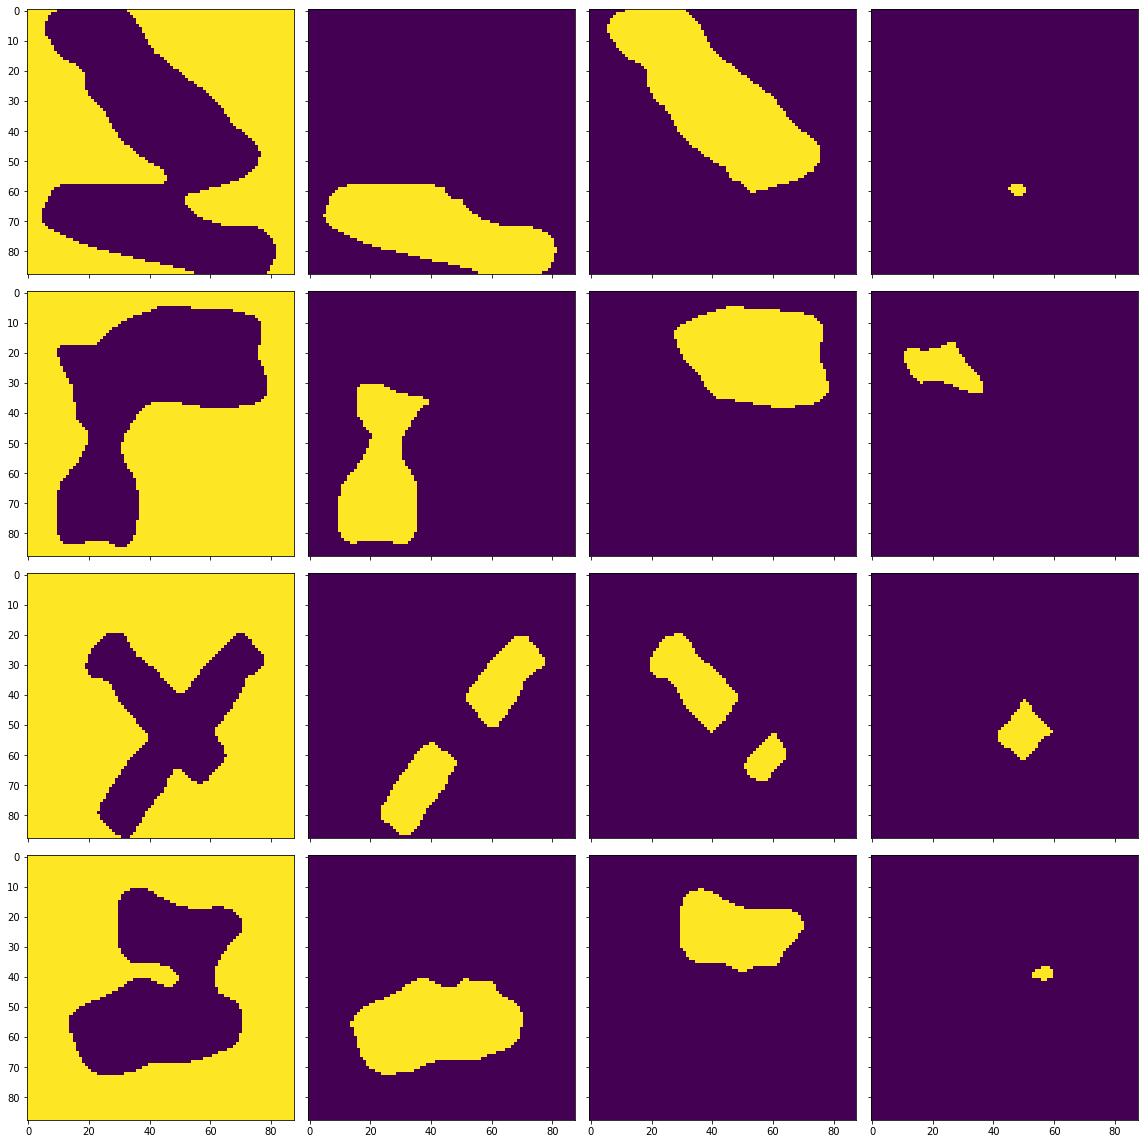

Training IOU: [0.9832178020806868, 0.9350756705690575, 0.9374639635577635, 0.8550965375903354]
Training accuracy: 0.9725716683884298
Testing IOU: [0.9743750544377667, 0.5304483837330553, 0.388841355433074, 0.46897150958064665]
Testing accuracy: 0.8845351239669421
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0677 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_236epoch\assets
4
4


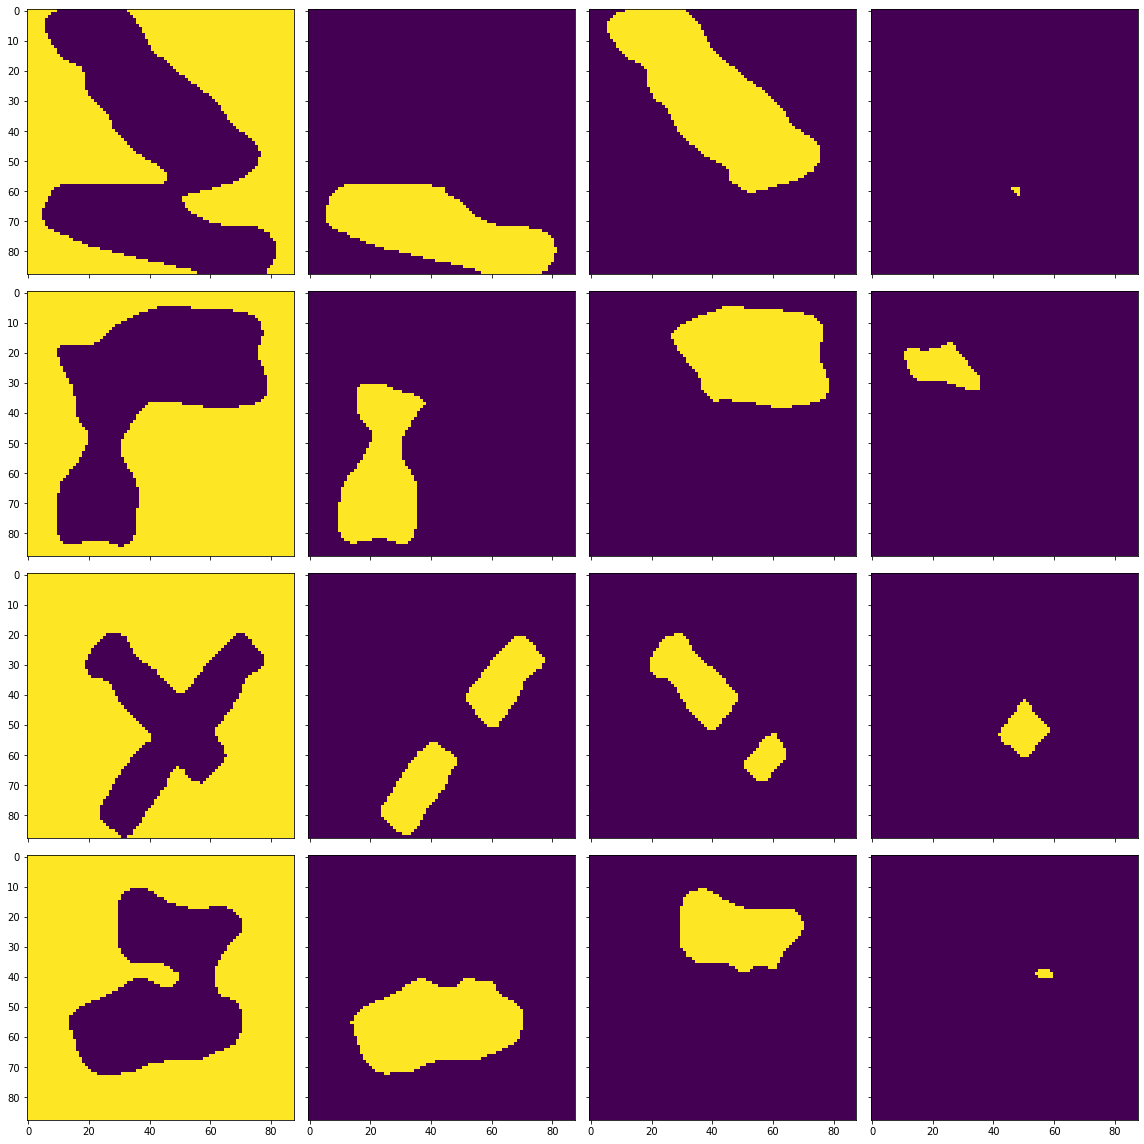

Training IOU: [0.9843562968050087, 0.931758390380821, 0.9355626454552407, 0.8116851448450759]
Training accuracy: 0.9721384297520661
Testing IOU: [0.974803872635037, 0.5096071949300574, 0.419922449018288, 0.45523684334068826]
Testing accuracy: 0.8847017045454545
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0678 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_237epoch\assets
4
4


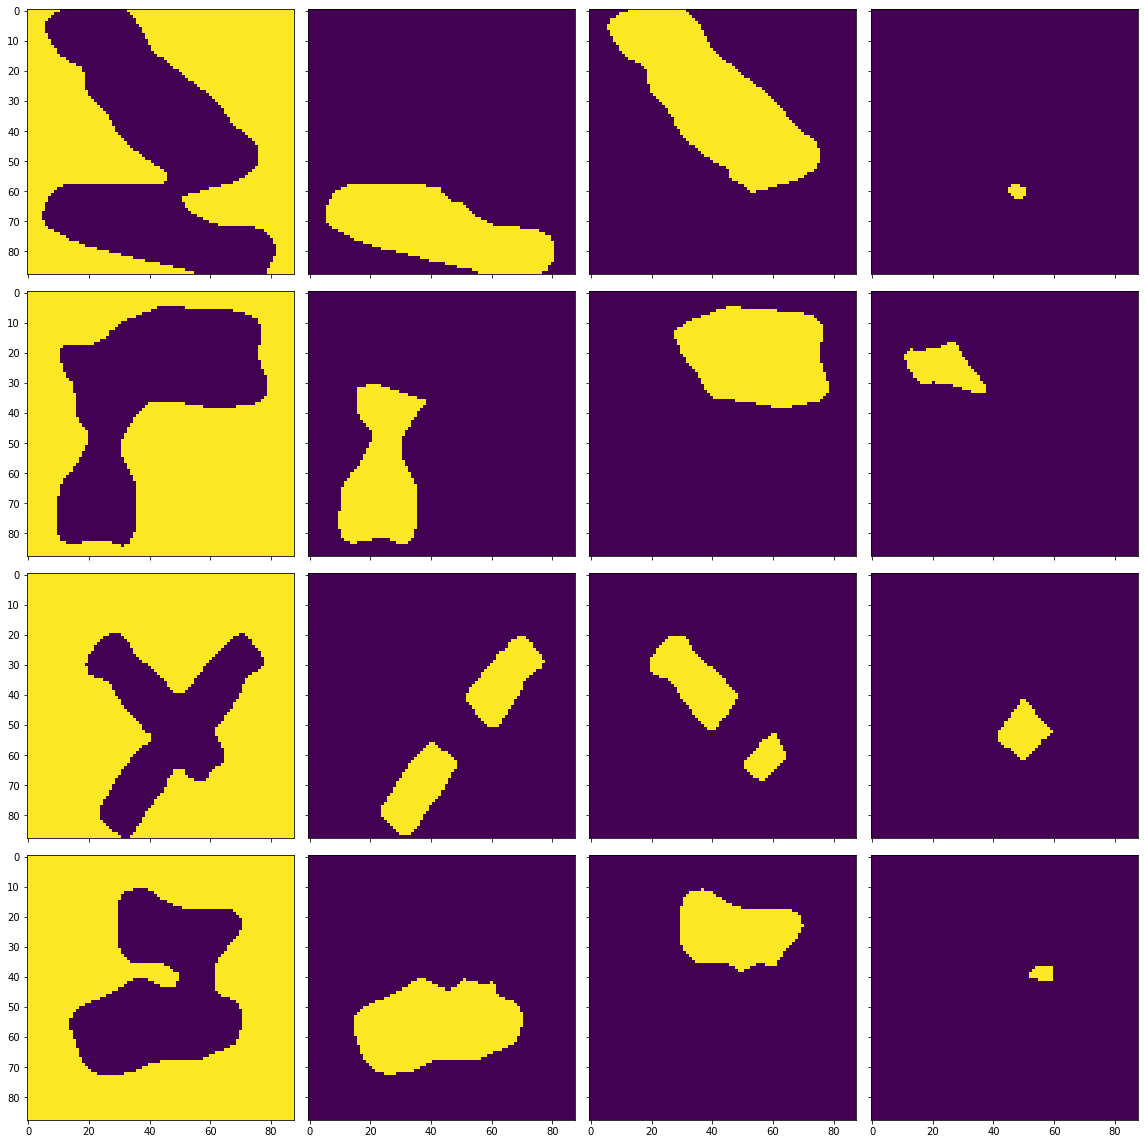

Training IOU: [0.9852283635515444, 0.9228320863771, 0.9223961262534122, 0.8868047122984172]
Training accuracy: 0.9726255810950413
Testing IOU: [0.9744550254998421, 0.5078072821096886, 0.3753488463503793, 0.48452302990613405]
Testing accuracy: 0.8818323863636364
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0500
INFO:tensorflow:Assets written to: modelseg/savedmodel_238epoch\assets
4
4


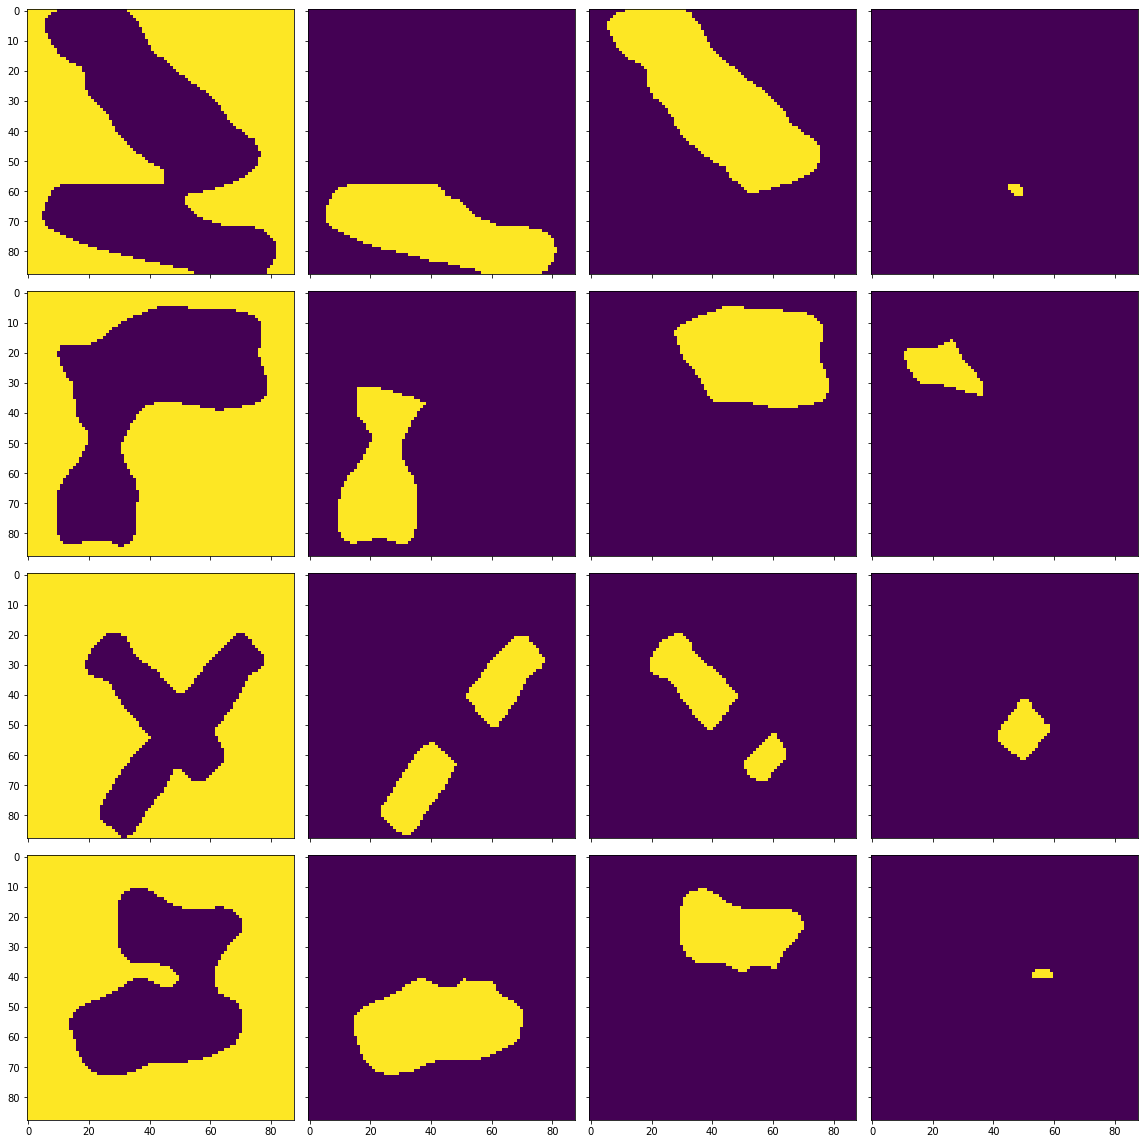

Training IOU: [0.9839978671615714, 0.9317319877636093, 0.931687858389429, 0.8782806784881607]
Training accuracy: 0.9724606146694215
Testing IOU: [0.9745502856476218, 0.5211901718505894, 0.3996267453563018, 0.4823246092330062]
Testing accuracy: 0.8840405475206612
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0675 - val_loss: 0.0516
INFO:tensorflow:Assets written to: modelseg/savedmodel_239epoch\assets
4
4


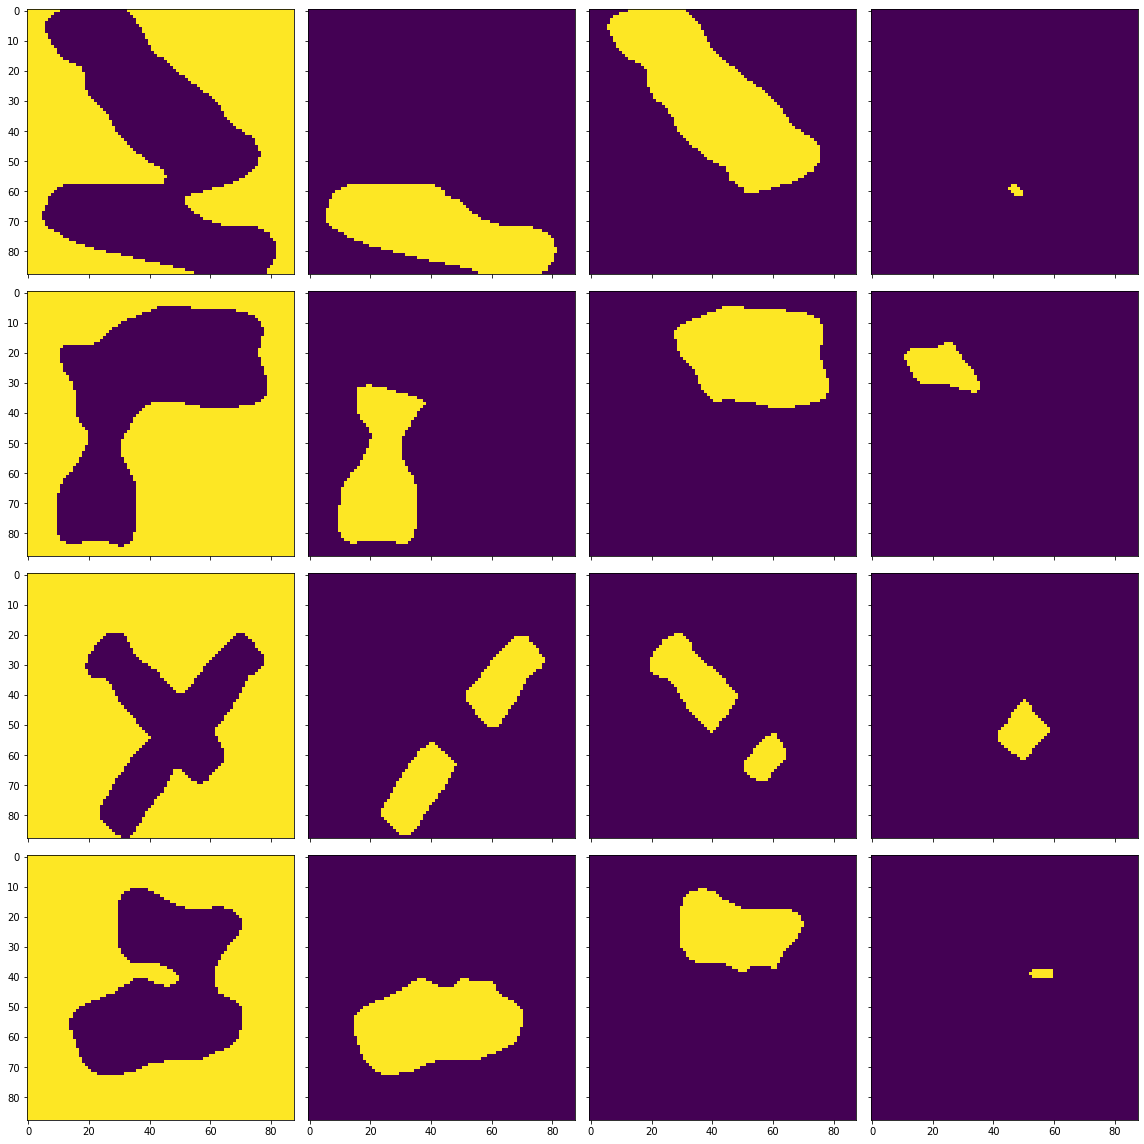

Training IOU: [0.9844612105374775, 0.9315496558459786, 0.9382257645563045, 0.8491797609527308]
Training accuracy: 0.9731220945247934
Testing IOU: [0.9747514547399734, 0.528530398975743, 0.3808994672249065, 0.47276154571159285]
Testing accuracy: 0.8847172004132231
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_240epoch\assets
4
4


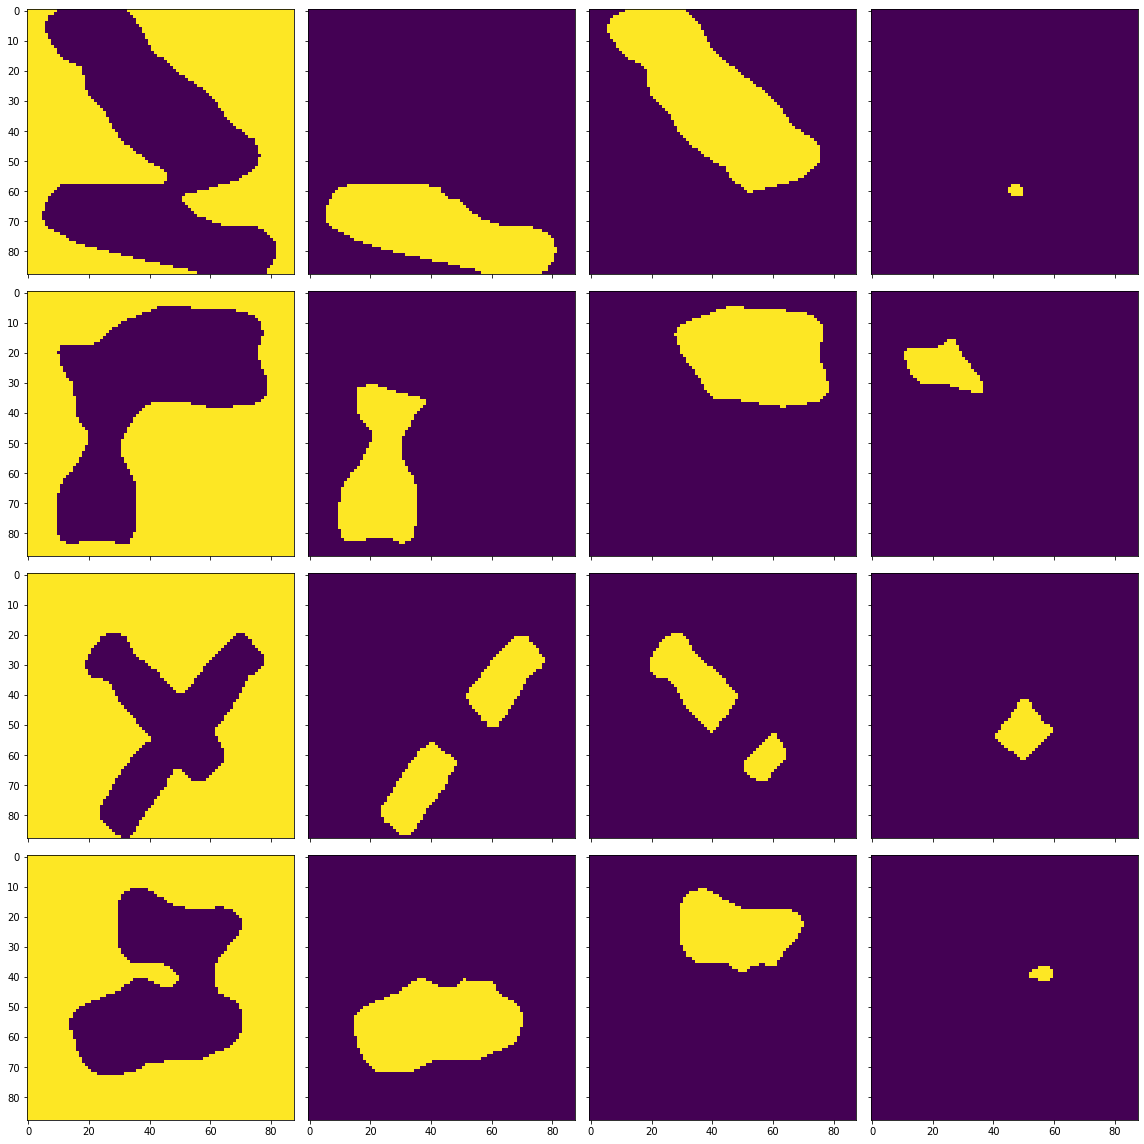

Training IOU: [0.9848517792420858, 0.9270907425744875, 0.9350451641873595, 0.8864639503100306]
Training accuracy: 0.9736479855371901
Testing IOU: [0.9746245684820132, 0.5177384147432457, 0.40859652184028383, 0.4856291155009788]
Testing accuracy: 0.8856146694214876
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0677 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelseg/savedmodel_241epoch\assets
4
4


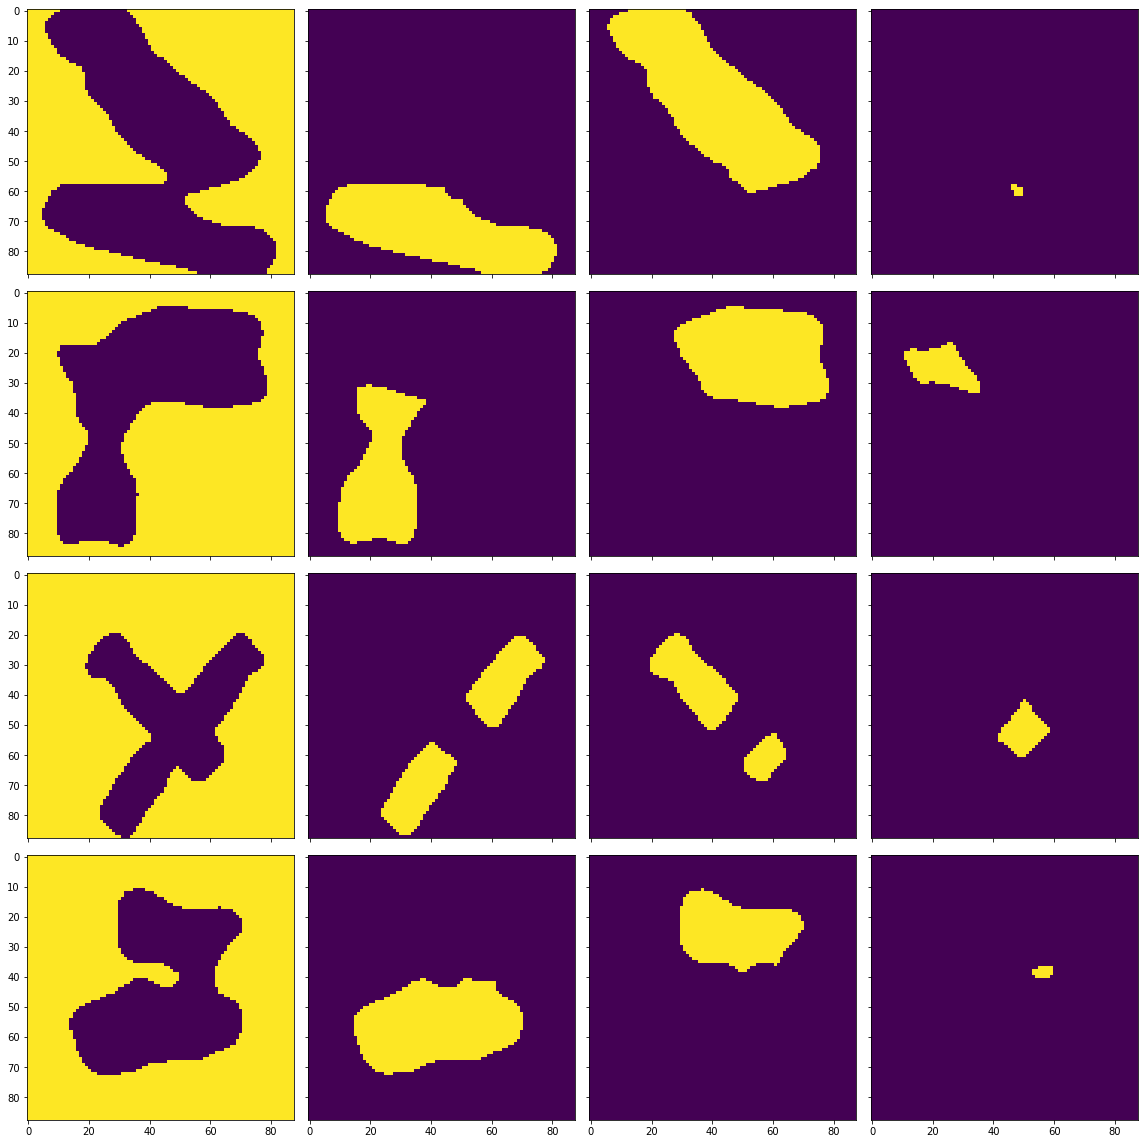

Training IOU: [0.9850490132231954, 0.9316333326371824, 0.929993920373322, 0.8314119947707899]
Training accuracy: 0.9721319731404958
Testing IOU: [0.9747632369126128, 0.5113669708105691, 0.38187155747120793, 0.46082928171727366]
Testing accuracy: 0.8816800103305785
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0518
INFO:tensorflow:Assets written to: modelseg/savedmodel_242epoch\assets
4
4


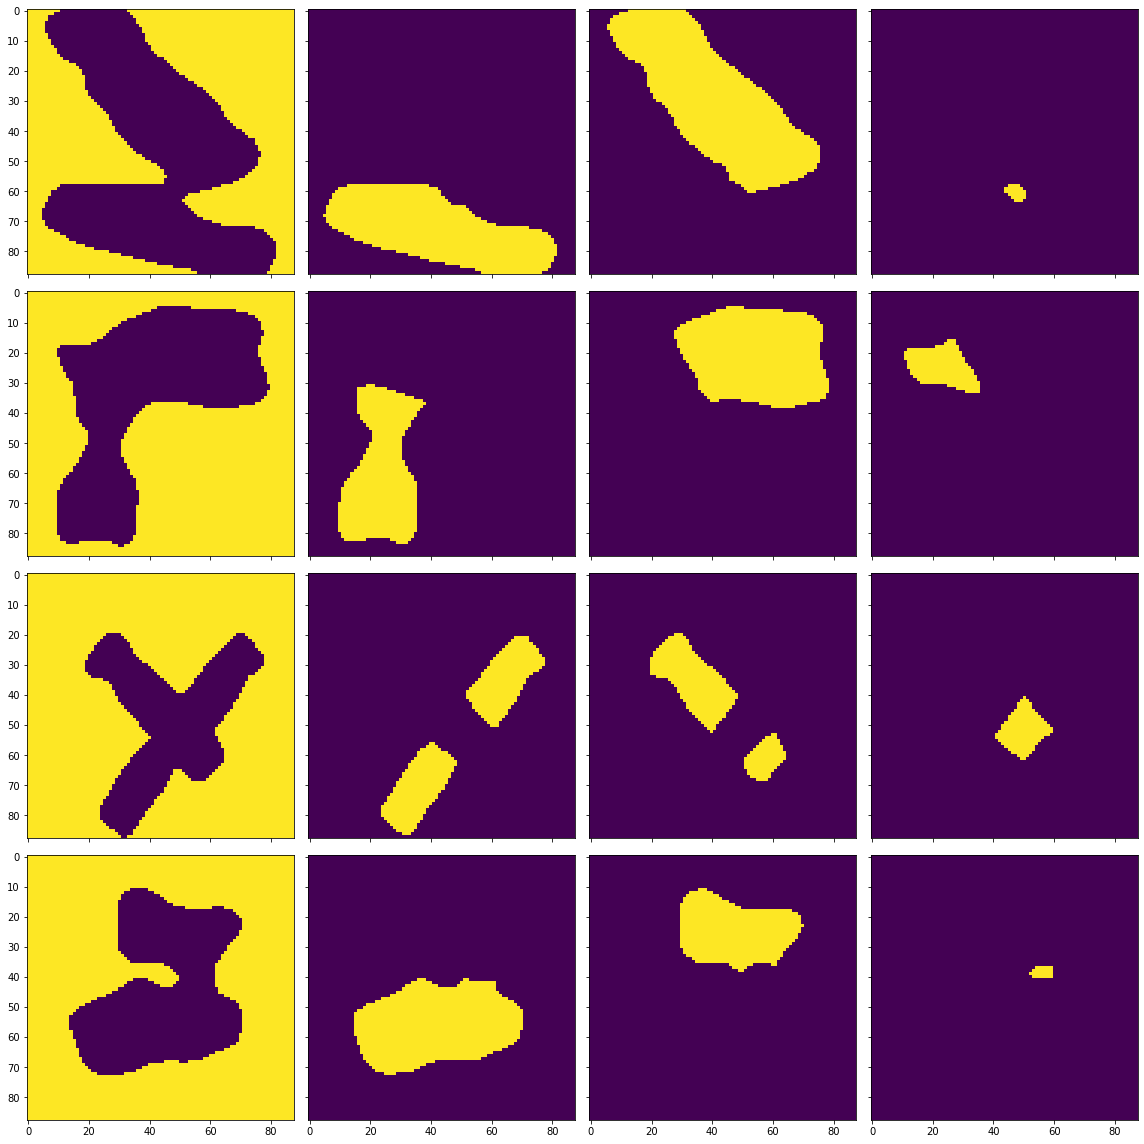

Training IOU: [0.984069816947208, 0.9313048664177493, 0.9347808822764254, 0.8943886017482111]
Training accuracy: 0.9737212680785124
Testing IOU: [0.974467973992741, 0.5012575326564392, 0.40311094630955435, 0.48770369103117917]
Testing accuracy: 0.8826756198347108
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0508
INFO:tensorflow:Assets written to: modelseg/savedmodel_243epoch\assets
4
4


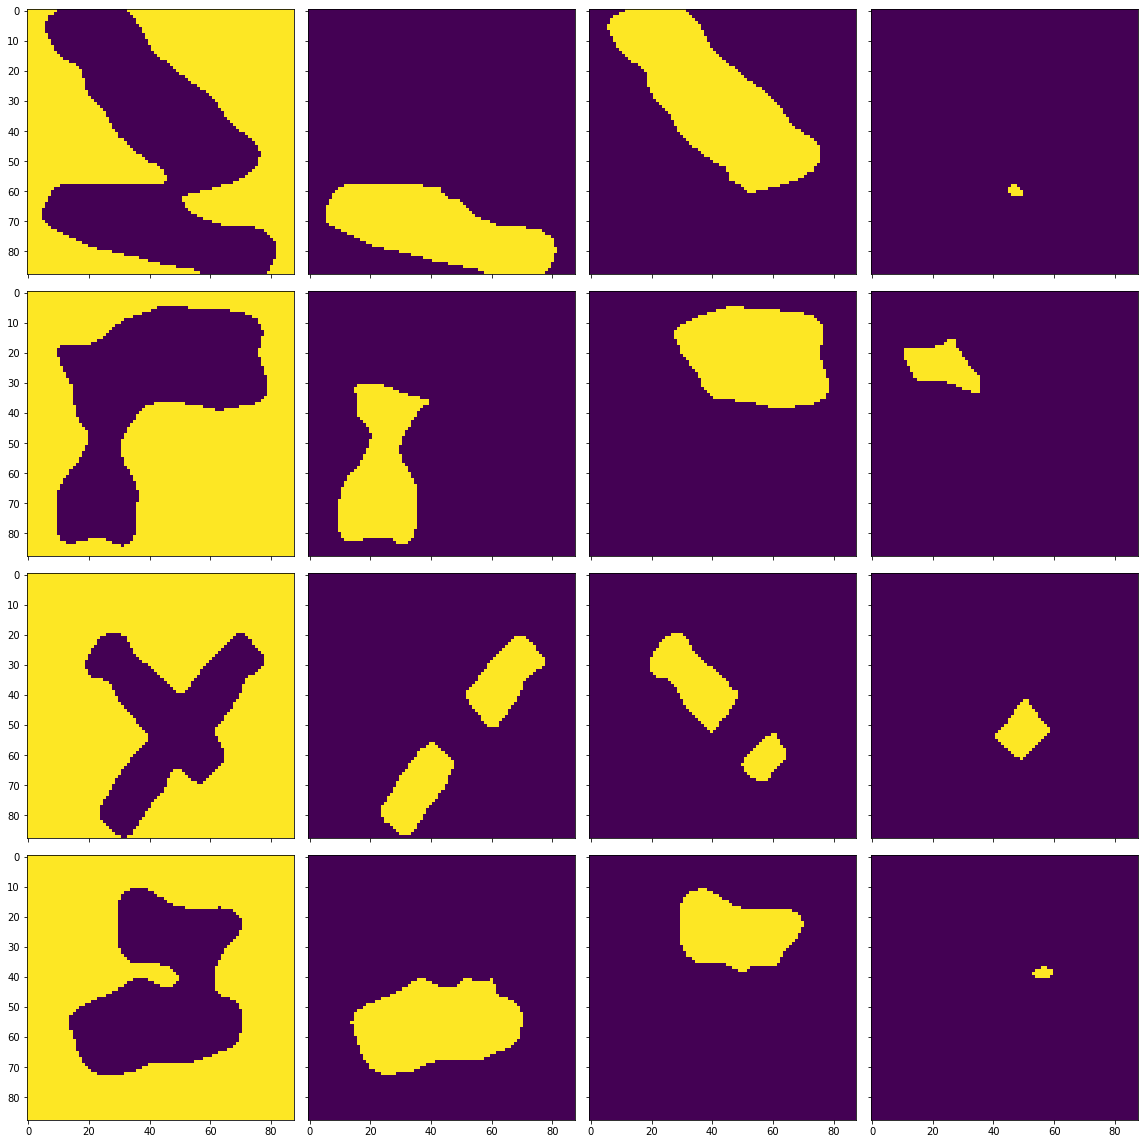

Training IOU: [0.9840214886373033, 0.9320983644588795, 0.9364131653657015, 0.8588604736196847]
Training accuracy: 0.9728954674586777
Testing IOU: [0.9744367078364047, 0.5159888010018641, 0.41257601043524966, 0.48038199918915264]
Testing accuracy: 0.8849380165289257
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0677 - val_loss: 0.0513
INFO:tensorflow:Assets written to: modelseg/savedmodel_244epoch\assets
4
4


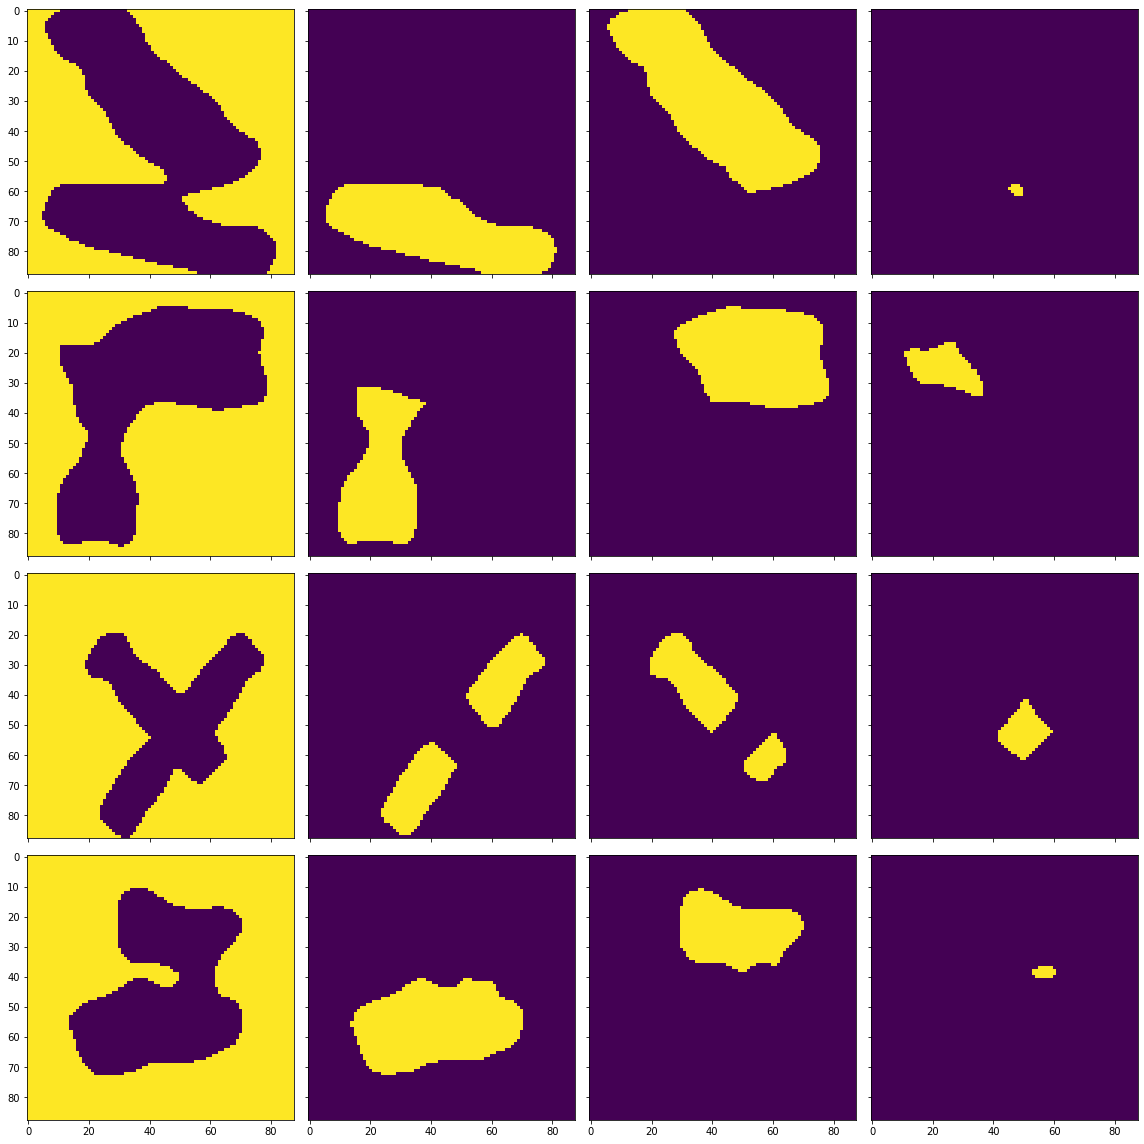

Training IOU: [0.9835368222631519, 0.9317325713013305, 0.9393081511803621, 0.8648654441788933]
Training accuracy: 0.9728147598140496
Testing IOU: [0.9743870547637536, 0.49634897778687387, 0.41903523380049773, 0.47095605675104574]
Testing accuracy: 0.8823127582644628
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelseg/savedmodel_245epoch\assets
4
4


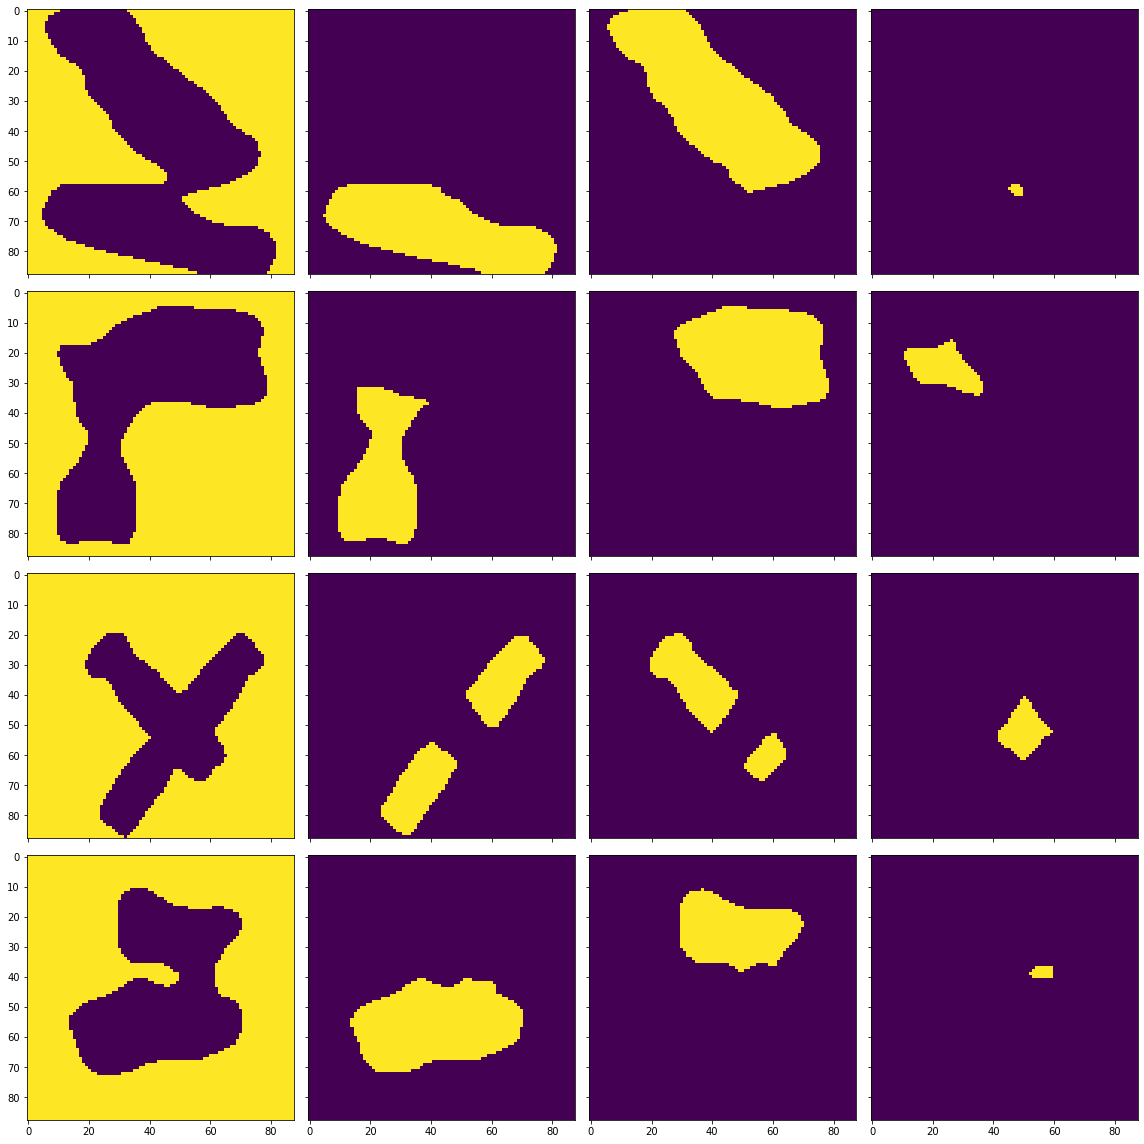

Training IOU: [0.9844643828411915, 0.9346843245623182, 0.9310592459605027, 0.8806345604213276]
Training accuracy: 0.9734533186983471
Testing IOU: [0.9744421624255927, 0.506560223132969, 0.3982632418205222, 0.4824496218909822]
Testing accuracy: 0.8826794938016529
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0676 - val_loss: 0.0516
INFO:tensorflow:Assets written to: modelseg/savedmodel_246epoch\assets
4
4


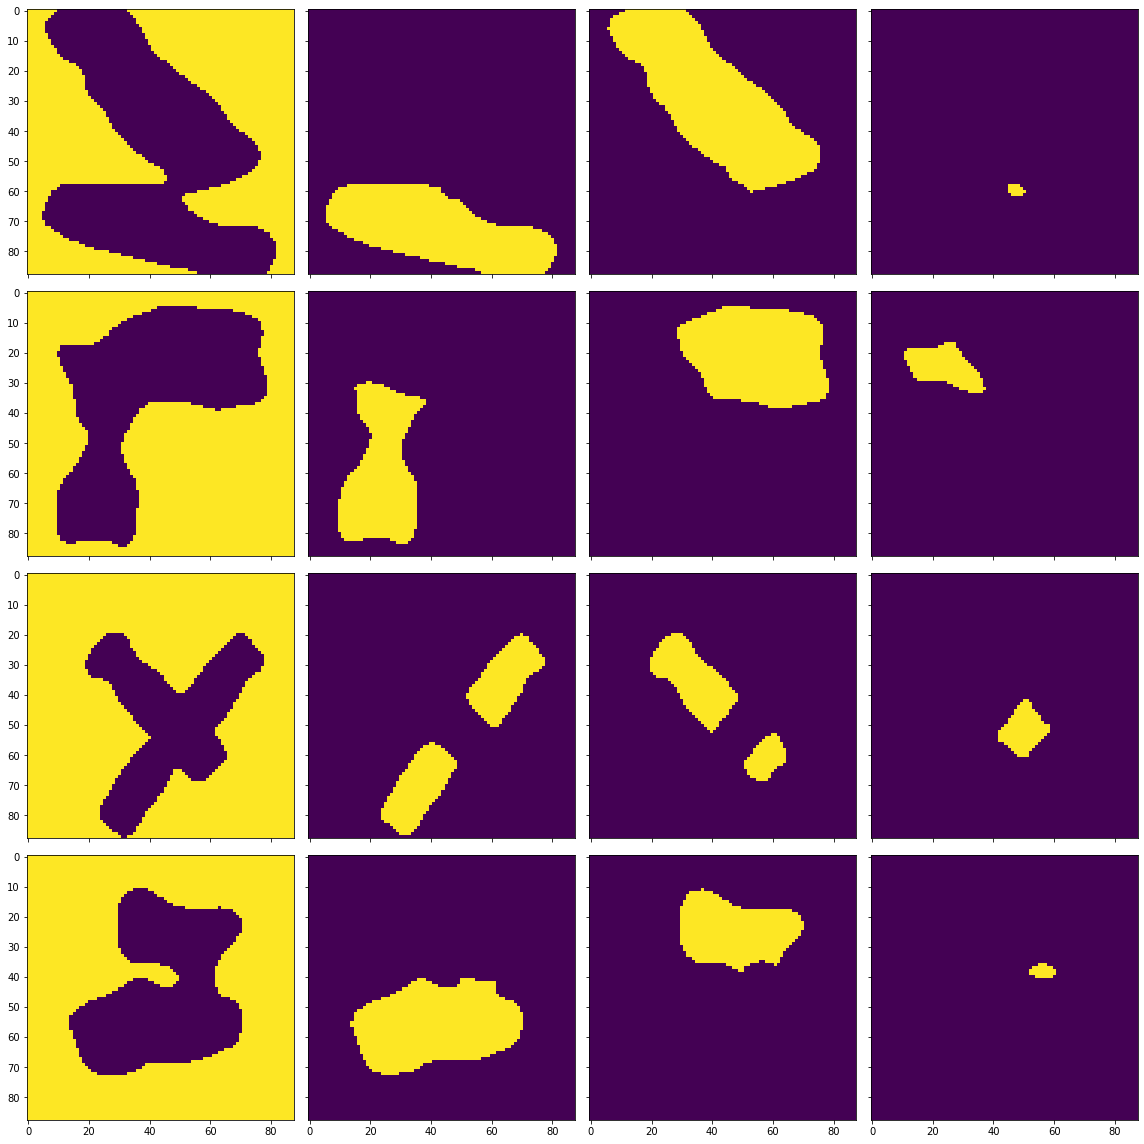

Training IOU: [0.9842231487056938, 0.9376987180081388, 0.9342784069749611, 0.8749107494911389]
Training accuracy: 0.9738313533057851
Testing IOU: [0.9745322200067914, 0.5240244281130317, 0.37229281547190923, 0.49017215079538023]
Testing accuracy: 0.8833729338842975
(500, 88, 88, 1)
13/13 [==============================] - 1s 91ms/step - loss: 0.0676 - val_loss: 0.0511
INFO:tensorflow:Assets written to: modelseg/savedmodel_247epoch\assets
4
4


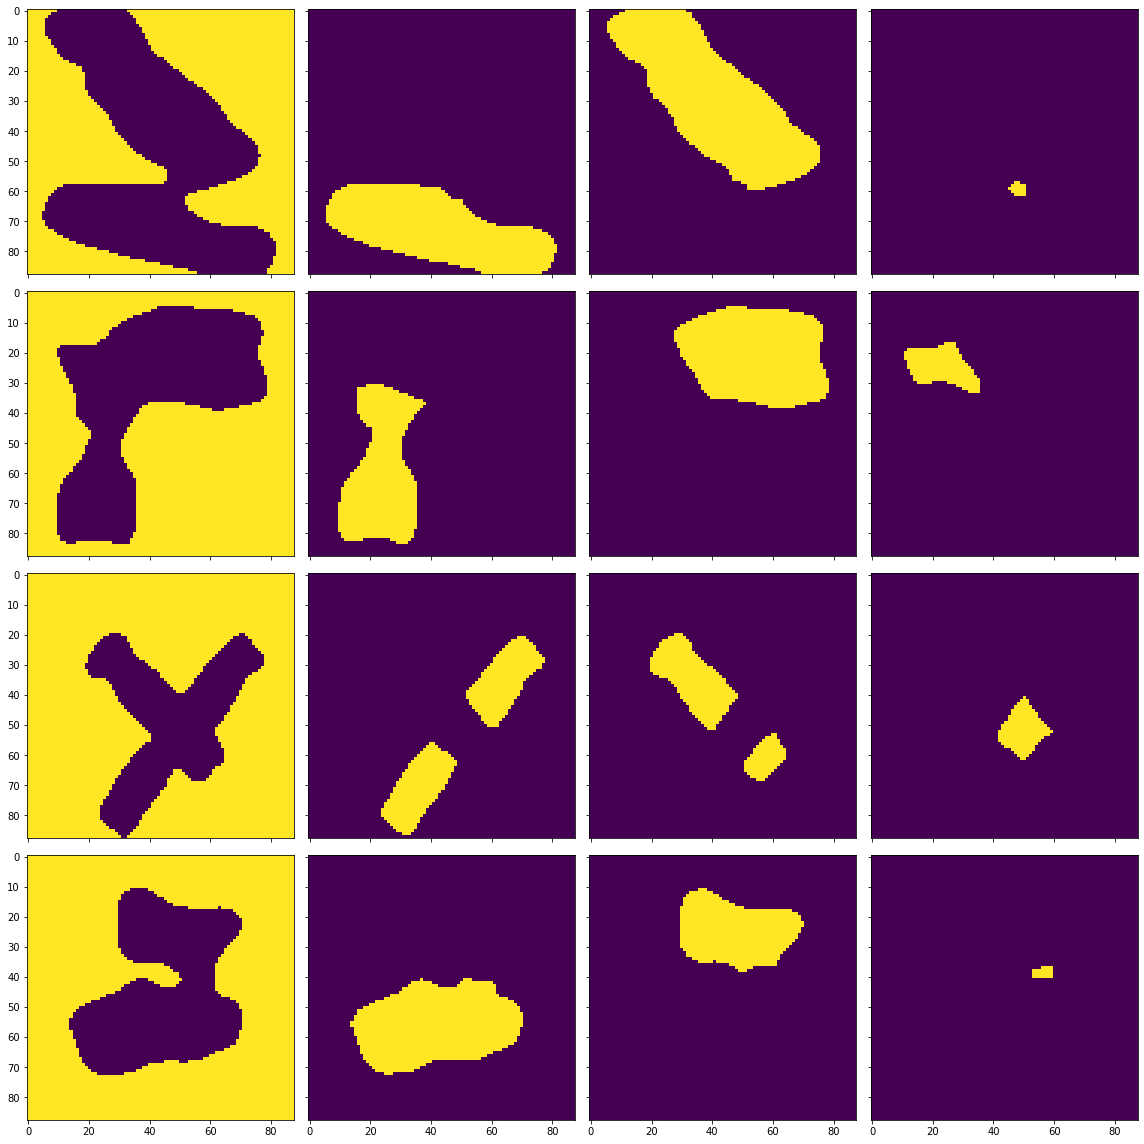

Training IOU: [0.9851487059081171, 0.922928176153544, 0.9264633983125613, 0.8864020046080503]
Training accuracy: 0.9733477530991735
Testing IOU: [0.9743579948288825, 0.48859186664624943, 0.41344980768693484, 0.4846431400158409]
Testing accuracy: 0.8826678719008264
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0681 - val_loss: 0.0495
INFO:tensorflow:Assets written to: modelseg/savedmodel_248epoch\assets
4
4


Training IOU: [0.9823229415373764, 0.9358184037958176, 0.939934698012347, 0.866822131357015]
Training accuracy: 0.9733822959710744
Testing IOU: [0.973829446013318, 0.5093638222665721, 0.3906551889048302, 0.4895214966720633]
Testing accuracy: 0.8817910640495867
(500, 88, 88, 1)
13/13 [==============================] - 1s 90ms/step - loss: 0.0677 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelseg/savedmodel_249epoch\assets
4
4


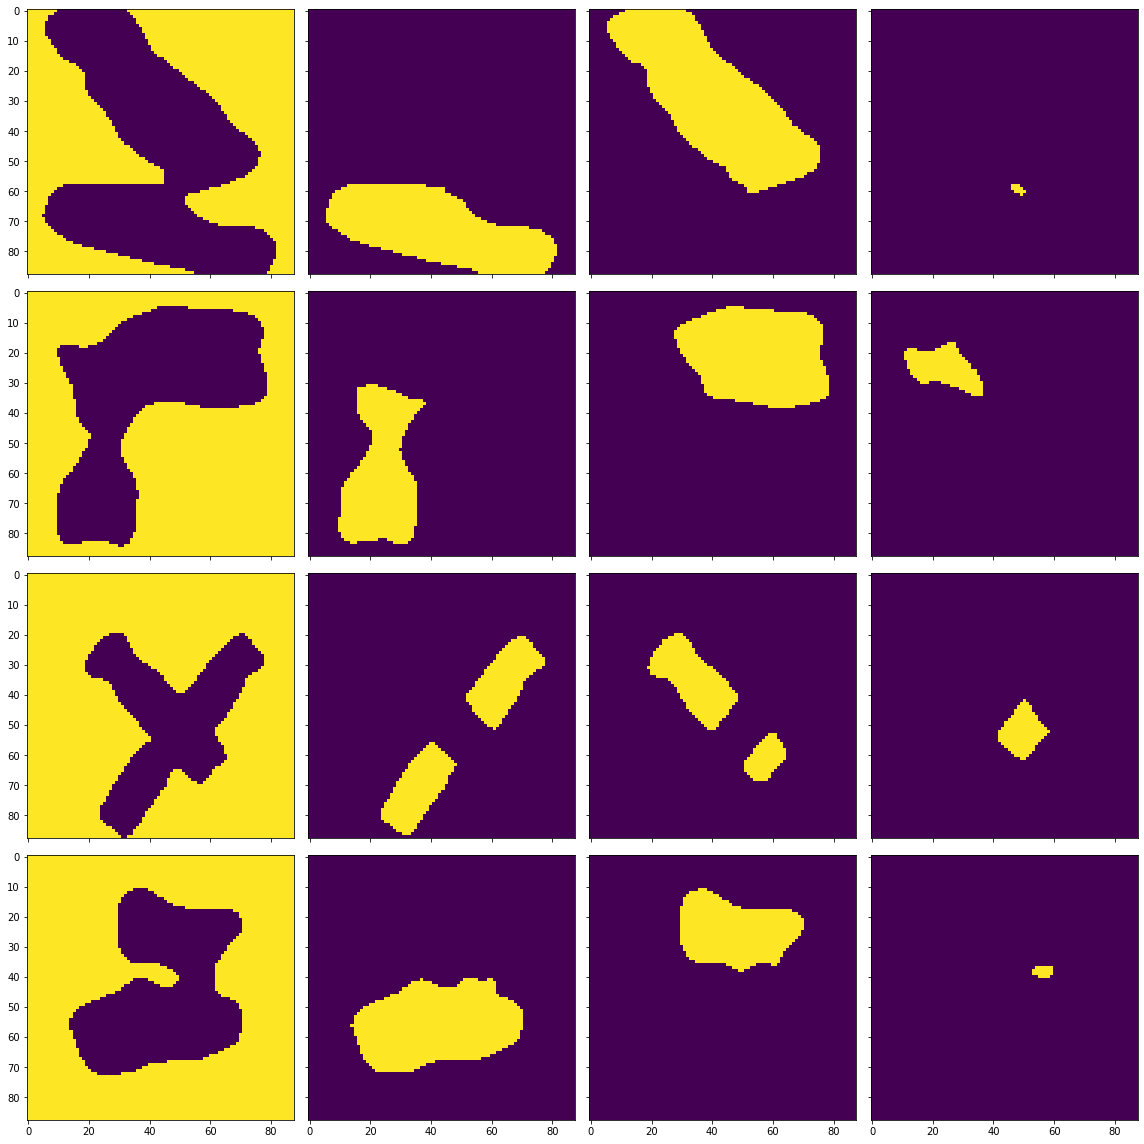

Training IOU: [0.983836332305093, 0.9294373308409307, 0.9386857765530652, 0.8568482778619068]
Training accuracy: 0.9729335614669421
Testing IOU: [0.974119542485707, 0.4983008431799116, 0.40050265975037086, 0.4817897091722595]
Testing accuracy: 0.8821397210743802


In [4]:
import matplotlib.pyplot as plt
import numpy as np
# import utilities
import os
# from OverlapSegmentationNet import OverlapSegmentationNet

import tensorflow as tf

# Load data
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')
# print(labels.shape)
train_test_boundary_index = round(500*.8)

model = SegNet(input_shape=(88,88,1))

# Choose loss
model.compile(loss='mean_squared_error', optimizer='adam')

# Specify the number of epochs to run
num_epoch = 250
for i in range(num_epoch):
    
    # Fit
    print(xdata.shape)
    model.fit(x=xdata, y=labels, epochs=1, validation_split=0.2) 
    os.makedirs('modelseg', exist_ok=True)
    filename = 'modelseg/savedmodel_' + str(i) + 'epoch'
    model.save(filename)
    
    # Predict and plot images
    predictions = model.predict(xdata[0:4,...])
    plotSamplesOneHots(predictions[0:4,...].round())
   
    # Calculate mIOU
    y_pred_train = model.predict(xdata[0:train_test_boundary_index,...]).round()
    trainIOU = IOU(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training IOU: ' + str(trainIOU))
    trainAccuracy = globalAccuracy(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training accuracy: ' + str(trainAccuracy))
    del y_pred_train
    
    y_pred_test = model.predict(xdata[train_test_boundary_index:,...]).round()
    testIOU = IOU(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing IOU: ' + str(testIOU))
    testAccuracy = globalAccuracy(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing accuracy: ' + str(testAccuracy))
    del y_pred_test


In [6]:

#A few useful metrics and losses


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / ((K.sum(y_true_f) + K.sum(y_pred_f) - intersection) + 1.0)


def precision(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    prec = (tp + smooth) / (tp + fp + smooth)
    return prec

def recall(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    tp = K.sum(y_pos * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall


def true_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp

def true_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn


def false_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = (K.sum(y_neg * y_pred_pos) + smooth) / (K.sum(y_neg) + smooth)
    return tp

def false_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_pos * y_pred_neg) + smooth) / (K.sum(y_pos) + smooth)
    return tn


def accuracy(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    tn = K.sum(y_neg * y_pred_neg)
    acc = (tp+tn + smooth) / (tp + tn + fn + fp + smooth)
    return acc

In [7]:
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')
train_test_boundary_index = round(500*.8)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(xdata, labels , test_size=0.20, random_state=42)

In [9]:

dice = []
iou = []
sensi = []
speci = []
rec= []
prec = []
iou_1  = []
tpr_data = []
fpr_data = []
fnr_data = []
tnr_data = []
acc_data = []


predictions = model.predict(X_test[0:100,:,:,:])
predictions= np.float64(predictions)

for i in range(len(predictions)):

  predictions[i] = (predictions[i]+1)/2
  y_test[i:i+1,:,:,:] = (y_test[i:i+1,:,:,:][0]+1)/2

  acc_data.append(accuracy(predictions[i],y_test[i:i+1,:,:,:]))
  prec.append(precision(predictions[i],y_test[i:i+1,:,:,:])) 
  rec.append(recall(predictions[i],y_test[i:i+1,:,:,:]))
  iou.append(jacard_coef(predictions[i],y_test[i:i+1,:,:,:]))
  dice.append(dice_coef(predictions[i],y_test[i:i+1,:,:,:]))
  tpr_data.append(true_positive(predictions[i],y_test[i:i+1,:,:,:]))
  fpr_data.append(false_positive(predictions[i],y_test[i:i+1,:,:,:]))
  tnr_data.append(true_negative(predictions[i],y_test[i:i+1,:,:,:]))
  fnr_data.append(false_negative(predictions[i],y_test[i:i+1,:,:,:]))
  

In [10]:
print("Accuracy : ", np.mean(acc_data))
print("Precision : ", np.mean(prec))
print("Recall : ", np.mean(rec))
print("TPR : ", np.mean(tpr_data))
print("FPR: ", np.mean(fpr_data))
print("FNR: ", np.mean(fnr_data))
print("TNR: ", np.mean(tnr_data))
print("IOU: ", np.mean(iou))
print("DICE: ", np.mean(dice))

Accuracy :  0.5906252171190394
Precision :  0.6476524338844142
Recall :  0.6815301530767226
TPR :  0.9175943630751301
FPR:  0.0044792353360978325
FNR:  0.0825256101390196
TNR:  0.9955649428489585
IOU:  0.4971908194289108
DICE:  0.664150856172213
